Experiment 1 with resnet18 transfer learning
============================================

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import csv
import gc
import torchnet as tnt
from utils import *
from classes import *
from tqdm import tqdm_notebook # for-loop progress bar in notebook

# plt setup and the gpu setup
plt.ion()
use_gpu = torch.cuda.is_available()

# load memory profiler
%load_ext memory_profiler


print('main imports complete')

main imports complete


In [2]:
# Create custom Dataset object
# A unique object will need to be created for each book.
# It will take in all the transforms = a dict with key, val where:
#   key=phase, val=tranform to use

# To create custom Dataset
from torch.utils.data.dataset import Dataset
from torchvision.datasets.folder import find_classes, make_dataset, IMG_EXTENSIONS, default_loader

class BookDatasetContainer:
    pass

class BookDataset:
    pass

class BookDatasetContainer:
    __samples = None
    __images = []
    
    def __init__(self, root, loader=default_loader):
        # Read in all images
        classes, class_to_idx = find_classes(root)
        self.__samples = make_dataset(root, class_to_idx, IMG_EXTENSIONS)
        self.__images = [(loader(path), target) for path, target in self.__samples]
            
    def __len__(self):
        return len(self.__samples)
    
    def __getitem__(self, index):
        return self.__images[index]
    
    # Method of BookDatasetContainer to create a BookDataset with a specific transform
    def create_dataset(self, transform):
        return BookDataset(self, transform)
    
# BookDataset class uses the BookDatasetContainer's images, adding transform functionality
class BookDataset(Dataset):
    __dataset_container = None
    __transform = None

    def __init__(self, dataset_container, transform):
        self.__dataset_container = dataset_container
        self.__transform = transform

    def __getitem__(self, index):
        sample, target = self.__dataset_container[index]
        if (self.__transform is not None):
            sample = self.__transform(sample)
        return sample, target

    def __len__(self):
        return len(self.__dataset_container)

In [3]:
# ========================================
# Step 1. define data transform
#
# Including different forms of data augmentation
# One will include nearly all types (excluding random crops, etc. that may remove handwriting.)
# The other will include a selected set of augmentations
# Keeping 'train', 'val', and 'test' transforms just in case we want to include different functionalities
# ========================================

# Need the __name__ check to make multiprocessing work on Windows for some reason
# if __name__ == '__main__':
print("Set up data transforms.")
img_input_size = 56

selected_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        # RandomRotation does not seem to be working on Windows right now
        transforms.RandomRotation(45),

        transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5),
        transforms.RandomGrayscale(p=0.1),

        transforms.Grayscale(), # not sure why the current input is not grayscale, do grayscale conversion
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
    # should not do random transformation in val or test set
    'val': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
}

# Data augmentation and normalization for training
# Just normalization for validation
net1_data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize(256),
        transforms.RandomResizedCrop(224), #apparently get an error if dont have this line
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),    
        transforms.Grayscale(),    
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
}

# data_transforms = selected_transforms
data_transforms = net1_data_transforms


Set up data transforms.


In [4]:
# ========================================
# Step 2. define and load data
#
# TODO: Suggest not using data loader to load the images. Because it is slow. Every epochs, you load the 
# image data again to the RAM and then from RAM to GPU RAM. That takes a lot of time. Since the images are 
# <1GB, you can preload the images into RAM first, that will make you training way faster. 

# Note: you only has about 200MB of images, it's small. It should not take much time to load!
# ========================================

# This flag is on if the custom dataset BookDataset should be used
use_custom_dataset = False

# Need the __name__ check to make multiprocessing work on Windows for some reason
# Unfortunately, still getting broken pipe error on Windows with custom dataset.
# if __name__ == '__main__':

print("Create dataset and dataloader")

# hyperparameter
# batch_size = 50 # larger batch size is better so you can load more data into gpu and train faster
batch_size = 50 # larger batch size is better so you can load more data into gpu and train faster

# data location
#     book_data_dir = "/home/kcho/clab_data/"
#     book_data_dir = "C:\\Users\\rahul\\Documents\\work\\BuildUCLA\\data\\printed_with_ids_harsh_filter\\books-preprocessed-images"
book_data_dir = '/home/rahul/data/printed_with_ids_harsh_filter/books-preprocessed-images'
set_types = ['train', 'val', 'test']

# test books are currently arbitrarily set
test_books = set(["Albin", "Dryden"])

# Get the list of all books in the data set
books_in_data = set([b for b in os.listdir(book_data_dir)
                 if os.path.isdir(os.path.join(book_data_dir, b))])

if use_custom_dataset:
    print('Using custom dataset.')
    book_data_sets = {b : BookDatasetContainer(os.path.join(book_data_dir, b))
                      for b in books_in_data}
    book_data_loaders = {b : {t : torch.utils.data.DataLoader(
                              book_data_sets[b].create_dataset(data_transforms[t]),
        batch_size=batch_size,
        shuffle=True, # make sure you shuffle the data
        num_workers=4)
                              for t in set_types}
                         for b in books_in_data}

else:
    print('Using default ImageFolder dataset.')
    book_data_sets = {b : {t : datasets.ImageFolder(os.path.join(book_data_dir, b), 
                                                    transform = data_transforms[t])#, transform=test_transform)
                          for t in set_types}
                     for b in books_in_data}


    # create a dict of dataloaders, book_data_loaders['Albin']['train']
    book_data_loaders = {b : {t : torch.utils.data.DataLoader(book_data_sets[b][t],
                                                              batch_size=batch_size,
                                                              shuffle=True, # make sure you shuffle the data
                                                              num_workers=4)
                              for t in set_types}
                         for b in books_in_data}


print("data loading complete")



Create dataset and dataloader
Using default ImageFolder dataset.
data loading complete


In [5]:
print(len(book_data_loaders['Albin']['test'].dataset))

174


(1, 224, 224)
(224, 224)


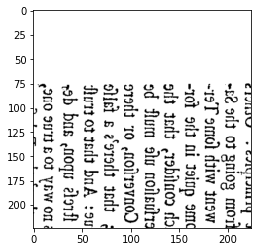

In [6]:
# 
# ========================================
# Check your data to make sure it is correct
# ========================================

# Need the __name__ check to make multiprocessing work on Windows for some reason
# if __name__ == '__main__':

for data in book_data_loaders['Defoe']['train']:
    # get the inputs
    inputs, labels = data

    # plot to verify the input is correct
    input1 = inputs[0].numpy()
    print(input1.shape)
    input1 = np.swapaxes(input1,0,2).squeeze()
    print(input1.shape)
    plt.imshow(input1,cmap='gray')

    break

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#from https://github.com/pytorch/examples/blob/master/mnist/main.py
class JQNet1(nn.Module):
    def __init__(self):
        super(JQNet1, self).__init__()
        if use_gpu:
            self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding = 1).cuda()
            self.conv2 = nn.Conv2d(10, 20, kernel_size=3, padding = 1).cuda()
            self.conv3 = nn.Conv2d(20, 40, kernel_size=3, padding = 1).cuda()
            self.conv2_drop = nn.Dropout2d(p = 0.2)
            self.conv3_drop = nn.Dropout2d(p = 0.1)

            #assumes a batch size of 50
            self.fc1 = nn.Linear(31360,64).cuda()
            self.fc2 = nn.Linear(64, 25).cuda()
            self.fc3 = nn.Linear(25,2).cuda()
        else:
            self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding = 1).cpu()
            self.conv2 = nn.Conv2d(10, 20, kernel_size=3, padding = 1).cpu()
            self.conv3 = nn.Conv2d(20, 40, kernel_size=3, padding = 1).cpu()
            self.conv2_drop = nn.Dropout2d(p = 0.2)
            self.conv3_drop = nn.Dropout2d(p = 0.1)

            #assumes a batch size of 50
            self.fc1 = nn.Linear(31360,64).cpu()
            self.fc2 = nn.Linear(64, 25).cpu()
            self.fc3 = nn.Linear(25,2).cpu()

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        
        x = x.view(x.size(0),-1) #clutch line
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        
        
        x = x.view(x.size(0),-1) #clutch line
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
        #return x

In [8]:
# ========================================
# Step 3. define model structure
#
# TODO: Stick with MNIST for now because it is smaller network and faster to train. Note that you lose
# a lot of inofmration when yo udownsample the image to 28x28. THat's okay, you optimize other parts first, e.g.,
# data loading before you optimize your model.
# ========================================
from lib.playground.utee import selector
from lib.playground.mnist import model
import os

def create_model_architecture(model_type='mnist'):
    """
    params model_type: the type of model, for now, support mnist and resnet18    
    """
    if model_type == 'mnist':
        print('using pretrained mnist model')
        
        # load the model from the playground library
        model_annotation, ds_fetcher, is_imagenet = selector.select('mnist')
        
        # remove last layer
        removed = list(model_annotation.model.children())[:-1]
        
        # add a front layer to account for new input
        # IMPORTANT, we need to update the self.input_dims of the MLP class
        removed = [nn.Linear(img_input_size*img_input_size,28*28), nn.ReLU()] + removed
        
        # formulate the layers
        model_annotation.model=torch.nn.Sequential(*removed)
        
        # add the new fc layer
        model_annotation.model.fc = torch.nn.Linear(256,2).cuda()
        
        # update the self.input_dims of the network
        model_annotation.input_dims = img_input_size * img_input_size                

    elif model_type == 'resnet18':    
        print("Transferring resnet18 and retraining with annotations dataset.")    
        model_annotation = models.resnet18(pretrained=True)
        num_params = sum(1 for i in model_annotation.parameters())

        # There are 10 layers (model_ft.children()) in resnet18
        # Freezing the first half of resnet18, freezing all params for layers 1-5
        max_layer = 5
        curr_layer = 1
        last_layer = None
        for child in model_annotation.children():
            if curr_layer <= max_layer:
                for param in child.parameters():
                    param.requires_grad = False
                last_layer = child
                curr_layer = curr_layer + 1
            else:
                break

        # Replace the final fully connected layer to perform binary classification
        num_ftrs = model_annotation.fc.in_features
        model_annotation.fc = nn.Linear(num_ftrs, 2)
        
    elif model_type == 'jq_net1':
        print("Creating JQ's net1.")
        model_annotation = JQNet1()
        

    # return
    if use_gpu:
        return model_annotation.cuda()
    else:
        return model_annotation.cpu()


In [9]:
# ========================================
# Step 4. define the training process.
#
# TODO: The basic process of train and validation is defined. Please implement the overall average validation 
# confusion matrix, meaning for each validation (after running all epochs), get the confusion matrix for that book,
# repeat this for the rest of 10 books. THen get the overall performance. Also, implement the early-stop as you
# originally has in your code. :) I removed them here for clarity. You can add them back. 
# ========================================


raw_loss = {'train': [], 'val' : []}
raw_accs = {'train': [], 'val' : []}

def train(model, criterion, optimizer, data_loaders, num_epochs=25, early_stopping = None):    
    since = time.time()
    
    # number of samples for normalization of loss
    num_samples = {p : sum([len(data_loaders[p][b].dataset) for b in data_loaders[p]]) for p in ['train', 'val']}

    # stop the training, validation, and test loop
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # looping parameters
        running_loss = 0.0
        running_corrects = 0
        confusion_matrix = tnt.meter.ConfusionMeter(2)
        
        # loop through train and val phase in each epoch
        for phase in ['train', 'val']:
            # check train or val
            if phase == 'train':                
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            # Iterate over each book
            running_loss = 0.0
            running_corrects = 0
            confusion_matrix = tnt.meter.ConfusionMeter(2)
            
            for book in tqdm_notebook(data_loaders[phase]): 
                for data in data_loaders[phase][book]:
                    # get the inputs;  wrap them in Variable and make them into gpu or not
                    inputs, labels = data # input size: [5, 1, 28, 28] ; keep the dummy color channel:1
                    if use_gpu:
                        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(phase == 'train'):
                        # forward
                        outputs = model(inputs)
                        _, preds = torch.max(outputs.data, 1)
                        loss = criterion(outputs, labels)

                        # back
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                        # Add to confusion matrix
                        confusion_matrix.add(outputs.data, labels.data)

                    # statistics
                    # Including inputs.size(0) scales the loss by the size of the batch
                    running_loss += (loss.item() * inputs.size(0))
                    running_corrects += torch.sum(preds == labels.data)
            
            # report evaluation
            print('Phase:%s' %phase)
            print('Confusion matrix:\n', confusion_matrix.conf)
            print('loss', running_loss)
            
            epoch_loss = float(running_loss) / float(num_samples[phase])
            epoch_acc = float(running_corrects) / float(num_samples[phase])
            
            raw_loss[phase].append(epoch_loss)
            raw_accs[phase].append(epoch_acc)
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    return model

In [10]:
def plot_losses(train_losses, val_losses, title, xlabel='Loss'):
    plt.plot(train_losses,label = "train")
    plt.plot(val_losses,label = "validation")
    plt.title(title)
    plt.ylabel(xlabel)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()


    print("Average Training Score: " + str(np.mean(train_losses)))
    print("Average Validation Score: " + str(np.mean(val_losses)))
#     print("Average Training Accuracy: " + str(np.mean(trainAccs)))
#     print("Average Validation Accuracy: " + str(np.mean(valAccs)))

use_gpu is True
Creating JQ's net1.
validating on book: 'Blackmore'
Epoch 0/499
----------



Phase:train
Confusion matrix:
 [[   1  724]
 [  23 1742]]
loss 1585.4338291287422



Phase:val
Confusion matrix:
 [[  0  36]
 [  0 292]]
loss 194.90072512626648
Epoch 1/499
----------



Phase:train
Confusion matrix:
 [[   1  724]
 [   3 1762]]
loss 1589.3139730095863



Phase:val
Confusion matrix:
 [[  0  36]
 [  0 292]]
loss 188.23184263706207
Epoch 2/499
----------



Phase:train
Confusion matrix:
 [[   0  725]
 [   0 1765]]
loss 1569.6173008084297



Phase:val
Confusion matrix:
 [[  0  36]
 [  0 292]]
loss 186.72493648529053
Epoch 3/499
----------



Phase:train
Confusion matrix:
 [[   0  725]
 [   0 1765]]
loss 1576.7454268932343



Phase:val
Confusion matrix:
 [[  0  36]
 [  0 292]]
loss 182.41772615909576
Epoch 4/499
----------



Phase:train
Confusion matrix:
 [[   1  724]
 [   2 1763]]
loss 1531.2977073788643



Phase:val
Confusion matrix:
 [[  0  36]
 [  0 292]]
loss 183.47734320163727
Epoch 5/499
----------



Phase:train
Confusion matrix:
 [[   0  725]
 [   0 1765]]
loss 1554.7416229248047



Phase:val
Confusion matrix:
 [[  0  36]
 [  0 292]]
loss 179.3093899488449
Epoch 6/499
----------



Phase:train
Confusion matrix:
 [[   0  725]
 [   0 1765]]
loss 1535.1668856143951



Phase:val
Confusion matrix:
 [[  0  36]
 [  0 292]]
loss 181.4068477153778
Epoch 7/499
----------



Phase:train
Confusion matrix:
 [[   0  725]
 [   0 1765]]
loss 1534.88955193758



Phase:val
Confusion matrix:
 [[  0  36]
 [  0 292]]
loss 170.38140511512756
Epoch 8/499
----------



Phase:train
Confusion matrix:
 [[   8  717]
 [   9 1756]]
loss 1511.214475184679



Phase:val
Confusion matrix:
 [[  0  36]
 [  0 292]]
loss 178.07368576526642
Epoch 9/499
----------



Phase:train
Confusion matrix:
 [[  30  695]
 [   5 1760]]
loss 1501.9451214075089



Phase:val
Confusion matrix:
 [[  0  36]
 [  0 292]]
loss 167.99662590026855
Epoch 10/499
----------



Phase:train
Confusion matrix:
 [[  83  642]
 [  31 1734]]
loss 1470.8938368558884



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 49 243]]
loss 195.2791292667389
Epoch 11/499
----------



Phase:train
Confusion matrix:
 [[ 103  622]
 [  26 1739]]
loss 1463.5872264802456



Phase:val
Confusion matrix:
 [[ 10  26]
 [  5 287]]
loss 169.34279537200928
Epoch 12/499
----------



Phase:train
Confusion matrix:
 [[  99  626]
 [  28 1737]]
loss 1465.315847158432



Phase:val
Confusion matrix:
 [[  9  27]
 [  4 288]]
loss 160.8258222937584
Epoch 13/499
----------



Phase:train
Confusion matrix:
 [[  96  629]
 [  27 1738]]
loss 1466.4526323080063



Phase:val
Confusion matrix:
 [[  9  27]
 [  4 288]]
loss 165.33874648809433
Epoch 14/499
----------



Phase:train
Confusion matrix:
 [[ 115  610]
 [  28 1737]]
loss 1439.4796960949898



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 32 260]]
loss 180.56588983535767
Epoch 15/499
----------



Phase:train
Confusion matrix:
 [[  25  700]
 [  12 1753]]
loss 1494.5270521640778



Phase:val
Confusion matrix:
 [[  0  36]
 [  0 292]]
loss 166.78278744220734
Epoch 16/499
----------



Phase:train
Confusion matrix:
 [[ 103  622]
 [  41 1724]]
loss 1461.365350395441



Phase:val
Confusion matrix:
 [[ 10  26]
 [ 12 280]]
loss 169.75316017866135
Epoch 17/499
----------



Phase:train
Confusion matrix:
 [[ 100  625]
 [  25 1740]]
loss 1458.0235390663147



Phase:val
Confusion matrix:
 [[  8  28]
 [  3 289]]
loss 158.78877609968185
Epoch 18/499
----------



Phase:train
Confusion matrix:
 [[ 112  613]
 [  21 1744]]
loss 1447.7609251141548



Phase:val
Confusion matrix:
 [[  9  27]
 [  4 288]]
loss 156.91501539945602
Epoch 19/499
----------



Phase:train
Confusion matrix:
 [[ 104  621]
 [  24 1741]]
loss 1450.8297467529774



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 69 223]]
loss 196.2160712480545
Epoch 20/499
----------



Phase:train
Confusion matrix:
 [[ 123  602]
 [  27 1738]]
loss 1433.067450851202



Phase:val
Confusion matrix:
 [[  9  27]
 [  7 285]]
loss 160.47449827194214
Epoch 21/499
----------



Phase:train
Confusion matrix:
 [[ 111  614]
 [  27 1738]]
loss 1455.5701392292976



Phase:val
Confusion matrix:
 [[  9  27]
 [  3 289]]
loss 152.6893727183342
Epoch 22/499
----------



Phase:train
Confusion matrix:
 [[ 121  604]
 [  36 1729]]
loss 1438.3431160449982



Phase:val
Confusion matrix:
 [[  9  27]
 [  4 288]]
loss 157.00985831022263
Epoch 23/499
----------



Phase:train
Confusion matrix:
 [[ 117  608]
 [  28 1737]]
loss 1416.687496125698



Phase:val
Confusion matrix:
 [[  9  27]
 [  4 288]]
loss 153.23225128650665
Epoch 24/499
----------



Phase:train
Confusion matrix:
 [[ 112  613]
 [  29 1736]]
loss 1419.5162407755852



Phase:val
Confusion matrix:
 [[  9  27]
 [  7 285]]
loss 162.3787897825241
Epoch 25/499
----------



Phase:train
Confusion matrix:
 [[ 117  608]
 [  32 1733]]
loss 1444.802076458931



Phase:val
Confusion matrix:
 [[  8  28]
 [ 13 279]]
loss 174.84758704900742
Epoch 26/499
----------



Phase:train
Confusion matrix:
 [[ 121  604]
 [  23 1742]]
loss 1419.2124386131763



Phase:val
Confusion matrix:
 [[  9  27]
 [  4 288]]
loss 154.29360556602478
Epoch 27/499
----------



Phase:train
Confusion matrix:
 [[ 130  595]
 [  25 1740]]
loss 1423.3102130293846



Phase:val
Confusion matrix:
 [[ 10  26]
 [  4 288]]
loss 156.35389190912247
Epoch 28/499
----------



Phase:train
Confusion matrix:
 [[ 133  592]
 [  32 1733]]
loss 1420.4706264436245



Phase:val
Confusion matrix:
 [[  8  28]
 [  3 289]]
loss 150.06397676467896
Epoch 29/499
----------



Phase:train
Confusion matrix:
 [[ 125  600]
 [  37 1728]]
loss 1407.9712961316109



Phase:val
Confusion matrix:
 [[ 10  26]
 [  4 288]]
loss 165.692580640316
Epoch 30/499
----------



Phase:train
Confusion matrix:
 [[ 132  593]
 [  32 1733]]
loss 1421.9340091347694



Phase:val
Confusion matrix:
 [[ 10  26]
 [  6 286]]
loss 166.7966484427452
Epoch 31/499
----------



Phase:train
Confusion matrix:
 [[ 123  602]
 [  33 1732]]
loss 1423.3202277421951



Phase:val
Confusion matrix:
 [[  7  29]
 [  3 289]]
loss 153.24167740345
Epoch 32/499
----------



Phase:train
Confusion matrix:
 [[ 123  602]
 [  30 1735]]
loss 1412.0677216649055



Phase:val
Confusion matrix:
 [[  8  28]
 [  6 286]]
loss 172.9182874560356
Epoch 33/499
----------



Phase:train
Confusion matrix:
 [[ 122  603]
 [  29 1736]]
loss 1427.3414545357227



Phase:val
Confusion matrix:
 [[  7  29]
 [  3 289]]
loss 155.28089994192123
Epoch 34/499
----------



Phase:train
Confusion matrix:
 [[ 119  606]
 [  26 1739]]
loss 1410.6326478421688



Phase:val
Confusion matrix:
 [[  7  29]
 [  4 288]]
loss 164.0424342751503
Epoch 35/499
----------



Phase:train
Confusion matrix:
 [[ 122  603]
 [  33 1732]]
loss 1398.2772909402847



Phase:val
Confusion matrix:
 [[  7  29]
 [  3 289]]
loss 157.76836496591568
Epoch 36/499
----------



Phase:train
Confusion matrix:
 [[ 135  590]
 [  33 1732]]
loss 1409.1540263593197



Phase:val
Confusion matrix:
 [[  8  28]
 [  4 288]]
loss 161.07687771320343
Epoch 37/499
----------



Phase:train
Confusion matrix:
 [[ 111  614]
 [  31 1734]]
loss 1438.4164100587368



Phase:val
Confusion matrix:
 [[  7  29]
 [  3 289]]
loss 158.1810051202774
Epoch 38/499
----------



Phase:train
Confusion matrix:
 [[ 127  598]
 [  34 1731]]
loss 1407.0919570624828



Phase:val
Confusion matrix:
 [[  7  29]
 [  3 289]]
loss 164.4742933511734
Epoch 39/499
----------



Phase:train
Confusion matrix:
 [[ 135  590]
 [  48 1717]]
loss 1402.197756499052



Phase:val
Confusion matrix:
 [[  7  29]
 [  3 289]]
loss 169.31235563755035
Epoch 40/499
----------



Phase:train
Confusion matrix:
 [[ 120  605]
 [  26 1739]]
loss 1413.8072953224182



Phase:val
Confusion matrix:
 [[  7  29]
 [  3 289]]
loss 162.73859548568726
Epoch 41/499
----------



Phase:train
Confusion matrix:
 [[ 141  584]
 [  36 1729]]
loss 1396.801897585392



Phase:val
Confusion matrix:
 [[  8  28]
 [  4 288]]
loss 169.46402549743652
Epoch 42/499
----------



Phase:train
Confusion matrix:
 [[ 137  588]
 [  34 1731]]
loss 1404.3424934744835



Phase:val
Confusion matrix:
 [[  7  29]
 [  8 284]]
loss 179.4892292022705
Epoch 43/499
----------



Phase:train
Confusion matrix:
 [[ 131  594]
 [  37 1728]]
loss 1417.7672525048256



Phase:val
Confusion matrix:
 [[  8  28]
 [  4 288]]
loss 166.1402968764305
Epoch 44/499
----------



Phase:train
Confusion matrix:
 [[ 136  589]
 [  33 1732]]
loss 1399.9401041269302



Phase:val
Confusion matrix:
 [[  9  27]
 [  4 288]]
loss 167.20526432991028
Epoch 45/499
----------



Phase:train
Confusion matrix:
 [[ 140  585]
 [  34 1731]]
loss 1401.1010290384293



Phase:val
Confusion matrix:
 [[  7  29]
 [  3 289]]
loss 164.0651534795761
Epoch 46/499
----------



Phase:train
Confusion matrix:
 [[ 131  594]
 [  33 1732]]
loss 1402.9306995272636



Phase:val
Confusion matrix:
 [[  8  28]
 [ 16 276]]
loss 176.23255836963654
Epoch 47/499
----------



Phase:train
Confusion matrix:
 [[ 138  587]
 [  44 1721]]
loss 1414.3369136154652



Phase:val
Confusion matrix:
 [[  9  27]
 [  4 288]]
loss 169.6569048166275
Epoch 48/499
----------



Phase:train
Confusion matrix:
 [[ 134  591]
 [  35 1730]]
loss 1396.888877660036



Phase:val
Confusion matrix:
 [[  9  27]
 [  4 288]]
loss 160.01995331048965
Epoch 49/499
----------



Phase:train
Confusion matrix:
 [[ 139  586]
 [  39 1726]]
loss 1408.14692273736



Phase:val
Confusion matrix:
 [[  8  28]
 [  4 288]]
loss 164.4664185643196
Epoch 50/499
----------



Phase:train
Confusion matrix:
 [[ 141  584]
 [  41 1724]]
loss 1402.558145672083



Phase:val
Confusion matrix:
 [[ 10  26]
 [ 23 269]]
loss 182.30927777290344
Epoch 51/499
----------



Phase:train
Confusion matrix:
 [[ 136  589]
 [  45 1720]]
loss 1404.3016589581966



Phase:val
Confusion matrix:
 [[  8  28]
 [  4 288]]
loss 173.69243371486664
Epoch 52/499
----------



Phase:train
Confusion matrix:
 [[ 140  585]
 [  46 1719]]
loss 1406.669158667326



Phase:val
Confusion matrix:
 [[  8  28]
 [  5 287]]
loss 162.27190041542053
Epoch 53/499
----------



Phase:train
Confusion matrix:
 [[ 137  588]
 [  33 1732]]
loss 1383.021357536316



Phase:val
Confusion matrix:
 [[  8  28]
 [  4 288]]
loss 160.52251702547073
Epoch 54/499
----------



Phase:train
Confusion matrix:
 [[ 139  586]
 [  38 1727]]
loss 1410.5459279119968



Phase:val
Confusion matrix:
 [[  8  28]
 [  4 288]]
loss 161.84274035692215
Epoch 55/499
----------



Phase:train
Confusion matrix:
 [[ 145  580]
 [  36 1729]]
loss 1388.527509778738



Phase:val
Confusion matrix:
 [[  9  27]
 [ 16 276]]
loss 171.13572150468826
Epoch 56/499
----------



Phase:train
Confusion matrix:
 [[ 140  585]
 [  40 1725]]
loss 1402.412299901247



Phase:val
Confusion matrix:
 [[  9  27]
 [  3 289]]
loss 161.06976735591888
Epoch 57/499
----------



Phase:train
Confusion matrix:
 [[ 152  573]
 [  52 1713]]
loss 1381.6424435079098



Phase:val
Confusion matrix:
 [[ 10  26]
 [  5 287]]
loss 175.5759655237198
Epoch 58/499
----------



Phase:train
Confusion matrix:
 [[ 157  568]
 [  52 1713]]
loss 1383.4342677295208



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 41 251]]
loss 189.7900013923645
Epoch 59/499
----------



Phase:train
Confusion matrix:
 [[ 149  576]
 [  43 1722]]
loss 1392.5520732104778



Phase:val
Confusion matrix:
 [[  8  28]
 [  4 288]]
loss 153.3436741232872
Epoch 60/499
----------



Phase:train
Confusion matrix:
 [[ 142  583]
 [  36 1729]]
loss 1393.3285902142525



Phase:val
Confusion matrix:
 [[ 10  26]
 [  5 287]]
loss 167.96546185016632
Epoch 61/499
----------



Phase:train
Confusion matrix:
 [[ 152  573]
 [  55 1710]]
loss 1402.9590834081173



Phase:val
Confusion matrix:
 [[ 10  26]
 [  4 288]]
loss 169.19793099164963
Epoch 62/499
----------



Phase:train
Confusion matrix:
 [[ 140  585]
 [  32 1733]]
loss 1396.629233211279



Phase:val
Confusion matrix:
 [[ 10  26]
 [  4 288]]
loss 166.296500146389
Epoch 63/499
----------



Phase:train
Confusion matrix:
 [[ 158  567]
 [  39 1726]]
loss 1368.5128332674503



Phase:val
Confusion matrix:
 [[ 10  26]
 [  4 288]]
loss 166.22856652736664
Epoch 64/499
----------



Phase:train
Confusion matrix:
 [[ 163  562]
 [  57 1708]]
loss 1376.0090520083904



Phase:val
Confusion matrix:
 [[  9  27]
 [ 12 280]]
loss 195.19455695152283
Epoch 65/499
----------



Phase:train
Confusion matrix:
 [[ 147  578]
 [  51 1714]]
loss 1397.1646996438503



Phase:val
Confusion matrix:
 [[  9  27]
 [  4 288]]
loss 174.40685951709747
Epoch 66/499
----------



Phase:train
Confusion matrix:
 [[ 143  582]
 [  42 1723]]
loss 1391.5712425410748



Phase:val
Confusion matrix:
 [[  9  27]
 [  4 288]]
loss 170.538434445858
Epoch 67/499
----------



Phase:train
Confusion matrix:
 [[ 153  572]
 [  47 1718]]
loss 1371.9541281163692



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 36 256]]
loss 188.95849704742432
Epoch 68/499
----------



Phase:train
Confusion matrix:
 [[ 163  562]
 [  60 1705]]
loss 1384.664666801691



Phase:val
Confusion matrix:
 [[  9  27]
 [  7 285]]
loss 176.5296483039856
Epoch 69/499
----------



Phase:train
Confusion matrix:
 [[ 142  583]
 [  45 1720]]
loss 1385.7806727588177



Phase:val
Confusion matrix:
 [[  8  28]
 [  4 288]]
loss 164.2395344376564
Epoch 70/499
----------



Phase:train
Confusion matrix:
 [[ 164  561]
 [  61 1704]]
loss 1367.8747182190418



Phase:val
Confusion matrix:
 [[  9  27]
 [ 11 281]]
loss 179.575239777565
Epoch 71/499
----------



Phase:train
Confusion matrix:
 [[ 169  556]
 [  64 1701]]
loss 1387.9129748046398



Phase:val
Confusion matrix:
 [[  9  27]
 [ 10 282]]
loss 172.30232536792755
Epoch 72/499
----------



Phase:train
Confusion matrix:
 [[ 154  571]
 [  40 1725]]
loss 1369.4457860589027



Phase:val
Confusion matrix:
 [[ 10  26]
 [ 13 279]]
loss 167.3421425819397
Epoch 73/499
----------



Phase:train
Confusion matrix:
 [[ 173  552]
 [  46 1719]]
loss 1363.6499347686768



Phase:val
Confusion matrix:
 [[ 10  26]
 [ 34 258]]
loss 172.20435082912445
Epoch 74/499
----------



Phase:train
Confusion matrix:
 [[ 169  556]
 [  55 1710]]
loss 1377.2597975432873



Phase:val
Confusion matrix:
 [[ 10  26]
 [ 52 240]]
loss 187.40924787521362
Epoch 75/499
----------



Phase:train
Confusion matrix:
 [[ 170  555]
 [  63 1702]]
loss 1376.0497574210167



Phase:val
Confusion matrix:
 [[  9  27]
 [  7 285]]
loss 178.7712580561638
Epoch 76/499
----------



Phase:train
Confusion matrix:
 [[ 163  562]
 [  58 1707]]
loss 1376.8379122912884



Phase:val
Confusion matrix:
 [[  9  27]
 [  4 288]]
loss 170.68389457464218
Epoch 77/499
----------



Phase:train
Confusion matrix:
 [[ 161  564]
 [  48 1717]]
loss 1366.423917323351



Phase:val
Confusion matrix:
 [[  9  27]
 [  4 288]]
loss 168.11793267726898
Epoch 78/499
----------



Phase:train
Confusion matrix:
 [[ 147  578]
 [  51 1714]]
loss 1369.3335096538067



Phase:val
Confusion matrix:
 [[  9  27]
 [  4 288]]
loss 176.11896258592606
Epoch 79/499
----------



Phase:train
Confusion matrix:
 [[ 167  558]
 [  51 1714]]
loss 1361.4420391321182



Phase:val
Confusion matrix:
 [[ 10  26]
 [  4 288]]
loss 171.53939175605774
Epoch 80/499
----------



Phase:train
Confusion matrix:
 [[ 169  556]
 [  54 1711]]
loss 1354.361626535654



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 162.27054244279861
Epoch 81/499
----------



Phase:train
Confusion matrix:
 [[ 159  566]
 [  42 1723]]
loss 1374.09453484416



Phase:val
Confusion matrix:
 [[ 10  26]
 [  4 288]]
loss 173.95016688108444
Epoch 82/499
----------



Phase:train
Confusion matrix:
 [[ 157  568]
 [  48 1717]]
loss 1365.786750793457



Phase:val
Confusion matrix:
 [[  9  27]
 [  3 289]]
loss 161.0334633588791
Epoch 83/499
----------



Phase:train
Confusion matrix:
 [[ 170  555]
 [  46 1719]]
loss 1361.2125361859798



Phase:val
Confusion matrix:
 [[  9  27]
 [ 23 269]]
loss 167.00632679462433
Epoch 84/499
----------



Phase:train
Confusion matrix:
 [[ 162  563]
 [  58 1707]]
loss 1366.0992949008942



Phase:val
Confusion matrix:
 [[ 10  26]
 [ 23 269]]
loss 169.02050441503525
Epoch 85/499
----------



Phase:train
Confusion matrix:
 [[ 173  552]
 [  66 1699]]
loss 1365.2290620207787



Phase:val
Confusion matrix:
 [[ 10  26]
 [  9 283]]
loss 168.55826038122177
Epoch 86/499
----------



Phase:train
Confusion matrix:
 [[ 171  554]
 [  68 1697]]
loss 1385.1939462125301



Phase:val
Confusion matrix:
 [[  9  27]
 [  7 285]]
loss 170.59302574396133
Epoch 87/499
----------



Phase:train
Confusion matrix:
 [[ 134  591]
 [  51 1714]]
loss 1395.3364791870117



Phase:val
Confusion matrix:
 [[  8  28]
 [  3 289]]
loss 173.31505072116852
Epoch 88/499
----------



Phase:train
Confusion matrix:
 [[ 156  569]
 [  63 1702]]
loss 1366.4616136848927



Phase:val
Confusion matrix:
 [[ 10  26]
 [ 60 232]]
loss 184.69399845600128
Epoch 89/499
----------



Phase:train
Confusion matrix:
 [[ 164  561]
 [  53 1712]]
loss 1366.251511335373



Phase:val
Confusion matrix:
 [[ 10  26]
 [ 57 235]]
loss 179.41538226604462
Epoch 90/499
----------



Phase:train
Confusion matrix:
 [[ 158  567]
 [  55 1710]]
loss 1374.8827066421509



Phase:val
Confusion matrix:
 [[  8  28]
 [  4 288]]
loss 158.09037590026855
Epoch 91/499
----------



Phase:train
Confusion matrix:
 [[ 160  565]
 [  56 1709]]
loss 1368.4265619814396



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 40 252]]
loss 177.17251777648926
Epoch 92/499
----------



Phase:train
Confusion matrix:
 [[ 166  559]
 [  56 1709]]
loss 1365.2255882322788



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 29 263]]
loss 172.97732055187225
Epoch 93/499
----------



Phase:train
Confusion matrix:
 [[ 177  548]
 [  59 1706]]
loss 1370.5415052473545



Phase:val
Confusion matrix:
 [[ 10  26]
 [ 24 268]]
loss 172.07158011198044
Epoch 94/499
----------



Phase:train
Confusion matrix:
 [[ 163  562]
 [  57 1708]]
loss 1352.0390031933784



Phase:val
Confusion matrix:
 [[ 10  26]
 [ 47 245]]
loss 173.7149710059166
Epoch 95/499
----------



Phase:train
Confusion matrix:
 [[ 162  563]
 [  61 1704]]
loss 1382.9161684513092



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 44 248]]
loss 176.41442477703094
Epoch 96/499
----------



Phase:train
Confusion matrix:
 [[ 171  554]
 [  70 1695]]
loss 1357.8754136562347



Phase:val
Confusion matrix:
 [[ 13  23]
 [116 176]]
loss 192.76617288589478
Epoch 97/499
----------



Phase:train
Confusion matrix:
 [[ 168  557]
 [  64 1701]]
loss 1365.3175747692585



Phase:val
Confusion matrix:
 [[ 10  26]
 [  8 284]]
loss 178.59537887573242
Epoch 98/499
----------



Phase:train
Confusion matrix:
 [[ 175  550]
 [  51 1714]]
loss 1374.6550254821777



Phase:val
Confusion matrix:
 [[ 10  26]
 [  4 288]]
loss 168.6647452712059
Epoch 99/499
----------



Phase:train
Confusion matrix:
 [[ 163  562]
 [  47 1718]]
loss 1372.1489715874195



Phase:val
Confusion matrix:
 [[  8  28]
 [  3 289]]
loss 148.73378372192383
Epoch 100/499
----------



Phase:train
Confusion matrix:
 [[ 165  560]
 [  53 1712]]
loss 1358.5654521286488



Phase:val
Confusion matrix:
 [[  9  27]
 [  4 288]]
loss 168.50767010450363
Epoch 101/499
----------



Phase:train
Confusion matrix:
 [[ 178  547]
 [  51 1714]]
loss 1347.8543348014355



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 18 274]]
loss 163.97020608186722
Epoch 102/499
----------



Phase:train
Confusion matrix:
 [[ 176  549]
 [  55 1710]]
loss 1348.5322531461716



Phase:val
Confusion matrix:
 [[ 10  26]
 [  5 287]]
loss 150.50617557764053
Epoch 103/499
----------



Phase:train
Confusion matrix:
 [[ 155  570]
 [  50 1715]]
loss 1366.3399757444859



Phase:val
Confusion matrix:
 [[  8  28]
 [  3 289]]
loss 150.27009785175323
Epoch 104/499
----------



Phase:train
Confusion matrix:
 [[ 160  565]
 [  47 1718]]
loss 1340.9314387440681



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 22 270]]
loss 171.3982263803482
Epoch 105/499
----------



Phase:train
Confusion matrix:
 [[ 175  550]
 [  61 1704]]
loss 1371.0495833158493



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 28 264]]
loss 171.20861172676086
Epoch 106/499
----------



Phase:train
Confusion matrix:
 [[ 180  545]
 [  67 1698]]
loss 1352.1522365510464



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 24 268]]
loss 171.79212713241577
Epoch 107/499
----------



Phase:train
Confusion matrix:
 [[ 180  545]
 [  51 1714]]
loss 1357.720943465829



Phase:val
Confusion matrix:
 [[ 10  26]
 [ 10 282]]
loss 160.10833758115768
Epoch 108/499
----------



Phase:train
Confusion matrix:
 [[ 185  540]
 [  59 1706]]
loss 1342.4241688549519



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 17 275]]
loss 171.06760436296463
Epoch 109/499
----------



Phase:train
Confusion matrix:
 [[ 172  553]
 [  50 1715]]
loss 1350.010702341795



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 20 272]]
loss 166.99271523952484
Epoch 110/499
----------



Phase:train
Confusion matrix:
 [[ 195  530]
 [  81 1684]]
loss 1343.377805262804



Phase:val
Confusion matrix:
 [[ 14  22]
 [116 176]]
loss 188.40130650997162
Epoch 111/499
----------



Phase:train
Confusion matrix:
 [[ 186  539]
 [  67 1698]]
loss 1353.1185607910156



Phase:val
Confusion matrix:
 [[ 10  26]
 [  4 288]]
loss 169.17464071512222
Epoch 112/499
----------



Phase:train
Confusion matrix:
 [[ 173  552]
 [  73 1692]]
loss 1361.3012043833733



Phase:val
Confusion matrix:
 [[  9  27]
 [  3 289]]
loss 170.70694088935852
Epoch 113/499
----------



Phase:train
Confusion matrix:
 [[ 175  550]
 [  57 1708]]
loss 1353.0995779633522



Phase:val
Confusion matrix:
 [[ 10  26]
 [  4 288]]
loss 175.1086295247078
Epoch 114/499
----------



Phase:train
Confusion matrix:
 [[ 186  539]
 [  51 1714]]
loss 1354.7533825933933



Phase:val
Confusion matrix:
 [[ 14  22]
 [ 95 197]]
loss 178.48932248353958
Epoch 115/499
----------



Phase:train
Confusion matrix:
 [[ 186  539]
 [  56 1709]]
loss 1342.3355287015438



Phase:val
Confusion matrix:
 [[  9  27]
 [  3 289]]
loss 171.68531602621078
Epoch 116/499
----------



Phase:train
Confusion matrix:
 [[ 182  543]
 [  56 1709]]
loss 1336.6978551149368



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 72 220]]
loss 172.76138108968735
Epoch 117/499
----------



Phase:train
Confusion matrix:
 [[ 172  553]
 [  48 1717]]
loss 1355.907056003809



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 54 238]]
loss 170.0163053870201
Epoch 118/499
----------



Phase:train
Confusion matrix:
 [[ 186  539]
 [  61 1704]]
loss 1351.1861389279366



Phase:val
Confusion matrix:
 [[ 13  23]
 [112 180]]
loss 181.40441191196442
Epoch 119/499
----------



Phase:train
Confusion matrix:
 [[ 194  531]
 [  74 1691]]
loss 1345.9970934689045



Phase:val
Confusion matrix:
 [[ 13  23]
 [127 165]]
loss 189.38909578323364
Epoch 120/499
----------



Phase:train
Confusion matrix:
 [[ 187  538]
 [  75 1690]]
loss 1339.1839375793934



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 170.5209862589836
Epoch 121/499
----------



Phase:train
Confusion matrix:
 [[ 176  549]
 [  58 1707]]
loss 1341.8917058706284



Phase:val
Confusion matrix:
 [[ 13  23]
 [ 50 242]]
loss 171.23164570331573
Epoch 122/499
----------



Phase:train
Confusion matrix:
 [[ 172  553]
 [  53 1712]]
loss 1368.9801353216171



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 38 254]]
loss 167.8280821442604
Epoch 123/499
----------



Phase:train
Confusion matrix:
 [[ 172  553]
 [  57 1708]]
loss 1349.0799781680107



Phase:val
Confusion matrix:
 [[ 13  23]
 [114 178]]
loss 182.33019196987152
Epoch 124/499
----------



Phase:train
Confusion matrix:
 [[ 171  554]
 [  56 1709]]
loss 1357.4633314013481



Phase:val
Confusion matrix:
 [[ 13  23]
 [ 84 208]]
loss 175.10055422782898
Epoch 125/499
----------



Phase:train
Confusion matrix:
 [[ 179  546]
 [  55 1710]]
loss 1329.3907543420792



Phase:val
Confusion matrix:
 [[ 13  23]
 [ 87 205]]
loss 179.3267023563385
Epoch 126/499
----------



Phase:train
Confusion matrix:
 [[ 179  546]
 [  51 1714]]
loss 1349.3604563474655



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 40 252]]
loss 170.6864761710167
Epoch 127/499
----------



Phase:train
Confusion matrix:
 [[ 183  542]
 [  62 1703]]
loss 1351.0753636360168



Phase:val
Confusion matrix:
 [[ 13  23]
 [ 69 223]]
loss 175.40446019172668
Epoch 128/499
----------



Phase:train
Confusion matrix:
 [[ 173  552]
 [  60 1705]]
loss 1344.7811487019062



Phase:val
Confusion matrix:
 [[ 13  23]
 [ 57 235]]
loss 174.41320657730103
Epoch 129/499
----------



Phase:train
Confusion matrix:
 [[ 190  535]
 [  60 1705]]
loss 1344.4905046224594



Phase:val
Confusion matrix:
 [[ 15  21]
 [ 77 215]]
loss 179.725057721138
Epoch 130/499
----------



Phase:train
Confusion matrix:
 [[ 201  524]
 [  77 1688]]
loss 1355.096726834774



Phase:val
Confusion matrix:
 [[ 10  26]
 [  4 288]]
loss 184.47804129123688
Epoch 131/499
----------



Phase:train
Confusion matrix:
 [[ 159  566]
 [  52 1713]]
loss 1369.9622566103935



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 178.08731770515442
Epoch 132/499
----------



Phase:train
Confusion matrix:
 [[ 161  564]
 [  54 1711]]
loss 1356.3967138826847



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 175.89571845531464
Epoch 133/499
----------



Phase:train
Confusion matrix:
 [[ 180  545]
 [  61 1704]]
loss 1359.7191565781832



Phase:val
Confusion matrix:
 [[  9  27]
 [  3 289]]
loss 158.12373453378677
Epoch 134/499
----------



Phase:train
Confusion matrix:
 [[ 166  559]
 [  47 1718]]
loss 1347.4199435710907



Phase:val
Confusion matrix:
 [[  8  28]
 [  3 289]]
loss 156.0943302512169
Epoch 135/499
----------



Phase:train
Confusion matrix:
 [[ 177  548]
 [  65 1700]]
loss 1335.4296330213547



Phase:val
Confusion matrix:
 [[ 13  23]
 [113 179]]
loss 186.38979530334473
Epoch 136/499
----------



Phase:train
Confusion matrix:
 [[ 200  525]
 [  70 1695]]
loss 1334.5579823553562



Phase:val
Confusion matrix:
 [[ 10  26]
 [  4 288]]
loss 178.4137372970581
Epoch 137/499
----------



Phase:train
Confusion matrix:
 [[ 179  546]
 [  50 1715]]
loss 1336.0926410257816



Phase:val
Confusion matrix:
 [[ 14  22]
 [102 190]]
loss 183.71443235874176
Epoch 138/499
----------



Phase:train
Confusion matrix:
 [[ 178  547]
 [  63 1702]]
loss 1357.4887951612473



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 173.69202196598053
Epoch 139/499
----------



Phase:train
Confusion matrix:
 [[ 172  553]
 [  53 1712]]
loss 1356.4623438119888



Phase:val
Confusion matrix:
 [[  9  27]
 [  3 289]]
loss 162.617704808712
Epoch 140/499
----------



Phase:train
Confusion matrix:
 [[ 175  550]
 [  41 1724]]
loss 1336.198183953762



Phase:val
Confusion matrix:
 [[ 13  23]
 [ 97 195]]
loss 179.84059011936188
Epoch 141/499
----------



Phase:train
Confusion matrix:
 [[ 183  542]
 [  84 1681]]
loss 1366.4878849685192



Phase:val
Confusion matrix:
 [[ 17  19]
 [131 161]]
loss 189.61942970752716
Epoch 142/499
----------



Phase:train
Confusion matrix:
 [[ 194  531]
 [  83 1682]]
loss 1356.0745109021664



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 181.7015636563301
Epoch 143/499
----------



Phase:train
Confusion matrix:
 [[ 175  550]
 [  65 1700]]
loss 1340.569184243679



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 90 202]]
loss 177.65054869651794
Epoch 144/499
----------



Phase:train
Confusion matrix:
 [[ 163  562]
 [  54 1711]]
loss 1350.2441159784794



Phase:val
Confusion matrix:
 [[ 14  22]
 [ 87 205]]
loss 174.7120037674904
Epoch 145/499
----------



Phase:train
Confusion matrix:
 [[ 176  549]
 [  68 1697]]
loss 1354.955724209547



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 166.777598798275
Epoch 146/499
----------



Phase:train
Confusion matrix:
 [[ 177  548]
 [  58 1707]]
loss 1339.623632311821



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 168.75729936361313
Epoch 147/499
----------



Phase:train
Confusion matrix:
 [[ 166  559]
 [  52 1713]]
loss 1345.1368242800236



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 173.10068279504776
Epoch 148/499
----------



Phase:train
Confusion matrix:
 [[ 182  543]
 [  51 1714]]
loss 1355.2251504063606



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 160.73840349912643
Epoch 149/499
----------



Phase:train
Confusion matrix:
 [[ 168  557]
 [  54 1711]]
loss 1353.3059181571007



Phase:val
Confusion matrix:
 [[ 10  26]
 [  4 288]]
loss 175.54715991020203
Epoch 150/499
----------



Phase:train
Confusion matrix:
 [[ 171  554]
 [  48 1717]]
loss 1339.0164383798838



Phase:val
Confusion matrix:
 [[ 10  26]
 [  6 286]]
loss 177.8112552165985
Epoch 151/499
----------



Phase:train
Confusion matrix:
 [[ 195  530]
 [  70 1695]]
loss 1339.7043788433075



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 180.6712235212326
Epoch 152/499
----------



Phase:train
Confusion matrix:
 [[ 186  539]
 [  57 1708]]
loss 1330.9952323138714



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 165.08161401748657
Epoch 153/499
----------



Phase:train
Confusion matrix:
 [[ 177  548]
 [  53 1712]]
loss 1343.8377002477646



Phase:val
Confusion matrix:
 [[ 10  26]
 [  4 288]]
loss 174.29457581043243
Epoch 154/499
----------



Phase:train
Confusion matrix:
 [[ 183  542]
 [  59 1706]]
loss 1362.3685982823372



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 163.80071711540222
Epoch 155/499
----------



Phase:train
Confusion matrix:
 [[ 159  566]
 [  57 1708]]
loss 1361.3858458697796



Phase:val
Confusion matrix:
 [[  9  27]
 [  3 289]]
loss 169.23802292346954
Epoch 156/499
----------



Phase:train
Confusion matrix:
 [[ 163  562]
 [  50 1715]]
loss 1348.444670677185



Phase:val
Confusion matrix:
 [[  9  27]
 [  3 289]]
loss 169.26155334711075
Epoch 157/499
----------



Phase:train
Confusion matrix:
 [[ 178  547]
 [  63 1702]]
loss 1339.704565629363



Phase:val
Confusion matrix:
 [[ 15  21]
 [ 78 214]]
loss 178.00151908397675
Epoch 158/499
----------



Phase:train
Confusion matrix:
 [[ 170  555]
 [  59 1706]]
loss 1355.8683098256588



Phase:val
Confusion matrix:
 [[ 12  24]
 [  3 289]]
loss 173.4654688835144
Epoch 159/499
----------



Phase:train
Confusion matrix:
 [[ 188  537]
 [  64 1701]]
loss 1357.3157641291618



Phase:val
Confusion matrix:
 [[ 12  24]
 [  3 289]]
loss 174.68815392255783
Epoch 160/499
----------



Phase:train
Confusion matrix:
 [[ 178  547]
 [  63 1702]]
loss 1355.2128129005432



Phase:val
Confusion matrix:
 [[ 12  24]
 [  3 289]]
loss 182.0071541070938
Epoch 161/499
----------



Phase:train
Confusion matrix:
 [[ 176  549]
 [  64 1701]]
loss 1355.2540501058102



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 166.73767060041428
Epoch 162/499
----------



Phase:train
Confusion matrix:
 [[ 181  544]
 [  65 1700]]
loss 1347.4716558754444



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 178.1634739637375
Epoch 163/499
----------



Phase:train
Confusion matrix:
 [[ 177  548]
 [  65 1700]]
loss 1362.470636099577



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 173.58074605464935
Epoch 164/499
----------



Phase:train
Confusion matrix:
 [[ 183  542]
 [  59 1706]]
loss 1337.2190578877926



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 187.51303005218506
Epoch 165/499
----------



Phase:train
Confusion matrix:
 [[ 184  541]
 [  56 1709]]
loss 1332.503540635109



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 172.05787819623947
Epoch 166/499
----------



Phase:train
Confusion matrix:
 [[ 198  527]
 [  59 1706]]
loss 1329.5341476798058



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 174.8680140376091
Epoch 167/499
----------



Phase:train
Confusion matrix:
 [[ 179  546]
 [  56 1709]]
loss 1335.5185281932354



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 175.51801198720932
Epoch 168/499
----------



Phase:train
Confusion matrix:
 [[ 178  547]
 [  68 1697]]
loss 1333.9672162532806



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 179.87896263599396
Epoch 169/499
----------



Phase:train
Confusion matrix:
 [[ 176  549]
 [  59 1706]]
loss 1313.0970887839794



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 170.9882249236107
Epoch 170/499
----------



Phase:train
Confusion matrix:
 [[ 185  540]
 [  61 1704]]
loss 1329.1575505435467



Phase:val
Confusion matrix:
 [[  9  27]
 [  3 289]]
loss 171.44390285015106
Epoch 171/499
----------



Phase:train
Confusion matrix:
 [[ 154  571]
 [  40 1725]]
loss 1364.3668049573898



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 164.34098547697067
Epoch 172/499
----------



Phase:train
Confusion matrix:
 [[ 178  547]
 [  47 1718]]
loss 1338.1777376234531



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 175.27522313594818
Epoch 173/499
----------



Phase:train
Confusion matrix:
 [[ 196  529]
 [  66 1699]]
loss 1338.311543405056



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 179.38637936115265
Epoch 174/499
----------



Phase:train
Confusion matrix:
 [[ 183  542]
 [  66 1699]]
loss 1345.2203164100647



Phase:val
Confusion matrix:
 [[ 10  26]
 [  5 287]]
loss 185.99323403835297
Epoch 175/499
----------



Phase:train
Confusion matrix:
 [[ 169  556]
 [  65 1700]]
loss 1363.4235710799694



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 181.1956261396408
Epoch 176/499
----------



Phase:train
Confusion matrix:
 [[ 168  557]
 [  62 1703]]
loss 1330.2652372270823



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 181.89814615249634
Epoch 177/499
----------



Phase:train
Confusion matrix:
 [[ 187  538]
 [  53 1712]]
loss 1329.713674157858



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 177.79054272174835
Epoch 178/499
----------



Phase:train
Confusion matrix:
 [[ 194  531]
 [  65 1700]]
loss 1329.4650925397873



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 177.54259705543518
Epoch 179/499
----------



Phase:train
Confusion matrix:
 [[ 187  538]
 [  59 1706]]
loss 1336.9805812835693



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 168.25789761543274
Epoch 180/499
----------



Phase:train
Confusion matrix:
 [[ 166  559]
 [  50 1715]]
loss 1348.3878144919872



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 175.57250916957855
Epoch 181/499
----------



Phase:train
Confusion matrix:
 [[ 174  551]
 [  55 1710]]
loss 1346.7810055017471



Phase:val
Confusion matrix:
 [[ 10  26]
 [  4 288]]
loss 175.92225980758667
Epoch 182/499
----------



Phase:train
Confusion matrix:
 [[ 192  533]
 [  52 1713]]
loss 1335.314475208521



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 172.98555159568787
Epoch 183/499
----------



Phase:train
Confusion matrix:
 [[ 181  544]
 [  62 1703]]
loss 1326.5837166905403



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 174.0155177116394
Epoch 184/499
----------



Phase:train
Confusion matrix:
 [[ 185  540]
 [  42 1723]]
loss 1323.618712902069



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 171.11488568782806
Epoch 185/499
----------



Phase:train
Confusion matrix:
 [[ 175  550]
 [  83 1682]]
loss 1350.5474346280098



Phase:val
Confusion matrix:
 [[ 12  24]
 [  5 287]]
loss 181.75878190994263
Epoch 186/499
----------



Phase:train
Confusion matrix:
 [[ 180  545]
 [  80 1685]]
loss 1367.196413218975



Phase:val
Confusion matrix:
 [[ 10  26]
 [  4 288]]
loss 176.47831618785858
Epoch 187/499
----------



Phase:train
Confusion matrix:
 [[ 174  551]
 [  60 1705]]
loss 1359.1116598546505



Phase:val
Confusion matrix:
 [[ 10  26]
 [  4 288]]
loss 168.75493037700653
Epoch 188/499
----------



Phase:train
Confusion matrix:
 [[ 176  549]
 [  51 1714]]
loss 1341.0934766829014



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 170.221934735775
Epoch 189/499
----------



Phase:train
Confusion matrix:
 [[ 158  567]
 [  48 1717]]
loss 1354.4435179829597



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 163.31164371967316
Epoch 190/499
----------



Phase:train
Confusion matrix:
 [[ 170  555]
 [  58 1707]]
loss 1329.726514518261



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 172.221604347229
Epoch 191/499
----------



Phase:train
Confusion matrix:
 [[ 184  541]
 [  79 1686]]
loss 1335.444441229105



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 181.91630601882935
Epoch 192/499
----------



Phase:train
Confusion matrix:
 [[ 179  546]
 [  56 1709]]
loss 1341.3027846515179



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 169.15316557884216
Epoch 193/499
----------



Phase:train
Confusion matrix:
 [[ 168  557]
 [  38 1727]]
loss 1344.7645874917507



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 169.9029644727707
Epoch 194/499
----------



Phase:train
Confusion matrix:
 [[ 189  536]
 [  48 1717]]
loss 1334.000755727291



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 173.65348768234253
Epoch 195/499
----------



Phase:train
Confusion matrix:
 [[ 168  557]
 [  51 1714]]
loss 1343.3402589261532



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 169.92577522993088
Epoch 196/499
----------



Phase:train
Confusion matrix:
 [[ 176  549]
 [  36 1729]]
loss 1330.3868743181229



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 166.02287662029266
Epoch 197/499
----------



Phase:train
Confusion matrix:
 [[ 178  547]
 [  50 1715]]
loss 1331.6107227802277



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 167.5827483534813
Epoch 198/499
----------



Phase:train
Confusion matrix:
 [[ 193  532]
 [  56 1709]]
loss 1320.1747963130474



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 169.90803861618042
Epoch 199/499
----------



Phase:train
Confusion matrix:
 [[ 170  555]
 [  55 1710]]
loss 1356.2980161905289



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 169.5437604188919
Epoch 200/499
----------



Phase:train
Confusion matrix:
 [[ 167  558]
 [  62 1703]]
loss 1345.8538621366024



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 173.8663913011551
Epoch 201/499
----------



Phase:train
Confusion matrix:
 [[ 187  538]
 [  76 1689]]
loss 1343.81402900815



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 171.26581978797913
Epoch 202/499
----------



Phase:train
Confusion matrix:
 [[ 167  558]
 [  42 1723]]
loss 1329.1193118691444



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 170.89503759145737
Epoch 203/499
----------



Phase:train
Confusion matrix:
 [[ 177  548]
 [  54 1711]]
loss 1344.8920851647854



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 176.10067915916443
Epoch 204/499
----------



Phase:train
Confusion matrix:
 [[ 176  549]
 [  53 1712]]
loss 1336.1949654221535



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 173.05648988485336
Epoch 205/499
----------



Phase:train
Confusion matrix:
 [[ 179  546]
 [  59 1706]]
loss 1356.9012788534164



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 158.4552412033081
Epoch 206/499
----------



Phase:train
Confusion matrix:
 [[ 166  559]
 [  51 1714]]
loss 1332.950347095728



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 165.5407730937004
Epoch 207/499
----------



Phase:train
Confusion matrix:
 [[ 186  539]
 [  60 1705]]
loss 1327.624848306179



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 163.79250931739807
Epoch 208/499
----------



Phase:train
Confusion matrix:
 [[ 174  551]
 [  43 1722]]
loss 1341.1722922623158



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 173.9039351940155
Epoch 209/499
----------



Phase:train
Confusion matrix:
 [[ 181  544]
 [  56 1709]]
loss 1350.7213023602962



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 174.0204198360443
Epoch 210/499
----------



Phase:train
Confusion matrix:
 [[ 183  542]
 [  54 1711]]
loss 1329.2778151929379



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 167.4679502248764
Epoch 211/499
----------



Phase:train
Confusion matrix:
 [[ 171  554]
 [  49 1716]]
loss 1340.2204713523388



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 173.5945382118225
Epoch 212/499
----------



Phase:train
Confusion matrix:
 [[ 189  536]
 [  58 1707]]
loss 1320.307851612568



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 173.81287932395935
Epoch 213/499
----------



Phase:train
Confusion matrix:
 [[ 203  522]
 [  70 1695]]
loss 1325.4429485201836



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 162.8567637205124
Epoch 214/499
----------



Phase:train
Confusion matrix:
 [[ 180  545]
 [  43 1722]]
loss 1329.4479030370712



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 161.00489181280136
Epoch 215/499
----------



Phase:train
Confusion matrix:
 [[ 165  560]
 [  46 1719]]
loss 1335.756827145815



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 172.78051060438156
Epoch 216/499
----------



Phase:train
Confusion matrix:
 [[ 183  542]
 [  51 1714]]
loss 1340.1221073269844



Phase:val
Confusion matrix:
 [[ 11  25]
 [  7 285]]
loss 177.86264753341675
Epoch 217/499
----------



Phase:train
Confusion matrix:
 [[ 186  539]
 [  69 1696]]
loss 1339.209520995617



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 11 281]]
loss 180.6640328168869
Epoch 218/499
----------



Phase:train
Confusion matrix:
 [[ 167  558]
 [  62 1703]]
loss 1334.7018373310566



Phase:val
Confusion matrix:
 [[ 11  25]
 [  8 284]]
loss 182.44150149822235
Epoch 219/499
----------



Phase:train
Confusion matrix:
 [[ 178  547]
 [  61 1704]]
loss 1326.9318962097168



Phase:val
Confusion matrix:
 [[ 11  25]
 [  6 286]]
loss 161.9546341896057
Epoch 220/499
----------



Phase:train
Confusion matrix:
 [[ 194  531]
 [  54 1711]]
loss 1336.0038213729858



Phase:val
Confusion matrix:
 [[ 11  25]
 [  8 284]]
loss 169.07791912555695
Epoch 221/499
----------



Phase:train
Confusion matrix:
 [[ 185  540]
 [  54 1711]]
loss 1323.0086098909378



Phase:val
Confusion matrix:
 [[ 11  25]
 [  6 286]]
loss 163.86625319719315
Epoch 222/499
----------



Phase:train
Confusion matrix:
 [[ 172  553]
 [  46 1719]]
loss 1331.794981777668



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 164.9185415506363
Epoch 223/499
----------



Phase:train
Confusion matrix:
 [[ 174  551]
 [  41 1724]]
loss 1327.6871266961098



Phase:val
Confusion matrix:
 [[ 11  25]
 [  6 286]]
loss 158.96238827705383
Epoch 224/499
----------



Phase:train
Confusion matrix:
 [[ 196  529]
 [  55 1710]]
loss 1305.1362559199333



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 170.8089724779129
Epoch 225/499
----------



Phase:train
Confusion matrix:
 [[ 192  533]
 [  69 1696]]
loss 1315.5549915134907



Phase:val
Confusion matrix:
 [[ 11  25]
 [  6 286]]
loss 171.94988578557968
Epoch 226/499
----------



Phase:train
Confusion matrix:
 [[ 176  549]
 [  57 1708]]
loss 1351.2183049023151



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 155.89793932437897
Epoch 227/499
----------



Phase:train
Confusion matrix:
 [[ 189  536]
 [  57 1708]]
loss 1311.4346051514149



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 172.75942081212997
Epoch 228/499
----------



Phase:train
Confusion matrix:
 [[ 185  540]
 [  62 1703]]
loss 1336.666857779026



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 164.78641492128372
Epoch 229/499
----------



Phase:train
Confusion matrix:
 [[ 185  540]
 [  59 1706]]
loss 1326.3301847875118



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 171.6622326374054
Epoch 230/499
----------



Phase:train
Confusion matrix:
 [[ 188  537]
 [  59 1706]]
loss 1337.2109115421772



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 167.91438496112823
Epoch 231/499
----------



Phase:train
Confusion matrix:
 [[ 189  536]
 [  44 1721]]
loss 1321.3881884515285



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 175.94882661104202
Epoch 232/499
----------



Phase:train
Confusion matrix:
 [[ 197  528]
 [  55 1710]]
loss 1341.4898780882359



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 172.7617513537407
Epoch 233/499
----------



Phase:train
Confusion matrix:
 [[ 176  549]
 [  63 1702]]
loss 1338.1750638782978



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 170.4284980893135
Epoch 234/499
----------



Phase:train
Confusion matrix:
 [[ 186  539]
 [  65 1700]]
loss 1320.3315904140472



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 175.80277001857758
Epoch 235/499
----------



Phase:train
Confusion matrix:
 [[ 173  552]
 [  56 1709]]
loss 1359.7949703931808



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 168.11597102880478
Epoch 236/499
----------



Phase:train
Confusion matrix:
 [[ 180  545]
 [  55 1710]]
loss 1336.1486075818539



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 174.38429248332977
Epoch 237/499
----------



Phase:train
Confusion matrix:
 [[ 175  550]
 [  57 1708]]
loss 1323.4963429868221



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 173.12591862678528
Epoch 238/499
----------



Phase:train
Confusion matrix:
 [[ 183  542]
 [  55 1710]]
loss 1324.5609294772148



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 174.96654856204987
Epoch 239/499
----------



Phase:train
Confusion matrix:
 [[ 171  554]
 [  61 1704]]
loss 1339.236468166113



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 171.24307775497437
Epoch 240/499
----------



Phase:train
Confusion matrix:
 [[ 192  533]
 [  63 1702]]
loss 1328.5666743516922



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 172.3358030319214
Epoch 241/499
----------



Phase:train
Confusion matrix:
 [[ 179  546]
 [  46 1719]]
loss 1305.6153871715069



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 173.29957783222198
Epoch 242/499
----------



Phase:train
Confusion matrix:
 [[ 178  547]
 [  49 1716]]
loss 1338.958601564169



Phase:val
Confusion matrix:
 [[ 10  26]
 [  4 288]]
loss 169.09857481718063
Epoch 243/499
----------



Phase:train
Confusion matrix:
 [[ 182  543]
 [  50 1715]]
loss 1325.826712846756



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 181.6184116601944
Epoch 244/499
----------



Phase:train
Confusion matrix:
 [[ 187  538]
 [  53 1712]]
loss 1317.0255219042301



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 171.61864948272705
Epoch 245/499
----------



Phase:train
Confusion matrix:
 [[ 182  543]
 [  54 1711]]
loss 1316.0790173113346



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 179.76687890291214
Epoch 246/499
----------



Phase:train
Confusion matrix:
 [[ 197  528]
 [  75 1690]]
loss 1322.3691546916962



Phase:val
Confusion matrix:
 [[ 12  24]
 [  8 284]]
loss 187.50403344631195
Epoch 247/499
----------



Phase:train
Confusion matrix:
 [[ 181  544]
 [  57 1708]]
loss 1333.261304706335



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 175.8671180009842
Epoch 248/499
----------



Phase:train
Confusion matrix:
 [[ 193  532]
 [  63 1702]]
loss 1318.6854662895203



Phase:val
Confusion matrix:
 [[ 11  25]
 [  6 286]]
loss 176.731586933136
Epoch 249/499
----------



Phase:train
Confusion matrix:
 [[ 196  529]
 [  63 1702]]
loss 1340.3148031234741



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 175.04649311304092
Epoch 250/499
----------



Phase:train
Confusion matrix:
 [[ 186  539]
 [  48 1717]]
loss 1309.7439537346363



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 167.6664667725563
Epoch 251/499
----------



Phase:train
Confusion matrix:
 [[ 191  534]
 [  63 1702]]
loss 1305.9495160281658



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 183.96465981006622
Epoch 252/499
----------



Phase:train
Confusion matrix:
 [[ 181  544]
 [  68 1697]]
loss 1329.177539050579



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 168.57707178592682
Epoch 253/499
----------



Phase:train
Confusion matrix:
 [[ 183  542]
 [  71 1694]]
loss 1342.527165234089



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 166.26952493190765
Epoch 254/499
----------



Phase:train
Confusion matrix:
 [[ 186  539]
 [  70 1695]]
loss 1319.6647737771273



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 183.48902320861816
Epoch 255/499
----------



Phase:train
Confusion matrix:
 [[ 172  553]
 [  59 1706]]
loss 1337.8704981207848



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 165.79654270410538
Epoch 256/499
----------



Phase:train
Confusion matrix:
 [[ 179  546]
 [  54 1711]]
loss 1321.2797421813011



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 163.97096049785614
Epoch 257/499
----------



Phase:train
Confusion matrix:
 [[ 188  537]
 [  48 1717]]
loss 1312.5848174989223



Phase:val
Confusion matrix:
 [[ 10  26]
 [  4 288]]
loss 170.38252556324005
Epoch 258/499
----------



Phase:train
Confusion matrix:
 [[ 185  540]
 [  53 1712]]
loss 1315.2736266553402



Phase:val
Confusion matrix:
 [[ 10  26]
 [  4 288]]
loss 176.78183829784393
Epoch 259/499
----------



Phase:train
Confusion matrix:
 [[ 189  536]
 [  65 1700]]
loss 1327.605220079422



Phase:val
Confusion matrix:
 [[ 11  25]
 [  6 286]]
loss 185.79301238059998
Epoch 260/499
----------



Phase:train
Confusion matrix:
 [[ 206  519]
 [  75 1690]]
loss 1314.716627418995



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 168.40341675281525
Epoch 261/499
----------



Phase:train
Confusion matrix:
 [[ 194  531]
 [  64 1701]]
loss 1298.1005319654942



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 29 263]]
loss 186.47900915145874
Epoch 262/499
----------



Phase:train
Confusion matrix:
 [[ 188  537]
 [  55 1710]]
loss 1318.632430613041



Phase:val
Confusion matrix:
 [[ 14  22]
 [ 57 235]]
loss 185.6372345685959
Epoch 263/499
----------



Phase:train
Confusion matrix:
 [[ 181  544]
 [  65 1700]]
loss 1323.6399894952774



Phase:val
Confusion matrix:
 [[ 13  23]
 [ 36 256]]
loss 174.32101041078568
Epoch 264/499
----------



Phase:train
Confusion matrix:
 [[ 190  535]
 [  65 1700]]
loss 1319.0550538301468



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 20 272]]
loss 178.2210099697113
Epoch 265/499
----------



Phase:train
Confusion matrix:
 [[ 181  544]
 [  64 1701]]
loss 1325.8436078429222



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 32 260]]
loss 180.9118801355362
Epoch 266/499
----------



Phase:train
Confusion matrix:
 [[ 192  533]
 [  66 1699]]
loss 1330.3191757798195



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 27 265]]
loss 178.24173486232758
Epoch 267/499
----------



Phase:train
Confusion matrix:
 [[ 178  547]
 [  72 1693]]
loss 1337.4332629740238



Phase:val
Confusion matrix:
 [[ 13  23]
 [ 16 276]]
loss 168.9548631310463
Epoch 268/499
----------



Phase:train
Confusion matrix:
 [[ 184  541]
 [  59 1706]]
loss 1320.266565978527



Phase:val
Confusion matrix:
 [[ 12  24]
 [  9 283]]
loss 156.75735980272293
Epoch 269/499
----------



Phase:train
Confusion matrix:
 [[ 171  554]
 [  65 1700]]
loss 1343.5341692864895



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 12 280]]
loss 162.43500113487244
Epoch 270/499
----------



Phase:train
Confusion matrix:
 [[ 171  554]
 [  57 1708]]
loss 1324.4816353917122



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 16 276]]
loss 173.13538366556168
Epoch 271/499
----------



Phase:train
Confusion matrix:
 [[ 182  543]
 [  50 1715]]
loss 1328.3676380217075



Phase:val
Confusion matrix:
 [[ 11  25]
 [  8 284]]
loss 167.00256264209747
Epoch 272/499
----------



Phase:train
Confusion matrix:
 [[ 186  539]
 [  47 1718]]
loss 1313.5376627147198



Phase:val
Confusion matrix:
 [[ 11  25]
 [  7 285]]
loss 164.1303772330284
Epoch 273/499
----------



Phase:train
Confusion matrix:
 [[ 187  538]
 [  55 1710]]
loss 1305.3697504997253



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 23 269]]
loss 175.78749632835388
Epoch 274/499
----------



Phase:train
Confusion matrix:
 [[ 194  531]
 [  68 1697]]
loss 1311.250616490841



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 13 279]]
loss 174.8167033791542
Epoch 275/499
----------



Phase:train
Confusion matrix:
 [[ 183  542]
 [  52 1713]]
loss 1335.542598605156



Phase:val
Confusion matrix:
 [[ 11  25]
 [  6 286]]
loss 156.43570935726166
Epoch 276/499
----------



Phase:train
Confusion matrix:
 [[ 171  554]
 [  48 1717]]
loss 1328.2363468110561



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 154.00931107997894
Epoch 277/499
----------



Phase:train
Confusion matrix:
 [[ 197  528]
 [  59 1706]]
loss 1326.9655500501394



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 157.55992513895035
Epoch 278/499
----------



Phase:train
Confusion matrix:
 [[ 180  545]
 [  58 1707]]
loss 1333.9509196281433



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 169.4860396385193
Epoch 279/499
----------



Phase:train
Confusion matrix:
 [[ 181  544]
 [  48 1717]]
loss 1319.684849858284



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 164.29494386911392
Epoch 280/499
----------



Phase:train
Confusion matrix:
 [[ 182  543]
 [  62 1703]]
loss 1331.3808501660824



Phase:val
Confusion matrix:
 [[ 10  26]
 [  4 288]]
loss 169.29732555150986
Epoch 281/499
----------



Phase:train
Confusion matrix:
 [[ 178  547]
 [  51 1714]]
loss 1311.0264676511288



Phase:val
Confusion matrix:
 [[ 10  26]
 [  4 288]]
loss 171.8332085609436
Epoch 282/499
----------



Phase:train
Confusion matrix:
 [[ 186  539]
 [  57 1708]]
loss 1329.8364890515804



Phase:val
Confusion matrix:
 [[ 10  26]
 [  4 288]]
loss 162.32335656881332
Epoch 283/499
----------



Phase:train
Confusion matrix:
 [[ 192  533]
 [  51 1714]]
loss 1310.3157075047493



Phase:val
Confusion matrix:
 [[ 10  26]
 [  6 286]]
loss 165.75642502307892
Epoch 284/499
----------



Phase:train
Confusion matrix:
 [[ 182  543]
 [  56 1709]]
loss 1306.335992127657



Phase:val
Confusion matrix:
 [[ 10  26]
 [  9 283]]
loss 168.38470828533173
Epoch 285/499
----------



Phase:train
Confusion matrix:
 [[ 181  544]
 [  58 1707]]
loss 1318.5536703169346



Phase:val
Confusion matrix:
 [[ 10  26]
 [  7 285]]
loss 169.19242465496063
Epoch 286/499
----------



Phase:train
Confusion matrix:
 [[ 180  545]
 [  56 1709]]
loss 1327.5930896699429



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 31 261]]
loss 170.58088737726212
Epoch 287/499
----------



Phase:train
Confusion matrix:
 [[ 192  533]
 [  58 1707]]
loss 1332.3024410903454



Phase:val
Confusion matrix:
 [[ 11  25]
 [  9 283]]
loss 155.87191772460938
Epoch 288/499
----------



Phase:train
Confusion matrix:
 [[ 174  551]
 [  55 1710]]
loss 1331.2876048386097



Phase:val
Confusion matrix:
 [[ 11  25]
 [  6 286]]
loss 162.91462022066116
Epoch 289/499
----------



Phase:train
Confusion matrix:
 [[ 179  546]
 [  56 1709]]
loss 1321.5581224262714



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 149.27268183231354
Epoch 290/499
----------



Phase:train
Confusion matrix:
 [[ 177  548]
 [  48 1717]]
loss 1327.3878619074821



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 153.06078451871872
Epoch 291/499
----------



Phase:train
Confusion matrix:
 [[ 184  541]
 [  48 1717]]
loss 1296.6183325350285



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 167.24070930480957
Epoch 292/499
----------



Phase:train
Confusion matrix:
 [[ 185  540]
 [  57 1708]]
loss 1326.4538425952196



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 163.023333132267
Epoch 293/499
----------



Phase:train
Confusion matrix:
 [[ 184  541]
 [  56 1709]]
loss 1328.7618209719658



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 158.70408189296722
Epoch 294/499
----------



Phase:train
Confusion matrix:
 [[ 185  540]
 [  50 1715]]
loss 1309.1757146418095



Phase:val
Confusion matrix:
 [[ 11  25]
 [  8 284]]
loss 153.68989717960358
Epoch 295/499
----------



Phase:train
Confusion matrix:
 [[ 195  530]
 [  48 1717]]
loss 1308.8148392438889



Phase:val
Confusion matrix:
 [[ 11  25]
 [  6 286]]
loss 151.20530664920807
Epoch 296/499
----------



Phase:train
Confusion matrix:
 [[ 184  541]
 [  57 1708]]
loss 1323.924860328436



Phase:val
Confusion matrix:
 [[ 11  25]
 [  6 286]]
loss 165.4608520269394
Epoch 297/499
----------



Phase:train
Confusion matrix:
 [[ 190  535]
 [  55 1710]]
loss 1315.6298426687717



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 23 269]]
loss 174.84183359146118
Epoch 298/499
----------



Phase:train
Confusion matrix:
 [[ 178  547]
 [  51 1714]]
loss 1316.706077799201



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 10 282]]
loss 168.76633006334305
Epoch 299/499
----------



Phase:train
Confusion matrix:
 [[ 183  542]
 [  55 1710]]
loss 1330.3470837771893



Phase:val
Confusion matrix:
 [[ 11  25]
 [  6 286]]
loss 165.22355097532272
Epoch 300/499
----------



Phase:train
Confusion matrix:
 [[ 178  547]
 [  54 1711]]
loss 1327.8760084211826



Phase:val
Confusion matrix:
 [[ 11  25]
 [  9 283]]
loss 176.4243968129158
Epoch 301/499
----------



Phase:train
Confusion matrix:
 [[ 182  543]
 [  63 1702]]
loss 1328.562105447054



Phase:val
Confusion matrix:
 [[ 11  25]
 [  7 285]]
loss 178.30668306350708
Epoch 302/499
----------



Phase:train
Confusion matrix:
 [[ 199  526]
 [  67 1698]]
loss 1317.6730893552303



Phase:val
Confusion matrix:
 [[ 11  25]
 [  6 286]]
loss 170.50383013486862
Epoch 303/499
----------



Phase:train
Confusion matrix:
 [[ 171  554]
 [  51 1714]]
loss 1323.9099804461002



Phase:val
Confusion matrix:
 [[ 11  25]
 [  6 286]]
loss 152.53132730722427
Epoch 304/499
----------



Phase:train
Confusion matrix:
 [[ 189  536]
 [  64 1701]]
loss 1318.9396497607231



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 15 277]]
loss 170.8509647846222
Epoch 305/499
----------



Phase:train
Confusion matrix:
 [[ 199  526]
 [  64 1701]]
loss 1308.3219709992409



Phase:val
Confusion matrix:
 [[ 11  25]
 [  8 284]]
loss 170.5844258069992
Epoch 306/499
----------



Phase:train
Confusion matrix:
 [[ 187  538]
 [  67 1698]]
loss 1331.4500285983086



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 170.04188930988312
Epoch 307/499
----------



Phase:train
Confusion matrix:
 [[ 193  532]
 [  76 1689]]
loss 1326.1060785204172



Phase:val
Confusion matrix:
 [[ 11  25]
 [  9 283]]
loss 169.80732131004333
Epoch 308/499
----------



Phase:train
Confusion matrix:
 [[ 190  535]
 [  69 1696]]
loss 1338.2606729269028



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 159.93307608366013
Epoch 309/499
----------



Phase:train
Confusion matrix:
 [[ 175  550]
 [  45 1720]]
loss 1321.8957149982452



Phase:val
Confusion matrix:
 [[ 12  24]
 [  4 288]]
loss 160.280355989933
Epoch 310/499
----------



Phase:train
Confusion matrix:
 [[ 194  531]
 [  65 1700]]
loss 1289.720242023468



Phase:val
Confusion matrix:
 [[ 12  24]
 [  4 288]]
loss 174.90053820610046
Epoch 311/499
----------



Phase:train
Confusion matrix:
 [[ 185  540]
 [  58 1707]]
loss 1333.5805487036705



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 162.58869248628616
Epoch 312/499
----------



Phase:train
Confusion matrix:
 [[ 193  532]
 [  67 1698]]
loss 1305.2732347249985



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 176.99980425834656
Epoch 313/499
----------



Phase:train
Confusion matrix:
 [[ 200  525]
 [  63 1702]]
loss 1314.1783057153225



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 165.7270228266716
Epoch 314/499
----------



Phase:train
Confusion matrix:
 [[ 185  540]
 [  57 1708]]
loss 1302.7276912629604



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 160.01350140571594
Epoch 315/499
----------



Phase:train
Confusion matrix:
 [[ 194  531]
 [  67 1698]]
loss 1305.6906113028526



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 169.7126848101616
Epoch 316/499
----------



Phase:train
Confusion matrix:
 [[ 171  554]
 [  61 1704]]
loss 1344.2631501555443



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 156.30546563863754
Epoch 317/499
----------



Phase:train
Confusion matrix:
 [[ 193  532]
 [  65 1700]]
loss 1300.7627845555544



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 166.67154264450073
Epoch 318/499
----------



Phase:train
Confusion matrix:
 [[ 194  531]
 [  55 1710]]
loss 1297.6073033213615



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 163.87141877412796
Epoch 319/499
----------



Phase:train
Confusion matrix:
 [[ 193  532]
 [  59 1706]]
loss 1320.6276378929615



Phase:val
Confusion matrix:
 [[ 11  25]
 [  6 286]]
loss 169.32462882995605
Epoch 320/499
----------



Phase:train
Confusion matrix:
 [[ 190  535]
 [  53 1712]]
loss 1313.9996929466724



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 165.8711580634117
Epoch 321/499
----------



Phase:train
Confusion matrix:
 [[ 179  546]
 [  49 1716]]
loss 1308.4973004460335



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 12 280]]
loss 156.31921619176865
Epoch 322/499
----------



Phase:train
Confusion matrix:
 [[ 198  527]
 [  79 1686]]
loss 1323.6910790503025



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 50 242]]
loss 171.74533867835999
Epoch 323/499
----------



Phase:train
Confusion matrix:
 [[ 189  536]
 [  53 1712]]
loss 1314.7407953739166



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 43 249]]
loss 168.80126696825027
Epoch 324/499
----------



Phase:train
Confusion matrix:
 [[ 198  527]
 [  74 1691]]
loss 1301.2226091474295



Phase:val
Confusion matrix:
 [[ 14  22]
 [ 73 219]]
loss 174.27231031656265
Epoch 325/499
----------



Phase:train
Confusion matrix:
 [[ 188  537]
 [  69 1696]]
loss 1309.9040727615356



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 42 250]]
loss 165.42494821548462
Epoch 326/499
----------



Phase:train
Confusion matrix:
 [[ 207  518]
 [  73 1692]]
loss 1304.1999998092651



Phase:val
Confusion matrix:
 [[ 18  18]
 [ 81 211]]
loss 178.85498428344727
Epoch 327/499
----------



Phase:train
Confusion matrix:
 [[ 206  519]
 [  62 1703]]
loss 1316.14428922534



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 33 259]]
loss 163.46997290849686
Epoch 328/499
----------



Phase:train
Confusion matrix:
 [[ 188  537]
 [  49 1716]]
loss 1317.9962501823902



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 151.4219599366188
Epoch 329/499
----------



Phase:train
Confusion matrix:
 [[ 193  532]
 [  51 1714]]
loss 1294.267131894827



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 45 247]]
loss 172.3248868584633
Epoch 330/499
----------



Phase:train
Confusion matrix:
 [[ 203  522]
 [  64 1701]]
loss 1295.5938547253609



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 22 270]]
loss 159.9539845585823
Epoch 331/499
----------



Phase:train
Confusion matrix:
 [[ 183  542]
 [  61 1704]]
loss 1325.764019459486



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 43 249]]
loss 170.5105630159378
Epoch 332/499
----------



Phase:train
Confusion matrix:
 [[ 203  522]
 [  68 1697]]
loss 1312.3132810294628



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 51 241]]
loss 171.68340575695038
Epoch 333/499
----------



Phase:train
Confusion matrix:
 [[ 215  510]
 [  62 1703]]
loss 1305.6140084564686



Phase:val
Confusion matrix:
 [[ 14  22]
 [ 75 217]]
loss 176.27090466022491
Epoch 334/499
----------



Phase:train
Confusion matrix:
 [[ 192  533]
 [  55 1710]]
loss 1304.800991654396



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 27 265]]
loss 162.37726467847824
Epoch 335/499
----------



Phase:train
Confusion matrix:
 [[ 170  555]
 [  56 1709]]
loss 1329.7800220549107



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 37 255]]
loss 166.93928956985474
Epoch 336/499
----------



Phase:train
Confusion matrix:
 [[ 198  527]
 [  61 1704]]
loss 1312.823405712843



Phase:val
Confusion matrix:
 [[ 14  22]
 [ 66 226]]
loss 179.60314893722534
Epoch 337/499
----------



Phase:train
Confusion matrix:
 [[ 205  520]
 [  76 1689]]
loss 1286.1234131455421



Phase:val
Confusion matrix:
 [[ 14  22]
 [ 66 226]]
loss 179.89872336387634
Epoch 338/499
----------



Phase:train
Confusion matrix:
 [[ 208  517]
 [  94 1671]]
loss 1310.4240530133247



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 154.6255585551262
Epoch 339/499
----------



Phase:train
Confusion matrix:
 [[ 199  526]
 [  67 1698]]
loss 1317.3279944360256



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 158.72879713773727
Epoch 340/499
----------



Phase:train
Confusion matrix:
 [[ 177  548]
 [  72 1693]]
loss 1319.4027466475964



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 162.48183113336563
Epoch 341/499
----------



Phase:train
Confusion matrix:
 [[ 199  526]
 [  63 1702]]
loss 1294.9705095887184



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 167.38180762529373
Epoch 342/499
----------



Phase:train
Confusion matrix:
 [[ 207  518]
 [  72 1693]]
loss 1295.8548508882523



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 169.53851878643036
Epoch 343/499
----------



Phase:train
Confusion matrix:
 [[ 204  521]
 [  74 1691]]
loss 1302.674930036068



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 167.44474905729294
Epoch 344/499
----------



Phase:train
Confusion matrix:
 [[ 207  518]
 [  76 1689]]
loss 1293.3278236091137



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 155.67214781045914
Epoch 345/499
----------



Phase:train
Confusion matrix:
 [[ 189  536]
 [  54 1711]]
loss 1299.2323979437351



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 150.04632782936096
Epoch 346/499
----------



Phase:train
Confusion matrix:
 [[ 191  534]
 [  66 1699]]
loss 1310.0312378108501



Phase:val
Confusion matrix:
 [[ 12  24]
 [  6 286]]
loss 160.12209445238113
Epoch 347/499
----------



Phase:train
Confusion matrix:
 [[ 204  521]
 [  64 1701]]
loss 1303.030852228403



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 160.9671407341957
Epoch 348/499
----------



Phase:train
Confusion matrix:
 [[ 190  535]
 [  54 1711]]
loss 1302.650266468525



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 160.62578707933426
Epoch 349/499
----------



Phase:train
Confusion matrix:
 [[ 191  534]
 [  51 1714]]
loss 1286.3282214850187



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 173.08194202184677
Epoch 350/499
----------



Phase:train
Confusion matrix:
 [[ 206  519]
 [  76 1689]]
loss 1285.2348316311836



Phase:val
Confusion matrix:
 [[ 11  25]
 [  8 284]]
loss 167.61908620595932
Epoch 351/499
----------



Phase:train
Confusion matrix:
 [[ 194  531]
 [  56 1709]]
loss 1311.9197699725628



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 155.01027911901474
Epoch 352/499
----------



Phase:train
Confusion matrix:
 [[ 205  520]
 [  53 1712]]
loss 1297.0384929776192



Phase:val
Confusion matrix:
 [[ 11  25]
 [  6 286]]
loss 155.5031196475029
Epoch 353/499
----------



Phase:train
Confusion matrix:
 [[ 211  514]
 [  79 1686]]
loss 1293.1700839102268



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 160.1932247877121
Epoch 354/499
----------



Phase:train
Confusion matrix:
 [[ 171  554]
 [  49 1716]]
loss 1323.0966956913471



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 154.86291301250458
Epoch 355/499
----------



Phase:train
Confusion matrix:
 [[ 202  523]
 [  59 1706]]
loss 1290.2890867888927



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 164.48759365081787
Epoch 356/499
----------



Phase:train
Confusion matrix:
 [[ 194  531]
 [  59 1706]]
loss 1324.790771394968



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 160.8836350440979
Epoch 357/499
----------



Phase:train
Confusion matrix:
 [[ 189  536]
 [  54 1711]]
loss 1301.7623799741268



Phase:val
Confusion matrix:
 [[ 11  25]
 [  6 286]]
loss 165.48668444156647
Epoch 358/499
----------



Phase:train
Confusion matrix:
 [[ 179  546]
 [  73 1692]]
loss 1316.1394320428371



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 178.46009385585785
Epoch 359/499
----------



Phase:train
Confusion matrix:
 [[ 193  532]
 [  60 1705]]
loss 1301.2945665717125



Phase:val
Confusion matrix:
 [[ 11  25]
 [  7 285]]
loss 164.386156976223
Epoch 360/499
----------



Phase:train
Confusion matrix:
 [[ 172  553]
 [  52 1713]]
loss 1312.4212429523468



Phase:val
Confusion matrix:
 [[ 11  25]
 [  6 286]]
loss 158.03357034921646
Epoch 361/499
----------



Phase:train
Confusion matrix:
 [[ 207  518]
 [  65 1700]]
loss 1297.0691424906254



Phase:val
Confusion matrix:
 [[ 13  23]
 [ 12 280]]
loss 168.86202698946
Epoch 362/499
----------



Phase:train
Confusion matrix:
 [[ 194  531]
 [  61 1704]]
loss 1295.197243899107



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 12 280]]
loss 166.02457708120346
Epoch 363/499
----------



Phase:train
Confusion matrix:
 [[ 196  529]
 [  67 1698]]
loss 1307.6511949896812



Phase:val
Confusion matrix:
 [[ 10  26]
 [  4 288]]
loss 151.62125957012177
Epoch 364/499
----------



Phase:train
Confusion matrix:
 [[ 202  523]
 [  52 1713]]
loss 1286.070269331336



Phase:val
Confusion matrix:
 [[ 11  25]
 [  6 286]]
loss 155.19187408685684
Epoch 365/499
----------



Phase:train
Confusion matrix:
 [[ 184  541]
 [  45 1720]]
loss 1316.7781684547663



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 11 281]]
loss 163.81931966543198
Epoch 366/499
----------



Phase:train
Confusion matrix:
 [[ 177  548]
 [  56 1709]]
loss 1313.076779037714



Phase:val
Confusion matrix:
 [[ 13  23]
 [ 15 277]]
loss 161.05311703681946
Epoch 367/499
----------



Phase:train
Confusion matrix:
 [[ 190  535]
 [  49 1716]]
loss 1303.7341230213642



Phase:val
Confusion matrix:
 [[ 10  26]
 [  7 285]]
loss 151.06318074464798
Epoch 368/499
----------



Phase:train
Confusion matrix:
 [[ 189  536]
 [  58 1707]]
loss 1313.2501829862595



Phase:val
Confusion matrix:
 [[ 10  26]
 [  4 288]]
loss 142.88399440050125
Epoch 369/499
----------



Phase:train
Confusion matrix:
 [[ 194  531]
 [  61 1704]]
loss 1306.608207911253



Phase:val
Confusion matrix:
 [[ 12  24]
 [  4 288]]
loss 149.93465214967728
Epoch 370/499
----------



Phase:train
Confusion matrix:
 [[ 186  539]
 [  46 1719]]
loss 1314.041218727827



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 151.99092918634415
Epoch 371/499
----------



Phase:train
Confusion matrix:
 [[ 190  535]
 [  57 1708]]
loss 1305.9232757091522



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 16 276]]
loss 157.3090370297432
Epoch 372/499
----------



Phase:train
Confusion matrix:
 [[ 194  531]
 [  61 1704]]
loss 1311.7760291695595



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 152.21985441446304
Epoch 373/499
----------



Phase:train
Confusion matrix:
 [[ 180  545]
 [  46 1719]]
loss 1310.4458590000868



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 150.12784945964813
Epoch 374/499
----------



Phase:train
Confusion matrix:
 [[ 198  527]
 [  52 1713]]
loss 1296.8357393741608



Phase:val
Confusion matrix:
 [[ 12  24]
 [  7 285]]
loss 152.11492854356766
Epoch 375/499
----------



Phase:train
Confusion matrix:
 [[ 192  533]
 [  67 1698]]
loss 1308.0730765759945



Phase:val
Confusion matrix:
 [[ 11  25]
 [  6 286]]
loss 155.46386975049973
Epoch 376/499
----------



Phase:train
Confusion matrix:
 [[ 197  528]
 [  58 1707]]
loss 1290.0782084167004



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 29 263]]
loss 163.99728852510452
Epoch 377/499
----------



Phase:train
Confusion matrix:
 [[ 186  539]
 [  66 1699]]
loss 1308.5645499527454



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 153.05384957790375
Epoch 378/499
----------



Phase:train
Confusion matrix:
 [[ 179  546]
 [  55 1710]]
loss 1321.2048752903938



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 146.26392596960068
Epoch 379/499
----------



Phase:train
Confusion matrix:
 [[ 195  530]
 [  57 1708]]
loss 1288.2475724369287



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 158.81430393457413
Epoch 380/499
----------



Phase:train
Confusion matrix:
 [[ 184  541]
 [  66 1699]]
loss 1314.906721830368



Phase:val
Confusion matrix:
 [[ 11  25]
 [  6 286]]
loss 160.21983432769775
Epoch 381/499
----------



Phase:train
Confusion matrix:
 [[ 193  532]
 [  54 1711]]
loss 1307.9299955070019



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 147.91762328147888
Epoch 382/499
----------



Phase:train
Confusion matrix:
 [[ 182  543]
 [  48 1717]]
loss 1311.6334836781025



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 163.0296243429184
Epoch 383/499
----------



Phase:train
Confusion matrix:
 [[ 188  537]
 [  66 1699]]
loss 1301.9168975651264



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 158.91661655902863
Epoch 384/499
----------



Phase:train
Confusion matrix:
 [[ 193  532]
 [  62 1703]]
loss 1293.5322810709476



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 144.87367832660675
Epoch 385/499
----------



Phase:train
Confusion matrix:
 [[ 185  540]
 [  56 1709]]
loss 1315.9389080405235



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 156.9451680779457
Epoch 386/499
----------



Phase:train
Confusion matrix:
 [[ 197  528]
 [  64 1701]]
loss 1296.7202340960503



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 148.79326802492142
Epoch 387/499
----------



Phase:train
Confusion matrix:
 [[ 187  538]
 [  64 1701]]
loss 1325.0151522159576



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 144.07698410749435
Epoch 388/499
----------



Phase:train
Confusion matrix:
 [[ 179  546]
 [  48 1717]]
loss 1311.9836238324642



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 150.26044684648514
Epoch 389/499
----------



Phase:train
Confusion matrix:
 [[ 192  533]
 [  60 1705]]
loss 1313.6475601494312



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 151.5967310667038
Epoch 390/499
----------



Phase:train
Confusion matrix:
 [[ 189  536]
 [  72 1693]]
loss 1305.7242214083672



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 156.94365656375885
Epoch 391/499
----------



Phase:train
Confusion matrix:
 [[ 206  519]
 [  64 1701]]
loss 1273.7567211985588



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 152.98220962285995
Epoch 392/499
----------



Phase:train
Confusion matrix:
 [[ 197  528]
 [  70 1695]]
loss 1305.636148482561



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 165.07608580589294
Epoch 393/499
----------



Phase:train
Confusion matrix:
 [[ 191  534]
 [  63 1702]]
loss 1311.3419307768345



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 146.03152668476105
Epoch 394/499
----------



Phase:train
Confusion matrix:
 [[ 192  533]
 [  61 1704]]
loss 1299.0551775693893



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 154.15148824453354
Epoch 395/499
----------



Phase:train
Confusion matrix:
 [[ 189  536]
 [  56 1709]]
loss 1308.182128638029



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 161.68203538656235
Epoch 396/499
----------



Phase:train
Confusion matrix:
 [[ 191  534]
 [  72 1693]]
loss 1291.8871904611588



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 171.45773965120316
Epoch 397/499
----------



Phase:train
Confusion matrix:
 [[ 202  523]
 [  62 1703]]
loss 1309.917294666171



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 153.45229351520538
Epoch 398/499
----------



Phase:train
Confusion matrix:
 [[ 196  529]
 [  62 1703]]
loss 1286.3589508235455



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 143.5333792567253
Epoch 399/499
----------



Phase:train
Confusion matrix:
 [[ 212  513]
 [  69 1696]]
loss 1284.5205217599869



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 162.78877180814743
Epoch 400/499
----------



Phase:train
Confusion matrix:
 [[ 198  527]
 [  71 1694]]
loss 1300.8738114833832



Phase:val
Confusion matrix:
 [[ 12  24]
 [  5 287]]
loss 161.29123562574387
Epoch 401/499
----------



Phase:train
Confusion matrix:
 [[ 187  538]
 [  64 1701]]
loss 1315.0316948592663



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 146.83135843276978
Epoch 402/499
----------



Phase:train
Confusion matrix:
 [[ 185  540]
 [  55 1710]]
loss 1297.1151778697968



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 159.12738782167435
Epoch 403/499
----------



Phase:train
Confusion matrix:
 [[ 186  539]
 [  60 1705]]
loss 1312.4537567645311



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 148.27656018733978
Epoch 404/499
----------



Phase:train
Confusion matrix:
 [[ 179  546]
 [  43 1722]]
loss 1300.5174962878227



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 142.30864304304123
Epoch 405/499
----------



Phase:train
Confusion matrix:
 [[ 196  529]
 [  58 1707]]
loss 1291.8239441514015



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 143.85389930009842
Epoch 406/499
----------



Phase:train
Confusion matrix:
 [[ 195  530]
 [  67 1698]]
loss 1300.505175203085



Phase:val
Confusion matrix:
 [[ 12  24]
 [  3 289]]
loss 167.78860074281693
Epoch 407/499
----------



Phase:train
Confusion matrix:
 [[ 179  546]
 [  69 1696]]
loss 1306.5931985378265



Phase:val
Confusion matrix:
 [[ 12  24]
 [  3 289]]
loss 164.6750596165657
Epoch 408/499
----------



Phase:train
Confusion matrix:
 [[ 210  515]
 [  75 1690]]
loss 1288.0364294052124



Phase:val
Confusion matrix:
 [[ 12  24]
 [  4 288]]
loss 170.3722842335701
Epoch 409/499
----------



Phase:train
Confusion matrix:
 [[ 192  533]
 [  64 1701]]
loss 1274.8501351773739



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 158.45657312870026
Epoch 410/499
----------



Phase:train
Confusion matrix:
 [[ 190  535]
 [  64 1701]]
loss 1306.0993054509163



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 174.55224740505219
Epoch 411/499
----------



Phase:train
Confusion matrix:
 [[ 186  539]
 [  66 1699]]
loss 1289.444558084011



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 164.77283066511154
Epoch 412/499
----------



Phase:train
Confusion matrix:
 [[ 189  536]
 [  66 1699]]
loss 1311.3119267225266



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 157.93993389606476
Epoch 413/499
----------



Phase:train
Confusion matrix:
 [[ 187  538]
 [  65 1700]]
loss 1316.6839515566826



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 167.72163194417953
Epoch 414/499
----------



Phase:train
Confusion matrix:
 [[ 198  527]
 [  50 1715]]
loss 1283.4107359945774



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 155.6550993323326
Epoch 415/499
----------



Phase:train
Confusion matrix:
 [[ 194  531]
 [  51 1714]]
loss 1281.743490487337



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 161.01109331846237
Epoch 416/499
----------



Phase:train
Confusion matrix:
 [[ 183  542]
 [  51 1714]]
loss 1301.9734800457954



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 143.6840682029724
Epoch 417/499
----------



Phase:train
Confusion matrix:
 [[ 178  547]
 [  51 1714]]
loss 1294.5454837232828



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 143.7955756187439
Epoch 418/499
----------



Phase:train
Confusion matrix:
 [[ 190  535]
 [  50 1715]]
loss 1274.552640080452



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 143.65289849042892
Epoch 419/499
----------



Phase:train
Confusion matrix:
 [[ 195  530]
 [  60 1705]]
loss 1279.7803779542446



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 154.35384339094162
Epoch 420/499
----------



Phase:train
Confusion matrix:
 [[ 192  533]
 [  56 1709]]
loss 1266.966916680336



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 155.1674929857254
Epoch 421/499
----------



Phase:train
Confusion matrix:
 [[ 200  525]
 [  58 1707]]
loss 1291.357880473137



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 145.80539017915726
Epoch 422/499
----------



Phase:train
Confusion matrix:
 [[ 196  529]
 [  75 1690]]
loss 1286.0328595936298



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 164.39163661003113
Epoch 423/499
----------



Phase:train
Confusion matrix:
 [[ 194  531]
 [  69 1696]]
loss 1310.9830438494682



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 152.15202289819717
Epoch 424/499
----------



Phase:train
Confusion matrix:
 [[ 207  518]
 [  52 1713]]
loss 1257.2821408808231



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 168.04905396699905
Epoch 425/499
----------



Phase:train
Confusion matrix:
 [[ 190  535]
 [  58 1707]]
loss 1289.4808292388916



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 144.7701027393341
Epoch 426/499
----------



Phase:train
Confusion matrix:
 [[ 209  516]
 [  59 1706]]
loss 1250.7205271422863



Phase:val
Confusion matrix:
 [[ 12  24]
 [  7 285]]
loss 161.86327320337296
Epoch 427/499
----------



Phase:train
Confusion matrix:
 [[ 203  522]
 [  63 1702]]
loss 1265.5138825923204



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 147.91638427972794
Epoch 428/499
----------



Phase:train
Confusion matrix:
 [[ 197  528]
 [  56 1709]]
loss 1285.9584977030754



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 148.76234877109528
Epoch 429/499
----------



Phase:train
Confusion matrix:
 [[ 191  534]
 [  61 1704]]
loss 1264.9300906062126



Phase:val
Confusion matrix:
 [[ 13  23]
 [ 10 282]]
loss 165.09247082471848
Epoch 430/499
----------



Phase:train
Confusion matrix:
 [[ 225  500]
 [  96 1669]]
loss 1275.6014023423195



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 10 282]]
loss 168.3955313563347
Epoch 431/499
----------



Phase:train
Confusion matrix:
 [[ 187  538]
 [  61 1704]]
loss 1309.0389967858791



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 155.71294701099396
Epoch 432/499
----------



Phase:train
Confusion matrix:
 [[ 178  547]
 [  63 1702]]
loss 1280.9244889616966



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 166.15132570266724
Epoch 433/499
----------



Phase:train
Confusion matrix:
 [[ 184  541]
 [  62 1703]]
loss 1298.439771220088



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 144.46570026874542
Epoch 434/499
----------



Phase:train
Confusion matrix:
 [[ 201  524]
 [  52 1713]]
loss 1265.081111729145



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 152.27114963531494
Epoch 435/499
----------



Phase:train
Confusion matrix:
 [[ 202  523]
 [  69 1696]]
loss 1264.8025187253952



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 168.29435855150223
Epoch 436/499
----------



Phase:train
Confusion matrix:
 [[ 199  526]
 [  69 1696]]
loss 1265.0476920604706



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 157.56002539396286
Epoch 437/499
----------



Phase:train
Confusion matrix:
 [[ 208  517]
 [  78 1687]]
loss 1263.0698913037777



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 172.82296657562256
Epoch 438/499
----------



Phase:train
Confusion matrix:
 [[ 184  541]
 [  57 1708]]
loss 1287.2786947488785



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 162.2996188402176
Epoch 439/499
----------



Phase:train
Confusion matrix:
 [[ 185  540]
 [  61 1704]]
loss 1282.0310748070478



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 153.18947046995163
Epoch 440/499
----------



Phase:train
Confusion matrix:
 [[ 196  529]
 [  60 1705]]
loss 1279.5787989497185



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 150.88139164447784
Epoch 441/499
----------



Phase:train
Confusion matrix:
 [[ 188  537]
 [  53 1712]]
loss 1267.1143481433392



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 148.33886003494263
Epoch 442/499
----------



Phase:train
Confusion matrix:
 [[ 204  521]
 [  70 1695]]
loss 1249.5798189342022



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 153.32015323638916
Epoch 443/499
----------



Phase:train
Confusion matrix:
 [[ 193  532]
 [  70 1695]]
loss 1272.5072889626026



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 149.45404505729675
Epoch 444/499
----------



Phase:train
Confusion matrix:
 [[ 207  518]
 [  63 1702]]
loss 1268.581422433257



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 159.47119545936584
Epoch 445/499
----------



Phase:train
Confusion matrix:
 [[ 205  520]
 [  77 1688]]
loss 1265.4262591600418



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 173.2839378118515
Epoch 446/499
----------



Phase:train
Confusion matrix:
 [[ 190  535]
 [  66 1699]]
loss 1308.6609933376312



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 148.92929130792618
Epoch 447/499
----------



Phase:train
Confusion matrix:
 [[ 191  534]
 [  54 1711]]
loss 1283.7255657315254



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 140.74094396829605
Epoch 448/499
----------



Phase:train
Confusion matrix:
 [[ 197  528]
 [  63 1702]]
loss 1268.5856040418148



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 157.6999403834343
Epoch 449/499
----------



Phase:train
Confusion matrix:
 [[ 202  523]
 [  59 1706]]
loss 1266.0090847313404



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 147.2297077178955
Epoch 450/499
----------



Phase:train
Confusion matrix:
 [[ 187  538]
 [  64 1701]]
loss 1279.1477313935757



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 143.40159106254578
Epoch 451/499
----------



Phase:train
Confusion matrix:
 [[ 208  517]
 [  59 1706]]
loss 1258.2908363044262



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 152.07616353034973
Epoch 452/499
----------



Phase:train
Confusion matrix:
 [[ 211  514]
 [  63 1702]]
loss 1267.699177235365



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 145.67743635177612
Epoch 453/499
----------



Phase:train
Confusion matrix:
 [[ 194  531]
 [  57 1708]]
loss 1278.3858564645052



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 133.55917298793793
Epoch 454/499
----------



Phase:train
Confusion matrix:
 [[ 201  524]
 [  45 1720]]
loss 1274.814593538642



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 146.9211898446083
Epoch 455/499
----------



Phase:train
Confusion matrix:
 [[ 193  532]
 [  58 1707]]
loss 1284.3048239648342



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 150.35439229011536
Epoch 456/499
----------



Phase:train
Confusion matrix:
 [[ 191  534]
 [  58 1707]]
loss 1286.8191237449646



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 159.95881831645966
Epoch 457/499
----------



Phase:train
Confusion matrix:
 [[ 208  517]
 [  66 1699]]
loss 1262.69462621212



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 171.63350743055344
Epoch 458/499
----------



Phase:train
Confusion matrix:
 [[ 199  526]
 [  65 1700]]
loss 1265.0871718525887



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 166.88454550504684
Epoch 459/499
----------



Phase:train
Confusion matrix:
 [[ 193  532]
 [  53 1712]]
loss 1268.4425106197596



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 28 264]]
loss 177.11793398857117
Epoch 460/499
----------



Phase:train
Confusion matrix:
 [[ 221  504]
 [  67 1698]]
loss 1255.5813251137733



Phase:val
Confusion matrix:
 [[ 11  25]
 [  9 283]]
loss 165.3691753745079
Epoch 461/499
----------



Phase:train
Confusion matrix:
 [[ 208  517]
 [  64 1701]]
loss 1246.2545460909605



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 13 279]]
loss 163.17166012525558
Epoch 462/499
----------



Phase:train
Confusion matrix:
 [[ 212  513]
 [  70 1695]]
loss 1262.201121211052



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 26 266]]
loss 167.90030682086945
Epoch 463/499
----------



Phase:train
Confusion matrix:
 [[ 214  511]
 [  67 1698]]
loss 1240.3993532955647



Phase:val
Confusion matrix:
 [[ 14  22]
 [ 31 261]]
loss 172.3893237709999
Epoch 464/499
----------



Phase:train
Confusion matrix:
 [[ 215  510]
 [  94 1671]]
loss 1279.1977807283401



Phase:val
Confusion matrix:
 [[ 15  21]
 [ 35 257]]
loss 177.28805845975876
Epoch 465/499
----------



Phase:train
Confusion matrix:
 [[ 211  514]
 [  80 1685]]
loss 1272.871685743332



Phase:val
Confusion matrix:
 [[ 11  25]
 [ 16 276]]
loss 163.1606673002243
Epoch 466/499
----------



Phase:train
Confusion matrix:
 [[ 213  512]
 [  62 1703]]
loss 1247.6864688396454



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 14 278]]
loss 161.3605476617813
Epoch 467/499
----------



Phase:train
Confusion matrix:
 [[ 220  505]
 [  81 1684]]
loss 1258.2530941963196



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 16 276]]
loss 162.23582184314728
Epoch 468/499
----------



Phase:train
Confusion matrix:
 [[ 206  519]
 [  53 1712]]
loss 1281.8743606209755



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 15 277]]
loss 156.23086613416672
Epoch 469/499
----------



Phase:train
Confusion matrix:
 [[ 209  516]
 [  66 1699]]
loss 1244.2856374382973



Phase:val
Confusion matrix:
 [[ 12  24]
 [  6 286]]
loss 146.89418530464172
Epoch 470/499
----------



Phase:train
Confusion matrix:
 [[ 197  528]
 [  67 1698]]
loss 1268.9455436766148



Phase:val
Confusion matrix:
 [[ 14  22]
 [ 19 273]]
loss 166.745496571064
Epoch 471/499
----------



Phase:train
Confusion matrix:
 [[ 212  513]
 [  77 1688]]
loss 1321.4022134542465



Phase:val
Confusion matrix:
 [[ 11  25]
 [  7 285]]
loss 153.67216062545776
Epoch 472/499
----------



Phase:train
Confusion matrix:
 [[ 188  537]
 [  43 1722]]
loss 1311.682887405157



Phase:val
Confusion matrix:
 [[ 11  25]
 [  5 287]]
loss 143.82334804534912
Epoch 473/499
----------



Phase:train
Confusion matrix:
 [[ 203  522]
 [  59 1706]]
loss 1273.07468059659



Phase:val
Confusion matrix:
 [[ 13  23]
 [ 11 281]]
loss 156.97849762439728
Epoch 474/499
----------



Phase:train
Confusion matrix:
 [[ 229  496]
 [  85 1680]]
loss 1251.2127468287945



Phase:val
Confusion matrix:
 [[ 14  22]
 [ 13 279]]
loss 154.38114798069
Epoch 475/499
----------



Phase:train
Confusion matrix:
 [[ 227  498]
 [  98 1667]]
loss 1266.6590781509876



Phase:val
Confusion matrix:
 [[ 14  22]
 [  7 285]]
loss 157.30789864063263
Epoch 476/499
----------



Phase:train
Confusion matrix:
 [[ 210  515]
 [  78 1687]]
loss 1262.5144800245762



Phase:val
Confusion matrix:
 [[ 12  24]
 [  3 289]]
loss 144.75617957115173
Epoch 477/499
----------



Phase:train
Confusion matrix:
 [[ 195  530]
 [  57 1708]]
loss 1265.6498587429523



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 143.7173746228218
Epoch 478/499
----------



Phase:train
Confusion matrix:
 [[ 199  526]
 [  60 1705]]
loss 1267.1966145336628



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 153.53214222192764
Epoch 479/499
----------



Phase:train
Confusion matrix:
 [[ 203  522]
 [  74 1691]]
loss 1268.1474763453007



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 164.96603578329086
Epoch 480/499
----------



Phase:train
Confusion matrix:
 [[ 193  532]
 [  70 1695]]
loss 1297.0879119038582



Phase:val
Confusion matrix:
 [[ 12  24]
 [  5 287]]
loss 146.00279664993286
Epoch 481/499
----------



Phase:train
Confusion matrix:
 [[ 200  525]
 [  73 1692]]
loss 1279.5002442896366



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 146.96459472179413
Epoch 482/499
----------



Phase:train
Confusion matrix:
 [[ 218  507]
 [  78 1687]]
loss 1272.431646734476



Phase:val
Confusion matrix:
 [[ 12  24]
 [  3 289]]
loss 159.5451774597168
Epoch 483/499
----------



Phase:train
Confusion matrix:
 [[ 214  511]
 [  83 1682]]
loss 1249.8749326616526



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 163.0879008769989
Epoch 484/499
----------



Phase:train
Confusion matrix:
 [[ 194  531]
 [  80 1685]]
loss 1263.1519102752209



Phase:val
Confusion matrix:
 [[ 12  24]
 [  6 286]]
loss 152.7193958759308
Epoch 485/499
----------



Phase:train
Confusion matrix:
 [[ 228  497]
 [  89 1676]]
loss 1248.9568164348602



Phase:val
Confusion matrix:
 [[ 12  24]
 [  4 288]]
loss 167.148388504982
Epoch 486/499
----------



Phase:train
Confusion matrix:
 [[ 209  516]
 [  70 1695]]
loss 1249.2235594391823



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 156.43348264694214
Epoch 487/499
----------



Phase:train
Confusion matrix:
 [[ 183  542]
 [  56 1709]]
loss 1300.021294951439



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 156.24112802743912
Epoch 488/499
----------



Phase:train
Confusion matrix:
 [[ 236  489]
 [  89 1676]]
loss 1219.1462167799473



Phase:val
Confusion matrix:
 [[ 14  22]
 [ 20 272]]
loss 159.545490026474
Epoch 489/499
----------



Phase:train
Confusion matrix:
 [[ 223  502]
 [  75 1690]]
loss 1250.5594354271889



Phase:val
Confusion matrix:
 [[ 12  24]
 [ 22 270]]
loss 162.71471786499023
Epoch 490/499
----------



Phase:train
Confusion matrix:
 [[ 248  477]
 [ 103 1662]]
loss 1254.6468675285578



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 158.43919950723648
Epoch 491/499
----------



Phase:train
Confusion matrix:
 [[ 194  531]
 [  64 1701]]
loss 1252.4527437090874



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 163.203819334507
Epoch 492/499
----------



Phase:train
Confusion matrix:
 [[ 207  518]
 [  81 1684]]
loss 1267.1666499376297



Phase:val
Confusion matrix:
 [[ 10  26]
 [  3 289]]
loss 170.3162732720375
Epoch 493/499
----------



Phase:train
Confusion matrix:
 [[ 203  522]
 [  59 1706]]
loss 1235.9991404414177



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 153.63572454452515
Epoch 494/499
----------



Phase:train
Confusion matrix:
 [[ 211  514]
 [  68 1697]]
loss 1249.3743089437485



Phase:val
Confusion matrix:
 [[ 12  24]
 [  4 288]]
loss 166.57904028892517
Epoch 495/499
----------



Phase:train
Confusion matrix:
 [[ 218  507]
 [  78 1687]]
loss 1256.043942540884



Phase:val
Confusion matrix:
 [[ 12  24]
 [  4 288]]
loss 166.52809876203537
Epoch 496/499
----------



Phase:train
Confusion matrix:
 [[ 217  508]
 [  79 1686]]
loss 1237.8961128294468



Phase:val
Confusion matrix:
 [[ 11  25]
 [  4 288]]
loss 145.78947043418884
Epoch 497/499
----------



Phase:train
Confusion matrix:
 [[ 198  527]
 [  69 1696]]
loss 1266.8146834373474



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 135.96764999628067
Epoch 498/499
----------



Phase:train
Confusion matrix:
 [[ 194  531]
 [  55 1710]]
loss 1242.1989274919033



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 164.90001142024994
Epoch 499/499
----------



Phase:train
Confusion matrix:
 [[ 207  518]
 [  75 1690]]
loss 1214.0459070652723



Phase:val
Confusion matrix:
 [[ 11  25]
 [  3 289]]
loss 160.47148793935776
Training complete in 128m 15s


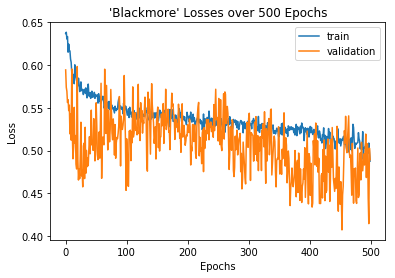

Average Training Score: 0.535739279343864
Average Validation Score: 0.5071605987516118


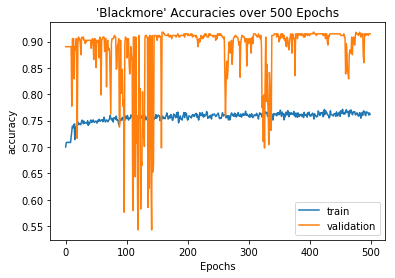

Average Training Score: 0.7569710843373494
Average Validation Score: 0.8856951219512196

validating on book: 'Ascham'
Epoch 0/499
----------



Phase:train
Confusion matrix:
 [[ 172  569]
 [  70 1911]]
loss 1411.4134774208069



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 22.24150088429451
Epoch 1/499
----------



Phase:train
Confusion matrix:
 [[ 155  586]
 [  40 1941]]
loss 1391.9877689778805



Phase:val
Confusion matrix:
 [[20  0]
 [ 4 72]]
loss 20.58883872628212
Epoch 2/499
----------



Phase:train
Confusion matrix:
 [[ 178  563]
 [  47 1934]]
loss 1368.5925499796867



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 21.65992119908333
Epoch 3/499
----------



Phase:train
Confusion matrix:
 [[ 173  568]
 [  50 1931]]
loss 1402.9564850330353



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 18.104447722434998
Epoch 4/499
----------



Phase:train
Confusion matrix:
 [[ 168  573]
 [  46 1935]]
loss 1354.1746353805065



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 16.661011397838593
Epoch 5/499
----------



Phase:train
Confusion matrix:
 [[ 182  559]
 [  57 1924]]
loss 1352.3570958673954



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 19.164965361356735
Epoch 6/499
----------



Phase:train
Confusion matrix:
 [[ 171  570]
 [  52 1929]]
loss 1389.797334253788



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 23.17710119485855
Epoch 7/499
----------



Phase:train
Confusion matrix:
 [[ 175  566]
 [  39 1942]]
loss 1367.0465640425682



Phase:val
Confusion matrix:
 [[20  0]
 [ 4 72]]
loss 17.500331550836563
Epoch 8/499
----------



Phase:train
Confusion matrix:
 [[ 167  574]
 [  49 1932]]
loss 1380.5392328500748



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 27.396511673927307
Epoch 9/499
----------



Phase:train
Confusion matrix:
 [[ 168  573]
 [  40 1941]]
loss 1370.9070286750793



Phase:val
Confusion matrix:
 [[20  0]
 [ 4 72]]
loss 18.412787437438965
Epoch 10/499
----------



Phase:train
Confusion matrix:
 [[ 173  568]
 [  45 1936]]
loss 1351.5048319548368



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 17.071355551481247
Epoch 11/499
----------



Phase:train
Confusion matrix:
 [[ 179  562]
 [  60 1921]]
loss 1390.2754821181297



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 29.110976576805115
Epoch 12/499
----------



Phase:train
Confusion matrix:
 [[ 160  581]
 [  52 1929]]
loss 1378.4357567429543



Phase:val
Confusion matrix:
 [[20  0]
 [ 4 72]]
loss 18.03299644589424
Epoch 13/499
----------



Phase:train
Confusion matrix:
 [[ 167  574]
 [  42 1939]]
loss 1372.2087013721466



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 20.493606746196747
Epoch 14/499
----------



Phase:train
Confusion matrix:
 [[ 170  571]
 [  53 1928]]
loss 1364.4703482687473



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 21.61884307861328
Epoch 15/499
----------



Phase:train
Confusion matrix:
 [[ 165  576]
 [  46 1935]]
loss 1374.462797895074



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 17.052158296108246
Epoch 16/499
----------



Phase:train
Confusion matrix:
 [[ 181  560]
 [  52 1929]]
loss 1357.017525345087



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 18.02908843755722
Epoch 17/499
----------



Phase:train
Confusion matrix:
 [[ 184  557]
 [  70 1911]]
loss 1368.100169673562



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 22.677117079496384
Epoch 18/499
----------



Phase:train
Confusion matrix:
 [[ 167  574]
 [  45 1936]]
loss 1384.8508897423744



Phase:val
Confusion matrix:
 [[20  0]
 [ 4 72]]
loss 26.781081318855286
Epoch 19/499
----------



Phase:train
Confusion matrix:
 [[ 164  577]
 [  48 1933]]
loss 1360.3608211576939



Phase:val
Confusion matrix:
 [[20  0]
 [ 8 68]]
loss 30.252859950065613
Epoch 20/499
----------



Phase:train
Confusion matrix:
 [[ 182  559]
 [  52 1929]]
loss 1360.9343522787094



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 20.30474144220352
Epoch 21/499
----------



Phase:train
Confusion matrix:
 [[ 169  572]
 [  51 1930]]
loss 1390.5914633870125



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 21.72881728410721
Epoch 22/499
----------



Phase:train
Confusion matrix:
 [[ 167  574]
 [  45 1936]]
loss 1352.4167693257332



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 24.83281260728836
Epoch 23/499
----------



Phase:train
Confusion matrix:
 [[ 159  582]
 [  40 1941]]
loss 1378.9810493588448



Phase:val
Confusion matrix:
 [[20  0]
 [ 4 72]]
loss 24.272887498140335
Epoch 24/499
----------



Phase:train
Confusion matrix:
 [[ 163  578]
 [  32 1949]]
loss 1345.6720294207335



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 29.244877636432648
Epoch 25/499
----------



Phase:train
Confusion matrix:
 [[ 165  576]
 [  51 1930]]
loss 1377.236832588911



Phase:val
Confusion matrix:
 [[20  0]
 [ 4 72]]
loss 24.891825914382935
Epoch 26/499
----------



Phase:train
Confusion matrix:
 [[ 159  582]
 [  37 1944]]
loss 1375.3192598968744



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 23.977179020643234
Epoch 27/499
----------



Phase:train
Confusion matrix:
 [[ 166  575]
 [  41 1940]]
loss 1365.1401892602444



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 23.816588789224625
Epoch 28/499
----------



Phase:train
Confusion matrix:
 [[ 171  570]
 [  49 1932]]
loss 1358.3480034470558



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 22.029110223054886
Epoch 29/499
----------



Phase:train
Confusion matrix:
 [[ 177  564]
 [  64 1917]]
loss 1384.1332916766405



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 31.399954736232758
Epoch 30/499
----------



Phase:train
Confusion matrix:
 [[ 147  594]
 [  38 1943]]
loss 1427.6565768420696



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 27.89267921447754
Epoch 31/499
----------



Phase:train
Confusion matrix:
 [[ 164  577]
 [  37 1944]]
loss 1366.5482508540154



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 21.537798076868057
Epoch 32/499
----------



Phase:train
Confusion matrix:
 [[ 160  581]
 [  38 1943]]
loss 1351.1134973466396



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 24.22821807861328
Epoch 33/499
----------



Phase:train
Confusion matrix:
 [[ 166  575]
 [  41 1940]]
loss 1367.0378066897392



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 21.676075607538223
Epoch 34/499
----------



Phase:train
Confusion matrix:
 [[ 184  557]
 [  53 1928]]
loss 1344.3104510605335



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 21.690210551023483
Epoch 35/499
----------



Phase:train
Confusion matrix:
 [[ 177  564]
 [  54 1927]]
loss 1371.3331451117992



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 25.78275716304779
Epoch 36/499
----------



Phase:train
Confusion matrix:
 [[ 163  578]
 [  41 1940]]
loss 1366.3593473136425



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 24.50852534174919
Epoch 37/499
----------



Phase:train
Confusion matrix:
 [[ 175  566]
 [  66 1915]]
loss 1368.3765505850315



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 22.79388138651848
Epoch 38/499
----------



Phase:train
Confusion matrix:
 [[ 174  567]
 [  55 1926]]
loss 1374.5731385052204



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 22.75447180867195
Epoch 39/499
----------



Phase:train
Confusion matrix:
 [[ 164  577]
 [  52 1929]]
loss 1369.9091246724129



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 26.542592465877533
Epoch 40/499
----------



Phase:train
Confusion matrix:
 [[ 158  583]
 [  34 1947]]
loss 1340.7791907936335



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 20.908028304576874
Epoch 41/499
----------



Phase:train
Confusion matrix:
 [[ 173  568]
 [  57 1924]]
loss 1347.446378827095



Phase:val
Confusion matrix:
 [[20  0]
 [ 4 72]]
loss 16.959702759981155
Epoch 42/499
----------



Phase:train
Confusion matrix:
 [[ 162  579]
 [  49 1932]]
loss 1376.1070171296597



Phase:val
Confusion matrix:
 [[20  0]
 [ 4 72]]
loss 22.86262172460556
Epoch 43/499
----------



Phase:train
Confusion matrix:
 [[ 180  561]
 [  46 1935]]
loss 1345.5852777659893



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 22.63252553343773
Epoch 44/499
----------



Phase:train
Confusion matrix:
 [[ 174  567]
 [  51 1930]]
loss 1351.3885943591595



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 24.665245711803436
Epoch 45/499
----------



Phase:train
Confusion matrix:
 [[ 166  575]
 [  49 1932]]
loss 1362.3135090768337



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 22.591440826654434
Epoch 46/499
----------



Phase:train
Confusion matrix:
 [[ 167  574]
 [  48 1933]]
loss 1364.455922305584



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 22.925921022892
Epoch 47/499
----------



Phase:train
Confusion matrix:
 [[ 174  567]
 [  46 1935]]
loss 1338.9576293826103



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 21.815713584423065
Epoch 48/499
----------



Phase:train
Confusion matrix:
 [[ 184  557]
 [  54 1927]]
loss 1356.9654905200005



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.117579638957977
Epoch 49/499
----------



Phase:train
Confusion matrix:
 [[ 177  564]
 [  65 1916]]
loss 1357.3550057262182



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 23.25969997048378
Epoch 50/499
----------



Phase:train
Confusion matrix:
 [[ 177  564]
 [  45 1936]]
loss 1347.0042757093906



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 18.436182498931885
Epoch 51/499
----------



Phase:train
Confusion matrix:
 [[ 176  565]
 [  54 1927]]
loss 1325.859779059887



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 19.917321026325226
Epoch 52/499
----------



Phase:train
Confusion matrix:
 [[ 174  567]
 [  50 1931]]
loss 1380.1616038382053



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 22.378610253334045
Epoch 53/499
----------



Phase:train
Confusion matrix:
 [[ 184  557]
 [  58 1923]]
loss 1342.8565300107002



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 23.899196475744247
Epoch 54/499
----------



Phase:train
Confusion matrix:
 [[ 169  572]
 [  49 1932]]
loss 1356.917935848236



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 28.16907173395157
Epoch 55/499
----------



Phase:train
Confusion matrix:
 [[ 168  573]
 [  52 1929]]
loss 1369.3301033973694



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 24.86898696422577
Epoch 56/499
----------



Phase:train
Confusion matrix:
 [[ 165  576]
 [  39 1942]]
loss 1356.2663222551346



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 18.942875266075134
Epoch 57/499
----------



Phase:train
Confusion matrix:
 [[ 152  589]
 [  43 1938]]
loss 1354.9638447463512



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 23.807713001966476
Epoch 58/499
----------



Phase:train
Confusion matrix:
 [[ 181  560]
 [  60 1921]]
loss 1364.4129175543785



Phase:val
Confusion matrix:
 [[20  0]
 [ 8 68]]
loss 32.72839105129242
Epoch 59/499
----------



Phase:train
Confusion matrix:
 [[ 175  566]
 [  56 1925]]
loss 1350.2644129097462



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 25.799087822437286
Epoch 68/499
----------



Phase:train
Confusion matrix:
 [[ 166  575]
 [  54 1927]]
loss 1364.8943109810352



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 25.135957717895508
Epoch 69/499
----------



Phase:train
Confusion matrix:
 [[ 168  573]
 [  50 1931]]
loss 1364.3899556100368



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 28.736600935459137
Epoch 70/499
----------



Phase:train
Confusion matrix:
 [[ 178  563]
 [  58 1923]]
loss 1374.8255979418755



Phase:val
Confusion matrix:
 [[20  0]
 [ 9 67]]
loss 30.952694416046143
Epoch 71/499
----------



Phase:train
Confusion matrix:
 [[ 178  563]
 [  52 1929]]
loss 1369.2415889203548



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 27.25467413663864
Epoch 72/499
----------



Phase:train
Confusion matrix:
 [[ 168  573]
 [  50 1931]]
loss 1351.4934919774532



Phase:val
Confusion matrix:
 [[20  0]
 [10 66]]
loss 32.71617865562439
Epoch 73/499
----------



Phase:train
Confusion matrix:
 [[ 172  569]
 [  57 1924]]
loss 1377.2953810989857



Phase:val
Confusion matrix:
 [[20  0]
 [ 4 72]]
loss 27.429960429668427
Epoch 74/499
----------



Phase:train
Confusion matrix:
 [[ 162  579]
 [  52 1929]]
loss 1338.4064525812864



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 23.582014054059982
Epoch 75/499
----------



Phase:train
Confusion matrix:
 [[ 180  561]
 [  46 1935]]
loss 1339.7501108646393



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 25.990501761436462
Epoch 76/499
----------



Phase:train
Confusion matrix:
 [[ 182  559]
 [  50 1931]]
loss 1354.2931357324123



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 33.01273262500763
Epoch 77/499
----------



Phase:train
Confusion matrix:
 [[ 169  572]
 [  57 1924]]
loss 1354.330687791109



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 27.95593112707138
Epoch 78/499
----------



Phase:train
Confusion matrix:
 [[ 182  559]
 [  55 1926]]
loss 1326.8019139766693



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 23.342579782009125
Epoch 79/499
----------



Phase:train
Confusion matrix:
 [[ 186  555]
 [  66 1915]]
loss 1351.3231652081013



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 28.154527723789215
Epoch 80/499
----------



Phase:train
Confusion matrix:
 [[ 179  562]
 [  45 1936]]
loss 1337.999245107174



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 23.01088184118271
Epoch 81/499
----------



Phase:train
Confusion matrix:
 [[ 171  570]
 [  52 1929]]
loss 1355.9601837992668



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 26.84701183438301
Epoch 82/499
----------



Phase:train
Confusion matrix:
 [[ 181  560]
 [  43 1938]]
loss 1342.4892939329147



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 23.934167981147766
Epoch 83/499
----------



Phase:train
Confusion matrix:
 [[ 185  556]
 [  56 1925]]
loss 1328.6160069704056



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 22.413247257471085
Epoch 84/499
----------



Phase:train
Confusion matrix:
 [[ 192  549]
 [  61 1920]]
loss 1339.1263887882233



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 23.742369562387466
Epoch 85/499
----------



Phase:train
Confusion matrix:
 [[ 167  574]
 [  54 1927]]
loss 1356.7367601692677



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 28.441219925880432
Epoch 86/499
----------



Phase:train
Confusion matrix:
 [[ 188  553]
 [  65 1916]]
loss 1339.935374468565



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 27.15375828742981
Epoch 87/499
----------



Phase:train
Confusion matrix:
 [[ 185  556]
 [  81 1900]]
loss 1365.7292965054512



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 19.900446116924286
Epoch 88/499
----------



Phase:train
Confusion matrix:
 [[ 169  572]
 [  39 1942]]
loss 1316.7235452532768



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 22.41447350382805
Epoch 89/499
----------



Phase:train
Confusion matrix:
 [[ 184  557]
 [  62 1919]]
loss 1375.6613725423813



Phase:val
Confusion matrix:
 [[20  0]
 [ 4 72]]
loss 26.00826793909073
Epoch 90/499
----------



Phase:train
Confusion matrix:
 [[ 181  560]
 [  52 1929]]
loss 1344.8252024650574



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 27.266020834445953
Epoch 91/499
----------



Phase:train
Confusion matrix:
 [[ 179  562]
 [  66 1915]]
loss 1341.7310846149921



Phase:val
Confusion matrix:
 [[20  0]
 [ 4 72]]
loss 24.928066849708557
Epoch 92/499
----------



Phase:train
Confusion matrix:
 [[ 165  576]
 [  52 1929]]
loss 1333.4132310897112



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.11132100224495
Epoch 93/499
----------



Phase:train
Confusion matrix:
 [[ 169  572]
 [  61 1920]]
loss 1338.194946706295



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 27.68977177143097
Epoch 94/499
----------



Phase:train
Confusion matrix:
 [[ 173  568]
 [  49 1932]]
loss 1341.636768490076



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 26.48206326365471
Epoch 95/499
----------



Phase:train
Confusion matrix:
 [[ 190  551]
 [  70 1911]]
loss 1361.9305637478828



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 31.29712951183319
Epoch 96/499
----------



Phase:train
Confusion matrix:
 [[ 182  559]
 [  51 1930]]
loss 1351.9791136682034



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 28.76706236600876
Epoch 97/499
----------



Phase:train
Confusion matrix:
 [[ 170  571]
 [  48 1933]]
loss 1325.003566145897



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 28.858567655086517
Epoch 98/499
----------



Phase:train
Confusion matrix:
 [[ 182  559]
 [  53 1928]]
loss 1333.4226406812668



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 28.522817373275757
Epoch 99/499
----------



Phase:train
Confusion matrix:
 [[ 181  560]
 [  48 1933]]
loss 1312.658547282219



Phase:val
Confusion matrix:
 [[20  0]
 [ 8 68]]
loss 25.760333836078644
Epoch 100/499
----------



Phase:train
Confusion matrix:
 [[ 189  552]
 [  72 1909]]
loss 1355.0203298032284



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 23.401131063699722
Epoch 101/499
----------



Phase:train
Confusion matrix:
 [[ 176  565]
 [  61 1920]]
loss 1324.8320275843143



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 25.61720046401024
Epoch 102/499
----------



Phase:train
Confusion matrix:
 [[ 191  550]
 [  50 1931]]
loss 1342.049220830202



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.785056471824646
Epoch 103/499
----------



Phase:train
Confusion matrix:
 [[ 177  564]
 [  59 1922]]
loss 1333.807398468256



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 27.072089552879333
Epoch 104/499
----------



Phase:train
Confusion matrix:
 [[ 182  559]
 [  56 1925]]
loss 1320.7548449635506



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.226814568042755
Epoch 105/499
----------



Phase:train
Confusion matrix:
 [[ 175  566]
 [  55 1926]]
loss 1342.318845719099



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.520188480615616
Epoch 106/499
----------



Phase:train
Confusion matrix:
 [[ 179  562]
 [  53 1928]]
loss 1330.8883612304926



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 22.069399505853653
Epoch 107/499
----------



Phase:train
Confusion matrix:
 [[ 186  555]
 [  69 1912]]
loss 1355.1244965791702



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.195583760738373
Epoch 108/499
----------



Phase:train
Confusion matrix:
 [[ 183  558]
 [  61 1920]]
loss 1340.2776114940643



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 26.979587972164154
Epoch 109/499
----------



Phase:train
Confusion matrix:
 [[ 177  564]
 [  55 1926]]
loss 1354.5701298564672



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 26.031841814517975
Epoch 110/499
----------



Phase:train
Confusion matrix:
 [[ 178  563]
 [  53 1928]]
loss 1329.4266494214535



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 21.761870205402374
Epoch 111/499
----------



Phase:train
Confusion matrix:
 [[ 184  557]
 [  64 1917]]
loss 1354.9442947208881



Phase:val
Confusion matrix:
 [[20  0]
 [ 4 72]]
loss 27.064847946166992
Epoch 112/499
----------



Phase:train
Confusion matrix:
 [[ 157  584]
 [  43 1938]]
loss 1332.393041729927



Phase:val
Confusion matrix:
 [[20  0]
 [ 3 73]]
loss 23.62426021695137
Epoch 113/499
----------



Phase:train
Confusion matrix:
 [[ 175  566]
 [  41 1940]]
loss 1304.6321260631084



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 26.683907002210617
Epoch 114/499
----------



Phase:train
Confusion matrix:
 [[ 170  571]
 [  52 1929]]
loss 1379.799861252308



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 32.79984027147293
Epoch 115/499
----------



Phase:train
Confusion matrix:
 [[ 169  572]
 [  47 1934]]
loss 1343.261971771717



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 22.97093304991722
Epoch 116/499
----------



Phase:train
Confusion matrix:
 [[ 194  547]
 [  56 1925]]
loss 1335.4732526540756



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 23.44031661748886
Epoch 117/499
----------



Phase:train
Confusion matrix:
 [[ 175  566]
 [  55 1926]]
loss 1324.620354294777



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.871186643838882
Epoch 118/499
----------



Phase:train
Confusion matrix:
 [[ 179  562]
 [  50 1931]]
loss 1335.2223272919655



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 22.731725990772247
Epoch 119/499
----------



Phase:train
Confusion matrix:
 [[ 171  570]
 [  54 1927]]
loss 1321.269119411707



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 25.068179428577423
Epoch 120/499
----------



Phase:train
Confusion matrix:
 [[ 186  555]
 [  64 1917]]
loss 1315.5324812233448



Phase:val
Confusion matrix:
 [[20  0]
 [ 8 68]]
loss 26.016014397144318
Epoch 121/499
----------



Phase:train
Confusion matrix:
 [[ 171  570]
 [  64 1917]]
loss 1334.5065949708223



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 25.549868762493134
Epoch 122/499
----------



Phase:train
Confusion matrix:
 [[ 187  554]
 [  58 1923]]
loss 1333.7559100985527



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 26.41539216041565
Epoch 123/499
----------



Phase:train
Confusion matrix:
 [[ 172  569]
 [  56 1925]]
loss 1329.8631384372711



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.054125010967255
Epoch 124/499
----------



Phase:train
Confusion matrix:
 [[ 179  562]
 [  50 1931]]
loss 1332.2275187373161



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 27.915179133415222
Epoch 125/499
----------



Phase:train
Confusion matrix:
 [[ 203  538]
 [  72 1909]]
loss 1322.8654319941998



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 23.435773581266403
Epoch 126/499
----------



Phase:train
Confusion matrix:
 [[ 189  552]
 [  56 1925]]
loss 1322.8645033985376



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.987728893756866
Epoch 127/499
----------



Phase:train
Confusion matrix:
 [[ 183  558]
 [  52 1929]]
loss 1355.5625792443752



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 32.10301160812378
Epoch 128/499
----------



Phase:train
Confusion matrix:
 [[ 202  539]
 [  64 1917]]
loss 1311.5150637924671



Phase:val
Confusion matrix:
 [[20  0]
 [13 63]]
loss 34.574419140815735
Epoch 129/499
----------



Phase:train
Confusion matrix:
 [[ 197  544]
 [  74 1907]]
loss 1296.2546437382698



Phase:val
Confusion matrix:
 [[20  0]
 [12 64]]
loss 37.042284071445465
Epoch 130/499
----------



Phase:train
Confusion matrix:
 [[ 190  551]
 [  77 1904]]
loss 1366.3736617863178



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.581628501415253
Epoch 131/499
----------



Phase:train
Confusion matrix:
 [[ 189  552]
 [  60 1921]]
loss 1329.2726325392723



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.947005838155746
Epoch 132/499
----------



Phase:train
Confusion matrix:
 [[ 193  548]
 [  58 1923]]
loss 1326.1003898382187



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.269104331731796
Epoch 133/499
----------



Phase:train
Confusion matrix:
 [[ 188  553]
 [  52 1929]]
loss 1334.425225391984



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.472003370523453
Epoch 134/499
----------



Phase:train
Confusion matrix:
 [[ 190  551]
 [  66 1915]]
loss 1345.7960459887981



Phase:val
Confusion matrix:
 [[20  0]
 [ 9 67]]
loss 30.490690290927887
Epoch 135/499
----------



Phase:train
Confusion matrix:
 [[ 178  563]
 [  78 1903]]
loss 1355.4101713597775



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 32.00986170768738
Epoch 136/499
----------



Phase:train
Confusion matrix:
 [[ 174  567]
 [  61 1920]]
loss 1346.3604011535645



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 29.650589048862457
Epoch 137/499
----------



Phase:train
Confusion matrix:
 [[ 193  548]
 [  70 1911]]
loss 1327.7774845063686



Phase:val
Confusion matrix:
 [[20  0]
 [ 9 67]]
loss 31.463785707950592
Epoch 138/499
----------



Phase:train
Confusion matrix:
 [[ 204  537]
 [  69 1912]]
loss 1317.765736758709



Phase:val
Confusion matrix:
 [[20  0]
 [ 9 67]]
loss 30.48310077190399
Epoch 139/499
----------



Phase:train
Confusion matrix:
 [[ 175  566]
 [  59 1922]]
loss 1346.2333250939846



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 27.356156289577484
Epoch 140/499
----------



Phase:train
Confusion matrix:
 [[ 166  575]
 [  52 1929]]
loss 1334.879279524088



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 24.973586976528168
Epoch 141/499
----------



Phase:train
Confusion matrix:
 [[ 170  571]
 [  59 1922]]
loss 1340.8441441357136



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 25.67358911037445
Epoch 142/499
----------



Phase:train
Confusion matrix:
 [[ 178  563]
 [  54 1927]]
loss 1345.188876092434



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 23.67847314476967
Epoch 143/499
----------



Phase:train
Confusion matrix:
 [[ 186  555]
 [  67 1914]]
loss 1327.1905913352966



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 30.904906928539276
Epoch 144/499
----------



Phase:train
Confusion matrix:
 [[ 186  555]
 [  64 1917]]
loss 1310.8158652931452



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 30.91858983039856
Epoch 145/499
----------



Phase:train
Confusion matrix:
 [[ 198  543]
 [  67 1914]]
loss 1327.0857469141483



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 24.320137202739716
Epoch 146/499
----------



Phase:train
Confusion matrix:
 [[ 200  541]
 [  85 1896]]
loss 1314.7539009153843



Phase:val
Confusion matrix:
 [[20  0]
 [ 9 67]]
loss 27.600458920001984
Epoch 147/499
----------



Phase:train
Confusion matrix:
 [[ 165  576]
 [  69 1912]]
loss 1331.1663523614407



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 26.25506991147995
Epoch 148/499
----------



Phase:train
Confusion matrix:
 [[ 175  566]
 [  48 1933]]
loss 1315.3957654833794



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 20.618209540843964
Epoch 149/499
----------



Phase:train
Confusion matrix:
 [[ 202  539]
 [  71 1910]]
loss 1330.3607188761234



Phase:val
Confusion matrix:
 [[20  0]
 [ 8 68]]
loss 25.11630529165268
Epoch 150/499
----------



Phase:train
Confusion matrix:
 [[ 177  564]
 [  50 1931]]
loss 1340.0073156803846



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 24.221831887960434
Epoch 151/499
----------



Phase:train
Confusion matrix:
 [[ 198  543]
 [  67 1914]]
loss 1329.1050919294357



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.963824957609177
Epoch 152/499
----------



Phase:train
Confusion matrix:
 [[ 186  555]
 [  68 1913]]
loss 1306.6566161215305



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 28.639738261699677
Epoch 153/499
----------



Phase:train
Confusion matrix:
 [[ 168  573]
 [  58 1923]]
loss 1352.295529216528



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 25.02533781528473
Epoch 154/499
----------



Phase:train
Confusion matrix:
 [[ 175  566]
 [  54 1927]]
loss 1331.87983122468



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 25.29031813144684
Epoch 155/499
----------



Phase:train
Confusion matrix:
 [[ 178  563]
 [  57 1924]]
loss 1345.6624432206154



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.898872047662735
Epoch 156/499
----------



Phase:train
Confusion matrix:
 [[ 183  558]
 [  54 1927]]
loss 1337.544647693634



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 25.38412356376648
Epoch 157/499
----------



Phase:train
Confusion matrix:
 [[ 176  565]
 [  60 1921]]
loss 1317.4273156523705



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 23.132644474506378
Epoch 158/499
----------



Phase:train
Confusion matrix:
 [[ 175  566]
 [  75 1906]]
loss 1375.1398108303547



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 29.822862923145294
Epoch 159/499
----------



Phase:train
Confusion matrix:
 [[ 194  547]
 [  78 1903]]
loss 1345.7792280614376



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.49724730849266
Epoch 160/499
----------



Phase:train
Confusion matrix:
 [[ 189  552]
 [  63 1918]]
loss 1313.2651142776012



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.711073398590088
Epoch 161/499
----------



Phase:train
Confusion matrix:
 [[ 173  568]
 [  61 1920]]
loss 1348.8114523291588



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 26.056913197040558
Epoch 162/499
----------



Phase:train
Confusion matrix:
 [[ 191  550]
 [  57 1924]]
loss 1305.3503414094448



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 27.26927101612091
Epoch 163/499
----------



Phase:train
Confusion matrix:
 [[ 190  551]
 [  63 1918]]
loss 1315.0976547598839



Phase:val
Confusion matrix:
 [[20  0]
 [ 8 68]]
loss 26.22017937898636
Epoch 164/499
----------



Phase:train
Confusion matrix:
 [[ 185  556]
 [  73 1908]]
loss 1362.2901914417744



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 28.1198371052742
Epoch 165/499
----------



Phase:train
Confusion matrix:
 [[ 170  571]
 [  53 1928]]
loss 1334.6395300030708



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 25.06104102730751
Epoch 166/499
----------



Phase:train
Confusion matrix:
 [[ 196  545]
 [  66 1915]]
loss 1293.782058030367



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 24.59896692633629
Epoch 167/499
----------



Phase:train
Confusion matrix:
 [[ 188  553]
 [  78 1903]]
loss 1341.8433134257793



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 26.923523604869843
Epoch 168/499
----------



Phase:train
Confusion matrix:
 [[ 187  554]
 [  76 1905]]
loss 1328.4845924973488



Phase:val
Confusion matrix:
 [[20  0]
 [11 65]]
loss 31.86768227815628
Epoch 169/499
----------



Phase:train
Confusion matrix:
 [[ 190  551]
 [  71 1910]]
loss 1324.1392249166965



Phase:val
Confusion matrix:
 [[20  0]
 [ 8 68]]
loss 26.244910091161728
Epoch 170/499
----------



Phase:train
Confusion matrix:
 [[ 190  551]
 [  57 1924]]
loss 1323.9922786056995



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.578674763441086
Epoch 171/499
----------



Phase:train
Confusion matrix:
 [[ 182  559]
 [  51 1930]]
loss 1325.1081739664078



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 26.39560103416443
Epoch 172/499
----------



Phase:train
Confusion matrix:
 [[ 187  554]
 [  60 1921]]
loss 1315.144613057375



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.226384609937668
Epoch 173/499
----------



Phase:train
Confusion matrix:
 [[ 176  565]
 [  58 1923]]
loss 1318.7781301736832



Phase:val
Confusion matrix:
 [[20  0]
 [ 9 67]]
loss 28.12924200296402
Epoch 174/499
----------



Phase:train
Confusion matrix:
 [[ 182  559]
 [  66 1915]]
loss 1313.4452416300774



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.575488209724426
Epoch 175/499
----------



Phase:train
Confusion matrix:
 [[ 175  566]
 [  62 1919]]
loss 1333.3013616651297



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 25.075695514678955
Epoch 176/499
----------



Phase:train
Confusion matrix:
 [[ 179  562]
 [  77 1904]]
loss 1352.2657110393047



Phase:val
Confusion matrix:
 [[20  0]
 [ 4 72]]
loss 30.94169557094574
Epoch 177/499
----------



Phase:train
Confusion matrix:
 [[ 177  564]
 [  52 1929]]
loss 1374.0728476643562



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 26.10243657231331
Epoch 178/499
----------



Phase:train
Confusion matrix:
 [[ 169  572]
 [  53 1928]]
loss 1328.9189624488354



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 24.43585529923439
Epoch 179/499
----------



Phase:train
Confusion matrix:
 [[ 187  554]
 [  61 1920]]
loss 1323.5396664440632



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 25.128145694732666
Epoch 180/499
----------



Phase:train
Confusion matrix:
 [[ 179  562]
 [  73 1908]]
loss 1359.6736022084951



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 29.63945883512497
Epoch 181/499
----------



Phase:train
Confusion matrix:
 [[ 166  575]
 [  56 1925]]
loss 1325.3068188428879



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 25.306313782930374
Epoch 182/499
----------



Phase:train
Confusion matrix:
 [[ 184  557]
 [  47 1934]]
loss 1298.644273519516



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 25.788449347019196
Epoch 183/499
----------



Phase:train
Confusion matrix:
 [[ 182  559]
 [  72 1909]]
loss 1346.4966170787811



Phase:val
Confusion matrix:
 [[20  0]
 [ 4 72]]
loss 25.768258780241013
Epoch 184/499
----------



Phase:train
Confusion matrix:
 [[ 167  574]
 [  41 1940]]
loss 1352.2316405177116



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 31.505045890808105
Epoch 185/499
----------



Phase:train
Confusion matrix:
 [[ 178  563]
 [  54 1927]]
loss 1329.5581609904766



Phase:val
Confusion matrix:
 [[20  0]
 [ 8 68]]
loss 26.533468812704086
Epoch 186/499
----------



Phase:train
Confusion matrix:
 [[ 169  572]
 [  70 1911]]
loss 1354.059939712286



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 33.37300580739975
Epoch 187/499
----------



Phase:train
Confusion matrix:
 [[ 175  566]
 [  51 1930]]
loss 1354.6736119389534



Phase:val
Confusion matrix:
 [[20  0]
 [ 8 68]]
loss 32.49230647087097
Epoch 188/499
----------



Phase:train
Confusion matrix:
 [[ 179  562]
 [  57 1924]]
loss 1337.8342724740505



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 26.40856033563614
Epoch 189/499
----------



Phase:train
Confusion matrix:
 [[ 190  551]
 [  58 1923]]
loss 1313.3371911644936



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 25.927283585071564
Epoch 190/499
----------



Phase:train
Confusion matrix:
 [[ 169  572]
 [  66 1915]]
loss 1318.3677854835987



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 25.85111966729164
Epoch 191/499
----------



Phase:train
Confusion matrix:
 [[ 179  562]
 [  58 1923]]
loss 1340.449228912592



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 24.59025549888611
Epoch 192/499
----------



Phase:train
Confusion matrix:
 [[ 181  560]
 [  62 1919]]
loss 1297.3920235931873



Phase:val
Confusion matrix:
 [[20  0]
 [ 8 68]]
loss 27.04537382721901
Epoch 193/499
----------



Phase:train
Confusion matrix:
 [[ 184  557]
 [  55 1926]]
loss 1322.161269158125



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 23.77198678255081
Epoch 194/499
----------



Phase:train
Confusion matrix:
 [[ 187  554]
 [  63 1918]]
loss 1311.1326412558556



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 27.08447876572609
Epoch 195/499
----------



Phase:train
Confusion matrix:
 [[ 193  548]
 [  76 1905]]
loss 1327.3335982263088



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 26.204597145318985
Epoch 196/499
----------



Phase:train
Confusion matrix:
 [[ 187  554]
 [  57 1924]]
loss 1311.0685094594955



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 23.675311535596848
Epoch 197/499
----------



Phase:train
Confusion matrix:
 [[ 189  552]
 [  66 1915]]
loss 1276.47431217134



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.35272392630577
Epoch 198/499
----------



Phase:train
Confusion matrix:
 [[ 211  530]
 [  81 1900]]
loss 1323.0687852799892



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 26.685336530208588
Epoch 199/499
----------



Phase:train
Confusion matrix:
 [[ 179  562]
 [  70 1911]]
loss 1338.6809720098972



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 23.701066374778748
Epoch 200/499
----------



Phase:train
Confusion matrix:
 [[ 187  554]
 [  65 1916]]
loss 1310.8220332115889



Phase:val
Confusion matrix:
 [[20  0]
 [10 66]]
loss 33.15528702735901
Epoch 201/499
----------



Phase:train
Confusion matrix:
 [[ 198  543]
 [  80 1901]]
loss 1326.5004922449589



Phase:val
Confusion matrix:
 [[20  0]
 [ 9 67]]
loss 30.66827952861786
Epoch 202/499
----------



Phase:train
Confusion matrix:
 [[ 174  567]
 [  67 1914]]
loss 1344.8880014121532



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 26.592224806547165
Epoch 203/499
----------



Phase:train
Confusion matrix:
 [[ 199  542]
 [  73 1908]]
loss 1300.018324866891



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.03158849477768
Epoch 204/499
----------



Phase:train
Confusion matrix:
 [[ 182  559]
 [  59 1922]]
loss 1323.4586066305637



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.98711469769478
Epoch 205/499
----------



Phase:train
Confusion matrix:
 [[ 187  554]
 [  64 1917]]
loss 1291.7242744266987



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 22.702334076166153
Epoch 206/499
----------



Phase:train
Confusion matrix:
 [[ 178  563]
 [  53 1928]]
loss 1323.9170826673508



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 28.030566811561584
Epoch 207/499
----------



Phase:train
Confusion matrix:
 [[ 201  540]
 [  61 1920]]
loss 1302.6693609654903



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.34012261033058
Epoch 208/499
----------



Phase:train
Confusion matrix:
 [[ 175  566]
 [  57 1924]]
loss 1319.1712850630283



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 19.803897112607956
Epoch 209/499
----------



Phase:train
Confusion matrix:
 [[ 184  557]
 [  65 1916]]
loss 1319.3511416465044



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.2550530731678
Epoch 210/499
----------



Phase:train
Confusion matrix:
 [[ 180  561]
 [  53 1928]]
loss 1315.8968101739883



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.33499100804329
Epoch 211/499
----------



Phase:train
Confusion matrix:
 [[ 185  556]
 [  49 1932]]
loss 1302.7109102904797



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 29.087726712226868
Epoch 212/499
----------



Phase:train
Confusion matrix:
 [[ 212  529]
 [  67 1914]]
loss 1314.1687212586403



Phase:val
Confusion matrix:
 [[20  0]
 [12 64]]
loss 37.74947279691696
Epoch 213/499
----------



Phase:train
Confusion matrix:
 [[ 192  549]
 [  73 1908]]
loss 1322.202471792698



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 26.255046367645264
Epoch 214/499
----------



Phase:train
Confusion matrix:
 [[ 201  540]
 [  72 1909]]
loss 1321.4295669794083



Phase:val
Confusion matrix:
 [[20  0]
 [ 8 68]]
loss 31.541512846946716
Epoch 215/499
----------



Phase:train
Confusion matrix:
 [[ 185  556]
 [  81 1900]]
loss 1353.19559648633



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 27.53888601064682
Epoch 216/499
----------



Phase:train
Confusion matrix:
 [[ 174  567]
 [  63 1918]]
loss 1351.7262054383755



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 24.11346846818924
Epoch 217/499
----------



Phase:train
Confusion matrix:
 [[ 197  544]
 [  60 1921]]
loss 1283.1613237261772



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.675669878721237
Epoch 218/499
----------



Phase:train
Confusion matrix:
 [[ 201  540]
 [  65 1916]]
loss 1294.0676032602787



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.379680156707764
Epoch 219/499
----------



Phase:train
Confusion matrix:
 [[ 193  548]
 [  58 1923]]
loss 1318.8153269439936



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 27.213771879673004
Epoch 220/499
----------



Phase:train
Confusion matrix:
 [[ 194  547]
 [  58 1923]]
loss 1318.5581098794937



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.959846317768097
Epoch 221/499
----------



Phase:train
Confusion matrix:
 [[ 192  549]
 [  62 1919]]
loss 1301.1908910572529



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.80049180984497
Epoch 222/499
----------



Phase:train
Confusion matrix:
 [[ 189  552]
 [  79 1902]]
loss 1341.6338286995888



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.265869051218033
Epoch 223/499
----------



Phase:train
Confusion matrix:
 [[ 183  558]
 [  65 1916]]
loss 1334.7164763659239



Phase:val
Confusion matrix:
 [[20  0]
 [ 8 68]]
loss 26.87344193458557
Epoch 224/499
----------



Phase:train
Confusion matrix:
 [[ 198  543]
 [  79 1902]]
loss 1299.9049128592014



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 24.61890870332718
Epoch 225/499
----------



Phase:train
Confusion matrix:
 [[ 221  520]
 [  87 1894]]
loss 1276.4826070070267



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 19.633854180574417
Epoch 226/499
----------



Phase:train
Confusion matrix:
 [[ 193  548]
 [  71 1910]]
loss 1279.1221006512642



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.962563544511795
Epoch 227/499
----------



Phase:train
Confusion matrix:
 [[ 199  542]
 [  70 1911]]
loss 1301.4721330106258



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.91162645816803
Epoch 228/499
----------



Phase:train
Confusion matrix:
 [[ 183  558]
 [  56 1925]]
loss 1329.4667678326368



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.921630412340164
Epoch 229/499
----------



Phase:train
Confusion matrix:
 [[ 191  550]
 [  73 1908]]
loss 1331.1373272538185



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.914794385433197
Epoch 230/499
----------



Phase:train
Confusion matrix:
 [[ 203  538]
 [  75 1906]]
loss 1290.7718507051468



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 23.36803862452507
Epoch 231/499
----------



Phase:train
Confusion matrix:
 [[ 178  563]
 [  66 1915]]
loss 1323.315899938345



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 28.89542293548584
Epoch 232/499
----------



Phase:train
Confusion matrix:
 [[ 185  556]
 [  75 1906]]
loss 1321.287144958973



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 27.692570626735687
Epoch 233/499
----------



Phase:train
Confusion matrix:
 [[ 185  556]
 [  67 1914]]
loss 1316.0440513193607



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 23.479999899864197
Epoch 234/499
----------



Phase:train
Confusion matrix:
 [[ 189  552]
 [  74 1907]]
loss 1317.1768496632576



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 20.98833042383194
Epoch 235/499
----------



Phase:train
Confusion matrix:
 [[ 189  552]
 [  70 1911]]
loss 1311.479281872511



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 26.94829949736595
Epoch 236/499
----------



Phase:train
Confusion matrix:
 [[ 207  534]
 [  76 1905]]
loss 1308.8741802871227



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.37553495168686
Epoch 237/499
----------



Phase:train
Confusion matrix:
 [[ 206  535]
 [  77 1904]]
loss 1303.2670271098614



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 27.61610499024391
Epoch 238/499
----------



Phase:train
Confusion matrix:
 [[ 188  553]
 [  69 1912]]
loss 1317.3419710993767



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 24.667292058467865
Epoch 239/499
----------



Phase:train
Confusion matrix:
 [[ 182  559]
 [  55 1926]]
loss 1298.3894655108452



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 21.864953696727753
Epoch 240/499
----------



Phase:train
Confusion matrix:
 [[ 175  566]
 [  65 1916]]
loss 1346.5459670722485



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 22.59820404648781
Epoch 241/499
----------



Phase:train
Confusion matrix:
 [[ 178  563]
 [  45 1936]]
loss 1308.0871097445488



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 23.971793740987778
Epoch 242/499
----------



Phase:train
Confusion matrix:
 [[ 199  542]
 [  76 1905]]
loss 1296.039615407586



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 22.265032529830933
Epoch 243/499
----------



Phase:train
Confusion matrix:
 [[ 185  556]
 [  69 1912]]
loss 1315.564252436161



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.371583998203278
Epoch 244/499
----------



Phase:train
Confusion matrix:
 [[ 195  546]
 [  74 1907]]
loss 1301.555591315031



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.552035480737686
Epoch 245/499
----------



Phase:train
Confusion matrix:
 [[ 208  533]
 [  75 1906]]
loss 1306.0174298882484



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 23.1146841943264
Epoch 246/499
----------



Phase:train
Confusion matrix:
 [[ 186  555]
 [  55 1926]]
loss 1305.365742892027



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 24.936894863843918
Epoch 247/499
----------



Phase:train
Confusion matrix:
 [[ 186  555]
 [  58 1923]]
loss 1305.242964208126



Phase:val
Confusion matrix:
 [[20  0]
 [ 8 68]]
loss 21.29134488105774
Epoch 248/499
----------



Phase:train
Confusion matrix:
 [[ 198  543]
 [  72 1909]]
loss 1313.2909135222435



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 23.00683704018593
Epoch 249/499
----------



Phase:train
Confusion matrix:
 [[ 193  548]
 [  62 1919]]
loss 1304.6963940262794



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.61288347840309
Epoch 250/499
----------



Phase:train
Confusion matrix:
 [[ 179  562]
 [  66 1915]]
loss 1318.7460878193378



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.249648362398148
Epoch 251/499
----------



Phase:train
Confusion matrix:
 [[ 188  553]
 [  85 1896]]
loss 1322.9353805482388



Phase:val
Confusion matrix:
 [[20  0]
 [ 9 67]]
loss 27.742615401744843
Epoch 252/499
----------



Phase:train
Confusion matrix:
 [[ 175  566]
 [  50 1931]]
loss 1313.9699521660805



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 22.224166363477707
Epoch 253/499
----------



Phase:train
Confusion matrix:
 [[ 219  522]
 [  75 1906]]
loss 1265.877752929926



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.42347952723503
Epoch 254/499
----------



Phase:train
Confusion matrix:
 [[ 220  521]
 [  65 1916]]
loss 1294.549275547266



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.2552407681942
Epoch 255/499
----------



Phase:train
Confusion matrix:
 [[ 180  561]
 [  78 1903]]
loss 1367.2627135813236



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.69375017285347
Epoch 256/499
----------



Phase:train
Confusion matrix:
 [[ 196  545]
 [  64 1917]]
loss 1303.0083151757717



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.743754863739014
Epoch 257/499
----------



Phase:train
Confusion matrix:
 [[ 219  522]
 [  94 1887]]
loss 1296.3768201768398



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.615867912769318
Epoch 258/499
----------



Phase:train
Confusion matrix:
 [[ 188  553]
 [  77 1904]]
loss 1312.5575524568558



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.008522629737854
Epoch 259/499
----------



Phase:train
Confusion matrix:
 [[ 216  525]
 [  86 1895]]
loss 1313.833253622055



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.451084405183792
Epoch 260/499
----------



Phase:train
Confusion matrix:
 [[ 192  549]
 [  58 1923]]
loss 1305.9441738128662



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.06106147170067
Epoch 261/499
----------



Phase:train
Confusion matrix:
 [[ 191  550]
 [  69 1912]]
loss 1302.2500616163015



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.041096061468124
Epoch 262/499
----------



Phase:train
Confusion matrix:
 [[ 177  564]
 [  74 1907]]
loss 1313.9639176875353



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.44723606109619
Epoch 263/499
----------



Phase:train
Confusion matrix:
 [[ 193  548]
 [  82 1899]]
loss 1306.2712117135525



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.23130339384079
Epoch 264/499
----------



Phase:train
Confusion matrix:
 [[ 174  567]
 [  58 1923]]
loss 1319.3855141997337



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 18.762364894151688
Epoch 265/499
----------



Phase:train
Confusion matrix:
 [[ 190  551]
 [  61 1920]]
loss 1294.0166287124157



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 24.156530112028122
Epoch 266/499
----------



Phase:train
Confusion matrix:
 [[ 183  558]
 [  71 1910]]
loss 1311.1818404495716



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.088322818279266
Epoch 267/499
----------



Phase:train
Confusion matrix:
 [[ 193  548]
 [  55 1926]]
loss 1300.93565467



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 23.023804128170013
Epoch 268/499
----------



Phase:train
Confusion matrix:
 [[ 181  560]
 [  67 1914]]
loss 1266.8531910181046



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.58339786529541
Epoch 269/499
----------



Phase:train
Confusion matrix:
 [[ 198  543]
 [  68 1913]]
loss 1306.6583218872547



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.65649038553238
Epoch 270/499
----------



Phase:train
Confusion matrix:
 [[ 191  550]
 [  66 1915]]
loss 1314.1335963308811



Phase:val
Confusion matrix:
 [[20  0]
 [ 8 68]]
loss 29.71011382341385
Epoch 271/499
----------



Phase:train
Confusion matrix:
 [[ 198  543]
 [  61 1920]]
loss 1304.342651411891



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.198389291763306
Epoch 272/499
----------



Phase:train
Confusion matrix:
 [[ 203  538]
 [  80 1901]]
loss 1300.7783425152302



Phase:val
Confusion matrix:
 [[20  0]
 [ 9 67]]
loss 30.778595983982086
Epoch 273/499
----------



Phase:train
Confusion matrix:
 [[ 199  542]
 [  80 1901]]
loss 1331.8733807653189



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 26.8024919629097
Epoch 274/499
----------



Phase:train
Confusion matrix:
 [[ 201  540]
 [  67 1914]]
loss 1313.3811488449574



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.8009734749794
Epoch 275/499
----------



Phase:train
Confusion matrix:
 [[ 193  548]
 [  70 1911]]
loss 1302.9022523760796



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.391158312559128
Epoch 276/499
----------



Phase:train
Confusion matrix:
 [[ 196  545]
 [  81 1900]]
loss 1314.308257728815



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 20.402193903923035
Epoch 277/499
----------



Phase:train
Confusion matrix:
 [[ 198  543]
 [  65 1916]]
loss 1290.4287865757942



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 22.111817717552185
Epoch 278/499
----------



Phase:train
Confusion matrix:
 [[ 188  553]
 [  62 1919]]
loss 1326.8969907462597



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 28.32022750377655
Epoch 279/499
----------



Phase:train
Confusion matrix:
 [[ 187  554]
 [  57 1924]]
loss 1323.064893513918



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 23.587254524230957
Epoch 280/499
----------



Phase:train
Confusion matrix:
 [[ 183  558]
 [  48 1933]]
loss 1289.006768554449



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 22.664432287216187
Epoch 281/499
----------



Phase:train
Confusion matrix:
 [[ 190  551]
 [  69 1912]]
loss 1323.728605568409



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 26.308012783527374
Epoch 282/499
----------



Phase:train
Confusion matrix:
 [[ 186  555]
 [  55 1926]]
loss 1315.4027137756348



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 23.93469062447548
Epoch 283/499
----------



Phase:train
Confusion matrix:
 [[ 174  567]
 [  56 1925]]
loss 1312.3121345937252



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.251695930957794
Epoch 284/499
----------



Phase:train
Confusion matrix:
 [[ 196  545]
 [  69 1912]]
loss 1276.2837595939636



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.508709520101547
Epoch 285/499
----------



Phase:train
Confusion matrix:
 [[ 196  545]
 [  77 1904]]
loss 1318.8064982295036



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 19.489127337932587
Epoch 286/499
----------



Phase:train
Confusion matrix:
 [[ 187  554]
 [  66 1915]]
loss 1289.3736895620823



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.807475239038467
Epoch 287/499
----------



Phase:train
Confusion matrix:
 [[ 203  538]
 [  79 1902]]
loss 1292.1511703133583



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 17.74602562189102
Epoch 288/499
----------



Phase:train
Confusion matrix:
 [[ 185  556]
 [  64 1917]]
loss 1333.7609107792377



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.85525980591774
Epoch 289/499
----------



Phase:train
Confusion matrix:
 [[ 193  548]
 [  67 1914]]
loss 1315.5042058378458



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 21.526748597621918
Epoch 290/499
----------



Phase:train
Confusion matrix:
 [[ 192  549]
 [  71 1910]]
loss 1312.39554618299



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 23.5195891559124
Epoch 291/499
----------



Phase:train
Confusion matrix:
 [[ 187  554]
 [  64 1917]]
loss 1320.3386894464493



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 20.361191540956497
Epoch 292/499
----------



Phase:train
Confusion matrix:
 [[ 200  541]
 [  76 1905]]
loss 1291.565306544304



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 18.783703684806824
Epoch 293/499
----------



Phase:train
Confusion matrix:
 [[ 186  555]
 [  51 1930]]
loss 1303.9366865307093



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.773688703775406
Epoch 294/499
----------



Phase:train
Confusion matrix:
 [[ 194  547]
 [  87 1894]]
loss 1288.8141911029816



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.857626140117645
Epoch 295/499
----------



Phase:train
Confusion matrix:
 [[ 198  543]
 [  78 1903]]
loss 1293.9409111440182



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.597416877746582
Epoch 296/499
----------



Phase:train
Confusion matrix:
 [[ 204  537]
 [  91 1890]]
loss 1303.4978683888912



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.283649414777756
Epoch 297/499
----------



Phase:train
Confusion matrix:
 [[ 205  536]
 [  93 1888]]
loss 1309.1025109291077



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.85198947787285
Epoch 298/499
----------



Phase:train
Confusion matrix:
 [[ 194  547]
 [  84 1897]]
loss 1305.7291571497917



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 19.82598975300789
Epoch 299/499
----------



Phase:train
Confusion matrix:
 [[ 175  566]
 [  60 1921]]
loss 1322.4019563794136



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.439223438501358
Epoch 300/499
----------



Phase:train
Confusion matrix:
 [[ 198  543]
 [  64 1917]]
loss 1305.5341303348541



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.601443976163864
Epoch 301/499
----------



Phase:train
Confusion matrix:
 [[ 197  544]
 [  62 1919]]
loss 1306.7383961677551



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 26.050343453884125
Epoch 302/499
----------



Phase:train
Confusion matrix:
 [[ 186  555]
 [  76 1905]]
loss 1293.268620312214



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 23.39190924167633
Epoch 303/499
----------



Phase:train
Confusion matrix:
 [[ 199  542]
 [  84 1897]]
loss 1311.2547088861465



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 27.87469983100891
Epoch 304/499
----------



Phase:train
Confusion matrix:
 [[ 172  569]
 [  54 1927]]
loss 1299.1100251078606



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 27.425518929958344
Epoch 305/499
----------



Phase:train
Confusion matrix:
 [[ 186  555]
 [  73 1908]]
loss 1303.1070282757282



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 27.7139330804348
Epoch 306/499
----------



Phase:train
Confusion matrix:
 [[ 208  533]
 [  71 1910]]
loss 1305.8523138165474



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 27.985787272453308
Epoch 307/499
----------



Phase:train
Confusion matrix:
 [[ 171  570]
 [  43 1938]]
loss 1320.3537540137768



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.144006729125977
Epoch 308/499
----------



Phase:train
Confusion matrix:
 [[ 185  556]
 [  63 1918]]
loss 1310.0919163227081



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 28.820502877235413
Epoch 309/499
----------



Phase:train
Confusion matrix:
 [[ 173  568]
 [  39 1942]]
loss 1317.8594720959663



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 23.810374826192856
Epoch 310/499
----------



Phase:train
Confusion matrix:
 [[ 181  560]
 [  49 1932]]
loss 1299.3587844371796



Phase:val
Confusion matrix:
 [[20  0]
 [ 8 68]]
loss 24.388719499111176
Epoch 311/499
----------



Phase:train
Confusion matrix:
 [[ 207  534]
 [  72 1909]]
loss 1272.952066153288



Phase:val
Confusion matrix:
 [[20  0]
 [12 64]]
loss 29.94790518283844
Epoch 312/499
----------



Phase:train
Confusion matrix:
 [[ 208  533]
 [  84 1897]]
loss 1292.3757544457912



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.528101205825806
Epoch 313/499
----------



Phase:train
Confusion matrix:
 [[ 185  556]
 [  53 1928]]
loss 1312.6118840277195



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 23.070978581905365
Epoch 314/499
----------



Phase:train
Confusion matrix:
 [[ 194  547]
 [  78 1903]]
loss 1334.5769713521004



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.214422166347504
Epoch 315/499
----------



Phase:train
Confusion matrix:
 [[ 181  560]
 [  55 1926]]
loss 1308.2579646855593



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 19.51900726556778
Epoch 316/499
----------



Phase:train
Confusion matrix:
 [[ 181  560]
 [  58 1923]]
loss 1305.759752869606



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.992264062166214
Epoch 317/499
----------



Phase:train
Confusion matrix:
 [[ 188  553]
 [  69 1912]]
loss 1323.6665633320808



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.643808782100677
Epoch 318/499
----------



Phase:train
Confusion matrix:
 [[ 195  546]
 [  51 1930]]
loss 1292.3001542836428



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.21949604153633
Epoch 319/499
----------



Phase:train
Confusion matrix:
 [[ 211  530]
 [  75 1906]]
loss 1317.2650619894266



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.483730405569077
Epoch 320/499
----------



Phase:train
Confusion matrix:
 [[ 173  568]
 [  58 1923]]
loss 1303.7070740759373



Phase:val
Confusion matrix:
 [[20  0]
 [ 8 68]]
loss 26.441898435354233
Epoch 321/499
----------



Phase:train
Confusion matrix:
 [[ 186  555]
 [  60 1921]]
loss 1349.9956887066364



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 28.46206384897232
Epoch 322/499
----------



Phase:train
Confusion matrix:
 [[ 181  560]
 [  50 1931]]
loss 1322.6602102220058



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.236200630664825
Epoch 323/499
----------



Phase:train
Confusion matrix:
 [[ 182  559]
 [  55 1926]]
loss 1283.3874661028385



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 20.993677377700806
Epoch 324/499
----------



Phase:train
Confusion matrix:
 [[ 211  530]
 [  64 1917]]
loss 1283.7338182032108



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.361788988113403
Epoch 325/499
----------



Phase:train
Confusion matrix:
 [[ 179  562]
 [  75 1906]]
loss 1310.2232911288738



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.379784137010574
Epoch 326/499
----------



Phase:train
Confusion matrix:
 [[ 190  551]
 [  62 1919]]
loss 1311.6820532381535



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.940965354442596
Epoch 327/499
----------



Phase:train
Confusion matrix:
 [[ 195  546]
 [  66 1915]]
loss 1291.7767764627934



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.774131059646606
Epoch 328/499
----------



Phase:train
Confusion matrix:
 [[ 208  533]
 [  79 1902]]
loss 1279.9271139800549



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 20.710326224565506
Epoch 329/499
----------



Phase:train
Confusion matrix:
 [[ 185  556]
 [  78 1903]]
loss 1311.8992543816566



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 26.537967532873154
Epoch 330/499
----------



Phase:train
Confusion matrix:
 [[ 194  547]
 [  56 1925]]
loss 1282.0423203408718



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.710813999176025
Epoch 331/499
----------



Phase:train
Confusion matrix:
 [[ 203  538]
 [  84 1897]]
loss 1298.2834794223309



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.944999665021896
Epoch 332/499
----------



Phase:train
Confusion matrix:
 [[ 191  550]
 [  67 1914]]
loss 1292.0299827754498



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.531785488128662
Epoch 333/499
----------



Phase:train
Confusion matrix:
 [[ 185  556]
 [  61 1920]]
loss 1285.2727896124125



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.778243005275726
Epoch 334/499
----------



Phase:train
Confusion matrix:
 [[ 170  571]
 [  69 1912]]
loss 1323.629578590393



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 26.54092502593994
Epoch 335/499
----------



Phase:train
Confusion matrix:
 [[ 178  563]
 [  66 1915]]
loss 1296.6835436969995



Phase:val
Confusion matrix:
 [[20  0]
 [ 8 68]]
loss 26.479163944721222
Epoch 336/499
----------



Phase:train
Confusion matrix:
 [[ 183  558]
 [  66 1915]]
loss 1303.6448783278465



Phase:val
Confusion matrix:
 [[20  0]
 [ 8 68]]
loss 34.146986067295074
Epoch 337/499
----------



Phase:train
Confusion matrix:
 [[ 194  547]
 [  58 1923]]
loss 1302.0476552844048



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.16675639152527
Epoch 338/499
----------



Phase:train
Confusion matrix:
 [[ 210  531]
 [  80 1901]]
loss 1293.7220901995897



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.336227774620056
Epoch 339/499
----------



Phase:train
Confusion matrix:
 [[ 204  537]
 [  57 1924]]
loss 1265.5648496747017



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.47048905491829
Epoch 340/499
----------



Phase:train
Confusion matrix:
 [[ 191  550]
 [  69 1912]]
loss 1281.0929743647575



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.02847933769226
Epoch 341/499
----------



Phase:train
Confusion matrix:
 [[ 208  533]
 [  89 1892]]
loss 1272.5281472057104



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.85912197828293
Epoch 342/499
----------



Phase:train
Confusion matrix:
 [[ 216  525]
 [  76 1905]]
loss 1338.810204654932



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.136347115039825
Epoch 343/499
----------



Phase:train
Confusion matrix:
 [[ 202  539]
 [  63 1918]]
loss 1290.0027813017368



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 19.79823487997055
Epoch 344/499
----------



Phase:train
Confusion matrix:
 [[ 208  533]
 [  87 1894]]
loss 1307.9566846489906



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.749701470136642
Epoch 345/499
----------



Phase:train
Confusion matrix:
 [[ 208  533]
 [  85 1896]]
loss 1325.8902046382427



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 27.58670961856842
Epoch 346/499
----------



Phase:train
Confusion matrix:
 [[ 205  536]
 [  92 1889]]
loss 1304.7558511346579



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.771887689828873
Epoch 347/499
----------



Phase:train
Confusion matrix:
 [[ 219  522]
 [  86 1895]]
loss 1276.753690391779



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.20121994614601
Epoch 348/499
----------



Phase:train
Confusion matrix:
 [[ 211  530]
 [  75 1906]]
loss 1291.5220165252686



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.999799340963364
Epoch 349/499
----------



Phase:train
Confusion matrix:
 [[ 183  558]
 [  73 1908]]
loss 1314.3782825022936



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 26.958363890647888
Epoch 350/499
----------



Phase:train
Confusion matrix:
 [[ 203  538]
 [  93 1888]]
loss 1310.4759856760502



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 26.007979035377502
Epoch 351/499
----------



Phase:train
Confusion matrix:
 [[ 187  554]
 [  63 1918]]
loss 1329.6461094617844



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 30.225630402565002
Epoch 352/499
----------



Phase:train
Confusion matrix:
 [[ 164  577]
 [  66 1915]]
loss 1334.3729444146156



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.945139318704605
Epoch 353/499
----------



Phase:train
Confusion matrix:
 [[ 202  539]
 [  67 1914]]
loss 1289.569341674447



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.13881602883339
Epoch 354/499
----------



Phase:train
Confusion matrix:
 [[ 200  541]
 [  57 1924]]
loss 1347.1534225940704



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.481279522180557
Epoch 355/499
----------



Phase:train
Confusion matrix:
 [[ 184  557]
 [  62 1919]]
loss 1295.8917236924171



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.18285682797432
Epoch 356/499
----------



Phase:train
Confusion matrix:
 [[ 195  546]
 [  72 1909]]
loss 1303.0339268445969



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.83381661772728
Epoch 357/499
----------



Phase:train
Confusion matrix:
 [[ 197  544]
 [  61 1920]]
loss 1286.2527234852314



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.691118210554123
Epoch 358/499
----------



Phase:train
Confusion matrix:
 [[ 187  554]
 [  76 1905]]
loss 1293.3246728777885



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 26.810281217098236
Epoch 359/499
----------



Phase:train
Confusion matrix:
 [[ 210  531]
 [  81 1900]]
loss 1276.1156730651855



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 23.8103084564209
Epoch 360/499
----------



Phase:train
Confusion matrix:
 [[ 197  544]
 [  62 1919]]
loss 1308.3876032233238



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 26.38705363869667
Epoch 361/499
----------



Phase:train
Confusion matrix:
 [[ 183  558]
 [  53 1928]]
loss 1340.6125886142254



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 26.041705518960953
Epoch 362/499
----------



Phase:train
Confusion matrix:
 [[ 220  521]
 [  64 1917]]
loss 1269.1674810647964



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 27.835039138793945
Epoch 363/499
----------



Phase:train
Confusion matrix:
 [[ 201  540]
 [  79 1902]]
loss 1326.7087178826332



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.944871872663498
Epoch 364/499
----------



Phase:train
Confusion matrix:
 [[ 204  537]
 [  79 1902]]
loss 1292.5499350130558



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.860993951559067
Epoch 365/499
----------



Phase:train
Confusion matrix:
 [[ 178  563]
 [  65 1916]]
loss 1318.7303542792797



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 20.638324320316315
Epoch 366/499
----------



Phase:train
Confusion matrix:
 [[ 193  548]
 [  49 1932]]
loss 1282.571274548769



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.16854903101921
Epoch 367/499
----------



Phase:train
Confusion matrix:
 [[ 201  540]
 [  81 1900]]
loss 1280.1608661413193



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.60880184173584
Epoch 368/499
----------



Phase:train
Confusion matrix:
 [[ 194  547]
 [  78 1903]]
loss 1302.5261907279491



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.59280514717102
Epoch 369/499
----------



Phase:train
Confusion matrix:
 [[ 206  535]
 [  72 1909]]
loss 1276.4855445474386



Phase:val
Confusion matrix:
 [[20  0]
 [ 8 68]]
loss 27.678225696086884
Epoch 370/499
----------



Phase:train
Confusion matrix:
 [[ 211  530]
 [  91 1890]]
loss 1283.6882069408894



Phase:val
Confusion matrix:
 [[20  0]
 [ 8 68]]
loss 27.95755046606064
Epoch 371/499
----------



Phase:train
Confusion matrix:
 [[ 216  525]
 [  97 1884]]
loss 1311.0836838185787



Phase:val
Confusion matrix:
 [[20  0]
 [ 8 68]]
loss 29.639259040355682
Epoch 372/499
----------



Phase:train
Confusion matrix:
 [[ 202  539]
 [  63 1918]]
loss 1297.932963475585



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.522203415632248
Epoch 373/499
----------



Phase:train
Confusion matrix:
 [[ 189  552]
 [  76 1905]]
loss 1309.6362642794847



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 17.84604600071907
Epoch 374/499
----------



Phase:train
Confusion matrix:
 [[ 202  539]
 [  65 1916]]
loss 1315.3449222743511



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.495228081941605
Epoch 375/499
----------



Phase:train
Confusion matrix:
 [[ 224  517]
 [  97 1884]]
loss 1261.2006271779537



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.855874180793762
Epoch 376/499
----------



Phase:train
Confusion matrix:
 [[ 227  514]
 [  89 1892]]
loss 1271.442430049181



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 27.99070978164673
Epoch 377/499
----------



Phase:train
Confusion matrix:
 [[ 212  529]
 [ 101 1880]]
loss 1309.9950618296862



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 22.618733644485474
Epoch 378/499
----------



Phase:train
Confusion matrix:
 [[ 182  559]
 [  72 1909]]
loss 1299.7208927124739



Phase:val
Confusion matrix:
 [[20  0]
 [ 8 68]]
loss 23.824807316064835
Epoch 379/499
----------



Phase:train
Confusion matrix:
 [[ 204  537]
 [  96 1885]]
loss 1290.370530962944



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.36057835817337
Epoch 380/499
----------



Phase:train
Confusion matrix:
 [[ 193  548]
 [  71 1910]]
loss 1287.9728884994984



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.8381510078907
Epoch 381/499
----------



Phase:train
Confusion matrix:
 [[ 189  552]
 [  79 1902]]
loss 1295.2162856459618



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 21.752369821071625
Epoch 382/499
----------



Phase:train
Confusion matrix:
 [[ 161  580]
 [  50 1931]]
loss 1306.704802274704



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 19.57815071940422
Epoch 383/499
----------



Phase:train
Confusion matrix:
 [[ 166  575]
 [  50 1931]]
loss 1355.6309675723314



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 27.16096967458725
Epoch 384/499
----------



Phase:train
Confusion matrix:
 [[ 172  569]
 [  55 1926]]
loss 1324.3227016925812



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 24.30611354112625
Epoch 385/499
----------



Phase:train
Confusion matrix:
 [[ 177  564]
 [  69 1912]]
loss 1292.7218534052372



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 21.481555700302124
Epoch 386/499
----------



Phase:train
Confusion matrix:
 [[ 197  544]
 [  65 1916]]
loss 1280.1830965578556



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.628668934106827
Epoch 387/499
----------



Phase:train
Confusion matrix:
 [[ 175  566]
 [  69 1912]]
loss 1289.4938964545727



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 20.73185759782791
Epoch 388/499
----------



Phase:train
Confusion matrix:
 [[ 204  537]
 [  67 1914]]
loss 1273.423688173294



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.76831689476967
Epoch 389/499
----------



Phase:train
Confusion matrix:
 [[ 198  543]
 [  63 1918]]
loss 1311.0441437661648



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.743592619895935
Epoch 390/499
----------



Phase:train
Confusion matrix:
 [[ 193  548]
 [  59 1922]]
loss 1301.8191844820976



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.625824987888336
Epoch 391/499
----------



Phase:train
Confusion matrix:
 [[ 203  538]
 [  69 1912]]
loss 1305.6305203139782



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.956556767225266
Epoch 392/499
----------



Phase:train
Confusion matrix:
 [[ 205  536]
 [  79 1902]]
loss 1301.3012444674969



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.4280923306942
Epoch 393/499
----------



Phase:train
Confusion matrix:
 [[ 181  560]
 [  56 1925]]
loss 1286.1979947984219



Phase:val
Confusion matrix:
 [[20  0]
 [ 8 68]]
loss 23.328741759061813
Epoch 394/499
----------



Phase:train
Confusion matrix:
 [[ 216  525]
 [  83 1898]]
loss 1309.0016889572144



Phase:val
Confusion matrix:
 [[20  0]
 [10 66]]
loss 32.39006918668747
Epoch 395/499
----------



Phase:train
Confusion matrix:
 [[ 189  552]
 [  58 1923]]
loss 1289.9402231872082



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.75650069117546
Epoch 396/499
----------



Phase:train
Confusion matrix:
 [[ 205  536]
 [  67 1914]]
loss 1274.3748029470444



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.509881883859634
Epoch 397/499
----------



Phase:train
Confusion matrix:
 [[ 196  545]
 [  67 1914]]
loss 1284.519183933735



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.297853529453278
Epoch 398/499
----------



Phase:train
Confusion matrix:
 [[ 193  548]
 [  62 1919]]
loss 1304.2411159574986



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 28.604653924703598
Epoch 399/499
----------



Phase:train
Confusion matrix:
 [[ 204  537]
 [  77 1904]]
loss 1287.623487353325



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 20.28343865275383
Epoch 400/499
----------



Phase:train
Confusion matrix:
 [[ 191  550]
 [  73 1908]]
loss 1300.0866605043411



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 19.447279572486877
Epoch 401/499
----------



Phase:train
Confusion matrix:
 [[ 196  545]
 [  83 1898]]
loss 1311.6621812582016



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.25308185815811
Epoch 402/499
----------



Phase:train
Confusion matrix:
 [[ 179  562]
 [  69 1912]]
loss 1298.2625085115433



Phase:val
Confusion matrix:
 [[20  0]
 [ 8 68]]
loss 25.094228446483612
Epoch 403/499
----------



Phase:train
Confusion matrix:
 [[ 198  543]
 [  70 1911]]
loss 1282.953359812498



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 20.905658811330795
Epoch 404/499
----------



Phase:train
Confusion matrix:
 [[ 194  547]
 [  69 1912]]
loss 1297.1248619556427



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.505652278661728
Epoch 405/499
----------



Phase:train
Confusion matrix:
 [[ 189  552]
 [  69 1912]]
loss 1297.5552462488413



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.409600883722305
Epoch 406/499
----------



Phase:train
Confusion matrix:
 [[ 200  541]
 [  75 1906]]
loss 1297.17611810565



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 26.587339997291565
Epoch 407/499
----------



Phase:train
Confusion matrix:
 [[ 208  533]
 [  83 1898]]
loss 1303.8180139362812



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.15233388543129
Epoch 408/499
----------



Phase:train
Confusion matrix:
 [[ 198  543]
 [  81 1900]]
loss 1286.1133783757687



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.855910003185272
Epoch 409/499
----------



Phase:train
Confusion matrix:
 [[ 190  551]
 [  75 1906]]
loss 1292.0690617710352



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.80687689781189
Epoch 410/499
----------



Phase:train
Confusion matrix:
 [[ 201  540]
 [  76 1905]]
loss 1286.537747606635



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 23.457832545042038
Epoch 411/499
----------



Phase:train
Confusion matrix:
 [[ 199  542]
 [  56 1925]]
loss 1295.1125168800354



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 22.782340854406357
Epoch 412/499
----------



Phase:train
Confusion matrix:
 [[ 180  561]
 [  66 1915]]
loss 1262.1757456809282



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 20.11504727602005
Epoch 413/499
----------



Phase:train
Confusion matrix:
 [[ 178  563]
 [  58 1923]]
loss 1315.5756963193417



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 30.70443868637085
Epoch 414/499
----------



Phase:train
Confusion matrix:
 [[ 185  556]
 [  74 1907]]
loss 1276.1961062252522



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.725458949804306
Epoch 415/499
----------



Phase:train
Confusion matrix:
 [[ 189  552]
 [  83 1898]]
loss 1281.9301941990852



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.78720933198929
Epoch 416/499
----------



Phase:train
Confusion matrix:
 [[ 199  542]
 [  87 1894]]
loss 1281.446730569005



Phase:val
Confusion matrix:
 [[20  0]
 [ 9 67]]
loss 34.18957185745239
Epoch 417/499
----------



Phase:train
Confusion matrix:
 [[ 189  552]
 [  68 1913]]
loss 1291.6552386581898



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.614574074745178
Epoch 418/499
----------



Phase:train
Confusion matrix:
 [[ 211  530]
 [  74 1907]]
loss 1280.2592575401068



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 19.004831224679947
Epoch 419/499
----------



Phase:train
Confusion matrix:
 [[ 203  538]
 [  71 1910]]
loss 1298.7822202593088



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 20.397908627986908
Epoch 420/499
----------



Phase:train
Confusion matrix:
 [[ 196  545]
 [  66 1915]]
loss 1283.5359488725662



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 26.89824765920639
Epoch 421/499
----------



Phase:train
Confusion matrix:
 [[ 216  525]
 [  74 1907]]
loss 1309.343841701746



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 20.656312376260757
Epoch 422/499
----------



Phase:train
Confusion matrix:
 [[ 210  531]
 [  73 1908]]
loss 1265.628618657589



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 20.142816215753555
Epoch 423/499
----------



Phase:train
Confusion matrix:
 [[ 210  531]
 [  90 1891]]
loss 1278.54507958889



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.782348334789276
Epoch 424/499
----------



Phase:train
Confusion matrix:
 [[ 201  540]
 [  74 1907]]
loss 1286.2368812263012



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 22.276232987642288
Epoch 425/499
----------



Phase:train
Confusion matrix:
 [[ 219  522]
 [  71 1910]]
loss 1282.3766098320484



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.50947540998459
Epoch 426/499
----------



Phase:train
Confusion matrix:
 [[ 206  535]
 [  88 1893]]
loss 1287.7049936950207



Phase:val
Confusion matrix:
 [[20  0]
 [ 8 68]]
loss 23.202130675315857
Epoch 427/499
----------



Phase:train
Confusion matrix:
 [[ 183  558]
 [  71 1910]]
loss 1272.5182317644358



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 21.788693249225616
Epoch 428/499
----------



Phase:train
Confusion matrix:
 [[ 201  540]
 [  64 1917]]
loss 1272.4003705978394



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 19.472969233989716
Epoch 429/499
----------



Phase:train
Confusion matrix:
 [[ 179  562]
 [  71 1910]]
loss 1316.3766627907753



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 20.541038632392883
Epoch 430/499
----------



Phase:train
Confusion matrix:
 [[ 190  551]
 [  54 1927]]
loss 1304.6270432770252



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.658169984817505
Epoch 431/499
----------



Phase:train
Confusion matrix:
 [[ 177  564]
 [  67 1914]]
loss 1317.7406258881092



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 25.650721430778503
Epoch 432/499
----------



Phase:train
Confusion matrix:
 [[ 180  561]
 [  54 1927]]
loss 1284.0820085257292



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.358888119459152
Epoch 433/499
----------



Phase:train
Confusion matrix:
 [[ 179  562]
 [  61 1920]]
loss 1323.5860706865788



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.59801459312439
Epoch 434/499
----------



Phase:train
Confusion matrix:
 [[ 197  544]
 [  63 1918]]
loss 1284.5025933980942



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.593824595212936
Epoch 435/499
----------



Phase:train
Confusion matrix:
 [[ 194  547]
 [  55 1926]]
loss 1259.0173179209232



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.057238847017288
Epoch 436/499
----------



Phase:train
Confusion matrix:
 [[ 201  540]
 [  80 1901]]
loss 1253.3477185368538



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 20.433626174926758
Epoch 437/499
----------



Phase:train
Confusion matrix:
 [[ 188  553]
 [  61 1920]]
loss 1297.8107499182224



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 28.95680397748947
Epoch 438/499
----------



Phase:train
Confusion matrix:
 [[ 206  535]
 [ 100 1881]]
loss 1307.2846243679523



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.777992725372314
Epoch 439/499
----------



Phase:train
Confusion matrix:
 [[ 195  546]
 [  72 1909]]
loss 1301.2016247212887



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 19.208655059337616
Epoch 440/499
----------



Phase:train
Confusion matrix:
 [[ 205  536]
 [  83 1898]]
loss 1299.3421118110418



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.509518146514893
Epoch 441/499
----------



Phase:train
Confusion matrix:
 [[ 215  526]
 [  82 1899]]
loss 1275.1101646721363



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.166498005390167
Epoch 442/499
----------



Phase:train
Confusion matrix:
 [[ 227  514]
 [ 111 1870]]
loss 1284.5895990133286



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.716615110635757
Epoch 443/499
----------



Phase:train
Confusion matrix:
 [[ 185  556]
 [  61 1920]]
loss 1288.3303339481354



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 19.212599635124207
Epoch 444/499
----------



Phase:train
Confusion matrix:
 [[ 181  560]
 [  73 1908]]
loss 1289.7600928544998



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.09570601582527
Epoch 445/499
----------



Phase:train
Confusion matrix:
 [[ 196  545]
 [  68 1913]]
loss 1282.3226396143436



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 22.263128846883774
Epoch 446/499
----------



Phase:train
Confusion matrix:
 [[ 200  541]
 [  72 1909]]
loss 1268.8324751257896



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 20.94097077846527
Epoch 447/499
----------



Phase:train
Confusion matrix:
 [[ 209  532]
 [  80 1901]]
loss 1265.6163139641285



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.895401418209076
Epoch 448/499
----------



Phase:train
Confusion matrix:
 [[ 213  528]
 [  89 1892]]
loss 1284.5383056253195



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.235027641057968
Epoch 449/499
----------



Phase:train
Confusion matrix:
 [[ 204  537]
 [  78 1903]]
loss 1268.2331859469414



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.79585111141205
Epoch 450/499
----------



Phase:train
Confusion matrix:
 [[ 221  520]
 [  75 1906]]
loss 1256.7110409736633



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.92904433608055
Epoch 451/499
----------



Phase:train
Confusion matrix:
 [[ 223  518]
 [  89 1892]]
loss 1291.3564223349094



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.884263813495636
Epoch 452/499
----------



Phase:train
Confusion matrix:
 [[ 197  544]
 [  71 1910]]
loss 1257.3614506870508



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 17.822867661714554
Epoch 453/499
----------



Phase:train
Confusion matrix:
 [[ 214  527]
 [  76 1905]]
loss 1273.1504186987877



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.22940981388092
Epoch 454/499
----------



Phase:train
Confusion matrix:
 [[ 197  544]
 [  86 1895]]
loss 1288.785248965025



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 24.90739279985428
Epoch 455/499
----------



Phase:train
Confusion matrix:
 [[ 228  513]
 [  87 1894]]
loss 1254.9899402707815



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 20.891890913248062
Epoch 456/499
----------



Phase:train
Confusion matrix:
 [[ 232  509]
 [  79 1902]]
loss 1261.6126603335142



Phase:val
Confusion matrix:
 [[20  0]
 [ 8 68]]
loss 19.83282294869423
Epoch 457/499
----------



Phase:train
Confusion matrix:
 [[ 212  529]
 [  90 1891]]
loss 1315.7411164343357



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.282622277736664
Epoch 458/499
----------



Phase:train
Confusion matrix:
 [[ 218  523]
 [  95 1886]]
loss 1286.8626839965582



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 20.57286673784256
Epoch 459/499
----------



Phase:train
Confusion matrix:
 [[ 190  551]
 [  73 1908]]
loss 1271.309081941843



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 20.050149276852608
Epoch 460/499
----------



Phase:train
Confusion matrix:
 [[ 180  561]
 [  77 1904]]
loss 1274.9672322273254



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 20.34432879090309
Epoch 461/499
----------



Phase:train
Confusion matrix:
 [[ 202  539]
 [  69 1912]]
loss 1283.9914675354958



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.05272290110588
Epoch 462/499
----------



Phase:train
Confusion matrix:
 [[ 222  519]
 [ 100 1881]]
loss 1274.4107289761305



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 19.06167396903038
Epoch 463/499
----------



Phase:train
Confusion matrix:
 [[ 198  543]
 [  66 1915]]
loss 1307.463460713625



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.027916729450226
Epoch 464/499
----------



Phase:train
Confusion matrix:
 [[ 182  559]
 [  66 1915]]
loss 1293.8239512741566



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 22.9571775496006
Epoch 465/499
----------



Phase:train
Confusion matrix:
 [[ 194  547]
 [  82 1899]]
loss 1320.9859766960144



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 19.547451943159103
Epoch 466/499
----------



Phase:train
Confusion matrix:
 [[ 180  561]
 [  67 1914]]
loss 1295.1272578537464



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.08696821331978
Epoch 467/499
----------



Phase:train
Confusion matrix:
 [[ 228  513]
 [ 107 1874]]
loss 1288.6841971874237



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 26.71806812286377
Epoch 468/499
----------



Phase:train
Confusion matrix:
 [[ 189  552]
 [  71 1910]]
loss 1310.3894646465778



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 21.3281167447567
Epoch 469/499
----------



Phase:train
Confusion matrix:
 [[ 186  555]
 [  63 1918]]
loss 1290.6600353121758



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 19.965054273605347
Epoch 470/499
----------



Phase:train
Confusion matrix:
 [[ 204  537]
 [  81 1900]]
loss 1268.543800354004



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 18.6651808321476
Epoch 471/499
----------



Phase:train
Confusion matrix:
 [[ 192  549]
 [  71 1910]]
loss 1287.2192008197308



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.075565308332443
Epoch 472/499
----------



Phase:train
Confusion matrix:
 [[ 193  548]
 [  55 1926]]
loss 1279.4251744151115



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.846423357725143
Epoch 473/499
----------



Phase:train
Confusion matrix:
 [[ 200  541]
 [  71 1910]]
loss 1279.6490236520767



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.81913897395134
Epoch 474/499
----------



Phase:train
Confusion matrix:
 [[ 203  538]
 [ 103 1878]]
loss 1304.822019457817



Phase:val
Confusion matrix:
 [[20  0]
 [ 6 70]]
loss 21.690388530492783
Epoch 475/499
----------



Phase:train
Confusion matrix:
 [[ 196  545]
 [  81 1900]]
loss 1267.371343523264



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 18.65233638882637
Epoch 476/499
----------



Phase:train
Confusion matrix:
 [[ 197  544]
 [  71 1910]]
loss 1275.5077105164528



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 20.13615784049034
Epoch 477/499
----------



Phase:train
Confusion matrix:
 [[ 208  533]
 [  81 1900]]
loss 1272.7572616040707



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 18.03243461251259
Epoch 478/499
----------



Phase:train
Confusion matrix:
 [[ 188  553]
 [  74 1907]]
loss 1286.4810123443604



Phase:val
Confusion matrix:
 [[20  0]
 [ 5 71]]
loss 21.5827719271183
Epoch 479/499
----------



Phase:train
Confusion matrix:
 [[ 208  533]
 [  76 1905]]
loss 1250.8817278444767



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.380215615034103
Epoch 480/499
----------



Phase:train
Confusion matrix:
 [[ 206  535]
 [  70 1911]]
loss 1286.4643155038357



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.93771329522133
Epoch 481/499
----------



Phase:train
Confusion matrix:
 [[ 196  545]
 [  72 1909]]
loss 1296.8118164539337



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 20.89966443181038
Epoch 482/499
----------



Phase:train
Confusion matrix:
 [[ 182  559]
 [  59 1922]]
loss 1325.0776878595352



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 23.05665823817253
Epoch 483/499
----------



Phase:train
Confusion matrix:
 [[ 222  519]
 [  79 1902]]
loss 1270.2732335031033



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.585643380880356
Epoch 484/499
----------



Phase:train
Confusion matrix:
 [[ 207  534]
 [  74 1907]]
loss 1281.9236104786396



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 18.084802627563477
Epoch 485/499
----------



Phase:train
Confusion matrix:
 [[ 188  553]
 [  79 1902]]
loss 1308.0596917271614



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 18.666491001844406
Epoch 486/499
----------



Phase:train
Confusion matrix:
 [[ 189  552]
 [  66 1915]]
loss 1283.061675786972



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.051334232091904
Epoch 487/499
----------



Phase:train
Confusion matrix:
 [[ 202  539]
 [  66 1915]]
loss 1288.0283269286156



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 20.15147864818573
Epoch 488/499
----------



Phase:train
Confusion matrix:
 [[ 228  513]
 [  89 1892]]
loss 1282.3632249236107



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.29962608218193
Epoch 489/499
----------



Phase:train
Confusion matrix:
 [[ 198  543]
 [  76 1905]]
loss 1274.0769876390696



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 18.854233622550964
Epoch 490/499
----------



Phase:train
Confusion matrix:
 [[ 189  552]
 [  77 1904]]
loss 1287.385981068015



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 16.770066738128662
Epoch 491/499
----------



Phase:train
Confusion matrix:
 [[ 200  541]
 [  72 1909]]
loss 1272.8095259666443



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 20.19114390015602
Epoch 492/499
----------



Phase:train
Confusion matrix:
 [[ 207  534]
 [  89 1892]]
loss 1282.9822388887405



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.056447982788086
Epoch 493/499
----------



Phase:train
Confusion matrix:
 [[ 220  521]
 [  83 1898]]
loss 1271.012119024992



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.400539070367813
Epoch 494/499
----------



Phase:train
Confusion matrix:
 [[ 216  525]
 [  91 1890]]
loss 1271.1515541374683



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 22.58253240585327
Epoch 495/499
----------



Phase:train
Confusion matrix:
 [[ 228  513]
 [ 101 1880]]
loss 1246.6308241784573



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 20.01630064845085
Epoch 496/499
----------



Phase:train
Confusion matrix:
 [[ 205  536]
 [  77 1904]]
loss 1323.741051286459



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 33.302037835121155
Epoch 497/499
----------



Phase:train
Confusion matrix:
 [[ 204  537]
 [  78 1903]]
loss 1287.7667299509048



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 25.591191589832306
Epoch 498/499
----------



Phase:train
Confusion matrix:
 [[ 196  545]
 [  75 1906]]
loss 1279.4088688194752



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 24.844358205795288
Epoch 499/499
----------



Phase:train
Confusion matrix:
 [[ 227  514]
 [  90 1891]]
loss 1248.825016617775



Phase:val
Confusion matrix:
 [[20  0]
 [ 7 69]]
loss 21.04455190896988
Training complete in 127m 47s


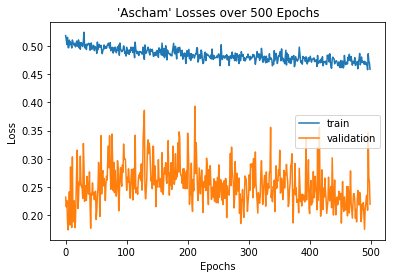

Average Training Score: 0.4840319658139123
Average Validation Score: 0.25277949022346485


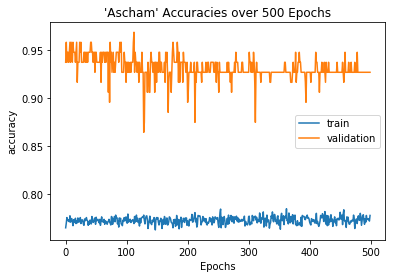

Average Training Score: 0.7730227773695812
Average Validation Score: 0.9314791666666667

validating on book: 'Montaigne'
Epoch 0/499
----------



Phase:train
Confusion matrix:
 [[ 207  425]
 [  73 1446]]
loss 1012.0016162842512



Phase:val
Confusion matrix:
 [[ 23 106]
 [  4 534]]
loss 245.3975859284401
Epoch 1/499
----------



Phase:train
Confusion matrix:
 [[ 240  392]
 [ 103 1416]]
loss 1052.8714963197708



Phase:val
Confusion matrix:
 [[ 19 110]
 [  4 534]]
loss 252.6818846464157
Epoch 2/499
----------



Phase:train
Confusion matrix:
 [[ 192  440]
 [  73 1446]]
loss 1048.85958558321



Phase:val
Confusion matrix:
 [[ 21 108]
 [  3 535]]
loss 251.63820785284042
Epoch 3/499
----------



Phase:train
Confusion matrix:
 [[ 232  400]
 [  84 1435]]
loss 999.6085280328989



Phase:val
Confusion matrix:
 [[ 23 106]
 [  3 535]]
loss 248.6703843176365
Epoch 4/499
----------



Phase:train
Confusion matrix:
 [[ 237  395]
 [ 105 1414]]
loss 1001.7671143710613



Phase:val
Confusion matrix:
 [[ 23 106]
 [  5 533]]
loss 244.4372092783451
Epoch 5/499
----------



Phase:train
Confusion matrix:
 [[ 222  410]
 [  87 1432]]
loss 1002.8460657149553



Phase:val
Confusion matrix:
 [[ 20 109]
 [  4 534]]
loss 238.90946808457375
Epoch 6/499
----------



Phase:train
Confusion matrix:
 [[ 228  404]
 [  83 1436]]
loss 990.2706272304058



Phase:val
Confusion matrix:
 [[ 54  75]
 [ 30 508]]
loss 240.98181316256523
Epoch 7/499
----------



Phase:train
Confusion matrix:
 [[ 223  409]
 [ 107 1412]]
loss 1031.9718530476093



Phase:val
Confusion matrix:
 [[ 20 109]
 [  3 535]]
loss 251.85898306965828
Epoch 8/499
----------



Phase:train
Confusion matrix:
 [[ 220  412]
 [  98 1421]]
loss 1023.6507564634085



Phase:val
Confusion matrix:
 [[ 24 105]
 [  5 533]]
loss 252.5113392919302
Epoch 9/499
----------



Phase:train
Confusion matrix:
 [[ 230  402]
 [  97 1422]]
loss 1032.6689581274986



Phase:val
Confusion matrix:
 [[ 21 108]
 [  3 535]]
loss 256.17427268624306
Epoch 10/499
----------



Phase:train
Confusion matrix:
 [[ 191  441]
 [  64 1455]]
loss 1040.717388689518



Phase:val
Confusion matrix:
 [[ 22 107]
 [  2 536]]
loss 252.1925939321518
Epoch 11/499
----------



Phase:train
Confusion matrix:
 [[ 228  404]
 [ 107 1412]]
loss 996.9147291183472



Phase:val
Confusion matrix:
 [[ 24 105]
 [  5 533]]
loss 254.10343173146248
Epoch 12/499
----------



Phase:train
Confusion matrix:
 [[ 236  396]
 [ 108 1411]]
loss 1037.5256768465042



Phase:val
Confusion matrix:
 [[ 23 106]
 [  3 535]]
loss 259.7477115392685
Epoch 13/499
----------



Phase:train
Confusion matrix:
 [[ 206  426]
 [  68 1451]]
loss 1017.7334666699171



Phase:val
Confusion matrix:
 [[ 23 106]
 [  4 534]]
loss 258.64582735300064
Epoch 14/499
----------



Phase:train
Confusion matrix:
 [[ 236  396]
 [  89 1430]]
loss 1002.9014175385237



Phase:val
Confusion matrix:
 [[ 14 115]
 [  4 534]]
loss 262.00921458005905
Epoch 15/499
----------



Phase:train
Confusion matrix:
 [[ 209  423]
 [  97 1422]]
loss 1023.5010023713112



Phase:val
Confusion matrix:
 [[ 22 107]
 [  3 535]]
loss 254.67751795053482
Epoch 16/499
----------



Phase:train
Confusion matrix:
 [[ 225  407]
 [  82 1437]]
loss 1002.4874448180199



Phase:val
Confusion matrix:
 [[ 22 107]
 [  3 535]]
loss 243.80617102980614
Epoch 17/499
----------



Phase:train
Confusion matrix:
 [[ 226  406]
 [  85 1434]]
loss 992.4259888231754



Phase:val
Confusion matrix:
 [[ 19 110]
 [  3 535]]
loss 259.13243536651134
Epoch 18/499
----------



Phase:train
Confusion matrix:
 [[ 241  391]
 [  88 1431]]
loss 1010.0095706433058



Phase:val
Confusion matrix:
 [[ 23 106]
 [  3 535]]
loss 261.525022983551
Epoch 19/499
----------



Phase:train
Confusion matrix:
 [[ 236  396]
 [ 103 1416]]
loss 994.6840198934078



Phase:val
Confusion matrix:
 [[ 22 107]
 [  4 534]]
loss 246.06359657645226
Epoch 20/499
----------



Phase:train
Confusion matrix:
 [[ 237  395]
 [  94 1425]]
loss 994.8510909378529



Phase:val
Confusion matrix:
 [[ 23 106]
 [  4 534]]
loss 250.72260937094688
Epoch 21/499
----------



Phase:train
Confusion matrix:
 [[ 234  398]
 [  87 1432]]
loss 987.3533147573471



Phase:val
Confusion matrix:
 [[ 23 106]
 [  4 534]]
loss 244.05285608768463
Epoch 22/499
----------



Phase:train
Confusion matrix:
 [[ 222  410]
 [  96 1423]]
loss 1007.5373519957066



Phase:val
Confusion matrix:
 [[ 23 106]
 [  3 535]]
loss 250.6338970065117
Epoch 23/499
----------



Phase:train
Confusion matrix:
 [[ 237  395]
 [  97 1422]]
loss 1002.7144946157932



Phase:val
Confusion matrix:
 [[ 22 107]
 [  3 535]]
loss 252.36207097768784
Epoch 24/499
----------



Phase:train
Confusion matrix:
 [[ 233  399]
 [  80 1439]]
loss 976.8409605920315



Phase:val
Confusion matrix:
 [[ 21 108]
 [  3 535]]
loss 250.75397565960884
Epoch 25/499
----------



Phase:train
Confusion matrix:
 [[ 217  415]
 [  79 1440]]
loss 1024.8352375626564



Phase:val
Confusion matrix:
 [[ 21 108]
 [  3 535]]
loss 249.5024410188198
Epoch 26/499
----------



Phase:train
Confusion matrix:
 [[ 219  413]
 [  84 1435]]
loss 1019.573518037796



Phase:val
Confusion matrix:
 [[ 23 106]
 [  4 534]]
loss 251.19489163160324
Epoch 27/499
----------



Phase:train
Confusion matrix:
 [[ 210  422]
 [  79 1440]]
loss 1023.8606485426426



Phase:val
Confusion matrix:
 [[ 23 106]
 [  3 535]]
loss 262.3058793246746
Epoch 28/499
----------



Phase:train
Confusion matrix:
 [[ 242  390]
 [ 107 1412]]
loss 994.7898779213428



Phase:val
Confusion matrix:
 [[ 22 107]
 [  3 535]]
loss 251.0056591629982
Epoch 29/499
----------



Phase:train
Confusion matrix:
 [[ 244  388]
 [  96 1423]]
loss 981.7185739129782



Phase:val
Confusion matrix:
 [[ 24 105]
 [  6 532]]
loss 250.21331638097763
Epoch 30/499
----------



Phase:train
Confusion matrix:
 [[ 224  408]
 [  98 1421]]
loss 1011.2198117375374



Phase:val
Confusion matrix:
 [[ 23 106]
 [  5 533]]
loss 257.35332053899765
Epoch 31/499
----------



Phase:train
Confusion matrix:
 [[ 240  392]
 [  92 1427]]
loss 999.2266748249531



Phase:val
Confusion matrix:
 [[ 26 103]
 [  8 530]]
loss 264.58883261680603
Epoch 32/499
----------



Phase:train
Confusion matrix:
 [[ 234  398]
 [ 123 1396]]
loss 1027.8357211649418



Phase:val
Confusion matrix:
 [[ 23 106]
 [  3 535]]
loss 260.0132513642311
Epoch 33/499
----------



Phase:train
Confusion matrix:
 [[ 220  412]
 [  85 1434]]
loss 1018.1277190446854



Phase:val
Confusion matrix:
 [[ 22 107]
 [  3 535]]
loss 250.43756300210953
Epoch 34/499
----------



Phase:train
Confusion matrix:
 [[ 221  411]
 [ 105 1414]]
loss 982.2087262570858



Phase:val
Confusion matrix:
 [[ 23 106]
 [  4 534]]
loss 247.49662056565285
Epoch 35/499
----------



Phase:train
Confusion matrix:
 [[ 221  411]
 [  94 1425]]
loss 1046.7363674640656



Phase:val
Confusion matrix:
 [[ 21 108]
 [  3 535]]
loss 268.2205485999584
Epoch 36/499
----------



Phase:train
Confusion matrix:
 [[ 223  409]
 [  75 1444]]
loss 995.3691645562649



Phase:val
Confusion matrix:
 [[ 20 109]
 [  3 535]]
loss 256.7263243198395
Epoch 37/499
----------



Phase:train
Confusion matrix:
 [[ 218  414]
 [  74 1445]]
loss 992.9942218214273



Phase:val
Confusion matrix:
 [[ 18 111]
 [  4 534]]
loss 274.5993710756302
Epoch 38/499
----------



Phase:train
Confusion matrix:
 [[ 230  402]
 [  84 1435]]
loss 993.7436457872391



Phase:val
Confusion matrix:
 [[ 23 106]
 [  4 534]]
loss 264.4384369254112
Epoch 39/499
----------



Phase:train
Confusion matrix:
 [[ 228  404]
 [  95 1424]]
loss 998.9268244206905



Phase:val
Confusion matrix:
 [[ 20 109]
 [  3 535]]
loss 256.7502627670765
Epoch 40/499
----------



Phase:train
Confusion matrix:
 [[ 212  420]
 [  99 1420]]
loss 1012.1132737845182



Phase:val
Confusion matrix:
 [[ 18 111]
 [  3 535]]
loss 257.73251181840897
Epoch 41/499
----------



Phase:train
Confusion matrix:
 [[ 222  410]
 [  83 1436]]
loss 1007.1492460370064



Phase:val
Confusion matrix:
 [[ 19 110]
 [  3 535]]
loss 265.3800325989723
Epoch 42/499
----------



Phase:train
Confusion matrix:
 [[ 235  397]
 [  71 1448]]
loss 999.926626265049



Phase:val
Confusion matrix:
 [[ 22 107]
 [  3 535]]
loss 255.59592017531395
Epoch 43/499
----------



Phase:train
Confusion matrix:
 [[ 229  403]
 [  92 1427]]
loss 1010.778339356184



Phase:val
Confusion matrix:
 [[ 21 108]
 [  3 535]]
loss 260.97600385546684
Epoch 44/499
----------



Phase:train
Confusion matrix:
 [[ 228  404]
 [  93 1426]]
loss 1000.4995591342449



Phase:val
Confusion matrix:
 [[ 20 109]
 [  3 535]]
loss 260.36695924401283
Epoch 45/499
----------



Phase:train
Confusion matrix:
 [[ 207  425]
 [  68 1451]]
loss 1025.107778340578



Phase:val
Confusion matrix:
 [[ 19 110]
 [  3 535]]
loss 250.8292418718338
Epoch 46/499
----------



Phase:train
Confusion matrix:
 [[ 256  376]
 [  98 1421]]
loss 975.0836534202099



Phase:val
Confusion matrix:
 [[ 64  65]
 [ 53 485]]
loss 257.2941978275776
Epoch 47/499
----------



Phase:train
Confusion matrix:
 [[ 247  385]
 [ 112 1407]]
loss 989.7646561563015



Phase:val
Confusion matrix:
 [[ 66  63]
 [ 70 468]]
loss 264.0756206512451
Epoch 48/499
----------



Phase:train
Confusion matrix:
 [[ 265  367]
 [ 116 1403]]
loss 988.5346007943153



Phase:val
Confusion matrix:
 [[ 50  79]
 [ 45 493]]
loss 265.2920387983322
Epoch 49/499
----------



Phase:train
Confusion matrix:
 [[ 246  386]
 [ 112 1407]]
loss 1012.8710958957672



Phase:val
Confusion matrix:
 [[ 59  70]
 [ 49 489]]
loss 264.1722936630249
Epoch 50/499
----------



Phase:train
Confusion matrix:
 [[ 235  397]
 [ 102 1417]]
loss 1000.9934868812561



Phase:val
Confusion matrix:
 [[ 19 110]
 [  3 535]]
loss 258.3658633828163
Epoch 51/499
----------



Phase:train
Confusion matrix:
 [[ 232  400]
 [  98 1421]]
loss 998.3962122052908



Phase:val
Confusion matrix:
 [[ 23 106]
 [  9 529]]
loss 251.3365679383278
Epoch 52/499
----------



Phase:train
Confusion matrix:
 [[ 230  402]
 [  90 1429]]
loss 1014.8756131827831



Phase:val
Confusion matrix:
 [[ 38  91]
 [ 22 516]]
loss 271.4572170674801
Epoch 53/499
----------



Phase:train
Confusion matrix:
 [[ 242  390]
 [  90 1429]]
loss 1012.0810470730066



Phase:val
Confusion matrix:
 [[ 57  72]
 [ 61 477]]
loss 276.16237089037895
Epoch 54/499
----------



Phase:train
Confusion matrix:
 [[ 228  404]
 [ 105 1414]]
loss 1015.9351673871279



Phase:val
Confusion matrix:
 [[ 73  56]
 [ 89 449]]
loss 280.21007403731346
Epoch 55/499
----------



Phase:train
Confusion matrix:
 [[ 249  383]
 [  99 1420]]
loss 980.9044248759747



Phase:val
Confusion matrix:
 [[ 73  56]
 [ 76 462]]
loss 269.23414251208305
Epoch 56/499
----------



Phase:train
Confusion matrix:
 [[ 253  379]
 [ 108 1411]]
loss 1011.3781966269016



Phase:val
Confusion matrix:
 [[ 51  78]
 [ 45 493]]
loss 268.2576105296612
Epoch 57/499
----------



Phase:train
Confusion matrix:
 [[ 247  385]
 [  96 1423]]
loss 975.9226934313774



Phase:val
Confusion matrix:
 [[ 38  91]
 [ 28 510]]
loss 255.37457683682442
Epoch 58/499
----------



Phase:train
Confusion matrix:
 [[ 233  399]
 [ 103 1416]]
loss 991.7720111310482



Phase:val
Confusion matrix:
 [[ 57  72]
 [ 60 478]]
loss 274.96774500608444
Epoch 59/499
----------



Phase:train
Confusion matrix:
 [[ 239  393]
 [ 100 1419]]
loss 1020.121555775404



Phase:val
Confusion matrix:
 [[ 18 111]
 [  2 536]]
loss 266.13338509202003
Epoch 60/499
----------



Phase:train
Confusion matrix:
 [[ 223  409]
 [  97 1422]]
loss 1024.7032402008772



Phase:val
Confusion matrix:
 [[ 20 109]
 [  3 535]]
loss 270.8838833272457
Epoch 61/499
----------



Phase:train
Confusion matrix:
 [[ 228  404]
 [  85 1434]]
loss 1039.5796143114567



Phase:val
Confusion matrix:
 [[ 15 114]
 [  3 535]]
loss 262.293607622385
Epoch 62/499
----------



Phase:train
Confusion matrix:
 [[ 209  423]
 [  68 1451]]
loss 1010.4798216372728



Phase:val
Confusion matrix:
 [[ 17 112]
 [  2 536]]
loss 259.0306911468506
Epoch 63/499
----------



Phase:train
Confusion matrix:
 [[ 210  422]
 [  97 1422]]
loss 999.6862205266953



Phase:val
Confusion matrix:
 [[ 18 111]
 [  2 536]]
loss 257.2206838428974
Epoch 64/499
----------



Phase:train
Confusion matrix:
 [[ 230  402]
 [  99 1420]]
loss 994.8925750255585



Phase:val
Confusion matrix:
 [[ 49  80]
 [ 41 497]]
loss 254.22771382331848
Epoch 65/499
----------



Phase:train
Confusion matrix:
 [[ 244  388]
 [ 109 1410]]
loss 1007.2365217506886



Phase:val
Confusion matrix:
 [[ 17 112]
 [  2 536]]
loss 262.89705589413643
Epoch 66/499
----------



Phase:train
Confusion matrix:
 [[ 211  421]
 [  79 1440]]
loss 1004.3140010088682



Phase:val
Confusion matrix:
 [[ 15 114]
 [  2 536]]
loss 257.3792248368263
Epoch 67/499
----------



Phase:train
Confusion matrix:
 [[ 251  381]
 [ 119 1400]]
loss 1034.1815032362938



Phase:val
Confusion matrix:
 [[ 15 114]
 [  3 535]]
loss 270.2383525669575
Epoch 68/499
----------



Phase:train
Confusion matrix:
 [[ 223  409]
 [  70 1449]]
loss 1002.9683749228716



Phase:val
Confusion matrix:
 [[ 33  96]
 [ 30 508]]
loss 259.00636035203934
Epoch 69/499
----------



Phase:train
Confusion matrix:
 [[ 211  421]
 [ 105 1414]]
loss 1022.476968318224



Phase:val
Confusion matrix:
 [[ 26 103]
 [ 21 517]]
loss 262.0593169927597
Epoch 70/499
----------



Phase:train
Confusion matrix:
 [[ 239  393]
 [  84 1435]]
loss 974.5039245933294



Phase:val
Confusion matrix:
 [[ 41  88]
 [ 32 506]]
loss 259.09014987945557
Epoch 71/499
----------



Phase:train
Confusion matrix:
 [[ 279  353]
 [ 136 1383]]
loss 980.5561662316322



Phase:val
Confusion matrix:
 [[ 38  91]
 [ 38 500]]
loss 262.1586725115776
Epoch 72/499
----------



Phase:train
Confusion matrix:
 [[ 246  386]
 [ 105 1414]]
loss 1032.5066836476326



Phase:val
Confusion matrix:
 [[ 15 114]
 [  3 535]]
loss 275.0025274157524
Epoch 73/499
----------



Phase:train
Confusion matrix:
 [[ 232  400]
 [  92 1427]]
loss 1002.3206064850092



Phase:val
Confusion matrix:
 [[ 29 100]
 [ 19 519]]
loss 261.97637990117073
Epoch 74/499
----------



Phase:train
Confusion matrix:
 [[ 229  403]
 [ 108 1411]]
loss 1014.082785397768



Phase:val
Confusion matrix:
 [[ 19 110]
 [  4 534]]
loss 264.3525542020798
Epoch 75/499
----------



Phase:train
Confusion matrix:
 [[ 232  400]
 [ 109 1410]]
loss 1005.5015383958817



Phase:val
Confusion matrix:
 [[ 40  89]
 [ 24 514]]
loss 259.4663812816143
Epoch 76/499
----------



Phase:train
Confusion matrix:
 [[ 246  386]
 [  98 1421]]
loss 991.3470069468021



Phase:val
Confusion matrix:
 [[ 39  90]
 [ 28 510]]
loss 256.20601561665535
Epoch 77/499
----------



Phase:train
Confusion matrix:
 [[ 247  385]
 [  91 1428]]
loss 984.7761276066303



Phase:val
Confusion matrix:
 [[ 38  91]
 [ 24 514]]
loss 250.7258751988411
Epoch 78/499
----------



Phase:train
Confusion matrix:
 [[ 229  403]
 [ 100 1419]]
loss 1031.4246888160706



Phase:val
Confusion matrix:
 [[ 17 112]
 [  3 535]]
loss 258.3691075742245
Epoch 79/499
----------



Phase:train
Confusion matrix:
 [[ 223  409]
 [  77 1442]]
loss 999.7845108807087



Phase:val
Confusion matrix:
 [[ 18 111]
 [  4 534]]
loss 259.3692435026169
Epoch 80/499
----------



Phase:train
Confusion matrix:
 [[ 231  401]
 [ 111 1408]]
loss 1011.3292196840048



Phase:val
Confusion matrix:
 [[ 40  89]
 [ 28 510]]
loss 258.8132409751415
Epoch 81/499
----------



Phase:train
Confusion matrix:
 [[ 250  382]
 [  95 1424]]
loss 993.2253578305244



Phase:val
Confusion matrix:
 [[ 32  97]
 [ 30 508]]
loss 265.25240674614906
Epoch 82/499
----------



Phase:train
Confusion matrix:
 [[ 237  395]
 [ 105 1414]]
loss 1005.2871324419975



Phase:val
Confusion matrix:
 [[ 20 109]
 [ 12 526]]
loss 256.5918867588043
Epoch 83/499
----------



Phase:train
Confusion matrix:
 [[ 228  404]
 [  98 1421]]
loss 1002.1564708650112



Phase:val
Confusion matrix:
 [[ 23 106]
 [ 15 523]]
loss 272.51295202970505
Epoch 84/499
----------



Phase:train
Confusion matrix:
 [[ 232  400]
 [  98 1421]]
loss 993.2902248799801



Phase:val
Confusion matrix:
 [[ 31  98]
 [ 28 510]]
loss 270.3204920589924
Epoch 85/499
----------



Phase:train
Confusion matrix:
 [[ 226  406]
 [ 101 1418]]
loss 1010.0377223342657



Phase:val
Confusion matrix:
 [[ 19 110]
 [  3 535]]
loss 253.96885806322098
Epoch 86/499
----------



Phase:train
Confusion matrix:
 [[ 227  405]
 [  88 1431]]
loss 1001.8084628283978



Phase:val
Confusion matrix:
 [[ 20 109]
 [  3 535]]
loss 268.8880752325058
Epoch 87/499
----------



Phase:train
Confusion matrix:
 [[ 248  384]
 [  93 1426]]
loss 994.2523915916681



Phase:val
Confusion matrix:
 [[ 18 111]
 [  3 535]]
loss 269.5259020626545
Epoch 88/499
----------



Phase:train
Confusion matrix:
 [[ 223  409]
 [  90 1429]]
loss 994.0067144483328



Phase:val
Confusion matrix:
 [[ 17 112]
 [  3 535]]
loss 260.23882798850536
Epoch 89/499
----------



Phase:train
Confusion matrix:
 [[ 218  414]
 [  88 1431]]
loss 1000.4722283780575



Phase:val
Confusion matrix:
 [[ 18 111]
 [  3 535]]
loss 264.23091754317284
Epoch 90/499
----------



Phase:train
Confusion matrix:
 [[ 225  407]
 [  88 1431]]
loss 981.7909295260906



Phase:val
Confusion matrix:
 [[ 13 116]
 [  3 535]]
loss 260.03180891275406
Epoch 91/499
----------



Phase:train
Confusion matrix:
 [[ 231  401]
 [ 106 1413]]
loss 1025.2347938418388



Phase:val
Confusion matrix:
 [[ 46  83]
 [ 40 498]]
loss 281.2573403120041
Epoch 92/499
----------



Phase:train
Confusion matrix:
 [[ 246  386]
 [  84 1435]]
loss 983.3022145330906



Phase:val
Confusion matrix:
 [[ 49  80]
 [ 44 494]]
loss 284.0629221498966
Epoch 93/499
----------



Phase:train
Confusion matrix:
 [[ 247  385]
 [  96 1423]]
loss 985.9074655175209



Phase:val
Confusion matrix:
 [[ 47  82]
 [ 43 495]]
loss 278.64184296131134
Epoch 94/499
----------



Phase:train
Confusion matrix:
 [[ 247  385]
 [ 123 1396]]
loss 1002.561580017209



Phase:val
Confusion matrix:
 [[ 17 112]
 [  3 535]]
loss 285.5697104036808
Epoch 95/499
----------



Phase:train
Confusion matrix:
 [[ 234  398]
 [ 103 1416]]
loss 987.7914903461933



Phase:val
Confusion matrix:
 [[ 36  93]
 [ 28 510]]
loss 259.9988610446453
Epoch 96/499
----------



Phase:train
Confusion matrix:
 [[ 233  399]
 [ 117 1402]]
loss 1011.0586022138596



Phase:val
Confusion matrix:
 [[ 72  57]
 [ 87 451]]
loss 274.3112866282463
Epoch 97/499
----------



Phase:train
Confusion matrix:
 [[ 233  399]
 [  84 1435]]
loss 1003.332039013505



Phase:val
Confusion matrix:
 [[ 21 108]
 [  4 534]]
loss 266.6054808497429
Epoch 98/499
----------



Phase:train
Confusion matrix:
 [[ 229  403]
 [  80 1439]]
loss 970.516436368227



Phase:val
Confusion matrix:
 [[ 80  49]
 [105 433]]
loss 268.81974041461945
Epoch 99/499
----------



Phase:train
Confusion matrix:
 [[ 230  402]
 [ 102 1417]]
loss 980.5589655190706



Phase:val
Confusion matrix:
 [[ 26 103]
 [ 10 528]]
loss 255.8691010773182
Epoch 100/499
----------



Phase:train
Confusion matrix:
 [[ 216  416]
 [  92 1427]]
loss 1009.1338998526335



Phase:val
Confusion matrix:
 [[ 55  74]
 [ 55 483]]
loss 259.71724185347557
Epoch 101/499
----------



Phase:train
Confusion matrix:
 [[ 232  400]
 [  95 1424]]
loss 1008.6028467416763



Phase:val
Confusion matrix:
 [[ 18 111]
 [  3 535]]
loss 273.09085300564766
Epoch 102/499
----------



Phase:train
Confusion matrix:
 [[ 228  404]
 [  80 1439]]
loss 982.6229430288076



Phase:val
Confusion matrix:
 [[ 16 113]
 [  3 535]]
loss 272.89948320388794
Epoch 103/499
----------



Phase:train
Confusion matrix:
 [[ 235  397]
 [  85 1434]]
loss 981.7441163063049



Phase:val
Confusion matrix:
 [[ 62  67]
 [ 76 462]]
loss 283.6554508805275
Epoch 104/499
----------



Phase:train
Confusion matrix:
 [[ 262  370]
 [ 133 1386]]
loss 1010.8469034135342



Phase:val
Confusion matrix:
 [[ 16 113]
 [  2 536]]
loss 263.76123905181885
Epoch 105/499
----------



Phase:train
Confusion matrix:
 [[ 227  405]
 [  78 1441]]
loss 978.8173662126064



Phase:val
Confusion matrix:
 [[ 61  68]
 [ 56 482]]
loss 261.17985063791275
Epoch 106/499
----------



Phase:train
Confusion matrix:
 [[ 233  399]
 [  90 1429]]
loss 981.7030906379223



Phase:val
Confusion matrix:
 [[ 31  98]
 [ 33 505]]
loss 254.85326018929482
Epoch 107/499
----------



Phase:train
Confusion matrix:
 [[ 240  392]
 [  92 1427]]
loss 982.1418346315622



Phase:val
Confusion matrix:
 [[ 59  70]
 [ 70 468]]
loss 268.5533590912819
Epoch 108/499
----------



Phase:train
Confusion matrix:
 [[ 275  357]
 [ 118 1401]]
loss 976.9547179043293



Phase:val
Confusion matrix:
 [[ 81  48]
 [122 416]]
loss 284.67982426285744
Epoch 109/499
----------



Phase:train
Confusion matrix:
 [[ 249  383]
 [ 132 1387]]
loss 1003.5369781851768



Phase:val
Confusion matrix:
 [[ 51  78]
 [ 49 489]]
loss 273.66169679164886
Epoch 110/499
----------



Phase:train
Confusion matrix:
 [[ 222  410]
 [  91 1428]]
loss 1002.7615011632442



Phase:val
Confusion matrix:
 [[ 35  94]
 [ 27 511]]
loss 268.56135642528534
Epoch 111/499
----------



Phase:train
Confusion matrix:
 [[ 246  386]
 [ 102 1417]]
loss 990.261141166091



Phase:val
Confusion matrix:
 [[ 27 102]
 [ 19 519]]
loss 266.8054755330086
Epoch 112/499
----------



Phase:train
Confusion matrix:
 [[ 238  394]
 [  95 1424]]
loss 976.8376051187515



Phase:val
Confusion matrix:
 [[ 27 102]
 [ 13 525]]
loss 265.59840041399
Epoch 113/499
----------



Phase:train
Confusion matrix:
 [[ 233  399]
 [  96 1423]]
loss 995.2109133303165



Phase:val
Confusion matrix:
 [[ 32  97]
 [ 23 515]]
loss 266.5888606309891
Epoch 114/499
----------



Phase:train
Confusion matrix:
 [[ 217  415]
 [  81 1438]]
loss 1000.1516615599394



Phase:val
Confusion matrix:
 [[ 45  84]
 [ 48 490]]
loss 276.53278586268425
Epoch 115/499
----------



Phase:train
Confusion matrix:
 [[ 233  399]
 [ 100 1419]]
loss 1000.4413474053144



Phase:val
Confusion matrix:
 [[ 57  72]
 [ 76 462]]
loss 283.3588556051254
Epoch 116/499
----------



Phase:train
Confusion matrix:
 [[ 249  383]
 [ 120 1399]]
loss 994.0732618868351



Phase:val
Confusion matrix:
 [[ 56  73]
 [ 72 466]]
loss 284.16520431637764
Epoch 117/499
----------



Phase:train
Confusion matrix:
 [[ 254  378]
 [ 122 1397]]
loss 999.8768121004105



Phase:val
Confusion matrix:
 [[ 21 108]
 [  4 534]]
loss 284.89733323454857
Epoch 118/499
----------



Phase:train
Confusion matrix:
 [[ 216  416]
 [ 101 1418]]
loss 992.0549429804087



Phase:val
Confusion matrix:
 [[ 16 113]
 [  2 536]]
loss 272.38871878385544
Epoch 119/499
----------



Phase:train
Confusion matrix:
 [[ 197  435]
 [  84 1435]]
loss 1032.0917060822248



Phase:val
Confusion matrix:
 [[ 15 114]
 [  3 535]]
loss 276.74636870622635
Epoch 120/499
----------



Phase:train
Confusion matrix:
 [[ 228  404]
 [  91 1428]]
loss 980.816307708621



Phase:val
Confusion matrix:
 [[ 17 112]
 [  3 535]]
loss 279.8639200925827
Epoch 121/499
----------



Phase:train
Confusion matrix:
 [[ 223  409]
 [  90 1429]]
loss 1015.8103075176477



Phase:val
Confusion matrix:
 [[ 15 114]
 [  2 536]]
loss 280.7404711842537
Epoch 122/499
----------



Phase:train
Confusion matrix:
 [[ 207  425]
 [  63 1456]]
loss 995.164485886693



Phase:val
Confusion matrix:
 [[ 16 113]
 [  4 534]]
loss 276.20865869522095
Epoch 123/499
----------



Phase:train
Confusion matrix:
 [[ 218  414]
 [  69 1450]]
loss 1004.7934949845076



Phase:val
Confusion matrix:
 [[ 21 108]
 [  3 535]]
loss 269.64571765065193
Epoch 124/499
----------



Phase:train
Confusion matrix:
 [[ 217  415]
 [  75 1444]]
loss 964.4954950809479



Phase:val
Confusion matrix:
 [[ 26 103]
 [ 11 527]]
loss 257.8567950129509
Epoch 125/499
----------



Phase:train
Confusion matrix:
 [[ 223  409]
 [  94 1425]]
loss 981.4373531192541



Phase:val
Confusion matrix:
 [[ 22 107]
 [  4 534]]
loss 256.8796055018902
Epoch 126/499
----------



Phase:train
Confusion matrix:
 [[ 244  388]
 [ 101 1418]]
loss 978.2548998147249



Phase:val
Confusion matrix:
 [[ 27 102]
 [ 12 526]]
loss 262.5559602677822
Epoch 127/499
----------



Phase:train
Confusion matrix:
 [[ 242  390]
 [  93 1426]]
loss 986.7859886437654



Phase:val
Confusion matrix:
 [[ 40  89]
 [ 26 512]]
loss 268.07497304677963
Epoch 128/499
----------



Phase:train
Confusion matrix:
 [[ 220  412]
 [  76 1443]]
loss 1078.0834513157606



Phase:val
Confusion matrix:
 [[ 24 105]
 [ 13 525]]
loss 311.1219647228718
Epoch 129/499
----------



Phase:train
Confusion matrix:
 [[ 226  406]
 [  86 1433]]
loss 1003.3187498450279



Phase:val
Confusion matrix:
 [[ 14 115]
 [  3 535]]
loss 291.0411930680275
Epoch 130/499
----------



Phase:train
Confusion matrix:
 [[ 217  415]
 [  62 1457]]
loss 970.4436545372009



Phase:val
Confusion matrix:
 [[ 15 114]
 [  3 535]]
loss 271.0165395140648
Epoch 131/499
----------



Phase:train
Confusion matrix:
 [[ 237  395]
 [ 115 1404]]
loss 996.8171646893024



Phase:val
Confusion matrix:
 [[ 21 108]
 [  4 534]]
loss 278.78462195396423
Epoch 132/499
----------



Phase:train
Confusion matrix:
 [[ 236  396]
 [  92 1427]]
loss 1009.2028804421425



Phase:val
Confusion matrix:
 [[ 19 110]
 [  3 535]]
loss 290.3050382733345
Epoch 133/499
----------



Phase:train
Confusion matrix:
 [[ 228  404]
 [  74 1445]]
loss 988.4446073025465



Phase:val
Confusion matrix:
 [[ 16 113]
 [  3 535]]
loss 263.9831661581993
Epoch 134/499
----------



Phase:train
Confusion matrix:
 [[ 219  413]
 [  97 1422]]
loss 979.8289560377598



Phase:val
Confusion matrix:
 [[ 17 112]
 [  3 535]]
loss 279.95677971839905
Epoch 135/499
----------



Phase:train
Confusion matrix:
 [[ 229  403]
 [  89 1430]]
loss 983.4354343265295



Phase:val
Confusion matrix:
 [[ 16 113]
 [  2 536]]
loss 275.8785436153412
Epoch 136/499
----------



Phase:train
Confusion matrix:
 [[ 222  410]
 [  79 1440]]
loss 1000.6550235748291



Phase:val
Confusion matrix:
 [[ 17 112]
 [  3 535]]
loss 270.5536381006241
Epoch 137/499
----------



Phase:train
Confusion matrix:
 [[ 251  381]
 [ 112 1407]]
loss 962.1815721988678



Phase:val
Confusion matrix:
 [[ 33  96]
 [ 28 510]]
loss 271.1887591481209
Epoch 138/499
----------



Phase:train
Confusion matrix:
 [[ 252  380]
 [ 102 1417]]
loss 1012.4773740172386



Phase:val
Confusion matrix:
 [[ 54  75]
 [ 44 494]]
loss 270.2891170978546
Epoch 139/499
----------



Phase:train
Confusion matrix:
 [[ 233  399]
 [ 100 1419]]
loss 1001.3735579103231



Phase:val
Confusion matrix:
 [[ 47  82]
 [ 42 496]]
loss 271.59505105018616
Epoch 140/499
----------



Phase:train
Confusion matrix:
 [[ 233  399]
 [ 101 1418]]
loss 1009.331230789423



Phase:val
Confusion matrix:
 [[ 21 108]
 [  4 534]]
loss 276.6628997325897
Epoch 141/499
----------



Phase:train
Confusion matrix:
 [[ 262  370]
 [ 117 1402]]
loss 991.9241531193256



Phase:val
Confusion matrix:
 [[ 39  90]
 [ 34 504]]
loss 271.8343696594238
Epoch 142/499
----------



Phase:train
Confusion matrix:
 [[ 253  379]
 [  83 1436]]
loss 958.0174807161093



Phase:val
Confusion matrix:
 [[ 37  92]
 [ 24 514]]
loss 268.0967163145542
Epoch 143/499
----------



Phase:train
Confusion matrix:
 [[ 249  383]
 [ 104 1415]]
loss 978.4112320542336



Phase:val
Confusion matrix:
 [[ 48  81]
 [ 55 483]]
loss 266.54363483190536
Epoch 144/499
----------



Phase:train
Confusion matrix:
 [[ 245  387]
 [ 101 1418]]
loss 996.334245249629



Phase:val
Confusion matrix:
 [[ 16 113]
 [  2 536]]
loss 262.08373987674713
Epoch 145/499
----------



Phase:train
Confusion matrix:
 [[ 233  399]
 [ 117 1402]]
loss 978.5573581457138



Phase:val
Confusion matrix:
 [[ 17 112]
 [  4 534]]
loss 259.3047050833702
Epoch 146/499
----------



Phase:train
Confusion matrix:
 [[ 213  419]
 [  87 1432]]
loss 994.4163073003292



Phase:val
Confusion matrix:
 [[ 14 115]
 [  2 536]]
loss 272.15716314315796
Epoch 147/499
----------



Phase:train
Confusion matrix:
 [[ 245  387]
 [  84 1435]]
loss 982.4218369424343



Phase:val
Confusion matrix:
 [[ 18 111]
 [  3 535]]
loss 274.4279123842716
Epoch 148/499
----------



Phase:train
Confusion matrix:
 [[ 240  392]
 [  80 1439]]
loss 1001.1663853675127



Phase:val
Confusion matrix:
 [[ 52  77]
 [ 59 479]]
loss 266.06277003884315
Epoch 149/499
----------



Phase:train
Confusion matrix:
 [[ 255  377]
 [ 132 1387]]
loss 1039.8327505588531



Phase:val
Confusion matrix:
 [[ 17 112]
 [  3 535]]
loss 276.21080419421196
Epoch 150/499
----------



Phase:train
Confusion matrix:
 [[ 215  417]
 [  69 1450]]
loss 993.3726678192616



Phase:val
Confusion matrix:
 [[ 16 113]
 [  3 535]]
loss 270.18326583504677
Epoch 151/499
----------



Phase:train
Confusion matrix:
 [[ 232  400]
 [ 103 1416]]
loss 1016.2073642760515



Phase:val
Confusion matrix:
 [[ 20 109]
 [  2 536]]
loss 273.40320044755936
Epoch 152/499
----------



Phase:train
Confusion matrix:
 [[ 228  404]
 [  91 1428]]
loss 979.2900076657534



Phase:val
Confusion matrix:
 [[ 18 111]
 [  2 536]]
loss 265.70618057250977
Epoch 153/499
----------



Phase:train
Confusion matrix:
 [[ 248  384]
 [ 101 1418]]
loss 1007.143951267004



Phase:val
Confusion matrix:
 [[ 19 110]
 [  2 536]]
loss 279.5766043961048
Epoch 154/499
----------



Phase:train
Confusion matrix:
 [[ 230  402]
 [  67 1452]]
loss 991.0402283966541



Phase:val
Confusion matrix:
 [[ 22 107]
 [  2 536]]
loss 284.14712113142014
Epoch 155/499
----------



Phase:train
Confusion matrix:
 [[ 240  392]
 [  98 1421]]
loss 989.9208199977875



Phase:val
Confusion matrix:
 [[ 20 109]
 [  2 536]]
loss 271.6615089774132
Epoch 156/499
----------



Phase:train
Confusion matrix:
 [[ 237  395]
 [  95 1424]]
loss 986.8286617696285



Phase:val
Confusion matrix:
 [[ 21 108]
 [  2 536]]
loss 275.96140336990356
Epoch 157/499
----------



Phase:train
Confusion matrix:
 [[ 218  414]
 [  95 1424]]
loss 991.2828503847122



Phase:val
Confusion matrix:
 [[ 23 106]
 [  2 536]]
loss 259.4475616812706
Epoch 158/499
----------



Phase:train
Confusion matrix:
 [[ 247  385]
 [  99 1420]]
loss 976.0876000374556



Phase:val
Confusion matrix:
 [[ 60  69]
 [ 73 465]]
loss 271.5386467576027
Epoch 159/499
----------



Phase:train
Confusion matrix:
 [[ 233  399]
 [ 112 1407]]
loss 976.7877471745014



Phase:val
Confusion matrix:
 [[ 21 108]
 [  3 535]]
loss 261.59297665953636
Epoch 160/499
----------



Phase:train
Confusion matrix:
 [[ 246  386]
 [ 101 1418]]
loss 976.6039889156818



Phase:val
Confusion matrix:
 [[ 23 106]
 [  3 535]]
loss 264.80702713131905
Epoch 161/499
----------



Phase:train
Confusion matrix:
 [[ 244  388]
 [  94 1425]]
loss 960.30304941535



Phase:val
Confusion matrix:
 [[ 38  91]
 [ 35 503]]
loss 257.65333780646324
Epoch 162/499
----------



Phase:train
Confusion matrix:
 [[ 229  403]
 [ 110 1409]]
loss 1002.2434559613466



Phase:val
Confusion matrix:
 [[ 22 107]
 [  4 534]]
loss 253.3558542728424
Epoch 163/499
----------



Phase:train
Confusion matrix:
 [[ 229  403]
 [  97 1422]]
loss 982.0177631378174



Phase:val
Confusion matrix:
 [[ 30  99]
 [ 24 514]]
loss 252.58794525265694
Epoch 164/499
----------



Phase:train
Confusion matrix:
 [[ 246  386]
 [ 114 1405]]
loss 980.2816884964705



Phase:val
Confusion matrix:
 [[ 29 100]
 [ 14 524]]
loss 250.8921241760254
Epoch 165/499
----------



Phase:train
Confusion matrix:
 [[ 249  383]
 [  99 1420]]
loss 982.0009313523769



Phase:val
Confusion matrix:
 [[ 42  87]
 [ 32 506]]
loss 267.83044853806496
Epoch 166/499
----------



Phase:train
Confusion matrix:
 [[ 246  386]
 [ 105 1414]]
loss 976.1722872257233



Phase:val
Confusion matrix:
 [[ 35  94]
 [ 16 522]]
loss 260.97598499059677
Epoch 167/499
----------



Phase:train
Confusion matrix:
 [[ 239  393]
 [  92 1427]]
loss 1002.1207348704338



Phase:val
Confusion matrix:
 [[ 25 104]
 [ 13 525]]
loss 265.42621889710426
Epoch 168/499
----------



Phase:train
Confusion matrix:
 [[ 232  400]
 [  93 1426]]
loss 980.5836494863033



Phase:val
Confusion matrix:
 [[ 24 105]
 [  9 529]]
loss 254.04082584381104
Epoch 169/499
----------



Phase:train
Confusion matrix:
 [[ 224  408]
 [  82 1437]]
loss 992.5525597929955



Phase:val
Confusion matrix:
 [[ 30  99]
 [ 34 504]]
loss 269.3847827613354
Epoch 170/499
----------



Phase:train
Confusion matrix:
 [[ 222  410]
 [  96 1423]]
loss 1011.6814620792866



Phase:val
Confusion matrix:
 [[ 21 108]
 [  3 535]]
loss 276.7832560837269
Epoch 171/499
----------



Phase:train
Confusion matrix:
 [[ 207  425]
 [  69 1450]]
loss 1004.3222245275974



Phase:val
Confusion matrix:
 [[ 16 113]
 [  3 535]]
loss 309.4695085287094
Epoch 172/499
----------



Phase:train
Confusion matrix:
 [[ 210  422]
 [  74 1445]]
loss 1045.049074858427



Phase:val
Confusion matrix:
 [[ 23 106]
 [ 18 520]]
loss 300.42221558094025
Epoch 173/499
----------



Phase:train
Confusion matrix:
 [[ 235  397]
 [  88 1431]]
loss 979.8988737165928



Phase:val
Confusion matrix:
 [[ 47  82]
 [ 43 495]]
loss 287.61653077602386
Epoch 174/499
----------



Phase:train
Confusion matrix:
 [[ 253  379]
 [  93 1426]]
loss 946.5271350741386



Phase:val
Confusion matrix:
 [[ 36  93]
 [ 40 498]]
loss 274.4358544051647
Epoch 175/499
----------



Phase:train
Confusion matrix:
 [[ 242  390]
 [ 103 1416]]
loss 1021.5366102606058



Phase:val
Confusion matrix:
 [[ 45  84]
 [ 44 494]]
loss 278.4429876804352
Epoch 176/499
----------



Phase:train
Confusion matrix:
 [[ 221  411]
 [ 101 1418]]
loss 1005.5849783420563



Phase:val
Confusion matrix:
 [[ 13 116]
 [  2 536]]
loss 277.0479655265808
Epoch 177/499
----------



Phase:train
Confusion matrix:
 [[ 220  412]
 [ 104 1415]]
loss 1010.3128769397736



Phase:val
Confusion matrix:
 [[ 25 104]
 [ 21 517]]
loss 269.50011190772057
Epoch 178/499
----------



Phase:train
Confusion matrix:
 [[ 245  387]
 [  97 1422]]
loss 988.613499596715



Phase:val
Confusion matrix:
 [[ 44  85]
 [ 44 494]]
loss 272.220796585083
Epoch 179/499
----------



Phase:train
Confusion matrix:
 [[ 249  383]
 [  86 1433]]
loss 979.1565070301294



Phase:val
Confusion matrix:
 [[ 46  83]
 [ 42 496]]
loss 274.712368696928
Epoch 180/499
----------



Phase:train
Confusion matrix:
 [[ 236  396]
 [  91 1428]]
loss 994.525818452239



Phase:val
Confusion matrix:
 [[ 30  99]
 [ 34 504]]
loss 272.5044983327389
Epoch 181/499
----------



Phase:train
Confusion matrix:
 [[ 258  374]
 [ 102 1417]]
loss 961.806572586298



Phase:val
Confusion matrix:
 [[ 26 103]
 [ 26 512]]
loss 274.7045722603798
Epoch 182/499
----------



Phase:train
Confusion matrix:
 [[ 271  361]
 [ 123 1396]]
loss 967.1036223471165



Phase:val
Confusion matrix:
 [[ 39  90]
 [ 28 510]]
loss 276.0067889094353
Epoch 183/499
----------



Phase:train
Confusion matrix:
 [[ 259  373]
 [ 110 1409]]
loss 963.8935241550207



Phase:val
Confusion matrix:
 [[ 29 100]
 [ 19 519]]
loss 268.7163676023483
Epoch 184/499
----------



Phase:train
Confusion matrix:
 [[ 249  383]
 [ 119 1400]]
loss 979.0490019917488



Phase:val
Confusion matrix:
 [[ 32  97]
 [ 17 521]]
loss 268.76628825068474
Epoch 185/499
----------



Phase:train
Confusion matrix:
 [[ 234  398]
 [  99 1420]]
loss 975.097043722868



Phase:val
Confusion matrix:
 [[ 22 107]
 [ 17 521]]
loss 270.4664999842644
Epoch 186/499
----------



Phase:train
Confusion matrix:
 [[ 243  389]
 [ 108 1411]]
loss 995.2075078636408



Phase:val
Confusion matrix:
 [[ 48  81]
 [ 55 483]]
loss 278.0089408457279
Epoch 187/499
----------



Phase:train
Confusion matrix:
 [[ 239  393]
 [  92 1427]]
loss 1021.3389063179493



Phase:val
Confusion matrix:
 [[ 11 118]
 [  2 536]]
loss 273.83280128240585
Epoch 188/499
----------



Phase:train
Confusion matrix:
 [[ 213  419]
 [  57 1462]]
loss 980.2267033606768



Phase:val
Confusion matrix:
 [[ 43  86]
 [ 51 487]]
loss 273.9958293735981
Epoch 189/499
----------



Phase:train
Confusion matrix:
 [[ 269  363]
 [ 112 1407]]
loss 976.6889930069447



Phase:val
Confusion matrix:
 [[ 35  94]
 [ 34 504]]
loss 265.7563858628273
Epoch 190/499
----------



Phase:train
Confusion matrix:
 [[ 268  364]
 [ 111 1408]]
loss 969.9363630414009



Phase:val
Confusion matrix:
 [[ 66  63]
 [ 79 459]]
loss 280.33008348941803
Epoch 191/499
----------



Phase:train
Confusion matrix:
 [[ 259  373]
 [ 119 1400]]
loss 989.5034098774195



Phase:val
Confusion matrix:
 [[ 51  78]
 [ 45 493]]
loss 262.6541288793087
Epoch 192/499
----------



Phase:train
Confusion matrix:
 [[ 244  388]
 [ 123 1396]]
loss 992.4095768928528



Phase:val
Confusion matrix:
 [[ 48  81]
 [ 52 486]]
loss 268.97641706466675
Epoch 193/499
----------



Phase:train
Confusion matrix:
 [[ 277  355]
 [ 112 1407]]
loss 1004.3543563485146



Phase:val
Confusion matrix:
 [[ 58  71]
 [ 75 463]]
loss 282.83893182873726
Epoch 194/499
----------



Phase:train
Confusion matrix:
 [[ 226  406]
 [ 112 1407]]
loss 1019.3389854729176



Phase:val
Confusion matrix:
 [[ 20 109]
 [ 15 523]]
loss 266.1669495999813
Epoch 195/499
----------



Phase:train
Confusion matrix:
 [[ 248  384]
 [  99 1420]]
loss 980.0186154693365



Phase:val
Confusion matrix:
 [[ 32  97]
 [ 24 514]]
loss 267.69165509939194
Epoch 196/499
----------



Phase:train
Confusion matrix:
 [[ 234  398]
 [  94 1425]]
loss 987.0338997542858



Phase:val
Confusion matrix:
 [[ 15 114]
 [  2 536]]
loss 262.0624540746212
Epoch 197/499
----------



Phase:train
Confusion matrix:
 [[ 235  397]
 [  72 1447]]
loss 991.3114171177149



Phase:val
Confusion matrix:
 [[ 28 101]
 [ 24 514]]
loss 264.7673645913601
Epoch 198/499
----------



Phase:train
Confusion matrix:
 [[ 244  388]
 [  92 1427]]
loss 971.3586310595274



Phase:val
Confusion matrix:
 [[ 39  90]
 [ 36 502]]
loss 278.1669711768627
Epoch 199/499
----------



Phase:train
Confusion matrix:
 [[ 245  387]
 [  88 1431]]
loss 966.372490644455



Phase:val
Confusion matrix:
 [[ 41  88]
 [ 33 505]]
loss 276.503291785717
Epoch 200/499
----------



Phase:train
Confusion matrix:
 [[ 244  388]
 [ 109 1410]]
loss 1005.5798663794994



Phase:val
Confusion matrix:
 [[ 79  50]
 [119 419]]
loss 291.435943543911
Epoch 201/499
----------



Phase:train
Confusion matrix:
 [[ 260  372]
 [ 126 1393]]
loss 966.5578030347824



Phase:val
Confusion matrix:
 [[ 43  86]
 [ 61 477]]
loss 268.48199611902237
Epoch 202/499
----------



Phase:train
Confusion matrix:
 [[ 231  401]
 [ 102 1417]]
loss 1000.6045033335686



Phase:val
Confusion matrix:
 [[ 62  67]
 [ 80 458]]
loss 284.2331494987011
Epoch 203/499
----------



Phase:train
Confusion matrix:
 [[ 254  378]
 [ 125 1394]]
loss 954.673484146595



Phase:val
Confusion matrix:
 [[ 38  91]
 [ 45 493]]
loss 288.76100105047226
Epoch 204/499
----------



Phase:train
Confusion matrix:
 [[ 226  406]
 [  80 1439]]
loss 1003.5238965302706



Phase:val
Confusion matrix:
 [[ 34  95]
 [ 31 507]]
loss 275.75390312075615
Epoch 205/499
----------



Phase:train
Confusion matrix:
 [[ 205  427]
 [  94 1425]]
loss 993.281791716814



Phase:val
Confusion matrix:
 [[ 15 114]
 [  2 536]]
loss 276.44954574108124
Epoch 206/499
----------



Phase:train
Confusion matrix:
 [[ 234  398]
 [  90 1429]]
loss 997.9837127476931



Phase:val
Confusion matrix:
 [[ 12 117]
 [  3 535]]
loss 283.06479516625404
Epoch 207/499
----------



Phase:train
Confusion matrix:
 [[ 215  417]
 [  82 1437]]
loss 1011.703134983778



Phase:val
Confusion matrix:
 [[ 17 112]
 [  4 534]]
loss 281.6419829428196
Epoch 208/499
----------



Phase:train
Confusion matrix:
 [[ 222  410]
 [  79 1440]]
loss 982.162700086832



Phase:val
Confusion matrix:
 [[ 18 111]
 [  3 535]]
loss 283.8007389307022
Epoch 209/499
----------



Phase:train
Confusion matrix:
 [[ 215  417]
 [  73 1446]]
loss 979.2493009567261



Phase:val
Confusion matrix:
 [[ 16 113]
 [  4 534]]
loss 279.36037090420723
Epoch 210/499
----------



Phase:train
Confusion matrix:
 [[ 248  384]
 [ 105 1414]]
loss 1049.8432080447674



Phase:val
Confusion matrix:
 [[ 13 116]
 [  4 534]]
loss 284.4882226586342
Epoch 211/499
----------



Phase:train
Confusion matrix:
 [[ 219  413]
 [  77 1442]]
loss 995.294961720705



Phase:val
Confusion matrix:
 [[ 12 117]
 [  3 535]]
loss 282.2294156551361
Epoch 212/499
----------



Phase:train
Confusion matrix:
 [[ 231  401]
 [  93 1426]]
loss 1021.7596130669117



Phase:val
Confusion matrix:
 [[ 16 113]
 [  2 536]]
loss 284.9840385913849
Epoch 213/499
----------



Phase:train
Confusion matrix:
 [[ 225  407]
 [  81 1438]]
loss 980.8148808777332



Phase:val
Confusion matrix:
 [[ 16 113]
 [  2 536]]
loss 274.2298378646374
Epoch 214/499
----------



Phase:train
Confusion matrix:
 [[ 233  399]
 [  77 1442]]
loss 1007.0055507272482



Phase:val
Confusion matrix:
 [[ 19 110]
 [  3 535]]
loss 288.7474145293236
Epoch 215/499
----------



Phase:train
Confusion matrix:
 [[ 246  386]
 [ 111 1408]]
loss 992.2198590636253



Phase:val
Confusion matrix:
 [[ 13 116]
 [  2 536]]
loss 289.71373477578163
Epoch 216/499
----------



Phase:train
Confusion matrix:
 [[ 212  420]
 [  81 1438]]
loss 1004.5418643504381



Phase:val
Confusion matrix:
 [[ 18 111]
 [  2 536]]
loss 278.5326683521271
Epoch 217/499
----------



Phase:train
Confusion matrix:
 [[ 226  406]
 [  96 1423]]
loss 973.2272750139236



Phase:val
Confusion matrix:
 [[ 54  75]
 [ 61 477]]
loss 270.18390280008316
Epoch 218/499
----------



Phase:train
Confusion matrix:
 [[ 249  383]
 [ 115 1404]]
loss 970.458683423698



Phase:val
Confusion matrix:
 [[ 43  86]
 [ 57 481]]
loss 283.7059288918972
Epoch 219/499
----------



Phase:train
Confusion matrix:
 [[ 242  390]
 [ 109 1410]]
loss 1010.5507691055536



Phase:val
Confusion matrix:
 [[ 45  84]
 [ 42 496]]
loss 279.6812254488468
Epoch 220/499
----------



Phase:train
Confusion matrix:
 [[ 234  398]
 [ 104 1415]]
loss 1050.6577918231487



Phase:val
Confusion matrix:
 [[ 21 108]
 [ 12 526]]
loss 279.68601509928703
Epoch 221/499
----------



Phase:train
Confusion matrix:
 [[ 225  407]
 [  84 1435]]
loss 992.7001129835844



Phase:val
Confusion matrix:
 [[ 19 110]
 [  3 535]]
loss 276.3326750397682
Epoch 222/499
----------



Phase:train
Confusion matrix:
 [[ 219  413]
 [  92 1427]]
loss 991.6378327459097



Phase:val
Confusion matrix:
 [[ 20 109]
 [  3 535]]
loss 285.88500916957855
Epoch 223/499
----------



Phase:train
Confusion matrix:
 [[ 252  380]
 [  86 1433]]
loss 985.5867254436016



Phase:val
Confusion matrix:
 [[ 16 113]
 [  3 535]]
loss 275.8417059481144
Epoch 224/499
----------



Phase:train
Confusion matrix:
 [[ 228  404]
 [  97 1422]]
loss 997.4769447296858



Phase:val
Confusion matrix:
 [[ 14 115]
 [  3 535]]
loss 268.7392649650574
Epoch 225/499
----------



Phase:train
Confusion matrix:
 [[ 218  414]
 [  71 1448]]
loss 1000.0955393016338



Phase:val
Confusion matrix:
 [[ 13 116]
 [  3 535]]
loss 276.34272214770317
Epoch 226/499
----------



Phase:train
Confusion matrix:
 [[ 235  397]
 [  91 1428]]
loss 970.8305574804544



Phase:val
Confusion matrix:
 [[ 28 101]
 [ 24 514]]
loss 267.3085016012192
Epoch 227/499
----------



Phase:train
Confusion matrix:
 [[ 241  391]
 [ 105 1414]]
loss 960.9560516029596



Phase:val
Confusion matrix:
 [[ 45  84]
 [ 54 484]]
loss 273.65491610765457
Epoch 228/499
----------



Phase:train
Confusion matrix:
 [[ 251  381]
 [ 106 1413]]
loss 998.9564845561981



Phase:val
Confusion matrix:
 [[ 42  87]
 [ 47 491]]
loss 284.4925504028797
Epoch 229/499
----------



Phase:train
Confusion matrix:
 [[ 230  402]
 [ 104 1415]]
loss 1002.211821615696



Phase:val
Confusion matrix:
 [[ 50  79]
 [ 58 480]]
loss 279.571769207716
Epoch 230/499
----------



Phase:train
Confusion matrix:
 [[ 238  394]
 [ 123 1396]]
loss 1001.4367542862892



Phase:val
Confusion matrix:
 [[ 16 113]
 [  2 536]]
loss 276.003025829792
Epoch 231/499
----------



Phase:train
Confusion matrix:
 [[ 213  419]
 [  78 1441]]
loss 977.1392770260572



Phase:val
Confusion matrix:
 [[ 46  83]
 [ 67 471]]
loss 281.5694540143013
Epoch 232/499
----------



Phase:train
Confusion matrix:
 [[ 232  400]
 [  91 1428]]
loss 994.431023940444



Phase:val
Confusion matrix:
 [[ 85  44]
 [122 416]]
loss 294.225123077631
Epoch 233/499
----------



Phase:train
Confusion matrix:
 [[ 261  371]
 [  97 1422]]
loss 982.1007876843214



Phase:val
Confusion matrix:
 [[ 54  75]
 [ 66 472]]
loss 267.5889873802662
Epoch 234/499
----------



Phase:train
Confusion matrix:
 [[ 242  390]
 [  93 1426]]
loss 977.9018786847591



Phase:val
Confusion matrix:
 [[ 35  94]
 [ 38 500]]
loss 282.9128504693508
Epoch 235/499
----------



Phase:train
Confusion matrix:
 [[ 230  402]
 [  84 1435]]
loss 986.0371662825346



Phase:val
Confusion matrix:
 [[ 42  87]
 [ 52 486]]
loss 273.84464713931084
Epoch 236/499
----------



Phase:train
Confusion matrix:
 [[ 257  375]
 [ 103 1416]]
loss 980.4164405316114



Phase:val
Confusion matrix:
 [[ 42  87]
 [ 46 492]]
loss 261.20011019706726
Epoch 237/499
----------



Phase:train
Confusion matrix:
 [[ 227  405]
 [  73 1446]]
loss 968.8621866106987



Phase:val
Confusion matrix:
 [[ 39  90]
 [ 38 500]]
loss 262.01935535669327
Epoch 238/499
----------



Phase:train
Confusion matrix:
 [[ 245  387]
 [ 105 1414]]
loss 993.9293136149645



Phase:val
Confusion matrix:
 [[ 52  77]
 [ 70 468]]
loss 276.78831321001053
Epoch 239/499
----------



Phase:train
Confusion matrix:
 [[ 246  386]
 [ 122 1397]]
loss 1001.720573335886



Phase:val
Confusion matrix:
 [[ 58  71]
 [ 79 459]]
loss 276.7500179708004
Epoch 240/499
----------



Phase:train
Confusion matrix:
 [[ 232  400]
 [ 103 1416]]
loss 1010.5595798641443



Phase:val
Confusion matrix:
 [[ 18 111]
 [  2 536]]
loss 275.03581190109253
Epoch 241/499
----------



Phase:train
Confusion matrix:
 [[ 237  395]
 [ 108 1411]]
loss 992.7568918466568



Phase:val
Confusion matrix:
 [[ 72  57]
 [ 89 449]]
loss 265.42329797148705
Epoch 242/499
----------



Phase:train
Confusion matrix:
 [[ 259  373]
 [ 109 1410]]
loss 941.469422891736



Phase:val
Confusion matrix:
 [[ 45  84]
 [ 57 481]]
loss 270.69089311361313
Epoch 243/499
----------



Phase:train
Confusion matrix:
 [[ 203  429]
 [  77 1442]]
loss 1025.5878913402557



Phase:val
Confusion matrix:
 [[ 37  92]
 [ 55 483]]
loss 284.340383708477
Epoch 244/499
----------



Phase:train
Confusion matrix:
 [[ 230  402]
 [ 101 1418]]
loss 1017.1945380568504



Phase:val
Confusion matrix:
 [[ 43  86]
 [ 56 482]]
loss 269.48911502957344
Epoch 245/499
----------



Phase:train
Confusion matrix:
 [[ 244  388]
 [  96 1423]]
loss 982.6777642071247



Phase:val
Confusion matrix:
 [[ 39  90]
 [ 46 492]]
loss 263.63004022836685
Epoch 246/499
----------



Phase:train
Confusion matrix:
 [[ 258  374]
 [  97 1422]]
loss 977.8007253110409



Phase:val
Confusion matrix:
 [[ 75  54]
 [101 437]]
loss 274.2754167020321
Epoch 247/499
----------



Phase:train
Confusion matrix:
 [[ 257  375]
 [ 112 1407]]
loss 983.6236139088869



Phase:val
Confusion matrix:
 [[ 75  54]
 [101 437]]
loss 267.11438381671906
Epoch 248/499
----------



Phase:train
Confusion matrix:
 [[ 245  387]
 [ 103 1416]]
loss 1006.0887663662434



Phase:val
Confusion matrix:
 [[ 65  64]
 [ 78 460]]
loss 268.17229452729225
Epoch 249/499
----------



Phase:train
Confusion matrix:
 [[ 249  383]
 [  91 1428]]
loss 965.7640859484673



Phase:val
Confusion matrix:
 [[ 77  52]
 [ 95 443]]
loss 267.588457942009
Epoch 250/499
----------



Phase:train
Confusion matrix:
 [[ 263  369]
 [ 114 1405]]
loss 985.836828827858



Phase:val
Confusion matrix:
 [[ 82  47]
 [121 417]]
loss 279.8397113978863
Epoch 251/499
----------



Phase:train
Confusion matrix:
 [[ 255  377]
 [ 113 1406]]
loss 989.5733416378498



Phase:val
Confusion matrix:
 [[ 52  77]
 [ 59 479]]
loss 264.7562238872051
Epoch 252/499
----------



Phase:train
Confusion matrix:
 [[ 245  387]
 [ 101 1418]]
loss 971.793398603797



Phase:val
Confusion matrix:
 [[ 63  66]
 [ 91 447]]
loss 273.6208425462246
Epoch 253/499
----------



Phase:train
Confusion matrix:
 [[ 255  377]
 [ 112 1407]]
loss 974.5663914382458



Phase:val
Confusion matrix:
 [[ 79  50]
 [126 412]]
loss 285.09133952856064
Epoch 254/499
----------



Phase:train
Confusion matrix:
 [[ 249  383]
 [ 120 1399]]
loss 1003.3134337365627



Phase:val
Confusion matrix:
 [[ 96  33]
 [166 372]]
loss 290.52745896577835
Epoch 255/499
----------



Phase:train
Confusion matrix:
 [[ 275  357]
 [ 128 1391]]
loss 987.1994839161634



Phase:val
Confusion matrix:
 [[ 15 114]
 [  3 535]]
loss 272.9427944421768
Epoch 256/499
----------



Phase:train
Confusion matrix:
 [[ 229  403]
 [  88 1431]]
loss 988.4672929793596



Phase:val
Confusion matrix:
 [[ 59  70]
 [ 74 464]]
loss 260.638559281826
Epoch 257/499
----------



Phase:train
Confusion matrix:
 [[ 274  358]
 [ 142 1377]]
loss 972.2768142968416



Phase:val
Confusion matrix:
 [[ 73  56]
 [ 87 451]]
loss 261.86374711990356
Epoch 258/499
----------



Phase:train
Confusion matrix:
 [[ 278  354]
 [ 127 1392]]
loss 981.91430811584



Phase:val
Confusion matrix:
 [[ 90  39]
 [123 415]]
loss 281.13712054491043
Epoch 259/499
----------



Phase:train
Confusion matrix:
 [[ 243  389]
 [  98 1421]]
loss 993.558831512928



Phase:val
Confusion matrix:
 [[ 19 110]
 [  2 536]]
loss 276.5705782175064
Epoch 260/499
----------



Phase:train
Confusion matrix:
 [[ 228  404]
 [  93 1426]]
loss 997.5095780193806



Phase:val
Confusion matrix:
 [[ 22 107]
 [  2 536]]
loss 272.9629189670086
Epoch 261/499
----------



Phase:train
Confusion matrix:
 [[ 245  387]
 [ 108 1411]]
loss 961.8848965764046



Phase:val
Confusion matrix:
 [[ 62  67]
 [ 62 476]]
loss 270.371184438467
Epoch 262/499
----------



Phase:train
Confusion matrix:
 [[ 234  398]
 [ 121 1398]]
loss 1004.5639188736677



Phase:val
Confusion matrix:
 [[ 54  75]
 [ 57 481]]
loss 272.5226996541023
Epoch 263/499
----------



Phase:train
Confusion matrix:
 [[ 242  390]
 [ 105 1414]]
loss 972.9038408696651



Phase:val
Confusion matrix:
 [[ 52  77]
 [ 62 476]]
loss 272.9942006468773
Epoch 264/499
----------



Phase:train
Confusion matrix:
 [[ 239  393]
 [ 101 1418]]
loss 1001.3043929040432



Phase:val
Confusion matrix:
 [[ 16 113]
 [  3 535]]
loss 267.45870250463486
Epoch 265/499
----------



Phase:train
Confusion matrix:
 [[ 255  377]
 [  95 1424]]
loss 996.6180211156607



Phase:val
Confusion matrix:
 [[ 15 114]
 [  2 536]]
loss 284.2050202488899
Epoch 266/499
----------



Phase:train
Confusion matrix:
 [[ 247  385]
 [  93 1426]]
loss 970.1698073744774



Phase:val
Confusion matrix:
 [[ 34  95]
 [ 24 514]]
loss 274.8261779844761
Epoch 267/499
----------



Phase:train
Confusion matrix:
 [[ 230  402]
 [ 106 1413]]
loss 989.086531072855



Phase:val
Confusion matrix:
 [[ 44  85]
 [ 38 500]]
loss 283.5504750907421
Epoch 268/499
----------



Phase:train
Confusion matrix:
 [[ 234  398]
 [ 118 1401]]
loss 1029.3964799046516



Phase:val
Confusion matrix:
 [[ 14 115]
 [  2 536]]
loss 298.38165032863617
Epoch 269/499
----------



Phase:train
Confusion matrix:
 [[ 233  399]
 [ 102 1417]]
loss 990.3922394812107



Phase:val
Confusion matrix:
 [[ 15 114]
 [  3 535]]
loss 285.70597502589226
Epoch 270/499
----------



Phase:train
Confusion matrix:
 [[ 247  385]
 [ 106 1413]]
loss 993.7898858487606



Phase:val
Confusion matrix:
 [[ 19 110]
 [  2 536]]
loss 277.8904298841953
Epoch 271/499
----------



Phase:train
Confusion matrix:
 [[ 229  403]
 [  74 1445]]
loss 983.9054265916348



Phase:val
Confusion matrix:
 [[ 14 115]
 [  2 536]]
loss 281.5204926133156
Epoch 272/499
----------



Phase:train
Confusion matrix:
 [[ 224  408]
 [  86 1433]]
loss 1020.673273935914



Phase:val
Confusion matrix:
 [[ 17 112]
 [  2 536]]
loss 276.01142168045044
Epoch 273/499
----------



Phase:train
Confusion matrix:
 [[ 239  393]
 [ 115 1404]]
loss 983.7056815624237



Phase:val
Confusion matrix:
 [[ 49  80]
 [ 37 501]]
loss 277.74574306607246
Epoch 274/499
----------



Phase:train
Confusion matrix:
 [[ 247  385]
 [  85 1434]]
loss 956.4241568744183



Phase:val
Confusion matrix:
 [[ 45  84]
 [ 31 507]]
loss 262.5222910642624
Epoch 275/499
----------



Phase:train
Confusion matrix:
 [[ 233  399]
 [ 102 1417]]
loss 990.707715049386



Phase:val
Confusion matrix:
 [[ 60  69]
 [ 64 474]]
loss 277.27651661634445
Epoch 276/499
----------



Phase:train
Confusion matrix:
 [[ 255  377]
 [ 107 1412]]
loss 981.0713101774454



Phase:val
Confusion matrix:
 [[ 66  63]
 [ 61 477]]
loss 275.78780367970467
Epoch 277/499
----------



Phase:train
Confusion matrix:
 [[ 251  381]
 [ 134 1385]]
loss 994.731889501214



Phase:val
Confusion matrix:
 [[ 75  54]
 [ 82 456]]
loss 283.1258607804775
Epoch 278/499
----------



Phase:train
Confusion matrix:
 [[ 238  394]
 [ 108 1411]]
loss 986.7647768706083



Phase:val
Confusion matrix:
 [[ 14 115]
 [  2 536]]
loss 272.9255317747593
Epoch 279/499
----------



Phase:train
Confusion matrix:
 [[ 246  386]
 [  83 1436]]
loss 963.7737491726875



Phase:val
Confusion matrix:
 [[ 49  80]
 [ 39 499]]
loss 269.47889137268066
Epoch 280/499
----------



Phase:train
Confusion matrix:
 [[ 255  377]
 [ 108 1411]]
loss 962.9949342012405



Phase:val
Confusion matrix:
 [[ 46  83]
 [ 45 493]]
loss 266.5544348061085
Epoch 281/499
----------



Phase:train
Confusion matrix:
 [[ 248  384]
 [ 113 1406]]
loss 981.9962960779667



Phase:val
Confusion matrix:
 [[ 76  53]
 [ 83 455]]
loss 280.82767847180367
Epoch 282/499
----------



Phase:train
Confusion matrix:
 [[ 266  366]
 [ 133 1386]]
loss 961.2636393904686



Phase:val
Confusion matrix:
 [[ 53  76]
 [ 55 483]]
loss 276.6345934867859
Epoch 283/499
----------



Phase:train
Confusion matrix:
 [[ 274  358]
 [ 111 1408]]
loss 949.3725977391005



Phase:val
Confusion matrix:
 [[ 73  56]
 [ 76 462]]
loss 289.2256969511509
Epoch 284/499
----------



Phase:train
Confusion matrix:
 [[ 268  364]
 [ 126 1393]]
loss 1002.1858348250389



Phase:val
Confusion matrix:
 [[ 36  93]
 [ 33 505]]
loss 272.5942717194557
Epoch 285/499
----------



Phase:train
Confusion matrix:
 [[ 242  390]
 [ 107 1412]]
loss 995.3851884156466



Phase:val
Confusion matrix:
 [[ 17 112]
 [  2 536]]
loss 282.9179123342037
Epoch 286/499
----------



Phase:train
Confusion matrix:
 [[ 249  383]
 [ 128 1391]]
loss 995.333230689168



Phase:val
Confusion matrix:
 [[ 19 110]
 [  2 536]]
loss 271.7761717438698
Epoch 287/499
----------



Phase:train
Confusion matrix:
 [[ 223  409]
 [  86 1433]]
loss 994.0180392563343



Phase:val
Confusion matrix:
 [[ 15 114]
 [  2 536]]
loss 267.99435222148895
Epoch 288/499
----------



Phase:train
Confusion matrix:
 [[ 237  395]
 [  89 1430]]
loss 945.210344016552



Phase:val
Confusion matrix:
 [[ 65  64]
 [ 66 472]]
loss 272.65637743473053
Epoch 289/499
----------



Phase:train
Confusion matrix:
 [[ 250  382]
 [ 116 1403]]
loss 1007.7001009583473



Phase:val
Confusion matrix:
 [[ 18 111]
 [  3 535]]
loss 282.50987672805786
Epoch 290/499
----------



Phase:train
Confusion matrix:
 [[ 232  400]
 [  95 1424]]
loss 972.5831754803658



Phase:val
Confusion matrix:
 [[ 55  74]
 [ 67 471]]
loss 274.9992154240608
Epoch 291/499
----------



Phase:train
Confusion matrix:
 [[ 267  365]
 [ 115 1404]]
loss 960.7745083421469



Phase:val
Confusion matrix:
 [[ 65  64]
 [ 93 445]]
loss 281.3734633922577
Epoch 292/499
----------



Phase:train
Confusion matrix:
 [[ 239  393]
 [ 104 1415]]
loss 1002.4044956117868



Phase:val
Confusion matrix:
 [[ 13 116]
 [  3 535]]
loss 291.40800553560257
Epoch 293/499
----------



Phase:train
Confusion matrix:
 [[ 240  392]
 [  91 1428]]
loss 975.100860401988



Phase:val
Confusion matrix:
 [[ 45  84]
 [ 51 487]]
loss 294.3942927122116
Epoch 294/499
----------



Phase:train
Confusion matrix:
 [[ 272  360]
 [ 123 1396]]
loss 1006.1005221009254



Phase:val
Confusion matrix:
 [[ 86  43]
 [116 422]]
loss 285.4505563676357
Epoch 295/499
----------



Phase:train
Confusion matrix:
 [[ 254  378]
 [ 110 1409]]
loss 1005.3766476213932



Phase:val
Confusion matrix:
 [[ 64  65]
 [ 78 460]]
loss 278.561520755291
Epoch 296/499
----------



Phase:train
Confusion matrix:
 [[ 251  381]
 [ 107 1412]]
loss 968.8717458099127



Phase:val
Confusion matrix:
 [[ 46  83]
 [ 55 483]]
loss 281.5805858075619
Epoch 297/499
----------



Phase:train
Confusion matrix:
 [[ 256  376]
 [ 120 1399]]
loss 973.5068844258785



Phase:val
Confusion matrix:
 [[ 53  76]
 [ 56 482]]
loss 280.1711687743664
Epoch 298/499
----------



Phase:train
Confusion matrix:
 [[ 243  389]
 [  98 1421]]
loss 990.2871333360672



Phase:val
Confusion matrix:
 [[ 85  44]
 [127 411]]
loss 288.6487138271332
Epoch 299/499
----------



Phase:train
Confusion matrix:
 [[ 268  364]
 [ 113 1406]]
loss 985.3098379522562



Phase:val
Confusion matrix:
 [[ 57  72]
 [ 90 448]]
loss 297.99305295944214
Epoch 300/499
----------



Phase:train
Confusion matrix:
 [[ 239  393]
 [ 112 1407]]
loss 999.2074615806341



Phase:val
Confusion matrix:
 [[ 65  64]
 [ 85 453]]
loss 288.74808049201965
Epoch 301/499
----------



Phase:train
Confusion matrix:
 [[ 240  392]
 [  90 1429]]
loss 978.071170181036



Phase:val
Confusion matrix:
 [[ 38  91]
 [ 44 494]]
loss 276.3898890018463
Epoch 302/499
----------



Phase:train
Confusion matrix:
 [[ 243  389]
 [  97 1422]]
loss 969.6580305695534



Phase:val
Confusion matrix:
 [[ 51  78]
 [ 55 483]]
loss 273.52551075816154
Epoch 303/499
----------



Phase:train
Confusion matrix:
 [[ 250  382]
 [ 121 1398]]
loss 998.5563537478447



Phase:val
Confusion matrix:
 [[ 85  44]
 [134 404]]
loss 291.51295018196106
Epoch 304/499
----------



Phase:train
Confusion matrix:
 [[ 251  381]
 [ 103 1416]]
loss 972.8362163752317



Phase:val
Confusion matrix:
 [[ 73  56]
 [102 436]]
loss 276.54383236169815
Epoch 305/499
----------



Phase:train
Confusion matrix:
 [[ 238  394]
 [ 108 1411]]
loss 996.5093322843313



Phase:val
Confusion matrix:
 [[ 55  74]
 [ 83 455]]
loss 274.0293973982334
Epoch 306/499
----------



Phase:train
Confusion matrix:
 [[ 227  405]
 [ 116 1403]]
loss 995.858876734972



Phase:val
Confusion matrix:
 [[ 58  71]
 [ 88 450]]
loss 276.37479227781296
Epoch 307/499
----------



Phase:train
Confusion matrix:
 [[ 268  364]
 [ 135 1384]]
loss 956.0277809351683



Phase:val
Confusion matrix:
 [[ 67  62]
 [ 84 454]]
loss 283.30816808342934
Epoch 308/499
----------



Phase:train
Confusion matrix:
 [[ 279  353]
 [ 136 1383]]
loss 976.5474768728018



Phase:val
Confusion matrix:
 [[ 66  63]
 [ 83 455]]
loss 283.50406751036644
Epoch 309/499
----------



Phase:train
Confusion matrix:
 [[ 240  392]
 [ 120 1399]]
loss 996.0620534867048



Phase:val
Confusion matrix:
 [[ 58  71]
 [ 90 448]]
loss 288.1737394630909
Epoch 310/499
----------



Phase:train
Confusion matrix:
 [[ 247  385]
 [  98 1421]]
loss 976.9312551021576



Phase:val
Confusion matrix:
 [[ 53  76]
 [ 61 477]]
loss 275.3410300910473
Epoch 311/499
----------



Phase:train
Confusion matrix:
 [[ 229  403]
 [ 111 1408]]
loss 966.529290497303



Phase:val
Confusion matrix:
 [[ 67  62]
 [ 94 444]]
loss 281.89489912986755
Epoch 312/499
----------



Phase:train
Confusion matrix:
 [[ 255  377]
 [ 112 1407]]
loss 962.6146850734949



Phase:val
Confusion matrix:
 [[ 52  77]
 [ 70 468]]
loss 266.76910424232483
Epoch 313/499
----------



Phase:train
Confusion matrix:
 [[ 226  406]
 [  99 1420]]
loss 988.0115311592817



Phase:val
Confusion matrix:
 [[ 85  44]
 [131 407]]
loss 282.9545810818672
Epoch 314/499
----------



Phase:train
Confusion matrix:
 [[ 256  376]
 [ 117 1402]]
loss 954.0778984427452



Phase:val
Confusion matrix:
 [[ 58  71]
 [ 74 464]]
loss 274.1296840310097
Epoch 315/499
----------



Phase:train
Confusion matrix:
 [[ 257  375]
 [ 116 1403]]
loss 957.2292487174273



Phase:val
Confusion matrix:
 [[ 69  60]
 [ 84 454]]
loss 276.9236230254173
Epoch 316/499
----------



Phase:train
Confusion matrix:
 [[ 250  382]
 [ 118 1401]]
loss 997.5783386230469



Phase:val
Confusion matrix:
 [[ 18 111]
 [  2 536]]
loss 289.27007123827934
Epoch 317/499
----------



Phase:train
Confusion matrix:
 [[ 234  398]
 [  94 1425]]
loss 983.7173539400101



Phase:val
Confusion matrix:
 [[ 16 113]
 [  2 536]]
loss 281.4020206332207
Epoch 318/499
----------



Phase:train
Confusion matrix:
 [[ 217  415]
 [  94 1425]]
loss 1019.0606406331062



Phase:val
Confusion matrix:
 [[ 11 118]
 [  2 536]]
loss 293.11914896965027
Epoch 319/499
----------



Phase:train
Confusion matrix:
 [[ 253  379]
 [  97 1422]]
loss 967.2574373781681



Phase:val
Confusion matrix:
 [[ 61  68]
 [ 71 467]]
loss 284.15683829784393
Epoch 320/499
----------



Phase:train
Confusion matrix:
 [[ 272  360]
 [ 117 1402]]
loss 984.8064063191414



Phase:val
Confusion matrix:
 [[ 57  72]
 [ 64 474]]
loss 290.459732234478
Epoch 321/499
----------



Phase:train
Confusion matrix:
 [[ 244  388]
 [  81 1438]]
loss 919.596378788352



Phase:val
Confusion matrix:
 [[ 38  91]
 [ 33 505]]
loss 266.2813281416893
Epoch 322/499
----------



Phase:train
Confusion matrix:
 [[ 256  376]
 [ 107 1412]]
loss 961.1857427358627



Phase:val
Confusion matrix:
 [[ 63  66]
 [ 74 464]]
loss 279.5740026831627
Epoch 323/499
----------



Phase:train
Confusion matrix:
 [[ 265  367]
 [ 127 1392]]
loss 972.9555055499077



Phase:val
Confusion matrix:
 [[ 12 117]
 [  2 536]]
loss 297.9323482811451
Epoch 324/499
----------



Phase:train
Confusion matrix:
 [[ 246  386]
 [ 112 1407]]
loss 969.2984199225903



Phase:val
Confusion matrix:
 [[ 74  55]
 [116 422]]
loss 279.8182734847069
Epoch 325/499
----------



Phase:train
Confusion matrix:
 [[ 270  362]
 [ 137 1382]]
loss 994.1361486762762



Phase:val
Confusion matrix:
 [[ 85  44]
 [132 406]]
loss 306.7557439506054
Epoch 326/499
----------



Phase:train
Confusion matrix:
 [[ 274  358]
 [ 131 1388]]
loss 973.4250565767288



Phase:val
Confusion matrix:
 [[ 91  38]
 [166 372]]
loss 308.2544214129448
Epoch 327/499
----------



Phase:train
Confusion matrix:
 [[ 260  372]
 [ 115 1404]]
loss 987.6979959756136



Phase:val
Confusion matrix:
 [[ 90  39]
 [165 373]]
loss 306.05794474482536
Epoch 328/499
----------



Phase:train
Confusion matrix:
 [[ 254  378]
 [ 126 1393]]
loss 977.8514187932014



Phase:val
Confusion matrix:
 [[ 14 115]
 [  3 535]]
loss 296.81218829751015
Epoch 329/499
----------



Phase:train
Confusion matrix:
 [[ 242  390]
 [  85 1434]]
loss 966.2062841951847



Phase:val
Confusion matrix:
 [[ 71  58]
 [105 433]]
loss 304.59959799051285
Epoch 330/499
----------



Phase:train
Confusion matrix:
 [[ 235  397]
 [  92 1427]]
loss 982.9403349757195



Phase:val
Confusion matrix:
 [[ 68  61]
 [ 91 447]]
loss 299.69393730163574
Epoch 331/499
----------



Phase:train
Confusion matrix:
 [[ 225  407]
 [  85 1434]]
loss 987.6337414085865



Phase:val
Confusion matrix:
 [[ 12 117]
 [  3 535]]
loss 289.04891258478165
Epoch 332/499
----------



Phase:train
Confusion matrix:
 [[ 260  372]
 [ 112 1407]]
loss 976.2846384942532



Phase:val
Confusion matrix:
 [[ 14 115]
 [  3 535]]
loss 296.14577132463455
Epoch 333/499
----------



Phase:train
Confusion matrix:
 [[ 222  410]
 [  93 1426]]
loss 972.6404823362827



Phase:val
Confusion matrix:
 [[ 12 117]
 [  2 536]]
loss 285.6929894387722
Epoch 334/499
----------



Phase:train
Confusion matrix:
 [[ 248  384]
 [  83 1436]]
loss 977.9256456047297



Phase:val
Confusion matrix:
 [[ 30  99]
 [ 29 509]]
loss 296.0375828742981
Epoch 335/499
----------



Phase:train
Confusion matrix:
 [[ 228  404]
 [  96 1423]]
loss 1019.0964891016483



Phase:val
Confusion matrix:
 [[ 13 116]
 [  2 536]]
loss 293.7279364168644
Epoch 336/499
----------



Phase:train
Confusion matrix:
 [[ 229  403]
 [  93 1426]]
loss 979.1640983223915



Phase:val
Confusion matrix:
 [[ 87  42]
 [131 407]]
loss 292.37076902389526
Epoch 337/499
----------



Phase:train
Confusion matrix:
 [[ 233  399]
 [ 113 1406]]
loss 964.2163984179497



Phase:val
Confusion matrix:
 [[ 15 114]
 [  3 535]]
loss 281.06998839974403
Epoch 338/499
----------



Phase:train
Confusion matrix:
 [[ 231  401]
 [  99 1420]]
loss 992.4045757949352



Phase:val
Confusion matrix:
 [[ 14 115]
 [  3 535]]
loss 294.7825248539448
Epoch 339/499
----------



Phase:train
Confusion matrix:
 [[ 230  402]
 [  96 1423]]
loss 957.7307521700859



Phase:val
Confusion matrix:
 [[ 14 115]
 [  3 535]]
loss 279.75804579257965
Epoch 340/499
----------



Phase:train
Confusion matrix:
 [[ 247  385]
 [  90 1429]]
loss 953.1278719305992



Phase:val
Confusion matrix:
 [[ 20 109]
 [  3 535]]
loss 276.813134431839
Epoch 341/499
----------



Phase:train
Confusion matrix:
 [[ 256  376]
 [ 104 1415]]
loss 958.9518664330244



Phase:val
Confusion matrix:
 [[ 48  81]
 [ 56 482]]
loss 263.7416718006134
Epoch 342/499
----------



Phase:train
Confusion matrix:
 [[ 252  380]
 [  86 1433]]
loss 973.2723514586687



Phase:val
Confusion matrix:
 [[ 51  78]
 [ 70 468]]
loss 270.7720032930374
Epoch 343/499
----------



Phase:train
Confusion matrix:
 [[ 247  385]
 [ 103 1416]]
loss 982.3029595315456



Phase:val
Confusion matrix:
 [[ 72  57]
 [102 436]]
loss 282.7871921658516
Epoch 344/499
----------



Phase:train
Confusion matrix:
 [[ 266  366]
 [ 101 1418]]
loss 942.2018507272005



Phase:val
Confusion matrix:
 [[ 57  72]
 [ 90 448]]
loss 292.008878082037
Epoch 345/499
----------



Phase:train
Confusion matrix:
 [[ 245  387]
 [  93 1426]]
loss 994.7758153676987



Phase:val
Confusion matrix:
 [[ 94  35]
 [137 401]]
loss 282.7642747461796
Epoch 346/499
----------



Phase:train
Confusion matrix:
 [[ 265  367]
 [ 119 1400]]
loss 981.8827141225338



Phase:val
Confusion matrix:
 [[ 91  38]
 [139 399]]
loss 280.40481543540955
Epoch 347/499
----------



Phase:train
Confusion matrix:
 [[ 252  380]
 [ 115 1404]]
loss 998.8959994018078



Phase:val
Confusion matrix:
 [[ 61  68]
 [ 68 470]]
loss 278.68571615219116
Epoch 348/499
----------



Phase:train
Confusion matrix:
 [[ 240  392]
 [ 103 1416]]
loss 972.0684549063444



Phase:val
Confusion matrix:
 [[ 53  76]
 [ 48 490]]
loss 261.8707174360752
Epoch 349/499
----------



Phase:train
Confusion matrix:
 [[ 240  392]
 [  90 1429]]
loss 972.3140498697758



Phase:val
Confusion matrix:
 [[ 14 115]
 [  2 536]]
loss 257.4323847293854
Epoch 350/499
----------



Phase:train
Confusion matrix:
 [[ 229  403]
 [  81 1438]]
loss 971.7605757415295



Phase:val
Confusion matrix:
 [[ 55  74]
 [ 52 486]]
loss 258.7339951097965
Epoch 351/499
----------



Phase:train
Confusion matrix:
 [[ 237  395]
 [  90 1429]]
loss 973.4927461445332



Phase:val
Confusion matrix:
 [[ 82  47]
 [116 422]]
loss 280.12211683392525
Epoch 352/499
----------



Phase:train
Confusion matrix:
 [[ 241  391]
 [ 101 1418]]
loss 1008.8580583184958



Phase:val
Confusion matrix:
 [[ 83  46]
 [147 391]]
loss 287.8160167634487
Epoch 353/499
----------



Phase:train
Confusion matrix:
 [[ 275  357]
 [ 114 1405]]
loss 949.0190887749195



Phase:val
Confusion matrix:
 [[ 87  42]
 [138 400]]
loss 291.3396095633507
Epoch 354/499
----------



Phase:train
Confusion matrix:
 [[ 279  353]
 [ 135 1384]]
loss 958.2979601770639



Phase:val
Confusion matrix:
 [[ 67  62]
 [ 95 443]]
loss 273.4442146420479
Epoch 355/499
----------



Phase:train
Confusion matrix:
 [[ 258  374]
 [ 104 1415]]
loss 962.382003992796



Phase:val
Confusion matrix:
 [[ 83  46]
 [136 402]]
loss 279.09009250998497
Epoch 356/499
----------



Phase:train
Confusion matrix:
 [[ 236  396]
 [ 101 1418]]
loss 963.7747527062893



Phase:val
Confusion matrix:
 [[ 75  54]
 [ 99 439]]
loss 266.4397120177746
Epoch 357/499
----------



Phase:train
Confusion matrix:
 [[ 272  360]
 [ 136 1383]]
loss 998.813024431467



Phase:val
Confusion matrix:
 [[ 56  73]
 [ 73 465]]
loss 276.99638602137566
Epoch 358/499
----------



Phase:train
Confusion matrix:
 [[ 230  402]
 [  96 1423]]
loss 979.3965386301279



Phase:val
Confusion matrix:
 [[ 65  64]
 [ 87 451]]
loss 276.68443182110786
Epoch 359/499
----------



Phase:train
Confusion matrix:
 [[ 250  382]
 [  97 1422]]
loss 972.7869294136763



Phase:val
Confusion matrix:
 [[ 54  75]
 [ 62 476]]
loss 263.22885623574257
Epoch 360/499
----------



Phase:train
Confusion matrix:
 [[ 263  369]
 [ 104 1415]]
loss 964.6525087356567



Phase:val
Confusion matrix:
 [[ 82  47]
 [133 405]]
loss 279.22533479332924
Epoch 361/499
----------



Phase:train
Confusion matrix:
 [[ 237  395]
 [ 110 1409]]
loss 966.4577820152044



Phase:val
Confusion matrix:
 [[ 59  70]
 [ 75 463]]
loss 263.1233902871609
Epoch 362/499
----------



Phase:train
Confusion matrix:
 [[ 265  367]
 [  96 1423]]
loss 974.4295568615198



Phase:val
Confusion matrix:
 [[ 96  33]
 [161 377]]
loss 286.98960000276566
Epoch 363/499
----------



Phase:train
Confusion matrix:
 [[ 281  351]
 [ 124 1395]]
loss 945.1756414324045



Phase:val
Confusion matrix:
 [[ 71  58]
 [ 99 439]]
loss 274.3978877365589
Epoch 364/499
----------



Phase:train
Confusion matrix:
 [[ 297  335]
 [ 131 1388]]
loss 975.2310262322426



Phase:val
Confusion matrix:
 [[ 67  62]
 [100 438]]
loss 278.4043730199337
Epoch 365/499
----------



Phase:train
Confusion matrix:
 [[ 272  360]
 [ 127 1392]]
loss 982.6988546252251



Phase:val
Confusion matrix:
 [[ 70  59]
 [113 425]]
loss 280.72607761621475
Epoch 366/499
----------



Phase:train
Confusion matrix:
 [[ 268  364]
 [ 134 1385]]
loss 974.9153955876827



Phase:val
Confusion matrix:
 [[ 24 105]
 [  9 529]]
loss 262.37348744273186
Epoch 367/499
----------



Phase:train
Confusion matrix:
 [[ 252  380]
 [ 115 1404]]
loss 974.342984765768



Phase:val
Confusion matrix:
 [[ 58  71]
 [ 70 468]]
loss 281.7810325026512
Epoch 368/499
----------



Phase:train
Confusion matrix:
 [[ 253  379]
 [ 112 1407]]
loss 990.5117220282555



Phase:val
Confusion matrix:
 [[ 20 109]
 [  3 535]]
loss 270.9201140999794
Epoch 369/499
----------



Phase:train
Confusion matrix:
 [[ 253  379]
 [  85 1434]]
loss 953.1938748061657



Phase:val
Confusion matrix:
 [[ 30  99]
 [ 20 518]]
loss 263.8051050901413
Epoch 370/499
----------



Phase:train
Confusion matrix:
 [[ 246  386]
 [  97 1422]]
loss 966.6034933179617



Phase:val
Confusion matrix:
 [[ 20 109]
 [  5 533]]
loss 274.61097037792206
Epoch 371/499
----------



Phase:train
Confusion matrix:
 [[ 230  402]
 [  95 1424]]
loss 995.2520920932293



Phase:val
Confusion matrix:
 [[ 13 116]
 [  2 536]]
loss 286.4646345973015
Epoch 372/499
----------



Phase:train
Confusion matrix:
 [[ 256  376]
 [  91 1428]]
loss 975.3812308162451



Phase:val
Confusion matrix:
 [[ 79  50]
 [123 415]]
loss 289.3869882822037
Epoch 373/499
----------



Phase:train
Confusion matrix:
 [[ 250  382]
 [ 123 1396]]
loss 966.5570149570704



Phase:val
Confusion matrix:
 [[ 76  53]
 [114 424]]
loss 278.8116798400879
Epoch 374/499
----------



Phase:train
Confusion matrix:
 [[ 245  387]
 [ 126 1393]]
loss 990.5129054486752



Phase:val
Confusion matrix:
 [[ 15 114]
 [  2 536]]
loss 293.80440759658813
Epoch 375/499
----------



Phase:train
Confusion matrix:
 [[ 213  419]
 [  80 1439]]
loss 984.8479433655739



Phase:val
Confusion matrix:
 [[ 22 107]
 [  2 536]]
loss 281.2514497637749
Epoch 376/499
----------



Phase:train
Confusion matrix:
 [[ 240  392]
 [  93 1426]]
loss 969.9578615128994



Phase:val
Confusion matrix:
 [[ 19 110]
 [  2 536]]
loss 275.39117005467415
Epoch 377/499
----------



Phase:train
Confusion matrix:
 [[ 246  386]
 [  88 1431]]
loss 949.0382284373045



Phase:val
Confusion matrix:
 [[ 26 103]
 [  7 531]]
loss 267.6951673924923
Epoch 378/499
----------



Phase:train
Confusion matrix:
 [[ 255  377]
 [ 107 1412]]
loss 975.0884726196527



Phase:val
Confusion matrix:
 [[ 42  87]
 [ 39 499]]
loss 279.30743807554245
Epoch 379/499
----------



Phase:train
Confusion matrix:
 [[ 241  391]
 [ 116 1403]]
loss 978.3793432712555



Phase:val
Confusion matrix:
 [[ 20 109]
 [ 20 518]]
loss 287.08987060189247
Epoch 380/499
----------



Phase:train
Confusion matrix:
 [[ 233  399]
 [ 103 1416]]
loss 995.1789192259312



Phase:val
Confusion matrix:
 [[ 14 115]
 [  2 536]]
loss 282.89550536870956
Epoch 381/499
----------



Phase:train
Confusion matrix:
 [[ 263  369]
 [ 109 1410]]
loss 967.8723517507315



Phase:val
Confusion matrix:
 [[ 32  97]
 [ 34 504]]
loss 288.2291416525841
Epoch 382/499
----------



Phase:train
Confusion matrix:
 [[ 228  404]
 [  84 1435]]
loss 983.0174877643585



Phase:val
Confusion matrix:
 [[ 53  76]
 [ 68 470]]
loss 289.79934495687485
Epoch 383/499
----------



Phase:train
Confusion matrix:
 [[ 234  398]
 [ 109 1410]]
loss 999.5251459777355



Phase:val
Confusion matrix:
 [[ 14 115]
 [  2 536]]
loss 282.8302807211876
Epoch 384/499
----------



Phase:train
Confusion matrix:
 [[ 226  406]
 [  80 1439]]
loss 978.5391576290131



Phase:val
Confusion matrix:
 [[ 11 118]
 [  2 536]]
loss 280.9567167162895
Epoch 385/499
----------



Phase:train
Confusion matrix:
 [[ 236  396]
 [ 109 1410]]
loss 976.4041832834482



Phase:val
Confusion matrix:
 [[ 63  66]
 [ 79 459]]
loss 295.59779423475266
Epoch 386/499
----------



Phase:train
Confusion matrix:
 [[ 231  401]
 [  85 1434]]
loss 950.6441102921963



Phase:val
Confusion matrix:
 [[ 28 101]
 [ 13 525]]
loss 284.54859286546707
Epoch 387/499
----------



Phase:train
Confusion matrix:
 [[ 220  412]
 [  88 1431]]
loss 1015.4796736091375



Phase:val
Confusion matrix:
 [[ 11 118]
 [  2 536]]
loss 286.9205681681633
Epoch 388/499
----------



Phase:train
Confusion matrix:
 [[ 216  416]
 [  84 1435]]
loss 949.9556329548359



Phase:val
Confusion matrix:
 [[ 16 113]
 [  2 536]]
loss 284.76715019345284
Epoch 389/499
----------



Phase:train
Confusion matrix:
 [[ 235  397]
 [  90 1429]]
loss 985.3740819096565



Phase:val
Confusion matrix:
 [[ 27 102]
 [ 13 525]]
loss 286.769456833601
Epoch 390/499
----------



Phase:train
Confusion matrix:
 [[ 243  389]
 [  87 1432]]
loss 996.1301625669003



Phase:val
Confusion matrix:
 [[ 37  92]
 [ 33 505]]
loss 286.22762700915337
Epoch 391/499
----------



Phase:train
Confusion matrix:
 [[ 233  399]
 [ 101 1418]]
loss 974.7760564386845



Phase:val
Confusion matrix:
 [[ 46  83]
 [ 51 487]]
loss 281.26954260468483
Epoch 392/499
----------



Phase:train
Confusion matrix:
 [[ 232  400]
 [  93 1426]]
loss 1009.9470891952515



Phase:val
Confusion matrix:
 [[ 11 118]
 [  2 536]]
loss 298.7050750851631
Epoch 393/499
----------



Phase:train
Confusion matrix:
 [[ 224  408]
 [  78 1441]]
loss 980.595002323389



Phase:val
Confusion matrix:
 [[ 12 117]
 [  2 536]]
loss 290.01962554454803
Epoch 394/499
----------



Phase:train
Confusion matrix:
 [[ 238  394]
 [ 107 1412]]
loss 997.0602802336216



Phase:val
Confusion matrix:
 [[ 19 110]
 [  2 536]]
loss 294.9450600743294
Epoch 395/499
----------



Phase:train
Confusion matrix:
 [[ 224  408]
 [  93 1426]]
loss 952.4732897728682



Phase:val
Confusion matrix:
 [[ 21 108]
 [  3 535]]
loss 273.42763382196426
Epoch 396/499
----------



Phase:train
Confusion matrix:
 [[ 271  361]
 [ 106 1413]]
loss 967.1812949180603



Phase:val
Confusion matrix:
 [[ 21 108]
 [  2 536]]
loss 283.88283717632294
Epoch 397/499
----------



Phase:train
Confusion matrix:
 [[ 241  391]
 [ 110 1409]]
loss 960.1870315521955



Phase:val
Confusion matrix:
 [[ 22 107]
 [  2 536]]
loss 279.2519132196903
Epoch 398/499
----------



Phase:train
Confusion matrix:
 [[ 260  372]
 [  90 1429]]
loss 972.3112477362156



Phase:val
Confusion matrix:
 [[ 16 113]
 [  2 536]]
loss 286.51327243447304
Epoch 399/499
----------



Phase:train
Confusion matrix:
 [[ 246  386]
 [ 110 1409]]
loss 981.5217201560736



Phase:val
Confusion matrix:
 [[ 59  70]
 [ 82 456]]
loss 280.5078431367874
Epoch 400/499
----------



Phase:train
Confusion matrix:
 [[ 232  400]
 [  91 1428]]
loss 998.6706376820803



Phase:val
Confusion matrix:
 [[ 14 115]
 [  2 536]]
loss 282.86646926403046
Epoch 401/499
----------



Phase:train
Confusion matrix:
 [[ 258  374]
 [ 112 1407]]
loss 954.7669671326876



Phase:val
Confusion matrix:
 [[ 64  65]
 [ 96 442]]
loss 283.2016441822052
Epoch 402/499
----------



Phase:train
Confusion matrix:
 [[ 269  363]
 [ 132 1387]]
loss 1004.596093505621



Phase:val
Confusion matrix:
 [[ 64  65]
 [115 423]]
loss 293.0047996044159
Epoch 403/499
----------



Phase:train
Confusion matrix:
 [[ 262  370]
 [ 104 1415]]
loss 964.6063587367535



Phase:val
Confusion matrix:
 [[ 38  91]
 [ 42 496]]
loss 270.66396927833557
Epoch 404/499
----------



Phase:train
Confusion matrix:
 [[ 245  387]
 [  94 1425]]
loss 961.157703191042



Phase:val
Confusion matrix:
 [[ 49  80]
 [ 58 480]]
loss 273.2996057868004
Epoch 405/499
----------



Phase:train
Confusion matrix:
 [[ 262  370]
 [ 102 1417]]
loss 969.3159280270338



Phase:val
Confusion matrix:
 [[ 66  63]
 [103 435]]
loss 293.34244284033775
Epoch 406/499
----------



Phase:train
Confusion matrix:
 [[ 221  411]
 [ 103 1416]]
loss 997.780831605196



Phase:val
Confusion matrix:
 [[ 13 116]
 [  2 536]]
loss 278.8593315780163
Epoch 407/499
----------



Phase:train
Confusion matrix:
 [[ 222  410]
 [  69 1450]]
loss 991.2556561380625



Phase:val
Confusion matrix:
 [[ 42  87]
 [ 67 471]]
loss 305.3623579144478
Epoch 408/499
----------



Phase:train
Confusion matrix:
 [[ 241  391]
 [ 102 1417]]
loss 1007.9279249608517



Phase:val
Confusion matrix:
 [[ 11 118]
 [  2 536]]
loss 295.6624662578106
Epoch 409/499
----------



Phase:train
Confusion matrix:
 [[ 230  402]
 [  91 1428]]
loss 986.8189977407455



Phase:val
Confusion matrix:
 [[ 14 115]
 [  2 536]]
loss 290.38442143797874
Epoch 410/499
----------



Phase:train
Confusion matrix:
 [[ 250  382]
 [ 100 1419]]
loss 935.973891928792



Phase:val
Confusion matrix:
 [[ 61  68]
 [ 97 441]]
loss 292.99717980623245
Epoch 411/499
----------



Phase:train
Confusion matrix:
 [[ 271  361]
 [ 124 1395]]
loss 958.7254500687122



Phase:val
Confusion matrix:
 [[ 80  49]
 [134 404]]
loss 294.21404162049294
Epoch 412/499
----------



Phase:train
Confusion matrix:
 [[ 271  361]
 [ 142 1377]]
loss 937.7073285132647



Phase:val
Confusion matrix:
 [[ 77  52]
 [122 416]]
loss 295.71431016921997
Epoch 413/499
----------



Phase:train
Confusion matrix:
 [[ 271  361]
 [ 120 1399]]
loss 975.985463090241



Phase:val
Confusion matrix:
 [[ 81  48]
 [129 409]]
loss 302.96630215644836
Epoch 414/499
----------



Phase:train
Confusion matrix:
 [[ 262  370]
 [ 130 1389]]
loss 978.8930276930332



Phase:val
Confusion matrix:
 [[ 85  44]
 [129 409]]
loss 290.8391990661621
Epoch 415/499
----------



Phase:train
Confusion matrix:
 [[ 244  388]
 [  99 1420]]
loss 975.8088696300983



Phase:val
Confusion matrix:
 [[ 64  65]
 [ 84 454]]
loss 308.687518209219
Epoch 416/499
----------



Phase:train
Confusion matrix:
 [[ 244  388]
 [ 102 1417]]
loss 972.652919948101



Phase:val
Confusion matrix:
 [[ 81  48]
 [119 419]]
loss 295.0324878394604
Epoch 417/499
----------



Phase:train
Confusion matrix:
 [[ 249  383]
 [ 101 1418]]
loss 959.71545997262



Phase:val
Confusion matrix:
 [[ 96  33]
 [168 370]]
loss 298.25795751810074
Epoch 418/499
----------



Phase:train
Confusion matrix:
 [[ 243  389]
 [ 113 1406]]
loss 969.9715946912766



Phase:val
Confusion matrix:
 [[ 70  59]
 [ 96 442]]
loss 281.74249479174614
Epoch 419/499
----------



Phase:train
Confusion matrix:
 [[ 246  386]
 [ 102 1417]]
loss 966.3752268999815



Phase:val
Confusion matrix:
 [[ 69  60]
 [112 426]]
loss 273.83990302681923
Epoch 420/499
----------



Phase:train
Confusion matrix:
 [[ 246  386]
 [  87 1432]]
loss 946.2661924809217



Phase:val
Confusion matrix:
 [[ 75  54]
 [112 426]]
loss 270.75977325439453
Epoch 421/499
----------



Phase:train
Confusion matrix:
 [[ 261  371]
 [ 101 1418]]
loss 991.0173092484474



Phase:val
Confusion matrix:
 [[ 48  81]
 [ 57 481]]
loss 281.324668854475
Epoch 422/499
----------



Phase:train
Confusion matrix:
 [[ 252  380]
 [ 115 1404]]
loss 977.1698914021254



Phase:val
Confusion matrix:
 [[ 83  46]
 [128 410]]
loss 284.7041247487068
Epoch 423/499
----------



Phase:train
Confusion matrix:
 [[ 241  391]
 [ 119 1400]]
loss 968.6947548687458



Phase:val
Confusion matrix:
 [[ 16 113]
 [  2 536]]
loss 275.27771431207657
Epoch 424/499
----------



Phase:train
Confusion matrix:
 [[ 232  400]
 [ 112 1407]]
loss 970.1547120958567



Phase:val
Confusion matrix:
 [[ 21 108]
 [  3 535]]
loss 284.80867555737495
Epoch 425/499
----------



Phase:train
Confusion matrix:
 [[ 227  405]
 [  84 1435]]
loss 951.5630986243486



Phase:val
Confusion matrix:
 [[ 15 114]
 [  2 536]]
loss 271.4957898557186
Epoch 426/499
----------



Phase:train
Confusion matrix:
 [[ 254  378]
 [ 116 1403]]
loss 991.5803136378527



Phase:val
Confusion matrix:
 [[ 17 112]
 [  2 536]]
loss 293.76968732476234
Epoch 427/499
----------



Phase:train
Confusion matrix:
 [[ 242  390]
 [  98 1421]]
loss 956.149802595377



Phase:val
Confusion matrix:
 [[ 68  61]
 [ 75 463]]
loss 275.3496342599392
Epoch 428/499
----------



Phase:train
Confusion matrix:
 [[ 252  380]
 [ 127 1392]]
loss 976.585541754961



Phase:val
Confusion matrix:
 [[ 20 109]
 [  3 535]]
loss 296.9425849914551
Epoch 429/499
----------



Phase:train
Confusion matrix:
 [[ 223  409]
 [  84 1435]]
loss 973.2658654153347



Phase:val
Confusion matrix:
 [[ 15 114]
 [  4 534]]
loss 285.68149995803833
Epoch 430/499
----------



Phase:train
Confusion matrix:
 [[ 236  396]
 [  91 1428]]
loss 984.1431704461575



Phase:val
Confusion matrix:
 [[ 17 112]
 [  2 536]]
loss 274.7489540874958
Epoch 431/499
----------



Phase:train
Confusion matrix:
 [[ 252  380]
 [  94 1425]]
loss 996.5099757015705



Phase:val
Confusion matrix:
 [[ 15 114]
 [  2 536]]
loss 273.31500166654587
Epoch 432/499
----------



Phase:train
Confusion matrix:
 [[ 224  408]
 [ 104 1415]]
loss 987.752768009901



Phase:val
Confusion matrix:
 [[ 15 114]
 [  2 536]]
loss 291.06820780038834
Epoch 433/499
----------



Phase:train
Confusion matrix:
 [[ 248  384]
 [  98 1421]]
loss 970.1928726136684



Phase:val
Confusion matrix:
 [[ 12 117]
 [  3 535]]
loss 287.78851622343063
Epoch 434/499
----------



Phase:train
Confusion matrix:
 [[ 255  377]
 [ 128 1391]]
loss 973.763891428709



Phase:val
Confusion matrix:
 [[ 12 117]
 [  3 535]]
loss 284.2280905544758
Epoch 435/499
----------



Phase:train
Confusion matrix:
 [[ 271  361]
 [ 118 1401]]
loss 953.4084384441376



Phase:val
Confusion matrix:
 [[ 65  64]
 [ 83 455]]
loss 286.54287269711494
Epoch 436/499
----------



Phase:train
Confusion matrix:
 [[ 250  382]
 [ 113 1406]]
loss 961.9741262793541



Phase:val
Confusion matrix:
 [[ 36  93]
 [ 32 506]]
loss 286.47584182024
Epoch 437/499
----------



Phase:train
Confusion matrix:
 [[ 226  406]
 [  86 1433]]
loss 1010.9666696190834



Phase:val
Confusion matrix:
 [[ 15 114]
 [  3 535]]
loss 281.8268254697323
Epoch 438/499
----------



Phase:train
Confusion matrix:
 [[ 234  398]
 [ 104 1415]]
loss 974.5339342057705



Phase:val
Confusion matrix:
 [[ 17 112]
 [  2 536]]
loss 291.42856830358505
Epoch 439/499
----------



Phase:train
Confusion matrix:
 [[ 235  397]
 [  90 1429]]
loss 955.6667871326208



Phase:val
Confusion matrix:
 [[ 20 109]
 [  2 536]]
loss 268.5223902463913
Epoch 440/499
----------



Phase:train
Confusion matrix:
 [[ 253  379]
 [  95 1424]]
loss 966.4735008180141



Phase:val
Confusion matrix:
 [[ 20 109]
 [  2 536]]
loss 274.98107969760895
Epoch 441/499
----------



Phase:train
Confusion matrix:
 [[ 238  394]
 [  88 1431]]
loss 948.4493986070156



Phase:val
Confusion matrix:
 [[ 19 110]
 [  2 536]]
loss 276.802779763937
Epoch 442/499
----------



Phase:train
Confusion matrix:
 [[ 255  377]
 [ 103 1416]]
loss 978.8171794116497



Phase:val
Confusion matrix:
 [[ 16 113]
 [  3 535]]
loss 279.1887237727642
Epoch 443/499
----------



Phase:train
Confusion matrix:
 [[ 215  417]
 [  81 1438]]
loss 989.9211570173502



Phase:val
Confusion matrix:
 [[ 11 118]
 [  2 536]]
loss 292.93125599622726
Epoch 444/499
----------



Phase:train
Confusion matrix:
 [[ 234  398]
 [ 115 1404]]
loss 972.1545125097036



Phase:val
Confusion matrix:
 [[ 67  62]
 [ 84 454]]
loss 300.1035311818123
Epoch 445/499
----------



Phase:train
Confusion matrix:
 [[ 252  380]
 [ 107 1412]]
loss 970.4233879446983



Phase:val
Confusion matrix:
 [[ 41  88]
 [ 47 491]]
loss 292.5284756720066
Epoch 446/499
----------



Phase:train
Confusion matrix:
 [[ 247  385]
 [  99 1420]]
loss 944.0480524301529



Phase:val
Confusion matrix:
 [[ 68  61]
 [ 85 453]]
loss 289.55779844522476
Epoch 447/499
----------



Phase:train
Confusion matrix:
 [[ 281  351]
 [ 131 1388]]
loss 946.9680818915367



Phase:val
Confusion matrix:
 [[ 62  67]
 [ 68 470]]
loss 277.8911712169647
Epoch 448/499
----------



Phase:train
Confusion matrix:
 [[ 267  365]
 [ 102 1417]]
loss 957.837648153305



Phase:val
Confusion matrix:
 [[ 44  85]
 [ 44 494]]
loss 280.9933965206146
Epoch 449/499
----------



Phase:train
Confusion matrix:
 [[ 232  400]
 [  96 1423]]
loss 950.2294454276562



Phase:val
Confusion matrix:
 [[ 55  74]
 [ 64 474]]
loss 290.41605031490326
Epoch 450/499
----------



Phase:train
Confusion matrix:
 [[ 255  377]
 [ 101 1418]]
loss 987.6942775547504



Phase:val
Confusion matrix:
 [[ 15 114]
 [  2 536]]
loss 282.60006588697433
Epoch 451/499
----------



Phase:train
Confusion matrix:
 [[ 239  393]
 [  85 1434]]
loss 988.4475725144148



Phase:val
Confusion matrix:
 [[ 13 116]
 [  2 536]]
loss 285.4491001367569
Epoch 452/499
----------



Phase:train
Confusion matrix:
 [[ 221  411]
 [  85 1434]]
loss 968.1278117597103



Phase:val
Confusion matrix:
 [[ 14 115]
 [  2 536]]
loss 275.72492411732674
Epoch 453/499
----------



Phase:train
Confusion matrix:
 [[ 222  410]
 [  83 1436]]
loss 991.6752327829599



Phase:val
Confusion matrix:
 [[ 16 113]
 [  2 536]]
loss 282.1157134771347
Epoch 454/499
----------



Phase:train
Confusion matrix:
 [[ 232  400]
 [  89 1430]]
loss 964.4269950538874



Phase:val
Confusion matrix:
 [[ 13 116]
 [  2 536]]
loss 283.245153427124
Epoch 455/499
----------



Phase:train
Confusion matrix:
 [[ 254  378]
 [ 104 1415]]
loss 952.5797345489264



Phase:val
Confusion matrix:
 [[ 48  81]
 [ 43 495]]
loss 263.6352753043175
Epoch 456/499
----------



Phase:train
Confusion matrix:
 [[ 260  372]
 [ 107 1412]]
loss 968.0440691262484



Phase:val
Confusion matrix:
 [[ 32  97]
 [ 23 515]]
loss 270.95883429050446
Epoch 457/499
----------



Phase:train
Confusion matrix:
 [[ 245  387]
 [ 112 1407]]
loss 1022.6642193496227



Phase:val
Confusion matrix:
 [[ 54  75]
 [ 64 474]]
loss 295.4208691716194
Epoch 458/499
----------



Phase:train
Confusion matrix:
 [[ 247  385]
 [ 103 1416]]
loss 978.9964799582958



Phase:val
Confusion matrix:
 [[ 56  73]
 [ 64 474]]
loss 279.18329697847366
Epoch 459/499
----------



Phase:train
Confusion matrix:
 [[ 250  382]
 [  94 1425]]
loss 959.630083411932



Phase:val
Confusion matrix:
 [[ 46  83]
 [ 47 491]]
loss 283.87730315327644
Epoch 460/499
----------



Phase:train
Confusion matrix:
 [[ 251  381]
 [ 117 1402]]
loss 1000.6754690110683



Phase:val
Confusion matrix:
 [[ 41  88]
 [ 40 498]]
loss 285.4137162566185
Epoch 461/499
----------



Phase:train
Confusion matrix:
 [[ 214  418]
 [  91 1428]]
loss 964.8584095239639



Phase:val
Confusion matrix:
 [[ 31  98]
 [ 23 515]]
loss 281.3022750020027
Epoch 462/499
----------



Phase:train
Confusion matrix:
 [[ 259  373]
 [ 110 1409]]
loss 944.4423572123051



Phase:val
Confusion matrix:
 [[ 59  70]
 [ 62 476]]
loss 282.98509430885315
Epoch 463/499
----------



Phase:train
Confusion matrix:
 [[ 250  382]
 [ 116 1403]]
loss 988.8906892091036



Phase:val
Confusion matrix:
 [[ 48  81]
 [ 46 492]]
loss 287.8066540956497
Epoch 464/499
----------



Phase:train
Confusion matrix:
 [[ 252  380]
 [ 109 1410]]
loss 967.3644240796566



Phase:val
Confusion matrix:
 [[ 59  70]
 [ 74 464]]
loss 277.590380191803
Epoch 465/499
----------



Phase:train
Confusion matrix:
 [[ 245  387]
 [ 107 1412]]
loss 992.4961020797491



Phase:val
Confusion matrix:
 [[ 60  69]
 [ 85 453]]
loss 301.2904308438301
Epoch 466/499
----------



Phase:train
Confusion matrix:
 [[ 250  382]
 [  89 1430]]
loss 949.8309163153172



Phase:val
Confusion matrix:
 [[ 48  81]
 [ 37 501]]
loss 269.7316542863846
Epoch 467/499
----------



Phase:train
Confusion matrix:
 [[ 239  393]
 [ 105 1414]]
loss 980.9344714134932



Phase:val
Confusion matrix:
 [[ 45  84]
 [ 44 494]]
loss 273.99826297163963
Epoch 468/499
----------



Phase:train
Confusion matrix:
 [[ 256  376]
 [  96 1423]]
loss 974.9401348531246



Phase:val
Confusion matrix:
 [[ 59  70]
 [ 68 470]]
loss 280.6620680093765
Epoch 469/499
----------



Phase:train
Confusion matrix:
 [[ 268  364]
 [ 123 1396]]
loss 961.6645237505436



Phase:val
Confusion matrix:
 [[ 47  82]
 [ 43 495]]
loss 281.60252755880356
Epoch 470/499
----------



Phase:train
Confusion matrix:
 [[ 255  377]
 [ 110 1409]]
loss 961.0276908576488



Phase:val
Confusion matrix:
 [[ 50  79]
 [ 54 484]]
loss 276.1497618854046
Epoch 471/499
----------



Phase:train
Confusion matrix:
 [[ 257  375]
 [ 120 1399]]
loss 966.5523699373007



Phase:val
Confusion matrix:
 [[ 52  77]
 [ 52 486]]
loss 278.53057116270065
Epoch 472/499
----------



Phase:train
Confusion matrix:
 [[ 239  393]
 [  98 1421]]
loss 971.5388719439507



Phase:val
Confusion matrix:
 [[ 48  81]
 [ 53 485]]
loss 267.6796908080578
Epoch 473/499
----------



Phase:train
Confusion matrix:
 [[ 247  385]
 [  89 1430]]
loss 957.4659228026867



Phase:val
Confusion matrix:
 [[ 52  77]
 [ 58 480]]
loss 273.45523369312286
Epoch 474/499
----------



Phase:train
Confusion matrix:
 [[ 249  383]
 [ 107 1412]]
loss 957.2187505364418



Phase:val
Confusion matrix:
 [[ 61  68]
 [ 71 467]]
loss 283.53297278285027
Epoch 475/499
----------



Phase:train
Confusion matrix:
 [[ 275  357]
 [ 106 1413]]
loss 955.9957719147205



Phase:val
Confusion matrix:
 [[ 60  69]
 [ 59 479]]
loss 276.3056114912033
Epoch 476/499
----------



Phase:train
Confusion matrix:
 [[ 228  404]
 [ 109 1410]]
loss 990.7984866797924



Phase:val
Confusion matrix:
 [[ 13 116]
 [  2 536]]
loss 285.9401796758175
Epoch 477/499
----------



Phase:train
Confusion matrix:
 [[ 248  384]
 [ 115 1404]]
loss 959.1263666003942



Phase:val
Confusion matrix:
 [[ 61  68]
 [ 51 487]]
loss 275.62582790851593
Epoch 478/499
----------



Phase:train
Confusion matrix:
 [[ 241  391]
 [  95 1424]]
loss 989.5303860008717



Phase:val
Confusion matrix:
 [[ 59  70]
 [ 68 470]]
loss 289.41173154115677
Epoch 479/499
----------



Phase:train
Confusion matrix:
 [[ 251  381]
 [ 108 1411]]
loss 967.0598793178797



Phase:val
Confusion matrix:
 [[ 11 118]
 [  2 536]]
loss 280.9247506260872
Epoch 480/499
----------



Phase:train
Confusion matrix:
 [[ 248  384]
 [  87 1432]]
loss 996.6948023289442



Phase:val
Confusion matrix:
 [[ 13 116]
 [  3 535]]
loss 304.4720585346222
Epoch 481/499
----------



Phase:train
Confusion matrix:
 [[ 233  399]
 [  86 1433]]
loss 981.2333945333958



Phase:val
Confusion matrix:
 [[ 15 114]
 [  2 536]]
loss 292.14947977662086
Epoch 482/499
----------



Phase:train
Confusion matrix:
 [[ 246  386]
 [ 101 1418]]
loss 980.6157301738858



Phase:val
Confusion matrix:
 [[ 14 115]
 [  2 536]]
loss 290.44419568777084
Epoch 483/499
----------



Phase:train
Confusion matrix:
 [[ 255  377]
 [  97 1422]]
loss 970.7463560402393



Phase:val
Confusion matrix:
 [[ 84  45]
 [127 411]]
loss 288.5877480506897
Epoch 484/499
----------



Phase:train
Confusion matrix:
 [[ 243  389]
 [ 112 1407]]
loss 952.6157274395227



Phase:val
Confusion matrix:
 [[ 63  66]
 [ 75 463]]
loss 273.1733783483505
Epoch 485/499
----------



Phase:train
Confusion matrix:
 [[ 255  377]
 [  97 1422]]
loss 947.3042783290148



Phase:val
Confusion matrix:
 [[ 61  68]
 [ 66 472]]
loss 281.38536727428436
Epoch 486/499
----------



Phase:train
Confusion matrix:
 [[ 249  383]
 [ 115 1404]]
loss 977.8905719965696



Phase:val
Confusion matrix:
 [[ 56  73]
 [ 63 475]]
loss 305.33055394887924
Epoch 487/499
----------



Phase:train
Confusion matrix:
 [[ 289  343]
 [ 124 1395]]
loss 947.7233345657587



Phase:val
Confusion matrix:
 [[ 75  54]
 [ 94 444]]
loss 280.7149179279804
Epoch 488/499
----------



Phase:train
Confusion matrix:
 [[ 273  359]
 [ 105 1414]]
loss 968.7875828742981



Phase:val
Confusion matrix:
 [[ 31  98]
 [ 25 513]]
loss 296.61291471123695
Epoch 489/499
----------



Phase:train
Confusion matrix:
 [[ 267  365]
 [ 114 1405]]
loss 977.0996930599213



Phase:val
Confusion matrix:
 [[ 93  36]
 [149 389]]
loss 297.9814864695072
Epoch 490/499
----------



Phase:train
Confusion matrix:
 [[ 243  389]
 [ 103 1416]]
loss 994.0882091224194



Phase:val
Confusion matrix:
 [[ 12 117]
 [  2 536]]
loss 284.1220970749855
Epoch 491/499
----------



Phase:train
Confusion matrix:
 [[ 258  374]
 [ 102 1417]]
loss 969.8650769144297



Phase:val
Confusion matrix:
 [[ 82  47]
 [119 419]]
loss 291.2428943514824
Epoch 492/499
----------



Phase:train
Confusion matrix:
 [[ 275  357]
 [ 118 1401]]
loss 944.0196411162615



Phase:val
Confusion matrix:
 [[ 12 117]
 [  2 536]]
loss 279.06962817907333
Epoch 493/499
----------



Phase:train
Confusion matrix:
 [[ 257  375]
 [ 107 1412]]
loss 975.847573980689



Phase:val
Confusion matrix:
 [[ 88  41]
 [135 403]]
loss 292.8616371154785
Epoch 494/499
----------



Phase:train
Confusion matrix:
 [[ 257  375]
 [ 127 1392]]
loss 981.4747474491596



Phase:val
Confusion matrix:
 [[ 73  56]
 [ 98 440]]
loss 293.3239776492119
Epoch 495/499
----------



Phase:train
Confusion matrix:
 [[ 246  386]
 [  76 1443]]
loss 959.4307589232922



Phase:val
Confusion matrix:
 [[ 61  68]
 [ 62 476]]
loss 280.2541217803955
Epoch 496/499
----------



Phase:train
Confusion matrix:
 [[ 269  363]
 [ 128 1391]]
loss 963.0394031852484



Phase:val
Confusion matrix:
 [[ 65  64]
 [ 79 459]]
loss 302.7352087497711
Epoch 497/499
----------



Phase:train
Confusion matrix:
 [[ 260  372]
 [ 107 1412]]
loss 979.4205034598708



Phase:val
Confusion matrix:
 [[ 48  81]
 [ 47 491]]
loss 303.510654091835
Epoch 498/499
----------



Phase:train
Confusion matrix:
 [[ 236  396]
 [ 101 1418]]
loss 964.1744645982981



Phase:val
Confusion matrix:
 [[ 38  91]
 [ 37 501]]
loss 294.4981533885002
Epoch 499/499
----------



Phase:train
Confusion matrix:
 [[ 268  364]
 [ 121 1398]]
loss 990.082356929779



Phase:val
Confusion matrix:
 [[ 43  86]
 [ 41 497]]
loss 288.9321883916855
Training complete in 132m 26s


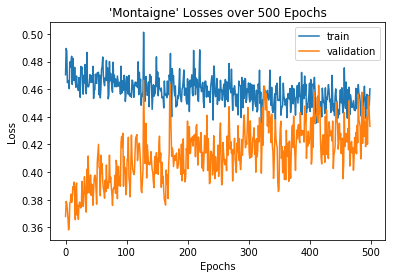

Average Training Score: 0.45873769488311383
Average Validation Score: 0.41297688925592435


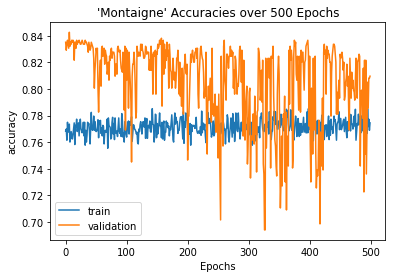

Average Training Score: 0.7715536959553696
Average Validation Score: 0.8065457271364319

validating on book: 'Dryden'
Epoch 0/499
----------



Phase:train
Confusion matrix:
 [[ 227  495]
 [ 101 1947]]
loss 1256.3814348578453



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 26.409796714782715
Epoch 1/499
----------



Phase:train
Confusion matrix:
 [[ 204  518]
 [  88 1960]]
loss 1273.9671659767628



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 28.134876251220703
Epoch 2/499
----------



Phase:train
Confusion matrix:
 [[ 195  527]
 [  71 1977]]
loss 1253.059710279107



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 26.73398208618164
Epoch 3/499
----------



Phase:train
Confusion matrix:
 [[ 211  511]
 [  69 1979]]
loss 1230.5503038614988



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 26.81056308746338
Epoch 4/499
----------



Phase:train
Confusion matrix:
 [[ 193  529]
 [  66 1982]]
loss 1247.7449163496494



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 26.23150634765625
Epoch 5/499
----------



Phase:train
Confusion matrix:
 [[ 206  516]
 [  66 1982]]
loss 1225.7407836914062



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 29.135212898254395
Epoch 6/499
----------



Phase:train
Confusion matrix:
 [[ 221  501]
 [  88 1960]]
loss 1213.19339543581



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 26.128060340881348
Epoch 7/499
----------



Phase:train
Confusion matrix:
 [[ 194  528]
 [  84 1964]]
loss 1336.4584788233042



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 28.36116886138916
Epoch 8/499
----------



Phase:train
Confusion matrix:
 [[ 207  515]
 [  69 1979]]
loss 1257.7339140623808



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 27.38953685760498
Epoch 9/499
----------



Phase:train
Confusion matrix:
 [[ 185  537]
 [  77 1971]]
loss 1250.6202320307493



Phase:val
Confusion matrix:
 [[20 19]
 [ 3  6]]
loss 26.85926342010498
Epoch 10/499
----------



Phase:train
Confusion matrix:
 [[ 197  525]
 [  72 1976]]
loss 1251.3821069598198



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 27.73728847503662
Epoch 11/499
----------



Phase:train
Confusion matrix:
 [[ 209  513]
 [  81 1967]]
loss 1251.2853087484837



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 29.653987884521484
Epoch 12/499
----------



Phase:train
Confusion matrix:
 [[ 180  542]
 [  62 1986]]
loss 1249.5817598998547



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 28.69079303741455
Epoch 13/499
----------



Phase:train
Confusion matrix:
 [[ 191  531]
 [  51 1997]]
loss 1256.6645819693804



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 29.020337104797363
Epoch 14/499
----------



Phase:train
Confusion matrix:
 [[ 218  504]
 [  78 1970]]
loss 1242.695364549756



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 29.25267505645752
Epoch 15/499
----------



Phase:train
Confusion matrix:
 [[ 214  508]
 [  81 1967]]
loss 1232.1822421103716



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 28.813350677490234
Epoch 16/499
----------



Phase:train
Confusion matrix:
 [[ 220  502]
 [  86 1962]]
loss 1200.8922652751207



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 28.650017738342285
Epoch 17/499
----------



Phase:train
Confusion matrix:
 [[ 228  494]
 [  92 1956]]
loss 1213.7288429439068



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 28.728515625
Epoch 18/499
----------



Phase:train
Confusion matrix:
 [[ 203  519]
 [  93 1955]]
loss 1240.8428317308426



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 27.74059295654297
Epoch 19/499
----------



Phase:train
Confusion matrix:
 [[ 212  510]
 [  88 1960]]
loss 1235.2713699638844



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 27.002254486083984
Epoch 20/499
----------



Phase:train
Confusion matrix:
 [[ 224  498]
 [  90 1958]]
loss 1220.3011300116777



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 28.755166053771973
Epoch 21/499
----------



Phase:train
Confusion matrix:
 [[ 189  533]
 [  66 1982]]
loss 1246.5669642984867



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 29.664095878601074
Epoch 22/499
----------



Phase:train
Confusion matrix:
 [[ 193  529]
 [  67 1981]]
loss 1241.884385585785



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 28.93777370452881
Epoch 23/499
----------



Phase:train
Confusion matrix:
 [[ 212  510]
 [  61 1987]]
loss 1230.0476950109005



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 27.497437477111816
Epoch 24/499
----------



Phase:train
Confusion matrix:
 [[ 206  516]
 [  68 1980]]
loss 1236.7851553112268



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 28.93803119659424
Epoch 25/499
----------



Phase:train
Confusion matrix:
 [[ 206  516]
 [  73 1975]]
loss 1244.630446895957



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 29.25003433227539
Epoch 26/499
----------



Phase:train
Confusion matrix:
 [[ 204  518]
 [  63 1985]]
loss 1257.0292339771986



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 29.084418296813965
Epoch 27/499
----------



Phase:train
Confusion matrix:
 [[ 204  518]
 [  78 1970]]
loss 1217.6466649919748



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 29.66890811920166
Epoch 28/499
----------



Phase:train
Confusion matrix:
 [[ 190  532]
 [  83 1965]]
loss 1258.4340121299028



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 29.72556209564209
Epoch 29/499
----------



Phase:train
Confusion matrix:
 [[ 189  533]
 [  68 1980]]
loss 1233.2088100463152



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 27.429814338684082
Epoch 30/499
----------



Phase:train
Confusion matrix:
 [[ 194  528]
 [  62 1986]]
loss 1221.4237356483936



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 30.237075805664062
Epoch 31/499
----------



Phase:train
Confusion matrix:
 [[ 232  490]
 [  91 1957]]
loss 1223.0754479169846



Phase:val
Confusion matrix:
 [[16 23]
 [ 3  6]]
loss 31.553990364074707
Epoch 32/499
----------



Phase:train
Confusion matrix:
 [[ 196  526]
 [  74 1974]]
loss 1225.5448143184185



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 28.807479858398438
Epoch 33/499
----------



Phase:train
Confusion matrix:
 [[ 193  529]
 [  80 1968]]
loss 1245.048417776823



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 29.999608039855957
Epoch 34/499
----------



Phase:train
Confusion matrix:
 [[ 204  518]
 [  62 1986]]
loss 1216.521797388792



Phase:val
Confusion matrix:
 [[16 23]
 [ 3  6]]
loss 29.850168228149414
Epoch 35/499
----------



Phase:train
Confusion matrix:
 [[ 203  519]
 [  68 1980]]
loss 1241.6945486664772



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 29.279308319091797
Epoch 36/499
----------



Phase:train
Confusion matrix:
 [[ 225  497]
 [  81 1967]]
loss 1212.551582828164



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 27.863422393798828
Epoch 37/499
----------



Phase:train
Confusion matrix:
 [[ 198  524]
 [  77 1971]]
loss 1255.5611672997475



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 29.260228157043457
Epoch 38/499
----------



Phase:train
Confusion matrix:
 [[ 187  535]
 [  49 1999]]
loss 1252.0581676214933



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 30.25363540649414
Epoch 39/499
----------



Phase:train
Confusion matrix:
 [[ 200  522]
 [  72 1976]]
loss 1234.8422823250294



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 28.438359260559082
Epoch 40/499
----------



Phase:train
Confusion matrix:
 [[ 225  497]
 [  66 1982]]
loss 1200.777739673853



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 28.49216365814209
Epoch 41/499
----------



Phase:train
Confusion matrix:
 [[ 193  529]
 [  80 1968]]
loss 1235.2948455810547



Phase:val
Confusion matrix:
 [[21 18]
 [ 3  6]]
loss 28.136961936950684
Epoch 42/499
----------



Phase:train
Confusion matrix:
 [[ 209  513]
 [  83 1965]]
loss 1238.9551375210285



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 28.005772590637207
Epoch 43/499
----------



Phase:train
Confusion matrix:
 [[ 182  540]
 [  72 1976]]
loss 1252.3912857621908



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 29.24006938934326
Epoch 44/499
----------



Phase:train
Confusion matrix:
 [[ 196  526]
 [  68 1980]]
loss 1247.1531192064285



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 28.26343059539795
Epoch 45/499
----------



Phase:train
Confusion matrix:
 [[ 181  541]
 [  59 1989]]
loss 1254.2507489472628



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 29.411490440368652
Epoch 46/499
----------



Phase:train
Confusion matrix:
 [[ 192  530]
 [  72 1976]]
loss 1235.4963048994541



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 26.762829780578613
Epoch 47/499
----------



Phase:train
Confusion matrix:
 [[ 238  484]
 [  86 1962]]
loss 1169.5041089653969



Phase:val
Confusion matrix:
 [[34  5]
 [ 4  5]]
loss 26.467686653137207
Epoch 48/499
----------



Phase:train
Confusion matrix:
 [[ 216  506]
 [  99 1949]]
loss 1240.7098710238934



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 27.33698558807373
Epoch 49/499
----------



Phase:train
Confusion matrix:
 [[ 212  510]
 [  71 1977]]
loss 1216.8981301039457



Phase:val
Confusion matrix:
 [[34  5]
 [ 3  6]]
loss 27.032017707824707
Epoch 50/499
----------



Phase:train
Confusion matrix:
 [[ 235  487]
 [  98 1950]]
loss 1236.449865758419



Phase:val
Confusion matrix:
 [[34  5]
 [ 4  5]]
loss 27.674099922180176
Epoch 51/499
----------



Phase:train
Confusion matrix:
 [[ 212  510]
 [  96 1952]]
loss 1305.0382150411606



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 27.699259757995605
Epoch 52/499
----------



Phase:train
Confusion matrix:
 [[ 198  524]
 [  78 1970]]
loss 1227.7391884624958



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 28.296727180480957
Epoch 53/499
----------



Phase:train
Confusion matrix:
 [[ 230  492]
 [ 113 1935]]
loss 1276.1440505981445



Phase:val
Confusion matrix:
 [[20 19]
 [ 3  6]]
loss 26.032811164855957
Epoch 54/499
----------



Phase:train
Confusion matrix:
 [[ 197  525]
 [  73 1975]]
loss 1257.8704988658428



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 29.220717430114746
Epoch 55/499
----------



Phase:train
Confusion matrix:
 [[ 203  519]
 [  72 1976]]
loss 1211.0124459564686



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 28.188191413879395
Epoch 56/499
----------



Phase:train
Confusion matrix:
 [[ 227  495]
 [  81 1967]]
loss 1250.340062662959



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 29.820181846618652
Epoch 57/499
----------



Phase:train
Confusion matrix:
 [[ 212  510]
 [  79 1969]]
loss 1200.2461586743593



Phase:val
Confusion matrix:
 [[30  9]
 [ 3  6]]
loss 29.36693286895752
Epoch 58/499
----------



Phase:train
Confusion matrix:
 [[ 228  494]
 [  96 1952]]
loss 1243.2513091564178



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 27.394457817077637
Epoch 59/499
----------



Phase:train
Confusion matrix:
 [[ 203  519]
 [  77 1971]]
loss 1256.3480861634016



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 27.469204902648926
Epoch 60/499
----------



Phase:train
Confusion matrix:
 [[ 210  512]
 [  84 1964]]
loss 1218.908183887601



Phase:val
Confusion matrix:
 [[34  5]
 [ 3  6]]
loss 26.697936058044434
Epoch 61/499
----------



Phase:train
Confusion matrix:
 [[ 242  480]
 [  91 1957]]
loss 1224.63059784472



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 27.870051383972168
Epoch 62/499
----------



Phase:train
Confusion matrix:
 [[ 225  497]
 [  86 1962]]
loss 1230.8236179798841



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 28.088407516479492
Epoch 63/499
----------



Phase:train
Confusion matrix:
 [[ 215  507]
 [  72 1976]]
loss 1230.6685928106308



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 29.169631004333496
Epoch 64/499
----------



Phase:train
Confusion matrix:
 [[ 218  504]
 [  74 1974]]
loss 1253.6143622398376



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 27.834528923034668
Epoch 65/499
----------



Phase:train
Confusion matrix:
 [[ 235  487]
 [  87 1961]]
loss 1207.7080875337124



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 28.147650718688965
Epoch 66/499
----------



Phase:train
Confusion matrix:
 [[ 205  517]
 [  88 1960]]
loss 1237.7602081596851



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 28.398076057434082
Epoch 67/499
----------



Phase:train
Confusion matrix:
 [[ 213  509]
 [  91 1957]]
loss 1225.1316928118467



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 27.894092559814453
Epoch 68/499
----------



Phase:train
Confusion matrix:
 [[ 211  511]
 [  88 1960]]
loss 1279.3904526978731



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 29.402323722839355
Epoch 69/499
----------



Phase:train
Confusion matrix:
 [[ 208  514]
 [  91 1957]]
loss 1251.8728631585836



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 28.83347797393799
Epoch 70/499
----------



Phase:train
Confusion matrix:
 [[ 232  490]
 [  88 1960]]
loss 1212.4078941196203



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 25.534629821777344
Epoch 71/499
----------



Phase:train
Confusion matrix:
 [[ 198  524]
 [  71 1977]]
loss 1240.5251443833113



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 28.31975269317627
Epoch 72/499
----------



Phase:train
Confusion matrix:
 [[ 198  524]
 [  81 1967]]
loss 1315.340585231781



Phase:val
Confusion matrix:
 [[16 23]
 [ 3  6]]
loss 30.494656562805176
Epoch 73/499
----------



Phase:train
Confusion matrix:
 [[ 182  540]
 [  69 1979]]
loss 1266.87592959404



Phase:val
Confusion matrix:
 [[14 25]
 [ 3  6]]
loss 30.550395011901855
Epoch 74/499
----------



Phase:train
Confusion matrix:
 [[ 185  537]
 [  71 1977]]
loss 1278.1173387169838



Phase:val
Confusion matrix:
 [[15 24]
 [ 3  6]]
loss 29.956841468811035
Epoch 75/499
----------



Phase:train
Confusion matrix:
 [[ 196  526]
 [  64 1984]]
loss 1227.2687007635832



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 27.373071670532227
Epoch 76/499
----------



Phase:train
Confusion matrix:
 [[ 209  513]
 [  72 1976]]
loss 1214.8023632466793



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 28.512880325317383
Epoch 77/499
----------



Phase:train
Confusion matrix:
 [[ 206  516]
 [  80 1968]]
loss 1258.7962751984596



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 30.114392280578613
Epoch 78/499
----------



Phase:train
Confusion matrix:
 [[ 190  532]
 [  61 1987]]
loss 1277.3387501090765



Phase:val
Confusion matrix:
 [[16 23]
 [ 3  6]]
loss 30.61373519897461
Epoch 79/499
----------



Phase:train
Confusion matrix:
 [[ 214  508]
 [  70 1978]]
loss 1252.7608525305986



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 29.25204849243164
Epoch 80/499
----------



Phase:train
Confusion matrix:
 [[ 223  499]
 [  78 1970]]
loss 1190.6184958964586



Phase:val
Confusion matrix:
 [[31  8]
 [ 4  5]]
loss 29.25296401977539
Epoch 81/499
----------



Phase:train
Confusion matrix:
 [[ 221  501]
 [  79 1969]]
loss 1208.273700505495



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 30.13828182220459
Epoch 82/499
----------



Phase:train
Confusion matrix:
 [[ 215  507]
 [  86 1962]]
loss 1191.613138616085



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 29.433259963989258
Epoch 83/499
----------



Phase:train
Confusion matrix:
 [[ 219  503]
 [  90 1958]]
loss 1236.1561144143343



Phase:val
Confusion matrix:
 [[20 19]
 [ 3  6]]
loss 26.730305671691895
Epoch 84/499
----------



Phase:train
Confusion matrix:
 [[ 220  502]
 [  84 1964]]
loss 1221.8128688633442



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 29.112359046936035
Epoch 85/499
----------



Phase:train
Confusion matrix:
 [[ 211  511]
 [  64 1984]]
loss 1222.2495147138834



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 29.126967430114746
Epoch 86/499
----------



Phase:train
Confusion matrix:
 [[ 191  531]
 [  75 1973]]
loss 1236.154191583395



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 29.90679931640625
Epoch 87/499
----------



Phase:train
Confusion matrix:
 [[ 206  516]
 [  63 1985]]
loss 1227.1860881447792



Phase:val
Confusion matrix:
 [[16 23]
 [ 3  6]]
loss 29.039374351501465
Epoch 88/499
----------



Phase:train
Confusion matrix:
 [[ 209  513]
 [  75 1973]]
loss 1202.1154183596373



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 28.6184663772583
Epoch 89/499
----------



Phase:train
Confusion matrix:
 [[ 191  531]
 [  69 1979]]
loss 1243.4182497262955



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 29.47719955444336
Epoch 90/499
----------



Phase:train
Confusion matrix:
 [[ 193  529]
 [  55 1993]]
loss 1239.4324063658714



Phase:val
Confusion matrix:
 [[16 23]
 [ 3  6]]
loss 30.93818950653076
Epoch 91/499
----------



Phase:train
Confusion matrix:
 [[ 217  505]
 [  68 1980]]
loss 1216.4613119363785



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 29.00731086730957
Epoch 92/499
----------



Phase:train
Confusion matrix:
 [[ 226  496]
 [  86 1962]]
loss 1246.3883048892021



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 28.563111305236816
Epoch 93/499
----------



Phase:train
Confusion matrix:
 [[ 211  511]
 [  94 1954]]
loss 1234.9189012944698



Phase:val
Confusion matrix:
 [[15 24]
 [ 3  6]]
loss 29.620224952697754
Epoch 94/499
----------



Phase:train
Confusion matrix:
 [[ 211  511]
 [  73 1975]]
loss 1194.4493302851915



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 26.366950035095215
Epoch 95/499
----------



Phase:train
Confusion matrix:
 [[ 227  495]
 [  96 1952]]
loss 1205.8214621543884



Phase:val
Confusion matrix:
 [[35  4]
 [ 3  6]]
loss 26.66652774810791
Epoch 96/499
----------



Phase:train
Confusion matrix:
 [[ 226  496]
 [ 102 1946]]
loss 1216.8724340349436



Phase:val
Confusion matrix:
 [[34  5]
 [ 4  5]]
loss 29.22389030456543
Epoch 97/499
----------



Phase:train
Confusion matrix:
 [[ 214  508]
 [  84 1964]]
loss 1251.1011925041676



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 29.217601776123047
Epoch 98/499
----------



Phase:train
Confusion matrix:
 [[ 238  484]
 [  74 1974]]
loss 1179.9410608708858



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 27.102084159851074
Epoch 99/499
----------



Phase:train
Confusion matrix:
 [[ 216  506]
 [  91 1957]]
loss 1219.988419920206



Phase:val
Confusion matrix:
 [[14 25]
 [ 3  6]]
loss 31.9325008392334
Epoch 100/499
----------



Phase:train
Confusion matrix:
 [[ 217  505]
 [  76 1972]]
loss 1285.0219469964504



Phase:val
Confusion matrix:
 [[16 23]
 [ 3  6]]
loss 30.43454074859619
Epoch 101/499
----------



Phase:train
Confusion matrix:
 [[ 200  522]
 [  72 1976]]
loss 1245.088577926159



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 28.44221591949463
Epoch 102/499
----------



Phase:train
Confusion matrix:
 [[ 200  522]
 [  70 1978]]
loss 1247.2026393711567



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 28.273306846618652
Epoch 103/499
----------



Phase:train
Confusion matrix:
 [[ 211  511]
 [  83 1965]]
loss 1211.0402338206768



Phase:val
Confusion matrix:
 [[36  3]
 [ 3  6]]
loss 26.67154312133789
Epoch 104/499
----------



Phase:train
Confusion matrix:
 [[ 188  534]
 [  77 1971]]
loss 1271.6043664962053



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 29.375338554382324
Epoch 105/499
----------



Phase:train
Confusion matrix:
 [[ 215  507]
 [  92 1956]]
loss 1214.4807616323233



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 28.14650058746338
Epoch 106/499
----------



Phase:train
Confusion matrix:
 [[ 206  516]
 [  73 1975]]
loss 1213.114173680544



Phase:val
Confusion matrix:
 [[20 19]
 [ 3  6]]
loss 26.53750991821289
Epoch 107/499
----------



Phase:train
Confusion matrix:
 [[ 212  510]
 [  89 1959]]
loss 1208.401544317603



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 27.59757900238037
Epoch 108/499
----------



Phase:train
Confusion matrix:
 [[ 172  550]
 [  58 1990]]
loss 1277.341614767909



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 28.330979347229004
Epoch 109/499
----------



Phase:train
Confusion matrix:
 [[ 202  520]
 [  77 1971]]
loss 1230.664266705513



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 28.029911041259766
Epoch 110/499
----------



Phase:train
Confusion matrix:
 [[ 211  511]
 [  85 1963]]
loss 1236.898505806923



Phase:val
Confusion matrix:
 [[20 19]
 [ 3  6]]
loss 27.241868019104004
Epoch 111/499
----------



Phase:train
Confusion matrix:
 [[ 201  521]
 [  70 1978]]
loss 1231.0719288885593



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 28.319449424743652
Epoch 112/499
----------



Phase:train
Confusion matrix:
 [[ 196  526]
 [  70 1978]]
loss 1254.7244504839182



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 28.602850914001465
Epoch 113/499
----------



Phase:train
Confusion matrix:
 [[ 198  524]
 [  67 1981]]
loss 1185.861135944724



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 27.468878746032715
Epoch 114/499
----------



Phase:train
Confusion matrix:
 [[ 222  500]
 [  85 1963]]
loss 1206.2365997731686



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 27.180227279663086
Epoch 115/499
----------



Phase:train
Confusion matrix:
 [[ 227  495]
 [  77 1971]]
loss 1211.638532370329



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 29.456554412841797
Epoch 116/499
----------



Phase:train
Confusion matrix:
 [[ 236  486]
 [  83 1965]]
loss 1199.2095016986132



Phase:val
Confusion matrix:
 [[36  3]
 [ 3  6]]
loss 25.741641998291016
Epoch 117/499
----------



Phase:train
Confusion matrix:
 [[ 200  522]
 [  76 1972]]
loss 1221.0638708472252



Phase:val
Confusion matrix:
 [[16 23]
 [ 3  6]]
loss 30.517659187316895
Epoch 118/499
----------



Phase:train
Confusion matrix:
 [[ 227  495]
 [  88 1960]]
loss 1218.9272921979427



Phase:val
Confusion matrix:
 [[16 23]
 [ 3  6]]
loss 28.389321327209473
Epoch 119/499
----------



Phase:train
Confusion matrix:
 [[ 199  523]
 [  69 1979]]
loss 1252.3803764879704



Phase:val
Confusion matrix:
 [[20 19]
 [ 3  6]]
loss 26.322501182556152
Epoch 120/499
----------



Phase:train
Confusion matrix:
 [[ 219  503]
 [  94 1954]]
loss 1218.6418616175652



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 28.422100067138672
Epoch 121/499
----------



Phase:train
Confusion matrix:
 [[ 186  536]
 [  65 1983]]
loss 1252.3518503308296



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 27.94148826599121
Epoch 122/499
----------



Phase:train
Confusion matrix:
 [[ 214  508]
 [  72 1976]]
loss 1215.0865077078342



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 26.91068744659424
Epoch 123/499
----------



Phase:train
Confusion matrix:
 [[ 226  496]
 [  78 1970]]
loss 1219.4416099786758



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 26.692362785339355
Epoch 124/499
----------



Phase:train
Confusion matrix:
 [[ 222  500]
 [  95 1953]]
loss 1197.4615390449762



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 26.94788646697998
Epoch 125/499
----------



Phase:train
Confusion matrix:
 [[ 216  506]
 [  91 1957]]
loss 1212.5709668844938



Phase:val
Confusion matrix:
 [[30  9]
 [ 3  6]]
loss 25.662955284118652
Epoch 126/499
----------



Phase:train
Confusion matrix:
 [[ 212  510]
 [  95 1953]]
loss 1216.940408527851



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 27.50903606414795
Epoch 127/499
----------



Phase:train
Confusion matrix:
 [[ 193  529]
 [  70 1978]]
loss 1246.4665540009737



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 30.268014907836914
Epoch 128/499
----------



Phase:train
Confusion matrix:
 [[ 211  511]
 [  63 1985]]
loss 1238.354854375124



Phase:val
Confusion matrix:
 [[26 13]
 [ 3  6]]
loss 31.236042022705078
Epoch 129/499
----------



Phase:train
Confusion matrix:
 [[ 205  517]
 [  85 1963]]
loss 1254.1965391486883



Phase:val
Confusion matrix:
 [[30  9]
 [ 3  6]]
loss 30.277539253234863
Epoch 130/499
----------



Phase:train
Confusion matrix:
 [[ 228  494]
 [  98 1950]]
loss 1254.9897027760744



Phase:val
Confusion matrix:
 [[15 24]
 [ 3  6]]
loss 29.975841522216797
Epoch 131/499
----------



Phase:train
Confusion matrix:
 [[ 202  520]
 [  79 1969]]
loss 1244.3360535651445



Phase:val
Confusion matrix:
 [[27 12]
 [ 3  6]]
loss 28.324170112609863
Epoch 132/499
----------



Phase:train
Confusion matrix:
 [[ 199  523]
 [  87 1961]]
loss 1288.7771359980106



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 28.87514019012451
Epoch 133/499
----------



Phase:train
Confusion matrix:
 [[ 173  549]
 [  56 1992]]
loss 1299.5940623134375



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 28.52640438079834
Epoch 134/499
----------



Phase:train
Confusion matrix:
 [[ 179  543]
 [  51 1997]]
loss 1241.8365824520588



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 27.296839714050293
Epoch 135/499
----------



Phase:train
Confusion matrix:
 [[ 239  483]
 [  88 1960]]
loss 1216.9084026813507



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 29.289430618286133
Epoch 136/499
----------



Phase:train
Confusion matrix:
 [[ 216  506]
 [  87 1961]]
loss 1257.2149586379528



Phase:val
Confusion matrix:
 [[16 23]
 [ 3  6]]
loss 29.07268524169922
Epoch 137/499
----------



Phase:train
Confusion matrix:
 [[ 203  519]
 [  73 1975]]
loss 1252.6317959427834



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 27.28025722503662
Epoch 138/499
----------



Phase:train
Confusion matrix:
 [[ 186  536]
 [  72 1976]]
loss 1287.019366517663



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 32.044097900390625
Epoch 139/499
----------



Phase:train
Confusion matrix:
 [[ 177  545]
 [  65 1983]]
loss 1254.6151021122932



Phase:val
Confusion matrix:
 [[14 25]
 [ 3  6]]
loss 31.69105625152588
Epoch 140/499
----------



Phase:train
Confusion matrix:
 [[ 200  522]
 [  71 1977]]
loss 1215.4193118810654



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 28.901352882385254
Epoch 141/499
----------



Phase:train
Confusion matrix:
 [[ 236  486]
 [ 125 1923]]
loss 1225.4346754997969



Phase:val
Confusion matrix:
 [[20 19]
 [ 3  6]]
loss 27.44765567779541
Epoch 142/499
----------



Phase:train
Confusion matrix:
 [[ 222  500]
 [  73 1975]]
loss 1209.0573354661465



Phase:val
Confusion matrix:
 [[34  5]
 [ 3  6]]
loss 29.276638984680176
Epoch 143/499
----------



Phase:train
Confusion matrix:
 [[ 233  489]
 [ 123 1925]]
loss 1220.71285392344



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 30.238483428955078
Epoch 144/499
----------



Phase:train
Confusion matrix:
 [[ 199  523]
 [  74 1974]]
loss 1234.9535270184278



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 30.73857021331787
Epoch 145/499
----------



Phase:train
Confusion matrix:
 [[ 201  521]
 [  80 1968]]
loss 1216.9809938818216



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 31.053966522216797
Epoch 146/499
----------



Phase:train
Confusion matrix:
 [[ 220  502]
 [  66 1982]]
loss 1161.400834709406



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 28.144423484802246
Epoch 147/499
----------



Phase:train
Confusion matrix:
 [[ 216  506]
 [ 104 1944]]
loss 1222.6745729595423



Phase:val
Confusion matrix:
 [[17 22]
 [ 2  7]]
loss 30.445155143737793
Epoch 148/499
----------



Phase:train
Confusion matrix:
 [[ 204  518]
 [  75 1973]]
loss 1232.1004781872034



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 29.5997371673584
Epoch 149/499
----------



Phase:train
Confusion matrix:
 [[ 205  517]
 [  73 1975]]
loss 1251.6444804668427



Phase:val
Confusion matrix:
 [[15 24]
 [ 3  6]]
loss 30.860730171203613
Epoch 150/499
----------



Phase:train
Confusion matrix:
 [[ 209  513]
 [  79 1969]]
loss 1246.8683324158192



Phase:val
Confusion matrix:
 [[15 24]
 [ 3  6]]
loss 29.167410850524902
Epoch 151/499
----------



Phase:train
Confusion matrix:
 [[ 237  485]
 [  75 1973]]
loss 1230.6729362607002



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 28.58114719390869
Epoch 152/499
----------



Phase:train
Confusion matrix:
 [[ 200  522]
 [  73 1975]]
loss 1238.1669839024544



Phase:val
Confusion matrix:
 [[14 25]
 [ 3  6]]
loss 32.469855308532715
Epoch 153/499
----------



Phase:train
Confusion matrix:
 [[ 211  511]
 [  79 1969]]
loss 1249.4609200060368



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 29.493541717529297
Epoch 154/499
----------



Phase:train
Confusion matrix:
 [[ 210  512]
 [  75 1973]]
loss 1233.7400033175945



Phase:val
Confusion matrix:
 [[16 23]
 [ 3  6]]
loss 29.63529396057129
Epoch 155/499
----------



Phase:train
Confusion matrix:
 [[ 207  515]
 [  72 1976]]
loss 1200.3000766336918



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 27.46259593963623
Epoch 156/499
----------



Phase:train
Confusion matrix:
 [[ 206  516]
 [  73 1975]]
loss 1214.1073264628649



Phase:val
Confusion matrix:
 [[19 20]
 [ 2  7]]
loss 28.105387687683105
Epoch 157/499
----------



Phase:train
Confusion matrix:
 [[ 213  509]
 [  91 1957]]
loss 1235.6835309565067



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 28.731545448303223
Epoch 158/499
----------



Phase:train
Confusion matrix:
 [[ 187  535]
 [  76 1972]]
loss 1248.7480832785368



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 29.180703163146973
Epoch 159/499
----------



Phase:train
Confusion matrix:
 [[ 202  520]
 [  57 1991]]
loss 1219.0425896644592



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 28.84683322906494
Epoch 160/499
----------



Phase:train
Confusion matrix:
 [[ 228  494]
 [  79 1969]]
loss 1230.112270474434



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 28.429512977600098
Epoch 161/499
----------



Phase:train
Confusion matrix:
 [[ 223  499]
 [  93 1955]]
loss 1197.1166108995676



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 29.38626194000244
Epoch 162/499
----------



Phase:train
Confusion matrix:
 [[ 225  497]
 [  81 1967]]
loss 1225.8199188113213



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 31.30331325531006
Epoch 163/499
----------



Phase:train
Confusion matrix:
 [[ 198  524]
 [  78 1970]]
loss 1211.824024617672



Phase:val
Confusion matrix:
 [[16 23]
 [ 3  6]]
loss 30.012173652648926
Epoch 164/499
----------



Phase:train
Confusion matrix:
 [[ 219  503]
 [  91 1957]]
loss 1196.9861246794462



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 28.020549774169922
Epoch 165/499
----------



Phase:train
Confusion matrix:
 [[ 227  495]
 [  89 1959]]
loss 1238.2614587396383



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 29.851990699768066
Epoch 166/499
----------



Phase:train
Confusion matrix:
 [[ 235  487]
 [ 101 1947]]
loss 1212.6937136501074



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 28.651408195495605
Epoch 167/499
----------



Phase:train
Confusion matrix:
 [[ 241  481]
 [ 103 1945]]
loss 1196.4354330897331



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 30.416722297668457
Epoch 168/499
----------



Phase:train
Confusion matrix:
 [[ 204  518]
 [  81 1967]]
loss 1225.099638029933



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 29.831259727478027
Epoch 169/499
----------



Phase:train
Confusion matrix:
 [[ 215  507]
 [  86 1962]]
loss 1250.0561753213406



Phase:val
Confusion matrix:
 [[16 23]
 [ 3  6]]
loss 30.5368595123291
Epoch 170/499
----------



Phase:train
Confusion matrix:
 [[ 209  513]
 [  77 1971]]
loss 1234.8156508803368



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 29.710970878601074
Epoch 171/499
----------



Phase:train
Confusion matrix:
 [[ 214  508]
 [  87 1961]]
loss 1232.771056175232



Phase:val
Confusion matrix:
 [[30  9]
 [ 3  6]]
loss 27.66393756866455
Epoch 172/499
----------



Phase:train
Confusion matrix:
 [[ 208  514]
 [  74 1974]]
loss 1224.0810090899467



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 28.42048931121826
Epoch 173/499
----------



Phase:train
Confusion matrix:
 [[ 254  468]
 [  84 1964]]
loss 1169.0330048650503



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 28.93867778778076
Epoch 174/499
----------



Phase:train
Confusion matrix:
 [[ 244  478]
 [ 102 1946]]
loss 1204.7931516319513



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 28.784937858581543
Epoch 175/499
----------



Phase:train
Confusion matrix:
 [[ 214  508]
 [  82 1966]]
loss 1213.79996702075



Phase:val
Confusion matrix:
 [[29 10]
 [ 3  6]]
loss 29.92361354827881
Epoch 176/499
----------



Phase:train
Confusion matrix:
 [[ 212  510]
 [  77 1971]]
loss 1219.4214047938585



Phase:val
Confusion matrix:
 [[30  9]
 [ 3  6]]
loss 31.757131576538086
Epoch 177/499
----------



Phase:train
Confusion matrix:
 [[ 236  486]
 [  93 1955]]
loss 1235.29767473042



Phase:val
Confusion matrix:
 [[30  9]
 [ 3  6]]
loss 29.6619873046875
Epoch 178/499
----------



Phase:train
Confusion matrix:
 [[ 214  508]
 [  89 1959]]
loss 1227.2649593800306



Phase:val
Confusion matrix:
 [[29 10]
 [ 3  6]]
loss 29.061970710754395
Epoch 179/499
----------



Phase:train
Confusion matrix:
 [[ 238  484]
 [  96 1952]]
loss 1238.9524650126696



Phase:val
Confusion matrix:
 [[35  4]
 [ 3  6]]
loss 26.418113708496094
Epoch 180/499
----------



Phase:train
Confusion matrix:
 [[ 219  503]
 [  85 1963]]
loss 1225.5787529349327



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 27.681364059448242
Epoch 181/499
----------



Phase:train
Confusion matrix:
 [[ 215  507]
 [  86 1962]]
loss 1249.9107254594564



Phase:val
Confusion matrix:
 [[32  7]
 [ 4  5]]
loss 27.661422729492188
Epoch 182/499
----------



Phase:train
Confusion matrix:
 [[ 220  502]
 [  76 1972]]
loss 1234.7209594249725



Phase:val
Confusion matrix:
 [[34  5]
 [ 3  6]]
loss 26.654391288757324
Epoch 183/499
----------



Phase:train
Confusion matrix:
 [[ 222  500]
 [  85 1963]]
loss 1220.484626710415



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 27.25528049468994
Epoch 184/499
----------



Phase:train
Confusion matrix:
 [[ 211  511]
 [  80 1968]]
loss 1227.5132676512003



Phase:val
Confusion matrix:
 [[34  5]
 [ 3  6]]
loss 26.57559585571289
Epoch 185/499
----------



Phase:train
Confusion matrix:
 [[ 241  481]
 [ 105 1943]]
loss 1217.7163960635662



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 27.13571262359619
Epoch 186/499
----------



Phase:train
Confusion matrix:
 [[ 229  493]
 [  90 1958]]
loss 1234.9386567473412



Phase:val
Confusion matrix:
 [[34  5]
 [ 3  6]]
loss 26.300926208496094
Epoch 187/499
----------



Phase:train
Confusion matrix:
 [[ 229  493]
 [ 100 1948]]
loss 1222.2787121087313



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 28.846604347229004
Epoch 188/499
----------



Phase:train
Confusion matrix:
 [[ 228  494]
 [  71 1977]]
loss 1261.7272360771894



Phase:val
Confusion matrix:
 [[28 11]
 [ 3  6]]
loss 28.579547882080078
Epoch 189/499
----------



Phase:train
Confusion matrix:
 [[ 189  533]
 [  63 1985]]
loss 1240.58578081429



Phase:val
Confusion matrix:
 [[23 16]
 [ 3  6]]
loss 28.145516395568848
Epoch 190/499
----------



Phase:train
Confusion matrix:
 [[ 203  519]
 [  62 1986]]
loss 1255.2553908526897



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 29.934731483459473
Epoch 191/499
----------



Phase:train
Confusion matrix:
 [[ 210  512]
 [  71 1977]]
loss 1210.8498511612415



Phase:val
Confusion matrix:
 [[29 10]
 [ 3  6]]
loss 27.54792881011963
Epoch 192/499
----------



Phase:train
Confusion matrix:
 [[ 226  496]
 [  89 1959]]
loss 1236.0479123741388



Phase:val
Confusion matrix:
 [[32  7]
 [ 4  5]]
loss 28.125758171081543
Epoch 193/499
----------



Phase:train
Confusion matrix:
 [[ 217  505]
 [  90 1958]]
loss 1239.0881129205227



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 26.782130241394043
Epoch 194/499
----------



Phase:train
Confusion matrix:
 [[ 201  521]
 [  80 1968]]
loss 1225.0641188770533



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 28.581436157226562
Epoch 195/499
----------



Phase:train
Confusion matrix:
 [[ 216  506]
 [  86 1962]]
loss 1221.1765450835228



Phase:val
Confusion matrix:
 [[29 10]
 [ 3  6]]
loss 27.853139877319336
Epoch 196/499
----------



Phase:train
Confusion matrix:
 [[ 206  516]
 [  75 1973]]
loss 1229.4544396996498



Phase:val
Confusion matrix:
 [[35  4]
 [ 3  6]]
loss 25.40379524230957
Epoch 197/499
----------



Phase:train
Confusion matrix:
 [[ 242  480]
 [  99 1949]]
loss 1200.9956242740154



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 28.32389259338379
Epoch 198/499
----------



Phase:train
Confusion matrix:
 [[ 237  485]
 [ 115 1933]]
loss 1210.3101007789373



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 27.568665504455566
Epoch 199/499
----------



Phase:train
Confusion matrix:
 [[ 221  501]
 [  78 1970]]
loss 1207.136797040701



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 27.836474418640137
Epoch 200/499
----------



Phase:train
Confusion matrix:
 [[ 249  473]
 [  98 1950]]
loss 1205.1070848107338



Phase:val
Confusion matrix:
 [[35  4]
 [ 3  6]]
loss 25.36940860748291
Epoch 201/499
----------



Phase:train
Confusion matrix:
 [[ 215  507]
 [  82 1966]]
loss 1272.0087218433619



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 28.42101001739502
Epoch 202/499
----------



Phase:train
Confusion matrix:
 [[ 199  523]
 [  64 1984]]
loss 1200.9225538372993



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 27.663073539733887
Epoch 203/499
----------



Phase:train
Confusion matrix:
 [[ 205  517]
 [  69 1979]]
loss 1218.5221867859364



Phase:val
Confusion matrix:
 [[30  9]
 [ 3  6]]
loss 26.76551055908203
Epoch 204/499
----------



Phase:train
Confusion matrix:
 [[ 216  506]
 [  88 1960]]
loss 1239.7598619163036



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 25.37919330596924
Epoch 205/499
----------



Phase:train
Confusion matrix:
 [[ 220  502]
 [  86 1962]]
loss 1225.682627916336



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 26.542147636413574
Epoch 206/499
----------



Phase:train
Confusion matrix:
 [[ 215  507]
 [  93 1955]]
loss 1213.138672709465



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 29.632095336914062
Epoch 207/499
----------



Phase:train
Confusion matrix:
 [[ 227  495]
 [  85 1963]]
loss 1207.6151979416609



Phase:val
Confusion matrix:
 [[16 23]
 [ 3  6]]
loss 30.089223861694336
Epoch 208/499
----------



Phase:train
Confusion matrix:
 [[ 228  494]
 [  88 1960]]
loss 1222.210793197155



Phase:val
Confusion matrix:
 [[34  5]
 [ 3  6]]
loss 29.101186752319336
Epoch 209/499
----------



Phase:train
Confusion matrix:
 [[ 200  522]
 [  77 1971]]
loss 1234.462896823883



Phase:val
Confusion matrix:
 [[30  9]
 [ 3  6]]
loss 30.15369415283203
Epoch 210/499
----------



Phase:train
Confusion matrix:
 [[ 251  471]
 [ 101 1947]]
loss 1224.1148738265038



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 29.352839469909668
Epoch 211/499
----------



Phase:train
Confusion matrix:
 [[ 208  514]
 [  93 1955]]
loss 1237.0796375274658



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 28.001418113708496
Epoch 212/499
----------



Phase:train
Confusion matrix:
 [[ 237  485]
 [ 102 1946]]
loss 1239.754364848137



Phase:val
Confusion matrix:
 [[35  4]
 [ 4  5]]
loss 25.74785614013672
Epoch 213/499
----------



Phase:train
Confusion matrix:
 [[ 193  529]
 [  82 1966]]
loss 1245.4353887736797



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 26.417750358581543
Epoch 214/499
----------



Phase:train
Confusion matrix:
 [[ 217  505]
 [  80 1968]]
loss 1202.4475964307785



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 27.85971164703369
Epoch 215/499
----------



Phase:train
Confusion matrix:
 [[ 226  496]
 [  75 1973]]
loss 1220.6061101555824



Phase:val
Confusion matrix:
 [[33  6]
 [ 4  5]]
loss 26.66480827331543
Epoch 216/499
----------



Phase:train
Confusion matrix:
 [[ 261  461]
 [ 115 1933]]
loss 1184.7870384901762



Phase:val
Confusion matrix:
 [[35  4]
 [ 5  4]]
loss 25.549464225769043
Epoch 217/499
----------



Phase:train
Confusion matrix:
 [[ 234  488]
 [ 112 1936]]
loss 1241.6506984978914



Phase:val
Confusion matrix:
 [[31  8]
 [ 4  5]]
loss 26.855692863464355
Epoch 218/499
----------



Phase:train
Confusion matrix:
 [[ 223  499]
 [  93 1955]]
loss 1208.381467178464



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 27.143712043762207
Epoch 219/499
----------



Phase:train
Confusion matrix:
 [[ 217  505]
 [  83 1965]]
loss 1190.898826688528



Phase:val
Confusion matrix:
 [[30  9]
 [ 3  6]]
loss 28.798333168029785
Epoch 220/499
----------



Phase:train
Confusion matrix:
 [[ 209  513]
 [  85 1963]]
loss 1218.714322566986



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 28.234622955322266
Epoch 221/499
----------



Phase:train
Confusion matrix:
 [[ 227  495]
 [  76 1972]]
loss 1229.53483787179



Phase:val
Confusion matrix:
 [[29 10]
 [ 3  6]]
loss 29.361313819885254
Epoch 222/499
----------



Phase:train
Confusion matrix:
 [[ 234  488]
 [  88 1960]]
loss 1215.7100829482079



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 27.0617036819458
Epoch 223/499
----------



Phase:train
Confusion matrix:
 [[ 244  478]
 [ 109 1939]]
loss 1194.9341846555471



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 27.452682495117188
Epoch 224/499
----------



Phase:train
Confusion matrix:
 [[ 234  488]
 [  83 1965]]
loss 1233.5459864884615



Phase:val
Confusion matrix:
 [[24 15]
 [ 3  6]]
loss 32.70912551879883
Epoch 225/499
----------



Phase:train
Confusion matrix:
 [[ 234  488]
 [  82 1966]]
loss 1200.3128700256348



Phase:val
Confusion matrix:
 [[28 11]
 [ 3  6]]
loss 30.797175407409668
Epoch 226/499
----------



Phase:train
Confusion matrix:
 [[ 245  477]
 [ 107 1941]]
loss 1249.6534988582134



Phase:val
Confusion matrix:
 [[31  8]
 [ 4  5]]
loss 28.25244140625
Epoch 227/499
----------



Phase:train
Confusion matrix:
 [[ 245  477]
 [  94 1954]]
loss 1217.6948699951172



Phase:val
Confusion matrix:
 [[30  9]
 [ 4  5]]
loss 29.87031841278076
Epoch 228/499
----------



Phase:train
Confusion matrix:
 [[ 208  514]
 [  85 1963]]
loss 1237.0269352793694



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 26.822882652282715
Epoch 229/499
----------



Phase:train
Confusion matrix:
 [[ 211  511]
 [  82 1966]]
loss 1247.9302263855934



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 29.401805877685547
Epoch 230/499
----------



Phase:train
Confusion matrix:
 [[ 219  503]
 [  99 1949]]
loss 1222.999840632081



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 27.800273895263672
Epoch 231/499
----------



Phase:train
Confusion matrix:
 [[ 240  482]
 [ 103 1945]]
loss 1209.2182250022888



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 27.21804141998291
Epoch 232/499
----------



Phase:train
Confusion matrix:
 [[ 220  502]
 [ 104 1944]]
loss 1239.8057514429092



Phase:val
Confusion matrix:
 [[13 26]
 [ 3  6]]
loss 31.795838356018066
Epoch 233/499
----------



Phase:train
Confusion matrix:
 [[ 200  522]
 [  56 1992]]
loss 1192.2306179851294



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 29.00434398651123
Epoch 234/499
----------



Phase:train
Confusion matrix:
 [[ 245  477]
 [  99 1949]]
loss 1206.9371611177921



Phase:val
Confusion matrix:
 [[34  5]
 [ 4  5]]
loss 28.630502700805664
Epoch 235/499
----------



Phase:train
Confusion matrix:
 [[ 217  505]
 [  69 1979]]
loss 1228.3208348304033



Phase:val
Confusion matrix:
 [[30  9]
 [ 3  6]]
loss 30.602442741394043
Epoch 236/499
----------



Phase:train
Confusion matrix:
 [[ 207  515]
 [  76 1972]]
loss 1229.622364655137



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 30.18130874633789
Epoch 237/499
----------



Phase:train
Confusion matrix:
 [[ 240  482]
 [  83 1965]]
loss 1191.8951313048601



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 28.924389839172363
Epoch 238/499
----------



Phase:train
Confusion matrix:
 [[ 268  454]
 [ 119 1929]]
loss 1196.715244024992



Phase:val
Confusion matrix:
 [[30  9]
 [ 4  5]]
loss 30.52045726776123
Epoch 239/499
----------



Phase:train
Confusion matrix:
 [[ 244  478]
 [ 121 1927]]
loss 1213.0288263559341



Phase:val
Confusion matrix:
 [[32  7]
 [ 4  5]]
loss 27.0327787399292
Epoch 240/499
----------



Phase:train
Confusion matrix:
 [[ 223  499]
 [  75 1973]]
loss 1244.3281042128801



Phase:val
Confusion matrix:
 [[30  9]
 [ 3  6]]
loss 28.135811805725098
Epoch 241/499
----------



Phase:train
Confusion matrix:
 [[ 238  484]
 [ 112 1936]]
loss 1229.948555022478



Phase:val
Confusion matrix:
 [[33  6]
 [ 4  5]]
loss 27.046337127685547
Epoch 242/499
----------



Phase:train
Confusion matrix:
 [[ 229  493]
 [  98 1950]]
loss 1222.5842254981399



Phase:val
Confusion matrix:
 [[34  5]
 [ 3  6]]
loss 26.305240631103516
Epoch 243/499
----------



Phase:train
Confusion matrix:
 [[ 227  495]
 [  96 1952]]
loss 1207.478176087141



Phase:val
Confusion matrix:
 [[29 10]
 [ 3  6]]
loss 28.641955375671387
Epoch 244/499
----------



Phase:train
Confusion matrix:
 [[ 219  503]
 [  82 1966]]
loss 1186.1432473510504



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 28.70760440826416
Epoch 245/499
----------



Phase:train
Confusion matrix:
 [[ 248  474]
 [  91 1957]]
loss 1228.9115296006203



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 27.659448623657227
Epoch 246/499
----------



Phase:train
Confusion matrix:
 [[ 237  485]
 [ 106 1942]]
loss 1219.3091828674078



Phase:val
Confusion matrix:
 [[30  9]
 [ 3  6]]
loss 31.116934776306152
Epoch 247/499
----------



Phase:train
Confusion matrix:
 [[ 225  497]
 [  94 1954]]
loss 1229.7279997169971



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 27.766722679138184
Epoch 248/499
----------



Phase:train
Confusion matrix:
 [[ 220  502]
 [ 107 1941]]
loss 1222.4839401990175



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 27.807832717895508
Epoch 249/499
----------



Phase:train
Confusion matrix:
 [[ 231  491]
 [  90 1958]]
loss 1209.521913409233



Phase:val
Confusion matrix:
 [[34  5]
 [ 3  6]]
loss 26.578725814819336
Epoch 250/499
----------



Phase:train
Confusion matrix:
 [[ 220  502]
 [  92 1956]]
loss 1214.2485355138779



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 28.48304271697998
Epoch 251/499
----------



Phase:train
Confusion matrix:
 [[ 233  489]
 [  92 1956]]
loss 1183.526112601161



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 29.784805297851562
Epoch 252/499
----------



Phase:train
Confusion matrix:
 [[ 221  501]
 [  83 1965]]
loss 1240.0038513690233



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 27.896804809570312
Epoch 253/499
----------



Phase:train
Confusion matrix:
 [[ 233  489]
 [  90 1958]]
loss 1192.0213041007519



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 26.727184295654297
Epoch 254/499
----------



Phase:train
Confusion matrix:
 [[ 229  493]
 [ 102 1946]]
loss 1236.6371986865997



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 27.689051628112793
Epoch 255/499
----------



Phase:train
Confusion matrix:
 [[ 189  533]
 [  80 1968]]
loss 1260.848916888237



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 29.156550407409668
Epoch 256/499
----------



Phase:train
Confusion matrix:
 [[ 226  496]
 [  88 1960]]
loss 1215.2802036106586



Phase:val
Confusion matrix:
 [[34  5]
 [ 3  6]]
loss 26.568114280700684
Epoch 257/499
----------



Phase:train
Confusion matrix:
 [[ 214  508]
 [  84 1964]]
loss 1219.9673602432013



Phase:val
Confusion matrix:
 [[30  9]
 [ 3  6]]
loss 29.662407875061035
Epoch 258/499
----------



Phase:train
Confusion matrix:
 [[ 229  493]
 [  79 1969]]
loss 1224.1460028588772



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 27.50138282775879
Epoch 259/499
----------



Phase:train
Confusion matrix:
 [[ 240  482]
 [  89 1959]]
loss 1215.5706649422646



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 28.484098434448242
Epoch 260/499
----------



Phase:train
Confusion matrix:
 [[ 200  522]
 [  78 1970]]
loss 1250.568738013506



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 29.38322639465332
Epoch 261/499
----------



Phase:train
Confusion matrix:
 [[ 217  505]
 [  99 1949]]
loss 1224.8891704827547



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 29.34956645965576
Epoch 262/499
----------



Phase:train
Confusion matrix:
 [[ 206  516]
 [  74 1974]]
loss 1200.2119861245155



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 28.61158275604248
Epoch 263/499
----------



Phase:train
Confusion matrix:
 [[ 224  498]
 [ 104 1944]]
loss 1274.6080436110497



Phase:val
Confusion matrix:
 [[16 23]
 [ 2  7]]
loss 31.586288452148438
Epoch 264/499
----------



Phase:train
Confusion matrix:
 [[ 182  540]
 [  63 1985]]
loss 1236.6525944769382



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 30.64790153503418
Epoch 265/499
----------



Phase:train
Confusion matrix:
 [[ 215  507]
 [  77 1971]]
loss 1263.7046681046486



Phase:val
Confusion matrix:
 [[16 23]
 [ 3  6]]
loss 30.347989082336426
Epoch 266/499
----------



Phase:train
Confusion matrix:
 [[ 191  531]
 [  66 1982]]
loss 1241.8515790700912



Phase:val
Confusion matrix:
 [[16 23]
 [ 3  6]]
loss 30.95958137512207
Epoch 267/499
----------



Phase:train
Confusion matrix:
 [[ 219  503]
 [  71 1977]]
loss 1228.898863017559



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 31.975296020507812
Epoch 268/499
----------



Phase:train
Confusion matrix:
 [[ 205  517]
 [  70 1978]]
loss 1220.1070936322212



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 32.23513126373291
Epoch 269/499
----------



Phase:train
Confusion matrix:
 [[ 209  513]
 [  94 1954]]
loss 1251.9700763523579



Phase:val
Confusion matrix:
 [[16 23]
 [ 3  6]]
loss 31.45023536682129
Epoch 270/499
----------



Phase:train
Confusion matrix:
 [[ 210  512]
 [  67 1981]]
loss 1222.5794389247894



Phase:val
Confusion matrix:
 [[29 10]
 [ 3  6]]
loss 31.49845790863037
Epoch 271/499
----------



Phase:train
Confusion matrix:
 [[ 236  486]
 [  91 1957]]
loss 1206.6554296761751



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 27.80895709991455
Epoch 272/499
----------



Phase:train
Confusion matrix:
 [[ 237  485]
 [ 110 1938]]
loss 1236.6381381452084



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 29.857518196105957
Epoch 273/499
----------



Phase:train
Confusion matrix:
 [[ 204  518]
 [  88 1960]]
loss 1212.1486425846815



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 29.342997550964355
Epoch 274/499
----------



Phase:train
Confusion matrix:
 [[ 212  510]
 [  75 1973]]
loss 1222.8556899130344



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 29.30232810974121
Epoch 275/499
----------



Phase:train
Confusion matrix:
 [[ 216  506]
 [  91 1957]]
loss 1185.9240934103727



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 28.775450706481934
Epoch 276/499
----------



Phase:train
Confusion matrix:
 [[ 244  478]
 [ 108 1940]]
loss 1170.5427134409547



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 29.34041976928711
Epoch 277/499
----------



Phase:train
Confusion matrix:
 [[ 214  508]
 [  96 1952]]
loss 1210.5629769712687



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 30.66866970062256
Epoch 278/499
----------



Phase:train
Confusion matrix:
 [[ 210  512]
 [  87 1961]]
loss 1253.6500631123781



Phase:val
Confusion matrix:
 [[16 23]
 [ 2  7]]
loss 30.857714653015137
Epoch 279/499
----------



Phase:train
Confusion matrix:
 [[ 205  517]
 [  85 1963]]
loss 1245.5985801517963



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 28.442336082458496
Epoch 280/499
----------



Phase:train
Confusion matrix:
 [[ 227  495]
 [  85 1963]]
loss 1240.2985708117485



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 27.736252784729004
Epoch 281/499
----------



Phase:train
Confusion matrix:
 [[ 208  514]
 [  81 1967]]
loss 1249.5613984763622



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 26.965267181396484
Epoch 282/499
----------



Phase:train
Confusion matrix:
 [[ 227  495]
 [  86 1962]]
loss 1220.6037416756153



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 27.03091049194336
Epoch 283/499
----------



Phase:train
Confusion matrix:
 [[ 230  492]
 [  90 1958]]
loss 1228.6538808345795



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 26.88544750213623
Epoch 284/499
----------



Phase:train
Confusion matrix:
 [[ 216  506]
 [  84 1964]]
loss 1218.5422102361917



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 27.56473445892334
Epoch 285/499
----------



Phase:train
Confusion matrix:
 [[ 218  504]
 [  89 1959]]
loss 1231.2998509854078



Phase:val
Confusion matrix:
 [[34  5]
 [ 4  5]]
loss 26.959038734436035
Epoch 286/499
----------



Phase:train
Confusion matrix:
 [[ 257  465]
 [  99 1949]]
loss 1214.2135716974735



Phase:val
Confusion matrix:
 [[33  6]
 [ 4  5]]
loss 27.71516704559326
Epoch 287/499
----------



Phase:train
Confusion matrix:
 [[ 226  496]
 [  99 1949]]
loss 1218.867691218853



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 28.352042198181152
Epoch 288/499
----------



Phase:train
Confusion matrix:
 [[ 222  500]
 [  93 1955]]
loss 1195.0196125507355



Phase:val
Confusion matrix:
 [[34  5]
 [ 4  5]]
loss 27.1446590423584
Epoch 289/499
----------



Phase:train
Confusion matrix:
 [[ 225  497]
 [  99 1949]]
loss 1233.7234393507242



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 30.6795015335083
Epoch 290/499
----------



Phase:train
Confusion matrix:
 [[ 208  514]
 [  82 1966]]
loss 1210.4298023581505



Phase:val
Confusion matrix:
 [[34  5]
 [ 3  6]]
loss 26.574491500854492
Epoch 291/499
----------



Phase:train
Confusion matrix:
 [[ 240  482]
 [ 100 1948]]
loss 1247.0641368627548



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 28.426400184631348
Epoch 292/499
----------



Phase:train
Confusion matrix:
 [[ 209  513]
 [  76 1972]]
loss 1240.4965369403362



Phase:val
Confusion matrix:
 [[28 11]
 [ 3  6]]
loss 31.339908599853516
Epoch 293/499
----------



Phase:train
Confusion matrix:
 [[ 224  498]
 [  82 1966]]
loss 1215.4704844653606



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 27.769432067871094
Epoch 294/499
----------



Phase:train
Confusion matrix:
 [[ 236  486]
 [  80 1968]]
loss 1217.0819166749716



Phase:val
Confusion matrix:
 [[30  9]
 [ 3  6]]
loss 30.51870346069336
Epoch 295/499
----------



Phase:train
Confusion matrix:
 [[ 230  492]
 [  90 1958]]
loss 1198.463229700923



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 29.14859962463379
Epoch 296/499
----------



Phase:train
Confusion matrix:
 [[ 256  466]
 [ 131 1917]]
loss 1195.8642203509808



Phase:val
Confusion matrix:
 [[33  6]
 [ 4  5]]
loss 27.36680316925049
Epoch 297/499
----------



Phase:train
Confusion matrix:
 [[ 220  502]
 [  83 1965]]
loss 1215.0370494127274



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 27.73293972015381
Epoch 298/499
----------



Phase:train
Confusion matrix:
 [[ 219  503]
 [  66 1982]]
loss 1199.8979741185904



Phase:val
Confusion matrix:
 [[17 22]
 [ 2  7]]
loss 26.72288990020752
Epoch 299/499
----------



Phase:train
Confusion matrix:
 [[ 237  485]
 [  79 1969]]
loss 1154.7338875234127



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 26.23875904083252
Epoch 300/499
----------



Phase:train
Confusion matrix:
 [[ 238  484]
 [  93 1955]]
loss 1230.9794163554907



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 26.942885398864746
Epoch 301/499
----------



Phase:train
Confusion matrix:
 [[ 210  512]
 [  84 1964]]
loss 1231.1052055954933



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 27.871424674987793
Epoch 302/499
----------



Phase:train
Confusion matrix:
 [[ 193  529]
 [  85 1963]]
loss 1244.1871824413538



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 27.397865295410156
Epoch 303/499
----------



Phase:train
Confusion matrix:
 [[ 210  512]
 [  86 1962]]
loss 1247.4146204292774



Phase:val
Confusion matrix:
 [[21 18]
 [ 3  6]]
loss 25.88265323638916
Epoch 304/499
----------



Phase:train
Confusion matrix:
 [[ 213  509]
 [  80 1968]]
loss 1206.2349151521921



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 26.18449115753174
Epoch 305/499
----------



Phase:train
Confusion matrix:
 [[ 232  490]
 [  93 1955]]
loss 1172.430437296629



Phase:val
Confusion matrix:
 [[32  7]
 [ 2  7]]
loss 26.60031795501709
Epoch 306/499
----------



Phase:train
Confusion matrix:
 [[ 222  500]
 [  93 1955]]
loss 1198.199675410986



Phase:val
Confusion matrix:
 [[27 12]
 [ 3  6]]
loss 28.263161659240723
Epoch 307/499
----------



Phase:train
Confusion matrix:
 [[ 202  520]
 [  76 1972]]
loss 1201.1326796710491



Phase:val
Confusion matrix:
 [[28 11]
 [ 2  7]]
loss 30.20797634124756
Epoch 308/499
----------



Phase:train
Confusion matrix:
 [[ 214  508]
 [  81 1967]]
loss 1201.9845230579376



Phase:val
Confusion matrix:
 [[29 10]
 [ 3  6]]
loss 28.26785945892334
Epoch 309/499
----------



Phase:train
Confusion matrix:
 [[ 212  510]
 [  89 1959]]
loss 1239.1957005113363



Phase:val
Confusion matrix:
 [[18 21]
 [ 2  7]]
loss 27.66372299194336
Epoch 310/499
----------



Phase:train
Confusion matrix:
 [[ 184  538]
 [  74 1974]]
loss 1261.1502234637737



Phase:val
Confusion matrix:
 [[19 20]
 [ 2  7]]
loss 28.558610916137695
Epoch 311/499
----------



Phase:train
Confusion matrix:
 [[ 200  522]
 [  54 1994]]
loss 1213.7946346998215



Phase:val
Confusion matrix:
 [[17 22]
 [ 2  7]]
loss 28.69822597503662
Epoch 312/499
----------



Phase:train
Confusion matrix:
 [[ 216  506]
 [  85 1963]]
loss 1193.496032834053



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 27.04745578765869
Epoch 313/499
----------



Phase:train
Confusion matrix:
 [[ 231  491]
 [  85 1963]]
loss 1225.7987918704748



Phase:val
Confusion matrix:
 [[30  9]
 [ 3  6]]
loss 27.400880813598633
Epoch 314/499
----------



Phase:train
Confusion matrix:
 [[ 208  514]
 [  73 1975]]
loss 1234.5195707082748



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 30.5888729095459
Epoch 315/499
----------



Phase:train
Confusion matrix:
 [[ 237  485]
 [  73 1975]]
loss 1192.3653307557106



Phase:val
Confusion matrix:
 [[34  5]
 [ 3  6]]
loss 26.496837615966797
Epoch 316/499
----------



Phase:train
Confusion matrix:
 [[ 216  506]
 [  99 1949]]
loss 1207.0080250501633



Phase:val
Confusion matrix:
 [[34  5]
 [ 4  5]]
loss 25.552797317504883
Epoch 317/499
----------



Phase:train
Confusion matrix:
 [[ 215  507]
 [  93 1955]]
loss 1213.979899123311



Phase:val
Confusion matrix:
 [[21 18]
 [ 2  7]]
loss 27.183388710021973
Epoch 318/499
----------



Phase:train
Confusion matrix:
 [[ 222  500]
 [  68 1980]]
loss 1196.7973134219646



Phase:val
Confusion matrix:
 [[34  5]
 [ 3  6]]
loss 26.637642860412598
Epoch 319/499
----------



Phase:train
Confusion matrix:
 [[ 217  505]
 [  61 1987]]
loss 1202.5582714378834



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 28.156073570251465
Epoch 320/499
----------



Phase:train
Confusion matrix:
 [[ 235  487]
 [  88 1960]]
loss 1210.836443349719



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 29.11194133758545
Epoch 321/499
----------



Phase:train
Confusion matrix:
 [[ 207  515]
 [  68 1980]]
loss 1251.8369499593973



Phase:val
Confusion matrix:
 [[27 12]
 [ 3  6]]
loss 28.562519073486328
Epoch 322/499
----------



Phase:train
Confusion matrix:
 [[ 190  532]
 [  56 1992]]
loss 1217.5514372587204



Phase:val
Confusion matrix:
 [[28 11]
 [ 3  6]]
loss 27.62460422515869
Epoch 323/499
----------



Phase:train
Confusion matrix:
 [[ 225  497]
 [  74 1974]]
loss 1196.0761293768883



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 25.8272066116333
Epoch 324/499
----------



Phase:train
Confusion matrix:
 [[ 229  493]
 [  79 1969]]
loss 1194.4297297894955



Phase:val
Confusion matrix:
 [[33  6]
 [ 4  5]]
loss 25.8250150680542
Epoch 325/499
----------



Phase:train
Confusion matrix:
 [[ 230  492]
 [  92 1956]]
loss 1200.9664365649223



Phase:val
Confusion matrix:
 [[34  5]
 [ 4  5]]
loss 25.52131462097168
Epoch 326/499
----------



Phase:train
Confusion matrix:
 [[ 227  495]
 [  85 1963]]
loss 1227.3728826195002



Phase:val
Confusion matrix:
 [[36  3]
 [ 4  5]]
loss 24.229222297668457
Epoch 327/499
----------



Phase:train
Confusion matrix:
 [[ 226  496]
 [  84 1964]]
loss 1192.7532110363245



Phase:val
Confusion matrix:
 [[35  4]
 [ 3  6]]
loss 25.615330696105957
Epoch 328/499
----------



Phase:train
Confusion matrix:
 [[ 236  486]
 [  97 1951]]
loss 1186.0382146686316



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 25.727797508239746
Epoch 329/499
----------



Phase:train
Confusion matrix:
 [[ 232  490]
 [  93 1955]]
loss 1222.7132164090872



Phase:val
Confusion matrix:
 [[32  7]
 [ 4  5]]
loss 27.513851165771484
Epoch 330/499
----------



Phase:train
Confusion matrix:
 [[ 245  477]
 [  98 1950]]
loss 1197.5730927288532



Phase:val
Confusion matrix:
 [[35  4]
 [ 4  5]]
loss 25.3963623046875
Epoch 331/499
----------



Phase:train
Confusion matrix:
 [[ 226  496]
 [  84 1964]]
loss 1221.6907466351986



Phase:val
Confusion matrix:
 [[22 17]
 [ 3  6]]
loss 29.66125774383545
Epoch 332/499
----------



Phase:train
Confusion matrix:
 [[ 230  492]
 [  78 1970]]
loss 1212.2856397032738



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 26.678380966186523
Epoch 333/499
----------



Phase:train
Confusion matrix:
 [[ 237  485]
 [  91 1957]]
loss 1171.9828944951296



Phase:val
Confusion matrix:
 [[33  6]
 [ 4  5]]
loss 28.02476406097412
Epoch 334/499
----------



Phase:train
Confusion matrix:
 [[ 242  480]
 [ 123 1925]]
loss 1228.4422615170479



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 28.161927223205566
Epoch 335/499
----------



Phase:train
Confusion matrix:
 [[ 213  509]
 [  95 1953]]
loss 1220.6957160532475



Phase:val
Confusion matrix:
 [[32  7]
 [ 4  5]]
loss 28.86309814453125
Epoch 336/499
----------



Phase:train
Confusion matrix:
 [[ 240  482]
 [ 100 1948]]
loss 1216.4972434043884



Phase:val
Confusion matrix:
 [[29 10]
 [ 2  7]]
loss 29.03810691833496
Epoch 337/499
----------



Phase:train
Confusion matrix:
 [[ 211  511]
 [  90 1958]]
loss 1226.510949537158



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 29.63291645050049
Epoch 338/499
----------



Phase:train
Confusion matrix:
 [[ 236  486]
 [ 111 1937]]
loss 1223.082929328084



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 29.80111598968506
Epoch 339/499
----------



Phase:train
Confusion matrix:
 [[ 194  528]
 [  57 1991]]
loss 1234.8364909738302



Phase:val
Confusion matrix:
 [[30  9]
 [ 2  7]]
loss 29.146267890930176
Epoch 340/499
----------



Phase:train
Confusion matrix:
 [[ 230  492]
 [  87 1961]]
loss 1196.6037619262934



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 29.291361808776855
Epoch 341/499
----------



Phase:train
Confusion matrix:
 [[ 227  495]
 [  81 1967]]
loss 1243.2367527931929



Phase:val
Confusion matrix:
 [[30  9]
 [ 3  6]]
loss 28.45341968536377
Epoch 342/499
----------



Phase:train
Confusion matrix:
 [[ 211  511]
 [  91 1957]]
loss 1256.0458998978138



Phase:val
Confusion matrix:
 [[14 25]
 [ 2  7]]
loss 33.8746976852417
Epoch 343/499
----------



Phase:train
Confusion matrix:
 [[ 198  524]
 [  76 1972]]
loss 1225.8472428172827



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 30.086188316345215
Epoch 344/499
----------



Phase:train
Confusion matrix:
 [[ 217  505]
 [  84 1964]]
loss 1257.9587530642748



Phase:val
Confusion matrix:
 [[31  8]
 [ 4  5]]
loss 28.745933532714844
Epoch 345/499
----------



Phase:train
Confusion matrix:
 [[ 236  486]
 [ 113 1935]]
loss 1219.0770696252584



Phase:val
Confusion matrix:
 [[31  8]
 [ 4  5]]
loss 28.731642723083496
Epoch 346/499
----------



Phase:train
Confusion matrix:
 [[ 225  497]
 [  97 1951]]
loss 1185.861074641347



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 29.008234977722168
Epoch 347/499
----------



Phase:train
Confusion matrix:
 [[ 241  481]
 [ 104 1944]]
loss 1188.386555403471



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 29.958781242370605
Epoch 348/499
----------



Phase:train
Confusion matrix:
 [[ 234  488]
 [ 119 1929]]
loss 1226.2729724347591



Phase:val
Confusion matrix:
 [[33  6]
 [ 4  5]]
loss 28.137946128845215
Epoch 349/499
----------



Phase:train
Confusion matrix:
 [[ 215  507]
 [  77 1971]]
loss 1224.884475082159



Phase:val
Confusion matrix:
 [[31  8]
 [ 4  5]]
loss 30.09719753265381
Epoch 350/499
----------



Phase:train
Confusion matrix:
 [[ 179  543]
 [  63 1985]]
loss 1275.0146118551493



Phase:val
Confusion matrix:
 [[15 24]
 [ 2  7]]
loss 31.890149116516113
Epoch 351/499
----------



Phase:train
Confusion matrix:
 [[ 200  522]
 [  72 1976]]
loss 1243.9187103807926



Phase:val
Confusion matrix:
 [[17 22]
 [ 2  7]]
loss 28.88716220855713
Epoch 352/499
----------



Phase:train
Confusion matrix:
 [[ 195  527]
 [  75 1973]]
loss 1267.3028768897057



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 29.40644645690918
Epoch 353/499
----------



Phase:train
Confusion matrix:
 [[ 210  512]
 [  73 1975]]
loss 1189.8353293985128



Phase:val
Confusion matrix:
 [[30  9]
 [ 3  6]]
loss 29.324463844299316
Epoch 354/499
----------



Phase:train
Confusion matrix:
 [[ 234  488]
 [  78 1970]]
loss 1223.7477908730507



Phase:val
Confusion matrix:
 [[33  6]
 [ 4  5]]
loss 28.39888858795166
Epoch 355/499
----------



Phase:train
Confusion matrix:
 [[ 243  479]
 [ 105 1943]]
loss 1213.6108218431473



Phase:val
Confusion matrix:
 [[34  5]
 [ 2  7]]
loss 26.524100303649902
Epoch 356/499
----------



Phase:train
Confusion matrix:
 [[ 216  506]
 [ 101 1947]]
loss 1238.0659887641668



Phase:val
Confusion matrix:
 [[29 10]
 [ 3  6]]
loss 30.234320640563965
Epoch 357/499
----------



Phase:train
Confusion matrix:
 [[ 215  507]
 [  84 1964]]
loss 1184.7705714702606



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 29.392539024353027
Epoch 358/499
----------



Phase:train
Confusion matrix:
 [[ 226  496]
 [  85 1963]]
loss 1202.310815423727



Phase:val
Confusion matrix:
 [[29 10]
 [ 3  6]]
loss 29.979060173034668
Epoch 359/499
----------



Phase:train
Confusion matrix:
 [[ 226  496]
 [  85 1963]]
loss 1173.8529196083546



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 28.822385787963867
Epoch 360/499
----------



Phase:train
Confusion matrix:
 [[ 215  507]
 [  92 1956]]
loss 1205.9399800300598



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 27.762763023376465
Epoch 361/499
----------



Phase:train
Confusion matrix:
 [[ 221  501]
 [  83 1965]]
loss 1188.538958132267



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 28.479620933532715
Epoch 362/499
----------



Phase:train
Confusion matrix:
 [[ 223  499]
 [  88 1960]]
loss 1187.8542126864195



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 28.40215015411377
Epoch 363/499
----------



Phase:train
Confusion matrix:
 [[ 233  489]
 [  93 1955]]
loss 1213.05962023139



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 28.058873176574707
Epoch 364/499
----------



Phase:train
Confusion matrix:
 [[ 231  491]
 [  90 1958]]
loss 1196.1540436446667



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 27.674506187438965
Epoch 365/499
----------



Phase:train
Confusion matrix:
 [[ 234  488]
 [ 108 1940]]
loss 1227.954140111804



Phase:val
Confusion matrix:
 [[21 18]
 [ 3  6]]
loss 28.821478843688965
Epoch 366/499
----------



Phase:train
Confusion matrix:
 [[ 222  500]
 [  84 1964]]
loss 1191.7486927956343



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 28.069802284240723
Epoch 367/499
----------



Phase:train
Confusion matrix:
 [[ 223  499]
 [  89 1959]]
loss 1188.4890384674072



Phase:val
Confusion matrix:
 [[34  5]
 [ 4  5]]
loss 29.43171787261963
Epoch 368/499
----------



Phase:train
Confusion matrix:
 [[ 217  505]
 [  72 1976]]
loss 1227.130122333765



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 27.276915550231934
Epoch 369/499
----------



Phase:train
Confusion matrix:
 [[ 220  502]
 [  73 1975]]
loss 1207.704991698265



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 29.13295269012451
Epoch 370/499
----------



Phase:train
Confusion matrix:
 [[ 230  492]
 [  83 1965]]
loss 1191.527579471469



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 28.90455436706543
Epoch 371/499
----------



Phase:train
Confusion matrix:
 [[ 232  490]
 [  76 1972]]
loss 1227.3565409481525



Phase:val
Confusion matrix:
 [[29 10]
 [ 3  6]]
loss 30.125950813293457
Epoch 372/499
----------



Phase:train
Confusion matrix:
 [[ 220  502]
 [  91 1957]]
loss 1258.2091228067875



Phase:val
Confusion matrix:
 [[16 23]
 [ 2  7]]
loss 31.424806594848633
Epoch 373/499
----------



Phase:train
Confusion matrix:
 [[ 218  504]
 [  62 1986]]
loss 1197.7686959058046



Phase:val
Confusion matrix:
 [[32  7]
 [ 4  5]]
loss 29.549431800842285
Epoch 374/499
----------



Phase:train
Confusion matrix:
 [[ 222  500]
 [  98 1950]]
loss 1203.4075533896685



Phase:val
Confusion matrix:
 [[34  5]
 [ 5  4]]
loss 26.917842864990234
Epoch 375/499
----------



Phase:train
Confusion matrix:
 [[ 205  517]
 [  68 1980]]
loss 1212.7171440422535



Phase:val
Confusion matrix:
 [[16 23]
 [ 3  6]]
loss 30.896181106567383
Epoch 376/499
----------



Phase:train
Confusion matrix:
 [[ 209  513]
 [  73 1975]]
loss 1258.090776860714



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 28.87504291534424
Epoch 377/499
----------



Phase:train
Confusion matrix:
 [[ 221  501]
 [  84 1964]]
loss 1202.7609752565622



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 30.051363945007324
Epoch 378/499
----------



Phase:train
Confusion matrix:
 [[ 227  495]
 [  83 1965]]
loss 1201.217582322657



Phase:val
Confusion matrix:
 [[21 18]
 [ 3  6]]
loss 29.8912296295166
Epoch 379/499
----------



Phase:train
Confusion matrix:
 [[ 240  482]
 [  94 1954]]
loss 1177.5122349858284



Phase:val
Confusion matrix:
 [[32  7]
 [ 4  5]]
loss 27.605704307556152
Epoch 380/499
----------



Phase:train
Confusion matrix:
 [[ 250  472]
 [ 102 1946]]
loss 1212.3278812021017



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 27.72096347808838
Epoch 381/499
----------



Phase:train
Confusion matrix:
 [[ 225  497]
 [  90 1958]]
loss 1197.1059662997723



Phase:val
Confusion matrix:
 [[24 15]
 [ 4  5]]
loss 27.29319477081299
Epoch 382/499
----------



Phase:train
Confusion matrix:
 [[ 207  515]
 [  84 1964]]
loss 1223.6445571184158



Phase:val
Confusion matrix:
 [[23 16]
 [ 3  6]]
loss 29.150150299072266
Epoch 383/499
----------



Phase:train
Confusion matrix:
 [[ 199  523]
 [  77 1971]]
loss 1217.1973719745874



Phase:val
Confusion matrix:
 [[22 17]
 [ 4  5]]
loss 28.928375244140625
Epoch 384/499
----------



Phase:train
Confusion matrix:
 [[ 204  518]
 [  71 1977]]
loss 1186.8258067965508



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 29.61936378479004
Epoch 385/499
----------



Phase:train
Confusion matrix:
 [[ 240  482]
 [ 104 1944]]
loss 1202.3172443807125



Phase:val
Confusion matrix:
 [[32  7]
 [ 4  5]]
loss 29.206767082214355
Epoch 386/499
----------



Phase:train
Confusion matrix:
 [[ 226  496]
 [  97 1951]]
loss 1214.273553043604



Phase:val
Confusion matrix:
 [[34  5]
 [ 3  6]]
loss 27.352131843566895
Epoch 387/499
----------



Phase:train
Confusion matrix:
 [[ 241  481]
 [ 100 1948]]
loss 1227.6455885767937



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 28.494352340698242
Epoch 388/499
----------



Phase:train
Confusion matrix:
 [[ 245  477]
 [ 109 1939]]
loss 1218.3944993317127



Phase:val
Confusion matrix:
 [[32  7]
 [ 4  5]]
loss 29.068671226501465
Epoch 389/499
----------



Phase:train
Confusion matrix:
 [[ 240  482]
 [  97 1951]]
loss 1197.1271196752787



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 29.31928253173828
Epoch 390/499
----------



Phase:train
Confusion matrix:
 [[ 221  501]
 [  76 1972]]
loss 1227.9205421507359



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 29.63239288330078
Epoch 391/499
----------



Phase:train
Confusion matrix:
 [[ 226  496]
 [  88 1960]]
loss 1213.0464006364346



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 28.42753314971924
Epoch 392/499
----------



Phase:train
Confusion matrix:
 [[ 215  507]
 [  80 1968]]
loss 1229.679566115141



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 29.62668514251709
Epoch 393/499
----------



Phase:train
Confusion matrix:
 [[ 223  499]
 [  75 1973]]
loss 1214.0165788978338



Phase:val
Confusion matrix:
 [[34  5]
 [ 5  4]]
loss 28.923937797546387
Epoch 394/499
----------



Phase:train
Confusion matrix:
 [[ 228  494]
 [ 101 1947]]
loss 1230.1623817235231



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 30.769892692565918
Epoch 395/499
----------



Phase:train
Confusion matrix:
 [[ 232  490]
 [  95 1953]]
loss 1225.982462465763



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 27.464818954467773
Epoch 396/499
----------



Phase:train
Confusion matrix:
 [[ 227  495]
 [  86 1962]]
loss 1190.0640140473843



Phase:val
Confusion matrix:
 [[34  5]
 [ 4  5]]
loss 26.81807041168213
Epoch 397/499
----------



Phase:train
Confusion matrix:
 [[ 238  484]
 [  93 1955]]
loss 1182.4282969236374



Phase:val
Confusion matrix:
 [[33  6]
 [ 4  5]]
loss 27.57597255706787
Epoch 398/499
----------



Phase:train
Confusion matrix:
 [[ 255  467]
 [  97 1951]]
loss 1196.1800639778376



Phase:val
Confusion matrix:
 [[30  9]
 [ 3  6]]
loss 29.5603609085083
Epoch 399/499
----------



Phase:train
Confusion matrix:
 [[ 251  471]
 [  86 1962]]
loss 1231.5180210918188



Phase:val
Confusion matrix:
 [[32  7]
 [ 5  4]]
loss 27.407710075378418
Epoch 400/499
----------



Phase:train
Confusion matrix:
 [[ 233  489]
 [  74 1974]]
loss 1188.9356838613749



Phase:val
Confusion matrix:
 [[33  6]
 [ 4  5]]
loss 28.119626998901367
Epoch 401/499
----------



Phase:train
Confusion matrix:
 [[ 237  485]
 [  90 1958]]
loss 1224.5663396120071



Phase:val
Confusion matrix:
 [[28 11]
 [ 3  6]]
loss 30.5839262008667
Epoch 402/499
----------



Phase:train
Confusion matrix:
 [[ 230  492]
 [  90 1958]]
loss 1230.2881092727184



Phase:val
Confusion matrix:
 [[30  9]
 [ 3  6]]
loss 29.293639183044434
Epoch 403/499
----------



Phase:train
Confusion matrix:
 [[ 245  477]
 [  96 1952]]
loss 1191.4417866021395



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 27.30325698852539
Epoch 404/499
----------



Phase:train
Confusion matrix:
 [[ 228  494]
 [  83 1965]]
loss 1220.252861008048



Phase:val
Confusion matrix:
 [[30  9]
 [ 3  6]]
loss 29.774434089660645
Epoch 405/499
----------



Phase:train
Confusion matrix:
 [[ 257  465]
 [  95 1953]]
loss 1210.1214160323143



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 28.66512393951416
Epoch 406/499
----------



Phase:train
Confusion matrix:
 [[ 251  471]
 [ 101 1947]]
loss 1216.1359388530254



Phase:val
Confusion matrix:
 [[35  4]
 [ 3  6]]
loss 25.646169662475586
Epoch 407/499
----------



Phase:train
Confusion matrix:
 [[ 224  498]
 [  98 1950]]
loss 1233.2020370215178



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 27.715261459350586
Epoch 408/499
----------



Phase:train
Confusion matrix:
 [[ 228  494]
 [  85 1963]]
loss 1232.6518409252167



Phase:val
Confusion matrix:
 [[29 10]
 [ 3  6]]
loss 28.968392372131348
Epoch 409/499
----------



Phase:train
Confusion matrix:
 [[ 218  504]
 [ 105 1943]]
loss 1249.6890385001898



Phase:val
Confusion matrix:
 [[29 10]
 [ 3  6]]
loss 30.212027549743652
Epoch 410/499
----------



Phase:train
Confusion matrix:
 [[ 194  528]
 [  53 1995]]
loss 1225.5877320170403



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 30.30022144317627
Epoch 411/499
----------



Phase:train
Confusion matrix:
 [[ 234  488]
 [  85 1963]]
loss 1204.1790564656258



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 27.975205421447754
Epoch 412/499
----------



Phase:train
Confusion matrix:
 [[ 224  498]
 [  96 1952]]
loss 1220.652554795146



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 28.465270042419434
Epoch 413/499
----------



Phase:train
Confusion matrix:
 [[ 238  484]
 [  92 1956]]
loss 1185.8615490347147



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 29.463967323303223
Epoch 414/499
----------



Phase:train
Confusion matrix:
 [[ 230  492]
 [  75 1973]]
loss 1231.0381182283163



Phase:val
Confusion matrix:
 [[34  5]
 [ 3  6]]
loss 28.12767505645752
Epoch 415/499
----------



Phase:train
Confusion matrix:
 [[ 231  491]
 [  94 1954]]
loss 1219.991487339139



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 26.621352195739746
Epoch 416/499
----------



Phase:train
Confusion matrix:
 [[ 228  494]
 [  76 1972]]
loss 1184.203909099102



Phase:val
Confusion matrix:
 [[34  5]
 [ 2  7]]
loss 28.50212860107422
Epoch 417/499
----------



Phase:train
Confusion matrix:
 [[ 243  479]
 [ 102 1946]]
loss 1197.107583284378



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 27.24312114715576
Epoch 418/499
----------



Phase:train
Confusion matrix:
 [[ 246  476]
 [ 105 1943]]
loss 1244.5357095599174



Phase:val
Confusion matrix:
 [[32  7]
 [ 2  7]]
loss 29.08286190032959
Epoch 419/499
----------



Phase:train
Confusion matrix:
 [[ 206  516]
 [  79 1969]]
loss 1232.6654627025127



Phase:val
Confusion matrix:
 [[28 11]
 [ 3  6]]
loss 30.820249557495117
Epoch 420/499
----------



Phase:train
Confusion matrix:
 [[ 248  474]
 [  94 1954]]
loss 1181.7715629786253



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 28.220458030700684
Epoch 421/499
----------



Phase:train
Confusion matrix:
 [[ 235  487]
 [  90 1958]]
loss 1209.1478295773268



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 26.60665225982666
Epoch 422/499
----------



Phase:train
Confusion matrix:
 [[ 273  449]
 [ 116 1932]]
loss 1204.484903305769



Phase:val
Confusion matrix:
 [[32  7]
 [ 2  7]]
loss 28.5532865524292
Epoch 423/499
----------



Phase:train
Confusion matrix:
 [[ 221  501]
 [ 103 1945]]
loss 1237.7641733437777



Phase:val
Confusion matrix:
 [[33  6]
 [ 2  7]]
loss 28.950974464416504
Epoch 424/499
----------



Phase:train
Confusion matrix:
 [[ 198  524]
 [  60 1988]]
loss 1214.050210505724



Phase:val
Confusion matrix:
 [[31  8]
 [ 2  7]]
loss 28.37962532043457
Epoch 425/499
----------



Phase:train
Confusion matrix:
 [[ 241  481]
 [  80 1968]]
loss 1211.052937656641



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 26.87131404876709
Epoch 426/499
----------



Phase:train
Confusion matrix:
 [[ 212  510]
 [  82 1966]]
loss 1247.7777547985315



Phase:val
Confusion matrix:
 [[34  5]
 [ 4  5]]
loss 26.547377586364746
Epoch 427/499
----------



Phase:train
Confusion matrix:
 [[ 216  506]
 [  87 1961]]
loss 1249.6069902181625



Phase:val
Confusion matrix:
 [[30  9]
 [ 3  6]]
loss 27.90786838531494
Epoch 428/499
----------



Phase:train
Confusion matrix:
 [[ 208  514]
 [  78 1970]]
loss 1161.9356925785542



Phase:val
Confusion matrix:
 [[30  9]
 [ 3  6]]
loss 26.241743087768555
Epoch 429/499
----------



Phase:train
Confusion matrix:
 [[ 240  482]
 [ 109 1939]]
loss 1173.6116490215063



Phase:val
Confusion matrix:
 [[32  7]
 [ 5  4]]
loss 28.626208305358887
Epoch 430/499
----------



Phase:train
Confusion matrix:
 [[ 231  491]
 [  92 1956]]
loss 1233.7325173020363



Phase:val
Confusion matrix:
 [[34  5]
 [ 4  5]]
loss 26.486515045166016
Epoch 431/499
----------



Phase:train
Confusion matrix:
 [[ 201  521]
 [  84 1964]]
loss 1218.02030813694



Phase:val
Confusion matrix:
 [[30  9]
 [ 3  6]]
loss 30.308592796325684
Epoch 432/499
----------



Phase:train
Confusion matrix:
 [[ 214  508]
 [  74 1974]]
loss 1230.1346385776997



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 27.139037132263184
Epoch 433/499
----------



Phase:train
Confusion matrix:
 [[ 222  500]
 [  92 1956]]
loss 1219.292726829648



Phase:val
Confusion matrix:
 [[35  4]
 [ 3  6]]
loss 26.795044898986816
Epoch 434/499
----------



Phase:train
Confusion matrix:
 [[ 216  506]
 [  71 1977]]
loss 1241.470573604107



Phase:val
Confusion matrix:
 [[20 19]
 [ 3  6]]
loss 28.492432594299316
Epoch 435/499
----------



Phase:train
Confusion matrix:
 [[ 230  492]
 [  82 1966]]
loss 1176.8459469676018



Phase:val
Confusion matrix:
 [[33  6]
 [ 4  5]]
loss 26.4155330657959
Epoch 436/499
----------



Phase:train
Confusion matrix:
 [[ 222  500]
 [ 117 1931]]
loss 1256.980033442378



Phase:val
Confusion matrix:
 [[32  7]
 [ 4  5]]
loss 27.400689125061035
Epoch 437/499
----------



Phase:train
Confusion matrix:
 [[ 216  506]
 [  85 1963]]
loss 1203.4129207581282



Phase:val
Confusion matrix:
 [[29 10]
 [ 3  6]]
loss 29.127985954284668
Epoch 438/499
----------



Phase:train
Confusion matrix:
 [[ 252  470]
 [ 106 1942]]
loss 1202.085950255394



Phase:val
Confusion matrix:
 [[33  6]
 [ 4  5]]
loss 27.16381072998047
Epoch 439/499
----------



Phase:train
Confusion matrix:
 [[ 227  495]
 [ 102 1946]]
loss 1228.1010483801365



Phase:val
Confusion matrix:
 [[33  6]
 [ 4  5]]
loss 27.968605041503906
Epoch 440/499
----------



Phase:train
Confusion matrix:
 [[ 224  498]
 [  82 1966]]
loss 1226.7312489300966



Phase:val
Confusion matrix:
 [[24 15]
 [ 4  5]]
loss 30.87997055053711
Epoch 441/499
----------



Phase:train
Confusion matrix:
 [[ 224  498]
 [  85 1963]]
loss 1200.7547968626022



Phase:val
Confusion matrix:
 [[32  7]
 [ 4  5]]
loss 27.578447341918945
Epoch 442/499
----------



Phase:train
Confusion matrix:
 [[ 207  515]
 [  98 1950]]
loss 1220.2687739878893



Phase:val
Confusion matrix:
 [[30  9]
 [ 4  5]]
loss 29.997307777404785
Epoch 443/499
----------



Phase:train
Confusion matrix:
 [[ 234  488]
 [  92 1956]]
loss 1256.596862077713



Phase:val
Confusion matrix:
 [[29 10]
 [ 4  5]]
loss 30.390838623046875
Epoch 444/499
----------



Phase:train
Confusion matrix:
 [[ 238  484]
 [  91 1957]]
loss 1222.4726798832417



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 28.14049243927002
Epoch 445/499
----------



Phase:train
Confusion matrix:
 [[ 232  490]
 [  96 1952]]
loss 1193.7442394047976



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 28.15715503692627
Epoch 446/499
----------



Phase:train
Confusion matrix:
 [[ 214  508]
 [ 100 1948]]
loss 1208.9900796413422



Phase:val
Confusion matrix:
 [[30  9]
 [ 3  6]]
loss 29.439047813415527
Epoch 447/499
----------



Phase:train
Confusion matrix:
 [[ 217  505]
 [  84 1964]]
loss 1208.5678333193064



Phase:val
Confusion matrix:
 [[20 19]
 [ 3  6]]
loss 28.489113807678223
Epoch 448/499
----------



Phase:train
Confusion matrix:
 [[ 205  517]
 [  71 1977]]
loss 1276.5816564261913



Phase:val
Confusion matrix:
 [[22 17]
 [ 3  6]]
loss 30.291309356689453
Epoch 449/499
----------



Phase:train
Confusion matrix:
 [[ 184  538]
 [  63 1985]]
loss 1271.4643551111221



Phase:val
Confusion matrix:
 [[26 13]
 [ 3  6]]
loss 31.36083698272705
Epoch 450/499
----------



Phase:train
Confusion matrix:
 [[ 227  495]
 [  85 1963]]
loss 1226.155687958002



Phase:val
Confusion matrix:
 [[33  6]
 [ 4  5]]
loss 27.88967227935791
Epoch 451/499
----------



Phase:train
Confusion matrix:
 [[ 245  477]
 [  86 1962]]
loss 1229.2943482398987



Phase:val
Confusion matrix:
 [[34  5]
 [ 4  5]]
loss 27.950074195861816
Epoch 452/499
----------



Phase:train
Confusion matrix:
 [[ 226  496]
 [  81 1967]]
loss 1189.5414651185274



Phase:val
Confusion matrix:
 [[30  9]
 [ 4  5]]
loss 29.305392265319824
Epoch 453/499
----------



Phase:train
Confusion matrix:
 [[ 250  472]
 [ 120 1928]]
loss 1242.5651337355375



Phase:val
Confusion matrix:
 [[35  4]
 [ 4  5]]
loss 26.014243125915527
Epoch 454/499
----------



Phase:train
Confusion matrix:
 [[ 209  513]
 [  85 1963]]
loss 1252.0753477960825



Phase:val
Confusion matrix:
 [[34  5]
 [ 3  6]]
loss 27.386489868164062
Epoch 455/499
----------



Phase:train
Confusion matrix:
 [[ 231  491]
 [  82 1966]]
loss 1195.3762353211641



Phase:val
Confusion matrix:
 [[35  4]
 [ 4  5]]
loss 26.718063354492188
Epoch 456/499
----------



Phase:train
Confusion matrix:
 [[ 234  488]
 [  86 1962]]
loss 1218.7381155192852



Phase:val
Confusion matrix:
 [[35  4]
 [ 5  4]]
loss 26.855727195739746
Epoch 457/499
----------



Phase:train
Confusion matrix:
 [[ 239  483]
 [  82 1966]]
loss 1191.6928773671389



Phase:val
Confusion matrix:
 [[33  6]
 [ 4  5]]
loss 27.74417781829834
Epoch 458/499
----------



Phase:train
Confusion matrix:
 [[ 221  501]
 [  86 1962]]
loss 1197.1703047305346



Phase:val
Confusion matrix:
 [[32  7]
 [ 4  5]]
loss 29.39073657989502
Epoch 459/499
----------



Phase:train
Confusion matrix:
 [[ 224  498]
 [  92 1956]]
loss 1211.908804550767



Phase:val
Confusion matrix:
 [[33  6]
 [ 4  5]]
loss 28.297940254211426
Epoch 460/499
----------



Phase:train
Confusion matrix:
 [[ 224  498]
 [  96 1952]]
loss 1240.3289700597525



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 28.69987964630127
Epoch 461/499
----------



Phase:train
Confusion matrix:
 [[ 228  494]
 [  95 1953]]
loss 1229.6267055869102



Phase:val
Confusion matrix:
 [[18 21]
 [ 3  6]]
loss 29.086286544799805
Epoch 462/499
----------



Phase:train
Confusion matrix:
 [[ 223  499]
 [  72 1976]]
loss 1189.3078745007515



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 27.167627334594727
Epoch 463/499
----------



Phase:train
Confusion matrix:
 [[ 205  517]
 [  80 1968]]
loss 1219.7556152492762



Phase:val
Confusion matrix:
 [[30  9]
 [ 3  6]]
loss 26.66239643096924
Epoch 464/499
----------



Phase:train
Confusion matrix:
 [[ 236  486]
 [ 103 1945]]
loss 1194.0427478849888



Phase:val
Confusion matrix:
 [[34  5]
 [ 4  5]]
loss 27.028189659118652
Epoch 465/499
----------



Phase:train
Confusion matrix:
 [[ 228  494]
 [  85 1963]]
loss 1216.74056430161



Phase:val
Confusion matrix:
 [[23 16]
 [ 3  6]]
loss 29.227675437927246
Epoch 466/499
----------



Phase:train
Confusion matrix:
 [[ 224  498]
 [  78 1970]]
loss 1176.0392980277538



Phase:val
Confusion matrix:
 [[34  5]
 [ 3  6]]
loss 28.657570838928223
Epoch 467/499
----------



Phase:train
Confusion matrix:
 [[ 234  488]
 [  88 1960]]
loss 1218.7618042379618



Phase:val
Confusion matrix:
 [[26 13]
 [ 3  6]]
loss 30.42634677886963
Epoch 468/499
----------



Phase:train
Confusion matrix:
 [[ 231  491]
 [  88 1960]]
loss 1229.3303132653236



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 28.07827377319336
Epoch 469/499
----------



Phase:train
Confusion matrix:
 [[ 254  468]
 [ 102 1946]]
loss 1216.7229349315166



Phase:val
Confusion matrix:
 [[33  6]
 [ 2  7]]
loss 26.66279697418213
Epoch 470/499
----------



Phase:train
Confusion matrix:
 [[ 224  498]
 [  93 1955]]
loss 1224.3678382337093



Phase:val
Confusion matrix:
 [[36  3]
 [ 3  6]]
loss 25.42863178253174
Epoch 471/499
----------



Phase:train
Confusion matrix:
 [[ 211  511]
 [  94 1954]]
loss 1201.63656373322



Phase:val
Confusion matrix:
 [[33  6]
 [ 5  4]]
loss 28.206436157226562
Epoch 472/499
----------



Phase:train
Confusion matrix:
 [[ 229  493]
 [  93 1955]]
loss 1226.0638578534126



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 26.91887855529785
Epoch 473/499
----------



Phase:train
Confusion matrix:
 [[ 226  496]
 [  72 1976]]
loss 1180.5840568095446



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 27.42532253265381
Epoch 474/499
----------



Phase:train
Confusion matrix:
 [[ 235  487]
 [  89 1959]]
loss 1202.515450745821



Phase:val
Confusion matrix:
 [[35  4]
 [ 3  6]]
loss 24.542261123657227
Epoch 475/499
----------



Phase:train
Confusion matrix:
 [[ 207  515]
 [  79 1969]]
loss 1230.1986211240292



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 27.357155799865723
Epoch 476/499
----------



Phase:train
Confusion matrix:
 [[ 248  474]
 [  83 1965]]
loss 1182.3600547015667



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 26.406506538391113
Epoch 477/499
----------



Phase:train
Confusion matrix:
 [[ 231  491]
 [  83 1965]]
loss 1193.157884374261



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 27.484808921813965
Epoch 478/499
----------



Phase:train
Confusion matrix:
 [[ 233  489]
 [  96 1952]]
loss 1212.6571348160505



Phase:val
Confusion matrix:
 [[35  4]
 [ 3  6]]
loss 25.77165126800537
Epoch 479/499
----------



Phase:train
Confusion matrix:
 [[ 234  488]
 [ 102 1946]]
loss 1160.3107435554266



Phase:val
Confusion matrix:
 [[35  4]
 [ 3  6]]
loss 25.839139938354492
Epoch 480/499
----------



Phase:train
Confusion matrix:
 [[ 232  490]
 [  98 1950]]
loss 1221.2339297831059



Phase:val
Confusion matrix:
 [[34  5]
 [ 3  6]]
loss 27.132225036621094
Epoch 481/499
----------



Phase:train
Confusion matrix:
 [[ 229  493]
 [  96 1952]]
loss 1209.8186838924885



Phase:val
Confusion matrix:
 [[20 19]
 [ 3  6]]
loss 28.846993446350098
Epoch 482/499
----------



Phase:train
Confusion matrix:
 [[ 217  505]
 [  64 1984]]
loss 1179.4659171700478



Phase:val
Confusion matrix:
 [[35  4]
 [ 4  5]]
loss 26.157105445861816
Epoch 483/499
----------



Phase:train
Confusion matrix:
 [[ 208  514]
 [  81 1967]]
loss 1246.7702766656876



Phase:val
Confusion matrix:
 [[22 17]
 [ 3  6]]
loss 29.22264289855957
Epoch 484/499
----------



Phase:train
Confusion matrix:
 [[ 157  565]
 [  50 1998]]
loss 1232.8512628376484



Phase:val
Confusion matrix:
 [[17 22]
 [ 3  6]]
loss 31.52885913848877
Epoch 485/499
----------



Phase:train
Confusion matrix:
 [[ 200  522]
 [  52 1996]]
loss 1196.9366751909256



Phase:val
Confusion matrix:
 [[19 20]
 [ 3  6]]
loss 27.886834144592285
Epoch 486/499
----------



Phase:train
Confusion matrix:
 [[ 207  515]
 [  55 1993]]
loss 1194.8703058362007



Phase:val
Confusion matrix:
 [[24 15]
 [ 3  6]]
loss 28.7559757232666
Epoch 487/499
----------



Phase:train
Confusion matrix:
 [[ 215  507]
 [  74 1974]]
loss 1196.9126793593168



Phase:val
Confusion matrix:
 [[34  5]
 [ 3  6]]
loss 26.96067523956299
Epoch 488/499
----------



Phase:train
Confusion matrix:
 [[ 224  498]
 [  94 1954]]
loss 1200.0175585448742



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 27.373520851135254
Epoch 489/499
----------



Phase:train
Confusion matrix:
 [[ 211  511]
 [  79 1969]]
loss 1205.115681603551



Phase:val
Confusion matrix:
 [[29 10]
 [ 3  6]]
loss 27.862483978271484
Epoch 490/499
----------



Phase:train
Confusion matrix:
 [[ 223  499]
 [  78 1970]]
loss 1204.0481261461973



Phase:val
Confusion matrix:
 [[30  9]
 [ 3  6]]
loss 28.252395629882812
Epoch 491/499
----------



Phase:train
Confusion matrix:
 [[ 219  503]
 [  90 1958]]
loss 1181.192072480917



Phase:val
Confusion matrix:
 [[31  8]
 [ 3  6]]
loss 28.17655849456787
Epoch 492/499
----------



Phase:train
Confusion matrix:
 [[ 226  496]
 [  97 1951]]
loss 1183.4803766459227



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 27.813920974731445
Epoch 493/499
----------



Phase:train
Confusion matrix:
 [[ 242  480]
 [  93 1955]]
loss 1184.9212635159492



Phase:val
Confusion matrix:
 [[32  7]
 [ 3  6]]
loss 27.280323028564453
Epoch 494/499
----------



Phase:train
Confusion matrix:
 [[ 233  489]
 [ 109 1939]]
loss 1240.9507747143507



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 27.897680282592773
Epoch 495/499
----------



Phase:train
Confusion matrix:
 [[ 226  496]
 [  78 1970]]
loss 1208.6731609404087



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 27.09811305999756
Epoch 496/499
----------



Phase:train
Confusion matrix:
 [[ 227  495]
 [  88 1960]]
loss 1176.8728340268135



Phase:val
Confusion matrix:
 [[33  6]
 [ 3  6]]
loss 26.77935218811035
Epoch 497/499
----------



Phase:train
Confusion matrix:
 [[ 217  505]
 [  90 1958]]
loss 1209.079820945859



Phase:val
Confusion matrix:
 [[34  5]
 [ 3  6]]
loss 26.131190299987793
Epoch 498/499
----------



Phase:train
Confusion matrix:
 [[ 238  484]
 [  92 1956]]
loss 1204.6437628865242



Phase:val
Confusion matrix:
 [[30  9]
 [ 2  7]]
loss 27.964619636535645
Epoch 499/499
----------



Phase:train
Confusion matrix:
 [[ 237  485]
 [  79 1969]]
loss 1210.2374748587608



Phase:val
Confusion matrix:
 [[31  8]
 [ 2  7]]
loss 28.413222312927246
Training complete in 129m 22s


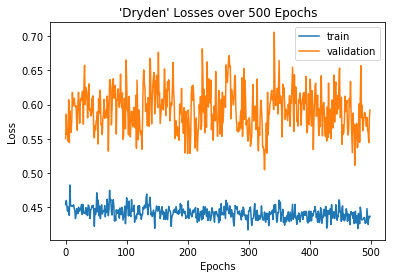

Average Training Score: 0.44150130381670777
Average Validation Score: 0.5924509550333024


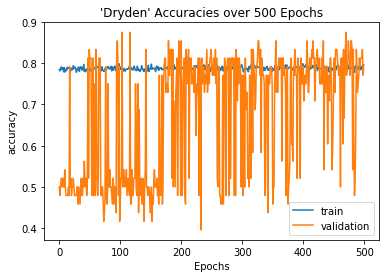

Average Training Score: 0.787841155234657
Average Validation Score: 0.666875

validating on book: 'Voltaire'
Epoch 0/499
----------



Phase:train
Confusion matrix:
 [[ 244  462]
 [  81 1671]]
loss 1116.5360562503338



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 14 291]]
loss 116.06811195611954
Epoch 1/499
----------



Phase:train
Confusion matrix:
 [[ 258  448]
 [  90 1662]]
loss 1108.2047262340784



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 13 292]]
loss 116.05640113353729
Epoch 2/499
----------



Phase:train
Confusion matrix:
 [[ 253  453]
 [ 118 1634]]
loss 1174.815521210432



Phase:val
Confusion matrix:
 [[ 25  30]
 [ 15 290]]
loss 117.71665394306183
Epoch 3/499
----------



Phase:train
Confusion matrix:
 [[ 252  454]
 [ 107 1645]]
loss 1114.9235633015633



Phase:val
Confusion matrix:
 [[ 28  27]
 [ 19 286]]
loss 109.89513009786606
Epoch 4/499
----------



Phase:train
Confusion matrix:
 [[ 266  440]
 [ 118 1634]]
loss 1110.0909909904003



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 11 294]]
loss 113.20102259516716
Epoch 5/499
----------



Phase:train
Confusion matrix:
 [[ 279  427]
 [ 114 1638]]
loss 1118.1753497719765



Phase:val
Confusion matrix:
 [[ 22  33]
 [  9 296]]
loss 112.97855541110039
Epoch 6/499
----------



Phase:train
Confusion matrix:
 [[ 255  451]
 [  98 1654]]
loss 1144.6925189197063



Phase:val
Confusion matrix:
 [[ 19  36]
 [  8 297]]
loss 116.8587937951088
Epoch 7/499
----------



Phase:train
Confusion matrix:
 [[ 266  440]
 [ 131 1621]]
loss 1131.4681320637465



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 13 292]]
loss 115.05125671625137
Epoch 8/499
----------



Phase:train
Confusion matrix:
 [[ 276  430]
 [ 139 1613]]
loss 1113.7256631404161



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 14 291]]
loss 114.42006960511208
Epoch 9/499
----------



Phase:train
Confusion matrix:
 [[ 231  475]
 [ 105 1647]]
loss 1138.0033217966557



Phase:val
Confusion matrix:
 [[ 19  36]
 [  7 298]]
loss 111.55188962817192
Epoch 10/499
----------



Phase:train
Confusion matrix:
 [[ 247  459]
 [  95 1657]]
loss 1116.9460159093142



Phase:val
Confusion matrix:
 [[ 20  35]
 [  9 296]]
loss 110.506292283535
Epoch 11/499
----------



Phase:train
Confusion matrix:
 [[ 261  445]
 [ 112 1640]]
loss 1108.9322038143873



Phase:val
Confusion matrix:
 [[ 21  34]
 [  9 296]]
loss 107.09259405732155
Epoch 12/499
----------



Phase:train
Confusion matrix:
 [[ 265  441]
 [ 100 1652]]
loss 1097.0163149535656



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 11 294]]
loss 107.85659492015839
Epoch 13/499
----------



Phase:train
Confusion matrix:
 [[ 246  460]
 [ 112 1640]]
loss 1118.2126907408237



Phase:val
Confusion matrix:
 [[ 21  34]
 [  9 296]]
loss 109.29952412843704
Epoch 14/499
----------



Phase:train
Confusion matrix:
 [[ 257  449]
 [ 106 1646]]
loss 1122.4503049999475



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 10 295]]
loss 113.72619181871414
Epoch 15/499
----------



Phase:train
Confusion matrix:
 [[ 239  467]
 [  97 1655]]
loss 1137.617075175047



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 11 294]]
loss 114.28407534956932
Epoch 16/499
----------



Phase:train
Confusion matrix:
 [[ 263  443]
 [ 126 1626]]
loss 1105.2346078753471



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 13 292]]
loss 108.82237926125526
Epoch 17/499
----------



Phase:train
Confusion matrix:
 [[ 253  453]
 [ 114 1638]]
loss 1102.3868606984615



Phase:val
Confusion matrix:
 [[ 22  33]
 [  9 296]]
loss 105.89564114809036
Epoch 18/499
----------



Phase:train
Confusion matrix:
 [[ 270  436]
 [  91 1661]]
loss 1089.2036007642746



Phase:val
Confusion matrix:
 [[ 24  31]
 [  9 296]]
loss 104.66770067811012
Epoch 19/499
----------



Phase:train
Confusion matrix:
 [[ 274  432]
 [  98 1654]]
loss 1095.1022631824017



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 10 295]]
loss 107.72355541586876
Epoch 20/499
----------



Phase:train
Confusion matrix:
 [[ 265  441]
 [ 111 1641]]
loss 1093.9213976711035



Phase:val
Confusion matrix:
 [[ 27  28]
 [ 17 288]]
loss 110.50506949424744
Epoch 21/499
----------



Phase:train
Confusion matrix:
 [[ 278  428]
 [ 104 1648]]
loss 1066.4177094101906



Phase:val
Confusion matrix:
 [[ 26  29]
 [ 18 287]]
loss 107.71994233131409
Epoch 22/499
----------



Phase:train
Confusion matrix:
 [[ 277  429]
 [ 110 1642]]
loss 1122.0067446231842



Phase:val
Confusion matrix:
 [[ 27  28]
 [ 23 282]]
loss 118.4965267777443
Epoch 23/499
----------



Phase:train
Confusion matrix:
 [[ 294  412]
 [ 144 1608]]
loss 1126.4750045239925



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 11 294]]
loss 113.56958135962486
Epoch 24/499
----------



Phase:train
Confusion matrix:
 [[ 277  429]
 [ 111 1641]]
loss 1094.2071411907673



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 13 292]]
loss 110.49658745527267
Epoch 25/499
----------



Phase:train
Confusion matrix:
 [[ 267  439]
 [  95 1657]]
loss 1105.4376224428415



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 11 294]]
loss 119.09803315997124
Epoch 26/499
----------



Phase:train
Confusion matrix:
 [[ 258  448]
 [ 108 1644]]
loss 1142.1562006771564



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 14 291]]
loss 115.20682528614998
Epoch 27/499
----------



Phase:train
Confusion matrix:
 [[ 245  461]
 [ 111 1641]]
loss 1144.6612454354763



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 14 291]]
loss 120.23786753416061
Epoch 28/499
----------



Phase:train
Confusion matrix:
 [[ 255  451]
 [  99 1653]]
loss 1097.0664466917515



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 12 293]]
loss 111.22598573565483
Epoch 29/499
----------



Phase:train
Confusion matrix:
 [[ 251  455]
 [ 101 1651]]
loss 1118.9474580734968



Phase:val
Confusion matrix:
 [[ 18  37]
 [  9 296]]
loss 116.00732207298279
Epoch 30/499
----------



Phase:train
Confusion matrix:
 [[ 254  452]
 [ 117 1635]]
loss 1136.467370212078



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 12 293]]
loss 115.39161026477814
Epoch 31/499
----------



Phase:train
Confusion matrix:
 [[ 241  465]
 [  93 1659]]
loss 1111.540003567934



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 15 290]]
loss 110.37786409258842
Epoch 32/499
----------



Phase:train
Confusion matrix:
 [[ 249  457]
 [ 100 1652]]
loss 1148.4293583929539



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 16 289]]
loss 119.6706011891365
Epoch 33/499
----------



Phase:train
Confusion matrix:
 [[ 242  464]
 [  87 1665]]
loss 1116.8004886209965



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 11 294]]
loss 115.05247160792351
Epoch 34/499
----------



Phase:train
Confusion matrix:
 [[ 244  462]
 [  99 1653]]
loss 1110.4705061167479



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 10 295]]
loss 109.56724971532822
Epoch 35/499
----------



Phase:train
Confusion matrix:
 [[ 270  436]
 [ 110 1642]]
loss 1109.8050166666508



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 13 292]]
loss 122.87992730736732
Epoch 36/499
----------



Phase:train
Confusion matrix:
 [[ 255  451]
 [ 116 1636]]
loss 1115.4646493643522



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 12 293]]
loss 118.07541191577911
Epoch 37/499
----------



Phase:train
Confusion matrix:
 [[ 270  436]
 [ 113 1639]]
loss 1139.8683345019817



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 10 295]]
loss 115.4568088054657
Epoch 38/499
----------



Phase:train
Confusion matrix:
 [[ 259  447]
 [  97 1655]]
loss 1097.7164700329304



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 12 293]]
loss 108.85061919689178
Epoch 39/499
----------



Phase:train
Confusion matrix:
 [[ 273  433]
 [ 109 1643]]
loss 1115.5082665085793



Phase:val
Confusion matrix:
 [[ 24  31]
 [ 17 288]]
loss 115.26453286409378
Epoch 40/499
----------



Phase:train
Confusion matrix:
 [[ 292  414]
 [ 103 1649]]
loss 1096.4696050584316



Phase:val
Confusion matrix:
 [[ 24  31]
 [ 10 295]]
loss 112.1048691868782
Epoch 41/499
----------



Phase:train
Confusion matrix:
 [[ 281  425]
 [ 122 1630]]
loss 1131.1369830667973



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 10 295]]
loss 121.86645030975342
Epoch 42/499
----------



Phase:train
Confusion matrix:
 [[ 271  435]
 [ 112 1640]]
loss 1133.2138843238354



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 10 295]]
loss 114.0550546348095
Epoch 43/499
----------



Phase:train
Confusion matrix:
 [[ 243  463]
 [  97 1655]]
loss 1102.9049321860075



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 12 293]]
loss 110.9988097846508
Epoch 44/499
----------



Phase:train
Confusion matrix:
 [[ 250  456]
 [  90 1662]]
loss 1134.8086092472076



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 11 294]]
loss 107.80819356441498
Epoch 45/499
----------



Phase:train
Confusion matrix:
 [[ 271  435]
 [ 110 1642]]
loss 1106.6079505980015



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 13 292]]
loss 115.99579751491547
Epoch 46/499
----------



Phase:train
Confusion matrix:
 [[ 256  450]
 [ 105 1647]]
loss 1142.1187507361174



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 12 293]]
loss 115.96037924289703
Epoch 47/499
----------



Phase:train
Confusion matrix:
 [[ 257  449]
 [ 124 1628]]
loss 1134.6561652570963



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 10 295]]
loss 113.55393886566162
Epoch 48/499
----------



Phase:train
Confusion matrix:
 [[ 257  449]
 [  91 1661]]
loss 1100.9928597956896



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 11 294]]
loss 112.35980212688446
Epoch 49/499
----------



Phase:train
Confusion matrix:
 [[ 261  445]
 [ 110 1642]]
loss 1157.4090589880943



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 12 293]]
loss 108.30670058727264
Epoch 50/499
----------



Phase:train
Confusion matrix:
 [[ 259  447]
 [ 100 1652]]
loss 1107.9289163649082



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 14 291]]
loss 113.47562313079834
Epoch 51/499
----------



Phase:train
Confusion matrix:
 [[ 238  468]
 [  99 1653]]
loss 1129.2702281624079



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 12 293]]
loss 112.15524464845657
Epoch 52/499
----------



Phase:train
Confusion matrix:
 [[ 239  467]
 [ 106 1646]]
loss 1112.6595395952463



Phase:val
Confusion matrix:
 [[ 17  38]
 [  8 297]]
loss 106.6744501888752
Epoch 53/499
----------



Phase:train
Confusion matrix:
 [[ 247  459]
 [ 103 1649]]
loss 1105.195611283183



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 11 294]]
loss 112.33874425292015
Epoch 54/499
----------



Phase:train
Confusion matrix:
 [[ 271  435]
 [ 125 1627]]
loss 1134.5413374602795



Phase:val
Confusion matrix:
 [[ 15  40]
 [  6 299]]
loss 116.48334592580795
Epoch 55/499
----------



Phase:train
Confusion matrix:
 [[ 250  456]
 [  96 1656]]
loss 1106.727370634675



Phase:val
Confusion matrix:
 [[ 18  37]
 [  9 296]]
loss 111.47270798683167
Epoch 56/499
----------



Phase:train
Confusion matrix:
 [[ 287  419]
 [ 117 1635]]
loss 1095.4590776860714



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 12 293]]
loss 109.57570865750313
Epoch 57/499
----------



Phase:train
Confusion matrix:
 [[ 244  462]
 [ 107 1645]]
loss 1109.4240802824497



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 12 293]]
loss 110.44882476329803
Epoch 58/499
----------



Phase:train
Confusion matrix:
 [[ 272  434]
 [ 108 1644]]
loss 1094.513806372881



Phase:val
Confusion matrix:
 [[ 21  34]
 [  9 296]]
loss 110.56582644581795
Epoch 59/499
----------



Phase:train
Confusion matrix:
 [[ 249  457]
 [ 107 1645]]
loss 1128.5181831717491



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 12 293]]
loss 108.4162686765194
Epoch 60/499
----------



Phase:train
Confusion matrix:
 [[ 265  441]
 [ 114 1638]]
loss 1129.8807164430618



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 16 289]]
loss 115.75978398323059
Epoch 61/499
----------



Phase:train
Confusion matrix:
 [[ 276  430]
 [ 113 1639]]
loss 1094.2220704853535



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 12 293]]
loss 107.7887512743473
Epoch 62/499
----------



Phase:train
Confusion matrix:
 [[ 260  446]
 [ 112 1640]]
loss 1099.8173334598541



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 10 295]]
loss 107.59060502052307
Epoch 63/499
----------



Phase:train
Confusion matrix:
 [[ 265  441]
 [ 114 1638]]
loss 1133.2835946530104



Phase:val
Confusion matrix:
 [[ 18  37]
 [  7 298]]
loss 111.2297511100769
Epoch 64/499
----------



Phase:train
Confusion matrix:
 [[ 238  468]
 [  83 1669]]
loss 1134.2447147518396



Phase:val
Confusion matrix:
 [[ 16  39]
 [  8 297]]
loss 112.38767832517624
Epoch 65/499
----------



Phase:train
Confusion matrix:
 [[ 239  467]
 [  90 1662]]
loss 1136.4924597889185



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 10 295]]
loss 112.32475072145462
Epoch 66/499
----------



Phase:train
Confusion matrix:
 [[ 272  434]
 [ 105 1647]]
loss 1099.758709102869



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 14 291]]
loss 114.87022578716278
Epoch 67/499
----------



Phase:train
Confusion matrix:
 [[ 266  440]
 [  84 1668]]
loss 1124.479800567031



Phase:val
Confusion matrix:
 [[ 16  39]
 [ 11 294]]
loss 112.2526204586029
Epoch 68/499
----------



Phase:train
Confusion matrix:
 [[ 262  444]
 [ 110 1642]]
loss 1104.0467595905066



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 15 290]]
loss 115.02978399395943
Epoch 69/499
----------



Phase:train
Confusion matrix:
 [[ 254  452]
 [ 118 1634]]
loss 1133.947673484683



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 13 292]]
loss 119.10669356584549
Epoch 70/499
----------



Phase:train
Confusion matrix:
 [[ 248  458]
 [ 110 1642]]
loss 1101.8847351074219



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 11 294]]
loss 112.75837019085884
Epoch 71/499
----------



Phase:train
Confusion matrix:
 [[ 246  460]
 [  96 1656]]
loss 1123.113593623042



Phase:val
Confusion matrix:
 [[ 19  36]
 [  8 297]]
loss 112.09015160799026
Epoch 72/499
----------



Phase:train
Confusion matrix:
 [[ 249  457]
 [ 101 1651]]
loss 1138.6651379913092



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 11 294]]
loss 112.85189062356949
Epoch 73/499
----------



Phase:train
Confusion matrix:
 [[ 267  439]
 [  82 1670]]
loss 1106.182878524065



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 15 290]]
loss 115.29638022184372
Epoch 74/499
----------



Phase:train
Confusion matrix:
 [[ 267  439]
 [ 107 1645]]
loss 1092.3463654518127



Phase:val
Confusion matrix:
 [[ 19  36]
 [  9 296]]
loss 108.93991693854332
Epoch 75/499
----------



Phase:train
Confusion matrix:
 [[ 276  430]
 [  96 1656]]
loss 1093.3402453362942



Phase:val
Confusion matrix:
 [[ 19  36]
 [  9 296]]
loss 105.82190185785294
Epoch 76/499
----------



Phase:train
Confusion matrix:
 [[ 264  442]
 [ 110 1642]]
loss 1107.6071687042713



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 13 292]]
loss 110.97596660256386
Epoch 77/499
----------



Phase:train
Confusion matrix:
 [[ 270  436]
 [ 105 1647]]
loss 1097.6107444167137



Phase:val
Confusion matrix:
 [[ 24  31]
 [ 13 292]]
loss 111.8525943160057
Epoch 78/499
----------



Phase:train
Confusion matrix:
 [[ 298  408]
 [ 115 1637]]
loss 1103.7283012270927



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 19 286]]
loss 119.42180305719376
Epoch 79/499
----------



Phase:train
Confusion matrix:
 [[ 281  425]
 [ 120 1632]]
loss 1134.3451930433512



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 15 290]]
loss 118.07265728712082
Epoch 80/499
----------



Phase:train
Confusion matrix:
 [[ 260  446]
 [ 107 1645]]
loss 1115.4377578645945



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 21 284]]
loss 121.98489487171173
Epoch 81/499
----------



Phase:train
Confusion matrix:
 [[ 252  454]
 [ 117 1635]]
loss 1122.302254498005



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 14 291]]
loss 115.84469109773636
Epoch 82/499
----------



Phase:train
Confusion matrix:
 [[ 258  448]
 [  99 1653]]
loss 1116.8910830020905



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 12 293]]
loss 119.93814289569855
Epoch 83/499
----------



Phase:train
Confusion matrix:
 [[ 271  435]
 [ 121 1631]]
loss 1100.1684866547585



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 13 292]]
loss 113.05389374494553
Epoch 84/499
----------



Phase:train
Confusion matrix:
 [[ 283  423]
 [ 118 1634]]
loss 1106.374173104763



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 14 291]]
loss 114.7149646282196
Epoch 85/499
----------



Phase:train
Confusion matrix:
 [[ 260  446]
 [  94 1658]]
loss 1115.3010472655296



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 15 290]]
loss 116.11026614904404
Epoch 86/499
----------



Phase:train
Confusion matrix:
 [[ 240  466]
 [  96 1656]]
loss 1097.141411691904



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 17 288]]
loss 113.02736178040504
Epoch 87/499
----------



Phase:train
Confusion matrix:
 [[ 282  424]
 [ 107 1645]]
loss 1092.7774547189474



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 10 295]]
loss 113.77018496394157
Epoch 88/499
----------



Phase:train
Confusion matrix:
 [[ 243  463]
 [  82 1670]]
loss 1116.1883555352688



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 12 293]]
loss 110.0641480088234
Epoch 89/499
----------



Phase:train
Confusion matrix:
 [[ 247  459]
 [  97 1655]]
loss 1123.4552346020937



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 10 295]]
loss 111.0601244866848
Epoch 90/499
----------



Phase:train
Confusion matrix:
 [[ 233  473]
 [  93 1659]]
loss 1121.0102614313364



Phase:val
Confusion matrix:
 [[ 17  38]
 [  8 297]]
loss 109.78007972240448
Epoch 91/499
----------



Phase:train
Confusion matrix:
 [[ 273  433]
 [ 119 1633]]
loss 1134.9703526496887



Phase:val
Confusion matrix:
 [[ 16  39]
 [  7 298]]
loss 116.94971948862076
Epoch 92/499
----------



Phase:train
Confusion matrix:
 [[ 251  455]
 [  85 1667]]
loss 1115.9198056459427



Phase:val
Confusion matrix:
 [[ 17  38]
 [  9 296]]
loss 108.35224077105522
Epoch 93/499
----------



Phase:train
Confusion matrix:
 [[ 258  448]
 [ 109 1643]]
loss 1088.375891238451



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 12 293]]
loss 111.28643929958344
Epoch 94/499
----------



Phase:train
Confusion matrix:
 [[ 279  427]
 [ 109 1643]]
loss 1102.365992307663



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 14 291]]
loss 114.20812368392944
Epoch 95/499
----------



Phase:train
Confusion matrix:
 [[ 277  429]
 [ 120 1632]]
loss 1108.033473342657



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 16 289]]
loss 114.25982668995857
Epoch 96/499
----------



Phase:train
Confusion matrix:
 [[ 238  468]
 [  93 1659]]
loss 1201.0221304744482



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 12 293]]
loss 127.5779715180397
Epoch 97/499
----------



Phase:train
Confusion matrix:
 [[ 249  457]
 [  85 1667]]
loss 1116.9841154813766



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 15 290]]
loss 118.14392864704132
Epoch 98/499
----------



Phase:train
Confusion matrix:
 [[ 273  433]
 [ 111 1641]]
loss 1108.3229789584875



Phase:val
Confusion matrix:
 [[ 25  30]
 [ 16 289]]
loss 114.27417933940887
Epoch 99/499
----------



Phase:train
Confusion matrix:
 [[ 289  417]
 [ 123 1629]]
loss 1079.3053860068321



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 18 287]]
loss 113.27540591359138
Epoch 100/499
----------



Phase:train
Confusion matrix:
 [[ 262  444]
 [ 105 1647]]
loss 1122.12469419837



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 10 295]]
loss 108.01221564412117
Epoch 101/499
----------



Phase:train
Confusion matrix:
 [[ 265  441]
 [  95 1657]]
loss 1102.473631337285



Phase:val
Confusion matrix:
 [[ 18  37]
 [  9 296]]
loss 111.44467487931252
Epoch 102/499
----------



Phase:train
Confusion matrix:
 [[ 260  446]
 [ 104 1648]]
loss 1111.4191666394472



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 10 295]]
loss 112.70179644227028
Epoch 103/499
----------



Phase:train
Confusion matrix:
 [[ 277  429]
 [ 111 1641]]
loss 1106.402375549078



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 14 291]]
loss 112.70841911435127
Epoch 104/499
----------



Phase:train
Confusion matrix:
 [[ 263  443]
 [ 108 1644]]
loss 1107.1215193867683



Phase:val
Confusion matrix:
 [[ 15  40]
 [  9 296]]
loss 117.24693670868874
Epoch 105/499
----------



Phase:train
Confusion matrix:
 [[ 267  439]
 [ 111 1641]]
loss 1120.0132870227098



Phase:val
Confusion matrix:
 [[ 18  37]
 [  7 298]]
loss 111.1435404419899
Epoch 106/499
----------



Phase:train
Confusion matrix:
 [[ 250  456]
 [ 105 1647]]
loss 1139.9521970301867



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 10 295]]
loss 112.81851649284363
Epoch 107/499
----------



Phase:train
Confusion matrix:
 [[ 235  471]
 [ 101 1651]]
loss 1154.8539445698261



Phase:val
Confusion matrix:
 [[ 17  38]
 [  9 296]]
loss 114.53948616981506
Epoch 108/499
----------



Phase:train
Confusion matrix:
 [[ 252  454]
 [ 105 1647]]
loss 1141.0634884387255



Phase:val
Confusion matrix:
 [[ 16  39]
 [  8 297]]
loss 112.31628477573395
Epoch 109/499
----------



Phase:train
Confusion matrix:
 [[ 267  439]
 [  94 1658]]
loss 1079.4888915866613



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 10 295]]
loss 107.48642474412918
Epoch 110/499
----------



Phase:train
Confusion matrix:
 [[ 269  437]
 [ 117 1635]]
loss 1107.275135859847



Phase:val
Confusion matrix:
 [[ 18  37]
 [  9 296]]
loss 108.8743656873703
Epoch 111/499
----------



Phase:train
Confusion matrix:
 [[ 299  407]
 [ 124 1628]]
loss 1073.5155359357595



Phase:val
Confusion matrix:
 [[ 18  37]
 [  9 296]]
loss 111.50596901774406
Epoch 112/499
----------



Phase:train
Confusion matrix:
 [[ 258  448]
 [  94 1658]]
loss 1103.5859469175339



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 11 294]]
loss 108.70063289999962
Epoch 113/499
----------



Phase:train
Confusion matrix:
 [[ 295  411]
 [ 106 1646]]
loss 1073.6849784702063



Phase:val
Confusion matrix:
 [[ 24  31]
 [ 18 287]]
loss 112.90198549628258
Epoch 114/499
----------



Phase:train
Confusion matrix:
 [[ 262  444]
 [ 122 1630]]
loss 1130.223588436842



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 11 294]]
loss 114.2343507707119
Epoch 115/499
----------



Phase:train
Confusion matrix:
 [[ 272  434]
 [ 104 1648]]
loss 1120.4383917152882



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 16 289]]
loss 116.23752951622009
Epoch 116/499
----------



Phase:train
Confusion matrix:
 [[ 270  436]
 [ 125 1627]]
loss 1118.217744961381



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 13 292]]
loss 114.0905824303627
Epoch 117/499
----------



Phase:train
Confusion matrix:
 [[ 251  455]
 [ 100 1652]]
loss 1114.620125591755



Phase:val
Confusion matrix:
 [[ 24  31]
 [ 13 292]]
loss 106.70941442251205
Epoch 118/499
----------



Phase:train
Confusion matrix:
 [[ 232  474]
 [ 101 1651]]
loss 1132.1329980194569



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 11 294]]
loss 109.82752352952957
Epoch 119/499
----------



Phase:train
Confusion matrix:
 [[ 261  445]
 [ 103 1649]]
loss 1092.6890227496624



Phase:val
Confusion matrix:
 [[ 24  31]
 [ 12 293]]
loss 107.87555277347565
Epoch 120/499
----------



Phase:train
Confusion matrix:
 [[ 265  441]
 [ 100 1652]]
loss 1069.8197549134493



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 16 289]]
loss 104.70294415950775
Epoch 121/499
----------



Phase:train
Confusion matrix:
 [[ 268  438]
 [ 124 1628]]
loss 1140.4792360961437



Phase:val
Confusion matrix:
 [[ 16  39]
 [  9 296]]
loss 113.265790194273
Epoch 122/499
----------



Phase:train
Confusion matrix:
 [[ 245  461]
 [ 116 1636]]
loss 1142.446171477437



Phase:val
Confusion matrix:
 [[ 18  37]
 [  8 297]]
loss 112.93434008955956
Epoch 123/499
----------



Phase:train
Confusion matrix:
 [[ 241  465]
 [  80 1672]]
loss 1109.4651061445475



Phase:val
Confusion matrix:
 [[ 16  39]
 [  8 297]]
loss 111.11588537693024
Epoch 124/499
----------



Phase:train
Confusion matrix:
 [[ 261  445]
 [ 108 1644]]
loss 1110.9440815746784



Phase:val
Confusion matrix:
 [[ 15  40]
 [  9 296]]
loss 110.38067728281021
Epoch 125/499
----------



Phase:train
Confusion matrix:
 [[ 253  453]
 [ 107 1645]]
loss 1120.241934120655



Phase:val
Confusion matrix:
 [[ 21  34]
 [  8 297]]
loss 114.70819666981697
Epoch 126/499
----------



Phase:train
Confusion matrix:
 [[ 270  436]
 [ 127 1625]]
loss 1101.8173249959946



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 10 295]]
loss 104.87659826874733
Epoch 127/499
----------



Phase:train
Confusion matrix:
 [[ 282  424]
 [ 123 1629]]
loss 1134.46127897501



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 11 294]]
loss 113.70691239833832
Epoch 128/499
----------



Phase:train
Confusion matrix:
 [[ 247  459]
 [ 133 1619]]
loss 1120.4056289494038



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 14 291]]
loss 114.33606177568436
Epoch 129/499
----------



Phase:train
Confusion matrix:
 [[ 270  436]
 [ 115 1637]]
loss 1103.69941046834



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 14 291]]
loss 108.53029698133469
Epoch 130/499
----------



Phase:train
Confusion matrix:
 [[ 267  439]
 [ 131 1621]]
loss 1108.6527516394854



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 10 295]]
loss 110.57821333408356
Epoch 131/499
----------



Phase:train
Confusion matrix:
 [[ 253  453]
 [ 108 1644]]
loss 1106.2861311137676



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 10 295]]
loss 109.60611552000046
Epoch 132/499
----------



Phase:train
Confusion matrix:
 [[ 265  441]
 [  99 1653]]
loss 1095.2783767580986



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 13 292]]
loss 108.49307924509048
Epoch 133/499
----------



Phase:train
Confusion matrix:
 [[ 249  457]
 [ 118 1634]]
loss 1145.480281084776



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 11 294]]
loss 117.75907069444656
Epoch 134/499
----------



Phase:train
Confusion matrix:
 [[ 262  444]
 [  97 1655]]
loss 1119.2181496024132



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 11 294]]
loss 106.98420390486717
Epoch 135/499
----------



Phase:train
Confusion matrix:
 [[ 231  475]
 [  99 1653]]
loss 1137.7410038113594



Phase:val
Confusion matrix:
 [[ 18  37]
 [  9 296]]
loss 111.45905435085297
Epoch 136/499
----------



Phase:train
Confusion matrix:
 [[ 254  452]
 [  84 1668]]
loss 1115.3129593133926



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 11 294]]
loss 111.26581281423569
Epoch 137/499
----------



Phase:train
Confusion matrix:
 [[ 255  451]
 [ 102 1650]]
loss 1103.9707541763783



Phase:val
Confusion matrix:
 [[ 21  34]
 [  9 296]]
loss 108.06798338890076
Epoch 138/499
----------



Phase:train
Confusion matrix:
 [[ 248  458]
 [ 105 1647]]
loss 1111.2846661508083



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 10 295]]
loss 114.38614845275879
Epoch 139/499
----------



Phase:train
Confusion matrix:
 [[ 283  423]
 [ 125 1627]]
loss 1115.9790973365307



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 11 294]]
loss 108.67397025227547
Epoch 140/499
----------



Phase:train
Confusion matrix:
 [[ 285  421]
 [ 110 1642]]
loss 1096.1512466967106



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 14 291]]
loss 110.23828268051147
Epoch 141/499
----------



Phase:train
Confusion matrix:
 [[ 270  436]
 [ 110 1642]]
loss 1130.0896515399218



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 12 293]]
loss 109.72823038697243
Epoch 142/499
----------



Phase:train
Confusion matrix:
 [[ 254  452]
 [  96 1656]]
loss 1128.6206171363592



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 12 293]]
loss 110.744189620018
Epoch 143/499
----------



Phase:train
Confusion matrix:
 [[ 289  417]
 [ 109 1643]]
loss 1069.9235874861479



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 14 291]]
loss 110.54384976625443
Epoch 144/499
----------



Phase:train
Confusion matrix:
 [[ 281  425]
 [ 110 1642]]
loss 1123.736632630229



Phase:val
Confusion matrix:
 [[ 20  35]
 [  9 296]]
loss 110.74134320020676
Epoch 145/499
----------



Phase:train
Confusion matrix:
 [[ 271  435]
 [ 121 1631]]
loss 1097.5382997244596



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 14 291]]
loss 108.98898154497147
Epoch 146/499
----------



Phase:train
Confusion matrix:
 [[ 280  426]
 [ 133 1619]]
loss 1098.7732769846916



Phase:val
Confusion matrix:
 [[ 19  36]
 [  9 296]]
loss 111.45569756627083
Epoch 147/499
----------



Phase:train
Confusion matrix:
 [[ 304  402]
 [ 133 1619]]
loss 1099.2110390216112



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 10 295]]
loss 118.8217481970787
Epoch 148/499
----------



Phase:train
Confusion matrix:
 [[ 247  459]
 [  96 1656]]
loss 1100.5619345009327



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 10 295]]
loss 111.04341566562653
Epoch 149/499
----------



Phase:train
Confusion matrix:
 [[ 270  436]
 [ 108 1644]]
loss 1115.3126048147678



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 10 295]]
loss 115.14800548553467
Epoch 150/499
----------



Phase:train
Confusion matrix:
 [[ 274  432]
 [ 104 1648]]
loss 1092.9073321670294



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 12 293]]
loss 108.59392002224922
Epoch 151/499
----------



Phase:train
Confusion matrix:
 [[ 275  431]
 [ 113 1639]]
loss 1110.607948154211



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 10 295]]
loss 113.16816136240959
Epoch 152/499
----------



Phase:train
Confusion matrix:
 [[ 245  461]
 [  86 1666]]
loss 1125.7550195157528



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 14 291]]
loss 114.10424023866653
Epoch 153/499
----------



Phase:train
Confusion matrix:
 [[ 284  422]
 [ 129 1623]]
loss 1094.6025722622871



Phase:val
Confusion matrix:
 [[ 25  30]
 [ 16 289]]
loss 108.91797482967377
Epoch 154/499
----------



Phase:train
Confusion matrix:
 [[ 270  436]
 [ 121 1631]]
loss 1113.4582349658012



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 15 290]]
loss 114.89222839474678
Epoch 155/499
----------



Phase:train
Confusion matrix:
 [[ 268  438]
 [ 112 1640]]
loss 1123.8642524033785



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 11 294]]
loss 112.6227730512619
Epoch 156/499
----------



Phase:train
Confusion matrix:
 [[ 254  452]
 [  89 1663]]
loss 1110.0453227311373



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 10 295]]
loss 117.55180805921555
Epoch 157/499
----------



Phase:train
Confusion matrix:
 [[ 263  443]
 [  97 1655]]
loss 1107.4881167709827



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 11 294]]
loss 111.08763575553894
Epoch 158/499
----------



Phase:train
Confusion matrix:
 [[ 265  441]
 [ 115 1637]]
loss 1135.793594226241



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 10 295]]
loss 111.90400868654251
Epoch 159/499
----------



Phase:train
Confusion matrix:
 [[ 281  425]
 [ 121 1631]]
loss 1095.7886155843735



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 12 293]]
loss 111.53813928365707
Epoch 160/499
----------



Phase:train
Confusion matrix:
 [[ 277  429]
 [ 126 1626]]
loss 1139.3647910654545



Phase:val
Confusion matrix:
 [[ 19  36]
 [  9 296]]
loss 109.62002664804459
Epoch 161/499
----------



Phase:train
Confusion matrix:
 [[ 254  452]
 [  99 1653]]
loss 1115.2206511199474



Phase:val
Confusion matrix:
 [[ 21  34]
 [  9 296]]
loss 110.83732277154922
Epoch 162/499
----------



Phase:train
Confusion matrix:
 [[ 264  442]
 [ 115 1637]]
loss 1120.6777973771095



Phase:val
Confusion matrix:
 [[ 21  34]
 [  9 296]]
loss 112.03959196805954
Epoch 163/499
----------



Phase:train
Confusion matrix:
 [[ 296  410]
 [ 128 1624]]
loss 1121.714792534709



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 14 291]]
loss 113.94241839647293
Epoch 164/499
----------



Phase:train
Confusion matrix:
 [[ 261  445]
 [ 106 1646]]
loss 1125.1924336105585



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 14 291]]
loss 116.59501239657402
Epoch 165/499
----------



Phase:train
Confusion matrix:
 [[ 279  427]
 [ 135 1617]]
loss 1132.5868742763996



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 12 293]]
loss 120.73723405599594
Epoch 166/499
----------



Phase:train
Confusion matrix:
 [[ 289  417]
 [ 108 1644]]
loss 1068.4675043970346



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 13 292]]
loss 113.05288717150688
Epoch 167/499
----------



Phase:train
Confusion matrix:
 [[ 261  445]
 [ 126 1626]]
loss 1134.1381757557392



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 15 290]]
loss 116.56241118907928
Epoch 168/499
----------



Phase:train
Confusion matrix:
 [[ 251  455]
 [ 109 1643]]
loss 1138.669504031539



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 14 291]]
loss 111.11069411039352
Epoch 169/499
----------



Phase:train
Confusion matrix:
 [[ 279  427]
 [ 121 1631]]
loss 1129.9541155695915



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 15 290]]
loss 123.58197450637817
Epoch 170/499
----------



Phase:train
Confusion matrix:
 [[ 251  455]
 [  83 1669]]
loss 1143.6096380800009



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 10 295]]
loss 118.70542258024216
Epoch 171/499
----------



Phase:train
Confusion matrix:
 [[ 244  462]
 [ 102 1650]]
loss 1143.264319613576



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 12 293]]
loss 114.5248231291771
Epoch 172/499
----------



Phase:train
Confusion matrix:
 [[ 253  453]
 [  90 1662]]
loss 1105.2213400900364



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 10 295]]
loss 114.47698444128036
Epoch 173/499
----------



Phase:train
Confusion matrix:
 [[ 243  463]
 [ 103 1649]]
loss 1109.6887951791286



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 12 293]]
loss 110.09820803999901
Epoch 174/499
----------



Phase:train
Confusion matrix:
 [[ 260  446]
 [  87 1665]]
loss 1103.6850097179413



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 14 291]]
loss 111.67850479483604
Epoch 175/499
----------



Phase:train
Confusion matrix:
 [[ 233  473]
 [  99 1653]]
loss 1139.7071376293898



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 10 295]]
loss 115.79154551029205
Epoch 176/499
----------



Phase:train
Confusion matrix:
 [[ 260  446]
 [ 113 1639]]
loss 1124.7613943517208



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 10 295]]
loss 113.10899496078491
Epoch 177/499
----------



Phase:train
Confusion matrix:
 [[ 279  427]
 [ 126 1626]]
loss 1097.0675893872976



Phase:val
Confusion matrix:
 [[ 21  34]
 [  8 297]]
loss 111.67120099067688
Epoch 178/499
----------



Phase:train
Confusion matrix:
 [[ 263  443]
 [ 103 1649]]
loss 1110.827814489603



Phase:val
Confusion matrix:
 [[ 20  35]
 [  8 297]]
loss 109.85903143882751
Epoch 179/499
----------



Phase:train
Confusion matrix:
 [[ 247  459]
 [  74 1678]]
loss 1088.986042946577



Phase:val
Confusion matrix:
 [[ 20  35]
 [  9 296]]
loss 109.91904675960541
Epoch 180/499
----------



Phase:train
Confusion matrix:
 [[ 265  441]
 [ 110 1642]]
loss 1102.6756352484226



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 12 293]]
loss 113.87518391013145
Epoch 181/499
----------



Phase:train
Confusion matrix:
 [[ 271  435]
 [ 122 1630]]
loss 1111.6100106239319



Phase:val
Confusion matrix:
 [[ 23  32]
 [  8 297]]
loss 111.62438184022903
Epoch 182/499
----------



Phase:train
Confusion matrix:
 [[ 262  444]
 [ 115 1637]]
loss 1122.6436807066202



Phase:val
Confusion matrix:
 [[ 21  34]
 [  6 299]]
loss 109.72502321004868
Epoch 183/499
----------



Phase:train
Confusion matrix:
 [[ 268  438]
 [  94 1658]]
loss 1097.5248270332813



Phase:val
Confusion matrix:
 [[ 17  38]
 [  7 298]]
loss 114.6824212372303
Epoch 184/499
----------



Phase:train
Confusion matrix:
 [[ 277  429]
 [ 115 1637]]
loss 1133.988512068987



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 10 295]]
loss 115.16398161649704
Epoch 185/499
----------



Phase:train
Confusion matrix:
 [[ 247  459]
 [ 104 1648]]
loss 1119.4757501631975



Phase:val
Confusion matrix:
 [[ 26  29]
 [ 14 291]]
loss 113.45763400197029
Epoch 186/499
----------



Phase:train
Confusion matrix:
 [[ 280  426]
 [  95 1657]]
loss 1101.218531280756



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 11 294]]
loss 111.13974466919899
Epoch 187/499
----------



Phase:train
Confusion matrix:
 [[ 258  448]
 [  99 1653]]
loss 1095.6897004246712



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 12 293]]
loss 115.19267603754997
Epoch 188/499
----------



Phase:train
Confusion matrix:
 [[ 270  436]
 [ 120 1632]]
loss 1118.6434239596128



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 12 293]]
loss 116.6164356470108
Epoch 189/499
----------



Phase:train
Confusion matrix:
 [[ 275  431]
 [ 108 1644]]
loss 1075.1346657946706



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 19 286]]
loss 118.49793523550034
Epoch 190/499
----------



Phase:train
Confusion matrix:
 [[ 278  428]
 [ 112 1640]]
loss 1087.297769203782



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 14 291]]
loss 118.91877979040146
Epoch 191/499
----------



Phase:train
Confusion matrix:
 [[ 258  448]
 [ 105 1647]]
loss 1146.935916185379



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 15 290]]
loss 126.93829715251923
Epoch 192/499
----------



Phase:train
Confusion matrix:
 [[ 286  420]
 [ 129 1623]]
loss 1115.181713849306



Phase:val
Confusion matrix:
 [[ 29  26]
 [ 22 283]]
loss 120.76138734817505
Epoch 193/499
----------



Phase:train
Confusion matrix:
 [[ 239  467]
 [  94 1658]]
loss 1147.4333243221045



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 11 294]]
loss 115.44972077012062
Epoch 194/499
----------



Phase:train
Confusion matrix:
 [[ 233  473]
 [  86 1666]]
loss 1143.2685276567936



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 11 294]]
loss 109.43780183792114
Epoch 195/499
----------



Phase:train
Confusion matrix:
 [[ 284  422]
 [ 115 1637]]
loss 1097.862455919385



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 21 284]]
loss 108.12802970409393
Epoch 196/499
----------



Phase:train
Confusion matrix:
 [[ 279  427]
 [ 113 1639]]
loss 1115.4257365316153



Phase:val
Confusion matrix:
 [[ 18  37]
 [  9 296]]
loss 106.42227113246918
Epoch 197/499
----------



Phase:train
Confusion matrix:
 [[ 269  437]
 [  91 1661]]
loss 1065.2056698203087



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 10 295]]
loss 106.11019372940063
Epoch 198/499
----------



Phase:train
Confusion matrix:
 [[ 287  419]
 [ 102 1650]]
loss 1083.8480521142483



Phase:val
Confusion matrix:
 [[ 24  31]
 [ 24 281]]
loss 113.30738678574562
Epoch 199/499
----------



Phase:train
Confusion matrix:
 [[ 299  407]
 [ 151 1601]]
loss 1108.3386947512627



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 10 295]]
loss 115.85227638483047
Epoch 200/499
----------



Phase:train
Confusion matrix:
 [[ 253  453]
 [ 108 1644]]
loss 1098.0709584355354



Phase:val
Confusion matrix:
 [[ 26  29]
 [ 20 285]]
loss 114.11522567272186
Epoch 201/499
----------



Phase:train
Confusion matrix:
 [[ 245  461]
 [ 103 1649]]
loss 1173.2120873332024



Phase:val
Confusion matrix:
 [[ 17  38]
 [  9 296]]
loss 115.2579253911972
Epoch 202/499
----------



Phase:train
Confusion matrix:
 [[ 239  467]
 [  87 1665]]
loss 1112.716522872448



Phase:val
Confusion matrix:
 [[ 13  42]
 [  6 299]]
loss 114.64282542467117
Epoch 203/499
----------



Phase:train
Confusion matrix:
 [[ 264  442]
 [ 101 1651]]
loss 1100.5466722249985



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 11 294]]
loss 110.11104702949524
Epoch 204/499
----------



Phase:train
Confusion matrix:
 [[ 277  429]
 [  94 1658]]
loss 1093.4051323384047



Phase:val
Confusion matrix:
 [[ 16  39]
 [ 10 295]]
loss 113.17132487893105
Epoch 205/499
----------



Phase:train
Confusion matrix:
 [[ 279  427]
 [ 104 1648]]
loss 1112.3645556271076



Phase:val
Confusion matrix:
 [[ 17  38]
 [  7 298]]
loss 116.25350028276443
Epoch 206/499
----------



Phase:train
Confusion matrix:
 [[ 234  472]
 [  77 1675]]
loss 1138.6025222986937



Phase:val
Confusion matrix:
 [[ 17  38]
 [  9 296]]
loss 117.40639865398407
Epoch 207/499
----------



Phase:train
Confusion matrix:
 [[ 285  421]
 [ 115 1637]]
loss 1115.2364407628775



Phase:val
Confusion matrix:
 [[ 15  40]
 [  8 297]]
loss 113.27628865838051
Epoch 208/499
----------



Phase:train
Confusion matrix:
 [[ 275  431]
 [ 106 1646]]
loss 1098.2384134829044



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 10 295]]
loss 109.29017901420593
Epoch 209/499
----------



Phase:train
Confusion matrix:
 [[ 297  409]
 [ 129 1623]]
loss 1087.9281271994114



Phase:val
Confusion matrix:
 [[ 17  38]
 [  8 297]]
loss 109.95755463838577
Epoch 210/499
----------



Phase:train
Confusion matrix:
 [[ 300  406]
 [ 109 1643]]
loss 1084.746400654316



Phase:val
Confusion matrix:
 [[ 17  38]
 [  9 296]]
loss 112.94003039598465
Epoch 211/499
----------



Phase:train
Confusion matrix:
 [[ 279  427]
 [ 112 1640]]
loss 1098.0082588642836



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 12 293]]
loss 113.53834867477417
Epoch 212/499
----------



Phase:train
Confusion matrix:
 [[ 301  405]
 [ 140 1612]]
loss 1153.2955841720104



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 11 294]]
loss 119.65445697307587
Epoch 213/499
----------



Phase:train
Confusion matrix:
 [[ 239  467]
 [  92 1660]]
loss 1113.3623263835907



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 19 286]]
loss 111.67812272906303
Epoch 214/499
----------



Phase:train
Confusion matrix:
 [[ 291  415]
 [  99 1653]]
loss 1063.2208433896303



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 13 292]]
loss 110.76301038265228
Epoch 215/499
----------



Phase:train
Confusion matrix:
 [[ 272  434]
 [ 139 1613]]
loss 1118.5356680452824



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 15 290]]
loss 112.5827243924141
Epoch 216/499
----------



Phase:train
Confusion matrix:
 [[ 266  440]
 [ 134 1618]]
loss 1147.007812410593



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 12 293]]
loss 119.17977035045624
Epoch 217/499
----------



Phase:train
Confusion matrix:
 [[ 256  450]
 [ 110 1642]]
loss 1142.882763683796



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 14 291]]
loss 118.5582023859024
Epoch 218/499
----------



Phase:train
Confusion matrix:
 [[ 278  428]
 [ 129 1623]]
loss 1102.6473444849253



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 15 290]]
loss 115.3392493724823
Epoch 219/499
----------



Phase:train
Confusion matrix:
 [[ 258  448]
 [ 121 1631]]
loss 1130.4017056822777



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 11 294]]
loss 116.1908283829689
Epoch 220/499
----------



Phase:train
Confusion matrix:
 [[ 265  441]
 [ 109 1643]]
loss 1127.791235908866



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 13 292]]
loss 115.13368725776672
Epoch 221/499
----------



Phase:train
Confusion matrix:
 [[ 269  437]
 [ 106 1646]]
loss 1081.9396212399006



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 10 295]]
loss 112.50933885574341
Epoch 222/499
----------



Phase:train
Confusion matrix:
 [[ 274  432]
 [ 110 1642]]
loss 1109.7753001898527



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 11 294]]
loss 114.60666209459305
Epoch 223/499
----------



Phase:train
Confusion matrix:
 [[ 238  468]
 [  96 1656]]
loss 1131.786405712366



Phase:val
Confusion matrix:
 [[ 15  40]
 [  9 296]]
loss 109.7586141526699
Epoch 224/499
----------



Phase:train
Confusion matrix:
 [[ 274  432]
 [ 106 1646]]
loss 1102.722332417965



Phase:val
Confusion matrix:
 [[ 16  39]
 [  8 297]]
loss 114.14453253149986
Epoch 225/499
----------



Phase:train
Confusion matrix:
 [[ 255  451]
 [  85 1667]]
loss 1117.8126869797707



Phase:val
Confusion matrix:
 [[ 26  29]
 [ 20 285]]
loss 117.97250479459763
Epoch 226/499
----------



Phase:train
Confusion matrix:
 [[ 293  413]
 [ 129 1623]]
loss 1078.8538068681955



Phase:val
Confusion matrix:
 [[ 24  31]
 [ 20 285]]
loss 115.82197174429893
Epoch 227/499
----------



Phase:train
Confusion matrix:
 [[ 292  414]
 [ 124 1628]]
loss 1114.4826099425554



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 10 295]]
loss 112.24472746253014
Epoch 228/499
----------



Phase:train
Confusion matrix:
 [[ 259  447]
 [ 104 1648]]
loss 1122.004989773035



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 12 293]]
loss 117.42876797914505
Epoch 229/499
----------



Phase:train
Confusion matrix:
 [[ 263  443]
 [  98 1654]]
loss 1090.9745911359787



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 10 295]]
loss 110.57415083050728
Epoch 230/499
----------



Phase:train
Confusion matrix:
 [[ 257  449]
 [ 104 1648]]
loss 1109.910763144493



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 12 293]]
loss 112.22169831395149
Epoch 231/499
----------



Phase:train
Confusion matrix:
 [[ 263  443]
 [ 102 1650]]
loss 1114.1523500084877



Phase:val
Confusion matrix:
 [[ 16  39]
 [  9 296]]
loss 113.99594217538834
Epoch 232/499
----------



Phase:train
Confusion matrix:
 [[ 263  443]
 [  88 1664]]
loss 1100.5029573738575



Phase:val
Confusion matrix:
 [[ 16  39]
 [ 11 294]]
loss 106.7205460369587
Epoch 233/499
----------



Phase:train
Confusion matrix:
 [[ 258  448]
 [ 102 1650]]
loss 1102.5894182771444



Phase:val
Confusion matrix:
 [[ 15  40]
 [  9 296]]
loss 106.71285971999168
Epoch 234/499
----------



Phase:train
Confusion matrix:
 [[ 250  456]
 [ 115 1637]]
loss 1132.5651642233133



Phase:val
Confusion matrix:
 [[ 16  39]
 [  7 298]]
loss 116.36953473091125
Epoch 235/499
----------



Phase:train
Confusion matrix:
 [[ 253  453]
 [ 119 1633]]
loss 1125.5593343228102



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 11 294]]
loss 111.8604165315628
Epoch 236/499
----------



Phase:train
Confusion matrix:
 [[ 260  446]
 [  93 1659]]
loss 1125.1141873449087



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 11 294]]
loss 114.88305389881134
Epoch 237/499
----------



Phase:train
Confusion matrix:
 [[ 289  417]
 [ 114 1638]]
loss 1083.4446563124657



Phase:val
Confusion matrix:
 [[ 16  39]
 [ 10 295]]
loss 114.98610228300095
Epoch 238/499
----------



Phase:train
Confusion matrix:
 [[ 282  424]
 [ 106 1646]]
loss 1115.7775923907757



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 12 293]]
loss 122.63035267591476
Epoch 239/499
----------



Phase:train
Confusion matrix:
 [[ 256  450]
 [  96 1656]]
loss 1082.0981128811836



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 16 289]]
loss 113.71960297226906
Epoch 240/499
----------



Phase:train
Confusion matrix:
 [[ 261  445]
 [ 130 1622]]
loss 1129.8372581601143



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 15 290]]
loss 120.18499210476875
Epoch 241/499
----------



Phase:train
Confusion matrix:
 [[ 245  461]
 [  92 1660]]
loss 1076.5860006809235



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 13 292]]
loss 111.37677818536758
Epoch 242/499
----------



Phase:train
Confusion matrix:
 [[ 285  421]
 [ 111 1641]]
loss 1073.518456041813



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 14 291]]
loss 110.9520836174488
Epoch 243/499
----------



Phase:train
Confusion matrix:
 [[ 268  438]
 [ 135 1617]]
loss 1149.6006839424372



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 17 288]]
loss 125.84502309560776
Epoch 244/499
----------



Phase:train
Confusion matrix:
 [[ 266  440]
 [  98 1654]]
loss 1118.374187797308



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 10 295]]
loss 109.94439646601677
Epoch 245/499
----------



Phase:train
Confusion matrix:
 [[ 258  448]
 [ 102 1650]]
loss 1103.5052718222141



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 14 291]]
loss 112.84338712692261
Epoch 246/499
----------



Phase:train
Confusion matrix:
 [[ 256  450]
 [  91 1661]]
loss 1127.2971894294024



Phase:val
Confusion matrix:
 [[ 24  31]
 [ 17 288]]
loss 112.94311121106148
Epoch 247/499
----------



Phase:train
Confusion matrix:
 [[ 273  433]
 [ 113 1639]]
loss 1095.543876618147



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 10 295]]
loss 113.11467006802559
Epoch 248/499
----------



Phase:train
Confusion matrix:
 [[ 263  443]
 [ 119 1633]]
loss 1121.3725937455893



Phase:val
Confusion matrix:
 [[ 22  33]
 [  9 296]]
loss 112.19285950064659
Epoch 249/499
----------



Phase:train
Confusion matrix:
 [[ 248  458]
 [ 105 1647]]
loss 1135.1984778493643



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 10 295]]
loss 108.41672360897064
Epoch 250/499
----------



Phase:train
Confusion matrix:
 [[ 271  435]
 [  94 1658]]
loss 1067.057836920023



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 12 293]]
loss 109.58623990416527
Epoch 251/499
----------



Phase:train
Confusion matrix:
 [[ 282  424]
 [ 105 1647]]
loss 1081.5275292396545



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 16 289]]
loss 114.8661556839943
Epoch 252/499
----------



Phase:train
Confusion matrix:
 [[ 276  430]
 [ 114 1638]]
loss 1107.2231396734715



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 15 290]]
loss 115.06478309631348
Epoch 253/499
----------



Phase:train
Confusion matrix:
 [[ 270  436]
 [ 118 1634]]
loss 1105.550971210003



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 16 289]]
loss 114.797622859478
Epoch 254/499
----------



Phase:train
Confusion matrix:
 [[ 249  457]
 [ 103 1649]]
loss 1127.0077962577343



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 16 289]]
loss 117.93082565069199
Epoch 255/499
----------



Phase:train
Confusion matrix:
 [[ 267  439]
 [ 130 1622]]
loss 1107.2015392035246



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 12 293]]
loss 117.31425315141678
Epoch 256/499
----------



Phase:train
Confusion matrix:
 [[ 250  456]
 [  80 1672]]
loss 1096.5343584120274



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 10 295]]
loss 109.43197399377823
Epoch 257/499
----------



Phase:train
Confusion matrix:
 [[ 285  421]
 [ 118 1634]]
loss 1109.406310543418



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 11 294]]
loss 114.63961690664291
Epoch 258/499
----------



Phase:train
Confusion matrix:
 [[ 281  425]
 [ 143 1609]]
loss 1088.3512051403522



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 12 293]]
loss 113.20649445056915
Epoch 259/499
----------



Phase:train
Confusion matrix:
 [[ 263  443]
 [  99 1653]]
loss 1137.1007982194424



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 11 294]]
loss 111.04044198989868
Epoch 260/499
----------



Phase:train
Confusion matrix:
 [[ 265  441]
 [  96 1656]]
loss 1114.8535382002592



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 11 294]]
loss 111.30866259336472
Epoch 261/499
----------



Phase:train
Confusion matrix:
 [[ 274  432]
 [ 116 1636]]
loss 1117.1170636117458



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 13 292]]
loss 117.97540932893753
Epoch 262/499
----------



Phase:train
Confusion matrix:
 [[ 277  429]
 [ 105 1647]]
loss 1094.8874678611755



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 11 294]]
loss 111.76168099045753
Epoch 263/499
----------



Phase:train
Confusion matrix:
 [[ 276  430]
 [ 100 1652]]
loss 1081.0283733904362



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 10 295]]
loss 111.91256657242775
Epoch 264/499
----------



Phase:train
Confusion matrix:
 [[ 274  432]
 [ 100 1652]]
loss 1086.2047147154808



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 12 293]]
loss 106.14685073494911
Epoch 265/499
----------



Phase:train
Confusion matrix:
 [[ 278  428]
 [ 118 1634]]
loss 1102.485547542572



Phase:val
Confusion matrix:
 [[ 25  30]
 [ 11 294]]
loss 108.34403023123741
Epoch 266/499
----------



Phase:train
Confusion matrix:
 [[ 261  445]
 [ 114 1638]]
loss 1143.7903003543615



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 10 295]]
loss 123.18376302719116
Epoch 267/499
----------



Phase:train
Confusion matrix:
 [[ 254  452]
 [ 112 1640]]
loss 1120.9660526812077



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 10 295]]
loss 113.4515955299139
Epoch 268/499
----------



Phase:train
Confusion matrix:
 [[ 264  442]
 [  92 1660]]
loss 1097.9180719554424



Phase:val
Confusion matrix:
 [[ 18  37]
 [  9 296]]
loss 112.01203256845474
Epoch 269/499
----------



Phase:train
Confusion matrix:
 [[ 246  460]
 [  85 1667]]
loss 1114.065032556653



Phase:val
Confusion matrix:
 [[ 18  37]
 [  8 297]]
loss 113.61554384231567
Epoch 270/499
----------



Phase:train
Confusion matrix:
 [[ 275  431]
 [ 110 1642]]
loss 1100.7899211198092



Phase:val
Confusion matrix:
 [[ 19  36]
 [  8 297]]
loss 115.70587754249573
Epoch 271/499
----------



Phase:train
Confusion matrix:
 [[ 274  432]
 [ 125 1627]]
loss 1097.9799407720566



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 10 295]]
loss 120.66663607954979
Epoch 272/499
----------



Phase:train
Confusion matrix:
 [[ 277  429]
 [ 112 1640]]
loss 1104.1344579160213



Phase:val
Confusion matrix:
 [[ 17  38]
 [  7 298]]
loss 108.60954776406288
Epoch 273/499
----------



Phase:train
Confusion matrix:
 [[ 288  418]
 [ 128 1624]]
loss 1112.79897262156



Phase:val
Confusion matrix:
 [[ 16  39]
 [  8 297]]
loss 110.54140254855156
Epoch 274/499
----------



Phase:train
Confusion matrix:
 [[ 251  455]
 [  98 1654]]
loss 1092.6268500983715



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 11 294]]
loss 112.01302379369736
Epoch 275/499
----------



Phase:train
Confusion matrix:
 [[ 265  441]
 [ 115 1637]]
loss 1100.8992841988802



Phase:val
Confusion matrix:
 [[ 20  35]
 [  8 297]]
loss 110.31040489673615
Epoch 276/499
----------



Phase:train
Confusion matrix:
 [[ 261  445]
 [  92 1660]]
loss 1105.9658536463976



Phase:val
Confusion matrix:
 [[ 17  38]
 [  9 296]]
loss 111.01399570703506
Epoch 277/499
----------



Phase:train
Confusion matrix:
 [[ 262  444]
 [  97 1655]]
loss 1079.344080761075



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 10 295]]
loss 104.84070062637329
Epoch 278/499
----------



Phase:train
Confusion matrix:
 [[ 250  456]
 [ 111 1641]]
loss 1120.5769006758928



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 11 294]]
loss 110.80276191234589
Epoch 279/499
----------



Phase:train
Confusion matrix:
 [[ 275  431]
 [ 102 1650]]
loss 1095.517938643694



Phase:val
Confusion matrix:
 [[ 18  37]
 [  9 296]]
loss 107.29087024927139
Epoch 280/499
----------



Phase:train
Confusion matrix:
 [[ 313  393]
 [ 135 1617]]
loss 1076.7195800840855



Phase:val
Confusion matrix:
 [[ 24  31]
 [ 17 288]]
loss 112.95131608843803
Epoch 281/499
----------



Phase:train
Confusion matrix:
 [[ 237  469]
 [  84 1668]]
loss 1141.089887842536



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 10 295]]
loss 117.03239232301712
Epoch 282/499
----------



Phase:train
Confusion matrix:
 [[ 259  447]
 [ 121 1631]]
loss 1115.05843706429



Phase:val
Confusion matrix:
 [[ 16  39]
 [  9 296]]
loss 111.43620938062668
Epoch 283/499
----------



Phase:train
Confusion matrix:
 [[ 251  455]
 [ 106 1646]]
loss 1152.8906285464764



Phase:val
Confusion matrix:
 [[ 23  32]
 [  9 296]]
loss 116.30668967962265
Epoch 284/499
----------



Phase:train
Confusion matrix:
 [[ 259  447]
 [ 121 1631]]
loss 1117.6844779849052



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 10 295]]
loss 112.18153387308121
Epoch 285/499
----------



Phase:train
Confusion matrix:
 [[ 287  419]
 [ 129 1623]]
loss 1099.8632915467024



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 10 295]]
loss 113.10025721788406
Epoch 286/499
----------



Phase:train
Confusion matrix:
 [[ 273  433]
 [  93 1659]]
loss 1110.4188140332699



Phase:val
Confusion matrix:
 [[ 19  36]
 [  9 296]]
loss 111.63575172424316
Epoch 287/499
----------



Phase:train
Confusion matrix:
 [[ 220  486]
 [  70 1682]]
loss 1109.6563360095024



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 10 295]]
loss 114.90977600216866
Epoch 288/499
----------



Phase:train
Confusion matrix:
 [[ 259  447]
 [ 102 1650]]
loss 1110.1552199423313



Phase:val
Confusion matrix:
 [[ 15  40]
 [  9 296]]
loss 113.71051833033562
Epoch 289/499
----------



Phase:train
Confusion matrix:
 [[ 277  429]
 [  98 1654]]
loss 1073.5352091491222



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 11 294]]
loss 107.92790092527866
Epoch 290/499
----------



Phase:train
Confusion matrix:
 [[ 272  434]
 [ 106 1646]]
loss 1123.4022915959358



Phase:val
Confusion matrix:
 [[ 15  40]
 [  8 297]]
loss 112.84661382436752
Epoch 291/499
----------



Phase:train
Confusion matrix:
 [[ 251  455]
 [ 115 1637]]
loss 1115.550241023302



Phase:val
Confusion matrix:
 [[ 16  39]
 [  7 298]]
loss 110.99465236067772
Epoch 292/499
----------



Phase:train
Confusion matrix:
 [[ 274  432]
 [ 110 1642]]
loss 1105.644575893879



Phase:val
Confusion matrix:
 [[ 26  29]
 [ 17 288]]
loss 116.54149882495403
Epoch 293/499
----------



Phase:train
Confusion matrix:
 [[ 273  433]
 [ 109 1643]]
loss 1109.9452604949474



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 11 294]]
loss 110.6894639134407
Epoch 294/499
----------



Phase:train
Confusion matrix:
 [[ 270  436]
 [ 109 1643]]
loss 1104.323734253645



Phase:val
Confusion matrix:
 [[ 24  31]
 [ 14 291]]
loss 114.12810385227203
Epoch 295/499
----------



Phase:train
Confusion matrix:
 [[ 266  440]
 [ 118 1634]]
loss 1096.0378343313932



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 14 291]]
loss 111.7154973745346
Epoch 296/499
----------



Phase:train
Confusion matrix:
 [[ 285  421]
 [  98 1654]]
loss 1089.5792648047209



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 10 295]]
loss 108.72440323233604
Epoch 297/499
----------



Phase:train
Confusion matrix:
 [[ 274  432]
 [ 112 1640]]
loss 1123.9750557541847



Phase:val
Confusion matrix:
 [[ 25  30]
 [ 17 288]]
loss 114.30341601371765
Epoch 298/499
----------



Phase:train
Confusion matrix:
 [[ 235  471]
 [  94 1658]]
loss 1098.7142523527145



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 11 294]]
loss 113.8885286450386
Epoch 299/499
----------



Phase:train
Confusion matrix:
 [[ 268  438]
 [ 106 1646]]
loss 1087.8094360232353



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 13 292]]
loss 111.25023797154427
Epoch 300/499
----------



Phase:train
Confusion matrix:
 [[ 285  421]
 [ 106 1646]]
loss 1099.6113893538713



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 16 289]]
loss 123.62380892038345
Epoch 301/499
----------



Phase:train
Confusion matrix:
 [[ 283  423]
 [ 123 1629]]
loss 1091.2717524468899



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 10 295]]
loss 108.6124461889267
Epoch 302/499
----------



Phase:train
Confusion matrix:
 [[ 260  446]
 [  95 1657]]
loss 1097.1888995915651



Phase:val
Confusion matrix:
 [[ 18  37]
 [  9 296]]
loss 111.70600160956383
Epoch 303/499
----------



Phase:train
Confusion matrix:
 [[ 287  419]
 [ 113 1639]]
loss 1078.1008073985577



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 11 294]]
loss 107.3772457242012
Epoch 304/499
----------



Phase:train
Confusion matrix:
 [[ 290  416]
 [ 122 1630]]
loss 1095.3631765544415



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 10 295]]
loss 114.7893488407135
Epoch 305/499
----------



Phase:train
Confusion matrix:
 [[ 288  418]
 [ 126 1626]]
loss 1090.031352058053



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 15 290]]
loss 120.73964282870293
Epoch 306/499
----------



Phase:train
Confusion matrix:
 [[ 291  415]
 [ 108 1644]]
loss 1089.5872180014849



Phase:val
Confusion matrix:
 [[ 25  30]
 [ 17 288]]
loss 114.51508462429047
Epoch 307/499
----------



Phase:train
Confusion matrix:
 [[ 276  430]
 [ 117 1635]]
loss 1126.280044913292



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 10 295]]
loss 119.43629369139671
Epoch 308/499
----------



Phase:train
Confusion matrix:
 [[ 284  422]
 [ 103 1649]]
loss 1091.7369849979877



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 10 295]]
loss 114.21295583248138
Epoch 309/499
----------



Phase:train
Confusion matrix:
 [[ 276  430]
 [ 131 1621]]
loss 1092.7065633237362



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 11 294]]
loss 110.17471343278885
Epoch 310/499
----------



Phase:train
Confusion matrix:
 [[ 270  436]
 [ 131 1621]]
loss 1108.132389396429



Phase:val
Confusion matrix:
 [[ 18  37]
 [  8 297]]
loss 116.79896116256714
Epoch 311/499
----------



Phase:train
Confusion matrix:
 [[ 259  447]
 [ 106 1646]]
loss 1095.1601324677467



Phase:val
Confusion matrix:
 [[ 16  39]
 [ 10 295]]
loss 114.8107086122036
Epoch 312/499
----------



Phase:train
Confusion matrix:
 [[ 275  431]
 [ 113 1639]]
loss 1092.222275853157



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 11 294]]
loss 116.65800556540489
Epoch 313/499
----------



Phase:train
Confusion matrix:
 [[ 307  399]
 [ 121 1631]]
loss 1115.3548571169376



Phase:val
Confusion matrix:
 [[ 16  39]
 [ 11 294]]
loss 118.87913674116135
Epoch 314/499
----------



Phase:train
Confusion matrix:
 [[ 269  437]
 [ 111 1641]]
loss 1107.4616812765598



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 11 294]]
loss 112.89951831102371
Epoch 315/499
----------



Phase:train
Confusion matrix:
 [[ 283  423]
 [ 122 1630]]
loss 1095.9305868446827



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 11 294]]
loss 115.41709989309311
Epoch 316/499
----------



Phase:train
Confusion matrix:
 [[ 276  430]
 [ 107 1645]]
loss 1091.0451136678457



Phase:val
Confusion matrix:
 [[ 21  34]
 [  9 296]]
loss 114.83641847968102
Epoch 317/499
----------



Phase:train
Confusion matrix:
 [[ 291  415]
 [ 114 1638]]
loss 1109.5949553251266



Phase:val
Confusion matrix:
 [[ 16  39]
 [ 10 295]]
loss 118.01336333155632
Epoch 318/499
----------



Phase:train
Confusion matrix:
 [[ 310  396]
 [ 138 1614]]
loss 1086.7638695538044



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 12 293]]
loss 117.22440361976624
Epoch 319/499
----------



Phase:train
Confusion matrix:
 [[ 278  428]
 [ 132 1620]]
loss 1115.8128005117178



Phase:val
Confusion matrix:
 [[ 16  39]
 [  9 296]]
loss 119.10300344228745
Epoch 320/499
----------



Phase:train
Confusion matrix:
 [[ 256  450]
 [ 119 1633]]
loss 1104.6224308013916



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 10 295]]
loss 116.99744060635567
Epoch 321/499
----------



Phase:train
Confusion matrix:
 [[ 274  432]
 [ 108 1644]]
loss 1076.6308252960443



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 15 290]]
loss 112.45355382561684
Epoch 322/499
----------



Phase:train
Confusion matrix:
 [[ 277  429]
 [ 121 1631]]
loss 1126.4015809893608



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 14 291]]
loss 118.20712938904762
Epoch 323/499
----------



Phase:train
Confusion matrix:
 [[ 257  449]
 [  97 1655]]
loss 1090.4301613271236



Phase:val
Confusion matrix:
 [[ 16  39]
 [  9 296]]
loss 110.7857021689415
Epoch 324/499
----------



Phase:train
Confusion matrix:
 [[ 241  465]
 [  87 1665]]
loss 1116.7826108336449



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 16 289]]
loss 117.59756624698639
Epoch 325/499
----------



Phase:train
Confusion matrix:
 [[ 275  431]
 [ 117 1635]]
loss 1140.4606815427542



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 12 293]]
loss 122.14164912700653
Epoch 326/499
----------



Phase:train
Confusion matrix:
 [[ 286  420]
 [ 132 1620]]
loss 1109.4957455396652



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 13 292]]
loss 121.17188841104507
Epoch 327/499
----------



Phase:train
Confusion matrix:
 [[ 265  441]
 [ 118 1634]]
loss 1120.1328500956297



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 12 293]]
loss 123.05845260620117
Epoch 328/499
----------



Phase:train
Confusion matrix:
 [[ 258  448]
 [ 107 1645]]
loss 1094.7096400558949



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 14 291]]
loss 119.26670402288437
Epoch 329/499
----------



Phase:train
Confusion matrix:
 [[ 284  422]
 [ 126 1626]]
loss 1087.4395343214273



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 10 295]]
loss 113.2745835185051
Epoch 330/499
----------



Phase:train
Confusion matrix:
 [[ 253  453]
 [  97 1655]]
loss 1124.2464835643768



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 10 295]]
loss 113.84827554225922
Epoch 331/499
----------



Phase:train
Confusion matrix:
 [[ 243  463]
 [  83 1669]]
loss 1096.3814135044813



Phase:val
Confusion matrix:
 [[ 13  42]
 [  9 296]]
loss 113.77064496278763
Epoch 332/499
----------



Phase:train
Confusion matrix:
 [[ 281  425]
 [ 122 1630]]
loss 1098.8358362913132



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 13 292]]
loss 125.24256497621536
Epoch 333/499
----------



Phase:train
Confusion matrix:
 [[ 292  414]
 [ 108 1644]]
loss 1084.16407571733



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 11 294]]
loss 117.42807120084763
Epoch 334/499
----------



Phase:train
Confusion matrix:
 [[ 307  399]
 [ 151 1601]]
loss 1069.4443433135748



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 12 293]]
loss 116.20255723595619
Epoch 335/499
----------



Phase:train
Confusion matrix:
 [[ 300  406]
 [ 122 1630]]
loss 1094.9687423706055



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 11 294]]
loss 115.15600740909576
Epoch 336/499
----------



Phase:train
Confusion matrix:
 [[ 290  416]
 [ 114 1638]]
loss 1078.2226391881704



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 12 293]]
loss 111.98941722512245
Epoch 337/499
----------



Phase:train
Confusion matrix:
 [[ 259  447]
 [ 124 1628]]
loss 1104.2887474298477



Phase:val
Confusion matrix:
 [[ 26  29]
 [ 13 292]]
loss 113.57344850897789
Epoch 338/499
----------



Phase:train
Confusion matrix:
 [[ 246  460]
 [  91 1661]]
loss 1124.1097251176834



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 15 290]]
loss 115.89308708906174
Epoch 339/499
----------



Phase:train
Confusion matrix:
 [[ 296  410]
 [ 111 1641]]
loss 1061.332765981555



Phase:val
Confusion matrix:
 [[ 24  31]
 [ 15 290]]
loss 115.2329383790493
Epoch 340/499
----------



Phase:train
Confusion matrix:
 [[ 278  428]
 [ 133 1619]]
loss 1099.418865904212



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 12 293]]
loss 119.20253038406372
Epoch 341/499
----------



Phase:train
Confusion matrix:
 [[ 257  449]
 [ 110 1642]]
loss 1138.3578779995441



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 12 293]]
loss 120.64619079232216
Epoch 342/499
----------



Phase:train
Confusion matrix:
 [[ 289  417]
 [ 117 1635]]
loss 1131.342675358057



Phase:val
Confusion matrix:
 [[ 17  38]
 [  9 296]]
loss 123.00070956349373
Epoch 343/499
----------



Phase:train
Confusion matrix:
 [[ 272  434]
 [ 103 1649]]
loss 1128.3676399290562



Phase:val
Confusion matrix:
 [[ 16  39]
 [ 11 294]]
loss 114.26891505718231
Epoch 344/499
----------



Phase:train
Confusion matrix:
 [[ 264  442]
 [ 108 1644]]
loss 1123.6118219941854



Phase:val
Confusion matrix:
 [[ 16  39]
 [  9 296]]
loss 121.07985079288483
Epoch 345/499
----------



Phase:train
Confusion matrix:
 [[ 246  460]
 [ 110 1642]]
loss 1140.8035065978765



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 13 292]]
loss 119.2969211935997
Epoch 346/499
----------



Phase:train
Confusion matrix:
 [[ 260  446]
 [ 109 1643]]
loss 1120.8381821513176



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 13 292]]
loss 117.2993353009224
Epoch 347/499
----------



Phase:train
Confusion matrix:
 [[ 276  430]
 [ 106 1646]]
loss 1099.7784179002047



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 13 292]]
loss 114.49802532792091
Epoch 348/499
----------



Phase:train
Confusion matrix:
 [[ 260  446]
 [ 107 1645]]
loss 1104.9247751533985



Phase:val
Confusion matrix:
 [[ 26  29]
 [ 15 290]]
loss 113.52537930011749
Epoch 349/499
----------



Phase:train
Confusion matrix:
 [[ 289  417]
 [ 121 1631]]
loss 1134.6692489236593



Phase:val
Confusion matrix:
 [[ 21  34]
 [  8 297]]
loss 111.33778065443039
Epoch 350/499
----------



Phase:train
Confusion matrix:
 [[ 254  452]
 [ 110 1642]]
loss 1120.3998449146748



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 11 294]]
loss 111.74032390117645
Epoch 351/499
----------



Phase:train
Confusion matrix:
 [[ 269  437]
 [ 117 1635]]
loss 1094.4850747436285



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 13 292]]
loss 118.39255169034004
Epoch 352/499
----------



Phase:train
Confusion matrix:
 [[ 301  405]
 [ 126 1626]]
loss 1105.9294879734516



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 12 293]]
loss 116.99232071638107
Epoch 353/499
----------



Phase:train
Confusion matrix:
 [[ 272  434]
 [ 138 1614]]
loss 1120.309245377779



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 17 288]]
loss 123.89207124710083
Epoch 354/499
----------



Phase:train
Confusion matrix:
 [[ 257  449]
 [ 114 1638]]
loss 1103.9227080643177



Phase:val
Confusion matrix:
 [[ 25  30]
 [ 18 287]]
loss 113.87062713503838
Epoch 355/499
----------



Phase:train
Confusion matrix:
 [[ 274  432]
 [ 118 1634]]
loss 1120.7609365135431



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 12 293]]
loss 118.02431851625443
Epoch 356/499
----------



Phase:train
Confusion matrix:
 [[ 282  424]
 [ 105 1647]]
loss 1084.457565560937



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 11 294]]
loss 109.95245650410652
Epoch 357/499
----------



Phase:train
Confusion matrix:
 [[ 282  424]
 [ 121 1631]]
loss 1084.384637862444



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 17 288]]
loss 115.50247713923454
Epoch 358/499
----------



Phase:train
Confusion matrix:
 [[ 302  404]
 [ 127 1625]]
loss 1094.0532530248165



Phase:val
Confusion matrix:
 [[ 19  36]
 [  9 296]]
loss 108.79178613424301
Epoch 359/499
----------



Phase:train
Confusion matrix:
 [[ 237  469]
 [  95 1657]]
loss 1097.7034181207418



Phase:val
Confusion matrix:
 [[ 24  31]
 [ 13 292]]
loss 104.2373251914978
Epoch 360/499
----------



Phase:train
Confusion matrix:
 [[ 276  430]
 [  93 1659]]
loss 1097.270383194089



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 12 293]]
loss 106.94290906190872
Epoch 361/499
----------



Phase:train
Confusion matrix:
 [[ 248  458]
 [  87 1665]]
loss 1128.5308629646897



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 10 295]]
loss 110.09768530726433
Epoch 362/499
----------



Phase:train
Confusion matrix:
 [[ 294  412]
 [ 106 1646]]
loss 1085.7020801007748



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 12 293]]
loss 110.40638476610184
Epoch 363/499
----------



Phase:train
Confusion matrix:
 [[ 269  437]
 [ 107 1645]]
loss 1071.4932357370853



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 15 290]]
loss 108.63295912742615
Epoch 364/499
----------



Phase:train
Confusion matrix:
 [[ 284  422]
 [ 118 1634]]
loss 1116.2802095860243



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 13 292]]
loss 108.64131845533848
Epoch 365/499
----------



Phase:train
Confusion matrix:
 [[ 281  425]
 [ 117 1635]]
loss 1090.4585282355547



Phase:val
Confusion matrix:
 [[ 27  28]
 [ 14 291]]
loss 115.76913759112358
Epoch 366/499
----------



Phase:train
Confusion matrix:
 [[ 258  448]
 [  97 1655]]
loss 1084.3442725390196



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 11 294]]
loss 110.45731782913208
Epoch 367/499
----------



Phase:train
Confusion matrix:
 [[ 276  430]
 [ 119 1633]]
loss 1131.0864951461554



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 13 292]]
loss 110.98034381866455
Epoch 368/499
----------



Phase:train
Confusion matrix:
 [[ 295  411]
 [ 123 1629]]
loss 1092.4403458982706



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 14 291]]
loss 111.65136069059372
Epoch 369/499
----------



Phase:train
Confusion matrix:
 [[ 290  416]
 [ 123 1629]]
loss 1111.5085190683603



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 12 293]]
loss 115.16328766942024
Epoch 370/499
----------



Phase:train
Confusion matrix:
 [[ 262  444]
 [  87 1665]]
loss 1097.8428591191769



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 11 294]]
loss 108.47489893436432
Epoch 371/499
----------



Phase:train
Confusion matrix:
 [[ 257  449]
 [  90 1662]]
loss 1114.6177676171064



Phase:val
Confusion matrix:
 [[ 24  31]
 [ 13 292]]
loss 112.00863182544708
Epoch 372/499
----------



Phase:train
Confusion matrix:
 [[ 281  425]
 [ 102 1650]]
loss 1105.872911438346



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 13 292]]
loss 118.88740211725235
Epoch 373/499
----------



Phase:train
Confusion matrix:
 [[ 296  410]
 [ 106 1646]]
loss 1106.545162782073



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 14 291]]
loss 116.29991948604584
Epoch 374/499
----------



Phase:train
Confusion matrix:
 [[ 268  438]
 [ 108 1644]]
loss 1142.6495588421822



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 14 291]]
loss 113.25027272105217
Epoch 375/499
----------



Phase:train
Confusion matrix:
 [[ 270  436]
 [ 105 1647]]
loss 1118.7994102537632



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 10 295]]
loss 106.57490015029907
Epoch 376/499
----------



Phase:train
Confusion matrix:
 [[ 260  446]
 [  95 1657]]
loss 1088.1799576878548



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 17 288]]
loss 111.27061396837234
Epoch 377/499
----------



Phase:train
Confusion matrix:
 [[ 276  430]
 [ 114 1638]]
loss 1106.2482535541058



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 17 288]]
loss 113.78499388694763
Epoch 378/499
----------



Phase:train
Confusion matrix:
 [[ 298  408]
 [ 149 1603]]
loss 1079.9332299679518



Phase:val
Confusion matrix:
 [[ 29  26]
 [ 20 285]]
loss 116.44261732697487
Epoch 379/499
----------



Phase:train
Confusion matrix:
 [[ 302  404]
 [ 135 1617]]
loss 1110.4810811132193



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 13 292]]
loss 113.80760163068771
Epoch 380/499
----------



Phase:train
Confusion matrix:
 [[ 307  399]
 [ 126 1626]]
loss 1060.9773207753897



Phase:val
Confusion matrix:
 [[ 32  23]
 [ 19 286]]
loss 114.00320708751678
Epoch 381/499
----------



Phase:train
Confusion matrix:
 [[ 299  407]
 [ 125 1627]]
loss 1101.5070807635784



Phase:val
Confusion matrix:
 [[ 25  30]
 [ 14 291]]
loss 113.0439929664135
Epoch 382/499
----------



Phase:train
Confusion matrix:
 [[ 276  430]
 [ 120 1632]]
loss 1097.7370836734772



Phase:val
Confusion matrix:
 [[ 24  31]
 [ 11 294]]
loss 107.72105142474174
Epoch 383/499
----------



Phase:train
Confusion matrix:
 [[ 290  416]
 [ 101 1651]]
loss 1056.5388415455818



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 11 294]]
loss 108.62349078059196
Epoch 384/499
----------



Phase:train
Confusion matrix:
 [[ 259  447]
 [ 117 1635]]
loss 1135.1124602407217



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 12 293]]
loss 109.59057405591011
Epoch 385/499
----------



Phase:train
Confusion matrix:
 [[ 273  433]
 [ 101 1651]]
loss 1080.8336621522903



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 13 292]]
loss 109.55382853746414
Epoch 386/499
----------



Phase:train
Confusion matrix:
 [[ 272  434]
 [ 101 1651]]
loss 1086.895528525114



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 11 294]]
loss 108.96720126271248
Epoch 387/499
----------



Phase:train
Confusion matrix:
 [[ 275  431]
 [ 109 1643]]
loss 1128.6139736920595



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 11 294]]
loss 112.44857430458069
Epoch 388/499
----------



Phase:train
Confusion matrix:
 [[ 256  450]
 [ 133 1619]]
loss 1159.7370122373104



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 13 292]]
loss 115.96780776977539
Epoch 389/499
----------



Phase:train
Confusion matrix:
 [[ 275  431]
 [  99 1653]]
loss 1076.118664175272



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 13 292]]
loss 112.16376468539238
Epoch 390/499
----------



Phase:train
Confusion matrix:
 [[ 304  402]
 [ 134 1618]]
loss 1075.8865262418985



Phase:val
Confusion matrix:
 [[ 27  28]
 [ 15 290]]
loss 114.01119872927666
Epoch 391/499
----------



Phase:train
Confusion matrix:
 [[ 274  432]
 [ 102 1650]]
loss 1097.4609741866589



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 11 294]]
loss 115.73258012533188
Epoch 392/499
----------



Phase:train
Confusion matrix:
 [[ 275  431]
 [ 107 1645]]
loss 1110.8825943917036



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 11 294]]
loss 112.015860080719
Epoch 393/499
----------



Phase:train
Confusion matrix:
 [[ 269  437]
 [  94 1658]]
loss 1094.6432326436043



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 11 294]]
loss 111.37652561068535
Epoch 394/499
----------



Phase:train
Confusion matrix:
 [[ 285  421]
 [ 102 1650]]
loss 1080.302262917161



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 12 293]]
loss 108.53054828941822
Epoch 395/499
----------



Phase:train
Confusion matrix:
 [[ 290  416]
 [ 129 1623]]
loss 1151.608338728547



Phase:val
Confusion matrix:
 [[ 25  30]
 [  9 296]]
loss 111.83493912220001
Epoch 396/499
----------



Phase:train
Confusion matrix:
 [[ 258  448]
 [  88 1664]]
loss 1104.759877488017



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 10 295]]
loss 108.80123987793922
Epoch 397/499
----------



Phase:train
Confusion matrix:
 [[ 258  448]
 [ 110 1642]]
loss 1089.4594854414463



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 16 289]]
loss 108.4708634018898
Epoch 398/499
----------



Phase:train
Confusion matrix:
 [[ 270  436]
 [ 100 1652]]
loss 1085.3534613400698



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 14 291]]
loss 111.44463658332825
Epoch 399/499
----------



Phase:train
Confusion matrix:
 [[ 258  448]
 [ 110 1642]]
loss 1117.824641674757



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 16 289]]
loss 109.76889789104462
Epoch 400/499
----------



Phase:train
Confusion matrix:
 [[ 268  438]
 [ 103 1649]]
loss 1092.5266402959824



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 14 291]]
loss 111.63009628653526
Epoch 401/499
----------



Phase:train
Confusion matrix:
 [[ 284  422]
 [ 112 1640]]
loss 1088.6215844154358



Phase:val
Confusion matrix:
 [[ 18  37]
 [  9 296]]
loss 108.23760613799095
Epoch 402/499
----------



Phase:train
Confusion matrix:
 [[ 279  427]
 [ 117 1635]]
loss 1114.788120046258



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 11 294]]
loss 116.21730983257294
Epoch 403/499
----------



Phase:train
Confusion matrix:
 [[ 282  424]
 [  98 1654]]
loss 1088.954732954502



Phase:val
Confusion matrix:
 [[ 16  39]
 [ 10 295]]
loss 108.16205874085426
Epoch 404/499
----------



Phase:train
Confusion matrix:
 [[ 245  461]
 [ 102 1650]]
loss 1119.111340381205



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 11 294]]
loss 112.79792070388794
Epoch 405/499
----------



Phase:train
Confusion matrix:
 [[ 293  413]
 [  93 1659]]
loss 1063.0257095992565



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 14 291]]
loss 116.34839907288551
Epoch 406/499
----------



Phase:train
Confusion matrix:
 [[ 287  419]
 [ 117 1635]]
loss 1150.575076431036



Phase:val
Confusion matrix:
 [[ 16  39]
 [  9 296]]
loss 125.40938407182693
Epoch 407/499
----------



Phase:train
Confusion matrix:
 [[ 243  463]
 [  91 1661]]
loss 1100.714579463005



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 11 294]]
loss 113.84263634681702
Epoch 408/499
----------



Phase:train
Confusion matrix:
 [[ 274  432]
 [ 108 1644]]
loss 1094.94114112854



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 14 291]]
loss 113.47987934947014
Epoch 409/499
----------



Phase:train
Confusion matrix:
 [[ 250  456]
 [  94 1658]]
loss 1117.935148447752



Phase:val
Confusion matrix:
 [[ 25  30]
 [ 17 288]]
loss 114.04475465416908
Epoch 410/499
----------



Phase:train
Confusion matrix:
 [[ 255  451]
 [ 100 1652]]
loss 1138.4860403984785



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 13 292]]
loss 120.90016633272171
Epoch 411/499
----------



Phase:train
Confusion matrix:
 [[ 263  443]
 [  99 1653]]
loss 1107.7056111097336



Phase:val
Confusion matrix:
 [[ 32  23]
 [ 26 279]]
loss 115.67485630512238
Epoch 412/499
----------



Phase:train
Confusion matrix:
 [[ 290  416]
 [ 118 1634]]
loss 1101.8446944057941



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 15 290]]
loss 121.6291755437851
Epoch 413/499
----------



Phase:train
Confusion matrix:
 [[ 271  435]
 [  87 1665]]
loss 1089.1126242429018



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 15 290]]
loss 119.00198549032211
Epoch 414/499
----------



Phase:train
Confusion matrix:
 [[ 285  421]
 [ 113 1639]]
loss 1069.568313255906



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 12 293]]
loss 111.66158214211464
Epoch 415/499
----------



Phase:train
Confusion matrix:
 [[ 274  432]
 [ 105 1647]]
loss 1084.1325230896473



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 10 295]]
loss 114.25859928131104
Epoch 416/499
----------



Phase:train
Confusion matrix:
 [[ 263  443]
 [  98 1654]]
loss 1139.1884178817272



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 11 294]]
loss 117.6452162861824
Epoch 417/499
----------



Phase:train
Confusion matrix:
 [[ 271  435]
 [ 105 1647]]
loss 1090.7171045169234



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 11 294]]
loss 113.66486042737961
Epoch 418/499
----------



Phase:train
Confusion matrix:
 [[ 284  422]
 [ 109 1643]]
loss 1079.80954053998



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 13 292]]
loss 113.8409560918808
Epoch 419/499
----------



Phase:train
Confusion matrix:
 [[ 271  435]
 [ 106 1646]]
loss 1080.5164922773838



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 14 291]]
loss 112.09199890494347
Epoch 420/499
----------



Phase:train
Confusion matrix:
 [[ 297  409]
 [ 129 1623]]
loss 1080.6868003606796



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 12 293]]
loss 117.34527185559273
Epoch 421/499
----------



Phase:train
Confusion matrix:
 [[ 264  442]
 [  94 1658]]
loss 1093.0552163273096



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 11 294]]
loss 110.29598206281662
Epoch 422/499
----------



Phase:train
Confusion matrix:
 [[ 281  425]
 [  90 1662]]
loss 1068.6258313506842



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 14 291]]
loss 115.11837363243103
Epoch 423/499
----------



Phase:train
Confusion matrix:
 [[ 305  401]
 [ 125 1627]]
loss 1070.5381748378277



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 10 295]]
loss 108.04825201630592
Epoch 424/499
----------



Phase:train
Confusion matrix:
 [[ 254  452]
 [  92 1660]]
loss 1096.2914457321167



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 10 295]]
loss 110.29522240161896
Epoch 425/499
----------



Phase:train
Confusion matrix:
 [[ 284  422]
 [ 108 1644]]
loss 1080.9093260914087



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 13 292]]
loss 120.34782260656357
Epoch 426/499
----------



Phase:train
Confusion matrix:
 [[ 293  413]
 [ 116 1636]]
loss 1086.6759192943573



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 11 294]]
loss 120.9411446750164
Epoch 427/499
----------



Phase:train
Confusion matrix:
 [[ 272  434]
 [  97 1655]]
loss 1093.8889405727386



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 12 293]]
loss 113.6638656258583
Epoch 428/499
----------



Phase:train
Confusion matrix:
 [[ 269  437]
 [ 138 1614]]
loss 1124.2420321255922



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 17 288]]
loss 115.29285207390785
Epoch 429/499
----------



Phase:train
Confusion matrix:
 [[ 263  443]
 [  99 1653]]
loss 1077.7297979742289



Phase:val
Confusion matrix:
 [[ 25  30]
 [ 16 289]]
loss 110.19163951277733
Epoch 430/499
----------



Phase:train
Confusion matrix:
 [[ 291  415]
 [ 115 1637]]
loss 1125.2972666472197



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 15 290]]
loss 113.95904615521431
Epoch 431/499
----------



Phase:train
Confusion matrix:
 [[ 283  423]
 [ 122 1630]]
loss 1123.46117849648



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 11 294]]
loss 118.20944353938103
Epoch 432/499
----------



Phase:train
Confusion matrix:
 [[ 241  465]
 [ 109 1643]]
loss 1104.6115860044956



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 14 291]]
loss 116.19702607393265
Epoch 433/499
----------



Phase:train
Confusion matrix:
 [[ 277  429]
 [  93 1659]]
loss 1078.9175125956535



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 12 293]]
loss 118.52191373705864
Epoch 434/499
----------



Phase:train
Confusion matrix:
 [[ 279  427]
 [  99 1653]]
loss 1099.1158926337957



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 11 294]]
loss 114.07044470310211
Epoch 435/499
----------



Phase:train
Confusion matrix:
 [[ 288  418]
 [ 124 1628]]
loss 1066.4016568362713



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 13 292]]
loss 113.12041997909546
Epoch 436/499
----------



Phase:train
Confusion matrix:
 [[ 262  444]
 [ 121 1631]]
loss 1131.3505437374115



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 16 289]]
loss 115.51965683698654
Epoch 437/499
----------



Phase:train
Confusion matrix:
 [[ 285  421]
 [ 117 1635]]
loss 1118.6763442754745



Phase:val
Confusion matrix:
 [[ 19  36]
 [  9 296]]
loss 106.28542378544807
Epoch 438/499
----------



Phase:train
Confusion matrix:
 [[ 264  442]
 [  99 1653]]
loss 1073.1075177490711



Phase:val
Confusion matrix:
 [[ 24  31]
 [ 13 292]]
loss 106.55351892113686
Epoch 439/499
----------



Phase:train
Confusion matrix:
 [[ 278  428]
 [ 127 1625]]
loss 1102.9132288396358



Phase:val
Confusion matrix:
 [[ 26  29]
 [ 14 291]]
loss 107.93967366218567
Epoch 440/499
----------



Phase:train
Confusion matrix:
 [[ 287  419]
 [ 126 1626]]
loss 1058.7156707122922



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 12 293]]
loss 110.17617404460907
Epoch 441/499
----------



Phase:train
Confusion matrix:
 [[ 279  427]
 [ 113 1639]]
loss 1092.2432385534048



Phase:val
Confusion matrix:
 [[ 24  31]
 [ 16 289]]
loss 113.26765388250351
Epoch 442/499
----------



Phase:train
Confusion matrix:
 [[ 297  409]
 [ 146 1606]]
loss 1069.4359508901834



Phase:val
Confusion matrix:
 [[ 25  30]
 [ 16 289]]
loss 112.50863447785378
Epoch 443/499
----------



Phase:train
Confusion matrix:
 [[ 261  445]
 [ 118 1634]]
loss 1099.3783079087734



Phase:val
Confusion matrix:
 [[ 26  29]
 [ 20 285]]
loss 113.66492062807083
Epoch 444/499
----------



Phase:train
Confusion matrix:
 [[ 276  430]
 [ 101 1651]]
loss 1096.1895594894886



Phase:val
Confusion matrix:
 [[ 26  29]
 [ 10 295]]
loss 112.6353508234024
Epoch 445/499
----------



Phase:train
Confusion matrix:
 [[ 256  450]
 [ 113 1639]]
loss 1103.4009669423103



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 11 294]]
loss 113.9153990149498
Epoch 446/499
----------



Phase:train
Confusion matrix:
 [[ 271  435]
 [ 125 1627]]
loss 1129.9620780050755



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 13 292]]
loss 120.65955609083176
Epoch 447/499
----------



Phase:train
Confusion matrix:
 [[ 289  417]
 [ 103 1649]]
loss 1094.4128131866455



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 16 289]]
loss 129.02772307395935
Epoch 448/499
----------



Phase:train
Confusion matrix:
 [[ 275  431]
 [ 114 1638]]
loss 1114.6223498433828



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 17 288]]
loss 121.5299816429615
Epoch 449/499
----------



Phase:train
Confusion matrix:
 [[ 260  446]
 [ 115 1637]]
loss 1099.8157060295343



Phase:val
Confusion matrix:
 [[ 16  39]
 [ 11 294]]
loss 121.48441523313522
Epoch 450/499
----------



Phase:train
Confusion matrix:
 [[ 261  445]
 [  92 1660]]
loss 1100.1252578496933



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 15 290]]
loss 115.15248030424118
Epoch 451/499
----------



Phase:train
Confusion matrix:
 [[ 285  421]
 [ 108 1644]]
loss 1085.7667996138334



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 13 292]]
loss 116.73831939697266
Epoch 452/499
----------



Phase:train
Confusion matrix:
 [[ 294  412]
 [ 112 1640]]
loss 1079.0420070886612



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 11 294]]
loss 107.96585217118263
Epoch 453/499
----------



Phase:train
Confusion matrix:
 [[ 261  445]
 [ 118 1634]]
loss 1117.90767917037



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 12 293]]
loss 112.35994189977646
Epoch 454/499
----------



Phase:train
Confusion matrix:
 [[ 269  437]
 [ 109 1643]]
loss 1113.4476263076067



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 13 292]]
loss 114.67070534825325
Epoch 455/499
----------



Phase:train
Confusion matrix:
 [[ 270  436]
 [  91 1661]]
loss 1070.782795727253



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 10 295]]
loss 107.71798998117447
Epoch 456/499
----------



Phase:train
Confusion matrix:
 [[ 269  437]
 [ 101 1651]]
loss 1103.9670699834824



Phase:val
Confusion matrix:
 [[ 30  25]
 [ 14 291]]
loss 110.72446510195732
Epoch 457/499
----------



Phase:train
Confusion matrix:
 [[ 265  441]
 [ 113 1639]]
loss 1095.8138100504875



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 10 295]]
loss 109.63034197688103
Epoch 458/499
----------



Phase:train
Confusion matrix:
 [[ 272  434]
 [ 118 1634]]
loss 1100.7354882359505



Phase:val
Confusion matrix:
 [[ 24  31]
 [ 14 291]]
loss 111.24438345432281
Epoch 459/499
----------



Phase:train
Confusion matrix:
 [[ 251  455]
 [ 101 1651]]
loss 1107.7226772457361



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 10 295]]
loss 115.05748391151428
Epoch 460/499
----------



Phase:train
Confusion matrix:
 [[ 258  448]
 [  99 1653]]
loss 1107.7378001511097



Phase:val
Confusion matrix:
 [[ 19  36]
 [  9 296]]
loss 118.65869224071503
Epoch 461/499
----------



Phase:train
Confusion matrix:
 [[ 267  439]
 [  91 1661]]
loss 1090.5628074854612



Phase:val
Confusion matrix:
 [[ 26  29]
 [ 13 292]]
loss 111.36617824435234
Epoch 462/499
----------



Phase:train
Confusion matrix:
 [[ 279  427]
 [ 107 1645]]
loss 1110.1235566735268



Phase:val
Confusion matrix:
 [[ 25  30]
 [ 15 290]]
loss 113.85243341326714
Epoch 463/499
----------



Phase:train
Confusion matrix:
 [[ 281  425]
 [ 123 1629]]
loss 1084.133515164256



Phase:val
Confusion matrix:
 [[ 25  30]
 [ 19 286]]
loss 117.15839147567749
Epoch 464/499
----------



Phase:train
Confusion matrix:
 [[ 298  408]
 [ 115 1637]]
loss 1098.7575464844704



Phase:val
Confusion matrix:
 [[ 28  27]
 [ 18 287]]
loss 116.16812452673912
Epoch 465/499
----------



Phase:train
Confusion matrix:
 [[ 298  408]
 [ 138 1614]]
loss 1094.827217027545



Phase:val
Confusion matrix:
 [[ 26  29]
 [ 20 285]]
loss 119.41675052046776
Epoch 466/499
----------



Phase:train
Confusion matrix:
 [[ 288  418]
 [ 144 1608]]
loss 1106.4031257033348



Phase:val
Confusion matrix:
 [[ 28  27]
 [ 24 281]]
loss 121.39342948794365
Epoch 467/499
----------



Phase:train
Confusion matrix:
 [[ 267  439]
 [ 123 1629]]
loss 1093.3884190917015



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 16 289]]
loss 118.13127726316452
Epoch 468/499
----------



Phase:train
Confusion matrix:
 [[ 264  442]
 [ 117 1635]]
loss 1092.6289305910468



Phase:val
Confusion matrix:
 [[ 18  37]
 [  9 296]]
loss 115.0393009185791
Epoch 469/499
----------



Phase:train
Confusion matrix:
 [[ 260  446]
 [  93 1659]]
loss 1124.4045660495758



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 10 295]]
loss 118.52518200874329
Epoch 470/499
----------



Phase:train
Confusion matrix:
 [[ 270  436]
 [ 102 1650]]
loss 1123.4169090390205



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 15 290]]
loss 117.7996090054512
Epoch 471/499
----------



Phase:train
Confusion matrix:
 [[ 283  423]
 [ 128 1624]]
loss 1073.6131967008114



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 18 287]]
loss 114.03320401906967
Epoch 472/499
----------



Phase:train
Confusion matrix:
 [[ 307  399]
 [ 149 1603]]
loss 1111.2088395953178



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 15 290]]
loss 116.68200075626373
Epoch 473/499
----------



Phase:train
Confusion matrix:
 [[ 298  408]
 [  98 1654]]
loss 1037.3402318060398



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 12 293]]
loss 107.23738312721252
Epoch 474/499
----------



Phase:train
Confusion matrix:
 [[ 262  444]
 [ 114 1638]]
loss 1108.5616527199745



Phase:val
Confusion matrix:
 [[ 21  34]
 [ 17 288]]
loss 115.00803530216217
Epoch 475/499
----------



Phase:train
Confusion matrix:
 [[ 292  414]
 [ 118 1634]]
loss 1093.4720229059458



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 15 290]]
loss 116.33939191699028
Epoch 476/499
----------



Phase:train
Confusion matrix:
 [[ 280  426]
 [ 110 1642]]
loss 1109.0262821912766



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 11 294]]
loss 114.091936647892
Epoch 477/499
----------



Phase:train
Confusion matrix:
 [[ 284  422]
 [ 100 1652]]
loss 1092.2766130566597



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 12 293]]
loss 119.06578361988068
Epoch 478/499
----------



Phase:train
Confusion matrix:
 [[ 296  410]
 [ 109 1643]]
loss 1063.4452509582043



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 14 291]]
loss 112.42497503757477
Epoch 479/499
----------



Phase:train
Confusion matrix:
 [[ 291  415]
 [ 147 1605]]
loss 1093.7883694171906



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 12 293]]
loss 111.45118281245232
Epoch 480/499
----------



Phase:train
Confusion matrix:
 [[ 263  443]
 [ 102 1650]]
loss 1103.0518874526024



Phase:val
Confusion matrix:
 [[ 15  40]
 [  9 296]]
loss 118.74000549316406
Epoch 481/499
----------



Phase:train
Confusion matrix:
 [[ 273  433]
 [ 116 1636]]
loss 1103.9257442206144



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 12 293]]
loss 115.09059861302376
Epoch 482/499
----------



Phase:train
Confusion matrix:
 [[ 262  444]
 [ 115 1637]]
loss 1115.3689730763435



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 10 295]]
loss 111.11543707549572
Epoch 483/499
----------



Phase:train
Confusion matrix:
 [[ 310  396]
 [ 104 1648]]
loss 1092.2015645205975



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 14 291]]
loss 115.4226678609848
Epoch 484/499
----------



Phase:train
Confusion matrix:
 [[ 290  416]
 [ 118 1634]]
loss 1068.6257323920727



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 11 294]]
loss 109.39042761921883
Epoch 485/499
----------



Phase:train
Confusion matrix:
 [[ 293  413]
 [ 132 1620]]
loss 1117.8219657838345



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 14 291]]
loss 122.8213620185852
Epoch 486/499
----------



Phase:train
Confusion matrix:
 [[ 285  421]
 [ 132 1620]]
loss 1104.6804979592562



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 13 292]]
loss 114.84091743826866
Epoch 487/499
----------



Phase:train
Confusion matrix:
 [[ 249  457]
 [ 102 1650]]
loss 1095.1959338486195



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 10 295]]
loss 108.36919024586678
Epoch 488/499
----------



Phase:train
Confusion matrix:
 [[ 272  434]
 [ 101 1651]]
loss 1129.4848569631577



Phase:val
Confusion matrix:
 [[ 15  40]
 [  9 296]]
loss 121.27308025956154
Epoch 489/499
----------



Phase:train
Confusion matrix:
 [[ 269  437]
 [ 118 1634]]
loss 1113.1958445310593



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 11 294]]
loss 108.73456194996834
Epoch 490/499
----------



Phase:train
Confusion matrix:
 [[ 281  425]
 [ 122 1630]]
loss 1104.547429844737



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 10 295]]
loss 112.01395735144615
Epoch 491/499
----------



Phase:train
Confusion matrix:
 [[ 277  429]
 [ 107 1645]]
loss 1112.679410263896



Phase:val
Confusion matrix:
 [[ 22  33]
 [ 12 293]]
loss 111.46924898028374
Epoch 492/499
----------



Phase:train
Confusion matrix:
 [[ 318  388]
 [ 121 1631]]
loss 1070.9439999759197



Phase:val
Confusion matrix:
 [[ 17  38]
 [ 10 295]]
loss 109.89832505583763
Epoch 493/499
----------



Phase:train
Confusion matrix:
 [[ 275  431]
 [ 101 1651]]
loss 1096.3321287930012



Phase:val
Confusion matrix:
 [[ 24  31]
 [ 20 285]]
loss 113.45137044787407
Epoch 494/499
----------



Phase:train
Confusion matrix:
 [[ 307  399]
 [ 120 1632]]
loss 1070.6713174134493



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 16 289]]
loss 113.48470389842987
Epoch 495/499
----------



Phase:train
Confusion matrix:
 [[ 274  432]
 [ 104 1648]]
loss 1069.5173666775227



Phase:val
Confusion matrix:
 [[ 20  35]
 [ 12 293]]
loss 112.63625845313072
Epoch 496/499
----------



Phase:train
Confusion matrix:
 [[ 289  417]
 [ 132 1620]]
loss 1111.0119142532349



Phase:val
Confusion matrix:
 [[ 23  32]
 [ 15 290]]
loss 114.80627119541168
Epoch 497/499
----------



Phase:train
Confusion matrix:
 [[ 268  438]
 [ 122 1630]]
loss 1115.130798742175



Phase:val
Confusion matrix:
 [[ 18  37]
 [ 13 292]]
loss 111.78924232721329
Epoch 498/499
----------



Phase:train
Confusion matrix:
 [[ 256  450]
 [  93 1659]]
loss 1107.046911329031



Phase:val
Confusion matrix:
 [[ 19  36]
 [ 11 294]]
loss 111.21692731976509
Epoch 499/499
----------



Phase:train
Confusion matrix:
 [[ 261  445]
 [  98 1654]]
loss 1131.1599035412073



Phase:val
Confusion matrix:
 [[ 15  40]
 [  9 296]]
loss 113.83153334259987
Training complete in 130m 15s


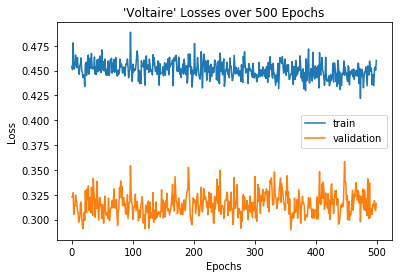

Average Training Score: 0.4506633852484679
Average Validation Score: 0.3154143735220035


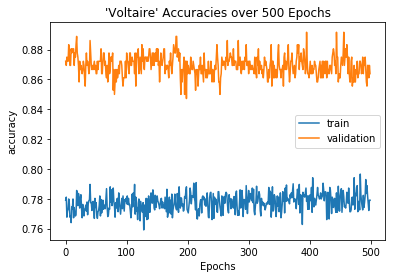

Average Training Score: 0.7776606997558991
Average Validation Score: 0.8695166666666666

validating on book: 'Defoe'
Epoch 0/499
----------



Phase:train
Confusion matrix:
 [[ 262  392]
 [  85 1743]]
loss 1114.7568847984076



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 73 156]]
loss 168.04745852947235
Epoch 1/499
----------



Phase:train
Confusion matrix:
 [[ 245  409]
 [  73 1755]]
loss 1018.7388320863247



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 68 161]]
loss 159.00572538375854
Epoch 2/499
----------



Phase:train
Confusion matrix:
 [[ 266  388]
 [ 113 1715]]
loss 1061.0464625060558



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 74 155]]
loss 160.8782308101654
Epoch 3/499
----------



Phase:train
Confusion matrix:
 [[ 263  391]
 [  94 1734]]
loss 1027.8494356870651



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 76 153]]
loss 158.91964048147202
Epoch 4/499
----------



Phase:train
Confusion matrix:
 [[ 271  383]
 [  91 1737]]
loss 1072.1782471314073



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 67 162]]
loss 160.84418326616287
Epoch 5/499
----------



Phase:train
Confusion matrix:
 [[ 225  429]
 [  66 1762]]
loss 1065.0357519686222



Phase:val
Confusion matrix:
 [[ 78  29]
 [ 66 163]]
loss 159.45725679397583
Epoch 6/499
----------



Phase:train
Confusion matrix:
 [[ 245  409]
 [  96 1732]]
loss 1064.8865380883217



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 72 157]]
loss 161.29976278543472
Epoch 7/499
----------



Phase:train
Confusion matrix:
 [[ 254  400]
 [  95 1733]]
loss 1021.3094554841518



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 63 166]]
loss 158.20681869983673
Epoch 8/499
----------



Phase:train
Confusion matrix:
 [[ 261  393]
 [  91 1737]]
loss 1024.5829009711742



Phase:val
Confusion matrix:
 [[ 76  31]
 [ 61 168]]
loss 156.96785777807236
Epoch 9/499
----------



Phase:train
Confusion matrix:
 [[ 244  410]
 [  77 1751]]
loss 1013.8822176754475



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 80 149]]
loss 162.34162789583206
Epoch 10/499
----------



Phase:train
Confusion matrix:
 [[ 285  369]
 [ 110 1718]]
loss 1028.300784572959



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 71 158]]
loss 158.6853553056717
Epoch 11/499
----------



Phase:train
Confusion matrix:
 [[ 246  408]
 [  85 1743]]
loss 1012.11791215837



Phase:val
Confusion matrix:
 [[ 74  33]
 [ 59 170]]
loss 155.27930665016174
Epoch 12/499
----------



Phase:train
Confusion matrix:
 [[ 256  398]
 [ 107 1721]]
loss 1038.5653354227543



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 70 159]]
loss 160.87093478441238
Epoch 13/499
----------



Phase:train
Confusion matrix:
 [[ 264  390]
 [  83 1745]]
loss 1024.5953063070774



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 64 165]]
loss 154.0472555756569
Epoch 14/499
----------



Phase:train
Confusion matrix:
 [[ 235  419]
 [  79 1749]]
loss 1090.1502435207367



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 77 152]]
loss 163.94252753257751
Epoch 15/499
----------



Phase:train
Confusion matrix:
 [[ 219  435]
 [  67 1761]]
loss 1052.8700243532658



Phase:val
Confusion matrix:
 [[ 65  42]
 [ 55 174]]
loss 159.03961396217346
Epoch 16/499
----------



Phase:train
Confusion matrix:
 [[ 235  419]
 [  69 1759]]
loss 1043.7534981667995



Phase:val
Confusion matrix:
 [[ 74  33]
 [ 64 165]]
loss 160.2654818892479
Epoch 17/499
----------



Phase:train
Confusion matrix:
 [[ 254  400]
 [  88 1740]]
loss 1025.9449243843555



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 65 164]]
loss 157.11945760250092
Epoch 18/499
----------



Phase:train
Confusion matrix:
 [[ 256  398]
 [ 101 1727]]
loss 1038.11217969656



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 71 158]]
loss 160.03233414888382
Epoch 19/499
----------



Phase:train
Confusion matrix:
 [[ 260  394]
 [ 101 1727]]
loss 1057.9847161471844



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 74 155]]
loss 156.6471068263054
Epoch 20/499
----------



Phase:train
Confusion matrix:
 [[ 259  395]
 [  72 1756]]
loss 1012.6571807712317



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 66 163]]
loss 155.50079202651978
Epoch 21/499
----------



Phase:train
Confusion matrix:
 [[ 255  399]
 [ 100 1728]]
loss 1025.5573674589396



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 69 160]]
loss 153.7313860654831
Epoch 22/499
----------



Phase:train
Confusion matrix:
 [[ 254  400]
 [  90 1738]]
loss 1039.9195440411568



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 69 160]]
loss 155.68431854248047
Epoch 23/499
----------



Phase:train
Confusion matrix:
 [[ 271  383]
 [  89 1739]]
loss 1015.4426206499338



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 70 159]]
loss 158.45764255523682
Epoch 24/499
----------



Phase:train
Confusion matrix:
 [[ 277  377]
 [ 109 1719]]
loss 1049.590440288186



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 72 157]]
loss 159.99803000688553
Epoch 25/499
----------



Phase:train
Confusion matrix:
 [[ 283  371]
 [ 108 1720]]
loss 1031.081997692585



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 72 157]]
loss 162.5910479426384
Epoch 26/499
----------



Phase:train
Confusion matrix:
 [[ 274  380]
 [ 112 1716]]
loss 1053.6392998099327



Phase:val
Confusion matrix:
 [[ 95  12]
 [ 87 142]]
loss 162.1202735900879
Epoch 27/499
----------



Phase:train
Confusion matrix:
 [[ 249  405]
 [  86 1742]]
loss 1037.0815567076206



Phase:val
Confusion matrix:
 [[ 95  12]
 [ 86 143]]
loss 161.38088190555573
Epoch 28/499
----------



Phase:train
Confusion matrix:
 [[ 266  388]
 [  97 1731]]
loss 1126.093562334776



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 84 145]]
loss 175.64041191339493
Epoch 29/499
----------



Phase:train
Confusion matrix:
 [[ 249  405]
 [  92 1736]]
loss 1055.7189734876156



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 74 155]]
loss 164.6012966632843
Epoch 30/499
----------



Phase:train
Confusion matrix:
 [[ 271  383]
 [  96 1732]]
loss 1047.4002845287323



Phase:val
Confusion matrix:
 [[ 98   9]
 [ 85 144]]
loss 164.8413674235344
Epoch 31/499
----------



Phase:train
Confusion matrix:
 [[ 248  406]
 [  69 1759]]
loss 1078.5555757582188



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 77 152]]
loss 167.29710865020752
Epoch 32/499
----------



Phase:train
Confusion matrix:
 [[ 260  394]
 [  97 1731]]
loss 1045.1269811689854



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 73 156]]
loss 162.7158868908882
Epoch 33/499
----------



Phase:train
Confusion matrix:
 [[ 256  398]
 [  80 1748]]
loss 1041.5470625013113



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 80 149]]
loss 162.88464879989624
Epoch 34/499
----------



Phase:train
Confusion matrix:
 [[ 257  397]
 [  98 1730]]
loss 1030.8323052972555



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 80 149]]
loss 161.58723813295364
Epoch 35/499
----------



Phase:train
Confusion matrix:
 [[ 263  391]
 [  96 1732]]
loss 1030.4912152141333



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 81 148]]
loss 163.14222770929337
Epoch 36/499
----------



Phase:train
Confusion matrix:
 [[ 263  391]
 [ 111 1717]]
loss 1053.4712724089622



Phase:val
Confusion matrix:
 [[ 93  14]
 [ 94 135]]
loss 170.48991817235947
Epoch 37/499
----------



Phase:train
Confusion matrix:
 [[ 243  411]
 [  92 1736]]
loss 1043.821584701538



Phase:val
Confusion matrix:
 [[ 89  18]
 [ 87 142]]
loss 164.4915755391121
Epoch 38/499
----------



Phase:train
Confusion matrix:
 [[ 267  387]
 [ 102 1726]]
loss 1046.4228838980198



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 79 150]]
loss 165.4606974720955
Epoch 39/499
----------



Phase:train
Confusion matrix:
 [[ 237  417]
 [  85 1743]]
loss 1061.9196209609509



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 73 156]]
loss 166.12546503543854
Epoch 40/499
----------



Phase:train
Confusion matrix:
 [[ 252  402]
 [  99 1729]]
loss 1030.1024345606565



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 76 153]]
loss 161.38699805736542
Epoch 41/499
----------



Phase:train
Confusion matrix:
 [[ 276  378]
 [  97 1731]]
loss 1024.6638392955065



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 75 154]]
loss 163.96595013141632
Epoch 42/499
----------



Phase:train
Confusion matrix:
 [[ 263  391]
 [ 106 1722]]
loss 1017.3829700499773



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 74 155]]
loss 161.4986167550087
Epoch 43/499
----------



Phase:train
Confusion matrix:
 [[ 276  378]
 [  95 1733]]
loss 1030.4771089702845



Phase:val
Confusion matrix:
 [[ 89  18]
 [ 89 140]]
loss 166.1311578154564
Epoch 44/499
----------



Phase:train
Confusion matrix:
 [[ 255  399]
 [  91 1737]]
loss 1020.3469801545143



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 77 152]]
loss 161.43177181482315
Epoch 45/499
----------



Phase:train
Confusion matrix:
 [[ 267  387]
 [ 107 1721]]
loss 1033.3613893687725



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 77 152]]
loss 160.11310631036758
Epoch 46/499
----------



Phase:train
Confusion matrix:
 [[ 269  385]
 [  91 1737]]
loss 1026.744102716446



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 76 153]]
loss 164.20124584436417
Epoch 47/499
----------



Phase:train
Confusion matrix:
 [[ 275  379]
 [  93 1735]]
loss 1036.2666331082582



Phase:val
Confusion matrix:
 [[ 92  15]
 [ 88 141]]
loss 169.32120740413666
Epoch 48/499
----------



Phase:train
Confusion matrix:
 [[ 254  400]
 [  92 1736]]
loss 1047.3579915612936



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 79 150]]
loss 166.45869308710098
Epoch 49/499
----------



Phase:train
Confusion matrix:
 [[ 260  394]
 [  91 1737]]
loss 1045.7291008085012



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 77 152]]
loss 163.90047240257263
Epoch 50/499
----------



Phase:train
Confusion matrix:
 [[ 255  399]
 [  91 1737]]
loss 1069.7834133207798



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 79 150]]
loss 165.10396260023117
Epoch 51/499
----------



Phase:train
Confusion matrix:
 [[ 216  438]
 [  66 1762]]
loss 1057.1936938464642



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 76 153]]
loss 162.54943495988846
Epoch 52/499
----------



Phase:train
Confusion matrix:
 [[ 278  376]
 [  98 1730]]
loss 991.916129887104



Phase:val
Confusion matrix:
 [[ 91  16]
 [ 84 145]]
loss 162.9472811818123
Epoch 53/499
----------



Phase:train
Confusion matrix:
 [[ 299  355]
 [ 120 1708]]
loss 1006.0032402127981



Phase:val
Confusion matrix:
 [[ 90  17]
 [ 81 148]]
loss 161.69680458307266
Epoch 54/499
----------



Phase:train
Confusion matrix:
 [[ 264  390]
 [  98 1730]]
loss 1030.0280426070094



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 85 144]]
loss 161.93550771474838
Epoch 55/499
----------



Phase:train
Confusion matrix:
 [[ 236  418]
 [  86 1742]]
loss 1089.5229573845863



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 79 150]]
loss 172.79041004180908
Epoch 56/499
----------



Phase:train
Confusion matrix:
 [[ 244  410]
 [  94 1734]]
loss 1076.4202811568975



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 82 147]]
loss 165.24649220705032
Epoch 57/499
----------



Phase:train
Confusion matrix:
 [[ 256  398]
 [ 105 1723]]
loss 1051.7597539126873



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 73 156]]
loss 162.19847041368484
Epoch 58/499
----------



Phase:train
Confusion matrix:
 [[ 261  393]
 [  83 1745]]
loss 1020.6040688157082



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 70 159]]
loss 162.9597305059433
Epoch 59/499
----------



Phase:train
Confusion matrix:
 [[ 271  383]
 [  95 1733]]
loss 1054.7799373567104



Phase:val
Confusion matrix:
 [[ 91  16]
 [ 93 136]]
loss 165.46384024620056
Epoch 60/499
----------



Phase:train
Confusion matrix:
 [[ 270  384]
 [ 103 1725]]
loss 1043.500442251563



Phase:val
Confusion matrix:
 [[ 90  17]
 [ 84 145]]
loss 162.5022451877594
Epoch 61/499
----------



Phase:train
Confusion matrix:
 [[ 274  380]
 [ 113 1715]]
loss 1052.3780782222748



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 81 148]]
loss 162.4372953772545
Epoch 62/499
----------



Phase:train
Confusion matrix:
 [[ 271  383]
 [ 111 1717]]
loss 1041.1207444369793



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 78 151]]
loss 160.28961116075516
Epoch 63/499
----------



Phase:train
Confusion matrix:
 [[ 242  412]
 [  80 1748]]
loss 1059.0196884274483



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 80 149]]
loss 162.6289165019989
Epoch 64/499
----------



Phase:train
Confusion matrix:
 [[ 277  377]
 [ 106 1722]]
loss 1036.9054248183966



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 78 151]]
loss 161.90060222148895
Epoch 65/499
----------



Phase:train
Confusion matrix:
 [[ 258  396]
 [ 102 1726]]
loss 1061.3040941506624



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 85 144]]
loss 164.52813017368317
Epoch 66/499
----------



Phase:train
Confusion matrix:
 [[ 305  349]
 [ 120 1708]]
loss 1009.0206526368856



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 83 146]]
loss 163.6579840183258
Epoch 67/499
----------



Phase:train
Confusion matrix:
 [[ 253  401]
 [  99 1729]]
loss 1054.9899975210428



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 71 158]]
loss 159.81423091888428
Epoch 68/499
----------



Phase:train
Confusion matrix:
 [[ 283  371]
 [  91 1737]]
loss 1004.8243849873543



Phase:val
Confusion matrix:
 [[ 79  28]
 [ 71 158]]
loss 164.10919606685638
Epoch 69/499
----------



Phase:train
Confusion matrix:
 [[ 241  413]
 [  99 1729]]
loss 1082.881610751152



Phase:val
Confusion matrix:
 [[ 78  29]
 [ 74 155]]
loss 163.69675254821777
Epoch 70/499
----------



Phase:train
Confusion matrix:
 [[ 230  424]
 [  78 1750]]
loss 1065.0037135630846



Phase:val
Confusion matrix:
 [[ 77  30]
 [ 70 159]]
loss 162.26526945829391
Epoch 71/499
----------



Phase:train
Confusion matrix:
 [[ 289  365]
 [  96 1732]]
loss 1001.8338814675808



Phase:val
Confusion matrix:
 [[ 90  17]
 [ 82 147]]
loss 164.41753500699997
Epoch 72/499
----------



Phase:train
Confusion matrix:
 [[ 262  392]
 [ 111 1717]]
loss 1055.070277363062



Phase:val
Confusion matrix:
 [[ 94  13]
 [ 88 141]]
loss 166.2386441230774
Epoch 73/499
----------



Phase:train
Confusion matrix:
 [[ 245  409]
 [  82 1746]]
loss 1018.5270073413849



Phase:val
Confusion matrix:
 [[ 76  31]
 [ 72 157]]
loss 163.27969980239868
Epoch 74/499
----------



Phase:train
Confusion matrix:
 [[ 262  392]
 [  81 1747]]
loss 1014.5783111900091



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 80 149]]
loss 162.22442883253098
Epoch 75/499
----------



Phase:train
Confusion matrix:
 [[ 254  400]
 [  90 1738]]
loss 1031.5909503996372



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 74 155]]
loss 162.36343657970428
Epoch 76/499
----------



Phase:train
Confusion matrix:
 [[ 247  407]
 [  82 1746]]
loss 1042.2806949913502



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 76 153]]
loss 161.22286278009415
Epoch 77/499
----------



Phase:train
Confusion matrix:
 [[ 282  372]
 [ 105 1723]]
loss 1017.9530853778124



Phase:val
Confusion matrix:
 [[ 90  17]
 [ 83 146]]
loss 163.73706674575806
Epoch 78/499
----------



Phase:train
Confusion matrix:
 [[ 257  397]
 [  91 1737]]
loss 1063.7541006952524



Phase:val
Confusion matrix:
 [[ 89  18]
 [ 79 150]]
loss 162.3885133266449
Epoch 79/499
----------



Phase:train
Confusion matrix:
 [[ 274  380]
 [ 103 1725]]
loss 1029.4354824721813



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 82 147]]
loss 162.67351925373077
Epoch 80/499
----------



Phase:train
Confusion matrix:
 [[ 250  404]
 [ 108 1720]]
loss 1053.903424307704



Phase:val
Confusion matrix:
 [[ 90  17]
 [ 90 139]]
loss 166.82091188430786
Epoch 81/499
----------



Phase:train
Confusion matrix:
 [[ 277  377]
 [ 123 1705]]
loss 1015.6847579777241



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 78 151]]
loss 161.8021433353424
Epoch 82/499
----------



Phase:train
Confusion matrix:
 [[ 271  383]
 [ 101 1727]]
loss 1059.3759204745293



Phase:val
Confusion matrix:
 [[ 78  29]
 [ 73 156]]
loss 163.97501695156097
Epoch 83/499
----------



Phase:train
Confusion matrix:
 [[ 258  396]
 [  99 1729]]
loss 1020.4775104224682



Phase:val
Confusion matrix:
 [[ 74  33]
 [ 74 155]]
loss 163.4967576265335
Epoch 84/499
----------



Phase:train
Confusion matrix:
 [[ 246  408]
 [  80 1748]]
loss 1028.7030502557755



Phase:val
Confusion matrix:
 [[ 79  28]
 [ 72 157]]
loss 163.43880188465118
Epoch 85/499
----------



Phase:train
Confusion matrix:
 [[ 269  385]
 [ 115 1713]]
loss 1026.5506906956434



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 75 154]]
loss 161.71502608060837
Epoch 86/499
----------



Phase:train
Confusion matrix:
 [[ 266  388]
 [  94 1734]]
loss 1047.301549345255



Phase:val
Confusion matrix:
 [[ 89  18]
 [ 83 146]]
loss 165.17076218128204
Epoch 87/499
----------



Phase:train
Confusion matrix:
 [[ 282  372]
 [ 118 1710]]
loss 1017.8699613511562



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 70 159]]
loss 160.28910851478577
Epoch 88/499
----------



Phase:train
Confusion matrix:
 [[ 255  399]
 [  95 1733]]
loss 1043.7058259770274



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 72 157]]
loss 163.34726107120514
Epoch 89/499
----------



Phase:train
Confusion matrix:
 [[ 263  391]
 [  92 1736]]
loss 1011.6822126805782



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 74 155]]
loss 159.46075403690338
Epoch 90/499
----------



Phase:train
Confusion matrix:
 [[ 258  396]
 [  88 1740]]
loss 1065.0785394608974



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 81 148]]
loss 172.22408306598663
Epoch 91/499
----------



Phase:train
Confusion matrix:
 [[ 264  390]
 [  90 1738]]
loss 1044.3873246908188



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 76 153]]
loss 166.0931737422943
Epoch 92/499
----------



Phase:train
Confusion matrix:
 [[ 275  379]
 [ 105 1723]]
loss 1025.6975046992302



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 79 150]]
loss 164.90831100940704
Epoch 93/499
----------



Phase:train
Confusion matrix:
 [[ 287  367]
 [ 112 1716]]
loss 1024.209092065692



Phase:val
Confusion matrix:
 [[ 95  12]
 [ 94 135]]
loss 164.96137750148773
Epoch 94/499
----------



Phase:train
Confusion matrix:
 [[ 262  392]
 [ 116 1712]]
loss 1048.388119801879



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 76 153]]
loss 163.02016907930374
Epoch 95/499
----------



Phase:train
Confusion matrix:
 [[ 257  397]
 [  98 1730]]
loss 1033.1776345074177



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 80 149]]
loss 163.05614310503006
Epoch 96/499
----------



Phase:train
Confusion matrix:
 [[ 269  385]
 [ 101 1727]]
loss 1026.8735591769218



Phase:val
Confusion matrix:
 [[ 94  13]
 [ 88 141]]
loss 166.7778149843216
Epoch 97/499
----------



Phase:train
Confusion matrix:
 [[ 260  394]
 [  91 1737]]
loss 1007.9189340770245



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 75 154]]
loss 162.54805308580399
Epoch 98/499
----------



Phase:train
Confusion matrix:
 [[ 282  372]
 [ 105 1723]]
loss 1032.9996478557587



Phase:val
Confusion matrix:
 [[ 70  37]
 [ 64 165]]
loss 162.14259558916092
Epoch 99/499
----------



Phase:train
Confusion matrix:
 [[ 245  409]
 [  77 1751]]
loss 1030.4522187709808



Phase:val
Confusion matrix:
 [[ 69  38]
 [ 66 163]]
loss 160.45061659812927
Epoch 100/499
----------



Phase:train
Confusion matrix:
 [[ 290  364]
 [ 119 1709]]
loss 1048.0470957905054



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 76 153]]
loss 164.20114260911942
Epoch 101/499
----------



Phase:train
Confusion matrix:
 [[ 248  406]
 [  83 1745]]
loss 1057.0899028033018



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 68 161]]
loss 162.1298012137413
Epoch 102/499
----------



Phase:train
Confusion matrix:
 [[ 258  396]
 [  85 1743]]
loss 1043.4521283060312



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 81 148]]
loss 168.8175674676895
Epoch 103/499
----------



Phase:train
Confusion matrix:
 [[ 251  403]
 [  98 1730]]
loss 1034.713063761592



Phase:val
Confusion matrix:
 [[ 71  36]
 [ 65 164]]
loss 162.54248243570328
Epoch 104/499
----------



Phase:train
Confusion matrix:
 [[ 247  407]
 [  90 1738]]
loss 1031.4373494535685



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 75 154]]
loss 164.33474510908127
Epoch 105/499
----------



Phase:train
Confusion matrix:
 [[ 273  381]
 [  97 1731]]
loss 1050.3780893087387



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 75 154]]
loss 166.83739626407623
Epoch 106/499
----------



Phase:train
Confusion matrix:
 [[ 231  423]
 [  75 1753]]
loss 1060.7120054364204



Phase:val
Confusion matrix:
 [[ 79  28]
 [ 70 159]]
loss 163.11562758684158
Epoch 107/499
----------



Phase:train
Confusion matrix:
 [[ 246  408]
 [  75 1753]]
loss 1036.7384650856256



Phase:val
Confusion matrix:
 [[ 90  17]
 [ 78 151]]
loss 163.26461333036423
Epoch 108/499
----------



Phase:train
Confusion matrix:
 [[ 289  365]
 [ 103 1725]]
loss 1023.5442646443844



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 77 152]]
loss 160.732876598835
Epoch 109/499
----------



Phase:train
Confusion matrix:
 [[ 252  402]
 [  93 1735]]
loss 1038.0590813308954



Phase:val
Confusion matrix:
 [[ 98   9]
 [ 91 138]]
loss 162.44843924045563
Epoch 110/499
----------



Phase:train
Confusion matrix:
 [[ 262  392]
 [  86 1742]]
loss 1031.9842336326838



Phase:val
Confusion matrix:
 [[ 90  17]
 [ 80 149]]
loss 161.20349550247192
Epoch 111/499
----------



Phase:train
Confusion matrix:
 [[ 264  390]
 [  79 1749]]
loss 1009.3204346895218



Phase:val
Confusion matrix:
 [[ 94  13]
 [ 83 146]]
loss 160.29714566469193
Epoch 112/499
----------



Phase:train
Confusion matrix:
 [[ 252  402]
 [  79 1749]]
loss 1035.5664382502437



Phase:val
Confusion matrix:
 [[ 89  18]
 [ 85 144]]
loss 163.42316335439682
Epoch 113/499
----------



Phase:train
Confusion matrix:
 [[ 254  400]
 [  85 1743]]
loss 1090.8076091259718



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 75 154]]
loss 165.61753749847412
Epoch 114/499
----------



Phase:train
Confusion matrix:
 [[ 256  398]
 [  94 1734]]
loss 1055.0950528979301



Phase:val
Confusion matrix:
 [[ 91  16]
 [ 85 144]]
loss 166.50583297014236
Epoch 115/499
----------



Phase:train
Confusion matrix:
 [[ 273  381]
 [  98 1730]]
loss 1033.0602342635393



Phase:val
Confusion matrix:
 [[ 93  14]
 [ 85 144]]
loss 168.9476479291916
Epoch 116/499
----------



Phase:train
Confusion matrix:
 [[ 289  365]
 [ 107 1721]]
loss 1007.2374900877476



Phase:val
Confusion matrix:
 [[ 89  18]
 [ 83 146]]
loss 168.60285955667496
Epoch 117/499
----------



Phase:train
Confusion matrix:
 [[ 244  410]
 [  93 1735]]
loss 1071.0232349932194



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 68 161]]
loss 165.54398810863495
Epoch 118/499
----------



Phase:train
Confusion matrix:
 [[ 233  421]
 [  69 1759]]
loss 1055.0469034165144



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 79 150]]
loss 167.13881886005402
Epoch 119/499
----------



Phase:train
Confusion matrix:
 [[ 277  377]
 [ 102 1726]]
loss 1004.9317324608564



Phase:val
Confusion matrix:
 [[ 90  17]
 [ 86 143]]
loss 168.38881039619446
Epoch 120/499
----------



Phase:train
Confusion matrix:
 [[ 258  396]
 [  93 1735]]
loss 1022.6696146279573



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 80 149]]
loss 166.81363773345947
Epoch 121/499
----------



Phase:train
Confusion matrix:
 [[ 229  425]
 [  91 1737]]
loss 1071.79407030344



Phase:val
Confusion matrix:
 [[ 65  42]
 [ 61 168]]
loss 167.9747588634491
Epoch 122/499
----------



Phase:train
Confusion matrix:
 [[ 237  417]
 [  81 1747]]
loss 1070.131660103798



Phase:val
Confusion matrix:
 [[ 76  31]
 [ 73 156]]
loss 165.21802693605423
Epoch 123/499
----------



Phase:train
Confusion matrix:
 [[ 282  372]
 [ 109 1719]]
loss 1016.7808212637901



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 78 151]]
loss 161.16225439310074
Epoch 124/499
----------



Phase:train
Confusion matrix:
 [[ 265  389]
 [ 105 1723]]
loss 1042.9501026123762



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 80 149]]
loss 162.39920604228973
Epoch 125/499
----------



Phase:train
Confusion matrix:
 [[ 261  393]
 [  93 1735]]
loss 1038.130743905902



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 76 153]]
loss 163.15672260522842
Epoch 126/499
----------



Phase:train
Confusion matrix:
 [[ 259  395]
 [  95 1733]]
loss 1035.5300875604153



Phase:val
Confusion matrix:
 [[ 79  28]
 [ 70 159]]
loss 163.7824885249138
Epoch 127/499
----------



Phase:train
Confusion matrix:
 [[ 257  397]
 [  80 1748]]
loss 1064.0661710649729



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 69 160]]
loss 162.96968668699265
Epoch 128/499
----------



Phase:train
Confusion matrix:
 [[ 223  431]
 [  69 1759]]
loss 1051.1328502893448



Phase:val
Confusion matrix:
 [[ 68  39]
 [ 60 169]]
loss 160.73818576335907
Epoch 129/499
----------



Phase:train
Confusion matrix:
 [[ 243  411]
 [  76 1752]]
loss 1024.5295612812042



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 76 153]]
loss 166.89376193284988
Epoch 130/499
----------



Phase:train
Confusion matrix:
 [[ 272  382]
 [  98 1730]]
loss 1036.4720991253853



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 82 147]]
loss 167.33444619178772
Epoch 131/499
----------



Phase:train
Confusion matrix:
 [[ 258  396]
 [  99 1729]]
loss 1044.821071535349



Phase:val
Confusion matrix:
 [[ 91  16]
 [ 80 149]]
loss 165.43598276376724
Epoch 132/499
----------



Phase:train
Confusion matrix:
 [[ 255  399]
 [  96 1732]]
loss 1019.039210781455



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 85 144]]
loss 169.74055767059326
Epoch 133/499
----------



Phase:train
Confusion matrix:
 [[ 254  400]
 [ 100 1728]]
loss 1055.2845398187637



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 85 144]]
loss 168.72211438417435
Epoch 134/499
----------



Phase:train
Confusion matrix:
 [[ 237  417]
 [  82 1746]]
loss 1057.6269276738167



Phase:val
Confusion matrix:
 [[ 79  28]
 [ 69 160]]
loss 162.2685905098915
Epoch 135/499
----------



Phase:train
Confusion matrix:
 [[ 244  410]
 [  89 1739]]
loss 1059.8055893033743



Phase:val
Confusion matrix:
 [[ 76  31]
 [ 66 163]]
loss 163.58966809511185
Epoch 136/499
----------



Phase:train
Confusion matrix:
 [[ 239  415]
 [  61 1767]]
loss 1030.4590498507023



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 85 144]]
loss 162.38346868753433
Epoch 137/499
----------



Phase:train
Confusion matrix:
 [[ 248  406]
 [  76 1752]]
loss 1027.1250529289246



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 74 155]]
loss 158.25459176301956
Epoch 138/499
----------



Phase:train
Confusion matrix:
 [[ 267  387]
 [ 103 1725]]
loss 1024.107781022787



Phase:val
Confusion matrix:
 [[ 89  18]
 [ 82 147]]
loss 159.7624153494835
Epoch 139/499
----------



Phase:train
Confusion matrix:
 [[ 256  398]
 [  86 1742]]
loss 1026.18313357234



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 84 145]]
loss 161.8591883778572
Epoch 140/499
----------



Phase:train
Confusion matrix:
 [[ 256  398]
 [  94 1734]]
loss 1022.5143210440874



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 79 150]]
loss 163.57999688386917
Epoch 141/499
----------



Phase:train
Confusion matrix:
 [[ 245  409]
 [  86 1742]]
loss 1020.7462683320045



Phase:val
Confusion matrix:
 [[ 77  30]
 [ 68 161]]
loss 158.94900178909302
Epoch 142/499
----------



Phase:train
Confusion matrix:
 [[ 262  392]
 [  97 1731]]
loss 1025.055790066719



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 77 152]]
loss 163.7474928498268
Epoch 143/499
----------



Phase:train
Confusion matrix:
 [[ 277  377]
 [  93 1735]]
loss 1000.2288225740194



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 78 151]]
loss 162.38733911514282
Epoch 144/499
----------



Phase:train
Confusion matrix:
 [[ 288  366]
 [ 114 1714]]
loss 994.7054458707571



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 77 152]]
loss 158.07296842336655
Epoch 145/499
----------



Phase:train
Confusion matrix:
 [[ 253  401]
 [  97 1731]]
loss 1089.1527025550604



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 81 148]]
loss 165.53464049100876
Epoch 146/499
----------



Phase:train
Confusion matrix:
 [[ 235  419]
 [  97 1731]]
loss 1069.319127947092



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 77 152]]
loss 161.66998851299286
Epoch 147/499
----------



Phase:train
Confusion matrix:
 [[ 264  390]
 [  99 1729]]
loss 1029.80849686265



Phase:val
Confusion matrix:
 [[ 79  28]
 [ 69 160]]
loss 160.2550505399704
Epoch 148/499
----------



Phase:train
Confusion matrix:
 [[ 239  415]
 [  73 1755]]
loss 1047.3731346726418



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 71 158]]
loss 162.73087984323502
Epoch 149/499
----------



Phase:train
Confusion matrix:
 [[ 253  401]
 [ 101 1727]]
loss 1029.7276846021414



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 72 157]]
loss 162.70964348316193
Epoch 150/499
----------



Phase:train
Confusion matrix:
 [[ 248  406]
 [  93 1735]]
loss 1036.8963022083044



Phase:val
Confusion matrix:
 [[ 75  32]
 [ 72 157]]
loss 163.1142978668213
Epoch 151/499
----------



Phase:train
Confusion matrix:
 [[ 270  384]
 [ 109 1719]]
loss 1019.7269461452961



Phase:val
Confusion matrix:
 [[ 77  30]
 [ 71 158]]
loss 162.75266045331955
Epoch 152/499
----------



Phase:train
Confusion matrix:
 [[ 275  379]
 [ 111 1717]]
loss 1058.436155512929



Phase:val
Confusion matrix:
 [[ 96  11]
 [ 87 142]]
loss 165.16421991586685
Epoch 153/499
----------



Phase:train
Confusion matrix:
 [[ 224  430]
 [  91 1737]]
loss 1086.1981408596039



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 66 163]]
loss 162.94031351804733
Epoch 154/499
----------



Phase:train
Confusion matrix:
 [[ 222  432]
 [  73 1755]]
loss 1039.1823160797358



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 77 152]]
loss 161.89139491319656
Epoch 155/499
----------



Phase:train
Confusion matrix:
 [[ 272  382]
 [  98 1730]]
loss 1001.2953765839338



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 78 151]]
loss 160.971067070961
Epoch 156/499
----------



Phase:train
Confusion matrix:
 [[ 247  407]
 [  95 1733]]
loss 1070.5498331040144



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 72 157]]
loss 161.91084229946136
Epoch 157/499
----------



Phase:train
Confusion matrix:
 [[ 256  398]
 [  86 1742]]
loss 1032.0061139464378



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 78 151]]
loss 165.4199157357216
Epoch 158/499
----------



Phase:train
Confusion matrix:
 [[ 279  375]
 [ 100 1728]]
loss 1010.6944673657417



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 71 158]]
loss 161.88598477840424
Epoch 159/499
----------



Phase:train
Confusion matrix:
 [[ 262  392]
 [  97 1731]]
loss 1056.9299193397164



Phase:val
Confusion matrix:
 [[ 96  11]
 [ 94 135]]
loss 167.1453713774681
Epoch 160/499
----------



Phase:train
Confusion matrix:
 [[ 234  420]
 [ 107 1721]]
loss 1088.5475937128067



Phase:val
Confusion matrix:
 [[ 77  30]
 [ 70 159]]
loss 164.15658497810364
Epoch 161/499
----------



Phase:train
Confusion matrix:
 [[ 248  406]
 [  81 1747]]
loss 1034.4307099580765



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 76 153]]
loss 162.74741727113724
Epoch 162/499
----------



Phase:train
Confusion matrix:
 [[ 266  388]
 [ 107 1721]]
loss 1009.3131913542747



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 76 153]]
loss 164.05471485853195
Epoch 163/499
----------



Phase:train
Confusion matrix:
 [[ 236  418]
 [  92 1736]]
loss 1053.6865221560001



Phase:val
Confusion matrix:
 [[ 68  39]
 [ 63 166]]
loss 158.67444437742233
Epoch 164/499
----------



Phase:train
Confusion matrix:
 [[ 214  440]
 [  72 1756]]
loss 1048.2914177775383



Phase:val
Confusion matrix:
 [[ 58  49]
 [ 56 173]]
loss 158.86237800121307
Epoch 165/499
----------



Phase:train
Confusion matrix:
 [[ 244  410]
 [  89 1739]]
loss 1035.899332344532



Phase:val
Confusion matrix:
 [[ 72  35]
 [ 65 164]]
loss 159.83563297986984
Epoch 166/499
----------



Phase:train
Confusion matrix:
 [[ 247  407]
 [  80 1748]]
loss 1045.6365559399128



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 81 148]]
loss 163.07698559761047
Epoch 167/499
----------



Phase:train
Confusion matrix:
 [[ 252  402]
 [  92 1736]]
loss 1052.5909233093262



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 75 154]]
loss 164.2502086162567
Epoch 168/499
----------



Phase:train
Confusion matrix:
 [[ 275  379]
 [ 103 1725]]
loss 1042.0814363658428



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 80 149]]
loss 169.2299816608429
Epoch 169/499
----------



Phase:train
Confusion matrix:
 [[ 266  388]
 [  89 1739]]
loss 1029.638620391488



Phase:val
Confusion matrix:
 [[ 76  31]
 [ 65 164]]
loss 160.71498155593872
Epoch 170/499
----------



Phase:train
Confusion matrix:
 [[ 259  395]
 [  87 1741]]
loss 986.2828159481287



Phase:val
Confusion matrix:
 [[ 77  30]
 [ 65 164]]
loss 157.66701072454453
Epoch 171/499
----------



Phase:train
Confusion matrix:
 [[ 241  413]
 [  78 1750]]
loss 1043.5976135730743



Phase:val
Confusion matrix:
 [[ 77  30]
 [ 71 158]]
loss 160.5910364985466
Epoch 172/499
----------



Phase:train
Confusion matrix:
 [[ 237  417]
 [  75 1753]]
loss 1020.0833192765713



Phase:val
Confusion matrix:
 [[ 89  18]
 [ 83 146]]
loss 164.54809588193893
Epoch 173/499
----------



Phase:train
Confusion matrix:
 [[ 261  393]
 [ 107 1721]]
loss 1028.353834912181



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 72 157]]
loss 166.4104427099228
Epoch 174/499
----------



Phase:train
Confusion matrix:
 [[ 270  384]
 [  92 1736]]
loss 1008.1866919547319



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 72 157]]
loss 165.0047383904457
Epoch 175/499
----------



Phase:train
Confusion matrix:
 [[ 250  404]
 [  94 1734]]
loss 1050.5270813256502



Phase:val
Confusion matrix:
 [[ 72  35]
 [ 70 159]]
loss 163.1545134782791
Epoch 176/499
----------



Phase:train
Confusion matrix:
 [[ 256  398]
 [  86 1742]]
loss 1043.693382203579



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 76 153]]
loss 164.90288943052292
Epoch 177/499
----------



Phase:train
Confusion matrix:
 [[ 266  388]
 [  85 1743]]
loss 1015.7197493314743



Phase:val
Confusion matrix:
 [[ 64  43]
 [ 53 176]]
loss 162.73650735616684
Epoch 178/499
----------



Phase:train
Confusion matrix:
 [[ 254  400]
 [  65 1763]]
loss 1033.426353186369



Phase:val
Confusion matrix:
 [[ 78  29]
 [ 68 161]]
loss 163.56829071044922
Epoch 179/499
----------



Phase:train
Confusion matrix:
 [[ 275  379]
 [ 118 1710]]
loss 1022.5510333478451



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 79 150]]
loss 166.3205184340477
Epoch 180/499
----------



Phase:train
Confusion matrix:
 [[ 260  394]
 [  94 1734]]
loss 1037.2101745605469



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 89 140]]
loss 167.48808884620667
Epoch 181/499
----------



Phase:train
Confusion matrix:
 [[ 264  390]
 [ 107 1721]]
loss 1047.3516832143068



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 77 152]]
loss 166.02420914173126
Epoch 182/499
----------



Phase:train
Confusion matrix:
 [[ 259  395]
 [ 102 1726]]
loss 1047.8875294178724



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 72 157]]
loss 166.19256860017776
Epoch 183/499
----------



Phase:train
Confusion matrix:
 [[ 293  361]
 [ 109 1719]]
loss 1049.6923666149378



Phase:val
Confusion matrix:
 [[ 92  15]
 [ 97 132]]
loss 169.74267303943634
Epoch 184/499
----------



Phase:train
Confusion matrix:
 [[ 239  415]
 [  88 1740]]
loss 1042.9058228433132



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 81 148]]
loss 163.79150128364563
Epoch 185/499
----------



Phase:train
Confusion matrix:
 [[ 276  378]
 [  96 1732]]
loss 1008.3690411001444



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 81 148]]
loss 165.49109637737274
Epoch 186/499
----------



Phase:train
Confusion matrix:
 [[ 279  375]
 [  87 1741]]
loss 1014.6980099081993



Phase:val
Confusion matrix:
 [[ 94  13]
 [ 92 137]]
loss 167.94660222530365
Epoch 187/499
----------



Phase:train
Confusion matrix:
 [[ 253  401]
 [ 108 1720]]
loss 1078.3192596286535



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 75 154]]
loss 164.0642077922821
Epoch 188/499
----------



Phase:train
Confusion matrix:
 [[ 242  412]
 [  90 1738]]
loss 1045.756218150258



Phase:val
Confusion matrix:
 [[ 94  13]
 [ 91 138]]
loss 167.581180870533
Epoch 189/499
----------



Phase:train
Confusion matrix:
 [[ 240  414]
 [  72 1756]]
loss 1029.3525426238775



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 85 144]]
loss 174.95143103599548
Epoch 190/499
----------



Phase:train
Confusion matrix:
 [[ 255  399]
 [  87 1741]]
loss 1055.2348527312279



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 81 148]]
loss 168.34428304433823
Epoch 191/499
----------



Phase:train
Confusion matrix:
 [[ 270  384]
 [  93 1735]]
loss 1000.4012709259987



Phase:val
Confusion matrix:
 [[ 90  17]
 [ 84 145]]
loss 168.7735756635666
Epoch 192/499
----------



Phase:train
Confusion matrix:
 [[ 276  378]
 [  99 1729]]
loss 1013.9404754042625



Phase:val
Confusion matrix:
 [[ 89  18]
 [ 85 144]]
loss 167.73767584562302
Epoch 193/499
----------



Phase:train
Confusion matrix:
 [[ 249  405]
 [  83 1745]]
loss 1035.4765606075525



Phase:val
Confusion matrix:
 [[ 92  15]
 [ 82 147]]
loss 162.57181376218796
Epoch 194/499
----------



Phase:train
Confusion matrix:
 [[ 264  390]
 [ 101 1727]]
loss 1018.2234576195478



Phase:val
Confusion matrix:
 [[ 90  17]
 [ 86 143]]
loss 166.5656578540802
Epoch 195/499
----------



Phase:train
Confusion matrix:
 [[ 273  381]
 [  96 1732]]
loss 1047.2146975547075



Phase:val
Confusion matrix:
 [[ 89  18]
 [ 86 143]]
loss 166.8201737999916
Epoch 196/499
----------



Phase:train
Confusion matrix:
 [[ 250  404]
 [  85 1743]]
loss 1025.4652276337147



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 77 152]]
loss 165.09519535303116
Epoch 197/499
----------



Phase:train
Confusion matrix:
 [[ 284  370]
 [ 107 1721]]
loss 1027.3158856481314



Phase:val
Confusion matrix:
 [[ 92  15]
 [ 88 141]]
loss 169.01213002204895
Epoch 198/499
----------



Phase:train
Confusion matrix:
 [[ 265  389]
 [  93 1735]]
loss 1009.2067925482988



Phase:val
Confusion matrix:
 [[ 94  13]
 [ 89 140]]
loss 166.0986977815628
Epoch 199/499
----------



Phase:train
Confusion matrix:
 [[ 271  383]
 [ 109 1719]]
loss 1050.0390974283218



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 81 148]]
loss 167.59643214941025
Epoch 200/499
----------



Phase:train
Confusion matrix:
 [[ 271  383]
 [ 107 1721]]
loss 1055.1157508939505



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 80 149]]
loss 165.89245307445526
Epoch 201/499
----------



Phase:train
Confusion matrix:
 [[ 269  385]
 [  99 1729]]
loss 1020.7030377984047



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 81 148]]
loss 164.25906610488892
Epoch 202/499
----------



Phase:train
Confusion matrix:
 [[ 247  407]
 [ 111 1717]]
loss 1050.8594691455364



Phase:val
Confusion matrix:
 [[ 76  31]
 [ 76 153]]
loss 167.2372077703476
Epoch 203/499
----------



Phase:train
Confusion matrix:
 [[ 263  391]
 [  81 1747]]
loss 1012.644049346447



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 71 158]]
loss 160.4984985589981
Epoch 204/499
----------



Phase:train
Confusion matrix:
 [[ 281  373]
 [  98 1730]]
loss 992.8106167018414



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 75 154]]
loss 159.448477268219
Epoch 205/499
----------



Phase:train
Confusion matrix:
 [[ 253  401]
 [  85 1743]]
loss 1061.3043752163649



Phase:val
Confusion matrix:
 [[100   7]
 [104 125]]
loss 177.11580723524094
Epoch 206/499
----------



Phase:train
Confusion matrix:
 [[ 248  406]
 [ 104 1724]]
loss 1089.3533704429865



Phase:val
Confusion matrix:
 [[ 94  13]
 [ 80 149]]
loss 165.7501769065857
Epoch 207/499
----------



Phase:train
Confusion matrix:
 [[ 248  406]
 [  85 1743]]
loss 1036.870995014906



Phase:val
Confusion matrix:
 [[ 79  28]
 [ 72 157]]
loss 164.3377384543419
Epoch 208/499
----------



Phase:train
Confusion matrix:
 [[ 245  409]
 [  95 1733]]
loss 1054.9257304668427



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 73 156]]
loss 161.88322204351425
Epoch 209/499
----------



Phase:train
Confusion matrix:
 [[ 246  408]
 [  94 1734]]
loss 1033.312842220068



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 76 153]]
loss 164.4848141670227
Epoch 210/499
----------



Phase:train
Confusion matrix:
 [[ 279  375]
 [ 107 1721]]
loss 1022.3016832321882



Phase:val
Confusion matrix:
 [[ 89  18]
 [ 80 149]]
loss 164.3032408952713
Epoch 211/499
----------



Phase:train
Confusion matrix:
 [[ 275  379]
 [ 107 1721]]
loss 1031.0689407587051



Phase:val
Confusion matrix:
 [[ 89  18]
 [ 80 149]]
loss 168.04711949825287
Epoch 212/499
----------



Phase:train
Confusion matrix:
 [[ 313  341]
 [ 124 1704]]
loss 1026.6620889604092



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 81 148]]
loss 167.08174043893814
Epoch 213/499
----------



Phase:train
Confusion matrix:
 [[ 301  353]
 [ 122 1706]]
loss 1025.463790655136



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 81 148]]
loss 163.7741482257843
Epoch 214/499
----------



Phase:train
Confusion matrix:
 [[ 254  400]
 [ 110 1718]]
loss 1055.110168710351



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 80 149]]
loss 163.54114592075348
Epoch 215/499
----------



Phase:train
Confusion matrix:
 [[ 269  385]
 [ 109 1719]]
loss 1021.1929257214069



Phase:val
Confusion matrix:
 [[ 90  17]
 [ 83 146]]
loss 164.3328527212143
Epoch 216/499
----------



Phase:train
Confusion matrix:
 [[ 253  401]
 [ 101 1727]]
loss 1039.6233721226454



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 77 152]]
loss 161.54572665691376
Epoch 217/499
----------



Phase:train
Confusion matrix:
 [[ 287  367]
 [  84 1744]]
loss 1008.714962080121



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 73 156]]
loss 161.81241965293884
Epoch 218/499
----------



Phase:train
Confusion matrix:
 [[ 247  407]
 [  93 1735]]
loss 1033.1710499227047



Phase:val
Confusion matrix:
 [[ 78  29]
 [ 72 157]]
loss 164.23782056570053
Epoch 219/499
----------



Phase:train
Confusion matrix:
 [[ 285  369]
 [  91 1737]]
loss 1041.811185196042



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 81 148]]
loss 164.93372148275375
Epoch 220/499
----------



Phase:train
Confusion matrix:
 [[ 263  391]
 [  99 1729]]
loss 1029.719445720315



Phase:val
Confusion matrix:
 [[ 90  17]
 [ 80 149]]
loss 168.49982541799545
Epoch 221/499
----------



Phase:train
Confusion matrix:
 [[ 261  393]
 [ 105 1723]]
loss 1028.2348157316446



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 72 157]]
loss 166.00037932395935
Epoch 222/499
----------



Phase:train
Confusion matrix:
 [[ 276  378]
 [  96 1732]]
loss 1029.09801363945



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 88 141]]
loss 168.1509925723076
Epoch 223/499
----------



Phase:train
Confusion matrix:
 [[ 255  399]
 [  95 1733]]
loss 1056.2594002783298



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 73 156]]
loss 167.9933135509491
Epoch 224/499
----------



Phase:train
Confusion matrix:
 [[ 266  388]
 [ 105 1723]]
loss 1038.4020926058292



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 78 151]]
loss 168.7009518146515
Epoch 225/499
----------



Phase:train
Confusion matrix:
 [[ 269  385]
 [ 105 1723]]
loss 1010.6676511764526



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 80 149]]
loss 167.10472440719604
Epoch 226/499
----------



Phase:train
Confusion matrix:
 [[ 272  382]
 [  88 1740]]
loss 1043.5444158613682



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 72 157]]
loss 168.70358735322952
Epoch 227/499
----------



Phase:train
Confusion matrix:
 [[ 277  377]
 [ 115 1713]]
loss 1051.731743261218



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 83 146]]
loss 173.56355452537537
Epoch 228/499
----------



Phase:train
Confusion matrix:
 [[ 295  359]
 [ 112 1716]]
loss 1010.4957398921251



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 81 148]]
loss 166.3971427679062
Epoch 229/499
----------



Phase:train
Confusion matrix:
 [[ 268  386]
 [ 104 1724]]
loss 1062.574790686369



Phase:val
Confusion matrix:
 [[ 90  17]
 [ 86 143]]
loss 167.82812160253525
Epoch 230/499
----------



Phase:train
Confusion matrix:
 [[ 236  418]
 [  94 1734]]
loss 1055.710084155202



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 75 154]]
loss 165.76503688097
Epoch 231/499
----------



Phase:train
Confusion matrix:
 [[ 264  390]
 [  86 1742]]
loss 1029.1297567784786



Phase:val
Confusion matrix:
 [[ 90  17]
 [ 94 135]]
loss 176.75802844762802
Epoch 232/499
----------



Phase:train
Confusion matrix:
 [[ 258  396]
 [  92 1736]]
loss 1013.8080025911331



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 82 147]]
loss 167.32435113191605
Epoch 233/499
----------



Phase:train
Confusion matrix:
 [[ 282  372]
 [  94 1734]]
loss 1021.8549959510565



Phase:val
Confusion matrix:
 [[ 91  16]
 [ 86 143]]
loss 165.78416353464127
Epoch 234/499
----------



Phase:train
Confusion matrix:
 [[ 257  397]
 [  79 1749]]
loss 1030.730817809701



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 77 152]]
loss 166.3033577799797
Epoch 235/499
----------



Phase:train
Confusion matrix:
 [[ 263  391]
 [  94 1734]]
loss 1036.5134408026934



Phase:val
Confusion matrix:
 [[ 78  29]
 [ 77 152]]
loss 163.14814233779907
Epoch 236/499
----------



Phase:train
Confusion matrix:
 [[ 250  404]
 [  82 1746]]
loss 1021.5465160980821



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 82 147]]
loss 165.49200016260147
Epoch 237/499
----------



Phase:train
Confusion matrix:
 [[ 247  407]
 [  79 1749]]
loss 1066.8551992624998



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 75 154]]
loss 165.20733588933945
Epoch 238/499
----------



Phase:train
Confusion matrix:
 [[ 286  368]
 [  96 1732]]
loss 1001.0295483097434



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 78 151]]
loss 165.1353155374527
Epoch 239/499
----------



Phase:train
Confusion matrix:
 [[ 266  388]
 [  90 1738]]
loss 998.8006866574287



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 75 154]]
loss 164.82582437992096
Epoch 240/499
----------



Phase:train
Confusion matrix:
 [[ 261  393]
 [ 128 1700]]
loss 1057.861244827509



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 76 153]]
loss 177.32682955265045
Epoch 241/499
----------



Phase:train
Confusion matrix:
 [[ 280  374]
 [ 116 1712]]
loss 1044.5338708683848



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 78 151]]
loss 163.2770048379898
Epoch 242/499
----------



Phase:train
Confusion matrix:
 [[ 256  398]
 [  87 1741]]
loss 1036.820850238204



Phase:val
Confusion matrix:
 [[ 92  15]
 [ 86 143]]
loss 163.28159362077713
Epoch 243/499
----------



Phase:train
Confusion matrix:
 [[ 230  424]
 [  80 1748]]
loss 1067.580727264285



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 83 146]]
loss 167.594682097435
Epoch 244/499
----------



Phase:train
Confusion matrix:
 [[ 264  390]
 [ 111 1717]]
loss 1057.157597631216



Phase:val
Confusion matrix:
 [[ 78  29]
 [ 70 159]]
loss 167.5828400850296
Epoch 245/499
----------



Phase:train
Confusion matrix:
 [[ 256  398]
 [  87 1741]]
loss 1003.857853487134



Phase:val
Confusion matrix:
 [[ 79  28]
 [ 71 158]]
loss 166.23295390605927
Epoch 246/499
----------



Phase:train
Confusion matrix:
 [[ 265  389]
 [ 105 1723]]
loss 1047.8527102470398



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 84 145]]
loss 165.67740857601166
Epoch 247/499
----------



Phase:train
Confusion matrix:
 [[ 265  389]
 [ 103 1725]]
loss 1015.6640909612179



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 74 155]]
loss 163.6793246269226
Epoch 248/499
----------



Phase:train
Confusion matrix:
 [[ 287  367]
 [  97 1731]]
loss 1004.0458110272884



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 72 157]]
loss 163.22567522525787
Epoch 249/499
----------



Phase:train
Confusion matrix:
 [[ 271  383]
 [  94 1734]]
loss 1029.53033721447



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 85 144]]
loss 171.432675242424
Epoch 250/499
----------



Phase:train
Confusion matrix:
 [[ 288  366]
 [ 126 1702]]
loss 1044.8373109847307



Phase:val
Confusion matrix:
 [[ 78  29]
 [ 70 159]]
loss 165.50598001480103
Epoch 251/499
----------



Phase:train
Confusion matrix:
 [[ 293  361]
 [ 106 1722]]
loss 1045.0581122636795



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 83 146]]
loss 170.46558767557144
Epoch 252/499
----------



Phase:train
Confusion matrix:
 [[ 270  384]
 [ 103 1725]]
loss 1022.2356716990471



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 83 146]]
loss 169.78407627344131
Epoch 253/499
----------



Phase:train
Confusion matrix:
 [[ 292  362]
 [  99 1729]]
loss 1020.9157382845879



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 81 148]]
loss 172.04407209157944
Epoch 254/499
----------



Phase:train
Confusion matrix:
 [[ 287  367]
 [ 119 1709]]
loss 1029.948603451252



Phase:val
Confusion matrix:
 [[ 95  12]
 [ 92 137]]
loss 166.50758332014084
Epoch 255/499
----------



Phase:train
Confusion matrix:
 [[ 256  398]
 [  97 1731]]
loss 1031.4324756860733



Phase:val
Confusion matrix:
 [[ 90  17]
 [ 87 142]]
loss 164.85497307777405
Epoch 256/499
----------



Phase:train
Confusion matrix:
 [[ 275  379]
 [ 120 1708]]
loss 1006.2158198803663



Phase:val
Confusion matrix:
 [[ 94  13]
 [ 92 137]]
loss 167.85190123319626
Epoch 257/499
----------



Phase:train
Confusion matrix:
 [[ 270  384]
 [  82 1746]]
loss 1002.1442637890577



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 82 147]]
loss 166.24789905548096
Epoch 258/499
----------



Phase:train
Confusion matrix:
 [[ 278  376]
 [ 109 1719]]
loss 1021.7597221583128



Phase:val
Confusion matrix:
 [[ 94  13]
 [ 86 143]]
loss 174.35742127895355
Epoch 259/499
----------



Phase:train
Confusion matrix:
 [[ 282  372]
 [ 120 1708]]
loss 1016.6155958473682



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 84 145]]
loss 168.18582648038864
Epoch 260/499
----------



Phase:train
Confusion matrix:
 [[ 250  404]
 [  91 1737]]
loss 1033.8630347698927



Phase:val
Confusion matrix:
 [[ 79  28]
 [ 72 157]]
loss 165.20351445674896
Epoch 261/499
----------



Phase:train
Confusion matrix:
 [[ 246  408]
 [  91 1737]]
loss 1051.3656019866467



Phase:val
Confusion matrix:
 [[ 77  30]
 [ 72 157]]
loss 165.6683651804924
Epoch 262/499
----------



Phase:train
Confusion matrix:
 [[ 255  399]
 [  96 1732]]
loss 1058.0764546245337



Phase:val
Confusion matrix:
 [[ 71  36]
 [ 64 165]]
loss 161.14305764436722
Epoch 263/499
----------



Phase:train
Confusion matrix:
 [[ 241  413]
 [  81 1747]]
loss 1014.8456755131483



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 83 146]]
loss 168.94570672512054
Epoch 264/499
----------



Phase:train
Confusion matrix:
 [[ 287  367]
 [ 106 1722]]
loss 1037.3121547698975



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 85 144]]
loss 170.13847535848618
Epoch 265/499
----------



Phase:train
Confusion matrix:
 [[ 261  393]
 [  92 1736]]
loss 1040.947974100709



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 71 158]]
loss 166.95688742399216
Epoch 266/499
----------



Phase:train
Confusion matrix:
 [[ 261  393]
 [  88 1740]]
loss 1015.4676101356745



Phase:val
Confusion matrix:
 [[ 90  17]
 [ 84 145]]
loss 167.59097522497177
Epoch 267/499
----------



Phase:train
Confusion matrix:
 [[ 278  376]
 [ 104 1724]]
loss 1027.8277741670609



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 80 149]]
loss 162.93512696027756
Epoch 268/499
----------



Phase:train
Confusion matrix:
 [[ 277  377]
 [  94 1734]]
loss 995.0843391790986



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 74 155]]
loss 161.0659139752388
Epoch 269/499
----------



Phase:train
Confusion matrix:
 [[ 274  380]
 [  95 1733]]
loss 1010.3144010901451



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 78 151]]
loss 161.51900881528854
Epoch 270/499
----------



Phase:train
Confusion matrix:
 [[ 270  384]
 [ 111 1717]]
loss 1005.1962060928345



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 76 153]]
loss 164.5377231836319
Epoch 271/499
----------



Phase:train
Confusion matrix:
 [[ 276  378]
 [ 121 1707]]
loss 1080.3007911592722



Phase:val
Confusion matrix:
 [[ 67  40]
 [ 73 156]]
loss 170.3896159529686
Epoch 272/499
----------



Phase:train
Confusion matrix:
 [[ 219  435]
 [  72 1756]]
loss 1091.836602807045



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 78 151]]
loss 165.96019476652145
Epoch 273/499
----------



Phase:train
Confusion matrix:
 [[ 238  416]
 [  82 1746]]
loss 1057.203948378563



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 77 152]]
loss 163.0301125049591
Epoch 274/499
----------



Phase:train
Confusion matrix:
 [[ 257  397]
 [  95 1733]]
loss 1001.7788425683975



Phase:val
Confusion matrix:
 [[ 93  14]
 [ 84 145]]
loss 163.61136305332184
Epoch 275/499
----------



Phase:train
Confusion matrix:
 [[ 274  380]
 [ 103 1725]]
loss 1047.3777988553047



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 75 154]]
loss 168.8603693842888
Epoch 276/499
----------



Phase:train
Confusion matrix:
 [[ 262  392]
 [ 100 1728]]
loss 1019.4814202338457



Phase:val
Confusion matrix:
 [[ 90  17]
 [ 80 149]]
loss 166.12308913469315
Epoch 277/499
----------



Phase:train
Confusion matrix:
 [[ 269  385]
 [  97 1731]]
loss 991.3283097296953



Phase:val
Confusion matrix:
 [[ 90  17]
 [ 84 145]]
loss 168.72384428977966
Epoch 278/499
----------



Phase:train
Confusion matrix:
 [[ 260  394]
 [  89 1739]]
loss 1036.750385478139



Phase:val
Confusion matrix:
 [[ 92  15]
 [ 89 140]]
loss 168.18871343135834
Epoch 279/499
----------



Phase:train
Confusion matrix:
 [[ 243  411]
 [  93 1735]]
loss 1065.9296070635319



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 71 158]]
loss 164.19178181886673
Epoch 280/499
----------



Phase:train
Confusion matrix:
 [[ 273  381]
 [ 102 1726]]
loss 1000.1039405763149



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 76 153]]
loss 168.35649341344833
Epoch 281/499
----------



Phase:train
Confusion matrix:
 [[ 254  400]
 [  79 1749]]
loss 1006.4006307721138



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 83 146]]
loss 169.20804637670517
Epoch 282/499
----------



Phase:train
Confusion matrix:
 [[ 252  402]
 [  84 1744]]
loss 1013.7947730273008



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 79 150]]
loss 165.62249487638474
Epoch 283/499
----------



Phase:train
Confusion matrix:
 [[ 245  409]
 [  67 1761]]
loss 1019.3803588375449



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 75 154]]
loss 163.09893381595612
Epoch 284/499
----------



Phase:train
Confusion matrix:
 [[ 265  389]
 [  79 1749]]
loss 1017.7781612575054



Phase:val
Confusion matrix:
 [[ 90  17]
 [ 85 144]]
loss 166.35227632522583
Epoch 285/499
----------



Phase:train
Confusion matrix:
 [[ 273  381]
 [  95 1733]]
loss 1032.9702949225903



Phase:val
Confusion matrix:
 [[ 98   9]
 [ 94 135]]
loss 168.5174713730812
Epoch 286/499
----------



Phase:train
Confusion matrix:
 [[ 268  386]
 [  94 1734]]
loss 1042.0946776419878



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 72 157]]
loss 162.73070180416107
Epoch 287/499
----------



Phase:train
Confusion matrix:
 [[ 254  400]
 [ 100 1728]]
loss 1036.4097449183464



Phase:val
Confusion matrix:
 [[ 94  13]
 [ 94 135]]
loss 170.03567516803741
Epoch 288/499
----------



Phase:train
Confusion matrix:
 [[ 280  374]
 [ 111 1717]]
loss 1024.19856287539



Phase:val
Confusion matrix:
 [[ 94  13]
 [ 90 139]]
loss 173.12464171648026
Epoch 289/499
----------



Phase:train
Confusion matrix:
 [[ 257  397]
 [  92 1736]]
loss 1029.5000364333391



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 80 149]]
loss 164.49760246276855
Epoch 290/499
----------



Phase:train
Confusion matrix:
 [[ 293  361]
 [ 114 1714]]
loss 1056.7580290138721



Phase:val
Confusion matrix:
 [[ 94  13]
 [100 129]]
loss 178.91176003217697
Epoch 291/499
----------



Phase:train
Confusion matrix:
 [[ 270  384]
 [ 118 1710]]
loss 1040.7432526797056



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 83 146]]
loss 167.66119176149368
Epoch 292/499
----------



Phase:train
Confusion matrix:
 [[ 255  399]
 [  86 1742]]
loss 1019.9250931143761



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 73 156]]
loss 165.2049376964569
Epoch 293/499
----------



Phase:train
Confusion matrix:
 [[ 282  372]
 [ 100 1728]]
loss 1026.2892423719168



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 81 148]]
loss 170.64548456668854
Epoch 294/499
----------



Phase:train
Confusion matrix:
 [[ 279  375]
 [ 103 1725]]
loss 1003.3652167469263



Phase:val
Confusion matrix:
 [[ 90  17]
 [ 82 147]]
loss 168.13378274440765
Epoch 295/499
----------



Phase:train
Confusion matrix:
 [[ 273  381]
 [ 100 1728]]
loss 1015.8618652522564



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 84 145]]
loss 170.44686490297318
Epoch 296/499
----------



Phase:train
Confusion matrix:
 [[ 284  370]
 [  86 1742]]
loss 1005.4552544653416



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 83 146]]
loss 168.31771671772003
Epoch 297/499
----------



Phase:train
Confusion matrix:
 [[ 243  411]
 [  93 1735]]
loss 1083.5266896635294



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 77 152]]
loss 168.4619084596634
Epoch 298/499
----------



Phase:train
Confusion matrix:
 [[ 269  385]
 [ 108 1720]]
loss 1022.4579654335976



Phase:val
Confusion matrix:
 [[ 89  18]
 [ 81 148]]
loss 166.56469345092773
Epoch 299/499
----------



Phase:train
Confusion matrix:
 [[ 269  385]
 [ 117 1711]]
loss 1061.8550734966993



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 81 148]]
loss 168.48614251613617
Epoch 300/499
----------



Phase:train
Confusion matrix:
 [[ 244  410]
 [  87 1741]]
loss 1035.266932606697



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 78 151]]
loss 162.47055166959763
Epoch 301/499
----------



Phase:train
Confusion matrix:
 [[ 272  382]
 [  92 1736]]
loss 1002.2853699326515



Phase:val
Confusion matrix:
 [[ 89  18]
 [ 81 148]]
loss 165.83126360177994
Epoch 302/499
----------



Phase:train
Confusion matrix:
 [[ 266  388]
 [  90 1738]]
loss 996.2441648840904



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 79 150]]
loss 165.7260639667511
Epoch 303/499
----------



Phase:train
Confusion matrix:
 [[ 287  367]
 [ 126 1702]]
loss 996.9142170101404



Phase:val
Confusion matrix:
 [[ 90  17]
 [ 88 141]]
loss 166.5173351764679
Epoch 304/499
----------



Phase:train
Confusion matrix:
 [[ 278  376]
 [ 120 1708]]
loss 1006.8558523952961



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 85 144]]
loss 167.68780487775803
Epoch 305/499
----------



Phase:train
Confusion matrix:
 [[ 257  397]
 [  94 1734]]
loss 1022.4060704857111



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 85 144]]
loss 173.08201223611832
Epoch 306/499
----------



Phase:train
Confusion matrix:
 [[ 277  377]
 [ 109 1719]]
loss 1028.7761633098125



Phase:val
Confusion matrix:
 [[ 93  14]
 [ 90 139]]
loss 169.08313912153244
Epoch 307/499
----------



Phase:train
Confusion matrix:
 [[ 264  390]
 [  88 1740]]
loss 1003.8124008774757



Phase:val
Confusion matrix:
 [[ 90  17]
 [ 87 142]]
loss 168.88093453645706
Epoch 308/499
----------



Phase:train
Confusion matrix:
 [[ 276  378]
 [ 120 1708]]
loss 1060.2634530216455



Phase:val
Confusion matrix:
 [[ 91  16]
 [ 95 134]]
loss 169.3155214190483
Epoch 309/499
----------



Phase:train
Confusion matrix:
 [[ 274  380]
 [  84 1744]]
loss 1011.6430091261864



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 73 156]]
loss 163.79179167747498
Epoch 310/499
----------



Phase:train
Confusion matrix:
 [[ 255  399]
 [  91 1737]]
loss 1043.5960494726896



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 78 151]]
loss 165.96613878011703
Epoch 311/499
----------



Phase:train
Confusion matrix:
 [[ 263  391]
 [  98 1730]]
loss 1010.3733388185501



Phase:val
Confusion matrix:
 [[ 91  16]
 [ 84 145]]
loss 163.92867666482925
Epoch 312/499
----------



Phase:train
Confusion matrix:
 [[ 258  396]
 [  99 1729]]
loss 1018.4579591602087



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 83 146]]
loss 166.11855322122574
Epoch 313/499
----------



Phase:train
Confusion matrix:
 [[ 268  386]
 [ 105 1723]]
loss 1025.0771863162518



Phase:val
Confusion matrix:
 [[ 91  16]
 [ 81 148]]
loss 162.17524635791779
Epoch 314/499
----------



Phase:train
Confusion matrix:
 [[ 292  362]
 [ 117 1711]]
loss 994.3851346075535



Phase:val
Confusion matrix:
 [[ 93  14]
 [ 83 146]]
loss 164.04423773288727
Epoch 315/499
----------



Phase:train
Confusion matrix:
 [[ 266  388]
 [ 110 1718]]
loss 1028.035448655486



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 77 152]]
loss 163.57935547828674
Epoch 316/499
----------



Phase:train
Confusion matrix:
 [[ 270  384]
 [  95 1733]]
loss 988.867066860199



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 85 144]]
loss 163.66027015447617
Epoch 317/499
----------



Phase:train
Confusion matrix:
 [[ 278  376]
 [ 130 1698]]
loss 1039.5620766729116



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 82 147]]
loss 161.08196753263474
Epoch 318/499
----------



Phase:train
Confusion matrix:
 [[ 270  384]
 [ 104 1724]]
loss 997.7022082209587



Phase:val
Confusion matrix:
 [[ 90  17]
 [ 90 139]]
loss 164.26612186431885
Epoch 319/499
----------



Phase:train
Confusion matrix:
 [[ 277  377]
 [ 118 1710]]
loss 1031.0962866097689



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 75 154]]
loss 162.15091955661774
Epoch 320/499
----------



Phase:train
Confusion matrix:
 [[ 272  382]
 [  89 1739]]
loss 1016.8111492097378



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 85 144]]
loss 166.42867356538773
Epoch 321/499
----------



Phase:train
Confusion matrix:
 [[ 269  385]
 [  99 1729]]
loss 1006.0337669253349



Phase:val
Confusion matrix:
 [[ 90  17]
 [ 83 146]]
loss 163.3745379447937
Epoch 322/499
----------



Phase:train
Confusion matrix:
 [[ 254  400]
 [  90 1738]]
loss 1023.7383480966091



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 81 148]]
loss 165.68530797958374
Epoch 323/499
----------



Phase:train
Confusion matrix:
 [[ 262  392]
 [ 103 1725]]
loss 1060.522850215435



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 75 154]]
loss 161.5819869041443
Epoch 324/499
----------



Phase:train
Confusion matrix:
 [[ 268  386]
 [ 100 1728]]
loss 1019.2711005657911



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 81 148]]
loss 174.14277523756027
Epoch 325/499
----------



Phase:train
Confusion matrix:
 [[ 281  373]
 [  93 1735]]
loss 1023.4110758602619



Phase:val
Confusion matrix:
 [[ 77  30]
 [ 79 150]]
loss 164.1703880429268
Epoch 326/499
----------



Phase:train
Confusion matrix:
 [[ 258  396]
 [ 103 1725]]
loss 1050.389765650034



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 90 139]]
loss 169.82125413417816
Epoch 327/499
----------



Phase:train
Confusion matrix:
 [[ 272  382]
 [  85 1743]]
loss 1005.5708277672529



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 86 143]]
loss 164.4248314499855
Epoch 328/499
----------



Phase:train
Confusion matrix:
 [[ 273  381]
 [  99 1729]]
loss 1047.9667209684849



Phase:val
Confusion matrix:
 [[ 78  29]
 [ 77 152]]
loss 161.80012661218643
Epoch 329/499
----------



Phase:train
Confusion matrix:
 [[ 261  393]
 [  97 1731]]
loss 1027.0105280727148



Phase:val
Confusion matrix:
 [[ 94  13]
 [ 88 141]]
loss 164.4397125840187
Epoch 330/499
----------



Phase:train
Confusion matrix:
 [[ 266  388]
 [ 110 1718]]
loss 1069.01229070127



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 81 148]]
loss 170.5710985660553
Epoch 331/499
----------



Phase:train
Confusion matrix:
 [[ 259  395]
 [  87 1741]]
loss 1030.4278455674648



Phase:val
Confusion matrix:
 [[ 74  33]
 [ 76 153]]
loss 168.64685386419296
Epoch 332/499
----------



Phase:train
Confusion matrix:
 [[ 257  397]
 [ 106 1722]]
loss 1013.3115124851465



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 88 141]]
loss 163.40718120336533
Epoch 333/499
----------



Phase:train
Confusion matrix:
 [[ 257  397]
 [ 119 1709]]
loss 1051.7517603933811



Phase:val
Confusion matrix:
 [[ 91  16]
 [ 87 142]]
loss 168.28813868761063
Epoch 334/499
----------



Phase:train
Confusion matrix:
 [[ 260  394]
 [ 120 1708]]
loss 1047.4794158637524



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 76 153]]
loss 165.8619475364685
Epoch 335/499
----------



Phase:train
Confusion matrix:
 [[ 250  404]
 [  96 1732]]
loss 1035.154303446412



Phase:val
Confusion matrix:
 [[ 68  39]
 [ 68 161]]
loss 164.84331434965134
Epoch 336/499
----------



Phase:train
Confusion matrix:
 [[ 273  381]
 [  83 1745]]
loss 987.1207133382559



Phase:val
Confusion matrix:
 [[ 69  38]
 [ 57 172]]
loss 160.2491015791893
Epoch 337/499
----------



Phase:train
Confusion matrix:
 [[ 262  392]
 [  91 1737]]
loss 1018.8392063826323



Phase:val
Confusion matrix:
 [[ 69  38]
 [ 64 165]]
loss 164.46197128295898
Epoch 338/499
----------



Phase:train
Confusion matrix:
 [[ 293  361]
 [  92 1736]]
loss 996.9637882709503



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 75 154]]
loss 163.744022667408
Epoch 339/499
----------



Phase:train
Confusion matrix:
 [[ 271  383]
 [  96 1732]]
loss 1013.1417744010687



Phase:val
Confusion matrix:
 [[ 79  28]
 [ 79 150]]
loss 167.10089272260666
Epoch 340/499
----------



Phase:train
Confusion matrix:
 [[ 274  380]
 [  91 1737]]
loss 1027.3994859009981



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 81 148]]
loss 166.48501789569855
Epoch 341/499
----------



Phase:train
Confusion matrix:
 [[ 285  369]
 [ 121 1707]]
loss 1050.7522274553776



Phase:val
Confusion matrix:
 [[ 78  29]
 [ 73 156]]
loss 165.67183077335358
Epoch 342/499
----------



Phase:train
Confusion matrix:
 [[ 268  386]
 [  86 1742]]
loss 1031.7988753169775



Phase:val
Confusion matrix:
 [[ 79  28]
 [ 74 155]]
loss 165.6889524459839
Epoch 343/499
----------



Phase:train
Confusion matrix:
 [[ 253  401]
 [  90 1738]]
loss 1069.7663518935442



Phase:val
Confusion matrix:
 [[ 79  28]
 [ 79 150]]
loss 167.5260273218155
Epoch 344/499
----------



Phase:train
Confusion matrix:
 [[ 286  368]
 [  96 1732]]
loss 983.5418667495251



Phase:val
Confusion matrix:
 [[ 69  38]
 [ 63 166]]
loss 161.94237369298935
Epoch 345/499
----------



Phase:train
Confusion matrix:
 [[ 291  363]
 [ 107 1721]]
loss 995.1126145422459



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 80 149]]
loss 164.57419741153717
Epoch 346/499
----------



Phase:train
Confusion matrix:
 [[ 289  365]
 [ 114 1714]]
loss 1089.8388232588768



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 83 146]]
loss 166.85561418533325
Epoch 347/499
----------



Phase:train
Confusion matrix:
 [[ 268  386]
 [  78 1750]]
loss 1038.353999748826



Phase:val
Confusion matrix:
 [[ 71  36]
 [ 67 162]]
loss 164.4831901192665
Epoch 348/499
----------



Phase:train
Confusion matrix:
 [[ 277  377]
 [  98 1730]]
loss 1024.9748693406582



Phase:val
Confusion matrix:
 [[ 78  29]
 [ 73 156]]
loss 165.94754123687744
Epoch 349/499
----------



Phase:train
Confusion matrix:
 [[ 262  392]
 [  87 1741]]
loss 1023.8931299597025



Phase:val
Confusion matrix:
 [[ 68  39]
 [ 54 175]]
loss 161.7975873351097
Epoch 350/499
----------



Phase:train
Confusion matrix:
 [[ 245  409]
 [  85 1743]]
loss 1021.1224356144667



Phase:val
Confusion matrix:
 [[ 70  37]
 [ 63 166]]
loss 158.9759474992752
Epoch 351/499
----------



Phase:train
Confusion matrix:
 [[ 263  391]
 [  90 1738]]
loss 1024.1263753324747



Phase:val
Confusion matrix:
 [[ 77  30]
 [ 72 157]]
loss 165.33495658636093
Epoch 352/499
----------



Phase:train
Confusion matrix:
 [[ 270  384]
 [  84 1744]]
loss 1010.1698299646378



Phase:val
Confusion matrix:
 [[ 66  41]
 [ 62 167]]
loss 167.76257437467575
Epoch 353/499
----------



Phase:train
Confusion matrix:
 [[ 249  405]
 [  83 1745]]
loss 1036.1732713580132



Phase:val
Confusion matrix:
 [[ 75  32]
 [ 67 162]]
loss 163.8725422024727
Epoch 354/499
----------



Phase:train
Confusion matrix:
 [[ 234  420]
 [  82 1746]]
loss 1045.3081340491772



Phase:val
Confusion matrix:
 [[ 69  38]
 [ 66 163]]
loss 165.6824746131897
Epoch 355/499
----------



Phase:train
Confusion matrix:
 [[ 255  399]
 [  82 1746]]
loss 1037.9959258288145



Phase:val
Confusion matrix:
 [[ 72  35]
 [ 68 161]]
loss 166.5724417567253
Epoch 356/499
----------



Phase:train
Confusion matrix:
 [[ 253  401]
 [  85 1743]]
loss 1032.7557080984116



Phase:val
Confusion matrix:
 [[ 73  34]
 [ 66 163]]
loss 163.12087017297745
Epoch 357/499
----------



Phase:train
Confusion matrix:
 [[ 272  382]
 [ 103 1725]]
loss 1019.3993243724108



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 79 150]]
loss 170.67735195159912
Epoch 358/499
----------



Phase:train
Confusion matrix:
 [[ 269  385]
 [  90 1738]]
loss 1012.1593483388424



Phase:val
Confusion matrix:
 [[ 76  31]
 [ 70 159]]
loss 163.998573243618
Epoch 359/499
----------



Phase:train
Confusion matrix:
 [[ 236  418]
 [  77 1751]]
loss 1070.49379119277



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 76 153]]
loss 174.26226085424423
Epoch 360/499
----------



Phase:train
Confusion matrix:
 [[ 268  386]
 [  96 1732]]
loss 1043.6600916087627



Phase:val
Confusion matrix:
 [[ 91  16]
 [ 82 147]]
loss 170.46904522180557
Epoch 361/499
----------



Phase:train
Confusion matrix:
 [[ 266  388]
 [  85 1743]]
loss 1039.819975450635



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 79 150]]
loss 168.00048911571503
Epoch 362/499
----------



Phase:train
Confusion matrix:
 [[ 262  392]
 [  97 1731]]
loss 1019.8743693903089



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 86 143]]
loss 167.7719476222992
Epoch 363/499
----------



Phase:train
Confusion matrix:
 [[ 260  394]
 [ 100 1728]]
loss 1018.7119265049696



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 82 147]]
loss 167.3129082918167
Epoch 364/499
----------



Phase:train
Confusion matrix:
 [[ 263  391]
 [  93 1735]]
loss 1031.4104799032211



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 78 151]]
loss 167.26692259311676
Epoch 365/499
----------



Phase:train
Confusion matrix:
 [[ 263  391]
 [ 102 1726]]
loss 1037.768112063408



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 85 144]]
loss 172.2935535311699
Epoch 366/499
----------



Phase:train
Confusion matrix:
 [[ 287  367]
 [  99 1729]]
loss 1003.2218596637249



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 83 146]]
loss 173.49734908342361
Epoch 367/499
----------



Phase:train
Confusion matrix:
 [[ 285  369]
 [  95 1733]]
loss 974.8988746777177



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 81 148]]
loss 168.0563496351242
Epoch 368/499
----------



Phase:train
Confusion matrix:
 [[ 284  370]
 [ 107 1721]]
loss 1019.1209819614887



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 91 138]]
loss 172.06350260972977
Epoch 369/499
----------



Phase:train
Confusion matrix:
 [[ 263  391]
 [  91 1737]]
loss 996.6995654553175



Phase:val
Confusion matrix:
 [[ 75  32]
 [ 74 155]]
loss 166.08627647161484
Epoch 370/499
----------



Phase:train
Confusion matrix:
 [[ 257  397]
 [  99 1729]]
loss 1013.7471407055855



Phase:val
Confusion matrix:
 [[ 78  29]
 [ 84 145]]
loss 166.75225734710693
Epoch 371/499
----------



Phase:train
Confusion matrix:
 [[ 278  376]
 [  97 1731]]
loss 1006.2786432802677



Phase:val
Confusion matrix:
 [[ 75  32]
 [ 78 151]]
loss 164.66015607118607
Epoch 372/499
----------



Phase:train
Confusion matrix:
 [[ 281  373]
 [ 119 1709]]
loss 1027.4260408878326



Phase:val
Confusion matrix:
 [[ 79  28]
 [ 78 151]]
loss 166.25381273031235
Epoch 373/499
----------



Phase:train
Confusion matrix:
 [[ 253  401]
 [  97 1731]]
loss 1049.25337895751



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 79 150]]
loss 169.54304933547974
Epoch 374/499
----------



Phase:train
Confusion matrix:
 [[ 252  402]
 [  89 1739]]
loss 1049.8271545618773



Phase:val
Confusion matrix:
 [[ 78  29]
 [ 73 156]]
loss 169.81034034490585
Epoch 375/499
----------



Phase:train
Confusion matrix:
 [[ 259  395]
 [  96 1732]]
loss 1047.7791978269815



Phase:val
Confusion matrix:
 [[ 73  34]
 [ 68 161]]
loss 166.06763118505478
Epoch 376/499
----------



Phase:train
Confusion matrix:
 [[ 289  365]
 [ 105 1723]]
loss 1007.2770036756992



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 76 153]]
loss 167.3623652458191
Epoch 377/499
----------



Phase:train
Confusion matrix:
 [[ 262  392]
 [ 101 1727]]
loss 1021.5044295042753



Phase:val
Confusion matrix:
 [[ 79  28]
 [ 72 157]]
loss 162.49985194206238
Epoch 378/499
----------



Phase:train
Confusion matrix:
 [[ 267  387]
 [  96 1732]]
loss 1024.3970137387514



Phase:val
Confusion matrix:
 [[ 77  30]
 [ 75 154]]
loss 165.58050245046616
Epoch 379/499
----------



Phase:train
Confusion matrix:
 [[ 258  396]
 [  98 1730]]
loss 1011.6932164877653



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 79 150]]
loss 166.5653202533722
Epoch 380/499
----------



Phase:train
Confusion matrix:
 [[ 252  402]
 [  91 1737]]
loss 1007.1810994297266



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 85 144]]
loss 166.6485305428505
Epoch 381/499
----------



Phase:train
Confusion matrix:
 [[ 251  403]
 [  80 1748]]
loss 1044.745593816042



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 83 146]]
loss 167.93002319335938
Epoch 382/499
----------



Phase:train
Confusion matrix:
 [[ 256  398]
 [  97 1731]]
loss 1026.43106110394



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 72 157]]
loss 170.2089822292328
Epoch 383/499
----------



Phase:train
Confusion matrix:
 [[ 257  397]
 [  99 1729]]
loss 1065.6806737929583



Phase:val
Confusion matrix:
 [[ 59  48]
 [ 63 166]]
loss 168.4059807062149
Epoch 384/499
----------



Phase:train
Confusion matrix:
 [[ 255  399]
 [  89 1739]]
loss 1016.2179441079497



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 82 147]]
loss 169.10495352745056
Epoch 385/499
----------



Phase:train
Confusion matrix:
 [[ 269  385]
 [  98 1730]]
loss 976.6726102530956



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 86 143]]
loss 166.50947892665863
Epoch 386/499
----------



Phase:train
Confusion matrix:
 [[ 265  389]
 [  98 1730]]
loss 1020.54784694314



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 75 154]]
loss 168.23946630954742
Epoch 387/499
----------



Phase:train
Confusion matrix:
 [[ 297  357]
 [  87 1741]]
loss 992.3494820147753



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 92 137]]
loss 171.24120914936066
Epoch 388/499
----------



Phase:train
Confusion matrix:
 [[ 273  381]
 [  87 1741]]
loss 1040.7742882370949



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 85 144]]
loss 172.2868862748146
Epoch 389/499
----------



Phase:train
Confusion matrix:
 [[ 272  382]
 [  92 1736]]
loss 1029.1759599894285



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 91 138]]
loss 169.20743370056152
Epoch 390/499
----------



Phase:train
Confusion matrix:
 [[ 261  393]
 [ 109 1719]]
loss 1019.9355504959822



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 82 147]]
loss 171.44749116897583
Epoch 391/499
----------



Phase:train
Confusion matrix:
 [[ 286  368]
 [  97 1731]]
loss 1003.8703414052725



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 85 144]]
loss 165.51930433511734
Epoch 392/499
----------



Phase:train
Confusion matrix:
 [[ 278  376]
 [ 100 1728]]
loss 992.580212906003



Phase:val
Confusion matrix:
 [[ 79  28]
 [ 80 149]]
loss 167.61777210235596
Epoch 393/499
----------



Phase:train
Confusion matrix:
 [[ 252  402]
 [  77 1751]]
loss 1033.763729467988



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 78 151]]
loss 170.63523662090302
Epoch 394/499
----------



Phase:train
Confusion matrix:
 [[ 256  398]
 [  86 1742]]
loss 976.3565756082535



Phase:val
Confusion matrix:
 [[ 69  38]
 [ 67 162]]
loss 164.405044734478
Epoch 395/499
----------



Phase:train
Confusion matrix:
 [[ 281  373]
 [ 102 1726]]
loss 1007.8518512248993



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 81 148]]
loss 167.7424094080925
Epoch 396/499
----------



Phase:train
Confusion matrix:
 [[ 241  413]
 [  72 1756]]
loss 1026.9987645745277



Phase:val
Confusion matrix:
 [[ 76  31]
 [ 74 155]]
loss 170.1086512207985
Epoch 397/499
----------



Phase:train
Confusion matrix:
 [[ 267  387]
 [  98 1730]]
loss 1028.4548507332802



Phase:val
Confusion matrix:
 [[ 92  15]
 [ 93 136]]
loss 181.19714879989624
Epoch 398/499
----------



Phase:train
Confusion matrix:
 [[ 253  401]
 [  90 1738]]
loss 1017.9674679338932



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 87 142]]
loss 168.96838468313217
Epoch 399/499
----------



Phase:train
Confusion matrix:
 [[ 267  387]
 [ 106 1722]]
loss 1024.206844136119



Phase:val
Confusion matrix:
 [[ 79  28]
 [ 76 153]]
loss 167.19067829847336
Epoch 400/499
----------



Phase:train
Confusion matrix:
 [[ 263  391]
 [ 103 1725]]
loss 1021.7998748719692



Phase:val
Confusion matrix:
 [[ 77  30]
 [ 76 153]]
loss 169.19471818208694
Epoch 401/499
----------



Phase:train
Confusion matrix:
 [[ 247  407]
 [  81 1747]]
loss 1003.8785180151463



Phase:val
Confusion matrix:
 [[ 76  31]
 [ 78 151]]
loss 170.14684599637985
Epoch 402/499
----------



Phase:train
Confusion matrix:
 [[ 275  379]
 [ 104 1724]]
loss 1021.8190379738808



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 79 150]]
loss 169.12722754478455
Epoch 403/499
----------



Phase:train
Confusion matrix:
 [[ 238  416]
 [  77 1751]]
loss 1052.4435264915228



Phase:val
Confusion matrix:
 [[ 74  33]
 [ 77 152]]
loss 171.4047393798828
Epoch 404/499
----------



Phase:train
Confusion matrix:
 [[ 286  368]
 [ 112 1716]]
loss 1027.7970362752676



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 82 147]]
loss 169.33405232429504
Epoch 405/499
----------



Phase:train
Confusion matrix:
 [[ 264  390]
 [  95 1733]]
loss 1049.5401223748922



Phase:val
Confusion matrix:
 [[ 77  30]
 [ 78 151]]
loss 169.27685225009918
Epoch 406/499
----------



Phase:train
Confusion matrix:
 [[ 256  398]
 [  80 1748]]
loss 1034.6456784456968



Phase:val
Confusion matrix:
 [[ 78  29]
 [ 70 159]]
loss 163.4521945118904
Epoch 407/499
----------



Phase:train
Confusion matrix:
 [[ 258  396]
 [  84 1744]]
loss 1021.8389388769865



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 79 150]]
loss 166.66186213493347
Epoch 408/499
----------



Phase:train
Confusion matrix:
 [[ 265  389]
 [ 102 1726]]
loss 1051.6648108959198



Phase:val
Confusion matrix:
 [[ 77  30]
 [ 78 151]]
loss 170.30181056261063
Epoch 409/499
----------



Phase:train
Confusion matrix:
 [[ 256  398]
 [  82 1746]]
loss 1026.5090322196484



Phase:val
Confusion matrix:
 [[ 91  16]
 [ 90 139]]
loss 171.07267659902573
Epoch 410/499
----------



Phase:train
Confusion matrix:
 [[ 275  379]
 [  94 1734]]
loss 1023.7285024672747



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 76 153]]
loss 166.86113327741623
Epoch 411/499
----------



Phase:train
Confusion matrix:
 [[ 261  393]
 [  85 1743]]
loss 1035.081895262003



Phase:val
Confusion matrix:
 [[ 78  29]
 [ 70 159]]
loss 168.46501857042313
Epoch 412/499
----------



Phase:train
Confusion matrix:
 [[ 275  379]
 [  88 1740]]
loss 1047.474037885666



Phase:val
Confusion matrix:
 [[ 78  29]
 [ 74 155]]
loss 173.4446405172348
Epoch 413/499
----------



Phase:train
Confusion matrix:
 [[ 273  381]
 [ 115 1713]]
loss 1031.0359615683556



Phase:val
Confusion matrix:
 [[ 73  34]
 [ 75 154]]
loss 172.2963923215866
Epoch 414/499
----------



Phase:train
Confusion matrix:
 [[ 256  398]
 [  88 1740]]
loss 1031.4937588572502



Phase:val
Confusion matrix:
 [[ 67  40]
 [ 66 163]]
loss 171.27454888820648
Epoch 415/499
----------



Phase:train
Confusion matrix:
 [[ 263  391]
 [  69 1759]]
loss 1008.9613685905933



Phase:val
Confusion matrix:
 [[ 75  32]
 [ 78 151]]
loss 169.915241420269
Epoch 416/499
----------



Phase:train
Confusion matrix:
 [[ 270  384]
 [  92 1736]]
loss 1010.199925839901



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 78 151]]
loss 172.21861815452576
Epoch 417/499
----------



Phase:train
Confusion matrix:
 [[ 285  369]
 [ 119 1709]]
loss 1044.0741227269173



Phase:val
Confusion matrix:
 [[ 71  36]
 [ 74 155]]
loss 171.92810022830963
Epoch 418/499
----------



Phase:train
Confusion matrix:
 [[ 244  410]
 [  72 1756]]
loss 1032.8272810727358



Phase:val
Confusion matrix:
 [[ 76  31]
 [ 76 153]]
loss 171.5070630311966
Epoch 419/499
----------



Phase:train
Confusion matrix:
 [[ 260  394]
 [  87 1741]]
loss 1034.3569149374962



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 78 151]]
loss 173.37216955423355
Epoch 420/499
----------



Phase:train
Confusion matrix:
 [[ 264  390]
 [  77 1751]]
loss 989.2994824945927



Phase:val
Confusion matrix:
 [[ 77  30]
 [ 75 154]]
loss 167.89206051826477
Epoch 421/499
----------



Phase:train
Confusion matrix:
 [[ 276  378]
 [  95 1733]]
loss 1031.7601167857647



Phase:val
Confusion matrix:
 [[ 89  18]
 [ 86 143]]
loss 172.38470780849457
Epoch 422/499
----------



Phase:train
Confusion matrix:
 [[ 260  394]
 [  88 1740]]
loss 1028.4269849956036



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 84 145]]
loss 171.76809513568878
Epoch 423/499
----------



Phase:train
Confusion matrix:
 [[ 271  383]
 [  88 1740]]
loss 1024.3942362368107



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 78 151]]
loss 171.76751744747162
Epoch 424/499
----------



Phase:train
Confusion matrix:
 [[ 297  357]
 [ 112 1716]]
loss 1023.3509860038757



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 87 142]]
loss 175.70199298858643
Epoch 425/499
----------



Phase:train
Confusion matrix:
 [[ 255  399]
 [  98 1730]]
loss 1036.6877344697714



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 87 142]]
loss 172.70196479558945
Epoch 426/499
----------



Phase:train
Confusion matrix:
 [[ 295  359]
 [ 133 1695]]
loss 1001.9688282757998



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 83 146]]
loss 167.84557443857193
Epoch 427/499
----------



Phase:train
Confusion matrix:
 [[ 274  380]
 [ 120 1708]]
loss 1038.8391984403133



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 80 149]]
loss 169.11386728286743
Epoch 428/499
----------



Phase:train
Confusion matrix:
 [[ 279  375]
 [ 108 1720]]
loss 1046.0000448822975



Phase:val
Confusion matrix:
 [[ 90  17]
 [ 85 144]]
loss 167.04533886909485
Epoch 429/499
----------



Phase:train
Confusion matrix:
 [[ 266  388]
 [  93 1735]]
loss 1009.1659839898348



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 90 139]]
loss 171.31995797157288
Epoch 430/499
----------



Phase:train
Confusion matrix:
 [[ 274  380]
 [  97 1731]]
loss 1042.7557676285505



Phase:val
Confusion matrix:
 [[ 75  32]
 [ 64 165]]
loss 168.26737940311432
Epoch 431/499
----------



Phase:train
Confusion matrix:
 [[ 271  383]
 [  78 1750]]
loss 1011.3903640881181



Phase:val
Confusion matrix:
 [[ 77  30]
 [ 79 150]]
loss 168.4088430404663
Epoch 432/499
----------



Phase:train
Confusion matrix:
 [[ 280  374]
 [  98 1730]]
loss 1034.3854037225246



Phase:val
Confusion matrix:
 [[ 92  15]
 [ 84 145]]
loss 166.5257613658905
Epoch 433/499
----------



Phase:train
Confusion matrix:
 [[ 279  375]
 [  91 1737]]
loss 1031.2882615625858



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 79 150]]
loss 171.76337587833405
Epoch 434/499
----------



Phase:train
Confusion matrix:
 [[ 263  391]
 [  81 1747]]
loss 1033.9959987848997



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 80 149]]
loss 166.51278376579285
Epoch 435/499
----------



Phase:train
Confusion matrix:
 [[ 278  376]
 [  90 1738]]
loss 995.4335509389639



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 72 157]]
loss 169.902205824852
Epoch 436/499
----------



Phase:train
Confusion matrix:
 [[ 275  379]
 [ 102 1726]]
loss 999.2609263509512



Phase:val
Confusion matrix:
 [[ 90  17]
 [ 80 149]]
loss 168.13202941417694
Epoch 437/499
----------



Phase:train
Confusion matrix:
 [[ 261  393]
 [  93 1735]]
loss 1016.6405072137713



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 82 147]]
loss 166.94338023662567
Epoch 438/499
----------



Phase:train
Confusion matrix:
 [[ 273  381]
 [ 101 1727]]
loss 1030.867484986782



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 82 147]]
loss 165.69539427757263
Epoch 439/499
----------



Phase:train
Confusion matrix:
 [[ 258  396]
 [  96 1732]]
loss 1053.1273663043976



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 76 153]]
loss 170.48180222511292
Epoch 440/499
----------



Phase:train
Confusion matrix:
 [[ 259  395]
 [  66 1762]]
loss 1008.7996361702681



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 88 141]]
loss 171.52222073078156
Epoch 441/499
----------



Phase:train
Confusion matrix:
 [[ 281  373]
 [ 122 1706]]
loss 1039.971825838089



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 82 147]]
loss 169.21184879541397
Epoch 442/499
----------



Phase:train
Confusion matrix:
 [[ 270  384]
 [ 103 1725]]
loss 1033.0493443757296



Phase:val
Confusion matrix:
 [[ 74  33]
 [ 76 153]]
loss 163.98246133327484
Epoch 443/499
----------



Phase:train
Confusion matrix:
 [[ 264  390]
 [  95 1733]]
loss 1026.538678087294



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 81 148]]
loss 168.41095036268234
Epoch 444/499
----------



Phase:train
Confusion matrix:
 [[ 283  371]
 [  90 1738]]
loss 995.4844201803207



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 79 150]]
loss 170.6571734547615
Epoch 445/499
----------



Phase:train
Confusion matrix:
 [[ 277  377]
 [  87 1741]]
loss 1023.8811842352152



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 83 146]]
loss 164.3915252685547
Epoch 446/499
----------



Phase:train
Confusion matrix:
 [[ 255  399]
 [  95 1733]]
loss 1022.3473625928164



Phase:val
Confusion matrix:
 [[ 89  18]
 [ 85 144]]
loss 168.47438687086105
Epoch 447/499
----------



Phase:train
Confusion matrix:
 [[ 287  367]
 [  92 1736]]
loss 1046.7332689613104



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 82 147]]
loss 169.44597506523132
Epoch 448/499
----------



Phase:train
Confusion matrix:
 [[ 261  393]
 [  75 1753]]
loss 1032.3413101434708



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 78 151]]
loss 164.87376576662064
Epoch 449/499
----------



Phase:train
Confusion matrix:
 [[ 239  415]
 [  82 1746]]
loss 1047.8974247723818



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 70 159]]
loss 165.09091460704803
Epoch 450/499
----------



Phase:train
Confusion matrix:
 [[ 251  403]
 [  83 1745]]
loss 1000.0640326440334



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 76 153]]
loss 164.4149055480957
Epoch 451/499
----------



Phase:train
Confusion matrix:
 [[ 274  380]
 [  87 1741]]
loss 997.8513638675213



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 74 155]]
loss 163.66603285074234
Epoch 452/499
----------



Phase:train
Confusion matrix:
 [[ 291  363]
 [ 120 1708]]
loss 1029.564392566681



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 74 155]]
loss 163.38228398561478
Epoch 453/499
----------



Phase:train
Confusion matrix:
 [[ 259  395]
 [  91 1737]]
loss 1014.8200023919344



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 79 150]]
loss 164.13816446065903
Epoch 454/499
----------



Phase:train
Confusion matrix:
 [[ 292  362]
 [ 107 1721]]
loss 988.5085981339216



Phase:val
Confusion matrix:
 [[ 92  15]
 [ 82 147]]
loss 164.0982387661934
Epoch 455/499
----------



Phase:train
Confusion matrix:
 [[ 280  374]
 [ 121 1707]]
loss 1019.8747921735048



Phase:val
Confusion matrix:
 [[ 92  15]
 [ 76 153]]
loss 164.95315325260162
Epoch 456/499
----------



Phase:train
Confusion matrix:
 [[ 275  379]
 [  82 1746]]
loss 1009.5421360135078



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 73 156]]
loss 166.14927339553833
Epoch 457/499
----------



Phase:train
Confusion matrix:
 [[ 269  385]
 [ 108 1720]]
loss 1036.7560530602932



Phase:val
Confusion matrix:
 [[ 78  29]
 [ 78 151]]
loss 169.79464608430862
Epoch 458/499
----------



Phase:train
Confusion matrix:
 [[ 263  391]
 [ 106 1722]]
loss 1044.3121478408575



Phase:val
Confusion matrix:
 [[ 92  15]
 [ 80 149]]
loss 171.02327877283096
Epoch 459/499
----------



Phase:train
Confusion matrix:
 [[ 283  371]
 [ 106 1722]]
loss 1012.1524312496185



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 76 153]]
loss 163.23748588562012
Epoch 460/499
----------



Phase:train
Confusion matrix:
 [[ 275  379]
 [ 103 1725]]
loss 1027.8580489456654



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 82 147]]
loss 165.56276154518127
Epoch 461/499
----------



Phase:train
Confusion matrix:
 [[ 258  396]
 [ 107 1721]]
loss 1029.655260398984



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 77 152]]
loss 160.56849986314774
Epoch 462/499
----------



Phase:train
Confusion matrix:
 [[ 264  390]
 [  90 1738]]
loss 1023.0415412634611



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 74 155]]
loss 161.98789715766907
Epoch 463/499
----------



Phase:train
Confusion matrix:
 [[ 257  397]
 [  99 1729]]
loss 1040.7848301678896



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 76 153]]
loss 164.56748265028
Epoch 464/499
----------



Phase:train
Confusion matrix:
 [[ 291  363]
 [ 115 1713]]
loss 1004.691594272852



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 81 148]]
loss 163.9478490948677
Epoch 465/499
----------



Phase:train
Confusion matrix:
 [[ 268  386]
 [  81 1747]]
loss 980.4202211201191



Phase:val
Confusion matrix:
 [[ 92  15]
 [ 85 144]]
loss 166.5871245265007
Epoch 466/499
----------



Phase:train
Confusion matrix:
 [[ 281  373]
 [  98 1730]]
loss 1035.0807904601097



Phase:val
Confusion matrix:
 [[ 79  28]
 [ 75 154]]
loss 167.04337859153748
Epoch 467/499
----------



Phase:train
Confusion matrix:
 [[ 281  373]
 [ 105 1723]]
loss 990.5339604020119



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 81 148]]
loss 165.81624418497086
Epoch 468/499
----------



Phase:train
Confusion matrix:
 [[ 302  352]
 [ 123 1705]]
loss 1006.5807385444641



Phase:val
Confusion matrix:
 [[ 74  33]
 [ 72 157]]
loss 163.93657475709915
Epoch 469/499
----------



Phase:train
Confusion matrix:
 [[ 248  406]
 [  94 1734]]
loss 1043.1152736395597



Phase:val
Confusion matrix:
 [[ 79  28]
 [ 73 156]]
loss 164.96614801883698
Epoch 470/499
----------



Phase:train
Confusion matrix:
 [[ 295  359]
 [ 115 1713]]
loss 1013.0458299666643



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 74 155]]
loss 163.63796830177307
Epoch 471/499
----------



Phase:train
Confusion matrix:
 [[ 267  387]
 [  92 1736]]
loss 1023.9627131670713



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 84 145]]
loss 169.84550935029984
Epoch 472/499
----------



Phase:train
Confusion matrix:
 [[ 276  378]
 [ 102 1726]]
loss 1013.4594516158104



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 89 140]]
loss 169.6328341960907
Epoch 473/499
----------



Phase:train
Confusion matrix:
 [[ 249  405]
 [  86 1742]]
loss 1042.0572850704193



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 81 148]]
loss 167.89239817857742
Epoch 474/499
----------



Phase:train
Confusion matrix:
 [[ 266  388]
 [ 107 1721]]
loss 1011.6967596560717



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 82 147]]
loss 165.38981503248215
Epoch 475/499
----------



Phase:train
Confusion matrix:
 [[ 254  400]
 [  95 1733]]
loss 1053.6696119606495



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 79 150]]
loss 169.83653968572617
Epoch 476/499
----------



Phase:train
Confusion matrix:
 [[ 252  402]
 [  88 1740]]
loss 1028.923789255321



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 91 138]]
loss 173.6981838941574
Epoch 477/499
----------



Phase:train
Confusion matrix:
 [[ 255  399]
 [  87 1741]]
loss 1029.9996221065521



Phase:val
Confusion matrix:
 [[ 96  11]
 [ 91 138]]
loss 168.8015320301056
Epoch 478/499
----------



Phase:train
Confusion matrix:
 [[ 296  358]
 [ 106 1722]]
loss 999.8470768779516



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 82 147]]
loss 164.1884969472885
Epoch 479/499
----------



Phase:train
Confusion matrix:
 [[ 264  390]
 [  84 1744]]
loss 1022.7385708093643



Phase:val
Confusion matrix:
 [[ 89  18]
 [ 83 146]]
loss 166.45998775959015
Epoch 480/499
----------



Phase:train
Confusion matrix:
 [[ 289  365]
 [  99 1729]]
loss 998.7364998757839



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 77 152]]
loss 161.6650220155716
Epoch 481/499
----------



Phase:train
Confusion matrix:
 [[ 266  388]
 [  79 1749]]
loss 1019.4074483066797



Phase:val
Confusion matrix:
 [[ 86  21]
 [ 78 151]]
loss 165.03767532110214
Epoch 482/499
----------



Phase:train
Confusion matrix:
 [[ 269  385]
 [  98 1730]]
loss 1014.6382459104061



Phase:val
Confusion matrix:
 [[ 92  15]
 [ 87 142]]
loss 165.9480420947075
Epoch 483/499
----------



Phase:train
Confusion matrix:
 [[ 285  369]
 [ 130 1698]]
loss 1037.613491177559



Phase:val
Confusion matrix:
 [[ 84  23]
 [ 77 152]]
loss 162.95159178972244
Epoch 484/499
----------



Phase:train
Confusion matrix:
 [[ 250  404]
 [ 117 1711]]
loss 1074.911148995161



Phase:val
Confusion matrix:
 [[ 87  20]
 [ 89 140]]
loss 169.55889070034027
Epoch 485/499
----------



Phase:train
Confusion matrix:
 [[ 258  396]
 [ 101 1727]]
loss 1040.7254861593246



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 84 145]]
loss 163.99056339263916
Epoch 486/499
----------



Phase:train
Confusion matrix:
 [[ 253  401]
 [  86 1742]]
loss 1023.3009884804487



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 78 151]]
loss 160.34525871276855
Epoch 487/499
----------



Phase:train
Confusion matrix:
 [[ 290  364]
 [ 117 1711]]
loss 1033.6130425781012



Phase:val
Confusion matrix:
 [[ 80  27]
 [ 78 151]]
loss 163.20783627033234
Epoch 488/499
----------



Phase:train
Confusion matrix:
 [[ 267  387]
 [  89 1739]]
loss 1025.1535212546587



Phase:val
Confusion matrix:
 [[ 88  19]
 [ 85 144]]
loss 168.56702429056168
Epoch 489/499
----------



Phase:train
Confusion matrix:
 [[ 269  385]
 [  88 1740]]
loss 1010.2565663456917



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 82 147]]
loss 166.5608224272728
Epoch 490/499
----------



Phase:train
Confusion matrix:
 [[ 286  368]
 [ 128 1700]]
loss 1028.0568677932024



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 81 148]]
loss 168.64998787641525
Epoch 491/499
----------



Phase:train
Confusion matrix:
 [[ 262  392]
 [  87 1741]]
loss 1035.8977561742067



Phase:val
Confusion matrix:
 [[ 76  31]
 [ 82 147]]
loss 168.90914744138718
Epoch 492/499
----------



Phase:train
Confusion matrix:
 [[ 286  368]
 [  99 1729]]
loss 981.0758419036865



Phase:val
Confusion matrix:
 [[ 75  32]
 [ 78 151]]
loss 166.28469061851501
Epoch 493/499
----------



Phase:train
Confusion matrix:
 [[ 237  417]
 [  73 1755]]
loss 1043.8769890218973



Phase:val
Confusion matrix:
 [[ 69  38]
 [ 67 162]]
loss 166.32626283168793
Epoch 494/499
----------



Phase:train
Confusion matrix:
 [[ 273  381]
 [ 100 1728]]
loss 1003.0206881463528



Phase:val
Confusion matrix:
 [[ 82  25]
 [ 78 151]]
loss 168.1485077738762
Epoch 495/499
----------



Phase:train
Confusion matrix:
 [[ 294  360]
 [ 116 1712]]
loss 1022.2648561447859



Phase:val
Confusion matrix:
 [[ 81  26]
 [ 74 155]]
loss 166.97978991270065
Epoch 496/499
----------



Phase:train
Confusion matrix:
 [[ 271  383]
 [  73 1755]]
loss 989.959059804678



Phase:val
Confusion matrix:
 [[ 79  28]
 [ 72 157]]
loss 164.99408221244812
Epoch 497/499
----------



Phase:train
Confusion matrix:
 [[ 281  373]
 [ 101 1727]]
loss 999.0361099690199



Phase:val
Confusion matrix:
 [[ 85  22]
 [ 75 154]]
loss 162.43503004312515
Epoch 498/499
----------



Phase:train
Confusion matrix:
 [[ 267  387]
 [  94 1734]]
loss 1042.9570426642895



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 80 149]]
loss 171.00310134887695
Epoch 499/499
----------



Phase:train
Confusion matrix:
 [[ 271  383]
 [  95 1733]]
loss 1037.13862362504



Phase:val
Confusion matrix:
 [[ 83  24]
 [ 71 158]]
loss 166.9129759669304
Training complete in 130m 35s


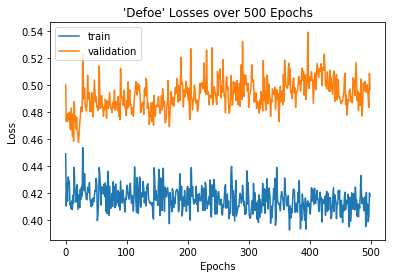

Average Training Score: 0.41556421702271096
Average Validation Score: 0.49293236441839305


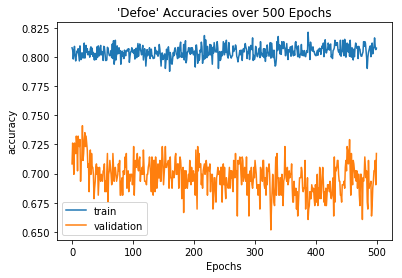

Average Training Score: 0.80425946817083
Average Validation Score: 0.6974702380952381

validating on book: 'Albin'
Epoch 0/499
----------



Phase:train
Confusion matrix:
 [[ 219  399]
 [  95 1931]]
loss 1078.1849284768105



Phase:val
Confusion matrix:
 [[127  16]
 [ 14  17]]
loss 91.05400294065475
Epoch 1/499
----------



Phase:train
Confusion matrix:
 [[ 199  419]
 [  76 1950]]
loss 1057.324585109949



Phase:val
Confusion matrix:
 [[127  16]
 [ 14  17]]
loss 90.17494785785675
Epoch 2/499
----------



Phase:train
Confusion matrix:
 [[ 194  424]
 [  93 1933]]
loss 1103.5967455655336



Phase:val
Confusion matrix:
 [[127  16]
 [ 16  15]]
loss 93.25660455226898
Epoch 3/499
----------



Phase:train
Confusion matrix:
 [[ 187  431]
 [  76 1950]]
loss 1058.2843444421887



Phase:val
Confusion matrix:
 [[121  22]
 [ 13  18]]
loss 91.84307098388672
Epoch 4/499
----------



Phase:train
Confusion matrix:
 [[ 188  430]
 [  82 1944]]
loss 1090.2373166233301



Phase:val
Confusion matrix:
 [[119  24]
 [ 15  16]]
loss 94.61027872562408
Epoch 5/499
----------



Phase:train
Confusion matrix:
 [[ 175  443]
 [  69 1957]]
loss 1089.1365489512682



Phase:val
Confusion matrix:
 [[130  13]
 [ 13  18]]
loss 90.48342001438141
Epoch 6/499
----------



Phase:train
Confusion matrix:
 [[ 212  406]
 [  92 1934]]
loss 1034.6757140010595



Phase:val
Confusion matrix:
 [[135   8]
 [ 16  15]]
loss 85.36807131767273
Epoch 7/499
----------



Phase:train
Confusion matrix:
 [[ 207  411]
 [ 110 1916]]
loss 1088.332463040948



Phase:val
Confusion matrix:
 [[118  25]
 [ 15  16]]
loss 92.42931270599365
Epoch 8/499
----------



Phase:train
Confusion matrix:
 [[ 182  436]
 [  78 1948]]
loss 1089.9379447698593



Phase:val
Confusion matrix:
 [[121  22]
 [ 13  18]]
loss 90.14006966352463
Epoch 9/499
----------



Phase:train
Confusion matrix:
 [[ 177  441]
 [  65 1961]]
loss 1098.9933307766914



Phase:val
Confusion matrix:
 [[119  24]
 [ 14  17]]
loss 92.11240291595459
Epoch 10/499
----------



Phase:train
Confusion matrix:
 [[ 188  430]
 [  83 1943]]
loss 1048.7997881621122



Phase:val
Confusion matrix:
 [[119  24]
 [ 15  16]]
loss 91.55700528621674
Epoch 11/499
----------



Phase:train
Confusion matrix:
 [[ 183  435]
 [  63 1963]]
loss 1075.218646466732



Phase:val
Confusion matrix:
 [[129  14]
 [ 15  16]]
loss 88.02914154529572
Epoch 12/499
----------



Phase:train
Confusion matrix:
 [[ 189  429]
 [  65 1961]]
loss 1064.015771470964



Phase:val
Confusion matrix:
 [[89 54]
 [12 19]]
loss 96.61067771911621
Epoch 13/499
----------



Phase:train
Confusion matrix:
 [[ 146  472]
 [  44 1982]]
loss 1110.013058140874



Phase:val
Confusion matrix:
 [[81 62]
 [12 19]]
loss 101.61037456989288
Epoch 14/499
----------



Phase:train
Confusion matrix:
 [[ 186  432]
 [  61 1965]]
loss 1069.545200228691



Phase:val
Confusion matrix:
 [[110  33]
 [ 14  17]]
loss 94.0229275226593
Epoch 15/499
----------



Phase:train
Confusion matrix:
 [[ 183  435]
 [  71 1955]]
loss 1064.69368468225



Phase:val
Confusion matrix:
 [[104  39]
 [ 13  18]]
loss 95.93503749370575
Epoch 16/499
----------



Phase:train
Confusion matrix:
 [[ 168  450]
 [  53 1973]]
loss 1066.3654930442572



Phase:val
Confusion matrix:
 [[113  30]
 [ 13  18]]
loss 95.31965911388397
Epoch 17/499
----------



Phase:train
Confusion matrix:
 [[ 172  446]
 [  64 1962]]
loss 1088.5337737351656



Phase:val
Confusion matrix:
 [[84 59]
 [12 19]]
loss 103.1874475479126
Epoch 18/499
----------



Phase:train
Confusion matrix:
 [[ 173  445]
 [  67 1959]]
loss 1103.2632952034473



Phase:val
Confusion matrix:
 [[86 57]
 [12 19]]
loss 103.96826386451721
Epoch 19/499
----------



Phase:train
Confusion matrix:
 [[ 183  435]
 [  61 1965]]
loss 1077.2954837530851



Phase:val
Confusion matrix:
 [[115  28]
 [ 14  17]]
loss 95.61885714530945
Epoch 20/499
----------



Phase:train
Confusion matrix:
 [[ 180  438]
 [  66 1960]]
loss 1095.8880859315395



Phase:val
Confusion matrix:
 [[107  36]
 [ 14  17]]
loss 96.45235621929169
Epoch 21/499
----------



Phase:train
Confusion matrix:
 [[ 190  428]
 [  74 1952]]
loss 1062.860069140792



Phase:val
Confusion matrix:
 [[104  39]
 [ 14  17]]
loss 95.37542998790741
Epoch 22/499
----------



Phase:train
Confusion matrix:
 [[ 188  430]
 [  83 1943]]
loss 1093.0831160396338



Phase:val
Confusion matrix:
 [[106  37]
 [ 13  18]]
loss 95.07779681682587
Epoch 23/499
----------



Phase:train
Confusion matrix:
 [[ 182  436]
 [  71 1955]]
loss 1107.0336084663868



Phase:val
Confusion matrix:
 [[67 76]
 [ 9 22]]
loss 104.82956850528717
Epoch 24/499
----------



Phase:train
Confusion matrix:
 [[ 180  438]
 [  63 1963]]
loss 1079.7631087750196



Phase:val
Confusion matrix:
 [[119  24]
 [ 14  17]]
loss 92.05808848142624
Epoch 25/499
----------



Phase:train
Confusion matrix:
 [[ 181  437]
 [  85 1941]]
loss 1091.56008438766



Phase:val
Confusion matrix:
 [[103  40]
 [ 13  18]]
loss 95.39324063062668
Epoch 26/499
----------



Phase:train
Confusion matrix:
 [[ 203  415]
 [  96 1930]]
loss 1097.9554209709167



Phase:val
Confusion matrix:
 [[76 67]
 [ 9 22]]
loss 102.403076171875
Epoch 27/499
----------



Phase:train
Confusion matrix:
 [[ 179  439]
 [  75 1951]]
loss 1076.2846804857254



Phase:val
Confusion matrix:
 [[79 64]
 [11 20]]
loss 102.72688865661621
Epoch 28/499
----------



Phase:train
Confusion matrix:
 [[ 160  458]
 [  58 1968]]
loss 1121.272754356265



Phase:val
Confusion matrix:
 [[87 56]
 [12 19]]
loss 101.88935220241547
Epoch 29/499
----------



Phase:train
Confusion matrix:
 [[ 186  432]
 [  84 1942]]
loss 1073.263259768486



Phase:val
Confusion matrix:
 [[123  20]
 [ 12  19]]
loss 94.2651287317276
Epoch 30/499
----------



Phase:train
Confusion matrix:
 [[ 192  426]
 [  78 1948]]
loss 1065.3099877536297



Phase:val
Confusion matrix:
 [[77 66]
 [ 9 22]]
loss 101.34111773967743
Epoch 31/499
----------



Phase:train
Confusion matrix:
 [[ 171  447]
 [  53 1973]]
loss 1092.0967227220535



Phase:val
Confusion matrix:
 [[111  32]
 [ 14  17]]
loss 94.0145925283432
Epoch 32/499
----------



Phase:train
Confusion matrix:
 [[ 166  452]
 [  78 1948]]
loss 1117.105558887124



Phase:val
Confusion matrix:
 [[80 63]
 [11 20]]
loss 98.04427409172058
Epoch 33/499
----------



Phase:train
Confusion matrix:
 [[ 185  433]
 [  64 1962]]
loss 1084.1785984933376



Phase:val
Confusion matrix:
 [[80 63]
 [11 20]]
loss 101.2502760887146
Epoch 34/499
----------



Phase:train
Confusion matrix:
 [[ 167  451]
 [  80 1946]]
loss 1097.2168510258198



Phase:val
Confusion matrix:
 [[86 57]
 [13 18]]
loss 100.18795239925385
Epoch 35/499
----------



Phase:train
Confusion matrix:
 [[ 177  441]
 [  70 1956]]
loss 1091.8299259096384



Phase:val
Confusion matrix:
 [[82 61]
 [12 19]]
loss 99.40011441707611
Epoch 36/499
----------



Phase:train
Confusion matrix:
 [[ 186  432]
 [  72 1954]]
loss 1087.420058220625



Phase:val
Confusion matrix:
 [[72 71]
 [ 7 24]]
loss 101.86605560779572
Epoch 37/499
----------



Phase:train
Confusion matrix:
 [[ 174  444]
 [  68 1958]]
loss 1085.1427418589592



Phase:val
Confusion matrix:
 [[82 61]
 [10 21]]
loss 98.90729188919067
Epoch 38/499
----------



Phase:train
Confusion matrix:
 [[ 188  430]
 [  87 1939]]
loss 1088.2443172931671



Phase:val
Confusion matrix:
 [[112  31]
 [ 12  19]]
loss 94.86338031291962
Epoch 39/499
----------



Phase:train
Confusion matrix:
 [[ 160  458]
 [  57 1969]]
loss 1089.1564197987318



Phase:val
Confusion matrix:
 [[57 86]
 [ 7 24]]
loss 108.96562469005585
Epoch 40/499
----------



Phase:train
Confusion matrix:
 [[ 160  458]
 [  50 1976]]
loss 1086.5912061929703



Phase:val
Confusion matrix:
 [[102  41]
 [ 12  19]]
loss 94.58238518238068
Epoch 41/499
----------



Phase:train
Confusion matrix:
 [[ 183  435]
 [  68 1958]]
loss 1063.3745193779469



Phase:val
Confusion matrix:
 [[78 65]
 [ 9 22]]
loss 96.94492554664612
Epoch 42/499
----------



Phase:train
Confusion matrix:
 [[ 184  434]
 [  73 1953]]
loss 1098.6755188256502



Phase:val
Confusion matrix:
 [[85 58]
 [10 21]]
loss 97.29992008209229
Epoch 43/499
----------



Phase:train
Confusion matrix:
 [[ 187  431]
 [  77 1949]]
loss 1064.2303064614534



Phase:val
Confusion matrix:
 [[112  31]
 [ 11  20]]
loss 93.32802629470825
Epoch 44/499
----------



Phase:train
Confusion matrix:
 [[ 177  441]
 [  72 1954]]
loss 1070.6662905663252



Phase:val
Confusion matrix:
 [[83 60]
 [10 21]]
loss 100.53694653511047
Epoch 45/499
----------



Phase:train
Confusion matrix:
 [[ 193  425]
 [  77 1949]]
loss 1082.1864170357585



Phase:val
Confusion matrix:
 [[116  27]
 [ 13  18]]
loss 93.94884133338928
Epoch 46/499
----------



Phase:train
Confusion matrix:
 [[ 199  419]
 [  81 1945]]
loss 1067.7830230295658



Phase:val
Confusion matrix:
 [[106  37]
 [ 14  17]]
loss 94.61512219905853
Epoch 47/499
----------



Phase:train
Confusion matrix:
 [[ 177  441]
 [  85 1941]]
loss 1087.7928786724806



Phase:val
Confusion matrix:
 [[105  38]
 [ 12  19]]
loss 93.77932250499725
Epoch 48/499
----------



Phase:train
Confusion matrix:
 [[ 159  459]
 [  55 1971]]
loss 1102.9610943347216



Phase:val
Confusion matrix:
 [[88 55]
 [11 20]]
loss 95.8090854883194
Epoch 49/499
----------



Phase:train
Confusion matrix:
 [[ 179  439]
 [  65 1961]]
loss 1073.1183217912912



Phase:val
Confusion matrix:
 [[100  43]
 [ 12  19]]
loss 93.74848568439484
Epoch 50/499
----------



Phase:train
Confusion matrix:
 [[ 195  423]
 [  84 1942]]
loss 1072.6336889117956



Phase:val
Confusion matrix:
 [[79 64]
 [10 21]]
loss 97.12418591976166
Epoch 51/499
----------



Phase:train
Confusion matrix:
 [[ 167  451]
 [  73 1953]]
loss 1126.1294737160206



Phase:val
Confusion matrix:
 [[77 66]
 [10 21]]
loss 99.3254599571228
Epoch 52/499
----------



Phase:train
Confusion matrix:
 [[ 192  426]
 [  82 1944]]
loss 1077.6688364297152



Phase:val
Confusion matrix:
 [[93 50]
 [13 18]]
loss 96.07276773452759
Epoch 53/499
----------



Phase:train
Confusion matrix:
 [[ 183  435]
 [  78 1948]]
loss 1054.5791038125753



Phase:val
Confusion matrix:
 [[85 58]
 [11 20]]
loss 95.67752838134766
Epoch 54/499
----------



Phase:train
Confusion matrix:
 [[ 185  433]
 [  80 1946]]
loss 1088.9448633044958



Phase:val
Confusion matrix:
 [[67 76]
 [ 7 24]]
loss 99.37523996829987
Epoch 55/499
----------



Phase:train
Confusion matrix:
 [[ 167  451]
 [  51 1975]]
loss 1067.282671481371



Phase:val
Confusion matrix:
 [[82 61]
 [ 8 23]]
loss 96.82841372489929
Epoch 56/499
----------



Phase:train
Confusion matrix:
 [[ 190  428]
 [  68 1958]]
loss 1055.0585424602032



Phase:val
Confusion matrix:
 [[83 60]
 [10 21]]
loss 95.7245283126831
Epoch 57/499
----------



Phase:train
Confusion matrix:
 [[ 160  458]
 [  57 1969]]
loss 1119.660952359438



Phase:val
Confusion matrix:
 [[57 86]
 [ 7 24]]
loss 102.41768443584442
Epoch 58/499
----------



Phase:train
Confusion matrix:
 [[ 179  439]
 [  59 1967]]
loss 1068.6385142356157



Phase:val
Confusion matrix:
 [[65 78]
 [ 6 25]]
loss 99.67765021324158
Epoch 59/499
----------



Phase:train
Confusion matrix:
 [[ 168  450]
 [  65 1961]]
loss 1089.1534484028816



Phase:val
Confusion matrix:
 [[61 82]
 [ 7 24]]
loss 99.64587938785553
Epoch 60/499
----------



Phase:train
Confusion matrix:
 [[ 166  452]
 [  69 1957]]
loss 1089.8567204922438



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 105.29290044307709
Epoch 61/499
----------



Phase:train
Confusion matrix:
 [[ 161  457]
 [  48 1978]]
loss 1080.9363307207823



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 102.57146507501602
Epoch 62/499
----------



Phase:train
Confusion matrix:
 [[ 163  455]
 [  55 1971]]
loss 1101.4814522266388



Phase:val
Confusion matrix:
 [[53 90]
 [ 7 24]]
loss 105.02023410797119
Epoch 63/499
----------



Phase:train
Confusion matrix:
 [[ 165  453]
 [  54 1972]]
loss 1066.5895799398422



Phase:val
Confusion matrix:
 [[60 83]
 [ 8 23]]
loss 101.50951218605042
Epoch 64/499
----------



Phase:train
Confusion matrix:
 [[ 173  445]
 [  72 1954]]
loss 1088.6426951289177



Phase:val
Confusion matrix:
 [[53 90]
 [ 5 26]]
loss 108.78887021541595
Epoch 65/499
----------



Phase:train
Confusion matrix:
 [[ 165  453]
 [  49 1977]]
loss 1079.211340546608



Phase:val
Confusion matrix:
 [[56 87]
 [ 6 25]]
loss 101.49012088775635
Epoch 66/499
----------



Phase:train
Confusion matrix:
 [[ 176  442]
 [  68 1958]]
loss 1075.3436373621225



Phase:val
Confusion matrix:
 [[55 88]
 [ 6 25]]
loss 102.60547029972076
Epoch 67/499
----------



Phase:train
Confusion matrix:
 [[ 185  433]
 [  80 1946]]
loss 1091.7537784576416



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 104.27128279209137
Epoch 68/499
----------



Phase:train
Confusion matrix:
 [[ 159  459]
 [  56 1970]]
loss 1054.9514953494072



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 103.98325896263123
Epoch 69/499
----------



Phase:train
Confusion matrix:
 [[ 171  447]
 [  65 1961]]
loss 1058.5837447047234



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 105.00053775310516
Epoch 70/499
----------



Phase:train
Confusion matrix:
 [[ 163  455]
 [  68 1958]]
loss 1085.8050874099135



Phase:val
Confusion matrix:
 [[53 90]
 [ 6 25]]
loss 109.06770014762878
Epoch 71/499
----------



Phase:train
Confusion matrix:
 [[ 178  440]
 [  55 1971]]
loss 1064.3150329589844



Phase:val
Confusion matrix:
 [[58 85]
 [ 8 23]]
loss 100.62102508544922
Epoch 72/499
----------



Phase:train
Confusion matrix:
 [[ 173  445]
 [  68 1958]]
loss 1056.145125478506



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 103.67553901672363
Epoch 73/499
----------



Phase:train
Confusion matrix:
 [[ 159  459]
 [  58 1968]]
loss 1074.0293893516064



Phase:val
Confusion matrix:
 [[52 91]
 [ 5 26]]
loss 117.30633294582367
Epoch 74/499
----------



Phase:train
Confusion matrix:
 [[ 160  458]
 [  46 1980]]
loss 1091.0597479641438



Phase:val
Confusion matrix:
 [[56 87]
 [ 7 24]]
loss 103.76035976409912
Epoch 75/499
----------



Phase:train
Confusion matrix:
 [[ 155  463]
 [  39 1987]]
loss 1102.6141916960478



Phase:val
Confusion matrix:
 [[53 90]
 [ 5 26]]
loss 114.74256300926208
Epoch 76/499
----------



Phase:train
Confusion matrix:
 [[ 151  467]
 [  54 1972]]
loss 1090.0920204222202



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 107.61294949054718
Epoch 77/499
----------



Phase:train
Confusion matrix:
 [[ 161  457]
 [  56 1970]]
loss 1052.0276511609554



Phase:val
Confusion matrix:
 [[55 88]
 [ 6 25]]
loss 104.48881733417511
Epoch 78/499
----------



Phase:train
Confusion matrix:
 [[ 192  426]
 [  69 1957]]
loss 1061.7515019625425



Phase:val
Confusion matrix:
 [[72 71]
 [ 8 23]]
loss 100.62925684452057
Epoch 79/499
----------



Phase:train
Confusion matrix:
 [[ 177  441]
 [  81 1945]]
loss 1074.9300041794777



Phase:val
Confusion matrix:
 [[68 75]
 [11 20]]
loss 98.7642332315445
Epoch 80/499
----------



Phase:train
Confusion matrix:
 [[ 167  451]
 [  66 1960]]
loss 1085.0744097828865



Phase:val
Confusion matrix:
 [[58 85]
 [ 9 22]]
loss 102.74635350704193
Epoch 81/499
----------



Phase:train
Confusion matrix:
 [[ 183  435]
 [  65 1961]]
loss 1070.723741978407



Phase:val
Confusion matrix:
 [[69 74]
 [10 21]]
loss 99.28317093849182
Epoch 82/499
----------



Phase:train
Confusion matrix:
 [[ 165  453]
 [  67 1959]]
loss 1075.0402811020613



Phase:val
Confusion matrix:
 [[56 87]
 [ 5 26]]
loss 107.22647285461426
Epoch 83/499
----------



Phase:train
Confusion matrix:
 [[ 194  424]
 [  82 1944]]
loss 1068.9938270300627



Phase:val
Confusion matrix:
 [[54 89]
 [ 7 24]]
loss 107.84203779697418
Epoch 84/499
----------



Phase:train
Confusion matrix:
 [[ 182  436]
 [  65 1961]]
loss 1117.2304023355246



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 108.92977583408356
Epoch 85/499
----------



Phase:train
Confusion matrix:
 [[ 187  431]
 [  64 1962]]
loss 1072.631751716137



Phase:val
Confusion matrix:
 [[58 85]
 [ 7 24]]
loss 104.60262763500214
Epoch 86/499
----------



Phase:train
Confusion matrix:
 [[ 175  443]
 [  56 1970]]
loss 1063.2916319966316



Phase:val
Confusion matrix:
 [[59 84]
 [ 7 24]]
loss 105.30215728282928
Epoch 87/499
----------



Phase:train
Confusion matrix:
 [[ 165  453]
 [  63 1963]]
loss 1128.4842063337564



Phase:val
Confusion matrix:
 [[69 74]
 [11 20]]
loss 102.10180151462555
Epoch 88/499
----------



Phase:train
Confusion matrix:
 [[ 157  461]
 [  59 1967]]
loss 1090.0207658559084



Phase:val
Confusion matrix:
 [[54 89]
 [ 5 26]]
loss 106.35118985176086
Epoch 89/499
----------



Phase:train
Confusion matrix:
 [[ 174  444]
 [  60 1966]]
loss 1054.3912702053785



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 116.1536785364151
Epoch 90/499
----------



Phase:train
Confusion matrix:
 [[ 176  442]
 [  69 1957]]
loss 1089.6389820873737



Phase:val
Confusion matrix:
 [[81 62]
 [12 19]]
loss 99.42171609401703
Epoch 91/499
----------



Phase:train
Confusion matrix:
 [[ 185  433]
 [  62 1964]]
loss 1052.1564085185528



Phase:val
Confusion matrix:
 [[82 61]
 [ 9 22]]
loss 99.45197069644928
Epoch 92/499
----------



Phase:train
Confusion matrix:
 [[ 195  423]
 [  83 1943]]
loss 1048.4179550856352



Phase:val
Confusion matrix:
 [[94 49]
 [11 20]]
loss 98.11764514446259
Epoch 93/499
----------



Phase:train
Confusion matrix:
 [[ 191  427]
 [  84 1942]]
loss 1048.0927590429783



Phase:val
Confusion matrix:
 [[84 59]
 [10 21]]
loss 98.26223087310791
Epoch 94/499
----------



Phase:train
Confusion matrix:
 [[ 167  451]
 [  69 1957]]
loss 1087.4494069963694



Phase:val
Confusion matrix:
 [[61 82]
 [ 7 24]]
loss 103.08877336978912
Epoch 95/499
----------



Phase:train
Confusion matrix:
 [[ 171  447]
 [  65 1961]]
loss 1033.6623196452856



Phase:val
Confusion matrix:
 [[61 82]
 [ 7 24]]
loss 101.63904410600662
Epoch 96/499
----------



Phase:train
Confusion matrix:
 [[ 158  460]
 [  61 1965]]
loss 1097.450695604086



Phase:val
Confusion matrix:
 [[57 86]
 [ 6 25]]
loss 104.55896747112274
Epoch 97/499
----------



Phase:train
Confusion matrix:
 [[ 182  436]
 [  68 1958]]
loss 1059.0385417193174



Phase:val
Confusion matrix:
 [[57 86]
 [ 7 24]]
loss 108.34672439098358
Epoch 98/499
----------



Phase:train
Confusion matrix:
 [[ 177  441]
 [  68 1958]]
loss 1086.2962433099747



Phase:val
Confusion matrix:
 [[71 72]
 [ 7 24]]
loss 103.64839506149292
Epoch 99/499
----------



Phase:train
Confusion matrix:
 [[ 191  427]
 [  72 1954]]
loss 1076.8848819434643



Phase:val
Confusion matrix:
 [[74 69]
 [ 8 23]]
loss 100.18400144577026
Epoch 100/499
----------



Phase:train
Confusion matrix:
 [[ 181  437]
 [  66 1960]]
loss 1078.108539968729



Phase:val
Confusion matrix:
 [[82 61]
 [ 9 22]]
loss 97.88843560218811
Epoch 101/499
----------



Phase:train
Confusion matrix:
 [[ 198  420]
 [  70 1956]]
loss 1078.7369784712791



Phase:val
Confusion matrix:
 [[63 80]
 [ 7 24]]
loss 106.49767744541168
Epoch 102/499
----------



Phase:train
Confusion matrix:
 [[ 165  453]
 [  56 1970]]
loss 1093.3107272982597



Phase:val
Confusion matrix:
 [[56 87]
 [ 6 25]]
loss 106.56890261173248
Epoch 103/499
----------



Phase:train
Confusion matrix:
 [[ 160  458]
 [  61 1965]]
loss 1070.7477796822786



Phase:val
Confusion matrix:
 [[74 69]
 [10 21]]
loss 99.87597858905792
Epoch 104/499
----------



Phase:train
Confusion matrix:
 [[ 192  426]
 [  78 1948]]
loss 1074.8457561433315



Phase:val
Confusion matrix:
 [[97 46]
 [11 20]]
loss 96.10620844364166
Epoch 105/499
----------



Phase:train
Confusion matrix:
 [[ 204  414]
 [  74 1952]]
loss 1054.992403253913



Phase:val
Confusion matrix:
 [[72 71]
 [ 9 22]]
loss 99.2878246307373
Epoch 106/499
----------



Phase:train
Confusion matrix:
 [[ 167  451]
 [  65 1961]]
loss 1084.352493032813



Phase:val
Confusion matrix:
 [[71 72]
 [ 8 23]]
loss 101.10791659355164
Epoch 107/499
----------



Phase:train
Confusion matrix:
 [[ 169  449]
 [  57 1969]]
loss 1084.1072653010488



Phase:val
Confusion matrix:
 [[57 86]
 [ 6 25]]
loss 105.03007650375366
Epoch 108/499
----------



Phase:train
Confusion matrix:
 [[ 192  426]
 [  67 1959]]
loss 1055.421139471233



Phase:val
Confusion matrix:
 [[76 67]
 [ 9 22]]
loss 98.0407840013504
Epoch 109/499
----------



Phase:train
Confusion matrix:
 [[ 185  433]
 [  52 1974]]
loss 1048.7536716908216



Phase:val
Confusion matrix:
 [[85 58]
 [10 21]]
loss 95.86799848079681
Epoch 110/499
----------



Phase:train
Confusion matrix:
 [[ 179  439]
 [  65 1961]]
loss 1080.3716706037521



Phase:val
Confusion matrix:
 [[55 88]
 [ 7 24]]
loss 101.58002865314484
Epoch 111/499
----------



Phase:train
Confusion matrix:
 [[ 171  447]
 [  61 1965]]
loss 1090.0394072979689



Phase:val
Confusion matrix:
 [[54 89]
 [ 5 26]]
loss 103.84835875034332
Epoch 112/499
----------



Phase:train
Confusion matrix:
 [[ 157  461]
 [  50 1976]]
loss 1089.4531255066395



Phase:val
Confusion matrix:
 [[57 86]
 [ 5 26]]
loss 103.46045517921448
Epoch 113/499
----------



Phase:train
Confusion matrix:
 [[ 154  464]
 [  53 1973]]
loss 1086.3767407685518



Phase:val
Confusion matrix:
 [[55 88]
 [ 5 26]]
loss 105.18711054325104
Epoch 114/499
----------



Phase:train
Confusion matrix:
 [[ 181  437]
 [  68 1958]]
loss 1086.3107376992702



Phase:val
Confusion matrix:
 [[60 83]
 [ 8 23]]
loss 103.00786912441254
Epoch 115/499
----------



Phase:train
Confusion matrix:
 [[ 162  456]
 [  39 1987]]
loss 1075.578290745616



Phase:val
Confusion matrix:
 [[56 87]
 [ 6 25]]
loss 106.96144223213196
Epoch 116/499
----------



Phase:train
Confusion matrix:
 [[ 160  458]
 [  58 1968]]
loss 1083.7752677798271



Phase:val
Confusion matrix:
 [[60 83]
 [ 6 25]]
loss 101.22268253564835
Epoch 117/499
----------



Phase:train
Confusion matrix:
 [[ 178  440]
 [  69 1957]]
loss 1072.6093581318855



Phase:val
Confusion matrix:
 [[60 83]
 [ 7 24]]
loss 103.10047256946564
Epoch 118/499
----------



Phase:train
Confusion matrix:
 [[ 171  447]
 [  51 1975]]
loss 1085.690581202507



Phase:val
Confusion matrix:
 [[64 79]
 [ 6 25]]
loss 99.43322741985321
Epoch 119/499
----------



Phase:train
Confusion matrix:
 [[ 154  464]
 [  50 1976]]
loss 1083.0418774932623



Phase:val
Confusion matrix:
 [[58 85]
 [ 6 25]]
loss 102.88911008834839
Epoch 120/499
----------



Phase:train
Confusion matrix:
 [[ 190  428]
 [  73 1953]]
loss 1096.5643502473831



Phase:val
Confusion matrix:
 [[69 74]
 [ 7 24]]
loss 101.24701178073883
Epoch 121/499
----------



Phase:train
Confusion matrix:
 [[ 156  462]
 [  64 1962]]
loss 1107.0274225920439



Phase:val
Confusion matrix:
 [[53 90]
 [ 5 26]]
loss 111.61232614517212
Epoch 122/499
----------



Phase:train
Confusion matrix:
 [[ 163  455]
 [  46 1980]]
loss 1055.7934913784266



Phase:val
Confusion matrix:
 [[72 71]
 [ 8 23]]
loss 101.57326316833496
Epoch 123/499
----------



Phase:train
Confusion matrix:
 [[ 224  394]
 [  83 1943]]
loss 1059.9572318047285



Phase:val
Confusion matrix:
 [[93 50]
 [13 18]]
loss 96.30666255950928
Epoch 124/499
----------



Phase:train
Confusion matrix:
 [[ 199  419]
 [  84 1942]]
loss 1073.273768633604



Phase:val
Confusion matrix:
 [[67 76]
 [10 21]]
loss 105.87668192386627
Epoch 125/499
----------



Phase:train
Confusion matrix:
 [[ 181  437]
 [  70 1956]]
loss 1067.8294316232204



Phase:val
Confusion matrix:
 [[59 84]
 [ 6 25]]
loss 106.37099754810333
Epoch 126/499
----------



Phase:train
Confusion matrix:
 [[ 163  455]
 [  55 1971]]
loss 1091.9790715277195



Phase:val
Confusion matrix:
 [[68 75]
 [ 9 22]]
loss 101.16974532604218
Epoch 127/499
----------



Phase:train
Confusion matrix:
 [[ 153  465]
 [  62 1964]]
loss 1099.508593648672



Phase:val
Confusion matrix:
 [[66 77]
 [10 21]]
loss 100.80768883228302
Epoch 128/499
----------



Phase:train
Confusion matrix:
 [[ 176  442]
 [  61 1965]]
loss 1059.3896448910236



Phase:val
Confusion matrix:
 [[64 79]
 [ 9 22]]
loss 103.56887400150299
Epoch 129/499
----------



Phase:train
Confusion matrix:
 [[ 173  445]
 [  61 1965]]
loss 1075.7096811532974



Phase:val
Confusion matrix:
 [[53 90]
 [ 5 26]]
loss 110.50024163722992
Epoch 130/499
----------



Phase:train
Confusion matrix:
 [[ 159  459]
 [  50 1976]]
loss 1092.8996554613113



Phase:val
Confusion matrix:
 [[62 81]
 [ 7 24]]
loss 101.39386367797852
Epoch 131/499
----------



Phase:train
Confusion matrix:
 [[ 182  436]
 [  70 1956]]
loss 1056.2630467116833



Phase:val
Confusion matrix:
 [[79 64]
 [12 19]]
loss 98.44226139783859
Epoch 132/499
----------



Phase:train
Confusion matrix:
 [[ 155  463]
 [  44 1982]]
loss 1088.053393855691



Phase:val
Confusion matrix:
 [[56 87]
 [ 6 25]]
loss 107.46173000335693
Epoch 133/499
----------



Phase:train
Confusion matrix:
 [[ 180  438]
 [  86 1940]]
loss 1068.9241572543979



Phase:val
Confusion matrix:
 [[69 74]
 [ 9 22]]
loss 98.31760787963867
Epoch 134/499
----------



Phase:train
Confusion matrix:
 [[ 159  459]
 [  55 1971]]
loss 1073.008216843009



Phase:val
Confusion matrix:
 [[61 82]
 [ 8 23]]
loss 99.4195659160614
Epoch 135/499
----------



Phase:train
Confusion matrix:
 [[ 174  444]
 [  71 1955]]
loss 1067.3511385470629



Phase:val
Confusion matrix:
 [[71 72]
 [ 9 22]]
loss 96.58092188835144
Epoch 136/499
----------



Phase:train
Confusion matrix:
 [[ 162  456]
 [  65 1961]]
loss 1078.2873942553997



Phase:val
Confusion matrix:
 [[54 89]
 [ 7 24]]
loss 103.7135238647461
Epoch 137/499
----------



Phase:train
Confusion matrix:
 [[ 174  444]
 [  57 1969]]
loss 1107.9331578165293



Phase:val
Confusion matrix:
 [[53 90]
 [ 5 26]]
loss 116.07197785377502
Epoch 138/499
----------



Phase:train
Confusion matrix:
 [[ 161  457]
 [  48 1978]]
loss 1073.4445790052414



Phase:val
Confusion matrix:
 [[71 72]
 [ 8 23]]
loss 99.20280647277832
Epoch 139/499
----------



Phase:train
Confusion matrix:
 [[ 197  421]
 [  70 1956]]
loss 1071.4142976999283



Phase:val
Confusion matrix:
 [[77 66]
 [10 21]]
loss 98.18963330984116
Epoch 140/499
----------



Phase:train
Confusion matrix:
 [[ 189  429]
 [  69 1957]]
loss 1050.763926371932



Phase:val
Confusion matrix:
 [[69 74]
 [11 20]]
loss 99.26177990436554
Epoch 141/499
----------



Phase:train
Confusion matrix:
 [[ 180  438]
 [  70 1956]]
loss 1088.9813738167286



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 107.79275691509247
Epoch 142/499
----------



Phase:train
Confusion matrix:
 [[ 164  454]
 [  48 1978]]
loss 1074.6801266372204



Phase:val
Confusion matrix:
 [[57 86]
 [ 7 24]]
loss 103.04161548614502
Epoch 143/499
----------



Phase:train
Confusion matrix:
 [[ 181  437]
 [  70 1956]]
loss 1112.246660709381



Phase:val
Confusion matrix:
 [[53 90]
 [ 7 24]]
loss 114.05121290683746
Epoch 144/499
----------



Phase:train
Confusion matrix:
 [[ 156  462]
 [  47 1979]]
loss 1131.4435623288155



Phase:val
Confusion matrix:
 [[53 90]
 [ 6 25]]
loss 112.1235169172287
Epoch 145/499
----------



Phase:train
Confusion matrix:
 [[ 178  440]
 [  75 1951]]
loss 1059.9957764744759



Phase:val
Confusion matrix:
 [[76 67]
 [ 9 22]]
loss 99.86411452293396
Epoch 146/499
----------



Phase:train
Confusion matrix:
 [[ 168  450]
 [  83 1943]]
loss 1086.2480433136225



Phase:val
Confusion matrix:
 [[60 83]
 [10 21]]
loss 105.42415392398834
Epoch 147/499
----------



Phase:train
Confusion matrix:
 [[ 166  452]
 [  78 1948]]
loss 1122.3151915669441



Phase:val
Confusion matrix:
 [[53 90]
 [ 7 24]]
loss 110.37665247917175
Epoch 148/499
----------



Phase:train
Confusion matrix:
 [[ 138  480]
 [  42 1984]]
loss 1100.2867283076048



Phase:val
Confusion matrix:
 [[53 90]
 [ 6 25]]
loss 106.89572167396545
Epoch 149/499
----------



Phase:train
Confusion matrix:
 [[ 196  422]
 [  89 1937]]
loss 1083.0494216233492



Phase:val
Confusion matrix:
 [[65 78]
 [ 9 22]]
loss 99.15657353401184
Epoch 150/499
----------



Phase:train
Confusion matrix:
 [[ 153  465]
 [  57 1969]]
loss 1065.7134896218777



Phase:val
Confusion matrix:
 [[55 88]
 [ 6 25]]
loss 103.60548806190491
Epoch 151/499
----------



Phase:train
Confusion matrix:
 [[ 165  453]
 [  50 1976]]
loss 1083.892185524106



Phase:val
Confusion matrix:
 [[54 89]
 [ 5 26]]
loss 107.29328072071075
Epoch 152/499
----------



Phase:train
Confusion matrix:
 [[ 180  438]
 [  68 1958]]
loss 1076.6530034691095



Phase:val
Confusion matrix:
 [[55 88]
 [ 7 24]]
loss 104.38735377788544
Epoch 153/499
----------



Phase:train
Confusion matrix:
 [[ 173  445]
 [  43 1983]]
loss 1046.3919038176537



Phase:val
Confusion matrix:
 [[72 71]
 [10 21]]
loss 101.2037947177887
Epoch 154/499
----------



Phase:train
Confusion matrix:
 [[ 183  435]
 [  75 1951]]
loss 1053.2925858944654



Phase:val
Confusion matrix:
 [[55 88]
 [ 8 23]]
loss 107.26007771492004
Epoch 155/499
----------



Phase:train
Confusion matrix:
 [[ 154  464]
 [  48 1978]]
loss 1076.4395184516907



Phase:val
Confusion matrix:
 [[59 84]
 [ 9 22]]
loss 101.65981698036194
Epoch 156/499
----------



Phase:train
Confusion matrix:
 [[ 177  441]
 [  64 1962]]
loss 1034.8141655772924



Phase:val
Confusion matrix:
 [[81 62]
 [10 21]]
loss 99.41221153736115
Epoch 157/499
----------



Phase:train
Confusion matrix:
 [[ 181  437]
 [  68 1958]]
loss 1071.9866851270199



Phase:val
Confusion matrix:
 [[74 69]
 [10 21]]
loss 98.24241006374359
Epoch 158/499
----------



Phase:train
Confusion matrix:
 [[ 161  457]
 [  53 1973]]
loss 1072.5783020704985



Phase:val
Confusion matrix:
 [[58 85]
 [ 5 26]]
loss 104.66507041454315
Epoch 159/499
----------



Phase:train
Confusion matrix:
 [[ 165  453]
 [  51 1975]]
loss 1092.591190084815



Phase:val
Confusion matrix:
 [[66 77]
 [ 9 22]]
loss 105.7561069726944
Epoch 160/499
----------



Phase:train
Confusion matrix:
 [[ 163  455]
 [  61 1965]]
loss 1102.3818629831076



Phase:val
Confusion matrix:
 [[73 70]
 [ 8 23]]
loss 101.35213220119476
Epoch 161/499
----------



Phase:train
Confusion matrix:
 [[ 178  440]
 [  78 1948]]
loss 1076.7507063001394



Phase:val
Confusion matrix:
 [[56 87]
 [ 8 23]]
loss 107.58931350708008
Epoch 162/499
----------



Phase:train
Confusion matrix:
 [[ 161  457]
 [  50 1976]]
loss 1078.3551504313946



Phase:val
Confusion matrix:
 [[56 87]
 [ 8 23]]
loss 108.30572485923767
Epoch 163/499
----------



Phase:train
Confusion matrix:
 [[ 168  450]
 [  54 1972]]
loss 1077.2409811615944



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 106.2196193933487
Epoch 164/499
----------



Phase:train
Confusion matrix:
 [[ 172  446]
 [  54 1972]]
loss 1101.519391939044



Phase:val
Confusion matrix:
 [[55 88]
 [ 9 22]]
loss 104.19096434116364
Epoch 165/499
----------



Phase:train
Confusion matrix:
 [[ 164  454]
 [  54 1972]]
loss 1079.8560644388199



Phase:val
Confusion matrix:
 [[59 84]
 [ 9 22]]
loss 104.13173568248749
Epoch 166/499
----------



Phase:train
Confusion matrix:
 [[ 179  439]
 [  53 1973]]
loss 1057.002860724926



Phase:val
Confusion matrix:
 [[64 79]
 [10 21]]
loss 103.46880912780762
Epoch 167/499
----------



Phase:train
Confusion matrix:
 [[ 172  446]
 [  64 1962]]
loss 1060.30980733037



Phase:val
Confusion matrix:
 [[66 77]
 [ 9 22]]
loss 101.68495261669159
Epoch 168/499
----------



Phase:train
Confusion matrix:
 [[ 166  452]
 [  52 1974]]
loss 1078.8763816207647



Phase:val
Confusion matrix:
 [[54 89]
 [ 7 24]]
loss 107.78243792057037
Epoch 169/499
----------



Phase:train
Confusion matrix:
 [[ 184  434]
 [  54 1972]]
loss 1029.9056954830885



Phase:val
Confusion matrix:
 [[71 72]
 [ 9 22]]
loss 98.39595031738281
Epoch 170/499
----------



Phase:train
Confusion matrix:
 [[ 157  461]
 [  46 1980]]
loss 1087.4629523903131



Phase:val
Confusion matrix:
 [[53 90]
 [ 5 26]]
loss 112.59821140766144
Epoch 171/499
----------



Phase:train
Confusion matrix:
 [[ 197  421]
 [  63 1963]]
loss 1025.2176406085491



Phase:val
Confusion matrix:
 [[82 61]
 [13 18]]
loss 99.33939564228058
Epoch 172/499
----------



Phase:train
Confusion matrix:
 [[ 219  399]
 [  91 1935]]
loss 1033.3924917131662



Phase:val
Confusion matrix:
 [[74 69]
 [ 9 22]]
loss 100.96426737308502
Epoch 173/499
----------



Phase:train
Confusion matrix:
 [[ 175  443]
 [  52 1974]]
loss 1060.9793985188007



Phase:val
Confusion matrix:
 [[69 74]
 [ 8 23]]
loss 101.66892045736313
Epoch 174/499
----------



Phase:train
Confusion matrix:
 [[ 181  437]
 [  70 1956]]
loss 1061.9419534951448



Phase:val
Confusion matrix:
 [[60 83]
 [ 7 24]]
loss 105.16018950939178
Epoch 175/499
----------



Phase:train
Confusion matrix:
 [[ 151  467]
 [  64 1962]]
loss 1086.3323271125555



Phase:val
Confusion matrix:
 [[62 81]
 [ 7 24]]
loss 101.83215641975403
Epoch 176/499
----------



Phase:train
Confusion matrix:
 [[ 168  450]
 [  69 1957]]
loss 1087.339869722724



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 102.5257493853569
Epoch 177/499
----------



Phase:train
Confusion matrix:
 [[ 146  472]
 [  34 1992]]
loss 1107.5541815310717



Phase:val
Confusion matrix:
 [[53 90]
 [ 5 26]]
loss 106.85546267032623
Epoch 178/499
----------



Phase:train
Confusion matrix:
 [[ 168  450]
 [  73 1953]]
loss 1073.4832679778337



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 105.326784491539
Epoch 179/499
----------



Phase:train
Confusion matrix:
 [[ 166  452]
 [  60 1966]]
loss 1085.6068612337112



Phase:val
Confusion matrix:
 [[54 89]
 [ 5 26]]
loss 112.40980577468872
Epoch 180/499
----------



Phase:train
Confusion matrix:
 [[ 161  457]
 [  46 1980]]
loss 1068.9166601002216



Phase:val
Confusion matrix:
 [[55 88]
 [ 8 23]]
loss 107.80542647838593
Epoch 181/499
----------



Phase:train
Confusion matrix:
 [[ 169  449]
 [  64 1962]]
loss 1109.1796241104603



Phase:val
Confusion matrix:
 [[53 90]
 [ 5 26]]
loss 119.5022644996643
Epoch 182/499
----------



Phase:train
Confusion matrix:
 [[ 170  448]
 [  57 1969]]
loss 1094.1140679568052



Phase:val
Confusion matrix:
 [[53 90]
 [ 5 26]]
loss 109.95680022239685
Epoch 183/499
----------



Phase:train
Confusion matrix:
 [[ 139  479]
 [  27 1999]]
loss 1067.6246737241745



Phase:val
Confusion matrix:
 [[56 87]
 [ 6 25]]
loss 106.61253941059113
Epoch 184/499
----------



Phase:train
Confusion matrix:
 [[ 177  441]
 [  79 1947]]
loss 1078.1436899006367



Phase:val
Confusion matrix:
 [[58 85]
 [ 8 23]]
loss 105.16047275066376
Epoch 185/499
----------



Phase:train
Confusion matrix:
 [[ 166  452]
 [  62 1964]]
loss 1078.5143833458424



Phase:val
Confusion matrix:
 [[55 88]
 [ 5 26]]
loss 108.53174710273743
Epoch 186/499
----------



Phase:train
Confusion matrix:
 [[ 174  444]
 [  87 1939]]
loss 1073.056200608611



Phase:val
Confusion matrix:
 [[74 69]
 [10 21]]
loss 98.29532814025879
Epoch 187/499
----------



Phase:train
Confusion matrix:
 [[ 188  430]
 [  70 1956]]
loss 1084.2426161766052



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 103.97031104564667
Epoch 188/499
----------



Phase:train
Confusion matrix:
 [[ 154  464]
 [  60 1966]]
loss 1104.9635128825903



Phase:val
Confusion matrix:
 [[53 90]
 [ 7 24]]
loss 108.69020020961761
Epoch 189/499
----------



Phase:train
Confusion matrix:
 [[ 143  475]
 [  39 1987]]
loss 1108.9781994521618



Phase:val
Confusion matrix:
 [[53 90]
 [ 6 25]]
loss 113.2585551738739
Epoch 190/499
----------



Phase:train
Confusion matrix:
 [[ 159  459]
 [  54 1972]]
loss 1083.995268791914



Phase:val
Confusion matrix:
 [[54 89]
 [ 7 24]]
loss 105.55670440196991
Epoch 191/499
----------



Phase:train
Confusion matrix:
 [[ 171  447]
 [  70 1956]]
loss 1089.2726921588182



Phase:val
Confusion matrix:
 [[51 92]
 [ 5 26]]
loss 112.1659984588623
Epoch 192/499
----------



Phase:train
Confusion matrix:
 [[ 141  477]
 [  37 1989]]
loss 1082.7398044764996



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 108.5044275522232
Epoch 193/499
----------



Phase:train
Confusion matrix:
 [[ 138  480]
 [  30 1996]]
loss 1087.9018356353045



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 105.97507202625275
Epoch 194/499
----------



Phase:train
Confusion matrix:
 [[ 163  455]
 [  52 1974]]
loss 1055.6327811032534



Phase:val
Confusion matrix:
 [[53 90]
 [ 5 26]]
loss 110.01571214199066
Epoch 195/499
----------



Phase:train
Confusion matrix:
 [[ 146  472]
 [  43 1983]]
loss 1083.2782992124557



Phase:val
Confusion matrix:
 [[52 91]
 [ 5 26]]
loss 109.83536911010742
Epoch 196/499
----------



Phase:train
Confusion matrix:
 [[ 166  452]
 [  54 1972]]
loss 1066.3270443975925



Phase:val
Confusion matrix:
 [[55 88]
 [ 7 24]]
loss 107.62869656085968
Epoch 197/499
----------



Phase:train
Confusion matrix:
 [[ 160  458]
 [  51 1975]]
loss 1082.0765880197287



Phase:val
Confusion matrix:
 [[57 86]
 [ 8 23]]
loss 103.61645805835724
Epoch 198/499
----------



Phase:train
Confusion matrix:
 [[ 169  449]
 [  58 1968]]
loss 1068.9858637601137



Phase:val
Confusion matrix:
 [[57 86]
 [ 6 25]]
loss 104.72512125968933
Epoch 199/499
----------



Phase:train
Confusion matrix:
 [[ 156  462]
 [  43 1983]]
loss 1094.61221241951



Phase:val
Confusion matrix:
 [[54 89]
 [ 5 26]]
loss 105.75197494029999
Epoch 200/499
----------



Phase:train
Confusion matrix:
 [[ 161  457]
 [  46 1980]]
loss 1071.9552691280842



Phase:val
Confusion matrix:
 [[54 89]
 [ 7 24]]
loss 104.35682153701782
Epoch 201/499
----------



Phase:train
Confusion matrix:
 [[ 186  432]
 [  61 1965]]
loss 1075.764408186078



Phase:val
Confusion matrix:
 [[56 87]
 [ 7 24]]
loss 106.3195515871048
Epoch 202/499
----------



Phase:train
Confusion matrix:
 [[ 158  460]
 [  50 1976]]
loss 1107.6828358769417



Phase:val
Confusion matrix:
 [[58 85]
 [ 8 23]]
loss 108.92695093154907
Epoch 203/499
----------



Phase:train
Confusion matrix:
 [[ 154  464]
 [  41 1985]]
loss 1089.4480558037758



Phase:val
Confusion matrix:
 [[59 84]
 [ 8 23]]
loss 107.06485331058502
Epoch 204/499
----------



Phase:train
Confusion matrix:
 [[ 160  458]
 [  48 1978]]
loss 1078.10164450109



Phase:val
Confusion matrix:
 [[65 78]
 [ 8 23]]
loss 105.84769344329834
Epoch 205/499
----------



Phase:train
Confusion matrix:
 [[ 162  456]
 [  55 1971]]
loss 1092.7235237061977



Phase:val
Confusion matrix:
 [[53 90]
 [ 6 25]]
loss 112.39435279369354
Epoch 206/499
----------



Phase:train
Confusion matrix:
 [[ 163  455]
 [  74 1952]]
loss 1074.5995774418116



Phase:val
Confusion matrix:
 [[57 86]
 [ 7 24]]
loss 108.24321258068085
Epoch 207/499
----------



Phase:train
Confusion matrix:
 [[ 167  451]
 [  64 1962]]
loss 1069.09644728899



Phase:val
Confusion matrix:
 [[56 87]
 [ 7 24]]
loss 104.18423390388489
Epoch 208/499
----------



Phase:train
Confusion matrix:
 [[ 175  443]
 [  66 1960]]
loss 1074.3490495830774



Phase:val
Confusion matrix:
 [[88 55]
 [12 19]]
loss 98.94921278953552
Epoch 209/499
----------



Phase:train
Confusion matrix:
 [[ 178  440]
 [  66 1960]]
loss 1060.9996604174376



Phase:val
Confusion matrix:
 [[64 79]
 [ 8 23]]
loss 104.23643183708191
Epoch 210/499
----------



Phase:train
Confusion matrix:
 [[ 192  426]
 [  80 1946]]
loss 1070.4162519723177



Phase:val
Confusion matrix:
 [[90 53]
 [11 20]]
loss 97.92189753055573
Epoch 211/499
----------



Phase:train
Confusion matrix:
 [[ 174  444]
 [  48 1978]]
loss 1085.0494318902493



Phase:val
Confusion matrix:
 [[57 86]
 [ 8 23]]
loss 106.03756582736969
Epoch 212/499
----------



Phase:train
Confusion matrix:
 [[ 160  458]
 [  77 1949]]
loss 1107.9970754384995



Phase:val
Confusion matrix:
 [[52 91]
 [ 6 25]]
loss 110.13832914829254
Epoch 213/499
----------



Phase:train
Confusion matrix:
 [[ 175  443]
 [  48 1978]]
loss 1079.4108890146017



Phase:val
Confusion matrix:
 [[57 86]
 [ 9 22]]
loss 107.27318263053894
Epoch 214/499
----------



Phase:train
Confusion matrix:
 [[ 172  446]
 [  53 1973]]
loss 1064.793536067009



Phase:val
Confusion matrix:
 [[57 86]
 [ 8 23]]
loss 111.86505722999573
Epoch 215/499
----------



Phase:train
Confusion matrix:
 [[ 194  424]
 [  77 1949]]
loss 1049.340550661087



Phase:val
Confusion matrix:
 [[75 68]
 [12 19]]
loss 101.49274349212646
Epoch 216/499
----------



Phase:train
Confusion matrix:
 [[ 189  429]
 [  73 1953]]
loss 1048.4139754846692



Phase:val
Confusion matrix:
 [[60 83]
 [ 9 22]]
loss 104.96205246448517
Epoch 217/499
----------



Phase:train
Confusion matrix:
 [[ 179  439]
 [  76 1950]]
loss 1105.7248968333006



Phase:val
Confusion matrix:
 [[56 87]
 [ 7 24]]
loss 107.5613853931427
Epoch 218/499
----------



Phase:train
Confusion matrix:
 [[ 149  469]
 [  55 1971]]
loss 1137.0970798432827



Phase:val
Confusion matrix:
 [[50 93]
 [ 5 26]]
loss 111.14431810379028
Epoch 219/499
----------



Phase:train
Confusion matrix:
 [[ 167  451]
 [  51 1975]]
loss 1079.5507128834724



Phase:val
Confusion matrix:
 [[60 83]
 [ 9 22]]
loss 109.64158141613007
Epoch 220/499
----------



Phase:train
Confusion matrix:
 [[ 185  433]
 [  68 1958]]
loss 1086.8169775307178



Phase:val
Confusion matrix:
 [[69 74]
 [ 9 22]]
loss 104.30588555335999
Epoch 221/499
----------



Phase:train
Confusion matrix:
 [[ 173  445]
 [  71 1955]]
loss 1110.3954045921564



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 110.53414130210876
Epoch 222/499
----------



Phase:train
Confusion matrix:
 [[ 162  456]
 [  57 1969]]
loss 1073.0594771057367



Phase:val
Confusion matrix:
 [[57 86]
 [ 7 24]]
loss 104.29856753349304
Epoch 223/499
----------



Phase:train
Confusion matrix:
 [[ 172  446]
 [  57 1969]]
loss 1065.8372218608856



Phase:val
Confusion matrix:
 [[58 85]
 [ 7 24]]
loss 106.99979829788208
Epoch 224/499
----------



Phase:train
Confusion matrix:
 [[ 172  446]
 [  46 1980]]
loss 1047.8020614981651



Phase:val
Confusion matrix:
 [[63 80]
 [ 9 22]]
loss 104.30884850025177
Epoch 225/499
----------



Phase:train
Confusion matrix:
 [[ 188  430]
 [  61 1965]]
loss 1054.2104758769274



Phase:val
Confusion matrix:
 [[56 87]
 [ 8 23]]
loss 109.05399751663208
Epoch 226/499
----------



Phase:train
Confusion matrix:
 [[ 182  436]
 [  65 1961]]
loss 1075.2062652111053



Phase:val
Confusion matrix:
 [[87 56]
 [12 19]]
loss 97.9456239938736
Epoch 227/499
----------



Phase:train
Confusion matrix:
 [[ 167  451]
 [  74 1952]]
loss 1098.3476655334234



Phase:val
Confusion matrix:
 [[52 91]
 [ 6 25]]
loss 109.89681267738342
Epoch 228/499
----------



Phase:train
Confusion matrix:
 [[ 166  452]
 [  43 1983]]
loss 1037.834953919053



Phase:val
Confusion matrix:
 [[63 80]
 [ 9 22]]
loss 105.5302004814148
Epoch 229/499
----------



Phase:train
Confusion matrix:
 [[ 177  441]
 [  64 1962]]
loss 1060.716275766492



Phase:val
Confusion matrix:
 [[63 80]
 [ 8 23]]
loss 103.00457775592804
Epoch 230/499
----------



Phase:train
Confusion matrix:
 [[ 158  460]
 [  40 1986]]
loss 1120.341289371252



Phase:val
Confusion matrix:
 [[52 91]
 [ 6 25]]
loss 113.46289014816284
Epoch 231/499
----------



Phase:train
Confusion matrix:
 [[ 180  438]
 [  65 1961]]
loss 1063.4674359858036



Phase:val
Confusion matrix:
 [[66 77]
 [10 21]]
loss 105.08845853805542
Epoch 232/499
----------



Phase:train
Confusion matrix:
 [[ 173  445]
 [  61 1965]]
loss 1091.1571209430695



Phase:val
Confusion matrix:
 [[58 85]
 [10 21]]
loss 105.71432662010193
Epoch 233/499
----------



Phase:train
Confusion matrix:
 [[ 178  440]
 [  63 1963]]
loss 1058.0773932933807



Phase:val
Confusion matrix:
 [[63 80]
 [10 21]]
loss 108.72048938274384
Epoch 234/499
----------



Phase:train
Confusion matrix:
 [[ 183  435]
 [  86 1940]]
loss 1083.8869895935059



Phase:val
Confusion matrix:
 [[61 82]
 [10 21]]
loss 101.49552202224731
Epoch 235/499
----------



Phase:train
Confusion matrix:
 [[ 181  437]
 [  64 1962]]
loss 1059.1417989060283



Phase:val
Confusion matrix:
 [[57 86]
 [10 21]]
loss 103.04923796653748
Epoch 236/499
----------



Phase:train
Confusion matrix:
 [[ 167  451]
 [  48 1978]]
loss 1083.2668677270412



Phase:val
Confusion matrix:
 [[57 86]
 [ 8 23]]
loss 105.97809529304504
Epoch 237/499
----------



Phase:train
Confusion matrix:
 [[ 173  445]
 [  65 1961]]
loss 1070.062108695507



Phase:val
Confusion matrix:
 [[56 87]
 [ 7 24]]
loss 106.43984174728394
Epoch 238/499
----------



Phase:train
Confusion matrix:
 [[ 165  453]
 [  44 1982]]
loss 1035.3973905444145



Phase:val
Confusion matrix:
 [[61 82]
 [ 7 24]]
loss 102.95845699310303
Epoch 239/499
----------



Phase:train
Confusion matrix:
 [[ 184  434]
 [  65 1961]]
loss 1049.26899587363



Phase:val
Confusion matrix:
 [[78 65]
 [11 20]]
loss 100.07571440935135
Epoch 240/499
----------



Phase:train
Confusion matrix:
 [[ 180  438]
 [  72 1954]]
loss 1088.111870855093



Phase:val
Confusion matrix:
 [[52 91]
 [ 7 24]]
loss 106.58319699764252
Epoch 241/499
----------



Phase:train
Confusion matrix:
 [[ 149  469]
 [  40 1986]]
loss 1069.4413512051105



Phase:val
Confusion matrix:
 [[54 89]
 [ 7 24]]
loss 108.33622300624847
Epoch 242/499
----------



Phase:train
Confusion matrix:
 [[ 189  429]
 [  64 1962]]
loss 1042.2695332169533



Phase:val
Confusion matrix:
 [[95 48]
 [12 19]]
loss 95.89624416828156
Epoch 243/499
----------



Phase:train
Confusion matrix:
 [[ 176  442]
 [  63 1963]]
loss 1066.4863748773932



Phase:val
Confusion matrix:
 [[56 87]
 [ 6 25]]
loss 105.64832067489624
Epoch 244/499
----------



Phase:train
Confusion matrix:
 [[ 170  448]
 [  53 1973]]
loss 1057.5830521658063



Phase:val
Confusion matrix:
 [[51 92]
 [ 6 25]]
loss 115.27581763267517
Epoch 245/499
----------



Phase:train
Confusion matrix:
 [[ 166  452]
 [  59 1967]]
loss 1100.3099709898233



Phase:val
Confusion matrix:
 [[58 85]
 [ 8 23]]
loss 104.49360978603363
Epoch 246/499
----------



Phase:train
Confusion matrix:
 [[ 169  449]
 [  66 1960]]
loss 1061.878979280591



Phase:val
Confusion matrix:
 [[55 88]
 [ 8 23]]
loss 101.64617621898651
Epoch 247/499
----------



Phase:train
Confusion matrix:
 [[ 182  436]
 [  65 1961]]
loss 1083.5280009359121



Phase:val
Confusion matrix:
 [[52 91]
 [ 6 25]]
loss 109.16436743736267
Epoch 248/499
----------



Phase:train
Confusion matrix:
 [[ 183  435]
 [  57 1969]]
loss 1062.0556410998106



Phase:val
Confusion matrix:
 [[84 59]
 [12 19]]
loss 97.79015505313873
Epoch 249/499
----------



Phase:train
Confusion matrix:
 [[ 180  438]
 [  60 1966]]
loss 1078.1486395597458



Phase:val
Confusion matrix:
 [[54 89]
 [ 7 24]]
loss 107.2007485628128
Epoch 250/499
----------



Phase:train
Confusion matrix:
 [[ 164  454]
 [  45 1981]]
loss 1090.8370825648308



Phase:val
Confusion matrix:
 [[54 89]
 [ 7 24]]
loss 112.75711846351624
Epoch 251/499
----------



Phase:train
Confusion matrix:
 [[ 180  438]
 [  56 1970]]
loss 1085.7485796809196



Phase:val
Confusion matrix:
 [[67 76]
 [13 18]]
loss 105.45702886581421
Epoch 252/499
----------



Phase:train
Confusion matrix:
 [[ 189  429]
 [  67 1959]]
loss 1080.706560254097



Phase:val
Confusion matrix:
 [[66 77]
 [ 9 22]]
loss 103.06654822826385
Epoch 253/499
----------



Phase:train
Confusion matrix:
 [[ 181  437]
 [  62 1964]]
loss 1067.6641514450312



Phase:val
Confusion matrix:
 [[59 84]
 [ 8 23]]
loss 104.17677998542786
Epoch 254/499
----------



Phase:train
Confusion matrix:
 [[ 180  438]
 [  61 1965]]
loss 1088.1660246923566



Phase:val
Confusion matrix:
 [[54 89]
 [ 7 24]]
loss 107.80581152439117
Epoch 255/499
----------



Phase:train
Confusion matrix:
 [[ 146  472]
 [  50 1976]]
loss 1112.406265348196



Phase:val
Confusion matrix:
 [[52 91]
 [ 7 24]]
loss 115.44829630851746
Epoch 256/499
----------



Phase:train
Confusion matrix:
 [[ 172  446]
 [  46 1980]]
loss 1066.0488688498735



Phase:val
Confusion matrix:
 [[53 90]
 [ 5 26]]
loss 106.94614601135254
Epoch 257/499
----------



Phase:train
Confusion matrix:
 [[ 155  463]
 [  52 1974]]
loss 1074.4887432157993



Phase:val
Confusion matrix:
 [[55 88]
 [ 6 25]]
loss 108.54106605052948
Epoch 258/499
----------



Phase:train
Confusion matrix:
 [[ 166  452]
 [  59 1967]]
loss 1050.3000975698233



Phase:val
Confusion matrix:
 [[55 88]
 [ 6 25]]
loss 107.41025531291962
Epoch 259/499
----------



Phase:train
Confusion matrix:
 [[ 175  443]
 [  56 1970]]
loss 1044.596763342619



Phase:val
Confusion matrix:
 [[63 80]
 [11 20]]
loss 103.4281051158905
Epoch 260/499
----------



Phase:train
Confusion matrix:
 [[ 168  450]
 [  83 1943]]
loss 1100.8645488470793



Phase:val
Confusion matrix:
 [[52 91]
 [ 6 25]]
loss 113.79170894622803
Epoch 261/499
----------



Phase:train
Confusion matrix:
 [[ 161  457]
 [  57 1969]]
loss 1100.9445136785507



Phase:val
Confusion matrix:
 [[54 89]
 [ 8 23]]
loss 106.28315222263336
Epoch 262/499
----------



Phase:train
Confusion matrix:
 [[ 166  452]
 [  54 1972]]
loss 1064.4573473483324



Phase:val
Confusion matrix:
 [[53 90]
 [ 7 24]]
loss 110.29727900028229
Epoch 263/499
----------



Phase:train
Confusion matrix:
 [[ 149  469]
 [  51 1975]]
loss 1094.1707946509123



Phase:val
Confusion matrix:
 [[53 90]
 [ 5 26]]
loss 111.4525363445282
Epoch 264/499
----------



Phase:train
Confusion matrix:
 [[ 188  430]
 [  72 1954]]
loss 1016.1883664727211



Phase:val
Confusion matrix:
 [[53 90]
 [ 4 27]]
loss 117.17443943023682
Epoch 265/499
----------



Phase:train
Confusion matrix:
 [[ 133  485]
 [  28 1998]]
loss 1071.1154686659575



Phase:val
Confusion matrix:
 [[49 94]
 [ 4 27]]
loss 116.5427794456482
Epoch 266/499
----------



Phase:train
Confusion matrix:
 [[ 170  448]
 [  60 1966]]
loss 1070.1810198873281



Phase:val
Confusion matrix:
 [[52 91]
 [ 5 26]]
loss 106.9698897600174
Epoch 267/499
----------



Phase:train
Confusion matrix:
 [[ 169  449]
 [  56 1970]]
loss 1068.8623885661364



Phase:val
Confusion matrix:
 [[60 83]
 [ 8 23]]
loss 100.82123363018036
Epoch 268/499
----------



Phase:train
Confusion matrix:
 [[ 181  437]
 [  52 1974]]
loss 1038.217273592949



Phase:val
Confusion matrix:
 [[86 57]
 [14 17]]
loss 98.20845770835876
Epoch 269/499
----------



Phase:train
Confusion matrix:
 [[ 189  429]
 [  90 1936]]
loss 1079.1752422004938



Phase:val
Confusion matrix:
 [[57 86]
 [ 6 25]]
loss 107.18104565143585
Epoch 270/499
----------



Phase:train
Confusion matrix:
 [[ 161  457]
 [  55 1971]]
loss 1058.6769619435072



Phase:val
Confusion matrix:
 [[57 86]
 [ 9 22]]
loss 104.64990603923798
Epoch 271/499
----------



Phase:train
Confusion matrix:
 [[ 192  426]
 [  83 1943]]
loss 1064.0709705799818



Phase:val
Confusion matrix:
 [[80 63]
 [12 19]]
loss 99.45682442188263
Epoch 272/499
----------



Phase:train
Confusion matrix:
 [[ 196  422]
 [  78 1948]]
loss 1075.4080938249826



Phase:val
Confusion matrix:
 [[56 87]
 [ 6 25]]
loss 109.91091990470886
Epoch 273/499
----------



Phase:train
Confusion matrix:
 [[ 195  423]
 [  69 1957]]
loss 1072.2194700539112



Phase:val
Confusion matrix:
 [[65 78]
 [10 21]]
loss 101.72588849067688
Epoch 274/499
----------



Phase:train
Confusion matrix:
 [[ 178  440]
 [  66 1960]]
loss 1062.7027046531439



Phase:val
Confusion matrix:
 [[53 90]
 [ 5 26]]
loss 111.52871716022491
Epoch 275/499
----------



Phase:train
Confusion matrix:
 [[ 179  439]
 [  63 1963]]
loss 1099.4663160592318



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 112.08480203151703
Epoch 276/499
----------



Phase:train
Confusion matrix:
 [[ 172  446]
 [  64 1962]]
loss 1071.4936155378819



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 107.64677011966705
Epoch 277/499
----------



Phase:train
Confusion matrix:
 [[ 177  441]
 [  49 1977]]
loss 1048.3362273573875



Phase:val
Confusion matrix:
 [[65 78]
 [10 21]]
loss 102.89754402637482
Epoch 278/499
----------



Phase:train
Confusion matrix:
 [[ 187  431]
 [  70 1956]]
loss 1076.0886559784412



Phase:val
Confusion matrix:
 [[56 87]
 [10 21]]
loss 107.6828955411911
Epoch 279/499
----------



Phase:train
Confusion matrix:
 [[ 172  446]
 [  49 1977]]
loss 1067.5373389720917



Phase:val
Confusion matrix:
 [[80 63]
 [12 19]]
loss 101.68893027305603
Epoch 280/499
----------



Phase:train
Confusion matrix:
 [[ 180  438]
 [  59 1967]]
loss 1062.6200139820576



Phase:val
Confusion matrix:
 [[62 81]
 [10 21]]
loss 110.0768471956253
Epoch 281/499
----------



Phase:train
Confusion matrix:
 [[ 180  438]
 [  73 1953]]
loss 1066.7757542580366



Phase:val
Confusion matrix:
 [[55 88]
 [ 7 24]]
loss 111.27552020549774
Epoch 282/499
----------



Phase:train
Confusion matrix:
 [[ 200  418]
 [  61 1965]]
loss 1061.2720286399126



Phase:val
Confusion matrix:
 [[79 64]
 [12 19]]
loss 100.99467593431473
Epoch 283/499
----------



Phase:train
Confusion matrix:
 [[ 177  441]
 [  59 1967]]
loss 1066.5506245046854



Phase:val
Confusion matrix:
 [[65 78]
 [10 21]]
loss 106.68109512329102
Epoch 284/499
----------



Phase:train
Confusion matrix:
 [[ 163  455]
 [  67 1959]]
loss 1103.282332599163



Phase:val
Confusion matrix:
 [[56 87]
 [ 8 23]]
loss 106.2865355014801
Epoch 285/499
----------



Phase:train
Confusion matrix:
 [[ 170  448]
 [  64 1962]]
loss 1083.730734705925



Phase:val
Confusion matrix:
 [[64 79]
 [ 9 22]]
loss 109.34635603427887
Epoch 286/499
----------



Phase:train
Confusion matrix:
 [[ 174  444]
 [  69 1957]]
loss 1094.4827754199505



Phase:val
Confusion matrix:
 [[58 85]
 [ 7 24]]
loss 107.48090672492981
Epoch 287/499
----------



Phase:train
Confusion matrix:
 [[ 173  445]
 [  59 1967]]
loss 1075.9119034260511



Phase:val
Confusion matrix:
 [[59 84]
 [ 7 24]]
loss 105.0203949213028
Epoch 288/499
----------



Phase:train
Confusion matrix:
 [[ 175  443]
 [  65 1961]]
loss 1069.4853950887918



Phase:val
Confusion matrix:
 [[59 84]
 [ 7 24]]
loss 104.47754454612732
Epoch 289/499
----------



Phase:train
Confusion matrix:
 [[ 191  427]
 [  71 1955]]
loss 1083.4128883183002



Phase:val
Confusion matrix:
 [[54 89]
 [ 7 24]]
loss 107.85224342346191
Epoch 290/499
----------



Phase:train
Confusion matrix:
 [[ 154  464]
 [  75 1951]]
loss 1093.7398948818445



Phase:val
Confusion matrix:
 [[61 82]
 [ 7 24]]
loss 103.4489381313324
Epoch 291/499
----------



Phase:train
Confusion matrix:
 [[ 174  444]
 [  62 1964]]
loss 1058.3478419929743



Phase:val
Confusion matrix:
 [[55 88]
 [ 7 24]]
loss 106.99240791797638
Epoch 292/499
----------



Phase:train
Confusion matrix:
 [[ 186  432]
 [  58 1968]]
loss 1066.9616168886423



Phase:val
Confusion matrix:
 [[58 85]
 [10 21]]
loss 107.60869777202606
Epoch 293/499
----------



Phase:train
Confusion matrix:
 [[ 177  441]
 [  64 1962]]
loss 1058.3491386771202



Phase:val
Confusion matrix:
 [[60 83]
 [ 9 22]]
loss 105.1619005203247
Epoch 294/499
----------



Phase:train
Confusion matrix:
 [[ 208  410]
 [  90 1936]]
loss 1022.9475211799145



Phase:val
Confusion matrix:
 [[71 72]
 [10 21]]
loss 100.24270021915436
Epoch 295/499
----------



Phase:train
Confusion matrix:
 [[ 169  449]
 [  76 1950]]
loss 1055.8128612935543



Phase:val
Confusion matrix:
 [[54 89]
 [ 5 26]]
loss 111.94028031826019
Epoch 296/499
----------



Phase:train
Confusion matrix:
 [[ 169  449]
 [  58 1968]]
loss 1050.6534078717232



Phase:val
Confusion matrix:
 [[55 88]
 [ 6 25]]
loss 108.94748568534851
Epoch 297/499
----------



Phase:train
Confusion matrix:
 [[ 163  455]
 [  58 1968]]
loss 1095.2563677281141



Phase:val
Confusion matrix:
 [[54 89]
 [ 7 24]]
loss 107.13475966453552
Epoch 298/499
----------



Phase:train
Confusion matrix:
 [[ 164  454]
 [  43 1983]]
loss 1066.266843676567



Phase:val
Confusion matrix:
 [[54 89]
 [ 7 24]]
loss 103.9697653055191
Epoch 299/499
----------



Phase:train
Confusion matrix:
 [[ 175  443]
 [  53 1973]]
loss 1052.9676057696342



Phase:val
Confusion matrix:
 [[58 85]
 [10 21]]
loss 101.94176065921783
Epoch 300/499
----------



Phase:train
Confusion matrix:
 [[ 183  435]
 [  75 1951]]
loss 1044.0302405953407



Phase:val
Confusion matrix:
 [[62 81]
 [ 8 23]]
loss 98.92097067832947
Epoch 301/499
----------



Phase:train
Confusion matrix:
 [[ 159  459]
 [  50 1976]]
loss 1078.8798321038485



Phase:val
Confusion matrix:
 [[54 89]
 [ 5 26]]
loss 110.07476055622101
Epoch 302/499
----------



Phase:train
Confusion matrix:
 [[ 154  464]
 [  57 1969]]
loss 1096.5988464653492



Phase:val
Confusion matrix:
 [[53 90]
 [ 6 25]]
loss 103.50418698787689
Epoch 303/499
----------



Phase:train
Confusion matrix:
 [[ 204  414]
 [  74 1952]]
loss 1046.526250064373



Phase:val
Confusion matrix:
 [[57 86]
 [ 8 23]]
loss 101.57892775535583
Epoch 304/499
----------



Phase:train
Confusion matrix:
 [[ 168  450]
 [  67 1959]]
loss 1053.0057517588139



Phase:val
Confusion matrix:
 [[54 89]
 [ 5 26]]
loss 109.94476592540741
Epoch 305/499
----------



Phase:train
Confusion matrix:
 [[ 176  442]
 [  57 1969]]
loss 1022.7289771288633



Phase:val
Confusion matrix:
 [[64 79]
 [ 9 22]]
loss 105.07571828365326
Epoch 306/499
----------



Phase:train
Confusion matrix:
 [[ 170  448]
 [  46 1980]]
loss 1075.0420041829348



Phase:val
Confusion matrix:
 [[63 80]
 [ 9 22]]
loss 104.46287822723389
Epoch 307/499
----------



Phase:train
Confusion matrix:
 [[ 190  428]
 [  75 1951]]
loss 1087.8733502179384



Phase:val
Confusion matrix:
 [[64 79]
 [11 20]]
loss 104.6537857055664
Epoch 308/499
----------



Phase:train
Confusion matrix:
 [[ 173  445]
 [  57 1969]]
loss 1100.0895180404186



Phase:val
Confusion matrix:
 [[57 86]
 [10 21]]
loss 105.49850630760193
Epoch 309/499
----------



Phase:train
Confusion matrix:
 [[ 170  448]
 [  61 1965]]
loss 1077.481855392456



Phase:val
Confusion matrix:
 [[51 92]
 [ 5 26]]
loss 113.38014554977417
Epoch 310/499
----------



Phase:train
Confusion matrix:
 [[ 157  461]
 [  49 1977]]
loss 1077.6128140985966



Phase:val
Confusion matrix:
 [[52 91]
 [ 5 26]]
loss 110.80035245418549
Epoch 311/499
----------



Phase:train
Confusion matrix:
 [[ 151  467]
 [  60 1966]]
loss 1096.9783803373575



Phase:val
Confusion matrix:
 [[53 90]
 [ 5 26]]
loss 108.43527233600616
Epoch 312/499
----------



Phase:train
Confusion matrix:
 [[ 185  433]
 [  51 1975]]
loss 1073.381288394332



Phase:val
Confusion matrix:
 [[59 84]
 [ 8 23]]
loss 101.64400148391724
Epoch 313/499
----------



Phase:train
Confusion matrix:
 [[ 169  449]
 [  55 1971]]
loss 1049.2354199886322



Phase:val
Confusion matrix:
 [[57 86]
 [ 6 25]]
loss 109.73084557056427
Epoch 314/499
----------



Phase:train
Confusion matrix:
 [[ 174  444]
 [  46 1980]]
loss 1042.3237544745207



Phase:val
Confusion matrix:
 [[60 83]
 [10 21]]
loss 104.98943102359772
Epoch 315/499
----------



Phase:train
Confusion matrix:
 [[ 155  463]
 [  49 1977]]
loss 1096.0196058899164



Phase:val
Confusion matrix:
 [[54 89]
 [ 7 24]]
loss 112.35546350479126
Epoch 316/499
----------



Phase:train
Confusion matrix:
 [[ 165  453]
 [  66 1960]]
loss 1084.5537409931421



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 110.27438378334045
Epoch 317/499
----------



Phase:train
Confusion matrix:
 [[ 157  461]
 [  56 1970]]
loss 1081.185978665948



Phase:val
Confusion matrix:
 [[54 89]
 [ 7 24]]
loss 113.58008849620819
Epoch 318/499
----------



Phase:train
Confusion matrix:
 [[ 176  442]
 [  59 1967]]
loss 1064.9588968753815



Phase:val
Confusion matrix:
 [[64 79]
 [11 20]]
loss 105.31899344921112
Epoch 319/499
----------



Phase:train
Confusion matrix:
 [[ 169  449]
 [  69 1957]]
loss 1081.486648246646



Phase:val
Confusion matrix:
 [[70 73]
 [10 21]]
loss 103.15314269065857
Epoch 320/499
----------



Phase:train
Confusion matrix:
 [[ 188  430]
 [  73 1953]]
loss 1088.6482937037945



Phase:val
Confusion matrix:
 [[61 82]
 [ 6 25]]
loss 106.91492736339569
Epoch 321/499
----------



Phase:train
Confusion matrix:
 [[ 165  453]
 [  59 1967]]
loss 1094.8286029100418



Phase:val
Confusion matrix:
 [[53 90]
 [ 6 25]]
loss 113.50841391086578
Epoch 322/499
----------



Phase:train
Confusion matrix:
 [[ 153  465]
 [  62 1964]]
loss 1105.5793028473854



Phase:val
Confusion matrix:
 [[56 87]
 [ 6 25]]
loss 108.78196322917938
Epoch 323/499
----------



Phase:train
Confusion matrix:
 [[ 177  441]
 [  60 1966]]
loss 1108.3232866972685



Phase:val
Confusion matrix:
 [[55 88]
 [ 7 24]]
loss 109.72706651687622
Epoch 324/499
----------



Phase:train
Confusion matrix:
 [[ 187  431]
 [  66 1960]]
loss 1068.2580846697092



Phase:val
Confusion matrix:
 [[58 85]
 [ 6 25]]
loss 107.56160008907318
Epoch 325/499
----------



Phase:train
Confusion matrix:
 [[ 194  424]
 [  68 1958]]
loss 1045.5202947556973



Phase:val
Confusion matrix:
 [[93 50]
 [13 18]]
loss 97.22511613368988
Epoch 326/499
----------



Phase:train
Confusion matrix:
 [[ 193  425]
 [  83 1943]]
loss 1078.0516831874847



Phase:val
Confusion matrix:
 [[60 83]
 [ 9 22]]
loss 110.60522019863129
Epoch 327/499
----------



Phase:train
Confusion matrix:
 [[ 179  439]
 [  72 1954]]
loss 1066.6237840801477



Phase:val
Confusion matrix:
 [[62 81]
 [ 8 23]]
loss 107.56303942203522
Epoch 328/499
----------



Phase:train
Confusion matrix:
 [[ 176  442]
 [  63 1963]]
loss 1094.9192487597466



Phase:val
Confusion matrix:
 [[56 87]
 [ 7 24]]
loss 112.65548539161682
Epoch 329/499
----------



Phase:train
Confusion matrix:
 [[ 191  427]
 [  73 1953]]
loss 1065.4492885172367



Phase:val
Confusion matrix:
 [[72 71]
 [11 20]]
loss 102.92388021945953
Epoch 330/499
----------



Phase:train
Confusion matrix:
 [[ 171  447]
 [  75 1951]]
loss 1071.156039044261



Phase:val
Confusion matrix:
 [[54 89]
 [ 7 24]]
loss 112.31106221675873
Epoch 331/499
----------



Phase:train
Confusion matrix:
 [[ 176  442]
 [  56 1970]]
loss 1075.5853612869978



Phase:val
Confusion matrix:
 [[54 89]
 [ 8 23]]
loss 109.13611936569214
Epoch 332/499
----------



Phase:train
Confusion matrix:
 [[ 174  444]
 [  55 1971]]
loss 1078.6183410137892



Phase:val
Confusion matrix:
 [[53 90]
 [ 6 25]]
loss 121.58061993122101
Epoch 333/499
----------



Phase:train
Confusion matrix:
 [[ 167  451]
 [  50 1976]]
loss 1107.4588677883148



Phase:val
Confusion matrix:
 [[51 92]
 [ 6 25]]
loss 120.19315707683563
Epoch 334/499
----------



Phase:train
Confusion matrix:
 [[ 187  431]
 [  57 1969]]
loss 1051.6077770888805



Phase:val
Confusion matrix:
 [[59 84]
 [ 8 23]]
loss 110.55354499816895
Epoch 335/499
----------



Phase:train
Confusion matrix:
 [[ 173  445]
 [  61 1965]]
loss 1078.2455604970455



Phase:val
Confusion matrix:
 [[62 81]
 [ 9 22]]
loss 107.83616411685944
Epoch 336/499
----------



Phase:train
Confusion matrix:
 [[ 175  443]
 [  68 1958]]
loss 1058.985773295164



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 111.83343839645386
Epoch 337/499
----------



Phase:train
Confusion matrix:
 [[ 192  426]
 [  73 1953]]
loss 1061.5484384596348



Phase:val
Confusion matrix:
 [[73 70]
 [10 21]]
loss 101.50025528669357
Epoch 338/499
----------



Phase:train
Confusion matrix:
 [[ 194  424]
 [  69 1957]]
loss 1056.3264518082142



Phase:val
Confusion matrix:
 [[60 83]
 [10 21]]
loss 111.12893509864807
Epoch 339/499
----------



Phase:train
Confusion matrix:
 [[ 196  422]
 [  82 1944]]
loss 1092.456345319748



Phase:val
Confusion matrix:
 [[54 89]
 [ 5 26]]
loss 115.53278505802155
Epoch 340/499
----------



Phase:train
Confusion matrix:
 [[ 178  440]
 [  49 1977]]
loss 1071.4912996441126



Phase:val
Confusion matrix:
 [[52 91]
 [ 5 26]]
loss 112.26714670658112
Epoch 341/499
----------



Phase:train
Confusion matrix:
 [[ 152  466]
 [  50 1976]]
loss 1115.871704056859



Phase:val
Confusion matrix:
 [[51 92]
 [ 5 26]]
loss 116.29937672615051
Epoch 342/499
----------



Phase:train
Confusion matrix:
 [[ 153  465]
 [  46 1980]]
loss 1071.4129966646433



Phase:val
Confusion matrix:
 [[67 76]
 [ 9 22]]
loss 103.89217555522919
Epoch 343/499
----------



Phase:train
Confusion matrix:
 [[ 183  435]
 [  67 1959]]
loss 1060.670649945736



Phase:val
Confusion matrix:
 [[71 72]
 [ 9 22]]
loss 102.49489367008209
Epoch 344/499
----------



Phase:train
Confusion matrix:
 [[ 192  426]
 [  64 1962]]
loss 1052.5088253170252



Phase:val
Confusion matrix:
 [[61 82]
 [ 8 23]]
loss 103.6007468700409
Epoch 345/499
----------



Phase:train
Confusion matrix:
 [[ 167  451]
 [  57 1969]]
loss 1069.229505971074



Phase:val
Confusion matrix:
 [[53 90]
 [ 6 25]]
loss 108.3475170135498
Epoch 346/499
----------



Phase:train
Confusion matrix:
 [[ 191  427]
 [  68 1958]]
loss 1091.82224316895



Phase:val
Confusion matrix:
 [[56 87]
 [ 7 24]]
loss 105.9510486125946
Epoch 347/499
----------



Phase:train
Confusion matrix:
 [[ 172  446]
 [  61 1965]]
loss 1072.8953846544027



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 109.84518623352051
Epoch 348/499
----------



Phase:train
Confusion matrix:
 [[ 177  441]
 [  58 1968]]
loss 1055.6389353871346



Phase:val
Confusion matrix:
 [[64 79]
 [11 20]]
loss 105.64830005168915
Epoch 349/499
----------



Phase:train
Confusion matrix:
 [[ 197  421]
 [  67 1959]]
loss 1041.7084394544363



Phase:val
Confusion matrix:
 [[69 74]
 [11 20]]
loss 102.95868182182312
Epoch 350/499
----------



Phase:train
Confusion matrix:
 [[ 165  453]
 [  60 1966]]
loss 1054.2946771681309



Phase:val
Confusion matrix:
 [[55 88]
 [ 8 23]]
loss 107.08128261566162
Epoch 351/499
----------



Phase:train
Confusion matrix:
 [[ 144  474]
 [  43 1983]]
loss 1104.0101235359907



Phase:val
Confusion matrix:
 [[53 90]
 [ 5 26]]
loss 110.03476643562317
Epoch 352/499
----------



Phase:train
Confusion matrix:
 [[ 176  442]
 [  48 1978]]
loss 1023.2896117269993



Phase:val
Confusion matrix:
 [[82 61]
 [12 19]]
loss 97.87733149528503
Epoch 353/499
----------



Phase:train
Confusion matrix:
 [[ 174  444]
 [  84 1942]]
loss 1098.7365313321352



Phase:val
Confusion matrix:
 [[54 89]
 [ 5 26]]
loss 103.97375726699829
Epoch 354/499
----------



Phase:train
Confusion matrix:
 [[ 164  454]
 [  47 1979]]
loss 1079.536588795483



Phase:val
Confusion matrix:
 [[53 90]
 [ 5 26]]
loss 106.36023032665253
Epoch 355/499
----------



Phase:train
Confusion matrix:
 [[ 184  434]
 [  72 1954]]
loss 1067.4258548021317



Phase:val
Confusion matrix:
 [[53 90]
 [ 6 25]]
loss 107.41893911361694
Epoch 356/499
----------



Phase:train
Confusion matrix:
 [[ 168  450]
 [  49 1977]]
loss 1103.430358454585



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 105.75473606586456
Epoch 357/499
----------



Phase:train
Confusion matrix:
 [[ 168  450]
 [  63 1963]]
loss 1084.3982622921467



Phase:val
Confusion matrix:
 [[54 89]
 [ 5 26]]
loss 111.56087028980255
Epoch 358/499
----------



Phase:train
Confusion matrix:
 [[ 167  451]
 [  61 1965]]
loss 1052.975378125906



Phase:val
Confusion matrix:
 [[61 82]
 [ 9 22]]
loss 102.18968218564987
Epoch 359/499
----------



Phase:train
Confusion matrix:
 [[ 203  415]
 [  74 1952]]
loss 1039.0783948749304



Phase:val
Confusion matrix:
 [[67 76]
 [ 8 23]]
loss 101.9282488822937
Epoch 360/499
----------



Phase:train
Confusion matrix:
 [[ 166  452]
 [  73 1953]]
loss 1079.0266608595848



Phase:val
Confusion matrix:
 [[55 88]
 [ 6 25]]
loss 108.30733525753021
Epoch 361/499
----------



Phase:train
Confusion matrix:
 [[ 178  440]
 [  63 1963]]
loss 1067.9740915745497



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 113.13161504268646
Epoch 362/499
----------



Phase:train
Confusion matrix:
 [[ 188  430]
 [  41 1985]]
loss 1030.6840133219957



Phase:val
Confusion matrix:
 [[69 74]
 [ 9 22]]
loss 101.22614407539368
Epoch 363/499
----------



Phase:train
Confusion matrix:
 [[ 180  438]
 [  75 1951]]
loss 1072.0514298379421



Phase:val
Confusion matrix:
 [[55 88]
 [ 7 24]]
loss 105.8049122095108
Epoch 364/499
----------



Phase:train
Confusion matrix:
 [[ 160  458]
 [  42 1984]]
loss 1064.4306526482105



Phase:val
Confusion matrix:
 [[57 86]
 [ 8 23]]
loss 108.38263690471649
Epoch 365/499
----------



Phase:train
Confusion matrix:
 [[ 190  428]
 [  78 1948]]
loss 1071.3211930543184



Phase:val
Confusion matrix:
 [[80 63]
 [ 9 22]]
loss 97.72022819519043
Epoch 366/499
----------



Phase:train
Confusion matrix:
 [[ 180  438]
 [  51 1975]]
loss 1059.816868275404



Phase:val
Confusion matrix:
 [[63 80]
 [ 9 22]]
loss 102.3366916179657
Epoch 367/499
----------



Phase:train
Confusion matrix:
 [[ 195  423]
 [  65 1961]]
loss 1057.828861117363



Phase:val
Confusion matrix:
 [[67 76]
 [10 21]]
loss 99.4261543750763
Epoch 368/499
----------



Phase:train
Confusion matrix:
 [[ 186  432]
 [  63 1963]]
loss 1076.578007042408



Phase:val
Confusion matrix:
 [[73 70]
 [11 20]]
loss 103.26669573783875
Epoch 369/499
----------



Phase:train
Confusion matrix:
 [[ 198  420]
 [  80 1946]]
loss 1074.5282208174467



Phase:val
Confusion matrix:
 [[62 81]
 [ 9 22]]
loss 105.67609179019928
Epoch 370/499
----------



Phase:train
Confusion matrix:
 [[ 168  450]
 [  55 1971]]
loss 1061.9986593723297



Phase:val
Confusion matrix:
 [[55 88]
 [ 5 26]]
loss 111.20709836483002
Epoch 371/499
----------



Phase:train
Confusion matrix:
 [[ 173  445]
 [  62 1964]]
loss 1052.3739460408688



Phase:val
Confusion matrix:
 [[69 74]
 [ 9 22]]
loss 102.94631493091583
Epoch 372/499
----------



Phase:train
Confusion matrix:
 [[ 184  434]
 [  53 1973]]
loss 1071.2184118926525



Phase:val
Confusion matrix:
 [[59 84]
 [ 6 25]]
loss 106.94505977630615
Epoch 373/499
----------



Phase:train
Confusion matrix:
 [[ 167  451]
 [  57 1969]]
loss 1081.9067852050066



Phase:val
Confusion matrix:
 [[55 88]
 [ 6 25]]
loss 111.43904387950897
Epoch 374/499
----------



Phase:train
Confusion matrix:
 [[ 158  460]
 [  48 1978]]
loss 1074.757606253028



Phase:val
Confusion matrix:
 [[56 87]
 [ 7 24]]
loss 110.5674695968628
Epoch 375/499
----------



Phase:train
Confusion matrix:
 [[ 180  438]
 [  70 1956]]
loss 1088.583691060543



Phase:val
Confusion matrix:
 [[55 88]
 [ 7 24]]
loss 112.92526996135712
Epoch 376/499
----------



Phase:train
Confusion matrix:
 [[ 185  433]
 [  65 1961]]
loss 1070.1311650499701



Phase:val
Confusion matrix:
 [[54 89]
 [ 5 26]]
loss 111.54313218593597
Epoch 377/499
----------



Phase:train
Confusion matrix:
 [[ 181  437]
 [  72 1954]]
loss 1065.7922786176205



Phase:val
Confusion matrix:
 [[53 90]
 [ 5 26]]
loss 114.65139138698578
Epoch 378/499
----------



Phase:train
Confusion matrix:
 [[ 169  449]
 [  59 1967]]
loss 1059.753997579217



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 114.37721753120422
Epoch 379/499
----------



Phase:train
Confusion matrix:
 [[ 161  457]
 [  30 1996]]
loss 1089.5801414698362



Phase:val
Confusion matrix:
 [[53 90]
 [ 6 25]]
loss 112.39656436443329
Epoch 380/499
----------



Phase:train
Confusion matrix:
 [[ 161  457]
 [  48 1978]]
loss 1075.4424717575312



Phase:val
Confusion matrix:
 [[53 90]
 [ 6 25]]
loss 111.75568234920502
Epoch 381/499
----------



Phase:train
Confusion matrix:
 [[ 188  430]
 [  69 1957]]
loss 1058.5792102515697



Phase:val
Confusion matrix:
 [[55 88]
 [ 6 25]]
loss 109.88995099067688
Epoch 382/499
----------



Phase:train
Confusion matrix:
 [[ 173  445]
 [  58 1968]]
loss 1053.736036926508



Phase:val
Confusion matrix:
 [[54 89]
 [ 9 22]]
loss 114.92951822280884
Epoch 383/499
----------



Phase:train
Confusion matrix:
 [[ 168  450]
 [  52 1974]]
loss 1074.3763352781534



Phase:val
Confusion matrix:
 [[54 89]
 [ 9 22]]
loss 109.46114552021027
Epoch 384/499
----------



Phase:train
Confusion matrix:
 [[ 184  434]
 [  65 1961]]
loss 1062.539000466466



Phase:val
Confusion matrix:
 [[55 88]
 [ 9 22]]
loss 110.08013343811035
Epoch 385/499
----------



Phase:train
Confusion matrix:
 [[ 162  456]
 [  49 1977]]
loss 1054.4836075305939



Phase:val
Confusion matrix:
 [[54 89]
 [ 7 24]]
loss 109.02390456199646
Epoch 386/499
----------



Phase:train
Confusion matrix:
 [[ 148  470]
 [  42 1984]]
loss 1056.0602641552687



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 111.64142525196075
Epoch 387/499
----------



Phase:train
Confusion matrix:
 [[ 158  460]
 [  50 1976]]
loss 1082.5693204700947



Phase:val
Confusion matrix:
 [[54 89]
 [ 8 23]]
loss 110.20798516273499
Epoch 388/499
----------



Phase:train
Confusion matrix:
 [[ 160  458]
 [  59 1967]]
loss 1103.6850642561913



Phase:val
Confusion matrix:
 [[54 89]
 [ 5 26]]
loss 108.07783710956573
Epoch 389/499
----------



Phase:train
Confusion matrix:
 [[ 160  458]
 [  48 1978]]
loss 1078.418119251728



Phase:val
Confusion matrix:
 [[56 87]
 [ 5 26]]
loss 107.95447027683258
Epoch 390/499
----------



Phase:train
Confusion matrix:
 [[ 177  441]
 [  51 1975]]
loss 1053.5311624407768



Phase:val
Confusion matrix:
 [[61 82]
 [ 6 25]]
loss 103.0701013803482
Epoch 391/499
----------



Phase:train
Confusion matrix:
 [[ 176  442]
 [  69 1957]]
loss 1052.6614281088114



Phase:val
Confusion matrix:
 [[54 89]
 [ 5 26]]
loss 110.5433943271637
Epoch 392/499
----------



Phase:train
Confusion matrix:
 [[ 151  467]
 [  41 1985]]
loss 1090.679803058505



Phase:val
Confusion matrix:
 [[56 87]
 [ 7 24]]
loss 107.79890954494476
Epoch 393/499
----------



Phase:train
Confusion matrix:
 [[ 175  443]
 [  59 1967]]
loss 1095.4740432798862



Phase:val
Confusion matrix:
 [[60 83]
 [ 6 25]]
loss 111.92898404598236
Epoch 394/499
----------



Phase:train
Confusion matrix:
 [[ 171  447]
 [  72 1954]]
loss 1113.7518729567528



Phase:val
Confusion matrix:
 [[61 82]
 [10 21]]
loss 107.9147938489914
Epoch 395/499
----------



Phase:train
Confusion matrix:
 [[ 190  428]
 [  77 1949]]
loss 1052.627361804247



Phase:val
Confusion matrix:
 [[68 75]
 [11 20]]
loss 108.44460773468018
Epoch 396/499
----------



Phase:train
Confusion matrix:
 [[ 189  429]
 [  71 1955]]
loss 1080.8392564207315



Phase:val
Confusion matrix:
 [[75 68]
 [ 9 22]]
loss 102.63854575157166
Epoch 397/499
----------



Phase:train
Confusion matrix:
 [[ 201  417]
 [  79 1947]]
loss 1053.2919435948133



Phase:val
Confusion matrix:
 [[67 76]
 [ 8 23]]
loss 110.09876561164856
Epoch 398/499
----------



Phase:train
Confusion matrix:
 [[ 209  409]
 [  86 1940]]
loss 1063.8261093199253



Phase:val
Confusion matrix:
 [[72 71]
 [12 19]]
loss 106.23423838615417
Epoch 399/499
----------



Phase:train
Confusion matrix:
 [[ 179  439]
 [  67 1959]]
loss 1098.5839550495148



Phase:val
Confusion matrix:
 [[55 88]
 [ 9 22]]
loss 112.881844997406
Epoch 400/499
----------



Phase:train
Confusion matrix:
 [[ 171  447]
 [  57 1969]]
loss 1092.9831308424473



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 122.14410030841827
Epoch 401/499
----------



Phase:train
Confusion matrix:
 [[ 176  442]
 [  56 1970]]
loss 1066.2965232431889



Phase:val
Confusion matrix:
 [[57 86]
 [ 7 24]]
loss 114.27855741977692
Epoch 402/499
----------



Phase:train
Confusion matrix:
 [[ 172  446]
 [  57 1969]]
loss 1073.2369557619095



Phase:val
Confusion matrix:
 [[56 87]
 [ 9 22]]
loss 114.14064955711365
Epoch 403/499
----------



Phase:train
Confusion matrix:
 [[ 186  432]
 [  84 1942]]
loss 1084.7126531898975



Phase:val
Confusion matrix:
 [[54 89]
 [ 8 23]]
loss 117.19233739376068
Epoch 404/499
----------



Phase:train
Confusion matrix:
 [[ 159  459]
 [  40 1986]]
loss 1080.917913198471



Phase:val
Confusion matrix:
 [[54 89]
 [ 8 23]]
loss 120.66905212402344
Epoch 405/499
----------



Phase:train
Confusion matrix:
 [[ 168  450]
 [  61 1965]]
loss 1093.5747830867767



Phase:val
Confusion matrix:
 [[56 87]
 [ 8 23]]
loss 113.18526887893677
Epoch 406/499
----------



Phase:train
Confusion matrix:
 [[ 194  424]
 [  63 1963]]
loss 1050.367724120617



Phase:val
Confusion matrix:
 [[59 84]
 [ 9 22]]
loss 117.72166967391968
Epoch 407/499
----------



Phase:train
Confusion matrix:
 [[ 183  435]
 [  76 1950]]
loss 1049.6880381405354



Phase:val
Confusion matrix:
 [[56 87]
 [ 7 24]]
loss 121.9949072599411
Epoch 408/499
----------



Phase:train
Confusion matrix:
 [[ 167  451]
 [  63 1963]]
loss 1086.920068860054



Phase:val
Confusion matrix:
 [[61 82]
 [11 20]]
loss 107.89145410060883
Epoch 409/499
----------



Phase:train
Confusion matrix:
 [[ 170  448]
 [  61 1965]]
loss 1088.9117059111595



Phase:val
Confusion matrix:
 [[53 90]
 [ 5 26]]
loss 123.2747255563736
Epoch 410/499
----------



Phase:train
Confusion matrix:
 [[ 169  449]
 [  58 1968]]
loss 1080.1678320914507



Phase:val
Confusion matrix:
 [[54 89]
 [ 5 26]]
loss 118.35417902469635
Epoch 411/499
----------



Phase:train
Confusion matrix:
 [[ 177  441]
 [  68 1958]]
loss 1068.6836235821247



Phase:val
Confusion matrix:
 [[55 88]
 [ 6 25]]
loss 115.1612366437912
Epoch 412/499
----------



Phase:train
Confusion matrix:
 [[ 176  442]
 [  51 1975]]
loss 1039.634813427925



Phase:val
Confusion matrix:
 [[53 90]
 [ 5 26]]
loss 111.57233011722565
Epoch 413/499
----------



Phase:train
Confusion matrix:
 [[ 174  444]
 [  60 1966]]
loss 1059.6976685374975



Phase:val
Confusion matrix:
 [[53 90]
 [ 5 26]]
loss 116.80795884132385
Epoch 414/499
----------



Phase:train
Confusion matrix:
 [[ 183  435]
 [  55 1971]]
loss 1045.3387537002563



Phase:val
Confusion matrix:
 [[55 88]
 [ 5 26]]
loss 118.41675889492035
Epoch 415/499
----------



Phase:train
Confusion matrix:
 [[ 178  440]
 [  61 1965]]
loss 1075.156360834837



Phase:val
Confusion matrix:
 [[54 89]
 [ 5 26]]
loss 124.15059161186218
Epoch 416/499
----------



Phase:train
Confusion matrix:
 [[ 180  438]
 [  62 1964]]
loss 1042.688771635294



Phase:val
Confusion matrix:
 [[53 90]
 [ 5 26]]
loss 112.20728552341461
Epoch 417/499
----------



Phase:train
Confusion matrix:
 [[ 155  463]
 [  34 1992]]
loss 1088.734068185091



Phase:val
Confusion matrix:
 [[49 94]
 [ 5 26]]
loss 122.59725379943848
Epoch 418/499
----------



Phase:train
Confusion matrix:
 [[ 168  450]
 [  59 1967]]
loss 1063.2468854784966



Phase:val
Confusion matrix:
 [[55 88]
 [ 5 26]]
loss 115.34839928150177
Epoch 419/499
----------



Phase:train
Confusion matrix:
 [[ 172  446]
 [  56 1970]]
loss 1056.6394635662436



Phase:val
Confusion matrix:
 [[54 89]
 [ 5 26]]
loss 114.40049719810486
Epoch 420/499
----------



Phase:train
Confusion matrix:
 [[ 174  444]
 [  46 1980]]
loss 1071.5709432065487



Phase:val
Confusion matrix:
 [[58 85]
 [ 6 25]]
loss 110.84968292713165
Epoch 421/499
----------



Phase:train
Confusion matrix:
 [[ 150  468]
 [  47 1979]]
loss 1109.2119088619947



Phase:val
Confusion matrix:
 [[53 90]
 [ 6 25]]
loss 110.94776952266693
Epoch 422/499
----------



Phase:train
Confusion matrix:
 [[ 176  442]
 [  74 1952]]
loss 1067.5395677685738



Phase:val
Confusion matrix:
 [[54 89]
 [ 5 26]]
loss 108.13732349872589
Epoch 423/499
----------



Phase:train
Confusion matrix:
 [[ 163  455]
 [  59 1967]]
loss 1089.5697925537825



Phase:val
Confusion matrix:
 [[51 92]
 [ 5 26]]
loss 118.09748387336731
Epoch 424/499
----------



Phase:train
Confusion matrix:
 [[ 159  459]
 [  55 1971]]
loss 1085.1058259606361



Phase:val
Confusion matrix:
 [[53 90]
 [ 5 26]]
loss 115.82489109039307
Epoch 425/499
----------



Phase:train
Confusion matrix:
 [[ 157  461]
 [  39 1987]]
loss 1068.5729803293943



Phase:val
Confusion matrix:
 [[57 86]
 [ 8 23]]
loss 108.14557158946991
Epoch 426/499
----------



Phase:train
Confusion matrix:
 [[ 161  457]
 [  55 1971]]
loss 1116.3796588480473



Phase:val
Confusion matrix:
 [[51 92]
 [ 5 26]]
loss 121.41112077236176
Epoch 427/499
----------



Phase:train
Confusion matrix:
 [[ 169  449]
 [  58 1968]]
loss 1074.8231813162565



Phase:val
Confusion matrix:
 [[54 89]
 [ 7 24]]
loss 113.03891742229462
Epoch 428/499
----------



Phase:train
Confusion matrix:
 [[ 161  457]
 [  70 1956]]
loss 1062.6374098807573



Phase:val
Confusion matrix:
 [[53 90]
 [ 6 25]]
loss 117.1616393327713
Epoch 429/499
----------



Phase:train
Confusion matrix:
 [[ 200  418]
 [  72 1954]]
loss 1040.6282489299774



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 114.31876540184021
Epoch 430/499
----------



Phase:train
Confusion matrix:
 [[ 178  440]
 [  56 1970]]
loss 1017.9738179296255



Phase:val
Confusion matrix:
 [[68 75]
 [ 9 22]]
loss 103.74746608734131
Epoch 431/499
----------



Phase:train
Confusion matrix:
 [[ 186  432]
 [  84 1942]]
loss 1061.4051920324564



Phase:val
Confusion matrix:
 [[56 87]
 [ 5 26]]
loss 109.2108782529831
Epoch 432/499
----------



Phase:train
Confusion matrix:
 [[ 161  457]
 [  57 1969]]
loss 1080.3245556652546



Phase:val
Confusion matrix:
 [[49 94]
 [ 5 26]]
loss 114.07671964168549
Epoch 433/499
----------



Phase:train
Confusion matrix:
 [[ 152  466]
 [  45 1981]]
loss 1076.334766805172



Phase:val
Confusion matrix:
 [[54 89]
 [ 7 24]]
loss 110.21076595783234
Epoch 434/499
----------



Phase:train
Confusion matrix:
 [[ 160  458]
 [  55 1971]]
loss 1079.7342198938131



Phase:val
Confusion matrix:
 [[54 89]
 [ 5 26]]
loss 112.9586580991745
Epoch 435/499
----------



Phase:train
Confusion matrix:
 [[ 167  451]
 [  59 1967]]
loss 1065.0897455886006



Phase:val
Confusion matrix:
 [[54 89]
 [ 5 26]]
loss 117.63261127471924
Epoch 436/499
----------



Phase:train
Confusion matrix:
 [[ 177  441]
 [  64 1962]]
loss 1057.745887875557



Phase:val
Confusion matrix:
 [[55 88]
 [ 8 23]]
loss 109.64953118562698
Epoch 437/499
----------



Phase:train
Confusion matrix:
 [[ 169  449]
 [  39 1987]]
loss 1082.9084131419659



Phase:val
Confusion matrix:
 [[53 90]
 [ 6 25]]
loss 112.91459250450134
Epoch 438/499
----------



Phase:train
Confusion matrix:
 [[ 175  443]
 [  45 1981]]
loss 1037.4013920128345



Phase:val
Confusion matrix:
 [[57 86]
 [ 9 22]]
loss 107.03665292263031
Epoch 439/499
----------



Phase:train
Confusion matrix:
 [[ 157  461]
 [  57 1969]]
loss 1069.4812827259302



Phase:val
Confusion matrix:
 [[56 87]
 [ 6 25]]
loss 105.7207099199295
Epoch 440/499
----------



Phase:train
Confusion matrix:
 [[ 175  443]
 [  54 1972]]
loss 1051.803286910057



Phase:val
Confusion matrix:
 [[54 89]
 [ 5 26]]
loss 111.92987477779388
Epoch 441/499
----------



Phase:train
Confusion matrix:
 [[ 143  475]
 [  41 1985]]
loss 1111.9685856997967



Phase:val
Confusion matrix:
 [[53 90]
 [ 5 26]]
loss 113.81978356838226
Epoch 442/499
----------



Phase:train
Confusion matrix:
 [[ 168  450]
 [  52 1974]]
loss 1085.8950422257185



Phase:val
Confusion matrix:
 [[52 91]
 [ 5 26]]
loss 120.25086545944214
Epoch 443/499
----------



Phase:train
Confusion matrix:
 [[ 156  462]
 [  46 1980]]
loss 1067.1426639780402



Phase:val
Confusion matrix:
 [[56 87]
 [ 6 25]]
loss 113.16139364242554
Epoch 444/499
----------



Phase:train
Confusion matrix:
 [[ 163  455]
 [  66 1960]]
loss 1062.021690249443



Phase:val
Confusion matrix:
 [[58 85]
 [ 6 25]]
loss 107.61503326892853
Epoch 445/499
----------



Phase:train
Confusion matrix:
 [[ 181  437]
 [  55 1971]]
loss 1081.2689845561981



Phase:val
Confusion matrix:
 [[56 87]
 [ 6 25]]
loss 115.58855402469635
Epoch 446/499
----------



Phase:train
Confusion matrix:
 [[ 155  463]
 [  40 1986]]
loss 1109.8873789012432



Phase:val
Confusion matrix:
 [[53 90]
 [ 6 25]]
loss 115.28525125980377
Epoch 447/499
----------



Phase:train
Confusion matrix:
 [[ 167  451]
 [  50 1976]]
loss 1097.9701047837734



Phase:val
Confusion matrix:
 [[56 87]
 [ 6 25]]
loss 108.40728616714478
Epoch 448/499
----------



Phase:train
Confusion matrix:
 [[ 167  451]
 [  65 1961]]
loss 1023.1733350753784



Phase:val
Confusion matrix:
 [[61 82]
 [ 8 23]]
loss 105.82442164421082
Epoch 449/499
----------



Phase:train
Confusion matrix:
 [[ 162  456]
 [  51 1975]]
loss 1096.1860063374043



Phase:val
Confusion matrix:
 [[57 86]
 [ 6 25]]
loss 108.39376866817474
Epoch 450/499
----------



Phase:train
Confusion matrix:
 [[ 186  432]
 [  66 1960]]
loss 1083.9590862989426



Phase:val
Confusion matrix:
 [[71 72]
 [ 8 23]]
loss 100.09443295001984
Epoch 451/499
----------



Phase:train
Confusion matrix:
 [[ 150  468]
 [  52 1974]]
loss 1098.8767476826906



Phase:val
Confusion matrix:
 [[55 88]
 [ 5 26]]
loss 111.21249985694885
Epoch 452/499
----------



Phase:train
Confusion matrix:
 [[ 164  454]
 [  43 1983]]
loss 1057.6302442252636



Phase:val
Confusion matrix:
 [[59 84]
 [ 7 24]]
loss 105.71864831447601
Epoch 453/499
----------



Phase:train
Confusion matrix:
 [[ 184  434]
 [  73 1953]]
loss 1051.3722115755081



Phase:val
Confusion matrix:
 [[60 83]
 [ 8 23]]
loss 106.32497596740723
Epoch 454/499
----------



Phase:train
Confusion matrix:
 [[ 191  427]
 [  59 1967]]
loss 1044.4562226086855



Phase:val
Confusion matrix:
 [[64 79]
 [ 7 24]]
loss 105.63789904117584
Epoch 455/499
----------



Phase:train
Confusion matrix:
 [[ 173  445]
 [  70 1956]]
loss 1089.7194775491953



Phase:val
Confusion matrix:
 [[60 83]
 [ 7 24]]
loss 109.1470273733139
Epoch 456/499
----------



Phase:train
Confusion matrix:
 [[ 211  407]
 [  73 1953]]
loss 1051.035836726427



Phase:val
Confusion matrix:
 [[81 62]
 [11 20]]
loss 100.76527059078217
Epoch 457/499
----------



Phase:train
Confusion matrix:
 [[ 176  442]
 [  80 1946]]
loss 1081.6875712275505



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 110.45042443275452
Epoch 458/499
----------



Phase:train
Confusion matrix:
 [[ 173  445]
 [  53 1973]]
loss 1064.6428109258413



Phase:val
Confusion matrix:
 [[53 90]
 [ 7 24]]
loss 110.14909863471985
Epoch 459/499
----------



Phase:train
Confusion matrix:
 [[ 161  457]
 [  71 1955]]
loss 1082.507931560278



Phase:val
Confusion matrix:
 [[53 90]
 [ 6 25]]
loss 115.73053300380707
Epoch 460/499
----------



Phase:train
Confusion matrix:
 [[ 186  432]
 [  61 1965]]
loss 1049.7578385919333



Phase:val
Confusion matrix:
 [[59 84]
 [ 9 22]]
loss 107.34883117675781
Epoch 461/499
----------



Phase:train
Confusion matrix:
 [[ 194  424]
 [  65 1961]]
loss 1026.1344393193722



Phase:val
Confusion matrix:
 [[75 68]
 [ 9 22]]
loss 102.18906468153
Epoch 462/499
----------



Phase:train
Confusion matrix:
 [[ 174  444]
 [  64 1962]]
loss 1062.0437445044518



Phase:val
Confusion matrix:
 [[53 90]
 [ 6 25]]
loss 113.95426070690155
Epoch 463/499
----------



Phase:train
Confusion matrix:
 [[ 183  435]
 [  65 1961]]
loss 1037.3365687429905



Phase:val
Confusion matrix:
 [[58 85]
 [ 7 24]]
loss 111.32232213020325
Epoch 464/499
----------



Phase:train
Confusion matrix:
 [[ 183  435]
 [  72 1954]]
loss 1075.3698388710618



Phase:val
Confusion matrix:
 [[63 80]
 [ 8 23]]
loss 107.50065422058105
Epoch 465/499
----------



Phase:train
Confusion matrix:
 [[ 193  425]
 [  65 1961]]
loss 1062.8208755403757



Phase:val
Confusion matrix:
 [[70 73]
 [ 9 22]]
loss 104.73635411262512
Epoch 466/499
----------



Phase:train
Confusion matrix:
 [[ 194  424]
 [  56 1970]]
loss 1056.0333376824856



Phase:val
Confusion matrix:
 [[60 83]
 [ 7 24]]
loss 111.20251131057739
Epoch 467/499
----------



Phase:train
Confusion matrix:
 [[ 193  425]
 [  73 1953]]
loss 1048.604515761137



Phase:val
Confusion matrix:
 [[58 85]
 [ 7 24]]
loss 115.2634664773941
Epoch 468/499
----------



Phase:train
Confusion matrix:
 [[ 185  433]
 [  78 1948]]
loss 1087.2392619997263



Phase:val
Confusion matrix:
 [[63 80]
 [ 9 22]]
loss 105.43415057659149
Epoch 469/499
----------



Phase:train
Confusion matrix:
 [[ 183  435]
 [  65 1961]]
loss 1057.6679157316685



Phase:val
Confusion matrix:
 [[59 84]
 [ 8 23]]
loss 108.24872410297394
Epoch 470/499
----------



Phase:train
Confusion matrix:
 [[ 206  412]
 [  84 1942]]
loss 1028.9143348932266



Phase:val
Confusion matrix:
 [[62 81]
 [ 7 24]]
loss 107.78896129131317
Epoch 471/499
----------



Phase:train
Confusion matrix:
 [[ 193  425]
 [  76 1950]]
loss 1060.999546021223



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 113.52162373065948
Epoch 472/499
----------



Phase:train
Confusion matrix:
 [[ 172  446]
 [  44 1982]]
loss 1044.4159889817238



Phase:val
Confusion matrix:
 [[62 81]
 [ 8 23]]
loss 106.68071138858795
Epoch 473/499
----------



Phase:train
Confusion matrix:
 [[ 168  450]
 [  70 1956]]
loss 1056.9876952320337



Phase:val
Confusion matrix:
 [[57 86]
 [ 6 25]]
loss 112.49414312839508
Epoch 474/499
----------



Phase:train
Confusion matrix:
 [[ 194  424]
 [  78 1948]]
loss 1071.2432243674994



Phase:val
Confusion matrix:
 [[55 88]
 [ 6 25]]
loss 114.51700282096863
Epoch 475/499
----------



Phase:train
Confusion matrix:
 [[ 177  441]
 [  59 1967]]
loss 1069.2883314192295



Phase:val
Confusion matrix:
 [[55 88]
 [ 8 23]]
loss 106.26046574115753
Epoch 476/499
----------



Phase:train
Confusion matrix:
 [[ 160  458]
 [  55 1971]]
loss 1079.8051845282316



Phase:val
Confusion matrix:
 [[49 94]
 [ 5 26]]
loss 114.6892716884613
Epoch 477/499
----------



Phase:train
Confusion matrix:
 [[ 173  445]
 [  62 1964]]
loss 1088.151928305626



Phase:val
Confusion matrix:
 [[64 79]
 [ 9 22]]
loss 103.21778500080109
Epoch 478/499
----------



Phase:train
Confusion matrix:
 [[ 185  433]
 [  63 1963]]
loss 1062.6883967220783



Phase:val
Confusion matrix:
 [[58 85]
 [ 6 25]]
loss 109.38369500637054
Epoch 479/499
----------



Phase:train
Confusion matrix:
 [[ 180  438]
 [  68 1958]]
loss 1073.3769027143717



Phase:val
Confusion matrix:
 [[56 87]
 [ 7 24]]
loss 104.39560878276825
Epoch 480/499
----------



Phase:train
Confusion matrix:
 [[ 167  451]
 [  49 1977]]
loss 1077.773198902607



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 109.67479205131531
Epoch 481/499
----------



Phase:train
Confusion matrix:
 [[ 176  442]
 [  68 1958]]
loss 1050.5579080283642



Phase:val
Confusion matrix:
 [[62 81]
 [ 9 22]]
loss 102.25644791126251
Epoch 482/499
----------



Phase:train
Confusion matrix:
 [[ 186  432]
 [  58 1968]]
loss 1054.7230895012617



Phase:val
Confusion matrix:
 [[65 78]
 [ 9 22]]
loss 101.44616425037384
Epoch 483/499
----------



Phase:train
Confusion matrix:
 [[ 183  435]
 [  66 1960]]
loss 1070.7059475779533



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 104.01217317581177
Epoch 484/499
----------



Phase:train
Confusion matrix:
 [[ 150  468]
 [  48 1978]]
loss 1083.2811894714832



Phase:val
Confusion matrix:
 [[53 90]
 [ 5 26]]
loss 109.77679061889648
Epoch 485/499
----------



Phase:train
Confusion matrix:
 [[ 180  438]
 [  67 1959]]
loss 1079.2778712958097



Phase:val
Confusion matrix:
 [[54 89]
 [ 5 26]]
loss 113.44072926044464
Epoch 486/499
----------



Phase:train
Confusion matrix:
 [[ 166  452]
 [  56 1970]]
loss 1065.3071986958385



Phase:val
Confusion matrix:
 [[54 89]
 [ 5 26]]
loss 107.84877288341522
Epoch 487/499
----------



Phase:train
Confusion matrix:
 [[ 167  451]
 [  67 1959]]
loss 1076.2263571470976



Phase:val
Confusion matrix:
 [[60 83]
 [ 7 24]]
loss 103.1992712020874
Epoch 488/499
----------



Phase:train
Confusion matrix:
 [[ 206  412]
 [  81 1945]]
loss 1059.411285892129



Phase:val
Confusion matrix:
 [[54 89]
 [ 6 25]]
loss 117.42400550842285
Epoch 489/499
----------



Phase:train
Confusion matrix:
 [[ 166  452]
 [  50 1976]]
loss 1044.4901188015938



Phase:val
Confusion matrix:
 [[74 69]
 [ 9 22]]
loss 104.09253764152527
Epoch 490/499
----------



Phase:train
Confusion matrix:
 [[ 173  445]
 [  68 1958]]
loss 1087.7560319900513



Phase:val
Confusion matrix:
 [[57 86]
 [ 6 25]]
loss 105.7437356710434
Epoch 491/499
----------



Phase:train
Confusion matrix:
 [[ 184  434]
 [  58 1968]]
loss 1102.514167279005



Phase:val
Confusion matrix:
 [[54 89]
 [ 7 24]]
loss 116.61298894882202
Epoch 492/499
----------



Phase:train
Confusion matrix:
 [[ 176  442]
 [  58 1968]]
loss 1084.873455569148



Phase:val
Confusion matrix:
 [[58 85]
 [ 7 24]]
loss 108.67308914661407
Epoch 493/499
----------



Phase:train
Confusion matrix:
 [[ 188  430]
 [  73 1953]]
loss 1083.4315547198057



Phase:val
Confusion matrix:
 [[52 91]
 [ 6 25]]
loss 109.37820649147034
Epoch 494/499
----------



Phase:train
Confusion matrix:
 [[ 175  443]
 [  66 1960]]
loss 1087.9957385212183



Phase:val
Confusion matrix:
 [[54 89]
 [ 7 24]]
loss 109.67335593700409
Epoch 495/499
----------



Phase:train
Confusion matrix:
 [[ 184  434]
 [  58 1968]]
loss 1045.726872727275



Phase:val
Confusion matrix:
 [[71 72]
 [ 8 23]]
loss 103.19401216506958
Epoch 496/499
----------



Phase:train
Confusion matrix:
 [[ 183  435]
 [  62 1964]]
loss 1092.8866434395313



Phase:val
Confusion matrix:
 [[53 90]
 [ 5 26]]
loss 120.7811027765274
Epoch 497/499
----------



Phase:train
Confusion matrix:
 [[ 165  453]
 [  48 1978]]
loss 1085.331142500043



Phase:val
Confusion matrix:
 [[54 89]
 [ 5 26]]
loss 112.9605313539505
Epoch 498/499
----------



Phase:train
Confusion matrix:
 [[ 175  443]
 [  59 1967]]
loss 1097.149019062519



Phase:val
Confusion matrix:
 [[54 89]
 [ 5 26]]
loss 110.42670559883118
Epoch 499/499
----------



Phase:train
Confusion matrix:
 [[ 151  467]
 [  54 1972]]
loss 1087.9023347645998



Phase:val
Confusion matrix:
 [[54 89]
 [ 5 26]]
loss 109.58269166946411
Training complete in 129m 13s


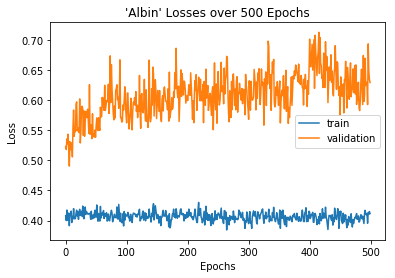

Average Training Score: 0.4064804352566307
Average Validation Score: 0.6090092756727646


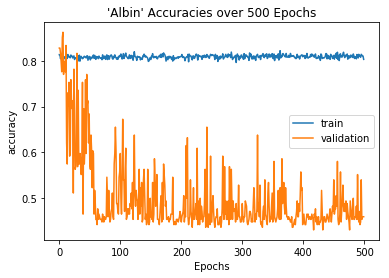

Average Training Score: 0.8085945537065053
Average Validation Score: 0.5010114942528735

validating on book: 'Confucius'
Epoch 0/499
----------



Phase:train
Confusion matrix:
 [[ 233  522]
 [  75 1817]]
loss 1184.2545741796494



Phase:val
Confusion matrix:
 [[  2   4]
 [  4 161]]
loss 55.99694111943245
Epoch 1/499
----------



Phase:train
Confusion matrix:
 [[ 253  502]
 [ 110 1782]]
loss 1191.5047929286957



Phase:val
Confusion matrix:
 [[  2   4]
 [  8 157]]
loss 61.92535701394081
Epoch 2/499
----------



Phase:train
Confusion matrix:
 [[ 245  510]
 [ 112 1780]]
loss 1173.0348919928074



Phase:val
Confusion matrix:
 [[  2   4]
 [  6 159]]
loss 57.62080278992653
Epoch 3/499
----------



Phase:train
Confusion matrix:
 [[ 249  506]
 [ 119 1773]]
loss 1173.8178344070911



Phase:val
Confusion matrix:
 [[  2   4]
 [  4 161]]
loss 57.03786152601242
Epoch 4/499
----------



Phase:train
Confusion matrix:
 [[ 266  489]
 [ 105 1787]]
loss 1146.8515129685402



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 59.00665086507797
Epoch 5/499
----------



Phase:train
Confusion matrix:
 [[ 255  500]
 [  97 1795]]
loss 1171.4794079065323



Phase:val
Confusion matrix:
 [[  4   2]
 [  9 156]]
loss 62.8225112259388
Epoch 6/499
----------



Phase:train
Confusion matrix:
 [[ 244  511]
 [  88 1804]]
loss 1179.1135763525963



Phase:val
Confusion matrix:
 [[  2   4]
 [  5 160]]
loss 55.33393931388855
Epoch 7/499
----------



Phase:train
Confusion matrix:
 [[ 230  525]
 [  82 1810]]
loss 1163.4432092234492



Phase:val
Confusion matrix:
 [[  2   4]
 [  6 159]]
loss 58.74428987503052
Epoch 8/499
----------



Phase:train
Confusion matrix:
 [[ 240  515]
 [ 110 1782]]
loss 1209.9178443402052



Phase:val
Confusion matrix:
 [[  2   4]
 [  5 160]]
loss 62.89859849214554
Epoch 9/499
----------



Phase:train
Confusion matrix:
 [[ 256  499]
 [  92 1800]]
loss 1170.3299885690212



Phase:val
Confusion matrix:
 [[  2   4]
 [  3 162]]
loss 55.12489750981331
Epoch 10/499
----------



Phase:train
Confusion matrix:
 [[ 272  483]
 [ 113 1779]]
loss 1144.2576683461666



Phase:val
Confusion matrix:
 [[  3   3]
 [  9 156]]
loss 61.47441178560257
Epoch 11/499
----------



Phase:train
Confusion matrix:
 [[ 271  484]
 [ 105 1787]]
loss 1153.0796889066696



Phase:val
Confusion matrix:
 [[  2   4]
 [ 10 155]]
loss 62.57763421535492
Epoch 12/499
----------



Phase:train
Confusion matrix:
 [[ 266  489]
 [ 124 1768]]
loss 1164.8220632821321



Phase:val
Confusion matrix:
 [[  2   4]
 [ 10 155]]
loss 63.3699816763401
Epoch 13/499
----------



Phase:train
Confusion matrix:
 [[ 260  495]
 [ 110 1782]]
loss 1155.8122396618128



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 60.92882925271988
Epoch 14/499
----------



Phase:train
Confusion matrix:
 [[ 224  531]
 [  75 1817]]
loss 1201.0848325490952



Phase:val
Confusion matrix:
 [[  2   4]
 [  5 160]]
loss 59.1234146207571
Epoch 15/499
----------



Phase:train
Confusion matrix:
 [[ 249  506]
 [  95 1797]]
loss 1171.8267077207565



Phase:val
Confusion matrix:
 [[  2   4]
 [ 15 150]]
loss 67.15773180127144
Epoch 16/499
----------



Phase:train
Confusion matrix:
 [[ 276  479]
 [ 113 1779]]
loss 1180.861925393343



Phase:val
Confusion matrix:
 [[  2   4]
 [ 16 149]]
loss 71.99305713176727
Epoch 17/499
----------



Phase:train
Confusion matrix:
 [[ 270  485]
 [ 117 1775]]
loss 1163.5615217983723



Phase:val
Confusion matrix:
 [[  2   4]
 [ 21 144]]
loss 65.26417054235935
Epoch 18/499
----------



Phase:train
Confusion matrix:
 [[ 276  479]
 [ 127 1765]]
loss 1169.0688050836325



Phase:val
Confusion matrix:
 [[  2   4]
 [ 10 155]]
loss 69.990931391716
Epoch 19/499
----------



Phase:train
Confusion matrix:
 [[ 282  473]
 [ 116 1776]]
loss 1169.332325488329



Phase:val
Confusion matrix:
 [[  2   4]
 [ 15 150]]
loss 70.45473343133926
Epoch 20/499
----------



Phase:train
Confusion matrix:
 [[ 240  515]
 [ 100 1792]]
loss 1178.5096568763256



Phase:val
Confusion matrix:
 [[  2   4]
 [  3 162]]
loss 63.925327837467194
Epoch 21/499
----------



Phase:train
Confusion matrix:
 [[ 263  492]
 [  90 1802]]
loss 1170.9336220175028



Phase:val
Confusion matrix:
 [[  2   4]
 [  9 156]]
loss 61.44612327218056
Epoch 22/499
----------



Phase:train
Confusion matrix:
 [[ 267  488]
 [ 103 1789]]
loss 1166.0880353450775



Phase:val
Confusion matrix:
 [[  2   4]
 [  3 162]]
loss 62.249219328165054
Epoch 23/499
----------



Phase:train
Confusion matrix:
 [[ 280  475]
 [ 114 1778]]
loss 1184.02974909544



Phase:val
Confusion matrix:
 [[  3   3]
 [ 11 154]]
loss 64.84970939159393
Epoch 24/499
----------



Phase:train
Confusion matrix:
 [[ 302  453]
 [ 142 1750]]
loss 1174.0865665972233



Phase:val
Confusion matrix:
 [[  3   3]
 [  8 157]]
loss 65.01882088184357
Epoch 25/499
----------



Phase:train
Confusion matrix:
 [[ 270  485]
 [ 129 1763]]
loss 1153.9350619912148



Phase:val
Confusion matrix:
 [[  2   4]
 [ 19 146]]
loss 64.56135156750679
Epoch 26/499
----------



Phase:train
Confusion matrix:
 [[ 290  465]
 [ 119 1773]]
loss 1167.5451370626688



Phase:val
Confusion matrix:
 [[  2   4]
 [ 10 155]]
loss 62.56326672434807
Epoch 27/499
----------



Phase:train
Confusion matrix:
 [[ 252  503]
 [ 100 1792]]
loss 1214.4939168095589



Phase:val
Confusion matrix:
 [[  2   4]
 [  2 163]]
loss 60.63661056756973
Epoch 28/499
----------



Phase:train
Confusion matrix:
 [[ 276  479]
 [ 107 1785]]
loss 1137.261779025197



Phase:val
Confusion matrix:
 [[  2   4]
 [ 11 154]]
loss 64.57070937752724
Epoch 29/499
----------



Phase:train
Confusion matrix:
 [[ 280  475]
 [ 117 1775]]
loss 1177.0368178486824



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 62.79111623764038
Epoch 30/499
----------



Phase:train
Confusion matrix:
 [[ 273  482]
 [ 121 1771]]
loss 1180.5736217051744



Phase:val
Confusion matrix:
 [[  2   4]
 [ 11 154]]
loss 65.3592976629734
Epoch 31/499
----------



Phase:train
Confusion matrix:
 [[ 287  468]
 [ 126 1766]]
loss 1180.9143093526363



Phase:val
Confusion matrix:
 [[  2   4]
 [  9 156]]
loss 67.25697049498558
Epoch 32/499
----------



Phase:train
Confusion matrix:
 [[ 264  491]
 [ 110 1782]]
loss 1176.4360811114311



Phase:val
Confusion matrix:
 [[  2   4]
 [  8 157]]
loss 64.564334243536
Epoch 33/499
----------



Phase:train
Confusion matrix:
 [[ 321  434]
 [ 135 1757]]
loss 1137.191998526454



Phase:val
Confusion matrix:
 [[  2   4]
 [ 19 146]]
loss 65.7018851339817
Epoch 34/499
----------



Phase:train
Confusion matrix:
 [[ 279  476]
 [ 113 1779]]
loss 1169.6811750978231



Phase:val
Confusion matrix:
 [[  2   4]
 [ 11 154]]
loss 66.95167246460915
Epoch 35/499
----------



Phase:train
Confusion matrix:
 [[ 300  455]
 [ 128 1764]]
loss 1169.5579138100147



Phase:val
Confusion matrix:
 [[  4   2]
 [ 19 146]]
loss 67.41275379061699
Epoch 36/499
----------



Phase:train
Confusion matrix:
 [[ 298  457]
 [ 119 1773]]
loss 1155.3800919651985



Phase:val
Confusion matrix:
 [[  4   2]
 [ 18 147]]
loss 64.9031531214714
Epoch 37/499
----------



Phase:train
Confusion matrix:
 [[ 260  495]
 [ 136 1756]]
loss 1223.2428350448608



Phase:val
Confusion matrix:
 [[  4   2]
 [  9 156]]
loss 66.60183879733086
Epoch 38/499
----------



Phase:train
Confusion matrix:
 [[ 259  496]
 [ 101 1791]]
loss 1194.6680161356926



Phase:val
Confusion matrix:
 [[  2   4]
 [  5 160]]
loss 62.12142786383629
Epoch 39/499
----------



Phase:train
Confusion matrix:
 [[ 248  507]
 [  82 1810]]
loss 1193.126632988453



Phase:val
Confusion matrix:
 [[  2   4]
 [  5 160]]
loss 63.745772033929825
Epoch 40/499
----------



Phase:train
Confusion matrix:
 [[ 265  490]
 [  92 1800]]
loss 1161.617462337017



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 62.91846215724945
Epoch 41/499
----------



Phase:train
Confusion matrix:
 [[ 277  478]
 [ 134 1758]]
loss 1160.0600736439228



Phase:val
Confusion matrix:
 [[  2   4]
 [ 10 155]]
loss 65.4631941318512
Epoch 42/499
----------



Phase:train
Confusion matrix:
 [[ 314  441]
 [ 124 1768]]
loss 1113.5144200623035



Phase:val
Confusion matrix:
 [[  2   4]
 [  4 161]]
loss 59.737985014915466
Epoch 43/499
----------



Phase:train
Confusion matrix:
 [[ 256  499]
 [  98 1794]]
loss 1188.2580242156982



Phase:val
Confusion matrix:
 [[  2   4]
 [  5 160]]
loss 64.50304076075554
Epoch 44/499
----------



Phase:train
Confusion matrix:
 [[ 304  451]
 [ 112 1780]]
loss 1130.6056751459837



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 65.09329986572266
Epoch 45/499
----------



Phase:train
Confusion matrix:
 [[ 281  474]
 [ 116 1776]]
loss 1175.6785895824432



Phase:val
Confusion matrix:
 [[  2   4]
 [  2 163]]
loss 56.94258287549019
Epoch 46/499
----------



Phase:train
Confusion matrix:
 [[ 282  473]
 [  95 1797]]
loss 1176.5013225078583



Phase:val
Confusion matrix:
 [[  3   3]
 [  7 158]]
loss 61.10102269053459
Epoch 47/499
----------



Phase:train
Confusion matrix:
 [[ 268  487]
 [ 110 1782]]
loss 1206.5599418580532



Phase:val
Confusion matrix:
 [[  2   4]
 [  2 163]]
loss 60.69644874334335
Epoch 48/499
----------



Phase:train
Confusion matrix:
 [[ 290  465]
 [ 117 1775]]
loss 1167.0091149508953



Phase:val
Confusion matrix:
 [[  2   4]
 [  3 162]]
loss 54.312552243471146
Epoch 49/499
----------



Phase:train
Confusion matrix:
 [[ 245  510]
 [  81 1811]]
loss 1196.6926669031382



Phase:val
Confusion matrix:
 [[  2   4]
 [  3 162]]
loss 63.36306220293045
Epoch 50/499
----------



Phase:train
Confusion matrix:
 [[ 278  477]
 [ 115 1777]]
loss 1178.6234439015388



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 61.66481053829193
Epoch 51/499
----------



Phase:train
Confusion matrix:
 [[ 286  469]
 [ 106 1786]]
loss 1153.570207029581



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 65.36285585165024
Epoch 52/499
----------



Phase:train
Confusion matrix:
 [[ 284  471]
 [  99 1793]]
loss 1191.852150708437



Phase:val
Confusion matrix:
 [[  2   4]
 [ 11 154]]
loss 68.56969830393791
Epoch 53/499
----------



Phase:train
Confusion matrix:
 [[ 284  471]
 [ 116 1776]]
loss 1135.8829848766327



Phase:val
Confusion matrix:
 [[  3   3]
 [ 25 140]]
loss 67.88214215636253
Epoch 54/499
----------



Phase:train
Confusion matrix:
 [[ 330  425]
 [ 159 1733]]
loss 1138.7570840716362



Phase:val
Confusion matrix:
 [[  4   2]
 [ 20 145]]
loss 64.18220752477646
Epoch 55/499
----------



Phase:train
Confusion matrix:
 [[ 285  470]
 [ 124 1768]]
loss 1175.919256106019



Phase:val
Confusion matrix:
 [[  2   4]
 [  9 156]]
loss 67.08767619729042
Epoch 56/499
----------



Phase:train
Confusion matrix:
 [[ 312  443]
 [ 135 1757]]
loss 1147.7222602665424



Phase:val
Confusion matrix:
 [[  4   2]
 [ 12 153]]
loss 67.67078912258148
Epoch 57/499
----------



Phase:train
Confusion matrix:
 [[ 309  446]
 [ 142 1750]]
loss 1160.680431470275



Phase:val
Confusion matrix:
 [[  3   3]
 [ 10 155]]
loss 64.89008465409279
Epoch 58/499
----------



Phase:train
Confusion matrix:
 [[ 267  488]
 [ 101 1791]]
loss 1155.5641267299652



Phase:val
Confusion matrix:
 [[  2   4]
 [ 13 152]]
loss 68.28245633840561
Epoch 59/499
----------



Phase:train
Confusion matrix:
 [[ 274  481]
 [ 133 1759]]
loss 1194.8457432091236



Phase:val
Confusion matrix:
 [[  2   4]
 [  9 156]]
loss 70.96793937683105
Epoch 60/499
----------



Phase:train
Confusion matrix:
 [[ 268  487]
 [  96 1796]]
loss 1128.3903782069683



Phase:val
Confusion matrix:
 [[  4   2]
 [ 10 155]]
loss 63.161348313093185
Epoch 61/499
----------



Phase:train
Confusion matrix:
 [[ 277  478]
 [ 116 1776]]
loss 1183.6303083002567



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 68.40061029791832
Epoch 62/499
----------



Phase:train
Confusion matrix:
 [[ 264  491]
 [ 126 1766]]
loss 1209.311049476266



Phase:val
Confusion matrix:
 [[  3   3]
 [  7 158]]
loss 68.21932846307755
Epoch 63/499
----------



Phase:train
Confusion matrix:
 [[ 295  460]
 [ 117 1775]]
loss 1160.976536527276



Phase:val
Confusion matrix:
 [[  3   3]
 [  9 156]]
loss 68.90049999952316
Epoch 64/499
----------



Phase:train
Confusion matrix:
 [[ 278  477]
 [ 127 1765]]
loss 1206.80379986763



Phase:val
Confusion matrix:
 [[  2   4]
 [  6 159]]
loss 64.39749562740326
Epoch 65/499
----------



Phase:train
Confusion matrix:
 [[ 262  493]
 [  95 1797]]
loss 1159.242480263114



Phase:val
Confusion matrix:
 [[  3   3]
 [  7 158]]
loss 64.17670172452927
Epoch 66/499
----------



Phase:train
Confusion matrix:
 [[ 263  492]
 [ 117 1775]]
loss 1159.7608998417854



Phase:val
Confusion matrix:
 [[  4   2]
 [  8 157]]
loss 66.93938860297203
Epoch 67/499
----------



Phase:train
Confusion matrix:
 [[ 278  477]
 [ 120 1772]]
loss 1184.4068622887135



Phase:val
Confusion matrix:
 [[  3   3]
 [  6 159]]
loss 62.33714210987091
Epoch 68/499
----------



Phase:train
Confusion matrix:
 [[ 237  518]
 [  85 1807]]
loss 1175.5823278874159



Phase:val
Confusion matrix:
 [[  3   3]
 [  4 161]]
loss 59.404006630182266
Epoch 69/499
----------



Phase:train
Confusion matrix:
 [[ 289  466]
 [ 124 1768]]
loss 1150.679286211729



Phase:val
Confusion matrix:
 [[  2   4]
 [  9 156]]
loss 62.444114327430725
Epoch 70/499
----------



Phase:train
Confusion matrix:
 [[ 307  448]
 [ 132 1760]]
loss 1152.2664513587952



Phase:val
Confusion matrix:
 [[  4   2]
 [ 10 155]]
loss 59.567124992609024
Epoch 71/499
----------



Phase:train
Confusion matrix:
 [[ 266  489]
 [ 103 1789]]
loss 1185.974640339613



Phase:val
Confusion matrix:
 [[  3   3]
 [  4 161]]
loss 60.19152715802193
Epoch 72/499
----------



Phase:train
Confusion matrix:
 [[ 294  461]
 [ 110 1782]]
loss 1121.994418784976



Phase:val
Confusion matrix:
 [[  4   2]
 [  6 159]]
loss 62.29876074194908
Epoch 73/499
----------



Phase:train
Confusion matrix:
 [[ 265  490]
 [ 102 1790]]
loss 1156.3672450482845



Phase:val
Confusion matrix:
 [[  3   3]
 [  9 156]]
loss 70.36281615495682
Epoch 74/499
----------



Phase:train
Confusion matrix:
 [[ 282  473]
 [ 112 1780]]
loss 1168.4630340635777



Phase:val
Confusion matrix:
 [[  3   3]
 [ 20 145]]
loss 70.49003818631172
Epoch 75/499
----------



Phase:train
Confusion matrix:
 [[ 289  466]
 [ 113 1779]]
loss 1137.4678826928139



Phase:val
Confusion matrix:
 [[  3   3]
 [ 12 153]]
loss 68.83537566661835
Epoch 76/499
----------



Phase:train
Confusion matrix:
 [[ 306  449]
 [ 142 1750]]
loss 1173.7086426019669



Phase:val
Confusion matrix:
 [[  4   2]
 [ 13 152]]
loss 70.01197880506516
Epoch 77/499
----------



Phase:train
Confusion matrix:
 [[ 308  447]
 [ 137 1755]]
loss 1179.633097589016



Phase:val
Confusion matrix:
 [[  2   4]
 [ 10 155]]
loss 71.36575642228127
Epoch 78/499
----------



Phase:train
Confusion matrix:
 [[ 316  439]
 [ 134 1758]]
loss 1178.5601734220982



Phase:val
Confusion matrix:
 [[  3   3]
 [  7 158]]
loss 63.31341835856438
Epoch 79/499
----------



Phase:train
Confusion matrix:
 [[ 295  460]
 [ 113 1779]]
loss 1127.1501507163048



Phase:val
Confusion matrix:
 [[  2   4]
 [  8 157]]
loss 63.11937373876572
Epoch 80/499
----------



Phase:train
Confusion matrix:
 [[ 325  430]
 [ 137 1755]]
loss 1140.793439000845



Phase:val
Confusion matrix:
 [[  3   3]
 [ 14 151]]
loss 68.96880012750626
Epoch 81/499
----------



Phase:train
Confusion matrix:
 [[ 268  487]
 [ 124 1768]]
loss 1164.3300810158253



Phase:val
Confusion matrix:
 [[  2   4]
 [  9 156]]
loss 66.3669445514679
Epoch 82/499
----------



Phase:train
Confusion matrix:
 [[ 283  472]
 [ 105 1787]]
loss 1145.2636114060879



Phase:val
Confusion matrix:
 [[  4   2]
 [ 13 152]]
loss 66.90428239107132
Epoch 83/499
----------



Phase:train
Confusion matrix:
 [[ 293  462]
 [ 139 1753]]
loss 1145.5552138835192



Phase:val
Confusion matrix:
 [[  3   3]
 [ 16 149]]
loss 67.72622010111809
Epoch 84/499
----------



Phase:train
Confusion matrix:
 [[ 262  493]
 [ 106 1786]]
loss 1147.9184795618057



Phase:val
Confusion matrix:
 [[  3   3]
 [ 13 152]]
loss 64.18686032295227
Epoch 85/499
----------



Phase:train
Confusion matrix:
 [[ 297  458]
 [ 121 1771]]
loss 1153.5140601694584



Phase:val
Confusion matrix:
 [[  3   3]
 [ 25 140]]
loss 74.00430208444595
Epoch 86/499
----------



Phase:train
Confusion matrix:
 [[ 280  475]
 [ 111 1781]]
loss 1189.3126351088285



Phase:val
Confusion matrix:
 [[  3   3]
 [  6 159]]
loss 63.53196805715561
Epoch 87/499
----------



Phase:train
Confusion matrix:
 [[ 289  466]
 [ 109 1783]]
loss 1121.6392087936401



Phase:val
Confusion matrix:
 [[  3   3]
 [ 10 155]]
loss 65.53794959187508
Epoch 88/499
----------



Phase:train
Confusion matrix:
 [[ 301  454]
 [ 144 1748]]
loss 1152.62873069942



Phase:val
Confusion matrix:
 [[  2   4]
 [ 11 154]]
loss 70.19749191403389
Epoch 89/499
----------



Phase:train
Confusion matrix:
 [[ 285  470]
 [ 134 1758]]
loss 1160.6792385578156



Phase:val
Confusion matrix:
 [[  3   3]
 [ 13 152]]
loss 72.78203719854355
Epoch 90/499
----------



Phase:train
Confusion matrix:
 [[ 309  446]
 [ 130 1762]]
loss 1159.7067211568356



Phase:val
Confusion matrix:
 [[  2   4]
 [ 11 154]]
loss 70.08433309197426
Epoch 91/499
----------



Phase:train
Confusion matrix:
 [[ 267  488]
 [ 110 1782]]
loss 1151.065894126892



Phase:val
Confusion matrix:
 [[  2   4]
 [  2 163]]
loss 65.50310879945755
Epoch 92/499
----------



Phase:train
Confusion matrix:
 [[ 290  465]
 [ 120 1772]]
loss 1148.9241124987602



Phase:val
Confusion matrix:
 [[  3   3]
 [ 17 148]]
loss 68.08626049757004
Epoch 93/499
----------



Phase:train
Confusion matrix:
 [[ 251  504]
 [ 111 1781]]
loss 1156.5966181457043



Phase:val
Confusion matrix:
 [[  2   4]
 [  8 157]]
loss 64.87948167324066
Epoch 94/499
----------



Phase:train
Confusion matrix:
 [[ 290  465]
 [ 127 1765]]
loss 1149.4236978590488



Phase:val
Confusion matrix:
 [[  2   4]
 [ 11 154]]
loss 65.73519822955132
Epoch 95/499
----------



Phase:train
Confusion matrix:
 [[ 282  473]
 [ 119 1773]]
loss 1121.1596274375916



Phase:val
Confusion matrix:
 [[  2   4]
 [ 10 155]]
loss 65.33634585142136
Epoch 96/499
----------



Phase:train
Confusion matrix:
 [[ 279  476]
 [ 123 1769]]
loss 1157.3176547437906



Phase:val
Confusion matrix:
 [[  3   3]
 [  4 161]]
loss 63.17308849096298
Epoch 97/499
----------



Phase:train
Confusion matrix:
 [[ 261  494]
 [  97 1795]]
loss 1179.651061668992



Phase:val
Confusion matrix:
 [[  2   4]
 [  3 162]]
loss 62.00107517838478
Epoch 98/499
----------



Phase:train
Confusion matrix:
 [[ 294  461]
 [  93 1799]]
loss 1142.238800317049



Phase:val
Confusion matrix:
 [[  3   3]
 [ 13 152]]
loss 66.99632942676544
Epoch 99/499
----------



Phase:train
Confusion matrix:
 [[ 314  441]
 [ 166 1726]]
loss 1166.732685059309



Phase:val
Confusion matrix:
 [[  3   3]
 [ 17 148]]
loss 76.71969193220139
Epoch 100/499
----------



Phase:train
Confusion matrix:
 [[ 263  492]
 [ 114 1778]]
loss 1207.6824740469456



Phase:val
Confusion matrix:
 [[  4   2]
 [ 10 155]]
loss 67.7978084385395
Epoch 101/499
----------



Phase:train
Confusion matrix:
 [[ 303  452]
 [ 112 1780]]
loss 1136.0697872191668



Phase:val
Confusion matrix:
 [[  3   3]
 [ 15 150]]
loss 66.93647161126137
Epoch 102/499
----------



Phase:train
Confusion matrix:
 [[ 292  463]
 [ 120 1772]]
loss 1138.2348827719688



Phase:val
Confusion matrix:
 [[  3   3]
 [ 23 142]]
loss 69.13375806808472
Epoch 103/499
----------



Phase:train
Confusion matrix:
 [[ 324  431]
 [ 140 1752]]
loss 1146.9201089441776



Phase:val
Confusion matrix:
 [[  4   2]
 [ 14 151]]
loss 68.9413498044014
Epoch 104/499
----------



Phase:train
Confusion matrix:
 [[ 267  488]
 [ 105 1787]]
loss 1140.447310730815



Phase:val
Confusion matrix:
 [[  3   3]
 [ 17 148]]
loss 63.412487119436264
Epoch 105/499
----------



Phase:train
Confusion matrix:
 [[ 304  451]
 [ 130 1762]]
loss 1167.3547338545322



Phase:val
Confusion matrix:
 [[  3   3]
 [  9 156]]
loss 67.02200242877007
Epoch 106/499
----------



Phase:train
Confusion matrix:
 [[ 273  482]
 [  95 1797]]
loss 1145.9811629354954



Phase:val
Confusion matrix:
 [[  2   4]
 [ 12 153]]
loss 67.69427731633186
Epoch 107/499
----------



Phase:train
Confusion matrix:
 [[ 307  448]
 [ 116 1776]]
loss 1126.847006469965



Phase:val
Confusion matrix:
 [[  2   4]
 [ 14 151]]
loss 68.98742693662643
Epoch 108/499
----------



Phase:train
Confusion matrix:
 [[ 309  446]
 [ 142 1750]]
loss 1146.3746966421604



Phase:val
Confusion matrix:
 [[  3   3]
 [ 16 149]]
loss 68.110561221838
Epoch 109/499
----------



Phase:train
Confusion matrix:
 [[ 298  457]
 [ 133 1759]]
loss 1120.8634537905455



Phase:val
Confusion matrix:
 [[  3   3]
 [ 14 151]]
loss 67.46671468019485
Epoch 110/499
----------



Phase:train
Confusion matrix:
 [[ 283  472]
 [ 103 1789]]
loss 1143.6694004237652



Phase:val
Confusion matrix:
 [[  2   4]
 [  8 157]]
loss 64.42522984743118
Epoch 111/499
----------



Phase:train
Confusion matrix:
 [[ 277  478]
 [ 135 1757]]
loss 1146.3907064795494



Phase:val
Confusion matrix:
 [[  3   3]
 [  7 158]]
loss 65.286445915699
Epoch 112/499
----------



Phase:train
Confusion matrix:
 [[ 284  471]
 [ 110 1782]]
loss 1143.0620430111885



Phase:val
Confusion matrix:
 [[  2   4]
 [  9 156]]
loss 64.11781415343285
Epoch 113/499
----------



Phase:train
Confusion matrix:
 [[ 250  505]
 [ 110 1782]]
loss 1168.6133945435286



Phase:val
Confusion matrix:
 [[  2   4]
 [  8 157]]
loss 70.3617427945137
Epoch 114/499
----------



Phase:train
Confusion matrix:
 [[ 279  476]
 [ 120 1772]]
loss 1164.7328591793776



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 68.30627566576004
Epoch 115/499
----------



Phase:train
Confusion matrix:
 [[ 239  516]
 [  93 1799]]
loss 1223.506646245718



Phase:val
Confusion matrix:
 [[  2   4]
 [  8 157]]
loss 72.62025761604309
Epoch 116/499
----------



Phase:train
Confusion matrix:
 [[ 267  488]
 [  91 1801]]
loss 1141.3413425534964



Phase:val
Confusion matrix:
 [[  3   3]
 [  6 159]]
loss 63.74891757965088
Epoch 117/499
----------



Phase:train
Confusion matrix:
 [[ 264  491]
 [  94 1798]]
loss 1156.9290182739496



Phase:val
Confusion matrix:
 [[  2   4]
 [  6 159]]
loss 66.32462856173515
Epoch 118/499
----------



Phase:train
Confusion matrix:
 [[ 237  518]
 [  91 1801]]
loss 1192.2744149416685



Phase:val
Confusion matrix:
 [[  4   2]
 [ 10 155]]
loss 66.46213945746422
Epoch 119/499
----------



Phase:train
Confusion matrix:
 [[ 288  467]
 [ 127 1765]]
loss 1140.917816117406



Phase:val
Confusion matrix:
 [[  3   3]
 [  8 157]]
loss 65.33323630690575
Epoch 120/499
----------



Phase:train
Confusion matrix:
 [[ 311  444]
 [ 131 1761]]
loss 1129.4413626492023



Phase:val
Confusion matrix:
 [[  4   2]
 [  9 156]]
loss 63.43284231424332
Epoch 121/499
----------



Phase:train
Confusion matrix:
 [[ 277  478]
 [ 128 1764]]
loss 1174.064020678401



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 64.46038234233856
Epoch 122/499
----------



Phase:train
Confusion matrix:
 [[ 274  481]
 [ 100 1792]]
loss 1115.0115035921335



Phase:val
Confusion matrix:
 [[  2   4]
 [  9 156]]
loss 65.82702764868736
Epoch 123/499
----------



Phase:train
Confusion matrix:
 [[ 268  487]
 [ 118 1774]]
loss 1218.937235236168



Phase:val
Confusion matrix:
 [[  2   4]
 [  6 159]]
loss 72.34331113100052
Epoch 124/499
----------



Phase:train
Confusion matrix:
 [[ 262  493]
 [  96 1796]]
loss 1199.9049778580666



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 67.8931006193161
Epoch 125/499
----------



Phase:train
Confusion matrix:
 [[ 276  479]
 [ 122 1770]]
loss 1157.0916332155466



Phase:val
Confusion matrix:
 [[  3   3]
 [ 12 153]]
loss 71.60801488161087
Epoch 126/499
----------



Phase:train
Confusion matrix:
 [[ 285  470]
 [ 131 1761]]
loss 1172.5483596026897



Phase:val
Confusion matrix:
 [[  2   4]
 [ 14 151]]
loss 71.20448580384254
Epoch 127/499
----------



Phase:train
Confusion matrix:
 [[ 285  470]
 [ 105 1787]]
loss 1138.5891302227974



Phase:val
Confusion matrix:
 [[  4   2]
 [ 16 149]]
loss 70.67579782009125
Epoch 128/499
----------



Phase:train
Confusion matrix:
 [[ 291  464]
 [  98 1794]]
loss 1147.59537435323



Phase:val
Confusion matrix:
 [[  3   3]
 [  5 160]]
loss 63.309148490428925
Epoch 129/499
----------



Phase:train
Confusion matrix:
 [[ 308  447]
 [ 125 1767]]
loss 1176.1357415616512



Phase:val
Confusion matrix:
 [[  4   2]
 [ 13 152]]
loss 74.87175187468529
Epoch 130/499
----------



Phase:train
Confusion matrix:
 [[ 272  483]
 [ 115 1777]]
loss 1168.8869813680649



Phase:val
Confusion matrix:
 [[  2   4]
 [  8 157]]
loss 63.12525632977486
Epoch 131/499
----------



Phase:train
Confusion matrix:
 [[ 289  466]
 [ 121 1771]]
loss 1167.153167873621



Phase:val
Confusion matrix:
 [[  4   2]
 [ 14 151]]
loss 77.19920873641968
Epoch 132/499
----------



Phase:train
Confusion matrix:
 [[ 261  494]
 [ 102 1790]]
loss 1170.5969716608524



Phase:val
Confusion matrix:
 [[  4   2]
 [ 13 152]]
loss 71.03979483246803
Epoch 133/499
----------



Phase:train
Confusion matrix:
 [[ 284  471]
 [ 112 1780]]
loss 1145.4082379043102



Phase:val
Confusion matrix:
 [[  5   1]
 [ 26 139]]
loss 74.54035970568657
Epoch 134/499
----------



Phase:train
Confusion matrix:
 [[ 254  501]
 [ 104 1788]]
loss 1195.2149329781532



Phase:val
Confusion matrix:
 [[  4   2]
 [ 21 144]]
loss 77.12357121706009
Epoch 135/499
----------



Phase:train
Confusion matrix:
 [[ 260  495]
 [ 118 1774]]
loss 1193.3296049833298



Phase:val
Confusion matrix:
 [[  2   4]
 [  2 163]]
loss 72.46853545308113
Epoch 136/499
----------



Phase:train
Confusion matrix:
 [[ 246  509]
 [  74 1818]]
loss 1184.8823763430119



Phase:val
Confusion matrix:
 [[  2   4]
 [  3 162]]
loss 66.42511010169983
Epoch 137/499
----------



Phase:train
Confusion matrix:
 [[ 253  502]
 [  79 1813]]
loss 1143.6244084835052



Phase:val
Confusion matrix:
 [[  3   3]
 [  8 157]]
loss 64.67166179418564
Epoch 138/499
----------



Phase:train
Confusion matrix:
 [[ 282  473]
 [ 129 1763]]
loss 1174.3132269978523



Phase:val
Confusion matrix:
 [[  4   2]
 [ 12 153]]
loss 69.63414937257767
Epoch 139/499
----------



Phase:train
Confusion matrix:
 [[ 254  501]
 [  86 1806]]
loss 1177.0574423670769



Phase:val
Confusion matrix:
 [[  2   4]
 [  4 161]]
loss 62.12768593430519
Epoch 140/499
----------



Phase:train
Confusion matrix:
 [[ 265  490]
 [  94 1798]]
loss 1148.3177614212036



Phase:val
Confusion matrix:
 [[  3   3]
 [  9 156]]
loss 69.06373092532158
Epoch 141/499
----------



Phase:train
Confusion matrix:
 [[ 300  455]
 [ 135 1757]]
loss 1129.2171740457416



Phase:val
Confusion matrix:
 [[  4   2]
 [ 14 151]]
loss 69.07716453075409
Epoch 142/499
----------



Phase:train
Confusion matrix:
 [[ 315  440]
 [ 123 1769]]
loss 1109.4499995708466



Phase:val
Confusion matrix:
 [[  4   2]
 [ 13 152]]
loss 64.20400154590607
Epoch 143/499
----------



Phase:train
Confusion matrix:
 [[ 288  467]
 [ 101 1791]]
loss 1137.6024926006794



Phase:val
Confusion matrix:
 [[  2   4]
 [ 12 153]]
loss 63.883592903614044
Epoch 144/499
----------



Phase:train
Confusion matrix:
 [[ 267  488]
 [ 120 1772]]
loss 1181.4920982420444



Phase:val
Confusion matrix:
 [[  2   4]
 [ 10 155]]
loss 67.00013160705566
Epoch 145/499
----------



Phase:train
Confusion matrix:
 [[ 272  483]
 [  92 1800]]
loss 1133.7170591801405



Phase:val
Confusion matrix:
 [[  3   3]
 [  8 157]]
loss 63.62068447470665
Epoch 146/499
----------



Phase:train
Confusion matrix:
 [[ 281  474]
 [ 111 1781]]
loss 1145.8751087337732



Phase:val
Confusion matrix:
 [[  2   4]
 [ 14 151]]
loss 69.5443607866764
Epoch 147/499
----------



Phase:train
Confusion matrix:
 [[ 277  478]
 [ 102 1790]]
loss 1164.3974128365517



Phase:val
Confusion matrix:
 [[  2   4]
 [ 12 153]]
loss 70.90480107069016
Epoch 148/499
----------



Phase:train
Confusion matrix:
 [[ 316  439]
 [ 133 1759]]
loss 1138.9157752990723



Phase:val
Confusion matrix:
 [[  3   3]
 [ 11 154]]
loss 65.60404217243195
Epoch 149/499
----------



Phase:train
Confusion matrix:
 [[ 252  503]
 [ 103 1789]]
loss 1176.3958052396774



Phase:val
Confusion matrix:
 [[  2   4]
 [ 10 155]]
loss 65.26660099625587
Epoch 150/499
----------



Phase:train
Confusion matrix:
 [[ 279  476]
 [ 112 1780]]
loss 1170.8337433040142



Phase:val
Confusion matrix:
 [[  2   4]
 [  9 156]]
loss 66.71325349807739
Epoch 151/499
----------



Phase:train
Confusion matrix:
 [[ 286  469]
 [ 114 1778]]
loss 1152.3508068919182



Phase:val
Confusion matrix:
 [[  3   3]
 [ 14 151]]
loss 70.03606843948364
Epoch 152/499
----------



Phase:train
Confusion matrix:
 [[ 300  455]
 [ 114 1778]]
loss 1119.0258474051952



Phase:val
Confusion matrix:
 [[  4   2]
 [ 15 150]]
loss 70.03925520181656
Epoch 153/499
----------



Phase:train
Confusion matrix:
 [[ 281  474]
 [ 116 1776]]
loss 1170.4759283959866



Phase:val
Confusion matrix:
 [[  2   4]
 [ 11 154]]
loss 66.41188132762909
Epoch 154/499
----------



Phase:train
Confusion matrix:
 [[ 265  490]
 [ 103 1789]]
loss 1167.6948229968548



Phase:val
Confusion matrix:
 [[  2   4]
 [  6 159]]
loss 69.1117515861988
Epoch 155/499
----------



Phase:train
Confusion matrix:
 [[ 293  462]
 [  98 1794]]
loss 1166.972003981471



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 64.09507715702057
Epoch 156/499
----------



Phase:train
Confusion matrix:
 [[ 263  492]
 [ 117 1775]]
loss 1195.7695340514183



Phase:val
Confusion matrix:
 [[  4   2]
 [ 13 152]]
loss 69.86172631382942
Epoch 157/499
----------



Phase:train
Confusion matrix:
 [[ 254  501]
 [ 107 1785]]
loss 1204.0767549574375



Phase:val
Confusion matrix:
 [[  2   4]
 [  8 157]]
loss 67.95161518454552
Epoch 158/499
----------



Phase:train
Confusion matrix:
 [[ 288  467]
 [  97 1795]]
loss 1144.2626825869083



Phase:val
Confusion matrix:
 [[  3   3]
 [  8 157]]
loss 64.64708364009857
Epoch 159/499
----------



Phase:train
Confusion matrix:
 [[ 258  497]
 [ 101 1791]]
loss 1157.1256377398968



Phase:val
Confusion matrix:
 [[  3   3]
 [  8 157]]
loss 59.84965255856514
Epoch 160/499
----------



Phase:train
Confusion matrix:
 [[ 286  469]
 [ 113 1779]]
loss 1179.9927106499672



Phase:val
Confusion matrix:
 [[  3   3]
 [ 10 155]]
loss 67.79563358426094
Epoch 161/499
----------



Phase:train
Confusion matrix:
 [[ 311  444]
 [ 121 1771]]
loss 1154.0768204331398



Phase:val
Confusion matrix:
 [[  4   2]
 [ 11 154]]
loss 68.46178817749023
Epoch 162/499
----------



Phase:train
Confusion matrix:
 [[ 299  456]
 [ 127 1765]]
loss 1178.0023221969604



Phase:val
Confusion matrix:
 [[  3   3]
 [ 10 155]]
loss 67.5538802742958
Epoch 163/499
----------



Phase:train
Confusion matrix:
 [[ 273  482]
 [ 122 1770]]
loss 1174.0172147601843



Phase:val
Confusion matrix:
 [[  2   4]
 [  5 160]]
loss 66.39218634366989
Epoch 164/499
----------



Phase:train
Confusion matrix:
 [[ 275  480]
 [ 109 1783]]
loss 1170.1705479174852



Phase:val
Confusion matrix:
 [[  2   4]
 [  6 159]]
loss 67.60496488213539
Epoch 165/499
----------



Phase:train
Confusion matrix:
 [[ 284  471]
 [ 100 1792]]
loss 1119.2341461777687



Phase:val
Confusion matrix:
 [[  2   4]
 [  6 159]]
loss 65.63224440813065
Epoch 166/499
----------



Phase:train
Confusion matrix:
 [[ 307  448]
 [ 110 1782]]
loss 1117.8066103458405



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 63.68167555332184
Epoch 167/499
----------



Phase:train
Confusion matrix:
 [[ 307  448]
 [ 136 1756]]
loss 1134.9053927659988



Phase:val
Confusion matrix:
 [[  4   2]
 [ 14 151]]
loss 65.34594887495041
Epoch 168/499
----------



Phase:train
Confusion matrix:
 [[ 302  453]
 [ 133 1759]]
loss 1148.8667989522219



Phase:val
Confusion matrix:
 [[  3   3]
 [ 11 154]]
loss 68.39455059170723
Epoch 169/499
----------



Phase:train
Confusion matrix:
 [[ 268  487]
 [  92 1800]]
loss 1164.3837895691395



Phase:val
Confusion matrix:
 [[  3   3]
 [ 12 153]]
loss 66.59830963611603
Epoch 170/499
----------



Phase:train
Confusion matrix:
 [[ 302  453]
 [ 134 1758]]
loss 1154.4346778988838



Phase:val
Confusion matrix:
 [[  3   3]
 [ 25 140]]
loss 71.56508505344391
Epoch 171/499
----------



Phase:train
Confusion matrix:
 [[ 297  458]
 [ 133 1759]]
loss 1146.3367009460926



Phase:val
Confusion matrix:
 [[  2   4]
 [ 13 152]]
loss 70.61365878582001
Epoch 172/499
----------



Phase:train
Confusion matrix:
 [[ 294  461]
 [ 123 1769]]
loss 1154.028173699975



Phase:val
Confusion matrix:
 [[  3   3]
 [ 12 153]]
loss 74.85030382871628
Epoch 173/499
----------



Phase:train
Confusion matrix:
 [[ 288  467]
 [ 120 1772]]
loss 1128.6198047697544



Phase:val
Confusion matrix:
 [[  2   4]
 [ 13 152]]
loss 66.4342565536499
Epoch 174/499
----------



Phase:train
Confusion matrix:
 [[ 270  485]
 [ 114 1778]]
loss 1132.7004048973322



Phase:val
Confusion matrix:
 [[  2   4]
 [ 10 155]]
loss 72.00443798303604
Epoch 175/499
----------



Phase:train
Confusion matrix:
 [[ 302  453]
 [ 109 1783]]
loss 1142.298457890749



Phase:val
Confusion matrix:
 [[  2   4]
 [ 17 148]]
loss 71.08687409758568
Epoch 176/499
----------



Phase:train
Confusion matrix:
 [[ 282  473]
 [ 126 1766]]
loss 1159.2543168962002



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 65.71777909994125
Epoch 177/499
----------



Phase:train
Confusion matrix:
 [[ 294  461]
 [ 105 1787]]
loss 1101.8992813527584



Phase:val
Confusion matrix:
 [[  3   3]
 [ 14 151]]
loss 66.07255601882935
Epoch 178/499
----------



Phase:train
Confusion matrix:
 [[ 286  469]
 [ 114 1778]]
loss 1166.5846467912197



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 69.00709789991379
Epoch 179/499
----------



Phase:train
Confusion matrix:
 [[ 280  475]
 [ 118 1774]]
loss 1172.336277604103



Phase:val
Confusion matrix:
 [[  2   4]
 [ 13 152]]
loss 69.57643568515778
Epoch 180/499
----------



Phase:train
Confusion matrix:
 [[ 280  475]
 [ 110 1782]]
loss 1155.8508374392986



Phase:val
Confusion matrix:
 [[  3   3]
 [ 11 154]]
loss 70.6222375035286
Epoch 181/499
----------



Phase:train
Confusion matrix:
 [[ 292  463]
 [ 121 1771]]
loss 1144.677251264453



Phase:val
Confusion matrix:
 [[  4   2]
 [ 17 148]]
loss 69.99245664477348
Epoch 182/499
----------



Phase:train
Confusion matrix:
 [[ 286  469]
 [ 140 1752]]
loss 1162.598523363471



Phase:val
Confusion matrix:
 [[  4   2]
 [ 18 147]]
loss 68.50256523489952
Epoch 183/499
----------



Phase:train
Confusion matrix:
 [[ 271  484]
 [  98 1794]]
loss 1160.4594393372536



Phase:val
Confusion matrix:
 [[  2   4]
 [ 15 150]]
loss 68.60864156484604
Epoch 184/499
----------



Phase:train
Confusion matrix:
 [[ 286  469]
 [ 121 1771]]
loss 1155.0709974616766



Phase:val
Confusion matrix:
 [[  2   4]
 [ 15 150]]
loss 67.36671164631844
Epoch 185/499
----------



Phase:train
Confusion matrix:
 [[ 265  490]
 [ 115 1777]]
loss 1174.0892561674118



Phase:val
Confusion matrix:
 [[  3   3]
 [  8 157]]
loss 72.7760556936264
Epoch 186/499
----------



Phase:train
Confusion matrix:
 [[ 256  499]
 [  90 1802]]
loss 1181.4938844442368



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 69.1913857460022
Epoch 187/499
----------



Phase:train
Confusion matrix:
 [[ 250  505]
 [ 102 1790]]
loss 1137.0598344802856



Phase:val
Confusion matrix:
 [[  2   4]
 [ 16 149]]
loss 74.3441721200943
Epoch 188/499
----------



Phase:train
Confusion matrix:
 [[ 298  457]
 [ 130 1762]]
loss 1175.8077241927385



Phase:val
Confusion matrix:
 [[  2   4]
 [ 13 152]]
loss 67.15506708621979
Epoch 189/499
----------



Phase:train
Confusion matrix:
 [[ 312  443]
 [ 134 1758]]
loss 1181.0848303735256



Phase:val
Confusion matrix:
 [[  2   4]
 [ 16 149]]
loss 74.6140955388546
Epoch 190/499
----------



Phase:train
Confusion matrix:
 [[ 261  494]
 [ 110 1782]]
loss 1172.7063026428223



Phase:val
Confusion matrix:
 [[  2   4]
 [ 14 151]]
loss 67.95243290066719
Epoch 191/499
----------



Phase:train
Confusion matrix:
 [[ 318  437]
 [ 107 1785]]
loss 1122.7322458326817



Phase:val
Confusion matrix:
 [[  3   3]
 [ 19 146]]
loss 72.07754081487656
Epoch 192/499
----------



Phase:train
Confusion matrix:
 [[ 290  465]
 [ 110 1782]]
loss 1137.120672851801



Phase:val
Confusion matrix:
 [[  3   3]
 [ 10 155]]
loss 70.07167261838913
Epoch 193/499
----------



Phase:train
Confusion matrix:
 [[ 290  465]
 [ 119 1773]]
loss 1165.5380924344063



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 60.01762434840202
Epoch 194/499
----------



Phase:train
Confusion matrix:
 [[ 274  481]
 [ 112 1780]]
loss 1143.0888801515102



Phase:val
Confusion matrix:
 [[  2   4]
 [  9 156]]
loss 65.99850106239319
Epoch 195/499
----------



Phase:train
Confusion matrix:
 [[ 276  479]
 [ 134 1758]]
loss 1176.68977676332



Phase:val
Confusion matrix:
 [[  1   5]
 [  6 159]]
loss 74.5240096449852
Epoch 196/499
----------



Phase:train
Confusion matrix:
 [[ 272  483]
 [ 100 1792]]
loss 1154.4588732123375



Phase:val
Confusion matrix:
 [[  2   4]
 [  6 159]]
loss 64.93172171711922
Epoch 197/499
----------



Phase:train
Confusion matrix:
 [[ 301  454]
 [ 106 1786]]
loss 1123.5234060585499



Phase:val
Confusion matrix:
 [[  4   2]
 [ 11 154]]
loss 74.04259651899338
Epoch 198/499
----------



Phase:train
Confusion matrix:
 [[ 282  473]
 [ 137 1755]]
loss 1161.770977333188



Phase:val
Confusion matrix:
 [[  4   2]
 [ 31 134]]
loss 91.25117415189743
Epoch 199/499
----------



Phase:train
Confusion matrix:
 [[ 255  500]
 [ 108 1784]]
loss 1175.904831185937



Phase:val
Confusion matrix:
 [[  2   4]
 [  8 157]]
loss 70.68140208721161
Epoch 200/499
----------



Phase:train
Confusion matrix:
 [[ 287  468]
 [ 116 1776]]
loss 1150.3663032352924



Phase:val
Confusion matrix:
 [[  4   2]
 [ 16 149]]
loss 70.78330180048943
Epoch 201/499
----------



Phase:train
Confusion matrix:
 [[ 309  446]
 [ 110 1782]]
loss 1114.6792839169502



Phase:val
Confusion matrix:
 [[  4   2]
 [ 21 144]]
loss 72.95526787638664
Epoch 202/499
----------



Phase:train
Confusion matrix:
 [[ 297  458]
 [ 125 1767]]
loss 1154.7613099515438



Phase:val
Confusion matrix:
 [[  4   2]
 [ 16 149]]
loss 69.42731085419655
Epoch 203/499
----------



Phase:train
Confusion matrix:
 [[ 259  496]
 [  98 1794]]
loss 1180.7758670449257



Phase:val
Confusion matrix:
 [[  3   3]
 [  8 157]]
loss 67.27638372778893
Epoch 204/499
----------



Phase:train
Confusion matrix:
 [[ 273  482]
 [  98 1794]]
loss 1154.407855719328



Phase:val
Confusion matrix:
 [[  3   3]
 [  8 157]]
loss 67.47976499795914
Epoch 205/499
----------



Phase:train
Confusion matrix:
 [[ 282  473]
 [ 122 1770]]
loss 1174.4798240363598



Phase:val
Confusion matrix:
 [[  2   4]
 [  8 157]]
loss 69.48010405898094
Epoch 206/499
----------



Phase:train
Confusion matrix:
 [[ 268  487]
 [ 114 1778]]
loss 1153.7876323759556



Phase:val
Confusion matrix:
 [[  4   2]
 [ 13 152]]
loss 65.69744673371315
Epoch 207/499
----------



Phase:train
Confusion matrix:
 [[ 282  473]
 [  96 1796]]
loss 1176.1583915650845



Phase:val
Confusion matrix:
 [[  3   3]
 [ 13 152]]
loss 68.41451898217201
Epoch 208/499
----------



Phase:train
Confusion matrix:
 [[ 307  448]
 [ 103 1789]]
loss 1134.7900903224945



Phase:val
Confusion matrix:
 [[  4   2]
 [ 16 149]]
loss 68.71751618385315
Epoch 209/499
----------



Phase:train
Confusion matrix:
 [[ 319  436]
 [ 129 1763]]
loss 1160.4676330983639



Phase:val
Confusion matrix:
 [[  3   3]
 [ 14 151]]
loss 69.13985913991928
Epoch 210/499
----------



Phase:train
Confusion matrix:
 [[ 288  467]
 [ 111 1781]]
loss 1182.534495741129



Phase:val
Confusion matrix:
 [[  3   3]
 [  5 160]]
loss 65.2851277589798
Epoch 211/499
----------



Phase:train
Confusion matrix:
 [[ 307  448]
 [ 114 1778]]
loss 1140.5120555758476



Phase:val
Confusion matrix:
 [[  3   3]
 [ 10 155]]
loss 66.21510708332062
Epoch 212/499
----------



Phase:train
Confusion matrix:
 [[ 298  457]
 [ 124 1768]]
loss 1142.490099042654



Phase:val
Confusion matrix:
 [[  3   3]
 [  8 157]]
loss 64.84266537427902
Epoch 213/499
----------



Phase:train
Confusion matrix:
 [[ 290  465]
 [ 124 1768]]
loss 1149.7543868422508



Phase:val
Confusion matrix:
 [[  2   4]
 [  6 159]]
loss 66.38996136188507
Epoch 214/499
----------



Phase:train
Confusion matrix:
 [[ 275  480]
 [ 108 1784]]
loss 1160.8645444959402



Phase:val
Confusion matrix:
 [[  2   4]
 [  4 161]]
loss 62.72671014070511
Epoch 215/499
----------



Phase:train
Confusion matrix:
 [[ 279  476]
 [ 122 1770]]
loss 1171.569675654173



Phase:val
Confusion matrix:
 [[  3   3]
 [ 11 154]]
loss 69.67707443237305
Epoch 216/499
----------



Phase:train
Confusion matrix:
 [[ 307  448]
 [ 140 1752]]
loss 1168.7286853790283



Phase:val
Confusion matrix:
 [[  3   3]
 [ 13 152]]
loss 70.53885197639465
Epoch 217/499
----------



Phase:train
Confusion matrix:
 [[ 298  457]
 [ 117 1775]]
loss 1147.3353579044342



Phase:val
Confusion matrix:
 [[  2   4]
 [ 10 155]]
loss 66.58195641636848
Epoch 218/499
----------



Phase:train
Confusion matrix:
 [[ 292  463]
 [ 108 1784]]
loss 1182.4267748892307



Phase:val
Confusion matrix:
 [[  4   2]
 [ 11 154]]
loss 71.89762651920319
Epoch 219/499
----------



Phase:train
Confusion matrix:
 [[ 277  478]
 [ 117 1775]]
loss 1143.369726240635



Phase:val
Confusion matrix:
 [[  3   3]
 [  7 158]]
loss 61.583810210227966
Epoch 220/499
----------



Phase:train
Confusion matrix:
 [[ 301  454]
 [ 123 1769]]
loss 1129.064572185278



Phase:val
Confusion matrix:
 [[  4   2]
 [ 14 151]]
loss 68.38929599523544
Epoch 221/499
----------



Phase:train
Confusion matrix:
 [[ 288  467]
 [ 111 1781]]
loss 1149.920053705573



Phase:val
Confusion matrix:
 [[  3   3]
 [ 10 155]]
loss 69.98837453126907
Epoch 222/499
----------



Phase:train
Confusion matrix:
 [[ 288  467]
 [ 138 1754]]
loss 1190.8235399723053



Phase:val
Confusion matrix:
 [[  2   4]
 [  6 159]]
loss 64.10944387316704
Epoch 223/499
----------



Phase:train
Confusion matrix:
 [[ 273  482]
 [  99 1793]]
loss 1192.8436299562454



Phase:val
Confusion matrix:
 [[  2   4]
 [  8 157]]
loss 69.16624292731285
Epoch 224/499
----------



Phase:train
Confusion matrix:
 [[ 261  494]
 [  99 1793]]
loss 1176.8397289961576



Phase:val
Confusion matrix:
 [[  3   3]
 [  7 158]]
loss 66.20356866717339
Epoch 225/499
----------



Phase:train
Confusion matrix:
 [[ 273  482]
 [  99 1793]]
loss 1129.6314897537231



Phase:val
Confusion matrix:
 [[  3   3]
 [  9 156]]
loss 64.97245940566063
Epoch 226/499
----------



Phase:train
Confusion matrix:
 [[ 300  455]
 [ 133 1759]]
loss 1135.4838580936193



Phase:val
Confusion matrix:
 [[  4   2]
 [  9 156]]
loss 67.49073767662048
Epoch 227/499
----------



Phase:train
Confusion matrix:
 [[ 300  455]
 [ 118 1774]]
loss 1145.266570493579



Phase:val
Confusion matrix:
 [[  4   2]
 [  7 158]]
loss 69.06225076317787
Epoch 228/499
----------



Phase:train
Confusion matrix:
 [[ 304  451]
 [ 131 1761]]
loss 1137.5169220715761



Phase:val
Confusion matrix:
 [[  4   2]
 [ 10 155]]
loss 59.3991704583168
Epoch 229/499
----------



Phase:train
Confusion matrix:
 [[ 269  486]
 [ 121 1771]]
loss 1184.138880327344



Phase:val
Confusion matrix:
 [[  3   3]
 [  8 157]]
loss 66.90066787600517
Epoch 230/499
----------



Phase:train
Confusion matrix:
 [[ 299  456]
 [ 139 1753]]
loss 1179.6758405864239



Phase:val
Confusion matrix:
 [[  2   4]
 [  8 157]]
loss 75.50125542283058
Epoch 231/499
----------



Phase:train
Confusion matrix:
 [[ 262  493]
 [ 110 1782]]
loss 1183.8502390533686



Phase:val
Confusion matrix:
 [[  2   4]
 [ 12 153]]
loss 71.9496121108532
Epoch 232/499
----------



Phase:train
Confusion matrix:
 [[ 255  500]
 [ 117 1775]]
loss 1182.36920312047



Phase:val
Confusion matrix:
 [[  3   3]
 [ 14 151]]
loss 74.0000451207161
Epoch 233/499
----------



Phase:train
Confusion matrix:
 [[ 264  491]
 [ 107 1785]]
loss 1175.3053734004498



Phase:val
Confusion matrix:
 [[  3   3]
 [  8 157]]
loss 68.32829347252846
Epoch 234/499
----------



Phase:train
Confusion matrix:
 [[ 289  466]
 [ 117 1775]]
loss 1150.9308434128761



Phase:val
Confusion matrix:
 [[  3   3]
 [ 13 152]]
loss 68.84924751520157
Epoch 235/499
----------



Phase:train
Confusion matrix:
 [[ 297  458]
 [ 112 1780]]
loss 1167.710918545723



Phase:val
Confusion matrix:
 [[  3   3]
 [  9 156]]
loss 66.7501448392868
Epoch 236/499
----------



Phase:train
Confusion matrix:
 [[ 287  468]
 [ 105 1787]]
loss 1126.4216390550137



Phase:val
Confusion matrix:
 [[  3   3]
 [ 14 151]]
loss 65.33077350258827
Epoch 237/499
----------



Phase:train
Confusion matrix:
 [[ 291  464]
 [ 119 1773]]
loss 1216.6494350731373



Phase:val
Confusion matrix:
 [[  2   4]
 [  6 159]]
loss 70.97067105770111
Epoch 238/499
----------



Phase:train
Confusion matrix:
 [[ 303  452]
 [ 116 1776]]
loss 1143.90622523427



Phase:val
Confusion matrix:
 [[  3   3]
 [ 11 154]]
loss 67.6878627538681
Epoch 239/499
----------



Phase:train
Confusion matrix:
 [[ 294  461]
 [ 110 1782]]
loss 1153.6714524701238



Phase:val
Confusion matrix:
 [[  3   3]
 [ 16 149]]
loss 68.49947541952133
Epoch 240/499
----------



Phase:train
Confusion matrix:
 [[ 286  469]
 [ 103 1789]]
loss 1163.736592426896



Phase:val
Confusion matrix:
 [[  4   2]
 [ 18 147]]
loss 71.52789649367332
Epoch 241/499
----------



Phase:train
Confusion matrix:
 [[ 300  455]
 [ 117 1775]]
loss 1158.743743211031



Phase:val
Confusion matrix:
 [[  2   4]
 [ 11 154]]
loss 64.81311467289925
Epoch 242/499
----------



Phase:train
Confusion matrix:
 [[ 312  443]
 [ 114 1778]]
loss 1133.1675767749548



Phase:val
Confusion matrix:
 [[  2   4]
 [  6 159]]
loss 65.57446962594986
Epoch 243/499
----------



Phase:train
Confusion matrix:
 [[ 291  464]
 [ 114 1778]]
loss 1139.2936545014381



Phase:val
Confusion matrix:
 [[  2   4]
 [ 10 155]]
loss 66.56615945696831
Epoch 244/499
----------



Phase:train
Confusion matrix:
 [[ 310  445]
 [ 125 1767]]
loss 1145.936162263155



Phase:val
Confusion matrix:
 [[  4   2]
 [ 10 155]]
loss 65.63960722088814
Epoch 245/499
----------



Phase:train
Confusion matrix:
 [[ 271  484]
 [ 115 1777]]
loss 1180.329577356577



Phase:val
Confusion matrix:
 [[  4   2]
 [  6 159]]
loss 66.50375086069107
Epoch 246/499
----------



Phase:train
Confusion matrix:
 [[ 308  447]
 [ 128 1764]]
loss 1152.333875656128



Phase:val
Confusion matrix:
 [[  4   2]
 [ 18 147]]
loss 73.19319880008698
Epoch 247/499
----------



Phase:train
Confusion matrix:
 [[ 313  442]
 [ 124 1768]]
loss 1153.9712362587452



Phase:val
Confusion matrix:
 [[  2   4]
 [  9 156]]
loss 66.51548764109612
Epoch 248/499
----------



Phase:train
Confusion matrix:
 [[ 292  463]
 [ 114 1778]]
loss 1155.0699351876974



Phase:val
Confusion matrix:
 [[  2   4]
 [  8 157]]
loss 65.97441664338112
Epoch 249/499
----------



Phase:train
Confusion matrix:
 [[ 319  436]
 [ 138 1754]]
loss 1135.2307926118374



Phase:val
Confusion matrix:
 [[  3   3]
 [  6 159]]
loss 62.98030799627304
Epoch 250/499
----------



Phase:train
Confusion matrix:
 [[ 294  461]
 [ 125 1767]]
loss 1140.466557174921



Phase:val
Confusion matrix:
 [[  3   3]
 [ 11 154]]
loss 60.56298518180847
Epoch 251/499
----------



Phase:train
Confusion matrix:
 [[ 314  441]
 [ 131 1761]]
loss 1116.5125002264977



Phase:val
Confusion matrix:
 [[  3   3]
 [  6 159]]
loss 61.075904965400696
Epoch 252/499
----------



Phase:train
Confusion matrix:
 [[ 276  479]
 [ 118 1774]]
loss 1168.9482417404652



Phase:val
Confusion matrix:
 [[  3   3]
 [  7 158]]
loss 58.065652042627335
Epoch 253/499
----------



Phase:train
Confusion matrix:
 [[ 306  449]
 [ 134 1758]]
loss 1129.2859910875559



Phase:val
Confusion matrix:
 [[  3   3]
 [  7 158]]
loss 60.811479568481445
Epoch 254/499
----------



Phase:train
Confusion matrix:
 [[ 301  454]
 [ 133 1759]]
loss 1137.5589160472155



Phase:val
Confusion matrix:
 [[  3   3]
 [ 16 149]]
loss 70.04103401303291
Epoch 255/499
----------



Phase:train
Confusion matrix:
 [[ 293  462]
 [ 129 1763]]
loss 1141.9311949014664



Phase:val
Confusion matrix:
 [[  3   3]
 [ 15 150]]
loss 68.82801035046577
Epoch 256/499
----------



Phase:train
Confusion matrix:
 [[ 296  459]
 [ 131 1761]]
loss 1173.3122884631157



Phase:val
Confusion matrix:
 [[  4   2]
 [ 22 143]]
loss 77.93993878364563
Epoch 257/499
----------



Phase:train
Confusion matrix:
 [[ 262  493]
 [ 119 1773]]
loss 1190.3679654300213



Phase:val
Confusion matrix:
 [[  2   4]
 [  9 156]]
loss 66.4114855825901
Epoch 258/499
----------



Phase:train
Confusion matrix:
 [[ 273  482]
 [ 124 1768]]
loss 1149.9966582506895



Phase:val
Confusion matrix:
 [[  2   4]
 [  8 157]]
loss 68.11747705936432
Epoch 259/499
----------



Phase:train
Confusion matrix:
 [[ 268  487]
 [ 108 1784]]
loss 1180.7645999789238



Phase:val
Confusion matrix:
 [[  3   3]
 [ 13 152]]
loss 72.078837454319
Epoch 260/499
----------



Phase:train
Confusion matrix:
 [[ 265  490]
 [ 124 1768]]
loss 1153.8662440627813



Phase:val
Confusion matrix:
 [[  2   4]
 [  8 157]]
loss 67.62307551503181
Epoch 261/499
----------



Phase:train
Confusion matrix:
 [[ 293  462]
 [ 111 1781]]
loss 1147.1573749482632



Phase:val
Confusion matrix:
 [[  2   4]
 [  8 157]]
loss 66.50334480404854
Epoch 262/499
----------



Phase:train
Confusion matrix:
 [[ 273  482]
 [ 112 1780]]
loss 1174.5262650698423



Phase:val
Confusion matrix:
 [[  3   3]
 [ 15 150]]
loss 68.62683859467506
Epoch 263/499
----------



Phase:train
Confusion matrix:
 [[ 284  471]
 [ 121 1771]]
loss 1176.081826388836



Phase:val
Confusion matrix:
 [[  4   2]
 [ 24 141]]
loss 65.45417848229408
Epoch 264/499
----------



Phase:train
Confusion matrix:
 [[ 324  431]
 [ 127 1765]]
loss 1130.7936762422323



Phase:val
Confusion matrix:
 [[  4   2]
 [ 23 142]]
loss 67.93945544958115
Epoch 265/499
----------



Phase:train
Confusion matrix:
 [[ 299  456]
 [ 143 1749]]
loss 1207.2306566387415



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 69.5568999350071
Epoch 266/499
----------



Phase:train
Confusion matrix:
 [[ 303  452]
 [ 119 1773]]
loss 1158.1208525300026



Phase:val
Confusion matrix:
 [[  3   3]
 [ 10 155]]
loss 67.33997464179993
Epoch 267/499
----------



Phase:train
Confusion matrix:
 [[ 280  475]
 [ 119 1773]]
loss 1146.381360784173



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 59.74918821454048
Epoch 268/499
----------



Phase:train
Confusion matrix:
 [[ 313  442]
 [ 135 1757]]
loss 1135.0426750145853



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 62.790222108364105
Epoch 269/499
----------



Phase:train
Confusion matrix:
 [[ 319  436]
 [ 129 1763]]
loss 1149.681623622775



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 61.70842318236828
Epoch 270/499
----------



Phase:train
Confusion matrix:
 [[ 292  463]
 [ 123 1769]]
loss 1138.7301322817802



Phase:val
Confusion matrix:
 [[  2   4]
 [ 15 150]]
loss 67.89650094509125
Epoch 271/499
----------



Phase:train
Confusion matrix:
 [[ 303  452]
 [ 131 1761]]
loss 1194.0506038665771



Phase:val
Confusion matrix:
 [[  4   2]
 [ 16 149]]
loss 69.1861546933651
Epoch 272/499
----------



Phase:train
Confusion matrix:
 [[ 267  488]
 [ 131 1761]]
loss 1183.821864694357



Phase:val
Confusion matrix:
 [[  4   2]
 [ 20 145]]
loss 70.64180663228035
Epoch 273/499
----------



Phase:train
Confusion matrix:
 [[ 292  463]
 [ 134 1758]]
loss 1134.846705198288



Phase:val
Confusion matrix:
 [[  3   3]
 [ 12 153]]
loss 65.68920210003853
Epoch 274/499
----------



Phase:train
Confusion matrix:
 [[ 295  460]
 [ 118 1774]]
loss 1165.9335891753435



Phase:val
Confusion matrix:
 [[  3   3]
 [  5 160]]
loss 62.63941538333893
Epoch 275/499
----------



Phase:train
Confusion matrix:
 [[ 266  489]
 [ 111 1781]]
loss 1186.2069957852364



Phase:val
Confusion matrix:
 [[  4   2]
 [  8 157]]
loss 65.72137525677681
Epoch 276/499
----------



Phase:train
Confusion matrix:
 [[ 298  457]
 [ 109 1783]]
loss 1159.1237748265266



Phase:val
Confusion matrix:
 [[  4   2]
 [ 12 153]]
loss 73.45135805010796
Epoch 277/499
----------



Phase:train
Confusion matrix:
 [[ 312  443]
 [ 148 1744]]
loss 1187.3857196569443



Phase:val
Confusion matrix:
 [[  2   4]
 [ 12 153]]
loss 70.08563524484634
Epoch 278/499
----------



Phase:train
Confusion matrix:
 [[ 318  437]
 [ 154 1738]]
loss 1156.325552970171



Phase:val
Confusion matrix:
 [[  3   3]
 [ 18 147]]
loss 71.43179053068161
Epoch 279/499
----------



Phase:train
Confusion matrix:
 [[ 277  478]
 [ 122 1770]]
loss 1188.8057770580053



Phase:val
Confusion matrix:
 [[  3   3]
 [ 10 155]]
loss 67.77266016602516
Epoch 280/499
----------



Phase:train
Confusion matrix:
 [[ 301  454]
 [ 132 1760]]
loss 1170.5559536665678



Phase:val
Confusion matrix:
 [[  3   3]
 [  9 156]]
loss 65.90479826927185
Epoch 281/499
----------



Phase:train
Confusion matrix:
 [[ 316  439]
 [ 129 1763]]
loss 1167.534348756075



Phase:val
Confusion matrix:
 [[  3   3]
 [  8 157]]
loss 67.1285160779953
Epoch 282/499
----------



Phase:train
Confusion matrix:
 [[ 318  437]
 [ 117 1775]]
loss 1095.3814033865929



Phase:val
Confusion matrix:
 [[  4   2]
 [ 16 149]]
loss 68.44795191287994
Epoch 283/499
----------



Phase:train
Confusion matrix:
 [[ 335  420]
 [ 170 1722]]
loss 1154.1282578706741



Phase:val
Confusion matrix:
 [[  3   3]
 [ 12 153]]
loss 66.93074601888657
Epoch 284/499
----------



Phase:train
Confusion matrix:
 [[ 307  448]
 [ 109 1783]]
loss 1146.834310427308



Phase:val
Confusion matrix:
 [[  3   3]
 [ 13 152]]
loss 63.87831175327301
Epoch 285/499
----------



Phase:train
Confusion matrix:
 [[ 299  456]
 [ 132 1760]]
loss 1151.685110926628



Phase:val
Confusion matrix:
 [[  3   3]
 [ 12 153]]
loss 65.23857063055038
Epoch 286/499
----------



Phase:train
Confusion matrix:
 [[ 297  458]
 [ 142 1750]]
loss 1187.6303020566702



Phase:val
Confusion matrix:
 [[  3   3]
 [ 17 148]]
loss 77.1603502035141
Epoch 287/499
----------



Phase:train
Confusion matrix:
 [[ 284  471]
 [ 129 1763]]
loss 1184.3743760883808



Phase:val
Confusion matrix:
 [[  4   2]
 [ 18 147]]
loss 66.59363132715225
Epoch 288/499
----------



Phase:train
Confusion matrix:
 [[ 269  486]
 [ 125 1767]]
loss 1146.9955061674118



Phase:val
Confusion matrix:
 [[  4   2]
 [ 12 153]]
loss 67.97136026620865
Epoch 289/499
----------



Phase:train
Confusion matrix:
 [[ 312  443]
 [ 122 1770]]
loss 1129.7493289411068



Phase:val
Confusion matrix:
 [[  4   2]
 [ 16 149]]
loss 62.88999989628792
Epoch 290/499
----------



Phase:train
Confusion matrix:
 [[ 305  450]
 [ 114 1778]]
loss 1116.0226927697659



Phase:val
Confusion matrix:
 [[  4   2]
 [ 20 145]]
loss 65.90843459963799
Epoch 291/499
----------



Phase:train
Confusion matrix:
 [[ 296  459]
 [ 148 1744]]
loss 1166.2077407836914



Phase:val
Confusion matrix:
 [[  3   3]
 [ 10 155]]
loss 66.14019477367401
Epoch 292/499
----------



Phase:train
Confusion matrix:
 [[ 323  432]
 [ 132 1760]]
loss 1138.920316517353



Phase:val
Confusion matrix:
 [[  4   2]
 [ 14 151]]
loss 68.29718005657196
Epoch 293/499
----------



Phase:train
Confusion matrix:
 [[ 309  446]
 [ 155 1737]]
loss 1161.7572960704565



Phase:val
Confusion matrix:
 [[  2   4]
 [  5 160]]
loss 66.04718363285065
Epoch 294/499
----------



Phase:train
Confusion matrix:
 [[ 280  475]
 [ 128 1764]]
loss 1152.6259319335222



Phase:val
Confusion matrix:
 [[  3   3]
 [  9 156]]
loss 65.16181719303131
Epoch 295/499
----------



Phase:train
Confusion matrix:
 [[ 309  446]
 [ 114 1778]]
loss 1129.4109562635422



Phase:val
Confusion matrix:
 [[  3   3]
 [  9 156]]
loss 70.49819985032082
Epoch 296/499
----------



Phase:train
Confusion matrix:
 [[ 305  450]
 [ 105 1787]]
loss 1145.1521735340357



Phase:val
Confusion matrix:
 [[  3   3]
 [  8 157]]
loss 66.72910636663437
Epoch 297/499
----------



Phase:train
Confusion matrix:
 [[ 291  464]
 [ 118 1774]]
loss 1194.4659073650837



Phase:val
Confusion matrix:
 [[  2   4]
 [  9 156]]
loss 70.80963170528412
Epoch 298/499
----------



Phase:train
Confusion matrix:
 [[ 290  465]
 [ 133 1759]]
loss 1159.137689679861



Phase:val
Confusion matrix:
 [[  2   4]
 [  9 156]]
loss 66.05839902162552
Epoch 299/499
----------



Phase:train
Confusion matrix:
 [[ 276  479]
 [ 101 1791]]
loss 1161.1202129423618



Phase:val
Confusion matrix:
 [[  2   4]
 [  8 157]]
loss 69.30822369456291
Epoch 300/499
----------



Phase:train
Confusion matrix:
 [[ 280  475]
 [ 102 1790]]
loss 1143.7083634138107



Phase:val
Confusion matrix:
 [[  2   4]
 [  9 156]]
loss 65.98573079705238
Epoch 301/499
----------



Phase:train
Confusion matrix:
 [[ 287  468]
 [ 108 1784]]
loss 1152.476122945547



Phase:val
Confusion matrix:
 [[  4   2]
 [ 19 146]]
loss 72.29083049297333
Epoch 302/499
----------



Phase:train
Confusion matrix:
 [[ 278  477]
 [ 119 1773]]
loss 1170.4464580714703



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 71.8816579580307
Epoch 303/499
----------



Phase:train
Confusion matrix:
 [[ 298  457]
 [ 123 1769]]
loss 1145.0721347928047



Phase:val
Confusion matrix:
 [[  2   4]
 [  8 157]]
loss 63.16336336731911
Epoch 304/499
----------



Phase:train
Confusion matrix:
 [[ 287  468]
 [ 107 1785]]
loss 1125.725606456399



Phase:val
Confusion matrix:
 [[  2   4]
 [  5 160]]
loss 67.56971204280853
Epoch 305/499
----------



Phase:train
Confusion matrix:
 [[ 324  431]
 [ 122 1770]]
loss 1162.7189406305552



Phase:val
Confusion matrix:
 [[  2   4]
 [ 11 154]]
loss 70.15468898415565
Epoch 306/499
----------



Phase:train
Confusion matrix:
 [[ 291  464]
 [ 108 1784]]
loss 1113.6591903716326



Phase:val
Confusion matrix:
 [[  4   2]
 [  9 156]]
loss 67.1009928882122
Epoch 307/499
----------



Phase:train
Confusion matrix:
 [[ 295  460]
 [ 137 1755]]
loss 1163.2660688906908



Phase:val
Confusion matrix:
 [[  3   3]
 [ 11 154]]
loss 68.23951068520546
Epoch 308/499
----------



Phase:train
Confusion matrix:
 [[ 298  457]
 [ 129 1763]]
loss 1184.3603222817183



Phase:val
Confusion matrix:
 [[  3   3]
 [  8 157]]
loss 76.86598217487335
Epoch 309/499
----------



Phase:train
Confusion matrix:
 [[ 313  442]
 [ 147 1745]]
loss 1173.9013274610043



Phase:val
Confusion matrix:
 [[  4   2]
 [ 21 144]]
loss 72.30840629339218
Epoch 310/499
----------



Phase:train
Confusion matrix:
 [[ 268  487]
 [ 116 1776]]
loss 1164.717349678278



Phase:val
Confusion matrix:
 [[  3   3]
 [ 21 144]]
loss 71.47430205345154
Epoch 311/499
----------



Phase:train
Confusion matrix:
 [[ 334  421]
 [ 134 1758]]
loss 1130.4665817916393



Phase:val
Confusion matrix:
 [[  4   2]
 [ 38 127]]
loss 82.52837646007538
Epoch 312/499
----------



Phase:train
Confusion matrix:
 [[ 297  458]
 [ 141 1751]]
loss 1178.5125962644815



Phase:val
Confusion matrix:
 [[  3   3]
 [  7 158]]
loss 70.96914255619049
Epoch 313/499
----------



Phase:train
Confusion matrix:
 [[ 312  443]
 [ 117 1775]]
loss 1137.5500741899014



Phase:val
Confusion matrix:
 [[  3   3]
 [ 12 153]]
loss 66.36861842870712
Epoch 314/499
----------



Phase:train
Confusion matrix:
 [[ 316  439]
 [ 108 1784]]
loss 1139.4653311371803



Phase:val
Confusion matrix:
 [[  4   2]
 [ 18 147]]
loss 69.96738195419312
Epoch 315/499
----------



Phase:train
Confusion matrix:
 [[ 308  447]
 [ 139 1753]]
loss 1179.8811394125223



Phase:val
Confusion matrix:
 [[  3   3]
 [ 14 151]]
loss 72.01231703162193
Epoch 316/499
----------



Phase:train
Confusion matrix:
 [[ 276  479]
 [ 127 1765]]
loss 1143.7906855493784



Phase:val
Confusion matrix:
 [[  3   3]
 [ 13 152]]
loss 65.68470337986946
Epoch 317/499
----------



Phase:train
Confusion matrix:
 [[ 311  444]
 [ 134 1758]]
loss 1148.9605508744717



Phase:val
Confusion matrix:
 [[  3   3]
 [ 22 143]]
loss 69.23247331380844
Epoch 318/499
----------



Phase:train
Confusion matrix:
 [[ 331  424]
 [ 133 1759]]
loss 1123.1224052608013



Phase:val
Confusion matrix:
 [[  3   3]
 [ 24 141]]
loss 72.66922163963318
Epoch 319/499
----------



Phase:train
Confusion matrix:
 [[ 313  442]
 [ 130 1762]]
loss 1154.2229926735163



Phase:val
Confusion matrix:
 [[  3   3]
 [ 12 153]]
loss 66.85031226277351
Epoch 320/499
----------



Phase:train
Confusion matrix:
 [[ 287  468]
 [ 122 1770]]
loss 1156.45238378644



Phase:val
Confusion matrix:
 [[  3   3]
 [ 13 152]]
loss 67.39460375905037
Epoch 321/499
----------



Phase:train
Confusion matrix:
 [[ 290  465]
 [ 122 1770]]
loss 1162.0391242355108



Phase:val
Confusion matrix:
 [[  4   2]
 [ 12 153]]
loss 68.71697011590004
Epoch 322/499
----------



Phase:train
Confusion matrix:
 [[ 317  438]
 [ 136 1756]]
loss 1153.4361217916012



Phase:val
Confusion matrix:
 [[  2   4]
 [  5 160]]
loss 72.09189015626907
Epoch 323/499
----------



Phase:train
Confusion matrix:
 [[ 290  465]
 [ 118 1774]]
loss 1159.4262477606535



Phase:val
Confusion matrix:
 [[  3   3]
 [  6 159]]
loss 68.32827091217041
Epoch 324/499
----------



Phase:train
Confusion matrix:
 [[ 309  446]
 [ 115 1777]]
loss 1144.65381321311



Phase:val
Confusion matrix:
 [[  3   3]
 [  7 158]]
loss 71.36691242456436
Epoch 325/499
----------



Phase:train
Confusion matrix:
 [[ 307  448]
 [ 114 1778]]
loss 1182.6084590256214



Phase:val
Confusion matrix:
 [[  2   4]
 [  4 161]]
loss 68.66351556777954
Epoch 326/499
----------



Phase:train
Confusion matrix:
 [[ 264  491]
 [  94 1798]]
loss 1176.5710052996874



Phase:val
Confusion matrix:
 [[  3   3]
 [  9 156]]
loss 70.38358789682388
Epoch 327/499
----------



Phase:train
Confusion matrix:
 [[ 291  464]
 [ 100 1792]]
loss 1132.6947431862354



Phase:val
Confusion matrix:
 [[  3   3]
 [ 14 151]]
loss 73.47091293334961
Epoch 328/499
----------



Phase:train
Confusion matrix:
 [[ 289  466]
 [ 121 1771]]
loss 1146.6722906380892



Phase:val
Confusion matrix:
 [[  4   2]
 [  8 157]]
loss 64.98464471101761
Epoch 329/499
----------



Phase:train
Confusion matrix:
 [[ 324  431]
 [ 153 1739]]
loss 1152.6748561561108



Phase:val
Confusion matrix:
 [[  4   2]
 [ 10 155]]
loss 72.88021087646484
Epoch 330/499
----------



Phase:train
Confusion matrix:
 [[ 312  443]
 [ 123 1769]]
loss 1157.927888661623



Phase:val
Confusion matrix:
 [[  3   3]
 [ 21 144]]
loss 76.02736446261406
Epoch 331/499
----------



Phase:train
Confusion matrix:
 [[ 288  467]
 [ 132 1760]]
loss 1182.3204451203346



Phase:val
Confusion matrix:
 [[  2   4]
 [  8 157]]
loss 69.16320616006851
Epoch 332/499
----------



Phase:train
Confusion matrix:
 [[ 280  475]
 [ 129 1763]]
loss 1196.6798720657825



Phase:val
Confusion matrix:
 [[  4   2]
 [  9 156]]
loss 69.24547892808914
Epoch 333/499
----------



Phase:train
Confusion matrix:
 [[ 301  454]
 [ 133 1759]]
loss 1143.094677567482



Phase:val
Confusion matrix:
 [[  4   2]
 [ 11 154]]
loss 67.24778947234154
Epoch 334/499
----------



Phase:train
Confusion matrix:
 [[ 292  463]
 [ 115 1777]]
loss 1135.330954939127



Phase:val
Confusion matrix:
 [[  4   2]
 [ 11 154]]
loss 67.90720242261887
Epoch 335/499
----------



Phase:train
Confusion matrix:
 [[ 297  458]
 [ 108 1784]]
loss 1163.1062090992928



Phase:val
Confusion matrix:
 [[  3   3]
 [  6 159]]
loss 68.58233287930489
Epoch 336/499
----------



Phase:train
Confusion matrix:
 [[ 295  460]
 [ 122 1770]]
loss 1149.0656983107328



Phase:val
Confusion matrix:
 [[  2   4]
 [  6 159]]
loss 66.6485735476017
Epoch 337/499
----------



Phase:train
Confusion matrix:
 [[ 295  460]
 [ 111 1781]]
loss 1132.8357643932104



Phase:val
Confusion matrix:
 [[  2   4]
 [  6 159]]
loss 65.96712246537209
Epoch 338/499
----------



Phase:train
Confusion matrix:
 [[ 276  479]
 [ 109 1783]]
loss 1165.413589283824



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 68.25533729791641
Epoch 339/499
----------



Phase:train
Confusion matrix:
 [[ 331  424]
 [ 136 1756]]
loss 1115.2509499192238



Phase:val
Confusion matrix:
 [[  3   3]
 [ 14 151]]
loss 70.91100499033928
Epoch 340/499
----------



Phase:train
Confusion matrix:
 [[ 292  463]
 [ 138 1754]]
loss 1194.5175580829382



Phase:val
Confusion matrix:
 [[  4   2]
 [ 13 152]]
loss 75.78310322761536
Epoch 341/499
----------



Phase:train
Confusion matrix:
 [[ 328  427]
 [ 136 1756]]
loss 1156.809379786253



Phase:val
Confusion matrix:
 [[  4   2]
 [ 14 151]]
loss 71.91271877288818
Epoch 342/499
----------



Phase:train
Confusion matrix:
 [[ 301  454]
 [ 117 1775]]
loss 1099.0373691916466



Phase:val
Confusion matrix:
 [[  4   2]
 [ 22 143]]
loss 75.6255954504013
Epoch 343/499
----------



Phase:train
Confusion matrix:
 [[ 315  440]
 [ 144 1748]]
loss 1139.7797407954931



Phase:val
Confusion matrix:
 [[  2   4]
 [ 15 150]]
loss 70.5695690214634
Epoch 344/499
----------



Phase:train
Confusion matrix:
 [[ 293  462]
 [ 110 1782]]
loss 1151.107396274805



Phase:val
Confusion matrix:
 [[  3   3]
 [ 25 140]]
loss 73.2661928832531
Epoch 345/499
----------



Phase:train
Confusion matrix:
 [[ 309  446]
 [  96 1796]]
loss 1138.24912661314



Phase:val
Confusion matrix:
 [[  4   2]
 [ 20 145]]
loss 76.63454768061638
Epoch 346/499
----------



Phase:train
Confusion matrix:
 [[ 334  421]
 [ 132 1760]]
loss 1117.9582799971104



Phase:val
Confusion matrix:
 [[  2   4]
 [ 14 151]]
loss 67.19812566041946
Epoch 347/499
----------



Phase:train
Confusion matrix:
 [[ 295  460]
 [ 113 1779]]
loss 1131.586207985878



Phase:val
Confusion matrix:
 [[  3   3]
 [ 14 151]]
loss 69.51805600523949
Epoch 348/499
----------



Phase:train
Confusion matrix:
 [[ 280  475]
 [ 106 1786]]
loss 1164.4635143578053



Phase:val
Confusion matrix:
 [[  2   4]
 [ 11 154]]
loss 71.39804068207741
Epoch 349/499
----------



Phase:train
Confusion matrix:
 [[ 314  441]
 [ 123 1769]]
loss 1141.1909513175488



Phase:val
Confusion matrix:
 [[  4   2]
 [ 20 145]]
loss 68.9810508787632
Epoch 350/499
----------



Phase:train
Confusion matrix:
 [[ 278  477]
 [ 113 1779]]
loss 1142.3645711541176



Phase:val
Confusion matrix:
 [[  3   3]
 [ 11 154]]
loss 68.69932115077972
Epoch 351/499
----------



Phase:train
Confusion matrix:
 [[ 305  450]
 [ 131 1761]]
loss 1149.8707084059715



Phase:val
Confusion matrix:
 [[  2   4]
 [  6 159]]
loss 65.53019660711288
Epoch 352/499
----------



Phase:train
Confusion matrix:
 [[ 262  493]
 [ 101 1791]]
loss 1161.5612491071224



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 68.74534875154495
Epoch 353/499
----------



Phase:train
Confusion matrix:
 [[ 271  484]
 [ 103 1789]]
loss 1182.088801562786



Phase:val
Confusion matrix:
 [[  3   3]
 [ 15 150]]
loss 69.77742567658424
Epoch 354/499
----------



Phase:train
Confusion matrix:
 [[ 331  424]
 [ 146 1746]]
loss 1140.7181042730808



Phase:val
Confusion matrix:
 [[  2   4]
 [ 13 152]]
loss 72.17309600114822
Epoch 355/499
----------



Phase:train
Confusion matrix:
 [[ 301  454]
 [ 127 1765]]
loss 1155.1289505958557



Phase:val
Confusion matrix:
 [[  2   4]
 [ 18 147]]
loss 75.98298692703247
Epoch 356/499
----------



Phase:train
Confusion matrix:
 [[ 312  443]
 [ 122 1770]]
loss 1109.936971127987



Phase:val
Confusion matrix:
 [[  4   2]
 [ 21 144]]
loss 74.36364096403122
Epoch 357/499
----------



Phase:train
Confusion matrix:
 [[ 311  444]
 [ 144 1748]]
loss 1156.2149796783924



Phase:val
Confusion matrix:
 [[  2   4]
 [ 15 150]]
loss 75.24164944887161
Epoch 358/499
----------



Phase:train
Confusion matrix:
 [[ 286  469]
 [ 122 1770]]
loss 1239.6971273124218



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 74.41606003046036
Epoch 359/499
----------



Phase:train
Confusion matrix:
 [[ 283  472]
 [ 114 1778]]
loss 1162.488532602787



Phase:val
Confusion matrix:
 [[  3   3]
 [  9 156]]
loss 73.47457998991013
Epoch 360/499
----------



Phase:train
Confusion matrix:
 [[ 285  470]
 [ 130 1762]]
loss 1186.2511219084263



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 63.580436646938324
Epoch 361/499
----------



Phase:train
Confusion matrix:
 [[ 280  475]
 [ 117 1775]]
loss 1139.2786452174187



Phase:val
Confusion matrix:
 [[  4   2]
 [ 10 155]]
loss 63.775111615657806
Epoch 362/499
----------



Phase:train
Confusion matrix:
 [[ 301  454]
 [ 114 1778]]
loss 1142.85805362463



Phase:val
Confusion matrix:
 [[  4   2]
 [ 11 154]]
loss 68.93948382139206
Epoch 363/499
----------



Phase:train
Confusion matrix:
 [[ 314  441]
 [ 131 1761]]
loss 1144.0078599452972



Phase:val
Confusion matrix:
 [[  3   3]
 [ 14 151]]
loss 71.94526591897011
Epoch 364/499
----------



Phase:train
Confusion matrix:
 [[ 300  455]
 [ 126 1766]]
loss 1147.2963001430035



Phase:val
Confusion matrix:
 [[  2   4]
 [ 11 154]]
loss 68.72658514976501
Epoch 365/499
----------



Phase:train
Confusion matrix:
 [[ 280  475]
 [ 112 1780]]
loss 1147.318632632494



Phase:val
Confusion matrix:
 [[  3   3]
 [ 19 146]]
loss 75.5870555639267
Epoch 366/499
----------



Phase:train
Confusion matrix:
 [[ 316  439]
 [ 116 1776]]
loss 1149.8871277719736



Phase:val
Confusion matrix:
 [[  4   2]
 [  7 158]]
loss 68.21771132946014
Epoch 367/499
----------



Phase:train
Confusion matrix:
 [[ 311  444]
 [ 140 1752]]
loss 1180.3991939425468



Phase:val
Confusion matrix:
 [[  3   3]
 [ 17 148]]
loss 78.59390091896057
Epoch 368/499
----------



Phase:train
Confusion matrix:
 [[ 293  462]
 [ 127 1765]]
loss 1175.3728434443474



Phase:val
Confusion matrix:
 [[  3   3]
 [ 19 146]]
loss 72.38082921504974
Epoch 369/499
----------



Phase:train
Confusion matrix:
 [[ 271  484]
 [ 102 1790]]
loss 1138.119336783886



Phase:val
Confusion matrix:
 [[  4   2]
 [ 32 133]]
loss 75.05865201354027
Epoch 370/499
----------



Phase:train
Confusion matrix:
 [[ 274  481]
 [ 118 1774]]
loss 1156.4322373867035



Phase:val
Confusion matrix:
 [[  3   3]
 [ 22 143]]
loss 71.04358744621277
Epoch 371/499
----------



Phase:train
Confusion matrix:
 [[ 296  459]
 [ 125 1767]]
loss 1179.279240399599



Phase:val
Confusion matrix:
 [[  3   3]
 [ 21 144]]
loss 72.90524539351463
Epoch 372/499
----------



Phase:train
Confusion matrix:
 [[ 266  489]
 [ 108 1784]]
loss 1129.893925011158



Phase:val
Confusion matrix:
 [[  4   2]
 [ 23 142]]
loss 70.27640944719315
Epoch 373/499
----------



Phase:train
Confusion matrix:
 [[ 311  444]
 [ 113 1779]]
loss 1110.7212932556868



Phase:val
Confusion matrix:
 [[  6   0]
 [ 35 130]]
loss 76.65011596679688
Epoch 374/499
----------



Phase:train
Confusion matrix:
 [[ 290  465]
 [ 127 1765]]
loss 1140.3933610618114



Phase:val
Confusion matrix:
 [[  4   2]
 [ 26 139]]
loss 72.0454894900322
Epoch 375/499
----------



Phase:train
Confusion matrix:
 [[ 289  466]
 [ 114 1778]]
loss 1160.9966529011726



Phase:val
Confusion matrix:
 [[  4   2]
 [ 19 146]]
loss 75.73243433237076
Epoch 376/499
----------



Phase:train
Confusion matrix:
 [[ 275  480]
 [  89 1803]]
loss 1153.3425169885159



Phase:val
Confusion matrix:
 [[  4   2]
 [ 11 154]]
loss 74.84235495328903
Epoch 377/499
----------



Phase:train
Confusion matrix:
 [[ 273  482]
 [  97 1795]]
loss 1164.455418497324



Phase:val
Confusion matrix:
 [[  4   2]
 [ 16 149]]
loss 71.91366970539093
Epoch 378/499
----------



Phase:train
Confusion matrix:
 [[ 334  421]
 [ 125 1767]]
loss 1080.5363588631153



Phase:val
Confusion matrix:
 [[  4   2]
 [ 21 144]]
loss 71.44231253862381
Epoch 379/499
----------



Phase:train
Confusion matrix:
 [[ 302  453]
 [ 118 1774]]
loss 1179.5573271363974



Phase:val
Confusion matrix:
 [[  3   3]
 [ 23 142]]
loss 76.17179948091507
Epoch 380/499
----------



Phase:train
Confusion matrix:
 [[ 311  444]
 [ 119 1773]]
loss 1146.1967867612839



Phase:val
Confusion matrix:
 [[  3   3]
 [ 22 143]]
loss 68.44364768266678
Epoch 381/499
----------



Phase:train
Confusion matrix:
 [[ 289  466]
 [ 115 1777]]
loss 1137.0058312118053



Phase:val
Confusion matrix:
 [[  3   3]
 [ 31 134]]
loss 71.71052974462509
Epoch 382/499
----------



Phase:train
Confusion matrix:
 [[ 297  458]
 [ 132 1760]]
loss 1147.8730317652225



Phase:val
Confusion matrix:
 [[  2   4]
 [ 22 143]]
loss 74.03707560896873
Epoch 383/499
----------



Phase:train
Confusion matrix:
 [[ 310  445]
 [ 120 1772]]
loss 1137.9717960208654



Phase:val
Confusion matrix:
 [[  4   2]
 [ 19 146]]
loss 72.0014560520649
Epoch 384/499
----------



Phase:train
Confusion matrix:
 [[ 283  472]
 [ 103 1789]]
loss 1171.2167188078165



Phase:val
Confusion matrix:
 [[  3   3]
 [ 28 137]]
loss 80.98126211762428
Epoch 385/499
----------



Phase:train
Confusion matrix:
 [[ 307  448]
 [ 114 1778]]
loss 1138.1821855902672



Phase:val
Confusion matrix:
 [[  3   3]
 [ 31 134]]
loss 78.06320187449455
Epoch 386/499
----------



Phase:train
Confusion matrix:
 [[ 322  433]
 [ 149 1743]]
loss 1162.0680024027824



Phase:val
Confusion matrix:
 [[  4   2]
 [ 27 138]]
loss 72.81950601935387
Epoch 387/499
----------



Phase:train
Confusion matrix:
 [[ 308  447]
 [ 136 1756]]
loss 1147.403930068016



Phase:val
Confusion matrix:
 [[  3   3]
 [ 22 143]]
loss 68.5391057729721
Epoch 388/499
----------



Phase:train
Confusion matrix:
 [[ 300  455]
 [ 143 1749]]
loss 1145.7075975239277



Phase:val
Confusion matrix:
 [[  4   2]
 [ 27 138]]
loss 76.56962877511978
Epoch 389/499
----------



Phase:train
Confusion matrix:
 [[ 306  449]
 [ 141 1751]]
loss 1145.7661924362183



Phase:val
Confusion matrix:
 [[  3   3]
 [  8 157]]
loss 67.78261712193489
Epoch 390/499
----------



Phase:train
Confusion matrix:
 [[ 276  479]
 [ 106 1786]]
loss 1131.5306521356106



Phase:val
Confusion matrix:
 [[  4   2]
 [  6 159]]
loss 68.60995575785637
Epoch 391/499
----------



Phase:train
Confusion matrix:
 [[ 315  440]
 [ 127 1765]]
loss 1133.288456529379



Phase:val
Confusion matrix:
 [[  2   4]
 [ 17 148]]
loss 67.52147889137268
Epoch 392/499
----------



Phase:train
Confusion matrix:
 [[ 296  459]
 [ 122 1770]]
loss 1172.151916205883



Phase:val
Confusion matrix:
 [[  4   2]
 [ 15 150]]
loss 73.29417708516121
Epoch 393/499
----------



Phase:train
Confusion matrix:
 [[ 306  449]
 [ 138 1754]]
loss 1113.0115687549114



Phase:val
Confusion matrix:
 [[  3   3]
 [ 28 137]]
loss 69.97284033894539
Epoch 394/499
----------



Phase:train
Confusion matrix:
 [[ 357  398]
 [ 169 1723]]
loss 1136.5637203902006



Phase:val
Confusion matrix:
 [[  2   4]
 [ 19 146]]
loss 71.93234053254128
Epoch 395/499
----------



Phase:train
Confusion matrix:
 [[ 307  448]
 [ 123 1769]]
loss 1127.3317239582539



Phase:val
Confusion matrix:
 [[  4   2]
 [ 30 135]]
loss 70.27345705032349
Epoch 396/499
----------



Phase:train
Confusion matrix:
 [[ 280  475]
 [ 106 1786]]
loss 1175.156621620059



Phase:val
Confusion matrix:
 [[  4   2]
 [  9 156]]
loss 67.90739965438843
Epoch 397/499
----------



Phase:train
Confusion matrix:
 [[ 277  478]
 [ 114 1778]]
loss 1149.3108930289745



Phase:val
Confusion matrix:
 [[  4   2]
 [ 22 143]]
loss 80.20184272527695
Epoch 398/499
----------



Phase:train
Confusion matrix:
 [[ 304  451]
 [ 145 1747]]
loss 1161.035110861063



Phase:val
Confusion matrix:
 [[  4   2]
 [ 33 132]]
loss 79.43888059258461
Epoch 399/499
----------



Phase:train
Confusion matrix:
 [[ 307  448]
 [ 147 1745]]
loss 1137.6254079788923



Phase:val
Confusion matrix:
 [[  4   2]
 [  9 156]]
loss 67.96529465913773
Epoch 400/499
----------



Phase:train
Confusion matrix:
 [[ 315  440]
 [ 151 1741]]
loss 1129.1531912386417



Phase:val
Confusion matrix:
 [[  3   3]
 [ 10 155]]
loss 69.61063724756241
Epoch 401/499
----------



Phase:train
Confusion matrix:
 [[ 309  446]
 [ 154 1738]]
loss 1126.6338419616222



Phase:val
Confusion matrix:
 [[  3   3]
 [ 12 153]]
loss 65.00471967458725
Epoch 402/499
----------



Phase:train
Confusion matrix:
 [[ 283  472]
 [ 135 1757]]
loss 1188.5496795475483



Phase:val
Confusion matrix:
 [[  2   4]
 [ 13 152]]
loss 68.25744497776031
Epoch 403/499
----------



Phase:train
Confusion matrix:
 [[ 304  451]
 [ 118 1774]]
loss 1175.2583562135696



Phase:val
Confusion matrix:
 [[  2   4]
 [ 20 145]]
loss 74.39447849988937
Epoch 404/499
----------



Phase:train
Confusion matrix:
 [[ 284  471]
 [ 128 1764]]
loss 1173.6898330897093



Phase:val
Confusion matrix:
 [[  4   2]
 [ 15 150]]
loss 70.49232032895088
Epoch 405/499
----------



Phase:train
Confusion matrix:
 [[ 309  446]
 [ 155 1737]]
loss 1134.8933258652687



Phase:val
Confusion matrix:
 [[  4   2]
 [ 20 145]]
loss 69.86476793885231
Epoch 406/499
----------



Phase:train
Confusion matrix:
 [[ 282  473]
 [ 110 1782]]
loss 1150.142061918974



Phase:val
Confusion matrix:
 [[  2   4]
 [  6 159]]
loss 66.19227635860443
Epoch 407/499
----------



Phase:train
Confusion matrix:
 [[ 287  468]
 [ 102 1790]]
loss 1124.9206596910954



Phase:val
Confusion matrix:
 [[  3   3]
 [ 27 138]]
loss 68.88507151603699
Epoch 408/499
----------



Phase:train
Confusion matrix:
 [[ 311  444]
 [ 136 1756]]
loss 1142.265375137329



Phase:val
Confusion matrix:
 [[  2   4]
 [ 17 148]]
loss 73.56120216846466
Epoch 409/499
----------



Phase:train
Confusion matrix:
 [[ 293  462]
 [ 121 1771]]
loss 1134.2422087341547



Phase:val
Confusion matrix:
 [[  2   4]
 [ 21 144]]
loss 69.66455572843552
Epoch 410/499
----------



Phase:train
Confusion matrix:
 [[ 274  481]
 [ 101 1791]]
loss 1145.544018983841



Phase:val
Confusion matrix:
 [[  4   2]
 [ 14 151]]
loss 71.02185958623886
Epoch 411/499
----------



Phase:train
Confusion matrix:
 [[ 261  494]
 [ 110 1782]]
loss 1168.70609998703



Phase:val
Confusion matrix:
 [[  2   4]
 [ 14 151]]
loss 67.50525322556496
Epoch 412/499
----------



Phase:train
Confusion matrix:
 [[ 317  438]
 [ 111 1781]]
loss 1152.7644858062267



Phase:val
Confusion matrix:
 [[  4   2]
 [ 25 140]]
loss 78.79464980959892
Epoch 413/499
----------



Phase:train
Confusion matrix:
 [[ 318  437]
 [ 117 1775]]
loss 1136.933988749981



Phase:val
Confusion matrix:
 [[  4   2]
 [ 25 140]]
loss 68.37818881869316
Epoch 414/499
----------



Phase:train
Confusion matrix:
 [[ 286  469]
 [ 112 1780]]
loss 1135.7045690119267



Phase:val
Confusion matrix:
 [[  2   4]
 [ 12 153]]
loss 64.584930062294
Epoch 415/499
----------



Phase:train
Confusion matrix:
 [[ 302  453]
 [  97 1795]]
loss 1159.9958757460117



Phase:val
Confusion matrix:
 [[  4   2]
 [ 23 142]]
loss 71.95128586888313
Epoch 416/499
----------



Phase:train
Confusion matrix:
 [[ 291  464]
 [ 132 1760]]
loss 1155.4594950079918



Phase:val
Confusion matrix:
 [[  4   2]
 [ 26 139]]
loss 70.98095026612282
Epoch 417/499
----------



Phase:train
Confusion matrix:
 [[ 299  456]
 [ 131 1761]]
loss 1136.5985685437918



Phase:val
Confusion matrix:
 [[  4   2]
 [ 28 137]]
loss 73.7723642885685
Epoch 418/499
----------



Phase:train
Confusion matrix:
 [[ 313  442]
 [ 138 1754]]
loss 1175.4359863102436



Phase:val
Confusion matrix:
 [[  4   2]
 [ 20 145]]
loss 69.36465308070183
Epoch 419/499
----------



Phase:train
Confusion matrix:
 [[ 308  447]
 [ 130 1762]]
loss 1131.3069745004177



Phase:val
Confusion matrix:
 [[  3   3]
 [ 23 142]]
loss 76.49901941418648
Epoch 420/499
----------



Phase:train
Confusion matrix:
 [[ 314  441]
 [ 138 1754]]
loss 1143.962909758091



Phase:val
Confusion matrix:
 [[  3   3]
 [ 15 150]]
loss 68.77951675653458
Epoch 421/499
----------



Phase:train
Confusion matrix:
 [[ 320  435]
 [ 132 1760]]
loss 1155.3409455567598



Phase:val
Confusion matrix:
 [[  4   2]
 [ 28 137]]
loss 80.66688939929008
Epoch 422/499
----------



Phase:train
Confusion matrix:
 [[ 331  424]
 [ 153 1739]]
loss 1160.9619770050049



Phase:val
Confusion matrix:
 [[  3   3]
 [ 16 149]]
loss 74.82536646723747
Epoch 423/499
----------



Phase:train
Confusion matrix:
 [[ 310  445]
 [ 135 1757]]
loss 1141.4954821169376



Phase:val
Confusion matrix:
 [[  4   2]
 [ 15 150]]
loss 67.79292142391205
Epoch 424/499
----------



Phase:train
Confusion matrix:
 [[ 286  469]
 [ 118 1774]]
loss 1184.9939731359482



Phase:val
Confusion matrix:
 [[  4   2]
 [ 14 151]]
loss 72.10487994551659
Epoch 425/499
----------



Phase:train
Confusion matrix:
 [[ 311  444]
 [ 124 1768]]
loss 1105.2229980826378



Phase:val
Confusion matrix:
 [[  4   2]
 [ 23 142]]
loss 72.97677356004715
Epoch 426/499
----------



Phase:train
Confusion matrix:
 [[ 333  422]
 [ 166 1726]]
loss 1141.7000387907028



Phase:val
Confusion matrix:
 [[  4   2]
 [ 19 146]]
loss 74.24884110689163
Epoch 427/499
----------



Phase:train
Confusion matrix:
 [[ 336  419]
 [ 141 1751]]
loss 1139.5104965567589



Phase:val
Confusion matrix:
 [[  4   2]
 [ 15 150]]
loss 67.12375169992447
Epoch 428/499
----------



Phase:train
Confusion matrix:
 [[ 318  437]
 [ 152 1740]]
loss 1161.2154802680016



Phase:val
Confusion matrix:
 [[  3   3]
 [ 17 148]]
loss 69.5946871638298
Epoch 429/499
----------



Phase:train
Confusion matrix:
 [[ 312  443]
 [ 125 1767]]
loss 1142.623416915536



Phase:val
Confusion matrix:
 [[  3   3]
 [ 24 141]]
loss 71.94548106193542
Epoch 430/499
----------



Phase:train
Confusion matrix:
 [[ 306  449]
 [ 114 1778]]
loss 1160.894038721919



Phase:val
Confusion matrix:
 [[  4   2]
 [ 27 138]]
loss 74.53617650270462
Epoch 431/499
----------



Phase:train
Confusion matrix:
 [[ 272  483]
 [ 134 1758]]
loss 1169.6363075077534



Phase:val
Confusion matrix:
 [[  4   2]
 [ 40 125]]
loss 80.55101436376572
Epoch 432/499
----------



Phase:train
Confusion matrix:
 [[ 295  460]
 [ 122 1770]]
loss 1167.897079885006



Phase:val
Confusion matrix:
 [[  4   2]
 [ 17 148]]
loss 68.36779898405075
Epoch 433/499
----------



Phase:train
Confusion matrix:
 [[ 286  469]
 [ 136 1756]]
loss 1178.1299511939287



Phase:val
Confusion matrix:
 [[  3   3]
 [ 13 152]]
loss 72.98425528407097
Epoch 434/499
----------



Phase:train
Confusion matrix:
 [[ 282  473]
 [ 110 1782]]
loss 1159.0427728295326



Phase:val
Confusion matrix:
 [[  4   2]
 [ 18 147]]
loss 70.11424845457077
Epoch 435/499
----------



Phase:train
Confusion matrix:
 [[ 301  454]
 [ 115 1777]]
loss 1124.7953270375729



Phase:val
Confusion matrix:
 [[  4   2]
 [ 13 152]]
loss 69.19003954529762
Epoch 436/499
----------



Phase:train
Confusion matrix:
 [[ 297  458]
 [ 112 1780]]
loss 1150.0866215229034



Phase:val
Confusion matrix:
 [[  3   3]
 [ 13 152]]
loss 67.30551931262016
Epoch 437/499
----------



Phase:train
Confusion matrix:
 [[ 289  466]
 [ 137 1755]]
loss 1202.814539551735



Phase:val
Confusion matrix:
 [[  3   3]
 [ 22 143]]
loss 74.66503328084946
Epoch 438/499
----------



Phase:train
Confusion matrix:
 [[ 288  467]
 [ 112 1780]]
loss 1144.4761028289795



Phase:val
Confusion matrix:
 [[  4   2]
 [ 26 139]]
loss 72.29636633396149
Epoch 439/499
----------



Phase:train
Confusion matrix:
 [[ 305  450]
 [ 138 1754]]
loss 1159.191534101963



Phase:val
Confusion matrix:
 [[  3   3]
 [ 10 155]]
loss 70.26783961057663
Epoch 440/499
----------



Phase:train
Confusion matrix:
 [[ 293  462]
 [ 141 1751]]
loss 1155.013092443347



Phase:val
Confusion matrix:
 [[  3   3]
 [ 21 144]]
loss 75.11053419113159
Epoch 441/499
----------



Phase:train
Confusion matrix:
 [[ 305  450]
 [ 121 1771]]
loss 1157.6019567847252



Phase:val
Confusion matrix:
 [[  4   2]
 [ 15 150]]
loss 74.35980755090714
Epoch 442/499
----------



Phase:train
Confusion matrix:
 [[ 309  446]
 [ 138 1754]]
loss 1151.1131018698215



Phase:val
Confusion matrix:
 [[  3   3]
 [  9 156]]
loss 67.875763297081
Epoch 443/499
----------



Phase:train
Confusion matrix:
 [[ 270  485]
 [ 113 1779]]
loss 1167.9535839557648



Phase:val
Confusion matrix:
 [[  3   3]
 [ 10 155]]
loss 69.03656679391861
Epoch 444/499
----------



Phase:train
Confusion matrix:
 [[ 263  492]
 [ 110 1782]]
loss 1180.4071752727032



Phase:val
Confusion matrix:
 [[  3   3]
 [  8 157]]
loss 64.29262518882751
Epoch 445/499
----------



Phase:train
Confusion matrix:
 [[ 295  460]
 [ 133 1759]]
loss 1125.8492314815521



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 70.00627806782722
Epoch 446/499
----------



Phase:train
Confusion matrix:
 [[ 302  453]
 [ 129 1763]]
loss 1148.4784784913063



Phase:val
Confusion matrix:
 [[  3   3]
 [  9 156]]
loss 68.22510659694672
Epoch 447/499
----------



Phase:train
Confusion matrix:
 [[ 278  477]
 [ 108 1784]]
loss 1162.425855398178



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 70.06928902864456
Epoch 448/499
----------



Phase:train
Confusion matrix:
 [[ 284  471]
 [ 124 1768]]
loss 1158.2681732177734



Phase:val
Confusion matrix:
 [[  2   4]
 [  6 159]]
loss 67.62268942594528
Epoch 449/499
----------



Phase:train
Confusion matrix:
 [[ 276  479]
 [ 109 1783]]
loss 1152.8545133322477



Phase:val
Confusion matrix:
 [[  2   4]
 [  5 160]]
loss 68.33275178074837
Epoch 450/499
----------



Phase:train
Confusion matrix:
 [[ 319  436]
 [ 139 1753]]
loss 1132.8716692477465



Phase:val
Confusion matrix:
 [[  2   4]
 [ 14 151]]
loss 68.40116626024246
Epoch 451/499
----------



Phase:train
Confusion matrix:
 [[ 303  452]
 [ 124 1768]]
loss 1157.597669184208



Phase:val
Confusion matrix:
 [[  4   2]
 [ 12 153]]
loss 68.50207996368408
Epoch 452/499
----------



Phase:train
Confusion matrix:
 [[ 276  479]
 [ 110 1782]]
loss 1172.3840327560902



Phase:val
Confusion matrix:
 [[  3   3]
 [  7 158]]
loss 68.06761258840561
Epoch 453/499
----------



Phase:train
Confusion matrix:
 [[ 308  447]
 [ 104 1788]]
loss 1124.6336164921522



Phase:val
Confusion matrix:
 [[  4   2]
 [ 26 139]]
loss 75.16108497977257
Epoch 454/499
----------



Phase:train
Confusion matrix:
 [[ 332  423]
 [ 121 1771]]
loss 1150.625921010971



Phase:val
Confusion matrix:
 [[  4   2]
 [ 21 144]]
loss 73.62341517210007
Epoch 455/499
----------



Phase:train
Confusion matrix:
 [[ 280  475]
 [ 116 1776]]
loss 1172.8938620835543



Phase:val
Confusion matrix:
 [[  3   3]
 [ 23 142]]
loss 77.33141395449638
Epoch 456/499
----------



Phase:train
Confusion matrix:
 [[ 309  446]
 [ 132 1760]]
loss 1143.8545044660568



Phase:val
Confusion matrix:
 [[  3   3]
 [ 16 149]]
loss 69.44773000478745
Epoch 457/499
----------



Phase:train
Confusion matrix:
 [[ 288  467]
 [ 110 1782]]
loss 1169.2655825316906



Phase:val
Confusion matrix:
 [[  3   3]
 [ 20 145]]
loss 74.29798713326454
Epoch 458/499
----------



Phase:train
Confusion matrix:
 [[ 292  463]
 [ 120 1772]]
loss 1149.8328539431095



Phase:val
Confusion matrix:
 [[  2   4]
 [ 12 153]]
loss 65.85561856627464
Epoch 459/499
----------



Phase:train
Confusion matrix:
 [[ 316  439]
 [ 144 1748]]
loss 1130.885679334402



Phase:val
Confusion matrix:
 [[  4   2]
 [ 18 147]]
loss 67.01154041290283
Epoch 460/499
----------



Phase:train
Confusion matrix:
 [[ 315  440]
 [ 130 1762]]
loss 1176.9242110550404



Phase:val
Confusion matrix:
 [[  3   3]
 [ 15 150]]
loss 68.82591038942337
Epoch 461/499
----------



Phase:train
Confusion matrix:
 [[ 312  443]
 [ 135 1757]]
loss 1132.913893520832



Phase:val
Confusion matrix:
 [[  4   2]
 [ 15 150]]
loss 63.78664976358414
Epoch 462/499
----------



Phase:train
Confusion matrix:
 [[ 301  454]
 [ 123 1769]]
loss 1121.2982155233622



Phase:val
Confusion matrix:
 [[  4   2]
 [ 19 146]]
loss 64.63016450405121
Epoch 463/499
----------



Phase:train
Confusion matrix:
 [[ 306  449]
 [ 140 1752]]
loss 1164.5432975441217



Phase:val
Confusion matrix:
 [[  3   3]
 [ 18 147]]
loss 72.40902537107468
Epoch 464/499
----------



Phase:train
Confusion matrix:
 [[ 274  481]
 [ 120 1772]]
loss 1155.462385803461



Phase:val
Confusion matrix:
 [[  4   2]
 [ 21 144]]
loss 67.01133438944817
Epoch 465/499
----------



Phase:train
Confusion matrix:
 [[ 266  489]
 [ 127 1765]]
loss 1175.6029624640942



Phase:val
Confusion matrix:
 [[  3   3]
 [ 21 144]]
loss 73.78765547275543
Epoch 466/499
----------



Phase:train
Confusion matrix:
 [[ 306  449]
 [ 133 1759]]
loss 1144.1300662755966



Phase:val
Confusion matrix:
 [[  3   3]
 [ 12 153]]
loss 66.02673903107643
Epoch 467/499
----------



Phase:train
Confusion matrix:
 [[ 288  467]
 [ 106 1786]]
loss 1135.9851912260056



Phase:val
Confusion matrix:
 [[  3   3]
 [ 15 150]]
loss 64.68005558848381
Epoch 468/499
----------



Phase:train
Confusion matrix:
 [[ 293  462]
 [ 111 1781]]
loss 1155.448454260826



Phase:val
Confusion matrix:
 [[  4   2]
 [ 20 145]]
loss 70.79151529073715
Epoch 469/499
----------



Phase:train
Confusion matrix:
 [[ 292  463]
 [ 120 1772]]
loss 1153.3868440687656



Phase:val
Confusion matrix:
 [[  4   2]
 [ 13 152]]
loss 69.35307082533836
Epoch 470/499
----------



Phase:train
Confusion matrix:
 [[ 279  476]
 [  96 1796]]
loss 1129.4528909921646



Phase:val
Confusion matrix:
 [[  4   2]
 [  8 157]]
loss 66.70844119787216
Epoch 471/499
----------



Phase:train
Confusion matrix:
 [[ 310  445]
 [ 132 1760]]
loss 1157.99460709095



Phase:val
Confusion matrix:
 [[  2   4]
 [ 16 149]]
loss 70.7133771777153
Epoch 472/499
----------



Phase:train
Confusion matrix:
 [[ 305  450]
 [ 121 1771]]
loss 1146.6953348070383



Phase:val
Confusion matrix:
 [[  2   4]
 [  9 156]]
loss 67.39532944560051
Epoch 473/499
----------



Phase:train
Confusion matrix:
 [[ 271  484]
 [ 128 1764]]
loss 1169.268037378788



Phase:val
Confusion matrix:
 [[  2   4]
 [  4 161]]
loss 61.487756103277206
Epoch 474/499
----------



Phase:train
Confusion matrix:
 [[ 279  476]
 [ 106 1786]]
loss 1165.8302583545446



Phase:val
Confusion matrix:
 [[  2   4]
 [  8 157]]
loss 67.12670421600342
Epoch 475/499
----------



Phase:train
Confusion matrix:
 [[ 300  455]
 [ 128 1764]]
loss 1138.2217943370342



Phase:val
Confusion matrix:
 [[  3   3]
 [  8 157]]
loss 66.01638767123222
Epoch 476/499
----------



Phase:train
Confusion matrix:
 [[ 335  420]
 [ 135 1757]]
loss 1118.03412052989



Phase:val
Confusion matrix:
 [[  3   3]
 [ 15 150]]
loss 70.18423423171043
Epoch 477/499
----------



Phase:train
Confusion matrix:
 [[ 310  445]
 [ 121 1771]]
loss 1139.4034857451916



Phase:val
Confusion matrix:
 [[  3   3]
 [ 17 148]]
loss 71.2933000922203
Epoch 478/499
----------



Phase:train
Confusion matrix:
 [[ 309  446]
 [ 141 1751]]
loss 1121.9035636484623



Phase:val
Confusion matrix:
 [[  3   3]
 [ 16 149]]
loss 66.0658295750618
Epoch 479/499
----------



Phase:train
Confusion matrix:
 [[ 300  455]
 [ 132 1760]]
loss 1132.928103119135



Phase:val
Confusion matrix:
 [[  4   2]
 [ 20 145]]
loss 70.84168168902397
Epoch 480/499
----------



Phase:train
Confusion matrix:
 [[ 282  473]
 [ 117 1775]]
loss 1169.3967444300652



Phase:val
Confusion matrix:
 [[  3   3]
 [  7 158]]
loss 75.2176564335823
Epoch 481/499
----------



Phase:train
Confusion matrix:
 [[ 290  465]
 [ 120 1772]]
loss 1171.194244980812



Phase:val
Confusion matrix:
 [[  3   3]
 [ 23 142]]
loss 76.94685143232346
Epoch 482/499
----------



Phase:train
Confusion matrix:
 [[ 316  439]
 [ 129 1763]]
loss 1127.882017225027



Phase:val
Confusion matrix:
 [[  2   4]
 [ 24 141]]
loss 77.0358507335186
Epoch 483/499
----------



Phase:train
Confusion matrix:
 [[ 324  431]
 [ 120 1772]]
loss 1105.645013615489



Phase:val
Confusion matrix:
 [[  4   2]
 [ 27 138]]
loss 72.09458750486374
Epoch 484/499
----------



Phase:train
Confusion matrix:
 [[ 323  432]
 [ 132 1760]]
loss 1132.0478618443012



Phase:val
Confusion matrix:
 [[  3   3]
 [ 18 147]]
loss 72.19720733165741
Epoch 485/499
----------



Phase:train
Confusion matrix:
 [[ 269  486]
 [ 109 1783]]
loss 1170.7477557063103



Phase:val
Confusion matrix:
 [[  2   4]
 [ 18 147]]
loss 66.03588870167732
Epoch 486/499
----------



Phase:train
Confusion matrix:
 [[ 293  462]
 [ 132 1760]]
loss 1152.706035643816



Phase:val
Confusion matrix:
 [[  2   4]
 [ 18 147]]
loss 69.20120200514793
Epoch 487/499
----------



Phase:train
Confusion matrix:
 [[ 266  489]
 [ 102 1790]]
loss 1151.5798066705465



Phase:val
Confusion matrix:
 [[  2   4]
 [ 24 141]]
loss 71.80563947558403
Epoch 488/499
----------



Phase:train
Confusion matrix:
 [[ 281  474]
 [ 104 1788]]
loss 1156.6532287150621



Phase:val
Confusion matrix:
 [[  2   4]
 [ 12 153]]
loss 73.10527029633522
Epoch 489/499
----------



Phase:train
Confusion matrix:
 [[ 315  440]
 [ 128 1764]]
loss 1134.5372374355793



Phase:val
Confusion matrix:
 [[  2   4]
 [ 25 140]]
loss 72.42990431189537
Epoch 490/499
----------



Phase:train
Confusion matrix:
 [[ 297  458]
 [ 140 1752]]
loss 1149.534656316042



Phase:val
Confusion matrix:
 [[  3   3]
 [ 24 141]]
loss 71.99766314029694
Epoch 491/499
----------



Phase:train
Confusion matrix:
 [[ 318  437]
 [ 114 1778]]
loss 1130.4048228412867



Phase:val
Confusion matrix:
 [[  3   3]
 [ 15 150]]
loss 71.27182283997536
Epoch 492/499
----------



Phase:train
Confusion matrix:
 [[ 298  457]
 [ 136 1756]]
loss 1158.6924408376217



Phase:val
Confusion matrix:
 [[  3   3]
 [ 15 150]]
loss 72.38607540726662
Epoch 493/499
----------



Phase:train
Confusion matrix:
 [[ 260  495]
 [ 112 1780]]
loss 1157.4484341740608



Phase:val
Confusion matrix:
 [[  3   3]
 [ 15 150]]
loss 66.2326717376709
Epoch 494/499
----------



Phase:train
Confusion matrix:
 [[ 292  463]
 [ 110 1782]]
loss 1132.097407400608



Phase:val
Confusion matrix:
 [[  4   2]
 [ 28 137]]
loss 67.3269752562046
Epoch 495/499
----------



Phase:train
Confusion matrix:
 [[ 312  443]
 [ 167 1725]]
loss 1150.1422560811043



Phase:val
Confusion matrix:
 [[  4   2]
 [ 29 136]]
loss 75.68814769387245
Epoch 496/499
----------



Phase:train
Confusion matrix:
 [[ 294  461]
 [ 150 1742]]
loss 1155.1367000341415



Phase:val
Confusion matrix:
 [[  2   4]
 [  7 158]]
loss 68.1503233909607
Epoch 497/499
----------



Phase:train
Confusion matrix:
 [[ 282  473]
 [ 103 1789]]
loss 1140.680063471198



Phase:val
Confusion matrix:
 [[  4   2]
 [ 13 152]]
loss 65.74213060736656
Epoch 498/499
----------



Phase:train
Confusion matrix:
 [[ 291  464]
 [ 130 1762]]
loss 1171.8871554732323



Phase:val
Confusion matrix:
 [[  4   2]
 [ 19 146]]
loss 70.77343344688416
Epoch 499/499
----------



Phase:train
Confusion matrix:
 [[ 292  463]
 [ 132 1760]]
loss 1130.793215572834



Phase:val
Confusion matrix:
 [[  4   2]
 [ 27 138]]
loss 72.41820630431175
Training complete in 130m 18s


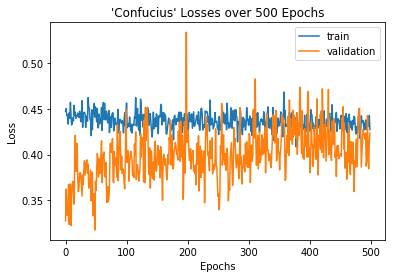

Average Training Score: 0.4368953915675423
Average Validation Score: 0.4000511239193685


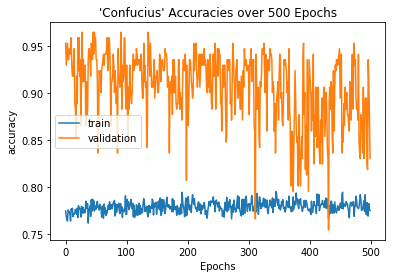

Average Training Score: 0.7790321118247071
Average Validation Score: 0.9066666666666667

validating on book: 'Browne'
Epoch 0/499
----------



Phase:train
Confusion matrix:
 [[ 252  349]
 [ 105 1752]]
loss 984.1760924756527



Phase:val
Confusion matrix:
 [[112  48]
 [ 82 118]]
loss 221.10361278057098
Epoch 1/499
----------



Phase:train
Confusion matrix:
 [[ 212  389]
 [  53 1804]]
loss 995.5668168663979



Phase:val
Confusion matrix:
 [[ 88  72]
 [ 51 149]]
loss 218.7542563676834
Epoch 2/499
----------



Phase:train
Confusion matrix:
 [[ 239  362]
 [  58 1799]]
loss 928.795862942934



Phase:val
Confusion matrix:
 [[129  31]
 [ 89 111]]
loss 223.03273797035217
Epoch 3/499
----------



Phase:train
Confusion matrix:
 [[ 240  361]
 [  75 1782]]
loss 967.4994786083698



Phase:val
Confusion matrix:
 [[128  32]
 [ 93 107]]
loss 220.90575873851776
Epoch 4/499
----------



Phase:train
Confusion matrix:
 [[ 243  358]
 [  66 1791]]
loss 953.9505941718817



Phase:val
Confusion matrix:
 [[112  48]
 [ 86 114]]
loss 221.7384135723114
Epoch 5/499
----------



Phase:train
Confusion matrix:
 [[ 246  355]
 [  89 1768]]
loss 968.6071622669697



Phase:val
Confusion matrix:
 [[111  49]
 [ 73 127]]
loss 218.99882316589355
Epoch 6/499
----------



Phase:train
Confusion matrix:
 [[ 227  374]
 [ 101 1756]]
loss 959.0742895901203



Phase:val
Confusion matrix:
 [[ 94  66]
 [ 59 141]]
loss 218.2034546136856
Epoch 7/499
----------



Phase:train
Confusion matrix:
 [[ 251  350]
 [  63 1794]]
loss 930.8245820105076



Phase:val
Confusion matrix:
 [[ 94  66]
 [ 56 144]]
loss 219.771831035614
Epoch 8/499
----------



Phase:train
Confusion matrix:
 [[ 243  358]
 [  94 1763]]
loss 944.2476206570864



Phase:val
Confusion matrix:
 [[111  49]
 [ 72 128]]
loss 217.15621054172516
Epoch 9/499
----------



Phase:train
Confusion matrix:
 [[ 222  379]
 [  91 1766]]
loss 962.1946358829737



Phase:val
Confusion matrix:
 [[ 89  71]
 [ 52 148]]
loss 218.07406783103943
Epoch 10/499
----------



Phase:train
Confusion matrix:
 [[ 229  372]
 [  71 1786]]
loss 927.0806301385164



Phase:val
Confusion matrix:
 [[ 69  91]
 [ 35 165]]
loss 219.49709832668304
Epoch 11/499
----------



Phase:train
Confusion matrix:
 [[ 271  330]
 [  93 1764]]
loss 941.6301293224096



Phase:val
Confusion matrix:
 [[120  40]
 [ 84 116]]
loss 216.28216445446014
Epoch 12/499
----------



Phase:train
Confusion matrix:
 [[ 247  354]
 [  88 1769]]
loss 930.2544475495815



Phase:val
Confusion matrix:
 [[116  44]
 [ 80 120]]
loss 217.50624418258667
Epoch 13/499
----------



Phase:train
Confusion matrix:
 [[ 238  363]
 [  82 1775]]
loss 961.6289850473404



Phase:val
Confusion matrix:
 [[114  46]
 [ 69 131]]
loss 220.57676374912262
Epoch 14/499
----------



Phase:train
Confusion matrix:
 [[ 267  334]
 [  64 1793]]
loss 934.3614790290594



Phase:val
Confusion matrix:
 [[115  45]
 [ 75 125]]
loss 220.47799110412598
Epoch 15/499
----------



Phase:train
Confusion matrix:
 [[ 237  364]
 [  82 1775]]
loss 971.51002150774



Phase:val
Confusion matrix:
 [[119  41]
 [ 79 121]]
loss 220.45714259147644
Epoch 16/499
----------



Phase:train
Confusion matrix:
 [[ 254  347]
 [  68 1789]]
loss 960.4608155339956



Phase:val
Confusion matrix:
 [[122  38]
 [ 80 120]]
loss 219.75250840187073
Epoch 17/499
----------



Phase:train
Confusion matrix:
 [[ 240  361]
 [  89 1768]]
loss 961.2846180051565



Phase:val
Confusion matrix:
 [[126  34]
 [ 90 110]]
loss 220.36242544651031
Epoch 18/499
----------



Phase:train
Confusion matrix:
 [[ 259  342]
 [  84 1773]]
loss 927.1835825666785



Phase:val
Confusion matrix:
 [[127  33]
 [ 86 114]]
loss 219.49351251125336
Epoch 19/499
----------



Phase:train
Confusion matrix:
 [[ 254  347]
 [ 103 1754]]
loss 941.5477594733238



Phase:val
Confusion matrix:
 [[131  29]
 [ 88 112]]
loss 217.78765559196472
Epoch 20/499
----------



Phase:train
Confusion matrix:
 [[ 225  376]
 [  73 1784]]
loss 947.2253080606461



Phase:val
Confusion matrix:
 [[141  19]
 [115  85]]
loss 226.08140408992767
Epoch 21/499
----------



Phase:train
Confusion matrix:
 [[ 241  360]
 [  93 1764]]
loss 937.7054568976164



Phase:val
Confusion matrix:
 [[133  27]
 [ 90 110]]
loss 218.29656898975372
Epoch 22/499
----------



Phase:train
Confusion matrix:
 [[ 235  366]
 [  79 1778]]
loss 970.2387768179178



Phase:val
Confusion matrix:
 [[133  27]
 [ 89 111]]
loss 221.20117723941803
Epoch 23/499
----------



Phase:train
Confusion matrix:
 [[ 229  372]
 [  67 1790]]
loss 970.5078408271074



Phase:val
Confusion matrix:
 [[132  28]
 [ 84 116]]
loss 214.33002054691315
Epoch 24/499
----------



Phase:train
Confusion matrix:
 [[ 228  373]
 [  78 1779]]
loss 968.277450799942



Phase:val
Confusion matrix:
 [[138  22]
 [110  90]]
loss 221.4911699295044
Epoch 25/499
----------



Phase:train
Confusion matrix:
 [[ 227  374]
 [  80 1777]]
loss 953.6166659295559



Phase:val
Confusion matrix:
 [[133  27]
 [ 96 104]]
loss 216.66779935359955
Epoch 26/499
----------



Phase:train
Confusion matrix:
 [[ 236  365]
 [  60 1797]]
loss 927.655807197094



Phase:val
Confusion matrix:
 [[110  50]
 [ 80 120]]
loss 219.65892612934113
Epoch 27/499
----------



Phase:train
Confusion matrix:
 [[ 237  364]
 [  73 1784]]
loss 932.400786370039



Phase:val
Confusion matrix:
 [[126  34]
 [ 84 116]]
loss 212.76480495929718
Epoch 28/499
----------



Phase:train
Confusion matrix:
 [[ 232  369]
 [  81 1776]]
loss 928.5157175511122



Phase:val
Confusion matrix:
 [[112  48]
 [ 81 119]]
loss 216.70893371105194
Epoch 29/499
----------



Phase:train
Confusion matrix:
 [[ 240  361]
 [  68 1789]]
loss 992.5866218805313



Phase:val
Confusion matrix:
 [[ 90  70]
 [ 60 140]]
loss 219.6447890996933
Epoch 30/499
----------



Phase:train
Confusion matrix:
 [[ 232  369]
 [  58 1799]]
loss 920.3839600384235



Phase:val
Confusion matrix:
 [[139  21]
 [ 96 104]]
loss 214.28737044334412
Epoch 31/499
----------



Phase:train
Confusion matrix:
 [[ 246  355]
 [  82 1775]]
loss 953.9685527682304



Phase:val
Confusion matrix:
 [[123  37]
 [ 86 114]]
loss 217.57361829280853
Epoch 32/499
----------



Phase:train
Confusion matrix:
 [[ 238  363]
 [  78 1779]]
loss 948.4876466095448



Phase:val
Confusion matrix:
 [[126  34]
 [ 80 120]]
loss 215.29728144407272
Epoch 33/499
----------



Phase:train
Confusion matrix:
 [[ 221  380]
 [  95 1762]]
loss 1011.1837250888348



Phase:val
Confusion matrix:
 [[128  32]
 [ 90 110]]
loss 219.70193922519684
Epoch 34/499
----------



Phase:train
Confusion matrix:
 [[ 231  370]
 [  69 1788]]
loss 952.5107202082872



Phase:val
Confusion matrix:
 [[118  42]
 [ 72 128]]
loss 214.49579536914825
Epoch 35/499
----------



Phase:train
Confusion matrix:
 [[ 256  345]
 [  88 1769]]
loss 938.2850170135498



Phase:val
Confusion matrix:
 [[112  48]
 [ 76 124]]
loss 214.0463924407959
Epoch 36/499
----------



Phase:train
Confusion matrix:
 [[ 234  367]
 [  62 1795]]
loss 943.8267876207829



Phase:val
Confusion matrix:
 [[115  45]
 [ 81 119]]
loss 217.71389067173004
Epoch 37/499
----------



Phase:train
Confusion matrix:
 [[ 230  371]
 [  74 1783]]
loss 938.6108937859535



Phase:val
Confusion matrix:
 [[107  53]
 [ 73 127]]
loss 216.01612985134125
Epoch 38/499
----------



Phase:train
Confusion matrix:
 [[ 240  361]
 [  74 1783]]
loss 940.9629980921745



Phase:val
Confusion matrix:
 [[114  46]
 [ 78 122]]
loss 213.1102341413498
Epoch 39/499
----------



Phase:train
Confusion matrix:
 [[ 224  377]
 [  71 1786]]
loss 987.2336795181036



Phase:val
Confusion matrix:
 [[122  38]
 [ 77 123]]
loss 214.47180569171906
Epoch 40/499
----------



Phase:train
Confusion matrix:
 [[ 248  353]
 [  82 1775]]
loss 967.5502105206251



Phase:val
Confusion matrix:
 [[127  33]
 [ 92 108]]
loss 214.9963966012001
Epoch 41/499
----------



Phase:train
Confusion matrix:
 [[ 235  366]
 [  69 1788]]
loss 946.4515899717808



Phase:val
Confusion matrix:
 [[124  36]
 [ 86 114]]
loss 216.35355412960052
Epoch 42/499
----------



Phase:train
Confusion matrix:
 [[ 236  365]
 [  84 1773]]
loss 943.9645652621984



Phase:val
Confusion matrix:
 [[128  32]
 [ 91 109]]
loss 215.1529860496521
Epoch 43/499
----------



Phase:train
Confusion matrix:
 [[ 256  345]
 [  91 1766]]
loss 961.9734338074923



Phase:val
Confusion matrix:
 [[ 92  68]
 [ 53 147]]
loss 219.69063818454742
Epoch 44/499
----------



Phase:train
Confusion matrix:
 [[ 237  364]
 [  63 1794]]
loss 935.0969546884298



Phase:val
Confusion matrix:
 [[126  34]
 [ 77 123]]
loss 211.41074419021606
Epoch 45/499
----------



Phase:train
Confusion matrix:
 [[ 227  374]
 [  76 1781]]
loss 989.3209157139063



Phase:val
Confusion matrix:
 [[ 81  79]
 [ 43 157]]
loss 213.9872044324875
Epoch 46/499
----------



Phase:train
Confusion matrix:
 [[ 243  358]
 [  70 1787]]
loss 933.7662527561188



Phase:val
Confusion matrix:
 [[ 66  94]
 [ 37 163]]
loss 219.97244536876678
Epoch 47/499
----------



Phase:train
Confusion matrix:
 [[ 220  381]
 [  57 1800]]
loss 945.5773170143366



Phase:val
Confusion matrix:
 [[114  46]
 [ 73 127]]
loss 217.68222212791443
Epoch 48/499
----------



Phase:train
Confusion matrix:
 [[ 245  356]
 [  80 1777]]
loss 975.6049327999353



Phase:val
Confusion matrix:
 [[ 99  61]
 [ 61 139]]
loss 217.98074424266815
Epoch 49/499
----------



Phase:train
Confusion matrix:
 [[ 222  379]
 [  78 1779]]
loss 948.2857590913773



Phase:val
Confusion matrix:
 [[ 92  68]
 [ 58 142]]
loss 215.86963534355164
Epoch 50/499
----------



Phase:train
Confusion matrix:
 [[ 242  359]
 [  91 1766]]
loss 977.9250127226114



Phase:val
Confusion matrix:
 [[ 96  64]
 [ 62 138]]
loss 219.94831264019012
Epoch 51/499
----------



Phase:train
Confusion matrix:
 [[ 227  374]
 [  62 1795]]
loss 948.530954502523



Phase:val
Confusion matrix:
 [[105  55]
 [ 73 127]]
loss 221.51217579841614
Epoch 52/499
----------



Phase:train
Confusion matrix:
 [[ 226  375]
 [  65 1792]]
loss 966.0860023647547



Phase:val
Confusion matrix:
 [[113  47]
 [ 83 117]]
loss 222.1415227651596
Epoch 53/499
----------



Phase:train
Confusion matrix:
 [[ 252  349]
 [  73 1784]]
loss 943.0700238645077



Phase:val
Confusion matrix:
 [[115  45]
 [ 80 120]]
loss 219.25952315330505
Epoch 54/499
----------



Phase:train
Confusion matrix:
 [[ 259  342]
 [  87 1770]]
loss 943.8263083100319



Phase:val
Confusion matrix:
 [[121  39]
 [ 88 112]]
loss 221.0191434621811
Epoch 55/499
----------



Phase:train
Confusion matrix:
 [[ 216  385]
 [  80 1777]]
loss 917.612387612462



Phase:val
Confusion matrix:
 [[121  39]
 [ 84 116]]
loss 215.95260620117188
Epoch 56/499
----------



Phase:train
Confusion matrix:
 [[ 236  365]
 [  66 1791]]
loss 946.9823129177094



Phase:val
Confusion matrix:
 [[117  43]
 [ 86 114]]
loss 217.78410077095032
Epoch 57/499
----------



Phase:train
Confusion matrix:
 [[ 252  349]
 [  75 1782]]
loss 956.5180928558111



Phase:val
Confusion matrix:
 [[ 93  67]
 [ 58 142]]
loss 217.2961688041687
Epoch 58/499
----------



Phase:train
Confusion matrix:
 [[ 237  364]
 [  84 1773]]
loss 949.2583811730146



Phase:val
Confusion matrix:
 [[121  39]
 [ 83 117]]
loss 216.8867015838623
Epoch 59/499
----------



Phase:train
Confusion matrix:
 [[ 261  340]
 [  96 1761]]
loss 962.6870402395725



Phase:val
Confusion matrix:
 [[123  37]
 [ 83 117]]
loss 217.73901164531708
Epoch 60/499
----------



Phase:train
Confusion matrix:
 [[ 238  363]
 [  78 1779]]
loss 958.7118195295334



Phase:val
Confusion matrix:
 [[ 75  85]
 [ 45 155]]
loss 220.12221097946167
Epoch 61/499
----------



Phase:train
Confusion matrix:
 [[ 246  355]
 [  85 1772]]
loss 918.1002337187529



Phase:val
Confusion matrix:
 [[121  39]
 [ 85 115]]
loss 218.33269894123077
Epoch 62/499
----------



Phase:train
Confusion matrix:
 [[ 241  360]
 [  91 1766]]
loss 959.204902112484



Phase:val
Confusion matrix:
 [[118  42]
 [ 83 117]]
loss 219.0284562110901
Epoch 63/499
----------



Phase:train
Confusion matrix:
 [[ 237  364]
 [  90 1767]]
loss 958.019565820694



Phase:val
Confusion matrix:
 [[ 88  72]
 [ 56 144]]
loss 216.05656266212463
Epoch 64/499
----------



Phase:train
Confusion matrix:
 [[ 244  357]
 [  74 1783]]
loss 947.100164949894



Phase:val
Confusion matrix:
 [[ 99  61]
 [ 61 139]]
loss 219.15510833263397
Epoch 65/499
----------



Phase:train
Confusion matrix:
 [[ 235  366]
 [  85 1772]]
loss 967.4567460268736



Phase:val
Confusion matrix:
 [[ 67  93]
 [ 30 170]]
loss 218.3216816186905
Epoch 66/499
----------



Phase:train
Confusion matrix:
 [[ 246  355]
 [  93 1764]]
loss 976.1460434943438



Phase:val
Confusion matrix:
 [[117  43]
 [ 79 121]]
loss 218.74338269233704
Epoch 67/499
----------



Phase:train
Confusion matrix:
 [[ 243  358]
 [  77 1780]]
loss 916.4995170682669



Phase:val
Confusion matrix:
 [[ 79  81]
 [ 43 157]]
loss 216.11722469329834
Epoch 68/499
----------



Phase:train
Confusion matrix:
 [[ 251  350]
 [  81 1776]]
loss 952.4255774021149



Phase:val
Confusion matrix:
 [[ 53 107]
 [ 20 180]]
loss 220.41564643383026
Epoch 69/499
----------



Phase:train
Confusion matrix:
 [[ 240  361]
 [  91 1766]]
loss 943.9972743242979



Phase:val
Confusion matrix:
 [[ 70  90]
 [ 41 159]]
loss 218.64603877067566
Epoch 70/499
----------



Phase:train
Confusion matrix:
 [[ 264  337]
 [  82 1775]]
loss 948.6631095707417



Phase:val
Confusion matrix:
 [[ 74  86]
 [ 37 163]]
loss 219.2865002155304
Epoch 71/499
----------



Phase:train
Confusion matrix:
 [[ 215  386]
 [  71 1786]]
loss 981.821277230978



Phase:val
Confusion matrix:
 [[ 68  92]
 [ 47 153]]
loss 218.2300567626953
Epoch 72/499
----------



Phase:train
Confusion matrix:
 [[ 221  380]
 [  68 1789]]
loss 961.8662603497505



Phase:val
Confusion matrix:
 [[101  59]
 [ 60 140]]
loss 215.0104981660843
Epoch 73/499
----------



Phase:train
Confusion matrix:
 [[ 238  363]
 [  81 1776]]
loss 949.6979526504874



Phase:val
Confusion matrix:
 [[ 65  95]
 [ 39 161]]
loss 216.58124268054962
Epoch 74/499
----------



Phase:train
Confusion matrix:
 [[ 246  355]
 [  79 1778]]
loss 926.1308066993952



Phase:val
Confusion matrix:
 [[121  39]
 [ 84 116]]
loss 221.24584436416626
Epoch 75/499
----------



Phase:train
Confusion matrix:
 [[ 239  362]
 [  94 1763]]
loss 960.2777783721685



Phase:val
Confusion matrix:
 [[ 66  94]
 [ 42 158]]
loss 218.8293606042862
Epoch 76/499
----------



Phase:train
Confusion matrix:
 [[ 236  365]
 [  67 1790]]
loss 929.292395234108



Phase:val
Confusion matrix:
 [[ 59 101]
 [ 43 157]]
loss 219.53234136104584
Epoch 77/499
----------



Phase:train
Confusion matrix:
 [[ 238  363]
 [  74 1783]]
loss 948.7612130790949



Phase:val
Confusion matrix:
 [[ 83  77]
 [ 53 147]]
loss 217.00703501701355
Epoch 78/499
----------



Phase:train
Confusion matrix:
 [[ 263  338]
 [  91 1766]]
loss 920.7386142909527



Phase:val
Confusion matrix:
 [[ 74  86]
 [ 35 165]]
loss 218.27383697032928
Epoch 79/499
----------



Phase:train
Confusion matrix:
 [[ 236  365]
 [  85 1772]]
loss 960.3906375616789



Phase:val
Confusion matrix:
 [[123  37]
 [ 94 106]]
loss 219.0781545639038
Epoch 80/499
----------



Phase:train
Confusion matrix:
 [[ 264  337]
 [  84 1773]]
loss 931.4721821248531



Phase:val
Confusion matrix:
 [[111  49]
 [ 73 127]]
loss 215.98584532737732
Epoch 81/499
----------



Phase:train
Confusion matrix:
 [[ 247  354]
 [  79 1778]]
loss 933.5490229129791



Phase:val
Confusion matrix:
 [[123  37]
 [ 82 118]]
loss 214.8925906419754
Epoch 82/499
----------



Phase:train
Confusion matrix:
 [[ 246  355]
 [  88 1769]]
loss 927.4554605931044



Phase:val
Confusion matrix:
 [[114  46]
 [ 78 122]]
loss 214.71227645874023
Epoch 83/499
----------



Phase:train
Confusion matrix:
 [[ 265  336]
 [  87 1770]]
loss 946.8269713968039



Phase:val
Confusion matrix:
 [[116  44]
 [ 82 118]]
loss 217.64861226081848
Epoch 84/499
----------



Phase:train
Confusion matrix:
 [[ 249  352]
 [  88 1769]]
loss 938.1101187467575



Phase:val
Confusion matrix:
 [[112  48]
 [ 65 135]]
loss 208.80410194396973
Epoch 85/499
----------



Phase:train
Confusion matrix:
 [[ 251  350]
 [  77 1780]]
loss 922.0784236043692



Phase:val
Confusion matrix:
 [[132  28]
 [ 94 106]]
loss 215.82735657691956
Epoch 86/499
----------



Phase:train
Confusion matrix:
 [[ 248  353]
 [  91 1766]]
loss 928.8185271024704



Phase:val
Confusion matrix:
 [[117  43]
 [ 79 121]]
loss 213.12438786029816
Epoch 87/499
----------



Phase:train
Confusion matrix:
 [[ 251  350]
 [  85 1772]]
loss 911.968292877078



Phase:val
Confusion matrix:
 [[109  51]
 [ 76 124]]
loss 217.87845730781555
Epoch 88/499
----------



Phase:train
Confusion matrix:
 [[ 241  360]
 [  86 1771]]
loss 958.6630454212427



Phase:val
Confusion matrix:
 [[ 99  61]
 [ 52 148]]
loss 213.6364883184433
Epoch 89/499
----------



Phase:train
Confusion matrix:
 [[ 249  352]
 [  87 1770]]
loss 924.191749766469



Phase:val
Confusion matrix:
 [[108  52]
 [ 72 128]]
loss 217.67743229866028
Epoch 90/499
----------



Phase:train
Confusion matrix:
 [[ 243  358]
 [  83 1774]]
loss 934.8733384460211



Phase:val
Confusion matrix:
 [[ 70  90]
 [ 37 163]]
loss 218.37762892246246
Epoch 91/499
----------



Phase:train
Confusion matrix:
 [[ 244  357]
 [  73 1784]]
loss 959.1719610393047



Phase:val
Confusion matrix:
 [[ 18 142]
 [  6 194]]
loss 231.01942837238312
Epoch 92/499
----------



Phase:train
Confusion matrix:
 [[ 202  399]
 [  76 1781]]
loss 1002.9515214562416



Phase:val
Confusion matrix:
 [[ 56 104]
 [ 28 172]]
loss 216.8599897623062
Epoch 93/499
----------



Phase:train
Confusion matrix:
 [[ 210  391]
 [  64 1793]]
loss 995.0090212672949



Phase:val
Confusion matrix:
 [[113  47]
 [ 81 119]]
loss 217.82161355018616
Epoch 94/499
----------



Phase:train
Confusion matrix:
 [[ 252  349]
 [  65 1792]]
loss 929.5022307410836



Phase:val
Confusion matrix:
 [[133  27]
 [100 100]]
loss 221.95350468158722
Epoch 95/499
----------



Phase:train
Confusion matrix:
 [[ 257  344]
 [  87 1770]]
loss 915.0778121799231



Phase:val
Confusion matrix:
 [[121  39]
 [ 78 122]]
loss 211.83232426643372
Epoch 96/499
----------



Phase:train
Confusion matrix:
 [[ 248  353]
 [  90 1767]]
loss 943.8660498261452



Phase:val
Confusion matrix:
 [[126  34]
 [ 91 109]]
loss 211.83656334877014
Epoch 97/499
----------



Phase:train
Confusion matrix:
 [[ 255  346]
 [  95 1762]]
loss 946.5957261621952



Phase:val
Confusion matrix:
 [[133  27]
 [102  98]]
loss 218.79255712032318
Epoch 98/499
----------



Phase:train
Confusion matrix:
 [[ 241  360]
 [  91 1766]]
loss 946.4833079576492



Phase:val
Confusion matrix:
 [[131  29]
 [ 93 107]]
loss 218.10190618038177
Epoch 99/499
----------



Phase:train
Confusion matrix:
 [[ 265  336]
 [  87 1770]]
loss 884.0292463600636



Phase:val
Confusion matrix:
 [[142  18]
 [108  92]]
loss 215.90659230947495
Epoch 100/499
----------



Phase:train
Confusion matrix:
 [[ 250  351]
 [  87 1770]]
loss 912.3886080682278



Phase:val
Confusion matrix:
 [[120  40]
 [ 78 122]]
loss 212.06595182418823
Epoch 101/499
----------



Phase:train
Confusion matrix:
 [[ 245  356]
 [  75 1782]]
loss 918.7264510244131



Phase:val
Confusion matrix:
 [[110  50]
 [ 63 137]]
loss 210.7908821105957
Epoch 102/499
----------



Phase:train
Confusion matrix:
 [[ 243  358]
 [  93 1764]]
loss 949.926435276866



Phase:val
Confusion matrix:
 [[115  45]
 [ 76 124]]
loss 210.93660831451416
Epoch 103/499
----------



Phase:train
Confusion matrix:
 [[ 236  365]
 [  81 1776]]
loss 942.9585758000612



Phase:val
Confusion matrix:
 [[101  59]
 [ 55 145]]
loss 212.52289563417435
Epoch 104/499
----------



Phase:train
Confusion matrix:
 [[ 263  338]
 [  81 1776]]
loss 933.8422063440084



Phase:val
Confusion matrix:
 [[121  39]
 [ 86 114]]
loss 214.71170127391815
Epoch 105/499
----------



Phase:train
Confusion matrix:
 [[ 237  364]
 [  71 1786]]
loss 920.5031426101923



Phase:val
Confusion matrix:
 [[120  40]
 [ 89 111]]
loss 217.91625678539276
Epoch 106/499
----------



Phase:train
Confusion matrix:
 [[ 247  354]
 [  86 1771]]
loss 932.2518699616194



Phase:val
Confusion matrix:
 [[101  59]
 [ 66 134]]
loss 212.5418895483017
Epoch 107/499
----------



Phase:train
Confusion matrix:
 [[ 226  375]
 [  74 1783]]
loss 968.3920314759016



Phase:val
Confusion matrix:
 [[ 93  67]
 [ 59 141]]
loss 217.76131689548492
Epoch 108/499
----------



Phase:train
Confusion matrix:
 [[ 253  348]
 [  83 1774]]
loss 941.5365895032883



Phase:val
Confusion matrix:
 [[115  45]
 [ 84 116]]
loss 217.94821500778198
Epoch 109/499
----------



Phase:train
Confusion matrix:
 [[ 237  364]
 [  62 1795]]
loss 943.7335950434208



Phase:val
Confusion matrix:
 [[103  57]
 [ 67 133]]
loss 215.2591633796692
Epoch 110/499
----------



Phase:train
Confusion matrix:
 [[ 233  368]
 [  82 1775]]
loss 956.085915774107



Phase:val
Confusion matrix:
 [[ 77  83]
 [ 44 156]]
loss 217.67392992973328
Epoch 111/499
----------



Phase:train
Confusion matrix:
 [[ 239  362]
 [  82 1775]]
loss 944.0999166071415



Phase:val
Confusion matrix:
 [[114  46]
 [ 83 117]]
loss 214.95008647441864
Epoch 112/499
----------



Phase:train
Confusion matrix:
 [[ 246  355]
 [  83 1774]]
loss 914.52629609406



Phase:val
Confusion matrix:
 [[110  50]
 [ 82 118]]
loss 221.2291932106018
Epoch 113/499
----------



Phase:train
Confusion matrix:
 [[ 263  338]
 [  82 1775]]
loss 937.9080228060484



Phase:val
Confusion matrix:
 [[ 98  62]
 [ 62 138]]
loss 218.51590394973755
Epoch 114/499
----------



Phase:train
Confusion matrix:
 [[ 258  343]
 [  70 1787]]
loss 915.9144452661276



Phase:val
Confusion matrix:
 [[121  39]
 [ 89 111]]
loss 221.94514334201813
Epoch 115/499
----------



Phase:train
Confusion matrix:
 [[ 251  350]
 [  80 1777]]
loss 927.9930733144283



Phase:val
Confusion matrix:
 [[119  41]
 [ 84 116]]
loss 221.92193806171417
Epoch 116/499
----------



Phase:train
Confusion matrix:
 [[ 230  371]
 [  76 1781]]
loss 969.9620926827192



Phase:val
Confusion matrix:
 [[119  41]
 [ 96 104]]
loss 221.44857704639435
Epoch 117/499
----------



Phase:train
Confusion matrix:
 [[ 243  358]
 [  71 1786]]
loss 942.4688712060452



Phase:val
Confusion matrix:
 [[133  27]
 [ 98 102]]
loss 218.99035334587097
Epoch 118/499
----------



Phase:train
Confusion matrix:
 [[ 256  345]
 [  83 1774]]
loss 932.52947935462



Phase:val
Confusion matrix:
 [[119  41]
 [ 89 111]]
loss 217.91275203227997
Epoch 119/499
----------



Phase:train
Confusion matrix:
 [[ 235  366]
 [  80 1777]]
loss 980.1936184838414



Phase:val
Confusion matrix:
 [[102  58]
 [ 65 135]]
loss 217.71136671304703
Epoch 120/499
----------



Phase:train
Confusion matrix:
 [[ 215  386]
 [  69 1788]]
loss 960.6165158674121



Phase:val
Confusion matrix:
 [[118  42]
 [ 83 117]]
loss 218.19027364253998
Epoch 121/499
----------



Phase:train
Confusion matrix:
 [[ 236  365]
 [  64 1793]]
loss 975.8237048536539



Phase:val
Confusion matrix:
 [[116  44]
 [ 79 121]]
loss 220.2483630180359
Epoch 122/499
----------



Phase:train
Confusion matrix:
 [[ 254  347]
 [  89 1768]]
loss 939.6179342716932



Phase:val
Confusion matrix:
 [[133  27]
 [ 99 101]]
loss 220.47633409500122
Epoch 123/499
----------



Phase:train
Confusion matrix:
 [[ 243  358]
 [  71 1786]]
loss 934.2062005996704



Phase:val
Confusion matrix:
 [[128  32]
 [ 86 114]]
loss 217.71040737628937
Epoch 124/499
----------



Phase:train
Confusion matrix:
 [[ 248  353]
 [  67 1790]]
loss 924.0512230396271



Phase:val
Confusion matrix:
 [[121  39]
 [105  95]]
loss 223.38766872882843
Epoch 125/499
----------



Phase:train
Confusion matrix:
 [[ 262  339]
 [  91 1766]]
loss 957.451937109232



Phase:val
Confusion matrix:
 [[122  38]
 [ 85 115]]
loss 215.33966720104218
Epoch 126/499
----------



Phase:train
Confusion matrix:
 [[ 226  375]
 [  83 1774]]
loss 969.080898463726



Phase:val
Confusion matrix:
 [[128  32]
 [ 85 115]]
loss 213.80362927913666
Epoch 127/499
----------



Phase:train
Confusion matrix:
 [[ 240  361]
 [  79 1778]]
loss 963.1006699949503



Phase:val
Confusion matrix:
 [[102  58]
 [ 67 133]]
loss 218.19618821144104
Epoch 128/499
----------



Phase:train
Confusion matrix:
 [[ 224  377]
 [  66 1791]]
loss 954.6307032108307



Phase:val
Confusion matrix:
 [[ 91  69]
 [ 55 145]]
loss 215.2080249786377
Epoch 129/499
----------



Phase:train
Confusion matrix:
 [[ 232  369]
 [  82 1775]]
loss 972.1098191738129



Phase:val
Confusion matrix:
 [[ 92  68]
 [ 52 148]]
loss 218.32400798797607
Epoch 130/499
----------



Phase:train
Confusion matrix:
 [[ 242  359]
 [  71 1786]]
loss 923.6474306881428



Phase:val
Confusion matrix:
 [[119  41]
 [ 83 117]]
loss 218.28430831432343
Epoch 131/499
----------



Phase:train
Confusion matrix:
 [[ 242  359]
 [  74 1783]]
loss 936.7237326949835



Phase:val
Confusion matrix:
 [[ 88  72]
 [ 61 139]]
loss 215.36931037902832
Epoch 132/499
----------



Phase:train
Confusion matrix:
 [[ 253  348]
 [  83 1774]]
loss 921.610047519207



Phase:val
Confusion matrix:
 [[102  58]
 [ 69 131]]
loss 214.81229901313782
Epoch 133/499
----------



Phase:train
Confusion matrix:
 [[ 247  354]
 [  85 1772]]
loss 962.2534086629748



Phase:val
Confusion matrix:
 [[102  58]
 [ 71 129]]
loss 219.92791056632996
Epoch 134/499
----------



Phase:train
Confusion matrix:
 [[ 266  335]
 [  80 1777]]
loss 906.9903216212988



Phase:val
Confusion matrix:
 [[139  21]
 [ 97 103]]
loss 218.87515783309937
Epoch 135/499
----------



Phase:train
Confusion matrix:
 [[ 265  336]
 [  86 1771]]
loss 932.8715454936028



Phase:val
Confusion matrix:
 [[124  36]
 [ 96 104]]
loss 222.76439487934113
Epoch 136/499
----------



Phase:train
Confusion matrix:
 [[ 228  373]
 [  84 1773]]
loss 977.9974167644978



Phase:val
Confusion matrix:
 [[117  43]
 [ 84 116]]
loss 218.04311633110046
Epoch 137/499
----------



Phase:train
Confusion matrix:
 [[ 241  360]
 [  92 1765]]
loss 960.1504512578249



Phase:val
Confusion matrix:
 [[122  38]
 [ 90 110]]
loss 216.29437744617462
Epoch 138/499
----------



Phase:train
Confusion matrix:
 [[ 229  372]
 [  66 1791]]
loss 944.8291064500809



Phase:val
Confusion matrix:
 [[127  33]
 [ 89 111]]
loss 215.5637151002884
Epoch 139/499
----------



Phase:train
Confusion matrix:
 [[ 234  367]
 [  94 1763]]
loss 937.1029275432229



Phase:val
Confusion matrix:
 [[127  33]
 [103  97]]
loss 223.81263375282288
Epoch 140/499
----------



Phase:train
Confusion matrix:
 [[ 250  351]
 [  75 1782]]
loss 910.8837884962559



Phase:val
Confusion matrix:
 [[124  36]
 [ 87 113]]
loss 215.4988557100296
Epoch 141/499
----------



Phase:train
Confusion matrix:
 [[ 257  344]
 [  80 1777]]
loss 936.2595088630915



Phase:val
Confusion matrix:
 [[112  48]
 [ 78 122]]
loss 216.2790596485138
Epoch 142/499
----------



Phase:train
Confusion matrix:
 [[ 244  357]
 [  90 1767]]
loss 965.5429020226002



Phase:val
Confusion matrix:
 [[112  48]
 [ 84 116]]
loss 219.43926751613617
Epoch 143/499
----------



Phase:train
Confusion matrix:
 [[ 262  339]
 [  66 1791]]
loss 925.2147020250559



Phase:val
Confusion matrix:
 [[119  41]
 [ 90 110]]
loss 222.0672595500946
Epoch 144/499
----------



Phase:train
Confusion matrix:
 [[ 234  367]
 [  85 1772]]
loss 959.4177781492472



Phase:val
Confusion matrix:
 [[ 91  69]
 [ 56 144]]
loss 214.3617081642151
Epoch 145/499
----------



Phase:train
Confusion matrix:
 [[ 232  369]
 [  70 1787]]
loss 958.5516688227654



Phase:val
Confusion matrix:
 [[ 93  67]
 [ 59 141]]
loss 215.3018695116043
Epoch 146/499
----------



Phase:train
Confusion matrix:
 [[ 235  366]
 [  62 1795]]
loss 953.5996622294188



Phase:val
Confusion matrix:
 [[ 85  75]
 [ 51 149]]
loss 220.03507137298584
Epoch 147/499
----------



Phase:train
Confusion matrix:
 [[ 250  351]
 [  78 1779]]
loss 962.0477406978607



Phase:val
Confusion matrix:
 [[ 86  74]
 [ 62 138]]
loss 218.5468751192093
Epoch 148/499
----------



Phase:train
Confusion matrix:
 [[ 258  343]
 [  90 1767]]
loss 977.3224316984415



Phase:val
Confusion matrix:
 [[ 78  82]
 [ 39 161]]
loss 215.1125329732895
Epoch 149/499
----------



Phase:train
Confusion matrix:
 [[ 249  352]
 [  87 1770]]
loss 932.3205295205116



Phase:val
Confusion matrix:
 [[ 96  64]
 [ 60 140]]
loss 211.41506612300873
Epoch 150/499
----------



Phase:train
Confusion matrix:
 [[ 265  336]
 [  88 1769]]
loss 930.5239079892635



Phase:val
Confusion matrix:
 [[ 97  63]
 [ 61 139]]
loss 214.87111389636993
Epoch 151/499
----------



Phase:train
Confusion matrix:
 [[ 259  342]
 [  80 1777]]
loss 920.8850254267454



Phase:val
Confusion matrix:
 [[117  43]
 [ 82 118]]
loss 215.11666536331177
Epoch 152/499
----------



Phase:train
Confusion matrix:
 [[ 252  349]
 [  81 1776]]
loss 937.8574272990227



Phase:val
Confusion matrix:
 [[113  47]
 [ 69 131]]
loss 215.87194979190826
Epoch 153/499
----------



Phase:train
Confusion matrix:
 [[ 240  361]
 [  78 1779]]
loss 934.3797894567251



Phase:val
Confusion matrix:
 [[114  46]
 [ 82 118]]
loss 219.92060363292694
Epoch 154/499
----------



Phase:train
Confusion matrix:
 [[ 266  335]
 [  93 1764]]
loss 918.9326947778463



Phase:val
Confusion matrix:
 [[114  46]
 [ 73 127]]
loss 218.09634804725647
Epoch 155/499
----------



Phase:train
Confusion matrix:
 [[ 236  365]
 [  85 1772]]
loss 951.0690664499998



Phase:val
Confusion matrix:
 [[106  54]
 [ 82 118]]
loss 221.1625611782074
Epoch 156/499
----------



Phase:train
Confusion matrix:
 [[ 257  344]
 [  97 1760]]
loss 947.9316772967577



Phase:val
Confusion matrix:
 [[125  35]
 [ 85 115]]
loss 217.8669336438179
Epoch 157/499
----------



Phase:train
Confusion matrix:
 [[ 246  355]
 [  88 1769]]
loss 952.2918397039175



Phase:val
Confusion matrix:
 [[120  40]
 [ 92 108]]
loss 223.15244257450104
Epoch 158/499
----------



Phase:train
Confusion matrix:
 [[ 250  351]
 [ 105 1752]]
loss 1001.5555503368378



Phase:val
Confusion matrix:
 [[ 67  93]
 [ 45 155]]
loss 220.9119415283203
Epoch 159/499
----------



Phase:train
Confusion matrix:
 [[ 238  363]
 [  81 1776]]
loss 964.5914546251297



Phase:val
Confusion matrix:
 [[ 53 107]
 [ 29 171]]
loss 221.62456631660461
Epoch 160/499
----------



Phase:train
Confusion matrix:
 [[ 219  382]
 [  82 1775]]
loss 972.2052027136087



Phase:val
Confusion matrix:
 [[ 66  94]
 [ 36 164]]
loss 217.959223985672
Epoch 161/499
----------



Phase:train
Confusion matrix:
 [[ 207  394]
 [  83 1774]]
loss 976.7734562158585



Phase:val
Confusion matrix:
 [[ 80  80]
 [ 51 149]]
loss 220.2622264623642
Epoch 162/499
----------



Phase:train
Confusion matrix:
 [[ 236  365]
 [  78 1779]]
loss 969.8452128022909



Phase:val
Confusion matrix:
 [[ 65  95]
 [ 38 162]]
loss 220.58558464050293
Epoch 163/499
----------



Phase:train
Confusion matrix:
 [[ 243  358]
 [  89 1768]]
loss 932.3486052304506



Phase:val
Confusion matrix:
 [[101  59]
 [ 62 138]]
loss 214.74538385868073
Epoch 164/499
----------



Phase:train
Confusion matrix:
 [[ 241  360]
 [  80 1777]]
loss 927.8866734951735



Phase:val
Confusion matrix:
 [[118  42]
 [ 76 124]]
loss 214.87259685993195
Epoch 165/499
----------



Phase:train
Confusion matrix:
 [[ 249  352]
 [  95 1762]]
loss 920.5460929572582



Phase:val
Confusion matrix:
 [[ 87  73]
 [ 56 144]]
loss 219.87471044063568
Epoch 166/499
----------



Phase:train
Confusion matrix:
 [[ 219  382]
 [  84 1773]]
loss 960.7642032653093



Phase:val
Confusion matrix:
 [[ 79  81]
 [ 51 149]]
loss 221.39245331287384
Epoch 167/499
----------



Phase:train
Confusion matrix:
 [[ 237  364]
 [  76 1781]]
loss 973.1456466466188



Phase:val
Confusion matrix:
 [[ 97  63]
 [ 58 142]]
loss 215.71476340293884
Epoch 168/499
----------



Phase:train
Confusion matrix:
 [[ 223  378]
 [  68 1789]]
loss 915.3365037888288



Phase:val
Confusion matrix:
 [[121  39]
 [ 76 124]]
loss 216.81984603405
Epoch 169/499
----------



Phase:train
Confusion matrix:
 [[ 246  355]
 [  85 1772]]
loss 927.6918162927032



Phase:val
Confusion matrix:
 [[111  49]
 [ 65 135]]
loss 213.85912835597992
Epoch 170/499
----------



Phase:train
Confusion matrix:
 [[ 236  365]
 [  81 1776]]
loss 965.8371879309416



Phase:val
Confusion matrix:
 [[115  45]
 [ 76 124]]
loss 215.91498970985413
Epoch 171/499
----------



Phase:train
Confusion matrix:
 [[ 249  352]
 [  79 1778]]
loss 915.109289124608



Phase:val
Confusion matrix:
 [[ 99  61]
 [ 60 140]]
loss 216.17361426353455
Epoch 172/499
----------



Phase:train
Confusion matrix:
 [[ 265  336]
 [  77 1780]]
loss 899.4411274343729



Phase:val
Confusion matrix:
 [[ 97  63]
 [ 63 137]]
loss 217.75517582893372
Epoch 173/499
----------



Phase:train
Confusion matrix:
 [[ 253  348]
 [  90 1767]]
loss 939.1571324616671



Phase:val
Confusion matrix:
 [[132  28]
 [ 86 114]]
loss 212.9542064666748
Epoch 174/499
----------



Phase:train
Confusion matrix:
 [[ 248  353]
 [  78 1779]]
loss 925.9042995721102



Phase:val
Confusion matrix:
 [[118  42]
 [ 92 108]]
loss 218.1018704175949
Epoch 175/499
----------



Phase:train
Confusion matrix:
 [[ 278  323]
 [  89 1768]]
loss 1013.5916970670223



Phase:val
Confusion matrix:
 [[136  24]
 [109  91]]
loss 226.64258480072021
Epoch 176/499
----------



Phase:train
Confusion matrix:
 [[ 236  365]
 [  87 1770]]
loss 948.8493124097586



Phase:val
Confusion matrix:
 [[131  29]
 [ 92 108]]
loss 218.13856422901154
Epoch 177/499
----------



Phase:train
Confusion matrix:
 [[ 251  350]
 [  73 1784]]
loss 941.1376588046551



Phase:val
Confusion matrix:
 [[130  30]
 [ 92 108]]
loss 218.35955500602722
Epoch 178/499
----------



Phase:train
Confusion matrix:
 [[ 273  328]
 [  96 1761]]
loss 974.5722438693047



Phase:val
Confusion matrix:
 [[124  36]
 [ 84 116]]
loss 216.27505123615265
Epoch 179/499
----------



Phase:train
Confusion matrix:
 [[ 237  364]
 [  74 1783]]
loss 929.0591940879822



Phase:val
Confusion matrix:
 [[117  43]
 [ 78 122]]
loss 215.06708562374115
Epoch 180/499
----------



Phase:train
Confusion matrix:
 [[ 253  348]
 [  78 1779]]
loss 956.0726499259472



Phase:val
Confusion matrix:
 [[131  29]
 [ 96 104]]
loss 221.12609446048737
Epoch 181/499
----------



Phase:train
Confusion matrix:
 [[ 245  356]
 [  80 1777]]
loss 931.6982644945383



Phase:val
Confusion matrix:
 [[130  30]
 [ 84 116]]
loss 211.68468594551086
Epoch 182/499
----------



Phase:train
Confusion matrix:
 [[ 242  359]
 [  73 1784]]
loss 945.2621930539608



Phase:val
Confusion matrix:
 [[136  24]
 [ 88 112]]
loss 210.888010263443
Epoch 183/499
----------



Phase:train
Confusion matrix:
 [[ 254  347]
 [  80 1777]]
loss 931.0795808434486



Phase:val
Confusion matrix:
 [[100  60]
 [ 62 138]]
loss 217.55222856998444
Epoch 184/499
----------



Phase:train
Confusion matrix:
 [[ 241  360]
 [  80 1777]]
loss 950.7972590625286



Phase:val
Confusion matrix:
 [[107  53]
 [ 62 138]]
loss 210.06490349769592
Epoch 185/499
----------



Phase:train
Confusion matrix:
 [[ 240  361]
 [  70 1787]]
loss 908.4393943622708



Phase:val
Confusion matrix:
 [[108  52]
 [ 73 127]]
loss 218.7981230020523
Epoch 186/499
----------



Phase:train
Confusion matrix:
 [[ 249  352]
 [  81 1776]]
loss 934.6854477077723



Phase:val
Confusion matrix:
 [[128  32]
 [ 80 120]]
loss 209.32532370090485
Epoch 187/499
----------



Phase:train
Confusion matrix:
 [[ 240  361]
 [  76 1781]]
loss 960.4219945818186



Phase:val
Confusion matrix:
 [[128  32]
 [ 83 117]]
loss 211.70917212963104
Epoch 188/499
----------



Phase:train
Confusion matrix:
 [[ 239  362]
 [  65 1792]]
loss 907.7741707861423



Phase:val
Confusion matrix:
 [[138  22]
 [ 99 101]]
loss 216.14209443330765
Epoch 189/499
----------



Phase:train
Confusion matrix:
 [[ 256  345]
 [  86 1771]]
loss 957.2870669960976



Phase:val
Confusion matrix:
 [[128  32]
 [ 87 113]]
loss 215.8545869588852
Epoch 190/499
----------



Phase:train
Confusion matrix:
 [[ 233  368]
 [  68 1789]]
loss 955.6855556368828



Phase:val
Confusion matrix:
 [[122  38]
 [ 90 110]]
loss 218.56849491596222
Epoch 191/499
----------



Phase:train
Confusion matrix:
 [[ 257  344]
 [  81 1776]]
loss 934.6797230094671



Phase:val
Confusion matrix:
 [[120  40]
 [ 87 113]]
loss 219.37365889549255
Epoch 192/499
----------



Phase:train
Confusion matrix:
 [[ 268  333]
 [  90 1767]]
loss 959.7389046102762



Phase:val
Confusion matrix:
 [[117  43]
 [ 67 133]]
loss 214.28592324256897
Epoch 193/499
----------



Phase:train
Confusion matrix:
 [[ 256  345]
 [  87 1770]]
loss 985.9855474233627



Phase:val
Confusion matrix:
 [[110  50]
 [ 72 128]]
loss 219.41799134016037
Epoch 194/499
----------



Phase:train
Confusion matrix:
 [[ 239  362]
 [  74 1783]]
loss 937.6878726929426



Phase:val
Confusion matrix:
 [[120  40]
 [ 78 122]]
loss 214.12750780582428
Epoch 195/499
----------



Phase:train
Confusion matrix:
 [[ 238  363]
 [  65 1792]]
loss 916.317332983017



Phase:val
Confusion matrix:
 [[119  41]
 [ 80 120]]
loss 216.33070528507233
Epoch 196/499
----------



Phase:train
Confusion matrix:
 [[ 252  349]
 [  95 1762]]
loss 951.9885186105967



Phase:val
Confusion matrix:
 [[117  43]
 [ 78 122]]
loss 215.86199402809143
Epoch 197/499
----------



Phase:train
Confusion matrix:
 [[ 241  360]
 [  58 1799]]
loss 917.8494231849909



Phase:val
Confusion matrix:
 [[127  33]
 [ 89 111]]
loss 216.6755449771881
Epoch 198/499
----------



Phase:train
Confusion matrix:
 [[ 237  364]
 [  83 1774]]
loss 958.424597248435



Phase:val
Confusion matrix:
 [[125  35]
 [ 85 115]]
loss 215.34152925014496
Epoch 199/499
----------



Phase:train
Confusion matrix:
 [[ 236  365]
 [  78 1779]]
loss 959.5881883502007



Phase:val
Confusion matrix:
 [[100  60]
 [ 57 143]]
loss 219.15902018547058
Epoch 200/499
----------



Phase:train
Confusion matrix:
 [[ 239  362]
 [  79 1778]]
loss 994.1929711103439



Phase:val
Confusion matrix:
 [[ 71  89]
 [ 35 165]]
loss 219.22535836696625
Epoch 201/499
----------



Phase:train
Confusion matrix:
 [[ 235  366]
 [  80 1777]]
loss 930.2814819216728



Phase:val
Confusion matrix:
 [[ 96  64]
 [ 55 145]]
loss 215.786172747612
Epoch 202/499
----------



Phase:train
Confusion matrix:
 [[ 244  357]
 [  72 1785]]
loss 939.6520045399666



Phase:val
Confusion matrix:
 [[119  41]
 [ 78 122]]
loss 214.0946787595749
Epoch 203/499
----------



Phase:train
Confusion matrix:
 [[ 259  342]
 [  79 1778]]
loss 896.8614293634892



Phase:val
Confusion matrix:
 [[134  26]
 [ 85 115]]
loss 212.79690086841583
Epoch 204/499
----------



Phase:train
Confusion matrix:
 [[ 253  348]
 [  82 1775]]
loss 939.6827659606934



Phase:val
Confusion matrix:
 [[113  47]
 [ 72 128]]
loss 220.4574030637741
Epoch 205/499
----------



Phase:train
Confusion matrix:
 [[ 239  362]
 [  67 1790]]
loss 912.3709279149771



Phase:val
Confusion matrix:
 [[103  57]
 [ 61 139]]
loss 217.55092084407806
Epoch 206/499
----------



Phase:train
Confusion matrix:
 [[ 241  360]
 [  73 1784]]
loss 952.6249844878912



Phase:val
Confusion matrix:
 [[108  52]
 [ 65 135]]
loss 216.99043095111847
Epoch 207/499
----------



Phase:train
Confusion matrix:
 [[ 261  340]
 [  69 1788]]
loss 927.2470517009497



Phase:val
Confusion matrix:
 [[119  41]
 [ 84 116]]
loss 217.62750148773193
Epoch 208/499
----------



Phase:train
Confusion matrix:
 [[ 218  383]
 [  65 1792]]
loss 935.8085055947304



Phase:val
Confusion matrix:
 [[ 88  72]
 [ 52 148]]
loss 219.6123194694519
Epoch 209/499
----------



Phase:train
Confusion matrix:
 [[ 256  345]
 [  95 1762]]
loss 968.772781163454



Phase:val
Confusion matrix:
 [[133  27]
 [102  98]]
loss 221.27167642116547
Epoch 210/499
----------



Phase:train
Confusion matrix:
 [[ 271  330]
 [ 110 1747]]
loss 948.0759976804256



Phase:val
Confusion matrix:
 [[110  50]
 [ 75 125]]
loss 216.7485874891281
Epoch 211/499
----------



Phase:train
Confusion matrix:
 [[ 258  343]
 [  70 1787]]
loss 934.8533788323402



Phase:val
Confusion matrix:
 [[100  60]
 [ 79 121]]
loss 226.62351787090302
Epoch 212/499
----------



Phase:train
Confusion matrix:
 [[ 258  343]
 [  86 1771]]
loss 931.1894150674343



Phase:val
Confusion matrix:
 [[ 99  61]
 [ 71 129]]
loss 220.52437007427216
Epoch 213/499
----------



Phase:train
Confusion matrix:
 [[ 261  340]
 [ 106 1751]]
loss 945.2868246138096



Phase:val
Confusion matrix:
 [[122  38]
 [ 84 116]]
loss 219.248708486557
Epoch 214/499
----------



Phase:train
Confusion matrix:
 [[ 272  329]
 [  97 1760]]
loss 904.301708959043



Phase:val
Confusion matrix:
 [[144  16]
 [107  93]]
loss 221.7195361852646
Epoch 215/499
----------



Phase:train
Confusion matrix:
 [[ 250  351]
 [  84 1773]]
loss 964.094684034586



Phase:val
Confusion matrix:
 [[107  53]
 [ 75 125]]
loss 221.0094255208969
Epoch 216/499
----------



Phase:train
Confusion matrix:
 [[ 244  357]
 [  79 1778]]
loss 954.3322413563728



Phase:val
Confusion matrix:
 [[100  60]
 [ 56 144]]
loss 218.5507008433342
Epoch 217/499
----------



Phase:train
Confusion matrix:
 [[ 231  370]
 [  65 1792]]
loss 954.5130691677332



Phase:val
Confusion matrix:
 [[114  46]
 [ 76 124]]
loss 219.02746438980103
Epoch 218/499
----------



Phase:train
Confusion matrix:
 [[ 232  369]
 [  74 1783]]
loss 941.7536383271217



Phase:val
Confusion matrix:
 [[117  43]
 [ 75 125]]
loss 216.0043829679489
Epoch 219/499
----------



Phase:train
Confusion matrix:
 [[ 258  343]
 [  71 1786]]
loss 939.8786476254463



Phase:val
Confusion matrix:
 [[133  27]
 [ 93 107]]
loss 214.25475776195526
Epoch 220/499
----------



Phase:train
Confusion matrix:
 [[ 261  340]
 [  74 1783]]
loss 928.5419737696648



Phase:val
Confusion matrix:
 [[126  34]
 [ 90 110]]
loss 216.25674486160278
Epoch 221/499
----------



Phase:train
Confusion matrix:
 [[ 251  350]
 [  83 1774]]
loss 947.4117550551891



Phase:val
Confusion matrix:
 [[109  51]
 [ 83 117]]
loss 218.616384267807
Epoch 222/499
----------



Phase:train
Confusion matrix:
 [[ 237  364]
 [  80 1777]]
loss 933.8663691133261



Phase:val
Confusion matrix:
 [[117  43]
 [ 82 118]]
loss 218.60981106758118
Epoch 223/499
----------



Phase:train
Confusion matrix:
 [[ 251  350]
 [  77 1780]]
loss 954.5646808445454



Phase:val
Confusion matrix:
 [[109  51]
 [ 89 111]]
loss 220.15814900398254
Epoch 224/499
----------



Phase:train
Confusion matrix:
 [[ 260  341]
 [  73 1784]]
loss 966.4243279695511



Phase:val
Confusion matrix:
 [[102  58]
 [ 63 137]]
loss 215.56152164936066
Epoch 225/499
----------



Phase:train
Confusion matrix:
 [[ 252  349]
 [  82 1775]]
loss 925.5234097987413



Phase:val
Confusion matrix:
 [[122  38]
 [ 83 117]]
loss 218.75463128089905
Epoch 226/499
----------



Phase:train
Confusion matrix:
 [[ 266  335]
 [  86 1771]]
loss 941.3689642250538



Phase:val
Confusion matrix:
 [[106  54]
 [ 63 137]]
loss 217.533138692379
Epoch 227/499
----------



Phase:train
Confusion matrix:
 [[ 252  349]
 [  65 1792]]
loss 948.3398966342211



Phase:val
Confusion matrix:
 [[125  35]
 [ 90 110]]
loss 220.68282842636108
Epoch 228/499
----------



Phase:train
Confusion matrix:
 [[ 265  336]
 [  80 1777]]
loss 924.7247127890587



Phase:val
Confusion matrix:
 [[126  34]
 [ 82 118]]
loss 211.59866452217102
Epoch 229/499
----------



Phase:train
Confusion matrix:
 [[ 262  339]
 [  84 1773]]
loss 905.1311942338943



Phase:val
Confusion matrix:
 [[132  28]
 [ 90 110]]
loss 213.00861716270447
Epoch 230/499
----------



Phase:train
Confusion matrix:
 [[ 260  341]
 [  76 1781]]
loss 935.3432824909687



Phase:val
Confusion matrix:
 [[110  50]
 [ 65 135]]
loss 215.81864595413208
Epoch 231/499
----------



Phase:train
Confusion matrix:
 [[ 256  345]
 [  87 1770]]
loss 931.2791147232056



Phase:val
Confusion matrix:
 [[122  38]
 [ 82 118]]
loss 216.1305332183838
Epoch 232/499
----------



Phase:train
Confusion matrix:
 [[ 243  358]
 [  92 1765]]
loss 970.1629076749086



Phase:val
Confusion matrix:
 [[111  49]
 [ 74 126]]
loss 218.54785859584808
Epoch 233/499
----------



Phase:train
Confusion matrix:
 [[ 255  346]
 [  96 1761]]
loss 936.8226027488708



Phase:val
Confusion matrix:
 [[125  35]
 [ 81 119]]
loss 216.98693871498108
Epoch 234/499
----------



Phase:train
Confusion matrix:
 [[ 241  360]
 [  97 1760]]
loss 931.5298619866371



Phase:val
Confusion matrix:
 [[103  57]
 [ 70 130]]
loss 218.92504572868347
Epoch 235/499
----------



Phase:train
Confusion matrix:
 [[ 259  342]
 [  68 1789]]
loss 874.2328906655312



Phase:val
Confusion matrix:
 [[130  30]
 [ 90 110]]
loss 217.69606053829193
Epoch 236/499
----------



Phase:train
Confusion matrix:
 [[ 274  327]
 [  99 1758]]
loss 896.6259698271751



Phase:val
Confusion matrix:
 [[126  34]
 [ 86 114]]
loss 215.39743661880493
Epoch 237/499
----------



Phase:train
Confusion matrix:
 [[ 243  358]
 [  86 1771]]
loss 926.7351218014956



Phase:val
Confusion matrix:
 [[130  30]
 [ 98 102]]
loss 217.08463191986084
Epoch 238/499
----------



Phase:train
Confusion matrix:
 [[ 259  342]
 [  62 1795]]
loss 909.4954754114151



Phase:val
Confusion matrix:
 [[118  42]
 [ 90 110]]
loss 218.9119452238083
Epoch 239/499
----------



Phase:train
Confusion matrix:
 [[ 253  348]
 [  87 1770]]
loss 951.8673400580883



Phase:val
Confusion matrix:
 [[105  55]
 [ 73 127]]
loss 215.11546969413757
Epoch 240/499
----------



Phase:train
Confusion matrix:
 [[ 251  350]
 [  84 1773]]
loss 957.100713327527



Phase:val
Confusion matrix:
 [[125  35]
 [ 82 118]]
loss 214.6273946762085
Epoch 241/499
----------



Phase:train
Confusion matrix:
 [[ 267  334]
 [  92 1765]]
loss 959.1029863208532



Phase:val
Confusion matrix:
 [[100  60]
 [ 51 149]]
loss 212.35206723213196
Epoch 242/499
----------



Phase:train
Confusion matrix:
 [[ 231  370]
 [  85 1772]]
loss 1011.6484514474869



Phase:val
Confusion matrix:
 [[105  55]
 [ 63 137]]
loss 217.07201600074768
Epoch 243/499
----------



Phase:train
Confusion matrix:
 [[ 247  354]
 [  87 1770]]
loss 955.554149672389



Phase:val
Confusion matrix:
 [[119  41]
 [ 78 122]]
loss 217.3134607076645
Epoch 244/499
----------



Phase:train
Confusion matrix:
 [[ 240  361]
 [  86 1771]]
loss 964.5896456390619



Phase:val
Confusion matrix:
 [[101  59]
 [ 58 142]]
loss 212.28006064891815
Epoch 245/499
----------



Phase:train
Confusion matrix:
 [[ 265  336]
 [  88 1769]]
loss 919.0409002453089



Phase:val
Confusion matrix:
 [[103  57]
 [ 66 134]]
loss 214.75136160850525
Epoch 246/499
----------



Phase:train
Confusion matrix:
 [[ 254  347]
 [  84 1773]]
loss 969.1229757070541



Phase:val
Confusion matrix:
 [[ 93  67]
 [ 46 154]]
loss 214.7427663207054
Epoch 247/499
----------



Phase:train
Confusion matrix:
 [[ 255  346]
 [  76 1781]]
loss 947.3172668665648



Phase:val
Confusion matrix:
 [[129  31]
 [106  94]]
loss 224.42060351371765
Epoch 248/499
----------



Phase:train
Confusion matrix:
 [[ 259  342]
 [  93 1764]]
loss 968.4947835206985



Phase:val
Confusion matrix:
 [[120  40]
 [ 92 108]]
loss 221.5199637413025
Epoch 249/499
----------



Phase:train
Confusion matrix:
 [[ 257  344]
 [  85 1772]]
loss 934.9425135701895



Phase:val
Confusion matrix:
 [[120  40]
 [ 86 114]]
loss 217.36529052257538
Epoch 250/499
----------



Phase:train
Confusion matrix:
 [[ 243  358]
 [  92 1765]]
loss 957.4536181688309



Phase:val
Confusion matrix:
 [[129  31]
 [ 91 109]]
loss 217.5021332502365
Epoch 251/499
----------



Phase:train
Confusion matrix:
 [[ 244  357]
 [  82 1775]]
loss 935.638442158699



Phase:val
Confusion matrix:
 [[131  29]
 [ 93 107]]
loss 217.76419937610626
Epoch 252/499
----------



Phase:train
Confusion matrix:
 [[ 256  345]
 [  99 1758]]
loss 926.7465338110924



Phase:val
Confusion matrix:
 [[114  46]
 [ 76 124]]
loss 219.17912900447845
Epoch 253/499
----------



Phase:train
Confusion matrix:
 [[ 248  353]
 [  94 1763]]
loss 973.3427966088057



Phase:val
Confusion matrix:
 [[ 69  91]
 [ 40 160]]
loss 222.39593625068665
Epoch 254/499
----------



Phase:train
Confusion matrix:
 [[ 217  384]
 [  79 1778]]
loss 988.3408826291561



Phase:val
Confusion matrix:
 [[ 77  83]
 [ 41 159]]
loss 217.8407382965088
Epoch 255/499
----------



Phase:train
Confusion matrix:
 [[ 238  363]
 [  82 1775]]
loss 945.5866319388151



Phase:val
Confusion matrix:
 [[104  56]
 [ 64 136]]
loss 214.36327189207077
Epoch 256/499
----------



Phase:train
Confusion matrix:
 [[ 246  355]
 [  59 1798]]
loss 926.6418057829142



Phase:val
Confusion matrix:
 [[110  50]
 [ 63 137]]
loss 210.9994673728943
Epoch 257/499
----------



Phase:train
Confusion matrix:
 [[ 257  344]
 [  73 1784]]
loss 949.1067425459623



Phase:val
Confusion matrix:
 [[ 99  61]
 [ 61 139]]
loss 221.25298023223877
Epoch 258/499
----------



Phase:train
Confusion matrix:
 [[ 222  379]
 [  68 1789]]
loss 951.3621038347483



Phase:val
Confusion matrix:
 [[105  55]
 [ 74 126]]
loss 220.14801025390625
Epoch 259/499
----------



Phase:train
Confusion matrix:
 [[ 238  363]
 [  76 1781]]
loss 946.1039046496153



Phase:val
Confusion matrix:
 [[105  55]
 [ 66 134]]
loss 214.69117522239685
Epoch 260/499
----------



Phase:train
Confusion matrix:
 [[ 232  369]
 [  58 1799]]
loss 925.2902031689882



Phase:val
Confusion matrix:
 [[115  45]
 [ 68 132]]
loss 213.76193821430206
Epoch 261/499
----------



Phase:train
Confusion matrix:
 [[ 253  348]
 [  76 1781]]
loss 957.7478340417147



Phase:val
Confusion matrix:
 [[ 93  67]
 [ 74 126]]
loss 226.69924557209015
Epoch 262/499
----------



Phase:train
Confusion matrix:
 [[ 235  366]
 [  58 1799]]
loss 987.66637827456



Phase:val
Confusion matrix:
 [[100  60]
 [ 69 131]]
loss 218.58575463294983
Epoch 263/499
----------



Phase:train
Confusion matrix:
 [[ 234  367]
 [  80 1777]]
loss 959.2518645823002



Phase:val
Confusion matrix:
 [[101  59]
 [ 77 123]]
loss 221.98888838291168
Epoch 264/499
----------



Phase:train
Confusion matrix:
 [[ 238  363]
 [  76 1781]]
loss 952.61484991014



Phase:val
Confusion matrix:
 [[ 98  62]
 [ 62 138]]
loss 217.36745089292526
Epoch 265/499
----------



Phase:train
Confusion matrix:
 [[ 244  357]
 [  74 1783]]
loss 917.1474836468697



Phase:val
Confusion matrix:
 [[131  29]
 [ 97 103]]
loss 219.50535893440247
Epoch 266/499
----------



Phase:train
Confusion matrix:
 [[ 255  346]
 [  85 1772]]
loss 943.3200228214264



Phase:val
Confusion matrix:
 [[136  24]
 [103  97]]
loss 222.61885821819305
Epoch 267/499
----------



Phase:train
Confusion matrix:
 [[ 235  366]
 [  81 1776]]
loss 961.1368211507797



Phase:val
Confusion matrix:
 [[ 90  70]
 [ 58 142]]
loss 220.65532386302948
Epoch 268/499
----------



Phase:train
Confusion matrix:
 [[ 254  347]
 [  75 1782]]
loss 914.7820433825254



Phase:val
Confusion matrix:
 [[ 79  81]
 [ 55 145]]
loss 220.99884271621704
Epoch 269/499
----------



Phase:train
Confusion matrix:
 [[ 262  339]
 [  92 1765]]
loss 904.8640366196632



Phase:val
Confusion matrix:
 [[116  44]
 [ 78 122]]
loss 218.12003254890442
Epoch 270/499
----------



Phase:train
Confusion matrix:
 [[ 285  316]
 [ 106 1751]]
loss 912.3526270836592



Phase:val
Confusion matrix:
 [[ 96  64]
 [ 68 132]]
loss 223.5817915201187
Epoch 271/499
----------



Phase:train
Confusion matrix:
 [[ 220  381]
 [  63 1794]]
loss 971.6564952433109



Phase:val
Confusion matrix:
 [[102  58]
 [ 71 129]]
loss 221.90252542495728
Epoch 272/499
----------



Phase:train
Confusion matrix:
 [[ 264  337]
 [ 102 1755]]
loss 919.5720144957304



Phase:val
Confusion matrix:
 [[106  54]
 [ 67 133]]
loss 215.55120706558228
Epoch 273/499
----------



Phase:train
Confusion matrix:
 [[ 239  362]
 [  82 1775]]
loss 931.4392246901989



Phase:val
Confusion matrix:
 [[ 91  69]
 [ 67 133]]
loss 220.67199885845184
Epoch 274/499
----------



Phase:train
Confusion matrix:
 [[ 262  339]
 [  86 1771]]
loss 926.4428283274174



Phase:val
Confusion matrix:
 [[ 89  71]
 [ 73 127]]
loss 222.99381375312805
Epoch 275/499
----------



Phase:train
Confusion matrix:
 [[ 252  349]
 [  85 1772]]
loss 928.5158869922161



Phase:val
Confusion matrix:
 [[ 99  61]
 [ 69 131]]
loss 212.89708495140076
Epoch 276/499
----------



Phase:train
Confusion matrix:
 [[ 270  331]
 [ 102 1755]]
loss 930.864202350378



Phase:val
Confusion matrix:
 [[103  57]
 [ 73 127]]
loss 212.8196069598198
Epoch 277/499
----------



Phase:train
Confusion matrix:
 [[ 233  368]
 [  97 1760]]
loss 954.5761815905571



Phase:val
Confusion matrix:
 [[ 89  71]
 [ 66 134]]
loss 219.6308445930481
Epoch 278/499
----------



Phase:train
Confusion matrix:
 [[ 258  343]
 [  86 1771]]
loss 915.9715197309852



Phase:val
Confusion matrix:
 [[125  35]
 [ 83 117]]
loss 217.00972497463226
Epoch 279/499
----------



Phase:train
Confusion matrix:
 [[ 275  326]
 [  94 1763]]
loss 929.8426015526056



Phase:val
Confusion matrix:
 [[142  18]
 [112  88]]
loss 223.92270743846893
Epoch 280/499
----------



Phase:train
Confusion matrix:
 [[ 245  356]
 [  85 1772]]
loss 966.7238393723965



Phase:val
Confusion matrix:
 [[117  43]
 [ 87 113]]
loss 226.45249247550964
Epoch 281/499
----------



Phase:train
Confusion matrix:
 [[ 236  365]
 [  69 1788]]
loss 950.1228836625814



Phase:val
Confusion matrix:
 [[117  43]
 [ 78 122]]
loss 218.6683052778244
Epoch 282/499
----------



Phase:train
Confusion matrix:
 [[ 238  363]
 [  82 1775]]
loss 969.6057440340519



Phase:val
Confusion matrix:
 [[120  40]
 [ 81 119]]
loss 221.1910319328308
Epoch 283/499
----------



Phase:train
Confusion matrix:
 [[ 250  351]
 [  95 1762]]
loss 983.650597192347



Phase:val
Confusion matrix:
 [[109  51]
 [ 79 121]]
loss 222.49749898910522
Epoch 284/499
----------



Phase:train
Confusion matrix:
 [[ 255  346]
 [  79 1778]]
loss 917.8847070932388



Phase:val
Confusion matrix:
 [[128  32]
 [ 99 101]]
loss 221.3236027956009
Epoch 285/499
----------



Phase:train
Confusion matrix:
 [[ 259  342]
 [  96 1761]]
loss 918.5561794042587



Phase:val
Confusion matrix:
 [[123  37]
 [ 89 111]]
loss 218.51950109004974
Epoch 286/499
----------



Phase:train
Confusion matrix:
 [[ 266  335]
 [ 114 1743]]
loss 922.1436856910586



Phase:val
Confusion matrix:
 [[120  40]
 [ 79 121]]
loss 214.78083610534668
Epoch 287/499
----------



Phase:train
Confusion matrix:
 [[ 270  331]
 [  94 1763]]
loss 902.1805001348257



Phase:val
Confusion matrix:
 [[133  27]
 [126  74]]
loss 228.8936084508896
Epoch 288/499
----------



Phase:train
Confusion matrix:
 [[ 287  314]
 [  85 1772]]
loss 903.3143381476402



Phase:val
Confusion matrix:
 [[139  21]
 [122  78]]
loss 227.52042829990387
Epoch 289/499
----------



Phase:train
Confusion matrix:
 [[ 260  341]
 [ 107 1750]]
loss 930.7131132781506



Phase:val
Confusion matrix:
 [[131  29]
 [100 100]]
loss 216.96577429771423
Epoch 290/499
----------



Phase:train
Confusion matrix:
 [[ 248  353]
 [ 112 1745]]
loss 958.9626859053969



Phase:val
Confusion matrix:
 [[123  37]
 [ 94 106]]
loss 219.77685868740082
Epoch 291/499
----------



Phase:train
Confusion matrix:
 [[ 253  348]
 [  70 1787]]
loss 902.327828079462



Phase:val
Confusion matrix:
 [[123  37]
 [ 86 114]]
loss 216.70906960964203
Epoch 292/499
----------



Phase:train
Confusion matrix:
 [[ 246  355]
 [  81 1776]]
loss 968.8181223273277



Phase:val
Confusion matrix:
 [[116  44]
 [ 93 107]]
loss 224.62865352630615
Epoch 293/499
----------



Phase:train
Confusion matrix:
 [[ 257  344]
 [  78 1779]]
loss 918.4908481091261



Phase:val
Confusion matrix:
 [[114  46]
 [ 92 108]]
loss 226.23319387435913
Epoch 294/499
----------



Phase:train
Confusion matrix:
 [[ 253  348]
 [  88 1769]]
loss 957.3715106099844



Phase:val
Confusion matrix:
 [[124  36]
 [ 95 105]]
loss 223.90487909317017
Epoch 295/499
----------



Phase:train
Confusion matrix:
 [[ 273  328]
 [ 100 1757]]
loss 919.2082886695862



Phase:val
Confusion matrix:
 [[105  55]
 [ 82 118]]
loss 224.12409842014313
Epoch 296/499
----------



Phase:train
Confusion matrix:
 [[ 244  357]
 [  89 1768]]
loss 966.968816101551



Phase:val
Confusion matrix:
 [[ 87  73]
 [ 56 144]]
loss 219.33088541030884
Epoch 297/499
----------



Phase:train
Confusion matrix:
 [[ 264  337]
 [  88 1769]]
loss 924.5524015873671



Phase:val
Confusion matrix:
 [[124  36]
 [108  92]]
loss 229.33741927146912
Epoch 298/499
----------



Phase:train
Confusion matrix:
 [[ 273  328]
 [ 107 1750]]
loss 900.5599713921547



Phase:val
Confusion matrix:
 [[125  35]
 [105  95]]
loss 224.5320862531662
Epoch 299/499
----------



Phase:train
Confusion matrix:
 [[ 260  341]
 [ 103 1754]]
loss 936.6390994042158



Phase:val
Confusion matrix:
 [[112  48]
 [ 84 116]]
loss 223.51293921470642
Epoch 300/499
----------



Phase:train
Confusion matrix:
 [[ 251  350]
 [  77 1780]]
loss 941.3634877353907



Phase:val
Confusion matrix:
 [[103  57]
 [ 80 120]]
loss 222.77468502521515
Epoch 301/499
----------



Phase:train
Confusion matrix:
 [[ 270  331]
 [  94 1763]]
loss 926.0401804596186



Phase:val
Confusion matrix:
 [[ 93  67]
 [ 63 137]]
loss 218.82579028606415
Epoch 302/499
----------



Phase:train
Confusion matrix:
 [[ 250  351]
 [  86 1771]]
loss 915.4627967476845



Phase:val
Confusion matrix:
 [[108  52]
 [ 78 122]]
loss 216.65173530578613
Epoch 303/499
----------



Phase:train
Confusion matrix:
 [[ 260  341]
 [  85 1772]]
loss 909.0889017283916



Phase:val
Confusion matrix:
 [[100  60]
 [ 64 136]]
loss 220.25076389312744
Epoch 304/499
----------



Phase:train
Confusion matrix:
 [[ 271  330]
 [  82 1775]]
loss 946.5726699531078



Phase:val
Confusion matrix:
 [[ 84  76]
 [ 60 140]]
loss 219.22308385372162
Epoch 305/499
----------



Phase:train
Confusion matrix:
 [[ 243  358]
 [  82 1775]]
loss 923.7115013748407



Phase:val
Confusion matrix:
 [[ 88  72]
 [ 62 138]]
loss 217.73127138614655
Epoch 306/499
----------



Phase:train
Confusion matrix:
 [[ 265  336]
 [  82 1775]]
loss 926.7665617913008



Phase:val
Confusion matrix:
 [[ 86  74]
 [ 67 133]]
loss 222.42997527122498
Epoch 307/499
----------



Phase:train
Confusion matrix:
 [[ 257  344]
 [  86 1771]]
loss 939.1569550186396



Phase:val
Confusion matrix:
 [[ 90  70]
 [ 67 133]]
loss 219.19620275497437
Epoch 308/499
----------



Phase:train
Confusion matrix:
 [[ 246  355]
 [  94 1763]]
loss 947.753832757473



Phase:val
Confusion matrix:
 [[ 63  97]
 [ 39 161]]
loss 223.42877686023712
Epoch 309/499
----------



Phase:train
Confusion matrix:
 [[ 224  377]
 [  69 1788]]
loss 966.175091534853



Phase:val
Confusion matrix:
 [[ 62  98]
 [ 34 166]]
loss 221.67808532714844
Epoch 310/499
----------



Phase:train
Confusion matrix:
 [[ 241  360]
 [  73 1784]]
loss 946.368261218071



Phase:val
Confusion matrix:
 [[ 55 105]
 [ 31 169]]
loss 219.5543360710144
Epoch 311/499
----------



Phase:train
Confusion matrix:
 [[ 225  376]
 [  75 1782]]
loss 957.3841449916363



Phase:val
Confusion matrix:
 [[ 88  72]
 [ 51 149]]
loss 213.62659364938736
Epoch 312/499
----------



Phase:train
Confusion matrix:
 [[ 251  350]
 [  91 1766]]
loss 920.8875478506088



Phase:val
Confusion matrix:
 [[106  54]
 [ 69 131]]
loss 216.28813564777374
Epoch 313/499
----------



Phase:train
Confusion matrix:
 [[ 237  364]
 [  69 1788]]
loss 925.8916441500187



Phase:val
Confusion matrix:
 [[ 97  63]
 [ 67 133]]
loss 218.9373880624771
Epoch 314/499
----------



Phase:train
Confusion matrix:
 [[ 256  345]
 [  84 1773]]
loss 933.3055662214756



Phase:val
Confusion matrix:
 [[ 81  79]
 [ 48 152]]
loss 222.1541941165924
Epoch 315/499
----------



Phase:train
Confusion matrix:
 [[ 276  325]
 [ 107 1750]]
loss 1011.5475629270077



Phase:val
Confusion matrix:
 [[111  49]
 [ 78 122]]
loss 214.99772727489471
Epoch 316/499
----------



Phase:train
Confusion matrix:
 [[ 242  359]
 [  75 1782]]
loss 964.2094146609306



Phase:val
Confusion matrix:
 [[114  46]
 [ 72 128]]
loss 211.68183088302612
Epoch 317/499
----------



Phase:train
Confusion matrix:
 [[ 239  362]
 [  90 1767]]
loss 958.1833159923553



Phase:val
Confusion matrix:
 [[107  53]
 [ 70 130]]
loss 213.2334303855896
Epoch 318/499
----------



Phase:train
Confusion matrix:
 [[ 251  350]
 [  80 1777]]
loss 903.2501051127911



Phase:val
Confusion matrix:
 [[130  30]
 [102  98]]
loss 219.61247205734253
Epoch 319/499
----------



Phase:train
Confusion matrix:
 [[ 235  366]
 [  94 1763]]
loss 973.4013356417418



Phase:val
Confusion matrix:
 [[103  57]
 [ 75 125]]
loss 220.10682880878448
Epoch 320/499
----------



Phase:train
Confusion matrix:
 [[ 243  358]
 [  76 1781]]
loss 966.5823150128126



Phase:val
Confusion matrix:
 [[106  54]
 [ 68 132]]
loss 216.80369794368744
Epoch 321/499
----------



Phase:train
Confusion matrix:
 [[ 249  352]
 [  69 1788]]
loss 895.169615149498



Phase:val
Confusion matrix:
 [[120  40]
 [ 83 117]]
loss 219.03386414051056
Epoch 322/499
----------



Phase:train
Confusion matrix:
 [[ 261  340]
 [  96 1761]]
loss 937.26467885077



Phase:val
Confusion matrix:
 [[107  53]
 [ 81 119]]
loss 215.91853499412537
Epoch 323/499
----------



Phase:train
Confusion matrix:
 [[ 241  360]
 [  91 1766]]
loss 954.7772635221481



Phase:val
Confusion matrix:
 [[101  59]
 [ 70 130]]
loss 216.9948422908783
Epoch 324/499
----------



Phase:train
Confusion matrix:
 [[ 246  355]
 [  95 1762]]
loss 968.3528148978949



Phase:val
Confusion matrix:
 [[ 85  75]
 [ 57 143]]
loss 219.1728240251541
Epoch 325/499
----------



Phase:train
Confusion matrix:
 [[ 226  375]
 [  59 1798]]
loss 928.6272239387035



Phase:val
Confusion matrix:
 [[ 84  76]
 [ 47 153]]
loss 217.59962260723114
Epoch 326/499
----------



Phase:train
Confusion matrix:
 [[ 246  355]
 [  86 1771]]
loss 961.1601441651583



Phase:val
Confusion matrix:
 [[104  56]
 [ 61 139]]
loss 217.28471279144287
Epoch 327/499
----------



Phase:train
Confusion matrix:
 [[ 237  364]
 [  88 1769]]
loss 981.6023191213608



Phase:val
Confusion matrix:
 [[ 96  64]
 [ 57 143]]
loss 220.16070425510406
Epoch 328/499
----------



Phase:train
Confusion matrix:
 [[ 242  359]
 [  83 1774]]
loss 954.3209811151028



Phase:val
Confusion matrix:
 [[103  57]
 [ 69 131]]
loss 217.94499397277832
Epoch 329/499
----------



Phase:train
Confusion matrix:
 [[ 251  350]
 [  79 1778]]
loss 959.5404554009438



Phase:val
Confusion matrix:
 [[112  48]
 [ 77 123]]
loss 216.26320600509644
Epoch 330/499
----------



Phase:train
Confusion matrix:
 [[ 260  341]
 [ 107 1750]]
loss 929.8554590493441



Phase:val
Confusion matrix:
 [[118  42]
 [ 72 128]]
loss 209.1373986005783
Epoch 331/499
----------



Phase:train
Confusion matrix:
 [[ 246  355]
 [  80 1777]]
loss 965.2589339911938



Phase:val
Confusion matrix:
 [[ 76  84]
 [ 54 146]]
loss 220.18726229667664
Epoch 332/499
----------



Phase:train
Confusion matrix:
 [[ 222  379]
 [  84 1773]]
loss 960.0464700460434



Phase:val
Confusion matrix:
 [[ 59 101]
 [ 32 168]]
loss 217.98141419887543
Epoch 333/499
----------



Phase:train
Confusion matrix:
 [[ 257  344]
 [  78 1779]]
loss 928.8675203621387



Phase:val
Confusion matrix:
 [[ 85  75]
 [ 57 143]]
loss 218.8978761434555
Epoch 334/499
----------



Phase:train
Confusion matrix:
 [[ 259  342]
 [  84 1773]]
loss 904.0643487498164



Phase:val
Confusion matrix:
 [[ 80  80]
 [ 43 157]]
loss 213.6155778169632
Epoch 335/499
----------



Phase:train
Confusion matrix:
 [[ 251  350]
 [  95 1762]]
loss 921.8906049579382



Phase:val
Confusion matrix:
 [[ 79  81]
 [ 41 159]]
loss 216.7452135682106
Epoch 336/499
----------



Phase:train
Confusion matrix:
 [[ 255  346]
 [  79 1778]]
loss 939.4403690248728



Phase:val
Confusion matrix:
 [[109  51]
 [ 74 126]]
loss 216.07118546962738
Epoch 337/499
----------



Phase:train
Confusion matrix:
 [[ 259  342]
 [  79 1778]]
loss 917.3359663486481



Phase:val
Confusion matrix:
 [[130  30]
 [ 96 104]]
loss 219.55406546592712
Epoch 338/499
----------



Phase:train
Confusion matrix:
 [[ 276  325]
 [  85 1772]]
loss 935.5790185779333



Phase:val
Confusion matrix:
 [[105  55]
 [ 63 137]]
loss 214.99613732099533
Epoch 339/499
----------



Phase:train
Confusion matrix:
 [[ 277  324]
 [  98 1759]]
loss 931.414572969079



Phase:val
Confusion matrix:
 [[122  38]
 [ 85 115]]
loss 215.6652283668518
Epoch 340/499
----------



Phase:train
Confusion matrix:
 [[ 270  331]
 [  89 1768]]
loss 944.7518700659275



Phase:val
Confusion matrix:
 [[ 76  84]
 [ 41 159]]
loss 215.44065713882446
Epoch 341/499
----------



Phase:train
Confusion matrix:
 [[ 263  338]
 [  74 1783]]
loss 907.5473031550646



Phase:val
Confusion matrix:
 [[ 84  76]
 [ 43 157]]
loss 216.870576441288
Epoch 342/499
----------



Phase:train
Confusion matrix:
 [[ 244  357]
 [  80 1777]]
loss 946.2949366122484



Phase:val
Confusion matrix:
 [[ 81  79]
 [ 42 158]]
loss 215.78355729579926
Epoch 343/499
----------



Phase:train
Confusion matrix:
 [[ 231  370]
 [  84 1773]]
loss 963.4370475262403



Phase:val
Confusion matrix:
 [[104  56]
 [ 63 137]]
loss 219.0323942899704
Epoch 344/499
----------



Phase:train
Confusion matrix:
 [[ 221  380]
 [  76 1781]]
loss 947.7294702231884



Phase:val
Confusion matrix:
 [[106  54]
 [ 64 136]]
loss 216.31134510040283
Epoch 345/499
----------



Phase:train
Confusion matrix:
 [[ 235  366]
 [  94 1763]]
loss 925.466551348567



Phase:val
Confusion matrix:
 [[ 70  90]
 [ 42 158]]
loss 220.64410001039505
Epoch 346/499
----------



Phase:train
Confusion matrix:
 [[ 226  375]
 [  75 1782]]
loss 960.1347849369049



Phase:val
Confusion matrix:
 [[ 83  77]
 [ 44 156]]
loss 217.45732069015503
Epoch 347/499
----------



Phase:train
Confusion matrix:
 [[ 238  363]
 [  80 1777]]
loss 959.6608712673187



Phase:val
Confusion matrix:
 [[ 85  75]
 [ 44 156]]
loss 215.5407053232193
Epoch 348/499
----------



Phase:train
Confusion matrix:
 [[ 243  358]
 [  70 1787]]
loss 933.2828259319067



Phase:val
Confusion matrix:
 [[ 81  79]
 [ 42 158]]
loss 217.29479134082794
Epoch 349/499
----------



Phase:train
Confusion matrix:
 [[ 248  353]
 [  85 1772]]
loss 940.1967313587666



Phase:val
Confusion matrix:
 [[ 77  83]
 [ 35 165]]
loss 212.4757170677185
Epoch 350/499
----------



Phase:train
Confusion matrix:
 [[ 256  345]
 [  90 1767]]
loss 933.1184695065022



Phase:val
Confusion matrix:
 [[ 63  97]
 [ 28 172]]
loss 221.66279137134552
Epoch 351/499
----------



Phase:train
Confusion matrix:
 [[ 246  355]
 [  75 1782]]
loss 939.6127041876316



Phase:val
Confusion matrix:
 [[ 91  69]
 [ 61 139]]
loss 215.71883648633957
Epoch 352/499
----------



Phase:train
Confusion matrix:
 [[ 240  361]
 [  72 1785]]
loss 934.9246736466885



Phase:val
Confusion matrix:
 [[108  52]
 [ 61 139]]
loss 210.63485741615295
Epoch 353/499
----------



Phase:train
Confusion matrix:
 [[ 265  336]
 [  94 1763]]
loss 941.014959409833



Phase:val
Confusion matrix:
 [[ 98  62]
 [ 62 138]]
loss 214.51224982738495
Epoch 354/499
----------



Phase:train
Confusion matrix:
 [[ 235  366]
 [  70 1787]]
loss 952.3031676709652



Phase:val
Confusion matrix:
 [[116  44]
 [ 78 122]]
loss 217.07067787647247
Epoch 355/499
----------



Phase:train
Confusion matrix:
 [[ 253  348]
 [  82 1775]]
loss 943.0491255521774



Phase:val
Confusion matrix:
 [[ 91  69]
 [ 60 140]]
loss 221.18371725082397
Epoch 356/499
----------



Phase:train
Confusion matrix:
 [[ 235  366]
 [  90 1767]]
loss 1007.6344293355942



Phase:val
Confusion matrix:
 [[ 84  76]
 [ 60 140]]
loss 219.69711482524872
Epoch 357/499
----------



Phase:train
Confusion matrix:
 [[ 256  345]
 [  78 1779]]
loss 902.7583587914705



Phase:val
Confusion matrix:
 [[ 98  62]
 [ 69 131]]
loss 217.7892941236496
Epoch 358/499
----------



Phase:train
Confusion matrix:
 [[ 257  344]
 [  90 1767]]
loss 927.8346170336008



Phase:val
Confusion matrix:
 [[ 94  66]
 [ 62 138]]
loss 218.52214872837067
Epoch 359/499
----------



Phase:train
Confusion matrix:
 [[ 284  317]
 [  87 1770]]
loss 929.6516857743263



Phase:val
Confusion matrix:
 [[ 74  86]
 [ 34 166]]
loss 219.15276527404785
Epoch 360/499
----------



Phase:train
Confusion matrix:
 [[ 232  369]
 [  89 1768]]
loss 953.1368022114038



Phase:val
Confusion matrix:
 [[ 21 139]
 [  8 192]]
loss 231.22500002384186
Epoch 361/499
----------



Phase:train
Confusion matrix:
 [[ 243  358]
 [  69 1788]]
loss 978.2034979462624



Phase:val
Confusion matrix:
 [[ 41 119]
 [ 15 185]]
loss 224.7412407398224
Epoch 362/499
----------



Phase:train
Confusion matrix:
 [[ 248  353]
 [  76 1781]]
loss 913.8621004372835



Phase:val
Confusion matrix:
 [[ 71  89]
 [ 44 156]]
loss 221.5102869272232
Epoch 363/499
----------



Phase:train
Confusion matrix:
 [[ 243  358]
 [  92 1765]]
loss 974.40703086555



Phase:val
Confusion matrix:
 [[ 51 109]
 [ 26 174]]
loss 225.3677248954773
Epoch 364/499
----------



Phase:train
Confusion matrix:
 [[ 267  334]
 [  79 1778]]
loss 920.1452241837978



Phase:val
Confusion matrix:
 [[ 74  86]
 [ 52 148]]
loss 220.0707858800888
Epoch 365/499
----------



Phase:train
Confusion matrix:
 [[ 260  341]
 [  78 1779]]
loss 936.170975446701



Phase:val
Confusion matrix:
 [[ 85  75]
 [ 57 143]]
loss 220.4387390613556
Epoch 366/499
----------



Phase:train
Confusion matrix:
 [[ 249  352]
 [  92 1765]]
loss 932.0540375113487



Phase:val
Confusion matrix:
 [[ 66  94]
 [ 42 158]]
loss 221.89977049827576
Epoch 367/499
----------



Phase:train
Confusion matrix:
 [[ 247  354]
 [  82 1775]]
loss 947.5875615179539



Phase:val
Confusion matrix:
 [[ 60 100]
 [ 34 166]]
loss 222.20432937145233
Epoch 368/499
----------



Phase:train
Confusion matrix:
 [[ 252  349]
 [  90 1767]]
loss 939.0369692593813



Phase:val
Confusion matrix:
 [[ 94  66]
 [ 64 136]]
loss 216.16627097129822
Epoch 369/499
----------



Phase:train
Confusion matrix:
 [[ 248  353]
 [  88 1769]]
loss 970.799915984273



Phase:val
Confusion matrix:
 [[106  54]
 [ 67 133]]
loss 219.99747514724731
Epoch 370/499
----------



Phase:train
Confusion matrix:
 [[ 252  349]
 [  75 1782]]
loss 916.7509119361639



Phase:val
Confusion matrix:
 [[108  52]
 [ 71 129]]
loss 216.9426840543747
Epoch 371/499
----------



Phase:train
Confusion matrix:
 [[ 262  339]
 [  88 1769]]
loss 924.76015804708



Phase:val
Confusion matrix:
 [[ 69  91]
 [ 44 156]]
loss 219.2196273803711
Epoch 372/499
----------



Phase:train
Confusion matrix:
 [[ 243  358]
 [  87 1770]]
loss 962.9815852046013



Phase:val
Confusion matrix:
 [[ 80  80]
 [ 52 148]]
loss 220.0712388753891
Epoch 373/499
----------



Phase:train
Confusion matrix:
 [[ 257  344]
 [  67 1790]]
loss 921.9685796797276



Phase:val
Confusion matrix:
 [[119  41]
 [ 84 116]]
loss 215.9001612663269
Epoch 374/499
----------



Phase:train
Confusion matrix:
 [[ 266  335]
 [  98 1759]]
loss 970.6290880441666



Phase:val
Confusion matrix:
 [[ 98  62]
 [ 65 135]]
loss 216.68281972408295
Epoch 375/499
----------



Phase:train
Confusion matrix:
 [[ 237  364]
 [  80 1777]]
loss 939.276682049036



Phase:val
Confusion matrix:
 [[112  48]
 [ 79 121]]
loss 216.22724175453186
Epoch 376/499
----------



Phase:train
Confusion matrix:
 [[ 266  335]
 [  87 1770]]
loss 923.0207878500223



Phase:val
Confusion matrix:
 [[103  57]
 [ 73 127]]
loss 218.19012701511383
Epoch 377/499
----------



Phase:train
Confusion matrix:
 [[ 243  358]
 [  74 1783]]
loss 964.1562939286232



Phase:val
Confusion matrix:
 [[105  55]
 [ 74 126]]
loss 220.4448437690735
Epoch 378/499
----------



Phase:train
Confusion matrix:
 [[ 258  343]
 [  95 1762]]
loss 919.1754550486803



Phase:val
Confusion matrix:
 [[106  54]
 [ 80 120]]
loss 220.13642609119415
Epoch 379/499
----------



Phase:train
Confusion matrix:
 [[ 264  337]
 [  90 1767]]
loss 945.1500178128481



Phase:val
Confusion matrix:
 [[110  50]
 [ 86 114]]
loss 227.87670850753784
Epoch 380/499
----------



Phase:train
Confusion matrix:
 [[ 258  343]
 [  91 1766]]
loss 963.7276860773563



Phase:val
Confusion matrix:
 [[ 61  99]
 [ 29 171]]
loss 222.81159341335297
Epoch 381/499
----------



Phase:train
Confusion matrix:
 [[ 237  364]
 [  69 1788]]
loss 944.422866076231



Phase:val
Confusion matrix:
 [[ 75  85]
 [ 43 157]]
loss 220.36442518234253
Epoch 382/499
----------



Phase:train
Confusion matrix:
 [[ 269  332]
 [  84 1773]]
loss 906.991203635931



Phase:val
Confusion matrix:
 [[ 94  66]
 [ 64 136]]
loss 219.0605068206787
Epoch 383/499
----------



Phase:train
Confusion matrix:
 [[ 254  347]
 [  77 1780]]
loss 958.4364795312285



Phase:val
Confusion matrix:
 [[ 65  95]
 [ 41 159]]
loss 221.99570298194885
Epoch 384/499
----------



Phase:train
Confusion matrix:
 [[ 251  350]
 [  78 1779]]
loss 932.274794191122



Phase:val
Confusion matrix:
 [[ 82  78]
 [ 44 156]]
loss 215.165553689003
Epoch 385/499
----------



Phase:train
Confusion matrix:
 [[ 245  356]
 [  88 1769]]
loss 919.2582434266806



Phase:val
Confusion matrix:
 [[ 86  74]
 [ 51 149]]
loss 215.36209762096405
Epoch 386/499
----------



Phase:train
Confusion matrix:
 [[ 255  346]
 [  93 1764]]
loss 957.4779320210218



Phase:val
Confusion matrix:
 [[ 69  91]
 [ 39 161]]
loss 217.47256219387054
Epoch 387/499
----------



Phase:train
Confusion matrix:
 [[ 245  356]
 [  96 1761]]
loss 936.0338436961174



Phase:val
Confusion matrix:
 [[107  53]
 [ 70 130]]
loss 215.88526904582977
Epoch 388/499
----------



Phase:train
Confusion matrix:
 [[ 252  349]
 [  75 1782]]
loss 915.7652952522039



Phase:val
Confusion matrix:
 [[114  46]
 [ 69 131]]
loss 212.79926538467407
Epoch 389/499
----------



Phase:train
Confusion matrix:
 [[ 240  361]
 [  88 1769]]
loss 981.6918230652809



Phase:val
Confusion matrix:
 [[110  50]
 [ 85 115]]
loss 220.11891305446625
Epoch 390/499
----------



Phase:train
Confusion matrix:
 [[ 244  357]
 [  71 1786]]
loss 920.0747140496969



Phase:val
Confusion matrix:
 [[131  29]
 [ 91 109]]
loss 219.03029143810272
Epoch 391/499
----------



Phase:train
Confusion matrix:
 [[ 233  368]
 [  70 1787]]
loss 960.464040055871



Phase:val
Confusion matrix:
 [[106  54]
 [ 70 130]]
loss 216.752849817276
Epoch 392/499
----------



Phase:train
Confusion matrix:
 [[ 264  337]
 [ 110 1747]]
loss 950.3045732229948



Phase:val
Confusion matrix:
 [[ 97  63]
 [ 61 139]]
loss 217.42256045341492
Epoch 393/499
----------



Phase:train
Confusion matrix:
 [[ 240  361]
 [  74 1783]]
loss 915.401244610548



Phase:val
Confusion matrix:
 [[ 97  63]
 [ 64 136]]
loss 217.74436950683594
Epoch 394/499
----------



Phase:train
Confusion matrix:
 [[ 241  360]
 [  88 1769]]
loss 950.4683877974749



Phase:val
Confusion matrix:
 [[ 96  64]
 [ 67 133]]
loss 221.3189423084259
Epoch 395/499
----------



Phase:train
Confusion matrix:
 [[ 238  363]
 [  78 1779]]
loss 955.8901776522398



Phase:val
Confusion matrix:
 [[ 88  72]
 [ 62 138]]
loss 217.97244250774384
Epoch 396/499
----------



Phase:train
Confusion matrix:
 [[ 264  337]
 [  72 1785]]
loss 890.2794742435217



Phase:val
Confusion matrix:
 [[105  55]
 [ 64 136]]
loss 216.8132883310318
Epoch 397/499
----------



Phase:train
Confusion matrix:
 [[ 263  338]
 [  89 1768]]
loss 961.3186795115471



Phase:val
Confusion matrix:
 [[ 61  99]
 [ 29 171]]
loss 223.17990601062775
Epoch 398/499
----------



Phase:train
Confusion matrix:
 [[ 251  350]
 [  83 1774]]
loss 914.0341759324074



Phase:val
Confusion matrix:
 [[124  36]
 [ 87 113]]
loss 216.89838260412216
Epoch 399/499
----------



Phase:train
Confusion matrix:
 [[ 262  339]
 [  96 1761]]
loss 927.3379852324724



Phase:val
Confusion matrix:
 [[141  19]
 [114  86]]
loss 223.39641243219376
Epoch 400/499
----------



Phase:train
Confusion matrix:
 [[ 262  339]
 [  79 1778]]
loss 918.5475966632366



Phase:val
Confusion matrix:
 [[133  27]
 [101  99]]
loss 219.85906541347504
Epoch 401/499
----------



Phase:train
Confusion matrix:
 [[ 255  346]
 [  89 1768]]
loss 961.5846008509398



Phase:val
Confusion matrix:
 [[119  41]
 [ 85 115]]
loss 222.78176188468933
Epoch 402/499
----------



Phase:train
Confusion matrix:
 [[ 236  365]
 [  65 1792]]
loss 946.8897013813257



Phase:val
Confusion matrix:
 [[122  38]
 [ 91 109]]
loss 220.34684538841248
Epoch 403/499
----------



Phase:train
Confusion matrix:
 [[ 252  349]
 [  78 1779]]
loss 918.9900038838387



Phase:val
Confusion matrix:
 [[118  42]
 [ 85 115]]
loss 218.46570909023285
Epoch 404/499
----------



Phase:train
Confusion matrix:
 [[ 252  349]
 [  83 1774]]
loss 925.812942057848



Phase:val
Confusion matrix:
 [[134  26]
 [105  95]]
loss 222.74097084999084
Epoch 405/499
----------



Phase:train
Confusion matrix:
 [[ 261  340]
 [  99 1758]]
loss 938.7338705509901



Phase:val
Confusion matrix:
 [[127  33]
 [ 94 106]]
loss 222.73017764091492
Epoch 406/499
----------



Phase:train
Confusion matrix:
 [[ 236  365]
 [  94 1763]]
loss 946.7722123116255



Phase:val
Confusion matrix:
 [[ 99  61]
 [ 70 130]]
loss 221.78705096244812
Epoch 407/499
----------



Phase:train
Confusion matrix:
 [[ 221  380]
 [  71 1786]]
loss 950.8328816592693



Phase:val
Confusion matrix:
 [[100  60]
 [ 68 132]]
loss 222.5703901052475
Epoch 408/499
----------



Phase:train
Confusion matrix:
 [[ 258  343]
 [  83 1774]]
loss 935.0738313794136



Phase:val
Confusion matrix:
 [[137  23]
 [110  90]]
loss 220.96831858158112
Epoch 409/499
----------



Phase:train
Confusion matrix:
 [[ 251  350]
 [  83 1774]]
loss 924.488431468606



Phase:val
Confusion matrix:
 [[134  26]
 [ 96 104]]
loss 220.81932991743088
Epoch 410/499
----------



Phase:train
Confusion matrix:
 [[ 247  354]
 [  94 1763]]
loss 982.1075536310673



Phase:val
Confusion matrix:
 [[114  46]
 [ 93 107]]
loss 222.59683072566986
Epoch 411/499
----------



Phase:train
Confusion matrix:
 [[ 236  365]
 [  85 1772]]
loss 972.6224214583635



Phase:val
Confusion matrix:
 [[113  47]
 [ 80 120]]
loss 216.04142010211945
Epoch 412/499
----------



Phase:train
Confusion matrix:
 [[ 249  352]
 [  83 1774]]
loss 947.3682410567999



Phase:val
Confusion matrix:
 [[113  47]
 [ 82 118]]
loss 220.91499507427216
Epoch 413/499
----------



Phase:train
Confusion matrix:
 [[ 270  331]
 [  84 1773]]
loss 927.8774846345186



Phase:val
Confusion matrix:
 [[115  45]
 [ 81 119]]
loss 220.76081812381744
Epoch 414/499
----------



Phase:train
Confusion matrix:
 [[ 250  351]
 [  83 1774]]
loss 916.3612070828676



Phase:val
Confusion matrix:
 [[100  60]
 [ 69 131]]
loss 218.50974023342133
Epoch 415/499
----------



Phase:train
Confusion matrix:
 [[ 265  336]
 [ 112 1745]]
loss 912.4354355037212



Phase:val
Confusion matrix:
 [[ 92  68]
 [ 63 137]]
loss 216.80677115917206
Epoch 416/499
----------



Phase:train
Confusion matrix:
 [[ 257  344]
 [  85 1772]]
loss 928.7016834169626



Phase:val
Confusion matrix:
 [[ 81  79]
 [ 49 151]]
loss 217.87489116191864
Epoch 417/499
----------



Phase:train
Confusion matrix:
 [[ 256  345]
 [  79 1778]]
loss 927.2384376525879



Phase:val
Confusion matrix:
 [[ 75  85]
 [ 41 159]]
loss 222.91991412639618
Epoch 418/499
----------



Phase:train
Confusion matrix:
 [[ 254  347]
 [  95 1762]]
loss 989.1270608603954



Phase:val
Confusion matrix:
 [[ 81  79]
 [ 59 141]]
loss 221.89196825027466
Epoch 419/499
----------



Phase:train
Confusion matrix:
 [[ 249  352]
 [  80 1777]]
loss 953.9488424807787



Phase:val
Confusion matrix:
 [[ 77  83]
 [ 49 151]]
loss 219.92653727531433
Epoch 420/499
----------



Phase:train
Confusion matrix:
 [[ 233  368]
 [  82 1775]]
loss 937.6743394881487



Phase:val
Confusion matrix:
 [[ 82  78]
 [ 52 148]]
loss 220.45708894729614
Epoch 421/499
----------



Phase:train
Confusion matrix:
 [[ 210  391]
 [  80 1777]]
loss 957.1187809705734



Phase:val
Confusion matrix:
 [[ 63  97]
 [ 44 156]]
loss 228.3447903394699
Epoch 422/499
----------



Phase:train
Confusion matrix:
 [[ 261  340]
 [  70 1787]]
loss 919.8872260004282



Phase:val
Confusion matrix:
 [[ 88  72]
 [ 49 151]]
loss 219.6151441335678
Epoch 423/499
----------



Phase:train
Confusion matrix:
 [[ 269  332]
 [  72 1785]]
loss 887.0044003278017



Phase:val
Confusion matrix:
 [[ 72  88]
 [ 49 151]]
loss 224.02758657932281
Epoch 424/499
----------



Phase:train
Confusion matrix:
 [[ 251  350]
 [  85 1772]]
loss 918.2967896014452



Phase:val
Confusion matrix:
 [[ 64  96]
 [ 37 163]]
loss 218.71122419834137
Epoch 425/499
----------



Phase:train
Confusion matrix:
 [[ 262  339]
 [  89 1768]]
loss 925.9977805130184



Phase:val
Confusion matrix:
 [[ 75  85]
 [ 39 161]]
loss 220.6450742483139
Epoch 426/499
----------



Phase:train
Confusion matrix:
 [[ 258  343]
 [  86 1771]]
loss 928.1912717223167



Phase:val
Confusion matrix:
 [[ 77  83]
 [ 54 146]]
loss 223.42638194561005
Epoch 427/499
----------



Phase:train
Confusion matrix:
 [[ 234  367]
 [  80 1777]]
loss 997.31312713027



Phase:val
Confusion matrix:
 [[ 17 143]
 [  6 194]]
loss 236.63981974124908
Epoch 428/499
----------



Phase:train
Confusion matrix:
 [[ 212  389]
 [  66 1791]]
loss 956.2731345593929



Phase:val
Confusion matrix:
 [[ 29 131]
 [ 13 187]]
loss 229.88248467445374
Epoch 429/499
----------



Phase:train
Confusion matrix:
 [[ 224  377]
 [  78 1779]]
loss 976.3007706999779



Phase:val
Confusion matrix:
 [[ 32 128]
 [ 16 184]]
loss 224.99145686626434
Epoch 430/499
----------



Phase:train
Confusion matrix:
 [[ 232  369]
 [  65 1792]]
loss 908.6246792823076



Phase:val
Confusion matrix:
 [[ 86  74]
 [ 49 151]]
loss 216.72294199466705
Epoch 431/499
----------



Phase:train
Confusion matrix:
 [[ 244  357]
 [  81 1776]]
loss 941.4480500817299



Phase:val
Confusion matrix:
 [[ 25 135]
 [ 14 186]]
loss 227.7166211605072
Epoch 432/499
----------



Phase:train
Confusion matrix:
 [[ 247  354]
 [  73 1784]]
loss 918.5364630818367



Phase:val
Confusion matrix:
 [[ 62  98]
 [ 35 165]]
loss 222.0559000968933
Epoch 433/499
----------



Phase:train
Confusion matrix:
 [[ 265  336]
 [  84 1773]]
loss 902.1352857649326



Phase:val
Confusion matrix:
 [[112  48]
 [ 79 121]]
loss 220.39566278457642
Epoch 434/499
----------



Phase:train
Confusion matrix:
 [[ 259  342]
 [  90 1767]]
loss 1004.0778592675924



Phase:val
Confusion matrix:
 [[ 98  62]
 [ 74 126]]
loss 224.5613718032837
Epoch 435/499
----------



Phase:train
Confusion matrix:
 [[ 252  349]
 [  69 1788]]
loss 935.9378980994225



Phase:val
Confusion matrix:
 [[ 92  68]
 [ 55 145]]
loss 216.8629390001297
Epoch 436/499
----------



Phase:train
Confusion matrix:
 [[ 261  340]
 [  85 1772]]
loss 921.2827105075121



Phase:val
Confusion matrix:
 [[ 82  78]
 [ 44 156]]
loss 217.99055218696594
Epoch 437/499
----------



Phase:train
Confusion matrix:
 [[ 242  359]
 [  80 1777]]
loss 947.1011630892754



Phase:val
Confusion matrix:
 [[ 88  72]
 [ 50 150]]
loss 215.98280489444733
Epoch 438/499
----------



Phase:train
Confusion matrix:
 [[ 272  329]
 [  82 1775]]
loss 910.309746965766



Phase:val
Confusion matrix:
 [[141  19]
 [119  81]]
loss 221.62911891937256
Epoch 439/499
----------



Phase:train
Confusion matrix:
 [[ 261  340]
 [  90 1767]]
loss 941.0340296626091



Phase:val
Confusion matrix:
 [[ 97  63]
 [ 66 134]]
loss 222.15406894683838
Epoch 440/499
----------



Phase:train
Confusion matrix:
 [[ 234  367]
 [  67 1790]]
loss 938.2261921018362



Phase:val
Confusion matrix:
 [[101  59]
 [ 76 124]]
loss 224.05950486660004
Epoch 441/499
----------



Phase:train
Confusion matrix:
 [[ 259  342]
 [  86 1771]]
loss 923.6267786324024



Phase:val
Confusion matrix:
 [[ 78  82]
 [ 53 147]]
loss 222.02779114246368
Epoch 442/499
----------



Phase:train
Confusion matrix:
 [[ 233  368]
 [  68 1789]]
loss 951.5861913859844



Phase:val
Confusion matrix:
 [[ 91  69]
 [ 55 145]]
loss 217.37216651439667
Epoch 443/499
----------



Phase:train
Confusion matrix:
 [[ 250  351]
 [  72 1785]]
loss 954.0215659588575



Phase:val
Confusion matrix:
 [[ 82  78]
 [ 59 141]]
loss 224.54490661621094
Epoch 444/499
----------



Phase:train
Confusion matrix:
 [[ 235  366]
 [  78 1779]]
loss 934.305731639266



Phase:val
Confusion matrix:
 [[ 98  62]
 [ 60 140]]
loss 213.5949170589447
Epoch 445/499
----------



Phase:train
Confusion matrix:
 [[ 267  334]
 [  85 1772]]
loss 906.5558900982141



Phase:val
Confusion matrix:
 [[112  48]
 [ 82 118]]
loss 214.88617777824402
Epoch 446/499
----------



Phase:train
Confusion matrix:
 [[ 265  336]
 [  97 1760]]
loss 918.7370238304138



Phase:val
Confusion matrix:
 [[126  34]
 [ 98 102]]
loss 220.8463567495346
Epoch 447/499
----------



Phase:train
Confusion matrix:
 [[ 258  343]
 [  90 1767]]
loss 922.4664876610041



Phase:val
Confusion matrix:
 [[ 60 100]
 [ 27 173]]
loss 220.7742628455162
Epoch 448/499
----------



Phase:train
Confusion matrix:
 [[ 231  370]
 [  82 1775]]
loss 1002.158412873745



Phase:val
Confusion matrix:
 [[ 66  94]
 [ 42 158]]
loss 224.4996953010559
Epoch 449/499
----------



Phase:train
Confusion matrix:
 [[ 228  373]
 [  80 1777]]
loss 969.369978889823



Phase:val
Confusion matrix:
 [[ 44 116]
 [ 20 180]]
loss 222.78531312942505
Epoch 450/499
----------



Phase:train
Confusion matrix:
 [[ 252  349]
 [  73 1784]]
loss 930.4421528279781



Phase:val
Confusion matrix:
 [[ 30 130]
 [ 15 185]]
loss 227.06419050693512
Epoch 451/499
----------



Phase:train
Confusion matrix:
 [[ 253  348]
 [  77 1780]]
loss 943.4784137606621



Phase:val
Confusion matrix:
 [[ 53 107]
 [ 23 177]]
loss 221.16982996463776
Epoch 452/499
----------



Phase:train
Confusion matrix:
 [[ 281  320]
 [ 100 1757]]
loss 924.0916296243668



Phase:val
Confusion matrix:
 [[ 71  89]
 [ 32 168]]
loss 216.52324378490448
Epoch 453/499
----------



Phase:train
Confusion matrix:
 [[ 249  352]
 [  82 1775]]
loss 938.9792965352535



Phase:val
Confusion matrix:
 [[ 65  95]
 [ 30 170]]
loss 221.10121726989746
Epoch 454/499
----------



Phase:train
Confusion matrix:
 [[ 264  337]
 [  88 1769]]
loss 932.6230999678373



Phase:val
Confusion matrix:
 [[ 58 102]
 [ 28 172]]
loss 220.11731207370758
Epoch 455/499
----------



Phase:train
Confusion matrix:
 [[ 229  372]
 [  74 1783]]
loss 987.6281323432922



Phase:val
Confusion matrix:
 [[ 75  85]
 [ 51 149]]
loss 223.31847608089447
Epoch 456/499
----------



Phase:train
Confusion matrix:
 [[ 244  357]
 [  64 1793]]
loss 906.5815512090921



Phase:val
Confusion matrix:
 [[ 90  70]
 [ 53 147]]
loss 218.598470389843
Epoch 457/499
----------



Phase:train
Confusion matrix:
 [[ 254  347]
 [  83 1774]]
loss 899.9267453253269



Phase:val
Confusion matrix:
 [[113  47]
 [ 67 133]]
loss 214.022598862648
Epoch 458/499
----------



Phase:train
Confusion matrix:
 [[ 272  329]
 [  90 1767]]
loss 932.0809846669436



Phase:val
Confusion matrix:
 [[ 81  79]
 [ 54 146]]
loss 220.49647867679596
Epoch 459/499
----------



Phase:train
Confusion matrix:
 [[ 250  351]
 [  72 1785]]
loss 948.058865249157



Phase:val
Confusion matrix:
 [[ 90  70]
 [ 64 136]]
loss 221.47516131401062
Epoch 460/499
----------



Phase:train
Confusion matrix:
 [[ 266  335]
 [  85 1772]]
loss 934.1892893463373



Phase:val
Confusion matrix:
 [[ 99  61]
 [ 62 138]]
loss 217.65283346176147
Epoch 461/499
----------



Phase:train
Confusion matrix:
 [[ 274  327]
 [  99 1758]]
loss 907.1242087632418



Phase:val
Confusion matrix:
 [[ 92  68]
 [ 59 141]]
loss 219.1329950094223
Epoch 462/499
----------



Phase:train
Confusion matrix:
 [[ 246  355]
 [  97 1760]]
loss 931.5329542905092



Phase:val
Confusion matrix:
 [[ 85  75]
 [ 53 147]]
loss 221.31480813026428
Epoch 463/499
----------



Phase:train
Confusion matrix:
 [[ 242  359]
 [ 102 1755]]
loss 957.8362569063902



Phase:val
Confusion matrix:
 [[ 80  80]
 [ 56 144]]
loss 221.291184425354
Epoch 464/499
----------



Phase:train
Confusion matrix:
 [[ 247  354]
 [  90 1767]]
loss 952.0250837653875



Phase:val
Confusion matrix:
 [[ 61  99]
 [ 51 149]]
loss 227.22244560718536
Epoch 465/499
----------



Phase:train
Confusion matrix:
 [[ 248  353]
 [  71 1786]]
loss 941.9316778928041



Phase:val
Confusion matrix:
 [[126  34]
 [ 87 113]]
loss 221.51054739952087
Epoch 466/499
----------



Phase:train
Confusion matrix:
 [[ 269  332]
 [  87 1770]]
loss 926.1945568621159



Phase:val
Confusion matrix:
 [[109  51]
 [ 79 121]]
loss 218.97393465042114
Epoch 467/499
----------



Phase:train
Confusion matrix:
 [[ 268  333]
 [  96 1761]]
loss 928.8346048295498



Phase:val
Confusion matrix:
 [[ 95  65]
 [ 73 127]]
loss 223.52732479572296
Epoch 468/499
----------



Phase:train
Confusion matrix:
 [[ 255  346]
 [  77 1780]]
loss 930.907974332571



Phase:val
Confusion matrix:
 [[ 63  97]
 [ 39 161]]
loss 221.44627511501312
Epoch 469/499
----------



Phase:train
Confusion matrix:
 [[ 261  340]
 [  95 1762]]
loss 935.005437925458



Phase:val
Confusion matrix:
 [[ 84  76]
 [ 55 145]]
loss 219.71170246601105
Epoch 470/499
----------



Phase:train
Confusion matrix:
 [[ 249  352]
 [  80 1777]]
loss 922.2307300716639



Phase:val
Confusion matrix:
 [[ 82  78]
 [ 59 141]]
loss 222.6134043931961
Epoch 471/499
----------



Phase:train
Confusion matrix:
 [[ 255  346]
 [  96 1761]]
loss 972.3606517910957



Phase:val
Confusion matrix:
 [[ 63  97]
 [ 40 160]]
loss 221.0360425710678
Epoch 472/499
----------



Phase:train
Confusion matrix:
 [[ 243  358]
 [  76 1781]]
loss 919.6448859870434



Phase:val
Confusion matrix:
 [[ 79  81]
 [ 50 150]]
loss 218.96548926830292
Epoch 473/499
----------



Phase:train
Confusion matrix:
 [[ 256  345]
 [  97 1760]]
loss 915.5782690197229



Phase:val
Confusion matrix:
 [[ 87  73]
 [ 57 143]]
loss 219.36733543872833
Epoch 474/499
----------



Phase:train
Confusion matrix:
 [[ 227  374]
 [  90 1767]]
loss 968.7647553235292



Phase:val
Confusion matrix:
 [[ 78  82]
 [ 43 157]]
loss 218.9365953207016
Epoch 475/499
----------



Phase:train
Confusion matrix:
 [[ 270  331]
 [  68 1789]]
loss 898.7063401192427



Phase:val
Confusion matrix:
 [[ 80  80]
 [ 49 151]]
loss 217.65600860118866
Epoch 476/499
----------



Phase:train
Confusion matrix:
 [[ 248  353]
 [  81 1776]]
loss 941.3288137167692



Phase:val
Confusion matrix:
 [[ 59 101]
 [ 45 155]]
loss 224.7075194120407
Epoch 477/499
----------



Phase:train
Confusion matrix:
 [[ 249  352]
 [  89 1768]]
loss 937.7602872550488



Phase:val
Confusion matrix:
 [[ 26 134]
 [ 13 187]]
loss 228.5033231973648
Epoch 478/499
----------



Phase:train
Confusion matrix:
 [[ 236  365]
 [  81 1776]]
loss 946.6080077290535



Phase:val
Confusion matrix:
 [[ 43 117]
 [ 21 179]]
loss 224.7257798910141
Epoch 479/499
----------



Phase:train
Confusion matrix:
 [[ 238  363]
 [  76 1781]]
loss 961.1805888861418



Phase:val
Confusion matrix:
 [[ 28 132]
 [ 16 184]]
loss 228.77026677131653
Epoch 480/499
----------



Phase:train
Confusion matrix:
 [[ 241  360]
 [  81 1776]]
loss 961.4654819667339



Phase:val
Confusion matrix:
 [[ 87  73]
 [ 62 138]]
loss 220.17013251781464
Epoch 481/499
----------



Phase:train
Confusion matrix:
 [[ 249  352]
 [  99 1758]]
loss 951.3658134639263



Phase:val
Confusion matrix:
 [[ 82  78]
 [ 53 147]]
loss 218.51737558841705
Epoch 482/499
----------



Phase:train
Confusion matrix:
 [[ 262  339]
 [  79 1778]]
loss 943.2211969196796



Phase:val
Confusion matrix:
 [[ 81  79]
 [ 48 152]]
loss 218.63988935947418
Epoch 483/499
----------



Phase:train
Confusion matrix:
 [[ 244  357]
 [  80 1777]]
loss 970.7558677643538



Phase:val
Confusion matrix:
 [[ 94  66]
 [ 70 130]]
loss 218.29977750778198
Epoch 484/499
----------



Phase:train
Confusion matrix:
 [[ 265  336]
 [  99 1758]]
loss 933.7401991337538



Phase:val
Confusion matrix:
 [[112  48]
 [ 83 117]]
loss 219.011989235878
Epoch 485/499
----------



Phase:train
Confusion matrix:
 [[ 268  333]
 [  73 1784]]
loss 908.5136215388775



Phase:val
Confusion matrix:
 [[ 73  87]
 [ 42 158]]
loss 218.51016879081726
Epoch 486/499
----------



Phase:train
Confusion matrix:
 [[ 258  343]
 [  82 1775]]
loss 940.657594487071



Phase:val
Confusion matrix:
 [[ 52 108]
 [ 29 171]]
loss 223.23434829711914
Epoch 487/499
----------



Phase:train
Confusion matrix:
 [[ 251  350]
 [  93 1764]]
loss 960.8959110379219



Phase:val
Confusion matrix:
 [[ 39 121]
 [ 20 180]]
loss 225.04903942346573
Epoch 488/499
----------



Phase:train
Confusion matrix:
 [[ 245  356]
 [  71 1786]]
loss 923.7969415187836



Phase:val
Confusion matrix:
 [[ 36 124]
 [ 16 184]]
loss 224.50058728456497
Epoch 489/499
----------



Phase:train
Confusion matrix:
 [[ 241  360]
 [  79 1778]]
loss 952.3778787851334



Phase:val
Confusion matrix:
 [[ 95  65]
 [ 64 136]]
loss 215.40193140506744
Epoch 490/499
----------



Phase:train
Confusion matrix:
 [[ 266  335]
 [  70 1787]]
loss 916.4243541508913



Phase:val
Confusion matrix:
 [[105  55]
 [ 69 131]]
loss 213.37656915187836
Epoch 491/499
----------



Phase:train
Confusion matrix:
 [[ 255  346]
 [  98 1759]]
loss 935.1917807757854



Phase:val
Confusion matrix:
 [[101  59]
 [ 78 122]]
loss 219.70172345638275
Epoch 492/499
----------



Phase:train
Confusion matrix:
 [[ 253  348]
 [  85 1772]]
loss 930.3093979358673



Phase:val
Confusion matrix:
 [[ 71  89]
 [ 38 162]]
loss 220.2628242969513
Epoch 493/499
----------



Phase:train
Confusion matrix:
 [[ 273  328]
 [  77 1780]]
loss 923.8021886050701



Phase:val
Confusion matrix:
 [[ 78  82]
 [ 50 150]]
loss 216.62703454494476
Epoch 494/499
----------



Phase:train
Confusion matrix:
 [[ 259  342]
 [  93 1764]]
loss 949.1089864969254



Phase:val
Confusion matrix:
 [[ 91  69]
 [ 57 143]]
loss 213.9023655653
Epoch 495/499
----------



Phase:train
Confusion matrix:
 [[ 247  354]
 [  72 1785]]
loss 917.4122877418995



Phase:val
Confusion matrix:
 [[103  57]
 [ 79 121]]
loss 218.44874918460846
Epoch 496/499
----------



Phase:train
Confusion matrix:
 [[ 247  354]
 [  81 1776]]
loss 931.4126520901918



Phase:val
Confusion matrix:
 [[113  47]
 [ 85 115]]
loss 221.63070619106293
Epoch 497/499
----------



Phase:train
Confusion matrix:
 [[ 256  345]
 [  93 1764]]
loss 938.9416143521667



Phase:val
Confusion matrix:
 [[ 80  80]
 [ 44 156]]
loss 217.49567568302155
Epoch 498/499
----------



Phase:train
Confusion matrix:
 [[ 254  347]
 [  97 1760]]
loss 942.1390246674418



Phase:val
Confusion matrix:
 [[ 81  79]
 [ 44 156]]
loss 219.86589312553406
Epoch 499/499
----------



Phase:train
Confusion matrix:
 [[ 251  350]
 [  85 1772]]
loss 914.2372012138367



Phase:val
Confusion matrix:
 [[ 81  79]
 [ 50 150]]
loss 217.8554928302765
Training complete in 131m 24s


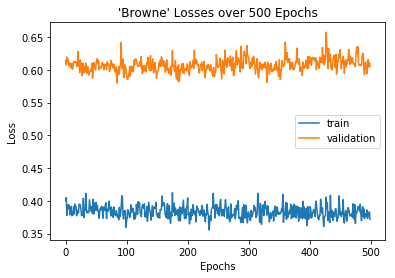

Average Training Score: 0.3835274041863848
Average Validation Score: 0.6074054099900854


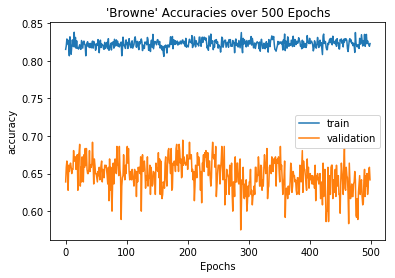

Average Training Score: 0.8228388934092759
Average Validation Score: 0.6479166666666667

validating on book: 'Allestree'
Epoch 0/499
----------



Phase:train
Confusion matrix:
 [[ 210  485]
 [  92 1753]]
loss 1140.9549487233162



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 12 200]]
loss 59.38793337345123
Epoch 1/499
----------



Phase:train
Confusion matrix:
 [[ 216  479]
 [  97 1748]]
loss 1119.573911756277



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 15 197]]
loss 63.799416214227676
Epoch 2/499
----------



Phase:train
Confusion matrix:
 [[ 225  470]
 [  91 1754]]
loss 1125.4273526072502



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 13 199]]
loss 63.07458683848381
Epoch 3/499
----------



Phase:train
Confusion matrix:
 [[ 246  449]
 [ 115 1730]]
loss 1093.0102797448635



Phase:val
Confusion matrix:
 [[ 62   4]
 [ 12 200]]
loss 51.961172342300415
Epoch 4/499
----------



Phase:train
Confusion matrix:
 [[ 254  441]
 [ 132 1713]]
loss 1093.6638348400593



Phase:val
Confusion matrix:
 [[ 62   4]
 [ 18 194]]
loss 60.887855887413025
Epoch 5/499
----------



Phase:train
Confusion matrix:
 [[ 277  418]
 [ 112 1733]]
loss 1079.4848884493113



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 16 196]]
loss 56.6972673535347
Epoch 6/499
----------



Phase:train
Confusion matrix:
 [[ 270  425]
 [ 131 1714]]
loss 1106.9891826808453



Phase:val
Confusion matrix:
 [[ 62   4]
 [ 12 200]]
loss 60.86792907118797
Epoch 7/499
----------



Phase:train
Confusion matrix:
 [[ 219  476]
 [ 105 1740]]
loss 1159.8561708629131



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 13 199]]
loss 76.7196341753006
Epoch 8/499
----------



Phase:train
Confusion matrix:
 [[ 233  462]
 [ 102 1743]]
loss 1120.590548336506



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 15 197]]
loss 63.02495297789574
Epoch 9/499
----------



Phase:train
Confusion matrix:
 [[ 282  413]
 [ 154 1691]]
loss 1119.7953133583069



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 16 196]]
loss 67.53045359253883
Epoch 10/499
----------



Phase:train
Confusion matrix:
 [[ 235  460]
 [ 120 1725]]
loss 1147.0858345776796



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 11 201]]
loss 56.50875002145767
Epoch 11/499
----------



Phase:train
Confusion matrix:
 [[ 241  454]
 [ 113 1732]]
loss 1123.9173617959023



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 16 196]]
loss 67.59275156259537
Epoch 12/499
----------



Phase:train
Confusion matrix:
 [[ 219  476]
 [ 118 1727]]
loss 1154.7152006328106



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 14 198]]
loss 72.16020372509956
Epoch 13/499
----------



Phase:train
Confusion matrix:
 [[ 217  478]
 [ 113 1732]]
loss 1150.243803858757



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 14 198]]
loss 67.03220102190971
Epoch 14/499
----------



Phase:train
Confusion matrix:
 [[ 274  421]
 [ 132 1713]]
loss 1078.2054761350155



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 12 200]]
loss 63.49695983529091
Epoch 15/499
----------



Phase:train
Confusion matrix:
 [[ 254  441]
 [ 107 1738]]
loss 1097.148552134633



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 15 197]]
loss 63.850428998470306
Epoch 16/499
----------



Phase:train
Confusion matrix:
 [[ 235  460]
 [ 109 1736]]
loss 1134.8329256176949



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 18 194]]
loss 74.96395000815392
Epoch 17/499
----------



Phase:train
Confusion matrix:
 [[ 221  474]
 [ 116 1729]]
loss 1152.4674565941095



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 19 193]]
loss 76.66291755437851
Epoch 18/499
----------



Phase:train
Confusion matrix:
 [[ 239  456]
 [ 108 1737]]
loss 1090.6348325908184



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 19 193]]
loss 64.4584150314331
Epoch 19/499
----------



Phase:train
Confusion matrix:
 [[ 221  474]
 [ 130 1715]]
loss 1114.8699081242085



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 20 192]]
loss 75.7133300602436
Epoch 20/499
----------



Phase:train
Confusion matrix:
 [[ 246  449]
 [ 107 1738]]
loss 1095.300537481904



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 15 197]]
loss 65.46596601605415
Epoch 21/499
----------



Phase:train
Confusion matrix:
 [[ 227  468]
 [ 124 1721]]
loss 1133.7891997992992



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 15 197]]
loss 68.89353576302528
Epoch 22/499
----------



Phase:train
Confusion matrix:
 [[ 270  425]
 [ 129 1716]]
loss 1119.5513037145138



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 20 192]]
loss 78.1644846200943
Epoch 23/499
----------



Phase:train
Confusion matrix:
 [[ 269  426]
 [ 115 1730]]
loss 1093.0135768055916



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 25 187]]
loss 78.10938596725464
Epoch 24/499
----------



Phase:train
Confusion matrix:
 [[ 244  451]
 [ 124 1721]]
loss 1124.3796998262405



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 12 200]]
loss 70.21628272533417
Epoch 25/499
----------



Phase:train
Confusion matrix:
 [[ 175  520]
 [ 102 1743]]
loss 1163.4882908463478



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 18 194]]
loss 77.91770535707474
Epoch 26/499
----------



Phase:train
Confusion matrix:
 [[ 212  483]
 [ 104 1741]]
loss 1136.6252287626266



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 26 186]]
loss 85.54505723714828
Epoch 27/499
----------



Phase:train
Confusion matrix:
 [[ 217  478]
 [ 109 1736]]
loss 1137.3664059937



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 15 197]]
loss 68.87578985095024
Epoch 28/499
----------



Phase:train
Confusion matrix:
 [[ 223  472]
 [  98 1747]]
loss 1114.428884923458



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 15 197]]
loss 63.09061861038208
Epoch 29/499
----------



Phase:train
Confusion matrix:
 [[ 243  452]
 [ 119 1726]]
loss 1165.4785338491201



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 13 199]]
loss 75.96626910567284
Epoch 30/499
----------



Phase:train
Confusion matrix:
 [[ 229  466]
 [ 113 1732]]
loss 1118.831147953868



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 20 192]]
loss 74.70334285497665
Epoch 31/499
----------



Phase:train
Confusion matrix:
 [[ 207  488]
 [ 129 1716]]
loss 1155.891281440854



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 16 196]]
loss 80.22586005926132
Epoch 32/499
----------



Phase:train
Confusion matrix:
 [[ 199  496]
 [ 109 1736]]
loss 1124.684558287263



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 12 200]]
loss 60.50864616036415
Epoch 33/499
----------



Phase:train
Confusion matrix:
 [[ 233  462]
 [ 117 1728]]
loss 1129.0974518060684



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 12 200]]
loss 65.8069979250431
Epoch 34/499
----------



Phase:train
Confusion matrix:
 [[ 234  461]
 [ 145 1700]]
loss 1151.0872425362468



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 15 197]]
loss 71.68539929389954
Epoch 35/499
----------



Phase:train
Confusion matrix:
 [[ 233  462]
 [ 109 1736]]
loss 1125.462208211422



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 11 201]]
loss 59.07172456383705
Epoch 36/499
----------



Phase:train
Confusion matrix:
 [[ 259  436]
 [ 140 1705]]
loss 1142.2670885920525



Phase:val
Confusion matrix:
 [[ 62   4]
 [ 12 200]]
loss 61.13024616241455
Epoch 37/499
----------



Phase:train
Confusion matrix:
 [[ 252  443]
 [ 123 1722]]
loss 1125.0632382184267



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 10 202]]
loss 63.66625902056694
Epoch 38/499
----------



Phase:train
Confusion matrix:
 [[ 255  440]
 [ 106 1739]]
loss 1107.9780824184418



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 15 197]]
loss 76.85439693927765
Epoch 39/499
----------



Phase:train
Confusion matrix:
 [[ 257  438]
 [ 119 1726]]
loss 1111.771639764309



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 10 202]]
loss 55.691621363162994
Epoch 40/499
----------



Phase:train
Confusion matrix:
 [[ 264  431]
 [ 129 1716]]
loss 1092.8410351127386



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 13 199]]
loss 62.61284291744232
Epoch 41/499
----------



Phase:train
Confusion matrix:
 [[ 265  430]
 [ 135 1710]]
loss 1115.813302591443



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 14 198]]
loss 69.60411030054092
Epoch 42/499
----------



Phase:train
Confusion matrix:
 [[ 255  440]
 [ 145 1700]]
loss 1127.0888240039349



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 10 202]]
loss 65.9986945092678
Epoch 43/499
----------



Phase:train
Confusion matrix:
 [[ 248  447]
 [ 143 1702]]
loss 1113.976585239172



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 14 198]]
loss 64.6735332608223
Epoch 44/499
----------



Phase:train
Confusion matrix:
 [[ 257  438]
 [ 139 1706]]
loss 1120.0552605241537



Phase:val
Confusion matrix:
 [[ 62   4]
 [ 10 202]]
loss 57.55125704407692
Epoch 45/499
----------



Phase:train
Confusion matrix:
 [[ 223  472]
 [ 112 1733]]
loss 1127.762421876192



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 11 201]]
loss 68.80480116605759
Epoch 46/499
----------



Phase:train
Confusion matrix:
 [[ 210  485]
 [ 104 1741]]
loss 1139.0170538127422



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 11 201]]
loss 74.86764389276505
Epoch 47/499
----------



Phase:train
Confusion matrix:
 [[ 232  463]
 [ 101 1744]]
loss 1101.922831311822



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 12 200]]
loss 66.8426778614521
Epoch 48/499
----------



Phase:train
Confusion matrix:
 [[ 238  457]
 [ 112 1733]]
loss 1083.0554562360048



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 16 196]]
loss 65.8032494187355
Epoch 49/499
----------



Phase:train
Confusion matrix:
 [[ 259  436]
 [ 139 1706]]
loss 1088.515735551715



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 14 198]]
loss 63.4324716925621
Epoch 50/499
----------



Phase:train
Confusion matrix:
 [[ 280  415]
 [ 149 1696]]
loss 1081.8832547143102



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 18 194]]
loss 66.43407210707664
Epoch 51/499
----------



Phase:train
Confusion matrix:
 [[ 221  474]
 [ 125 1720]]
loss 1156.9877720177174



Phase:val
Confusion matrix:
 [[ 63   3]
 [  9 203]]
loss 71.37310388684273
Epoch 52/499
----------



Phase:train
Confusion matrix:
 [[ 246  449]
 [ 109 1736]]
loss 1107.518654808402



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 11 201]]
loss 63.14263039827347
Epoch 53/499
----------



Phase:train
Confusion matrix:
 [[ 239  456]
 [ 113 1732]]
loss 1125.2948484867811



Phase:val
Confusion matrix:
 [[ 62   4]
 [ 10 202]]
loss 63.08209785819054
Epoch 54/499
----------



Phase:train
Confusion matrix:
 [[ 240  455]
 [ 110 1735]]
loss 1103.961614370346



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 18 194]]
loss 69.09524700045586
Epoch 55/499
----------



Phase:train
Confusion matrix:
 [[ 255  440]
 [ 120 1725]]
loss 1133.7788082361221



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 12 200]]
loss 70.04324316978455
Epoch 56/499
----------



Phase:train
Confusion matrix:
 [[ 244  451]
 [ 127 1718]]
loss 1117.9593525081873



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 11 201]]
loss 70.87364211678505
Epoch 57/499
----------



Phase:train
Confusion matrix:
 [[ 216  479]
 [ 109 1736]]
loss 1115.914480060339



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 12 200]]
loss 64.02617233991623
Epoch 58/499
----------



Phase:train
Confusion matrix:
 [[ 252  443]
 [ 121 1724]]
loss 1113.0265443623066



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 13 199]]
loss 65.81688168644905
Epoch 59/499
----------



Phase:train
Confusion matrix:
 [[ 247  448]
 [ 143 1702]]
loss 1124.7332069724798



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 12 200]]
loss 63.96109962463379
Epoch 60/499
----------



Phase:train
Confusion matrix:
 [[ 266  429]
 [ 125 1720]]
loss 1106.0247333943844



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 12 200]]
loss 73.52815899252892
Epoch 61/499
----------



Phase:train
Confusion matrix:
 [[ 234  461]
 [ 104 1741]]
loss 1101.2380491942167



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 12 200]]
loss 67.71771267056465
Epoch 62/499
----------



Phase:train
Confusion matrix:
 [[ 264  431]
 [ 153 1692]]
loss 1112.1511330604553



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 14 198]]
loss 67.89666375517845
Epoch 63/499
----------



Phase:train
Confusion matrix:
 [[ 258  437]
 [ 154 1691]]
loss 1128.0541919618845



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 18 194]]
loss 79.26783627271652
Epoch 64/499
----------



Phase:train
Confusion matrix:
 [[ 260  435]
 [ 136 1709]]
loss 1123.0764057040215



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 13 199]]
loss 70.94080212712288
Epoch 65/499
----------



Phase:train
Confusion matrix:
 [[ 257  438]
 [ 129 1716]]
loss 1124.073186546564



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 13 199]]
loss 64.7318240404129
Epoch 66/499
----------



Phase:train
Confusion matrix:
 [[ 252  443]
 [ 115 1730]]
loss 1124.7316396832466



Phase:val
Confusion matrix:
 [[ 64   2]
 [  8 204]]
loss 70.17905795574188
Epoch 67/499
----------



Phase:train
Confusion matrix:
 [[ 233  462]
 [ 119 1726]]
loss 1125.1669131666422



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 17 195]]
loss 77.12304496765137
Epoch 68/499
----------



Phase:train
Confusion matrix:
 [[ 211  484]
 [  85 1760]]
loss 1122.6981437504292



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 11 201]]
loss 72.37221592664719
Epoch 69/499
----------



Phase:train
Confusion matrix:
 [[ 248  447]
 [ 128 1717]]
loss 1101.447245746851



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 12 200]]
loss 68.19276529550552
Epoch 70/499
----------



Phase:train
Confusion matrix:
 [[ 260  435]
 [ 116 1729]]
loss 1109.5428816378117



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 16 196]]
loss 77.35881233215332
Epoch 71/499
----------



Phase:train
Confusion matrix:
 [[ 234  461]
 [ 120 1725]]
loss 1133.4289411455393



Phase:val
Confusion matrix:
 [[ 64   2]
 [  9 203]]
loss 71.13103294372559
Epoch 72/499
----------



Phase:train
Confusion matrix:
 [[ 244  451]
 [ 117 1728]]
loss 1110.8974500596523



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 11 201]]
loss 71.26396942138672
Epoch 73/499
----------



Phase:train
Confusion matrix:
 [[ 194  501]
 [ 113 1732]]
loss 1145.2234417796135



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 11 201]]
loss 63.69625383615494
Epoch 74/499
----------



Phase:train
Confusion matrix:
 [[ 235  460]
 [ 101 1744]]
loss 1104.1018618643284



Phase:val
Confusion matrix:
 [[ 64   2]
 [  9 203]]
loss 60.65241554379463
Epoch 75/499
----------



Phase:train
Confusion matrix:
 [[ 263  432]
 [ 112 1733]]
loss 1105.4673454910517



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 10 202]]
loss 64.9520474076271
Epoch 76/499
----------



Phase:train
Confusion matrix:
 [[ 258  437]
 [ 115 1730]]
loss 1073.7435967326164



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 11 201]]
loss 65.41638904809952
Epoch 77/499
----------



Phase:train
Confusion matrix:
 [[ 231  464]
 [ 128 1717]]
loss 1143.7846579626203



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 11 201]]
loss 74.07593381404877
Epoch 78/499
----------



Phase:train
Confusion matrix:
 [[ 245  450]
 [ 110 1735]]
loss 1093.115361213684



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 11 201]]
loss 69.56939220428467
Epoch 79/499
----------



Phase:train
Confusion matrix:
 [[ 245  450]
 [ 122 1723]]
loss 1117.606275781989



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 10 202]]
loss 65.95303198695183
Epoch 80/499
----------



Phase:train
Confusion matrix:
 [[ 260  435]
 [ 132 1713]]
loss 1067.3380170613527



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 16 196]]
loss 66.30767452716827
Epoch 81/499
----------



Phase:train
Confusion matrix:
 [[ 260  435]
 [ 121 1724]]
loss 1105.5424649864435



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 17 195]]
loss 71.17932650446892
Epoch 82/499
----------



Phase:train
Confusion matrix:
 [[ 254  441]
 [ 127 1718]]
loss 1106.8008808344603



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 14 198]]
loss 59.448858201503754
Epoch 83/499
----------



Phase:train
Confusion matrix:
 [[ 266  429]
 [ 147 1698]]
loss 1087.984217196703



Phase:val
Confusion matrix:
 [[ 66   0]
 [ 19 193]]
loss 74.36155885457993
Epoch 84/499
----------



Phase:train
Confusion matrix:
 [[ 255  440]
 [ 152 1693]]
loss 1153.5817357003689



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 11 201]]
loss 77.76556825637817
Epoch 85/499
----------



Phase:train
Confusion matrix:
 [[ 257  438]
 [ 115 1730]]
loss 1103.4499678909779



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 11 201]]
loss 75.3998826444149
Epoch 86/499
----------



Phase:train
Confusion matrix:
 [[ 258  437]
 [ 135 1710]]
loss 1102.5914123654366



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 10 202]]
loss 67.05173072218895
Epoch 87/499
----------



Phase:train
Confusion matrix:
 [[ 268  427]
 [ 121 1724]]
loss 1113.6607022732496



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 17 195]]
loss 64.2100518643856
Epoch 88/499
----------



Phase:train
Confusion matrix:
 [[ 275  420]
 [ 142 1703]]
loss 1128.6232174485922



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 20 192]]
loss 85.83428654074669
Epoch 89/499
----------



Phase:train
Confusion matrix:
 [[ 224  471]
 [ 118 1727]]
loss 1140.6594769954681



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 16 196]]
loss 77.47791212797165
Epoch 90/499
----------



Phase:train
Confusion matrix:
 [[ 258  437]
 [ 115 1730]]
loss 1108.4939106106758



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 13 199]]
loss 62.33633717894554
Epoch 91/499
----------



Phase:train
Confusion matrix:
 [[ 289  406]
 [ 141 1704]]
loss 1085.8150750547647



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 10 202]]
loss 70.98035621643066
Epoch 92/499
----------



Phase:train
Confusion matrix:
 [[ 261  434]
 [ 126 1719]]
loss 1111.6368666887283



Phase:val
Confusion matrix:
 [[ 63   3]
 [  9 203]]
loss 63.68147087097168
Epoch 93/499
----------



Phase:train
Confusion matrix:
 [[ 240  455]
 [ 119 1726]]
loss 1110.0642961263657



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 10 202]]
loss 59.031668692827225
Epoch 94/499
----------



Phase:train
Confusion matrix:
 [[ 251  444]
 [ 104 1741]]
loss 1091.906857907772



Phase:val
Confusion matrix:
 [[ 62   4]
 [ 11 201]]
loss 64.95791813731194
Epoch 95/499
----------



Phase:train
Confusion matrix:
 [[ 279  416]
 [ 140 1705]]
loss 1113.1579184383154



Phase:val
Confusion matrix:
 [[ 62   4]
 [  9 203]]
loss 67.90729710459709
Epoch 96/499
----------



Phase:train
Confusion matrix:
 [[ 254  441]
 [ 136 1709]]
loss 1117.1922155469656



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 14 198]]
loss 75.5006128847599
Epoch 97/499
----------



Phase:train
Confusion matrix:
 [[ 251  444]
 [ 125 1720]]
loss 1088.3254081457853



Phase:val
Confusion matrix:
 [[ 62   4]
 [ 12 200]]
loss 64.01968669891357
Epoch 98/499
----------



Phase:train
Confusion matrix:
 [[ 247  448]
 [ 130 1715]]
loss 1119.2149837315083



Phase:val
Confusion matrix:
 [[ 62   4]
 [ 12 200]]
loss 70.98697435855865
Epoch 99/499
----------



Phase:train
Confusion matrix:
 [[ 235  460]
 [ 122 1723]]
loss 1110.691506460309



Phase:val
Confusion matrix:
 [[ 62   4]
 [ 10 202]]
loss 72.21264642477036
Epoch 100/499
----------



Phase:train
Confusion matrix:
 [[ 239  456]
 [ 125 1720]]
loss 1120.414527758956



Phase:val
Confusion matrix:
 [[ 62   4]
 [ 10 202]]
loss 71.43614545464516
Epoch 101/499
----------



Phase:train
Confusion matrix:
 [[ 252  443]
 [ 121 1724]]
loss 1110.5875905901194



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 12 200]]
loss 69.32925549149513
Epoch 102/499
----------



Phase:train
Confusion matrix:
 [[ 268  427]
 [ 120 1725]]
loss 1105.88742159307



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 14 198]]
loss 65.31875801086426
Epoch 103/499
----------



Phase:train
Confusion matrix:
 [[ 269  426]
 [ 127 1718]]
loss 1100.436853826046



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 17 195]]
loss 77.21612855792046
Epoch 104/499
----------



Phase:train
Confusion matrix:
 [[ 265  430]
 [ 135 1710]]
loss 1124.6542453467846



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 12 200]]
loss 67.98164683580399
Epoch 105/499
----------



Phase:train
Confusion matrix:
 [[ 255  440]
 [ 144 1701]]
loss 1120.6545978188515



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 13 199]]
loss 73.86820802092552
Epoch 106/499
----------



Phase:train
Confusion matrix:
 [[ 259  436]
 [ 159 1686]]
loss 1138.9892740249634



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 12 200]]
loss 81.41158640384674
Epoch 107/499
----------



Phase:train
Confusion matrix:
 [[ 240  455]
 [ 127 1718]]
loss 1118.8196276128292



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 11 201]]
loss 80.98334980010986
Epoch 108/499
----------



Phase:train
Confusion matrix:
 [[ 254  441]
 [ 129 1716]]
loss 1120.3184932172298



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 14 198]]
loss 71.86037662625313
Epoch 109/499
----------



Phase:train
Confusion matrix:
 [[ 271  424]
 [ 134 1711]]
loss 1118.721556007862



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 13 199]]
loss 67.5629990696907
Epoch 110/499
----------



Phase:train
Confusion matrix:
 [[ 268  427]
 [ 134 1711]]
loss 1103.126193985343



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 16 196]]
loss 79.29231616854668
Epoch 111/499
----------



Phase:train
Confusion matrix:
 [[ 264  431]
 [ 120 1725]]
loss 1116.6368423849344



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 12 200]]
loss 79.207445114851
Epoch 112/499
----------



Phase:train
Confusion matrix:
 [[ 261  434]
 [ 137 1708]]
loss 1140.1798940449953



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 13 199]]
loss 74.94292029738426
Epoch 113/499
----------



Phase:train
Confusion matrix:
 [[ 218  477]
 [  99 1746]]
loss 1127.0417423546314



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 16 196]]
loss 75.82379359006882
Epoch 114/499
----------



Phase:train
Confusion matrix:
 [[ 247  448]
 [ 139 1706]]
loss 1135.730591148138



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 12 200]]
loss 68.43789300322533
Epoch 115/499
----------



Phase:train
Confusion matrix:
 [[ 254  441]
 [ 126 1719]]
loss 1087.3217927664518



Phase:val
Confusion matrix:
 [[ 62   4]
 [  9 203]]
loss 71.86066272854805
Epoch 116/499
----------



Phase:train
Confusion matrix:
 [[ 235  460]
 [ 122 1723]]
loss 1092.6475353837013



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 12 200]]
loss 75.58135133981705
Epoch 117/499
----------



Phase:train
Confusion matrix:
 [[ 290  405]
 [ 130 1715]]
loss 1097.6779513508081



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 17 195]]
loss 73.3407381772995
Epoch 118/499
----------



Phase:train
Confusion matrix:
 [[ 291  404]
 [ 128 1717]]
loss 1094.6953217238188



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 23 189]]
loss 78.8492259979248
Epoch 119/499
----------



Phase:train
Confusion matrix:
 [[ 266  429]
 [ 120 1725]]
loss 1096.5884910225868



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 12 200]]
loss 61.9939461350441
Epoch 120/499
----------



Phase:train
Confusion matrix:
 [[ 251  444]
 [ 138 1707]]
loss 1129.996989890933



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 11 201]]
loss 64.1982316672802
Epoch 121/499
----------



Phase:train
Confusion matrix:
 [[ 261  434]
 [ 160 1685]]
loss 1107.6066098362207



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 12 200]]
loss 66.53440162539482
Epoch 122/499
----------



Phase:train
Confusion matrix:
 [[ 258  437]
 [ 124 1721]]
loss 1098.7058385461569



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 12 200]]
loss 76.00882276892662
Epoch 123/499
----------



Phase:train
Confusion matrix:
 [[ 256  439]
 [ 130 1715]]
loss 1134.6490786075592



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 12 200]]
loss 65.87476727366447
Epoch 124/499
----------



Phase:train
Confusion matrix:
 [[ 256  439]
 [ 135 1710]]
loss 1125.3592862188816



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 11 201]]
loss 64.32778206467628
Epoch 125/499
----------



Phase:train
Confusion matrix:
 [[ 252  443]
 [ 146 1699]]
loss 1121.941444709897



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 17 195]]
loss 72.4990722835064
Epoch 126/499
----------



Phase:train
Confusion matrix:
 [[ 232  463]
 [ 113 1732]]
loss 1112.7696074843407



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 12 200]]
loss 68.71655258536339
Epoch 127/499
----------



Phase:train
Confusion matrix:
 [[ 238  457]
 [ 140 1705]]
loss 1142.9696297943592



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 15 197]]
loss 71.28236734867096
Epoch 128/499
----------



Phase:train
Confusion matrix:
 [[ 239  456]
 [ 130 1715]]
loss 1126.9861012101173



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 14 198]]
loss 71.3338066637516
Epoch 129/499
----------



Phase:train
Confusion matrix:
 [[ 236  459]
 [ 114 1731]]
loss 1137.3628789186478



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 16 196]]
loss 78.54116094112396
Epoch 130/499
----------



Phase:train
Confusion matrix:
 [[ 268  427]
 [ 122 1723]]
loss 1124.2882952392101



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 13 199]]
loss 70.34966206550598
Epoch 131/499
----------



Phase:train
Confusion matrix:
 [[ 279  416]
 [ 137 1708]]
loss 1112.7438847124577



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 18 194]]
loss 78.73781877756119
Epoch 132/499
----------



Phase:train
Confusion matrix:
 [[ 252  443]
 [ 136 1709]]
loss 1119.2369686067104



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 15 197]]
loss 74.21686539053917
Epoch 133/499
----------



Phase:train
Confusion matrix:
 [[ 254  441]
 [ 123 1722]]
loss 1101.755239918828



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 12 200]]
loss 61.377091228961945
Epoch 134/499
----------



Phase:train
Confusion matrix:
 [[ 262  433]
 [ 128 1717]]
loss 1082.3060066401958



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 12 200]]
loss 61.286509186029434
Epoch 135/499
----------



Phase:train
Confusion matrix:
 [[ 205  490]
 [  85 1760]]
loss 1138.0733328908682



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 11 201]]
loss 68.62582814693451
Epoch 136/499
----------



Phase:train
Confusion matrix:
 [[ 241  454]
 [ 124 1721]]
loss 1102.966791048646



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 11 201]]
loss 67.56415736675262
Epoch 137/499
----------



Phase:train
Confusion matrix:
 [[ 270  425]
 [ 118 1727]]
loss 1077.1320226192474



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 15 197]]
loss 67.5679050385952
Epoch 138/499
----------



Phase:train
Confusion matrix:
 [[ 273  422]
 [ 127 1718]]
loss 1101.2608376592398



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 14 198]]
loss 67.3919825553894
Epoch 139/499
----------



Phase:train
Confusion matrix:
 [[ 279  416]
 [ 121 1724]]
loss 1102.631563141942



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 16 196]]
loss 74.82841116189957
Epoch 140/499
----------



Phase:train
Confusion matrix:
 [[ 240  455]
 [  99 1746]]
loss 1081.8081468045712



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 20 192]]
loss 75.46376487612724
Epoch 141/499
----------



Phase:train
Confusion matrix:
 [[ 279  416]
 [ 126 1719]]
loss 1093.4587821364403



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 13 199]]
loss 67.37501928210258
Epoch 142/499
----------



Phase:train
Confusion matrix:
 [[ 231  464]
 [ 124 1721]]
loss 1121.6786653250456



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 13 199]]
loss 72.00782415270805
Epoch 143/499
----------



Phase:train
Confusion matrix:
 [[ 259  436]
 [ 123 1722]]
loss 1090.9799296557903



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 13 199]]
loss 60.68687379360199
Epoch 144/499
----------



Phase:train
Confusion matrix:
 [[ 272  423]
 [ 125 1720]]
loss 1089.2669050991535



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 16 196]]
loss 73.75002974271774
Epoch 145/499
----------



Phase:train
Confusion matrix:
 [[ 285  410]
 [ 140 1705]]
loss 1099.5456174463034



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 12 200]]
loss 69.27389016747475
Epoch 146/499
----------



Phase:train
Confusion matrix:
 [[ 268  427]
 [ 138 1707]]
loss 1097.479444757104



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 20 192]]
loss 71.11316165328026
Epoch 147/499
----------



Phase:train
Confusion matrix:
 [[ 298  397]
 [ 167 1678]]
loss 1097.817923694849



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 17 195]]
loss 71.63730138540268
Epoch 148/499
----------



Phase:train
Confusion matrix:
 [[ 264  431]
 [ 135 1710]]
loss 1115.3808765262365



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 13 199]]
loss 65.74904453754425
Epoch 149/499
----------



Phase:train
Confusion matrix:
 [[ 251  444]
 [ 127 1718]]
loss 1094.4295939803123



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 11 201]]
loss 67.12743738293648
Epoch 150/499
----------



Phase:train
Confusion matrix:
 [[ 265  430]
 [ 141 1704]]
loss 1102.4199787080288



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 11 201]]
loss 72.23939976096153
Epoch 151/499
----------



Phase:train
Confusion matrix:
 [[ 295  400]
 [ 126 1719]]
loss 1103.6241106688976



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 12 200]]
loss 71.02966824173927
Epoch 152/499
----------



Phase:train
Confusion matrix:
 [[ 274  421]
 [ 132 1713]]
loss 1108.9302453398705



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 13 199]]
loss 68.87854817509651
Epoch 153/499
----------



Phase:train
Confusion matrix:
 [[ 249  446]
 [ 133 1712]]
loss 1105.6747262477875



Phase:val
Confusion matrix:
 [[ 62   4]
 [ 12 200]]
loss 61.76968243718147
Epoch 154/499
----------



Phase:train
Confusion matrix:
 [[ 250  445]
 [ 132 1713]]
loss 1127.3241079449654



Phase:val
Confusion matrix:
 [[ 66   0]
 [ 18 194]]
loss 93.13882821798325
Epoch 155/499
----------



Phase:train
Confusion matrix:
 [[ 207  488]
 [  83 1762]]
loss 1124.33430570364



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 12 200]]
loss 59.107331931591034
Epoch 156/499
----------



Phase:train
Confusion matrix:
 [[ 271  424]
 [ 133 1712]]
loss 1101.843083024025



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 15 197]]
loss 71.78790080547333
Epoch 157/499
----------



Phase:train
Confusion matrix:
 [[ 290  405]
 [ 148 1697]]
loss 1096.9609084576368



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 10 202]]
loss 69.46574291586876
Epoch 158/499
----------



Phase:train
Confusion matrix:
 [[ 269  426]
 [ 103 1742]]
loss 1086.327446296811



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 13 199]]
loss 71.03778448700905
Epoch 159/499
----------



Phase:train
Confusion matrix:
 [[ 265  430]
 [ 119 1726]]
loss 1116.5847370624542



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 15 197]]
loss 65.9660350382328
Epoch 160/499
----------



Phase:train
Confusion matrix:
 [[ 278  417]
 [ 169 1676]]
loss 1131.7079127430916



Phase:val
Confusion matrix:
 [[ 63   3]
 [  9 203]]
loss 66.50332587957382
Epoch 161/499
----------



Phase:train
Confusion matrix:
 [[ 256  439]
 [ 126 1719]]
loss 1104.486089155078



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 11 201]]
loss 68.6934369802475
Epoch 162/499
----------



Phase:train
Confusion matrix:
 [[ 250  445]
 [ 124 1721]]
loss 1117.0296990424395



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 14 198]]
loss 67.53707453608513
Epoch 163/499
----------



Phase:train
Confusion matrix:
 [[ 284  411]
 [ 144 1701]]
loss 1090.0353533178568



Phase:val
Confusion matrix:
 [[ 66   0]
 [ 14 198]]
loss 71.542126506567
Epoch 164/499
----------



Phase:train
Confusion matrix:
 [[ 250  445]
 [ 126 1719]]
loss 1106.5686218738556



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 13 199]]
loss 72.09356167912483
Epoch 165/499
----------



Phase:train
Confusion matrix:
 [[ 279  416]
 [ 126 1719]]
loss 1096.448541328311



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 15 197]]
loss 73.52988642454147
Epoch 166/499
----------



Phase:train
Confusion matrix:
 [[ 270  425]
 [ 132 1713]]
loss 1091.7811303138733



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 11 201]]
loss 61.41803225874901
Epoch 167/499
----------



Phase:train
Confusion matrix:
 [[ 271  424]
 [ 135 1710]]
loss 1130.4101849198341



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 10 202]]
loss 63.13057962059975
Epoch 168/499
----------



Phase:train
Confusion matrix:
 [[ 260  435]
 [ 121 1724]]
loss 1100.3828644827008



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 16 196]]
loss 75.54435339570045
Epoch 169/499
----------



Phase:train
Confusion matrix:
 [[ 228  467]
 [ 112 1733]]
loss 1135.3484059423208



Phase:val
Confusion matrix:
 [[ 62   4]
 [ 11 201]]
loss 70.41127145290375
Epoch 170/499
----------



Phase:train
Confusion matrix:
 [[ 241  454]
 [ 126 1719]]
loss 1100.9779157936573



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 22 190]]
loss 81.9513891339302
Epoch 171/499
----------



Phase:train
Confusion matrix:
 [[ 241  454]
 [ 102 1743]]
loss 1135.2862683534622



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 17 195]]
loss 88.55661833286285
Epoch 172/499
----------



Phase:train
Confusion matrix:
 [[ 256  439]
 [ 139 1706]]
loss 1130.7895161360502



Phase:val
Confusion matrix:
 [[ 62   4]
 [ 12 200]]
loss 60.06025078892708
Epoch 173/499
----------



Phase:train
Confusion matrix:
 [[ 249  446]
 [ 137 1708]]
loss 1110.4068703949451



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 17 195]]
loss 73.2573065161705
Epoch 174/499
----------



Phase:train
Confusion matrix:
 [[ 253  442]
 [ 139 1706]]
loss 1105.4561528414488



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 13 199]]
loss 62.702263832092285
Epoch 175/499
----------



Phase:train
Confusion matrix:
 [[ 312  383]
 [ 173 1672]]
loss 1068.7322349995375



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 12 200]]
loss 55.364203691482544
Epoch 176/499
----------



Phase:train
Confusion matrix:
 [[ 265  430]
 [ 134 1711]]
loss 1114.1473474055529



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 19 193]]
loss 73.63059690594673
Epoch 177/499
----------



Phase:train
Confusion matrix:
 [[ 278  417]
 [ 155 1690]]
loss 1127.6352629363537



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 14 198]]
loss 71.75988933444023
Epoch 178/499
----------



Phase:train
Confusion matrix:
 [[ 247  448]
 [ 109 1736]]
loss 1129.8160790503025



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 17 195]]
loss 75.30409142374992
Epoch 179/499
----------



Phase:train
Confusion matrix:
 [[ 270  425]
 [ 134 1711]]
loss 1097.3685197234154



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 17 195]]
loss 78.55539864301682
Epoch 180/499
----------



Phase:train
Confusion matrix:
 [[ 256  439]
 [ 119 1726]]
loss 1100.944846585393



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 16 196]]
loss 71.91017231345177
Epoch 181/499
----------



Phase:train
Confusion matrix:
 [[ 273  422]
 [ 110 1735]]
loss 1093.3006647974253



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 14 198]]
loss 76.55958169698715
Epoch 182/499
----------



Phase:train
Confusion matrix:
 [[ 229  466]
 [ 120 1725]]
loss 1104.107623592019



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 13 199]]
loss 73.38824746012688
Epoch 183/499
----------



Phase:train
Confusion matrix:
 [[ 292  403]
 [ 163 1682]]
loss 1114.7022429704666



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 20 192]]
loss 85.91110807657242
Epoch 184/499
----------



Phase:train
Confusion matrix:
 [[ 265  430]
 [  97 1748]]
loss 1084.7842889726162



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 15 197]]
loss 64.4478862285614
Epoch 185/499
----------



Phase:train
Confusion matrix:
 [[ 268  427]
 [ 134 1711]]
loss 1094.6643147021532



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 20 192]]
loss 74.78148862719536
Epoch 186/499
----------



Phase:train
Confusion matrix:
 [[ 266  429]
 [ 134 1711]]
loss 1115.6758588850498



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 20 192]]
loss 75.09743404388428
Epoch 187/499
----------



Phase:train
Confusion matrix:
 [[ 250  445]
 [ 127 1718]]
loss 1129.4449810236692



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 17 195]]
loss 73.81291702389717
Epoch 188/499
----------



Phase:train
Confusion matrix:
 [[ 247  448]
 [ 115 1730]]
loss 1089.6527142226696



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 14 198]]
loss 77.3300806581974
Epoch 189/499
----------



Phase:train
Confusion matrix:
 [[ 243  452]
 [ 112 1733]]
loss 1102.2537773400545



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 22 190]]
loss 83.71679383516312
Epoch 190/499
----------



Phase:train
Confusion matrix:
 [[ 251  444]
 [ 116 1729]]
loss 1110.8154019862413



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 24 188]]
loss 88.2968265414238
Epoch 191/499
----------



Phase:train
Confusion matrix:
 [[ 227  468]
 [ 107 1738]]
loss 1119.5341107174754



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 17 195]]
loss 71.65909731388092
Epoch 192/499
----------



Phase:train
Confusion matrix:
 [[ 242  453]
 [ 139 1706]]
loss 1113.8327790349722



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 14 198]]
loss 77.5187332034111
Epoch 193/499
----------



Phase:train
Confusion matrix:
 [[ 267  428]
 [ 124 1721]]
loss 1112.0124577879906



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 18 194]]
loss 82.97171112895012
Epoch 194/499
----------



Phase:train
Confusion matrix:
 [[ 249  446]
 [ 118 1727]]
loss 1109.1084843873978



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 20 192]]
loss 78.50883013010025
Epoch 195/499
----------



Phase:train
Confusion matrix:
 [[ 244  451]
 [ 118 1727]]
loss 1148.14969804883



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 15 197]]
loss 79.08046409487724
Epoch 196/499
----------



Phase:train
Confusion matrix:
 [[ 238  457]
 [ 105 1740]]
loss 1127.0305784642696



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 21 191]]
loss 84.03184986114502
Epoch 197/499
----------



Phase:train
Confusion matrix:
 [[ 254  441]
 [ 128 1717]]
loss 1096.296672925353



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 18 194]]
loss 67.86581575870514
Epoch 198/499
----------



Phase:train
Confusion matrix:
 [[ 287  408]
 [ 125 1720]]
loss 1093.0491605103016



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 15 197]]
loss 73.41945758461952
Epoch 199/499
----------



Phase:train
Confusion matrix:
 [[ 264  431]
 [ 116 1729]]
loss 1088.4822301268578



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 75.84276542067528
Epoch 200/499
----------



Phase:train
Confusion matrix:
 [[ 295  400]
 [ 156 1689]]
loss 1097.7994480729103



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 19 193]]
loss 77.94000717997551
Epoch 201/499
----------



Phase:train
Confusion matrix:
 [[ 246  449]
 [ 114 1731]]
loss 1078.8563376665115



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 20 192]]
loss 77.84078055620193
Epoch 202/499
----------



Phase:train
Confusion matrix:
 [[ 299  396]
 [ 154 1691]]
loss 1103.0551293492317



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 21 191]]
loss 84.65799382328987
Epoch 203/499
----------



Phase:train
Confusion matrix:
 [[ 243  452]
 [ 112 1733]]
loss 1122.6952088922262



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 21 191]]
loss 73.92359253764153
Epoch 204/499
----------



Phase:train
Confusion matrix:
 [[ 255  440]
 [ 115 1730]]
loss 1101.9785473942757



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 19 193]]
loss 78.11703938245773
Epoch 205/499
----------



Phase:train
Confusion matrix:
 [[ 280  415]
 [ 132 1713]]
loss 1103.4357127547264



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 81.15316987037659
Epoch 206/499
----------



Phase:train
Confusion matrix:
 [[ 273  422]
 [ 124 1721]]
loss 1082.4921514838934



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 15 197]]
loss 71.61103528738022
Epoch 207/499
----------



Phase:train
Confusion matrix:
 [[ 255  440]
 [ 140 1705]]
loss 1116.7010715454817



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 16 196]]
loss 78.16561818122864
Epoch 208/499
----------



Phase:train
Confusion matrix:
 [[ 256  439]
 [ 109 1736]]
loss 1089.2122071832418



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 17 195]]
loss 73.77730816602707
Epoch 209/499
----------



Phase:train
Confusion matrix:
 [[ 283  412]
 [ 118 1727]]
loss 1106.3843390494585



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 16 196]]
loss 64.32875058054924
Epoch 210/499
----------



Phase:train
Confusion matrix:
 [[ 265  430]
 [ 134 1711]]
loss 1110.0150890052319



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 19 193]]
loss 75.12009528279305
Epoch 211/499
----------



Phase:train
Confusion matrix:
 [[ 265  430]
 [ 128 1717]]
loss 1101.5583338290453



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 11 201]]
loss 71.00503012537956
Epoch 212/499
----------



Phase:train
Confusion matrix:
 [[ 243  452]
 [ 114 1731]]
loss 1141.3402640223503



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 12 200]]
loss 66.07935899496078
Epoch 213/499
----------



Phase:train
Confusion matrix:
 [[ 270  425]
 [ 124 1721]]
loss 1090.8762640953064



Phase:val
Confusion matrix:
 [[ 66   0]
 [ 17 195]]
loss 74.74719679355621
Epoch 214/499
----------



Phase:train
Confusion matrix:
 [[ 268  427]
 [ 124 1721]]
loss 1134.053345233202



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 24 188]]
loss 89.01783329248428
Epoch 215/499
----------



Phase:train
Confusion matrix:
 [[ 277  418]
 [ 113 1732]]
loss 1093.5434738099575



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 18 194]]
loss 68.42074999213219
Epoch 216/499
----------



Phase:train
Confusion matrix:
 [[ 300  395]
 [ 166 1679]]
loss 1087.1892513632774



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 18 194]]
loss 71.83694037795067
Epoch 217/499
----------



Phase:train
Confusion matrix:
 [[ 256  439]
 [ 136 1709]]
loss 1119.8211366087198



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 19 193]]
loss 79.39110180735588
Epoch 218/499
----------



Phase:train
Confusion matrix:
 [[ 234  461]
 [ 102 1743]]
loss 1083.5904955863953



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 16 196]]
loss 66.37575367093086
Epoch 219/499
----------



Phase:train
Confusion matrix:
 [[ 201  494]
 [ 129 1716]]
loss 1144.8825329840183



Phase:val
Confusion matrix:
 [[ 61   5]
 [  0 212]]
loss 94.62203401327133
Epoch 220/499
----------



Phase:train
Confusion matrix:
 [[ 196  499]
 [  90 1755]]
loss 1171.367025822401



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 15 197]]
loss 87.03197312355042
Epoch 221/499
----------



Phase:train
Confusion matrix:
 [[ 252  443]
 [ 110 1735]]
loss 1129.613918080926



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 16 196]]
loss 77.24701052904129
Epoch 222/499
----------



Phase:train
Confusion matrix:
 [[ 267  428]
 [ 116 1729]]
loss 1094.2732139080763



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 69.32777732610703
Epoch 223/499
----------



Phase:train
Confusion matrix:
 [[ 283  412]
 [ 129 1716]]
loss 1093.9478983283043



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 20 192]]
loss 84.95357418060303
Epoch 224/499
----------



Phase:train
Confusion matrix:
 [[ 290  405]
 [ 156 1689]]
loss 1112.2627748847008



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 16 196]]
loss 72.74797329306602
Epoch 225/499
----------



Phase:train
Confusion matrix:
 [[ 265  430]
 [ 118 1727]]
loss 1093.034430116415



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 16 196]]
loss 68.03801721334457
Epoch 226/499
----------



Phase:train
Confusion matrix:
 [[ 284  411]
 [ 168 1677]]
loss 1094.2840723842382



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 21 191]]
loss 76.44931164383888
Epoch 227/499
----------



Phase:train
Confusion matrix:
 [[ 264  431]
 [ 134 1711]]
loss 1097.0610654205084



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 16 196]]
loss 72.73951381444931
Epoch 228/499
----------



Phase:train
Confusion matrix:
 [[ 275  420]
 [ 134 1711]]
loss 1100.5424147695303



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 22 190]]
loss 84.56931394338608
Epoch 229/499
----------



Phase:train
Confusion matrix:
 [[ 270  425]
 [ 137 1708]]
loss 1098.9669269025326



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 21 191]]
loss 81.57764500379562
Epoch 230/499
----------



Phase:train
Confusion matrix:
 [[ 256  439]
 [ 133 1712]]
loss 1118.9098652899265



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 17 195]]
loss 77.18897581100464
Epoch 231/499
----------



Phase:train
Confusion matrix:
 [[ 237  458]
 [ 127 1718]]
loss 1136.6700067520142



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 71.35820904374123
Epoch 232/499
----------



Phase:train
Confusion matrix:
 [[ 275  420]
 [ 120 1725]]
loss 1093.1030633449554



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 16 196]]
loss 75.3228340446949
Epoch 233/499
----------



Phase:train
Confusion matrix:
 [[ 289  406]
 [ 139 1706]]
loss 1116.0755753815174



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 10 202]]
loss 69.74531361460686
Epoch 234/499
----------



Phase:train
Confusion matrix:
 [[ 254  441]
 [ 136 1709]]
loss 1118.3922242969275



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 15 197]]
loss 70.94669985771179
Epoch 235/499
----------



Phase:train
Confusion matrix:
 [[ 238  457]
 [ 130 1715]]
loss 1085.075690165162



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 14 198]]
loss 65.30135989189148
Epoch 236/499
----------



Phase:train
Confusion matrix:
 [[ 238  457]
 [ 123 1722]]
loss 1108.8899327218533



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 18 194]]
loss 76.73865675926208
Epoch 237/499
----------



Phase:train
Confusion matrix:
 [[ 235  460]
 [ 101 1744]]
loss 1090.4041681587696



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 23 189]]
loss 81.64318853616714
Epoch 238/499
----------



Phase:train
Confusion matrix:
 [[ 299  396]
 [ 168 1677]]
loss 1094.027109324932



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 23 189]]
loss 77.26877343654633
Epoch 239/499
----------



Phase:train
Confusion matrix:
 [[ 233  462]
 [ 152 1693]]
loss 1136.3127255737782



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 16 196]]
loss 78.78652873635292
Epoch 240/499
----------



Phase:train
Confusion matrix:
 [[ 246  449]
 [ 135 1710]]
loss 1119.1970276534557



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 17 195]]
loss 71.6518928706646
Epoch 241/499
----------



Phase:train
Confusion matrix:
 [[ 278  417]
 [ 149 1696]]
loss 1105.8531056940556



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 15 197]]
loss 64.32480454444885
Epoch 242/499
----------



Phase:train
Confusion matrix:
 [[ 229  466]
 [ 114 1731]]
loss 1117.6851729750633



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 13 199]]
loss 76.41338422894478
Epoch 243/499
----------



Phase:train
Confusion matrix:
 [[ 236  459]
 [ 122 1723]]
loss 1093.629127010703



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 12 200]]
loss 77.64181205630302
Epoch 244/499
----------



Phase:train
Confusion matrix:
 [[ 217  478]
 [ 110 1735]]
loss 1136.3401700109243



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 18 194]]
loss 73.29972273111343
Epoch 245/499
----------



Phase:train
Confusion matrix:
 [[ 251  444]
 [ 130 1715]]
loss 1113.3900201171637



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 20 192]]
loss 76.95556229352951
Epoch 246/499
----------



Phase:train
Confusion matrix:
 [[ 237  458]
 [ 120 1725]]
loss 1098.8076349645853



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 15 197]]
loss 71.40777057409286
Epoch 247/499
----------



Phase:train
Confusion matrix:
 [[ 230  465]
 [ 120 1725]]
loss 1099.8345718681812



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 21 191]]
loss 88.04080480337143
Epoch 248/499
----------



Phase:train
Confusion matrix:
 [[ 233  462]
 [ 121 1724]]
loss 1132.5491205453873



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 12 200]]
loss 62.90753871202469
Epoch 249/499
----------



Phase:train
Confusion matrix:
 [[ 243  452]
 [ 138 1707]]
loss 1122.729759156704



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 17 195]]
loss 78.47623962163925
Epoch 250/499
----------



Phase:train
Confusion matrix:
 [[ 255  440]
 [ 133 1712]]
loss 1098.048914000392



Phase:val
Confusion matrix:
 [[ 66   0]
 [ 22 190]]
loss 78.48309591412544
Epoch 251/499
----------



Phase:train
Confusion matrix:
 [[ 244  451]
 [ 105 1740]]
loss 1076.1823804974556



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 16 196]]
loss 67.72361260652542
Epoch 252/499
----------



Phase:train
Confusion matrix:
 [[ 253  442]
 [ 137 1708]]
loss 1080.587603777647



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 15 197]]
loss 64.18257868289948
Epoch 253/499
----------



Phase:train
Confusion matrix:
 [[ 270  425]
 [ 140 1705]]
loss 1090.448725014925



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 18 194]]
loss 72.18333917856216
Epoch 254/499
----------



Phase:train
Confusion matrix:
 [[ 264  431]
 [ 121 1724]]
loss 1109.6209096312523



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 21 191]]
loss 80.62624269723892
Epoch 255/499
----------



Phase:train
Confusion matrix:
 [[ 259  436]
 [ 115 1730]]
loss 1102.578159213066



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 20 192]]
loss 81.21243065595627
Epoch 256/499
----------



Phase:train
Confusion matrix:
 [[ 249  446]
 [ 132 1713]]
loss 1139.0721997618675



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 16 196]]
loss 75.6538074016571
Epoch 257/499
----------



Phase:train
Confusion matrix:
 [[ 268  427]
 [ 128 1717]]
loss 1093.8771408200264



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 19 193]]
loss 71.0925577878952
Epoch 258/499
----------



Phase:train
Confusion matrix:
 [[ 254  441]
 [ 106 1739]]
loss 1111.2809150367975



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 21 191]]
loss 82.98158091306686
Epoch 259/499
----------



Phase:train
Confusion matrix:
 [[ 215  480]
 [ 106 1739]]
loss 1170.946194127202



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 19 193]]
loss 79.15418839454651
Epoch 260/499
----------



Phase:train
Confusion matrix:
 [[ 258  437]
 [ 127 1718]]
loss 1136.2249238342047



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 14 198]]
loss 62.95175439119339
Epoch 261/499
----------



Phase:train
Confusion matrix:
 [[ 234  461]
 [ 106 1739]]
loss 1118.588362827897



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 13 199]]
loss 76.25362795591354
Epoch 262/499
----------



Phase:train
Confusion matrix:
 [[ 240  455]
 [ 124 1721]]
loss 1102.0166497826576



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 13 199]]
loss 75.5081974864006
Epoch 263/499
----------



Phase:train
Confusion matrix:
 [[ 228  467]
 [ 107 1738]]
loss 1103.8404631465673



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 13 199]]
loss 73.63701382279396
Epoch 264/499
----------



Phase:train
Confusion matrix:
 [[ 255  440]
 [ 134 1711]]
loss 1116.297798410058



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 14 198]]
loss 62.74510496854782
Epoch 265/499
----------



Phase:train
Confusion matrix:
 [[ 241  454]
 [ 142 1703]]
loss 1120.9768362343311



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 18 194]]
loss 81.12180033326149
Epoch 266/499
----------



Phase:train
Confusion matrix:
 [[ 263  432]
 [ 121 1724]]
loss 1123.3531722724438



Phase:val
Confusion matrix:
 [[ 63   3]
 [  9 203]]
loss 71.27182579040527
Epoch 267/499
----------



Phase:train
Confusion matrix:
 [[ 275  420]
 [ 115 1730]]
loss 1099.5624377131462



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 21 191]]
loss 81.46824252605438
Epoch 268/499
----------



Phase:train
Confusion matrix:
 [[ 287  408]
 [ 148 1697]]
loss 1107.5235275030136



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 15 197]]
loss 70.77017578482628
Epoch 269/499
----------



Phase:train
Confusion matrix:
 [[ 225  470]
 [ 108 1737]]
loss 1126.1035233139992



Phase:val
Confusion matrix:
 [[ 62   4]
 [ 13 199]]
loss 71.89031127095222
Epoch 270/499
----------



Phase:train
Confusion matrix:
 [[ 272  423]
 [ 139 1706]]
loss 1076.7782546281815



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 15 197]]
loss 64.21275907754898
Epoch 271/499
----------



Phase:train
Confusion matrix:
 [[ 242  453]
 [ 140 1705]]
loss 1111.9163622260094



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 13 199]]
loss 71.62504509091377
Epoch 272/499
----------



Phase:train
Confusion matrix:
 [[ 217  478]
 [ 100 1745]]
loss 1108.135025471449



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 18 194]]
loss 71.30294871330261
Epoch 273/499
----------



Phase:train
Confusion matrix:
 [[ 296  399]
 [ 145 1700]]
loss 1151.0827391892672



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 15 197]]
loss 77.27522593736649
Epoch 274/499
----------



Phase:train
Confusion matrix:
 [[ 224  471]
 [ 138 1707]]
loss 1135.2705217003822



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 14 198]]
loss 72.8292683660984
Epoch 275/499
----------



Phase:train
Confusion matrix:
 [[ 245  450]
 [ 123 1722]]
loss 1131.6308638453484



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 10 202]]
loss 63.413282722234726
Epoch 276/499
----------



Phase:train
Confusion matrix:
 [[ 279  416]
 [ 136 1709]]
loss 1086.912612453103



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 12 200]]
loss 64.43311062455177
Epoch 277/499
----------



Phase:train
Confusion matrix:
 [[ 261  434]
 [ 129 1716]]
loss 1111.67547018826



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 14 198]]
loss 75.8853474855423
Epoch 278/499
----------



Phase:train
Confusion matrix:
 [[ 239  456]
 [ 102 1743]]
loss 1123.4659946858883



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 15 197]]
loss 81.04685634374619
Epoch 279/499
----------



Phase:train
Confusion matrix:
 [[ 243  452]
 [ 110 1735]]
loss 1112.1983278244734



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 22 190]]
loss 82.0523282289505
Epoch 280/499
----------



Phase:train
Confusion matrix:
 [[ 234  461]
 [ 100 1745]]
loss 1115.803565442562



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 75.28520002961159
Epoch 281/499
----------



Phase:train
Confusion matrix:
 [[ 268  427]
 [ 134 1711]]
loss 1095.1876266002655



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 15 197]]
loss 69.99244564771652
Epoch 282/499
----------



Phase:train
Confusion matrix:
 [[ 240  455]
 [ 127 1718]]
loss 1108.7399654835463



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 17 195]]
loss 81.76055419445038
Epoch 283/499
----------



Phase:train
Confusion matrix:
 [[ 237  458]
 [ 120 1725]]
loss 1092.7167286872864



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 20 192]]
loss 73.51718500256538
Epoch 284/499
----------



Phase:train
Confusion matrix:
 [[ 236  459]
 [ 112 1733]]
loss 1137.8939332813025



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 20 192]]
loss 86.40047192573547
Epoch 285/499
----------



Phase:train
Confusion matrix:
 [[ 249  446]
 [ 114 1731]]
loss 1133.8248580694199



Phase:val
Confusion matrix:
 [[ 62   4]
 [ 11 201]]
loss 70.19114199280739
Epoch 286/499
----------



Phase:train
Confusion matrix:
 [[ 231  464]
 [  96 1749]]
loss 1113.6157002449036



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 15 197]]
loss 69.89542528986931
Epoch 287/499
----------



Phase:train
Confusion matrix:
 [[ 275  420]
 [ 132 1713]]
loss 1102.1278004050255



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 12 200]]
loss 66.92727515101433
Epoch 288/499
----------



Phase:train
Confusion matrix:
 [[ 237  458]
 [ 102 1743]]
loss 1103.0170677751303



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 19 193]]
loss 77.55510729551315
Epoch 289/499
----------



Phase:train
Confusion matrix:
 [[ 246  449]
 [ 116 1729]]
loss 1109.5990288555622



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 18 194]]
loss 77.70216828584671
Epoch 290/499
----------



Phase:train
Confusion matrix:
 [[ 284  411]
 [ 131 1714]]
loss 1112.0679272264242



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 21 191]]
loss 74.26708281040192
Epoch 291/499
----------



Phase:train
Confusion matrix:
 [[ 217  478]
 [ 111 1734]]
loss 1130.2292550206184



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 17 195]]
loss 70.37662255764008
Epoch 292/499
----------



Phase:train
Confusion matrix:
 [[ 269  426]
 [ 132 1713]]
loss 1108.833120495081



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 24 188]]
loss 84.37634283304214
Epoch 293/499
----------



Phase:train
Confusion matrix:
 [[ 248  447]
 [ 131 1714]]
loss 1131.6523475050926



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 23 189]]
loss 89.36453062295914
Epoch 294/499
----------



Phase:train
Confusion matrix:
 [[ 247  448]
 [ 133 1712]]
loss 1125.6301537156105



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 17 195]]
loss 78.23714882135391
Epoch 295/499
----------



Phase:train
Confusion matrix:
 [[ 260  435]
 [ 125 1720]]
loss 1106.4183463156223



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 12 200]]
loss 70.10624757409096
Epoch 296/499
----------



Phase:train
Confusion matrix:
 [[ 246  449]
 [ 132 1713]]
loss 1143.6430196762085



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 15 197]]
loss 76.91736766695976
Epoch 297/499
----------



Phase:train
Confusion matrix:
 [[ 257  438]
 [ 112 1733]]
loss 1104.7330322414637



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 17 195]]
loss 81.92893594503403
Epoch 298/499
----------



Phase:train
Confusion matrix:
 [[ 236  459]
 [ 123 1722]]
loss 1116.7690547704697



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 18 194]]
loss 77.88226956129074
Epoch 299/499
----------



Phase:train
Confusion matrix:
 [[ 254  441]
 [ 129 1716]]
loss 1111.6958335787058



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 79.50782537460327
Epoch 300/499
----------



Phase:train
Confusion matrix:
 [[ 270  425]
 [ 130 1715]]
loss 1086.6022551208735



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 17 195]]
loss 71.98357385396957
Epoch 301/499
----------



Phase:train
Confusion matrix:
 [[ 265  430]
 [ 144 1701]]
loss 1094.297644495964



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 23 189]]
loss 86.04977118968964
Epoch 302/499
----------



Phase:train
Confusion matrix:
 [[ 258  437]
 [ 134 1711]]
loss 1113.09622476995



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 24 188]]
loss 95.08693188428879
Epoch 303/499
----------



Phase:train
Confusion matrix:
 [[ 281  414]
 [ 125 1720]]
loss 1092.5274983942509



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 17 195]]
loss 65.07970502972603
Epoch 304/499
----------



Phase:train
Confusion matrix:
 [[ 275  420]
 [ 127 1718]]
loss 1091.0844383835793



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 65.6132150888443
Epoch 305/499
----------



Phase:train
Confusion matrix:
 [[ 271  424]
 [ 151 1694]]
loss 1135.3788304626942



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 79.54582971334457
Epoch 306/499
----------



Phase:train
Confusion matrix:
 [[ 239  456]
 [ 122 1723]]
loss 1098.3405999690294



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 17 195]]
loss 82.45986777544022
Epoch 307/499
----------



Phase:train
Confusion matrix:
 [[ 251  444]
 [ 116 1729]]
loss 1119.1468179821968



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 69.22063809633255
Epoch 308/499
----------



Phase:train
Confusion matrix:
 [[ 288  407]
 [ 143 1702]]
loss 1081.0659192204475



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 16 196]]
loss 63.759319603443146
Epoch 309/499
----------



Phase:train
Confusion matrix:
 [[ 251  444]
 [ 132 1713]]
loss 1097.8954670727253



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 77.43596151471138
Epoch 310/499
----------



Phase:train
Confusion matrix:
 [[ 302  393]
 [ 162 1683]]
loss 1094.453373387456



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 15 197]]
loss 70.35499760508537
Epoch 311/499
----------



Phase:train
Confusion matrix:
 [[ 245  450]
 [ 141 1704]]
loss 1089.6433252245188



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 17 195]]
loss 74.86183160543442
Epoch 312/499
----------



Phase:train
Confusion matrix:
 [[ 236  459]
 [ 133 1712]]
loss 1119.5872923135757



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 17 195]]
loss 76.74610763788223
Epoch 313/499
----------



Phase:train
Confusion matrix:
 [[ 240  455]
 [ 120 1725]]
loss 1125.412190258503



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 20 192]]
loss 88.88706177473068
Epoch 314/499
----------



Phase:train
Confusion matrix:
 [[ 236  459]
 [ 114 1731]]
loss 1102.8081464469433



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 16 196]]
loss 73.83743581175804
Epoch 315/499
----------



Phase:train
Confusion matrix:
 [[ 258  437]
 [ 136 1709]]
loss 1102.9483770132065



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 21 191]]
loss 100.52679520845413
Epoch 316/499
----------



Phase:train
Confusion matrix:
 [[ 257  438]
 [ 129 1716]]
loss 1125.364078655839



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 15 197]]
loss 71.45277428627014
Epoch 317/499
----------



Phase:train
Confusion matrix:
 [[ 251  444]
 [ 124 1721]]
loss 1114.849747851491



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 21 191]]
loss 88.9316258430481
Epoch 318/499
----------



Phase:train
Confusion matrix:
 [[ 268  427]
 [ 141 1704]]
loss 1095.8251820206642



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 14 198]]
loss 69.80293676257133
Epoch 319/499
----------



Phase:train
Confusion matrix:
 [[ 262  433]
 [ 151 1694]]
loss 1147.0529446303844



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 10 202]]
loss 85.36907839775085
Epoch 320/499
----------



Phase:train
Confusion matrix:
 [[ 228  467]
 [ 115 1730]]
loss 1121.5054357498884



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 13 199]]
loss 70.80052864551544
Epoch 321/499
----------



Phase:train
Confusion matrix:
 [[ 256  439]
 [ 140 1705]]
loss 1090.0956544280052



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 13 199]]
loss 66.36908495426178
Epoch 322/499
----------



Phase:train
Confusion matrix:
 [[ 296  399]
 [ 147 1698]]
loss 1114.1862029284239



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 16 196]]
loss 78.3588031232357
Epoch 323/499
----------



Phase:train
Confusion matrix:
 [[ 276  419]
 [ 146 1699]]
loss 1071.583432406187



Phase:val
Confusion matrix:
 [[ 66   0]
 [ 25 187]]
loss 77.205565482378
Epoch 324/499
----------



Phase:train
Confusion matrix:
 [[ 296  399]
 [ 168 1677]]
loss 1116.3366145044565



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 17 195]]
loss 69.75530076026917
Epoch 325/499
----------



Phase:train
Confusion matrix:
 [[ 286  409]
 [ 161 1684]]
loss 1075.4785538613796



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 17 195]]
loss 64.85550108551979
Epoch 326/499
----------



Phase:train
Confusion matrix:
 [[ 299  396]
 [ 139 1706]]
loss 1093.4690682291985



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 17 195]]
loss 63.03291893005371
Epoch 327/499
----------



Phase:train
Confusion matrix:
 [[ 272  423]
 [ 128 1717]]
loss 1094.3407559096813



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 20 192]]
loss 73.72201722860336
Epoch 328/499
----------



Phase:train
Confusion matrix:
 [[ 264  431]
 [ 127 1718]]
loss 1082.8420294374228



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 19 193]]
loss 69.53901475667953
Epoch 329/499
----------



Phase:train
Confusion matrix:
 [[ 301  394]
 [ 176 1669]]
loss 1105.3692992329597



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 27 185]]
loss 90.46317267417908
Epoch 330/499
----------



Phase:train
Confusion matrix:
 [[ 256  439]
 [ 106 1739]]
loss 1104.1949264407158



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 71.94461587071419
Epoch 331/499
----------



Phase:train
Confusion matrix:
 [[ 259  436]
 [ 125 1720]]
loss 1108.2436025440693



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 15 197]]
loss 76.01492083072662
Epoch 332/499
----------



Phase:train
Confusion matrix:
 [[ 268  427]
 [ 140 1705]]
loss 1095.9054527282715



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 15 197]]
loss 64.9023044705391
Epoch 333/499
----------



Phase:train
Confusion matrix:
 [[ 245  450]
 [ 131 1714]]
loss 1129.3601350486279



Phase:val
Confusion matrix:
 [[ 62   4]
 [ 14 198]]
loss 79.95756834745407
Epoch 334/499
----------



Phase:train
Confusion matrix:
 [[ 214  481]
 [ 104 1741]]
loss 1122.7910873889923



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 15 197]]
loss 69.33724194765091
Epoch 335/499
----------



Phase:train
Confusion matrix:
 [[ 269  426]
 [ 118 1727]]
loss 1096.2056926935911



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 19 193]]
loss 70.14756646752357
Epoch 336/499
----------



Phase:train
Confusion matrix:
 [[ 279  416]
 [ 142 1703]]
loss 1107.9198576807976



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 20 192]]
loss 73.49498569965363
Epoch 337/499
----------



Phase:train
Confusion matrix:
 [[ 271  424]
 [ 126 1719]]
loss 1136.0055442750454



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 76.78551584482193
Epoch 338/499
----------



Phase:train
Confusion matrix:
 [[ 237  458]
 [ 114 1731]]
loss 1086.526596069336



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 28 184]]
loss 84.72469282150269
Epoch 339/499
----------



Phase:train
Confusion matrix:
 [[ 285  410]
 [ 142 1703]]
loss 1121.1491575539112



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 21 191]]
loss 80.2905421257019
Epoch 340/499
----------



Phase:train
Confusion matrix:
 [[ 279  416]
 [ 131 1714]]
loss 1112.6443809568882



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 15 197]]
loss 74.78014859557152
Epoch 341/499
----------



Phase:train
Confusion matrix:
 [[ 270  425]
 [ 141 1704]]
loss 1123.416664838791



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 19 193]]
loss 84.439982265234
Epoch 342/499
----------



Phase:train
Confusion matrix:
 [[ 217  478]
 [ 114 1731]]
loss 1146.270434141159



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 12 200]]
loss 78.21370166540146
Epoch 343/499
----------



Phase:train
Confusion matrix:
 [[ 260  435]
 [ 111 1734]]
loss 1069.7218247801065



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 15 197]]
loss 71.35027858614922
Epoch 344/499
----------



Phase:train
Confusion matrix:
 [[ 292  403]
 [ 153 1692]]
loss 1096.2085122466087



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 24 188]]
loss 83.71670985221863
Epoch 345/499
----------



Phase:train
Confusion matrix:
 [[ 265  430]
 [ 108 1737]]
loss 1092.3582590669394



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 19 193]]
loss 74.59273049235344
Epoch 346/499
----------



Phase:train
Confusion matrix:
 [[ 274  421]
 [ 154 1691]]
loss 1123.2638664841652



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 17 195]]
loss 84.53012722730637
Epoch 347/499
----------



Phase:train
Confusion matrix:
 [[ 250  445]
 [ 130 1715]]
loss 1129.3554140478373



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 17 195]]
loss 81.14210551977158
Epoch 348/499
----------



Phase:train
Confusion matrix:
 [[ 234  461]
 [ 113 1732]]
loss 1124.0535869449377



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 16 196]]
loss 73.09174025058746
Epoch 349/499
----------



Phase:train
Confusion matrix:
 [[ 250  445]
 [ 114 1731]]
loss 1061.08837595582



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 24 188]]
loss 81.55864518880844
Epoch 350/499
----------



Phase:train
Confusion matrix:
 [[ 273  422]
 [ 138 1707]]
loss 1111.2143524885178



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 64.99162346124649
Epoch 351/499
----------



Phase:train
Confusion matrix:
 [[ 267  428]
 [ 135 1710]]
loss 1067.36782220006



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 13 199]]
loss 59.183015048503876
Epoch 352/499
----------



Phase:train
Confusion matrix:
 [[ 256  439]
 [ 108 1737]]
loss 1114.5004031062126



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 18 194]]
loss 82.25693672895432
Epoch 353/499
----------



Phase:train
Confusion matrix:
 [[ 277  418]
 [ 128 1717]]
loss 1117.99399420619



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 29 183]]
loss 92.70258438587189
Epoch 354/499
----------



Phase:train
Confusion matrix:
 [[ 290  405]
 [ 138 1707]]
loss 1119.2324572056532



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 16 196]]
loss 69.63529193401337
Epoch 355/499
----------



Phase:train
Confusion matrix:
 [[ 276  419]
 [ 142 1703]]
loss 1124.9256912916899



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 16 196]]
loss 73.12312787771225
Epoch 356/499
----------



Phase:train
Confusion matrix:
 [[ 281  414]
 [ 120 1725]]
loss 1110.9512557983398



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 14 198]]
loss 68.2322590649128
Epoch 357/499
----------



Phase:train
Confusion matrix:
 [[ 271  424]
 [ 146 1699]]
loss 1118.15800511837



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 72.89774659276009
Epoch 358/499
----------



Phase:train
Confusion matrix:
 [[ 274  421]
 [ 145 1700]]
loss 1097.9771361351013



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 19 193]]
loss 73.02166357636452
Epoch 359/499
----------



Phase:train
Confusion matrix:
 [[ 269  426]
 [ 136 1709]]
loss 1118.7468035072088



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 20 192]]
loss 80.43353927135468
Epoch 360/499
----------



Phase:train
Confusion matrix:
 [[ 242  453]
 [ 133 1712]]
loss 1135.3801987469196



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 70.65785747766495
Epoch 361/499
----------



Phase:train
Confusion matrix:
 [[ 236  459]
 [ 129 1716]]
loss 1121.8664349913597



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 14 198]]
loss 74.68827286362648
Epoch 362/499
----------



Phase:train
Confusion matrix:
 [[ 219  476]
 [ 108 1737]]
loss 1126.831157758832



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 21 191]]
loss 78.24449756741524
Epoch 363/499
----------



Phase:train
Confusion matrix:
 [[ 274  421]
 [ 134 1711]]
loss 1096.3344453126192



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 21 191]]
loss 80.96784430742264
Epoch 364/499
----------



Phase:train
Confusion matrix:
 [[ 269  426]
 [ 140 1705]]
loss 1099.271746367216



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 21 191]]
loss 74.73649165034294
Epoch 365/499
----------



Phase:train
Confusion matrix:
 [[ 242  453]
 [ 129 1716]]
loss 1120.053995206952



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 19 193]]
loss 75.53965175151825
Epoch 366/499
----------



Phase:train
Confusion matrix:
 [[ 311  384]
 [ 142 1703]]
loss 1089.499329149723



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 22 190]]
loss 78.35240417718887
Epoch 367/499
----------



Phase:train
Confusion matrix:
 [[ 270  425]
 [ 159 1686]]
loss 1081.7612245380878



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 22 190]]
loss 77.41700237989426
Epoch 368/499
----------



Phase:train
Confusion matrix:
 [[ 268  427]
 [ 135 1710]]
loss 1083.4718963503838



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 25 187]]
loss 81.94041073322296
Epoch 369/499
----------



Phase:train
Confusion matrix:
 [[ 270  425]
 [ 158 1687]]
loss 1115.761364966631



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 20 192]]
loss 78.72923341393471
Epoch 370/499
----------



Phase:train
Confusion matrix:
 [[ 263  432]
 [ 116 1729]]
loss 1111.3227818012238



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 72.65084144473076
Epoch 371/499
----------



Phase:train
Confusion matrix:
 [[ 289  406]
 [ 146 1699]]
loss 1112.8154588788748



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 17 195]]
loss 70.08390751481056
Epoch 372/499
----------



Phase:train
Confusion matrix:
 [[ 279  416]
 [ 144 1701]]
loss 1098.4674359560013



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 71.14351305365562
Epoch 373/499
----------



Phase:train
Confusion matrix:
 [[ 254  441]
 [ 128 1717]]
loss 1109.2402143627405



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 77.63353106379509
Epoch 374/499
----------



Phase:train
Confusion matrix:
 [[ 272  423]
 [ 125 1720]]
loss 1098.6702162623405



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 78.07000461220741
Epoch 375/499
----------



Phase:train
Confusion matrix:
 [[ 282  413]
 [ 139 1706]]
loss 1084.0025154799223



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 21 191]]
loss 73.95381808280945
Epoch 376/499
----------



Phase:train
Confusion matrix:
 [[ 240  455]
 [ 132 1713]]
loss 1082.8963754549623



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 21 191]]
loss 80.73884576559067
Epoch 377/499
----------



Phase:train
Confusion matrix:
 [[ 270  425]
 [ 138 1707]]
loss 1078.9894567877054



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 20 192]]
loss 68.062932908535
Epoch 378/499
----------



Phase:train
Confusion matrix:
 [[ 260  435]
 [ 132 1713]]
loss 1096.5188287049532



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 21 191]]
loss 72.47929415106773
Epoch 379/499
----------



Phase:train
Confusion matrix:
 [[ 217  478]
 [ 110 1735]]
loss 1129.9426624178886



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 77.7461929321289
Epoch 380/499
----------



Phase:train
Confusion matrix:
 [[ 251  444]
 [ 106 1739]]
loss 1137.336656525731



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 14 198]]
loss 74.73454535007477
Epoch 381/499
----------



Phase:train
Confusion matrix:
 [[ 274  421]
 [ 142 1703]]
loss 1099.181284815073



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 19 193]]
loss 68.2259726524353
Epoch 382/499
----------



Phase:train
Confusion matrix:
 [[ 260  435]
 [ 136 1709]]
loss 1106.6207228004932



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 24 188]]
loss 83.68451327085495
Epoch 383/499
----------



Phase:train
Confusion matrix:
 [[ 258  437]
 [ 126 1719]]
loss 1118.8998410403728



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 20 192]]
loss 73.57548582553864
Epoch 384/499
----------



Phase:train
Confusion matrix:
 [[ 276  419]
 [ 144 1701]]
loss 1090.2338112443686



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 23 189]]
loss 77.88100159168243
Epoch 385/499
----------



Phase:train
Confusion matrix:
 [[ 231  464]
 [ 107 1738]]
loss 1135.7508730441332



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 16 196]]
loss 69.38875252008438
Epoch 386/499
----------



Phase:train
Confusion matrix:
 [[ 235  460]
 [ 125 1720]]
loss 1145.4332915246487



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 21 191]]
loss 97.6238055229187
Epoch 387/499
----------



Phase:train
Confusion matrix:
 [[ 220  475]
 [ 115 1730]]
loss 1127.0484709739685



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 21 191]]
loss 83.7452255487442
Epoch 388/499
----------



Phase:train
Confusion matrix:
 [[ 250  445]
 [  91 1754]]
loss 1101.1539147943258



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 22 190]]
loss 74.99040055274963
Epoch 389/499
----------



Phase:train
Confusion matrix:
 [[ 231  464]
 [ 122 1723]]
loss 1097.2772912979126



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 16 196]]
loss 68.80728420615196
Epoch 390/499
----------



Phase:train
Confusion matrix:
 [[ 258  437]
 [ 120 1725]]
loss 1099.9324021935463



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 21 191]]
loss 79.39998695254326
Epoch 391/499
----------



Phase:train
Confusion matrix:
 [[ 246  449]
 [ 113 1732]]
loss 1102.7777801901102



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 17 195]]
loss 80.88450121879578
Epoch 392/499
----------



Phase:train
Confusion matrix:
 [[ 236  459]
 [ 117 1728]]
loss 1098.4245418012142



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 69.93417790532112
Epoch 393/499
----------



Phase:train
Confusion matrix:
 [[ 285  410]
 [ 153 1692]]
loss 1119.2895385622978



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 25 187]]
loss 84.05157256126404
Epoch 394/499
----------



Phase:train
Confusion matrix:
 [[ 278  417]
 [ 134 1711]]
loss 1093.4324785768986



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 19 193]]
loss 77.73141574859619
Epoch 395/499
----------



Phase:train
Confusion matrix:
 [[ 272  423]
 [ 143 1702]]
loss 1096.306882351637



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 19 193]]
loss 78.96713358163834
Epoch 396/499
----------



Phase:train
Confusion matrix:
 [[ 252  443]
 [ 124 1721]]
loss 1113.7644998133183



Phase:val
Confusion matrix:
 [[ 62   4]
 [ 13 199]]
loss 70.57892203330994
Epoch 397/499
----------



Phase:train
Confusion matrix:
 [[ 266  429]
 [ 130 1715]]
loss 1087.5536738932133



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 16 196]]
loss 67.63980495929718
Epoch 398/499
----------



Phase:train
Confusion matrix:
 [[ 232  463]
 [ 104 1741]]
loss 1091.5783884227276



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 83.58097922801971
Epoch 399/499
----------



Phase:train
Confusion matrix:
 [[ 237  458]
 [ 113 1732]]
loss 1121.082777991891



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 21 191]]
loss 83.6578152179718
Epoch 400/499
----------



Phase:train
Confusion matrix:
 [[ 269  426]
 [ 115 1730]]
loss 1086.534652799368



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 16 196]]
loss 69.62397974729538
Epoch 401/499
----------



Phase:train
Confusion matrix:
 [[ 256  439]
 [ 132 1713]]
loss 1086.4050505757332



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 20 192]]
loss 72.69810298085213
Epoch 402/499
----------



Phase:train
Confusion matrix:
 [[ 248  447]
 [ 122 1723]]
loss 1081.0798252522945



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 20 192]]
loss 73.56360217928886
Epoch 403/499
----------



Phase:train
Confusion matrix:
 [[ 272  423]
 [ 122 1723]]
loss 1105.0681630671024



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 17 195]]
loss 77.0055125951767
Epoch 404/499
----------



Phase:train
Confusion matrix:
 [[ 261  434]
 [ 140 1705]]
loss 1108.366367161274



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 21 191]]
loss 80.04438605904579
Epoch 405/499
----------



Phase:train
Confusion matrix:
 [[ 259  436]
 [ 123 1722]]
loss 1105.9784213006496



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 15 197]]
loss 66.20391389727592
Epoch 406/499
----------



Phase:train
Confusion matrix:
 [[ 281  414]
 [ 153 1692]]
loss 1082.4325654655695



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 19 193]]
loss 79.49560952186584
Epoch 407/499
----------



Phase:train
Confusion matrix:
 [[ 268  427]
 [ 139 1706]]
loss 1118.669438496232



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 16 196]]
loss 73.70845809578896
Epoch 408/499
----------



Phase:train
Confusion matrix:
 [[ 184  511]
 [  98 1747]]
loss 1149.247826680541



Phase:val
Confusion matrix:
 [[ 58   8]
 [ 10 202]]
loss 75.85500204563141
Epoch 409/499
----------



Phase:train
Confusion matrix:
 [[ 216  479]
 [  94 1751]]
loss 1138.5236294567585



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 19 193]]
loss 82.73044228553772
Epoch 410/499
----------



Phase:train
Confusion matrix:
 [[ 272  423]
 [ 140 1705]]
loss 1103.369890600443



Phase:val
Confusion matrix:
 [[ 66   0]
 [ 25 187]]
loss 83.1767767071724
Epoch 411/499
----------



Phase:train
Confusion matrix:
 [[ 232  463]
 [ 113 1732]]
loss 1110.4169097840786



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 28 184]]
loss 82.05268633365631
Epoch 412/499
----------



Phase:train
Confusion matrix:
 [[ 250  445]
 [ 128 1717]]
loss 1098.883811339736



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 23 189]]
loss 80.16989913582802
Epoch 413/499
----------



Phase:train
Confusion matrix:
 [[ 293  402]
 [ 141 1704]]
loss 1091.4679408222437



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 31 181]]
loss 89.43552058935165
Epoch 414/499
----------



Phase:train
Confusion matrix:
 [[ 254  441]
 [ 117 1728]]
loss 1085.1416383683681



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 23 189]]
loss 70.48203530907631
Epoch 415/499
----------



Phase:train
Confusion matrix:
 [[ 262  433]
 [ 134 1711]]
loss 1095.0700628012419



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 24 188]]
loss 77.03537878394127
Epoch 416/499
----------



Phase:train
Confusion matrix:
 [[ 267  428]
 [ 148 1697]]
loss 1074.6033108085394



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 17 195]]
loss 71.27196171879768
Epoch 417/499
----------



Phase:train
Confusion matrix:
 [[ 280  415]
 [ 139 1706]]
loss 1081.4024953097105



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 23 189]]
loss 82.31248378753662
Epoch 418/499
----------



Phase:train
Confusion matrix:
 [[ 270  425]
 [ 137 1708]]
loss 1147.7318287342787



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 14 198]]
loss 77.06467628479004
Epoch 419/499
----------



Phase:train
Confusion matrix:
 [[ 277  418]
 [ 118 1727]]
loss 1118.908933132887



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 21 191]]
loss 97.20996588468552
Epoch 420/499
----------



Phase:train
Confusion matrix:
 [[ 208  487]
 [ 102 1743]]
loss 1131.9519703537226



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 19 193]]
loss 86.42496871948242
Epoch 421/499
----------



Phase:train
Confusion matrix:
 [[ 280  415]
 [ 136 1709]]
loss 1076.2721002846956



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 26 186]]
loss 84.61342403292656
Epoch 422/499
----------



Phase:train
Confusion matrix:
 [[ 257  438]
 [ 161 1684]]
loss 1135.2391462475061



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 27 185]]
loss 101.8350282907486
Epoch 423/499
----------



Phase:train
Confusion matrix:
 [[ 232  463]
 [ 118 1727]]
loss 1148.4818527698517



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 23 189]]
loss 86.64087638258934
Epoch 424/499
----------



Phase:train
Confusion matrix:
 [[ 252  443]
 [ 104 1741]]
loss 1081.1057360470295



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 24 188]]
loss 85.72106838226318
Epoch 425/499
----------



Phase:train
Confusion matrix:
 [[ 282  413]
 [ 113 1732]]
loss 1079.8207676410675



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 28 184]]
loss 84.63852852582932
Epoch 426/499
----------



Phase:train
Confusion matrix:
 [[ 260  435]
 [ 121 1724]]
loss 1113.6873538047075



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 22 190]]
loss 80.86677810549736
Epoch 427/499
----------



Phase:train
Confusion matrix:
 [[ 288  407]
 [ 119 1726]]
loss 1077.5286570936441



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 25 187]]
loss 83.57880848646164
Epoch 428/499
----------



Phase:train
Confusion matrix:
 [[ 290  405]
 [ 167 1678]]
loss 1099.9208222031593



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 25 187]]
loss 77.79673582315445
Epoch 429/499
----------



Phase:train
Confusion matrix:
 [[ 263  432]
 [ 158 1687]]
loss 1137.9175213873386



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 13 199]]
loss 71.70237883925438
Epoch 430/499
----------



Phase:train
Confusion matrix:
 [[ 296  399]
 [ 133 1712]]
loss 1068.9966626018286



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 17 195]]
loss 62.34904843568802
Epoch 431/499
----------



Phase:train
Confusion matrix:
 [[ 258  437]
 [ 122 1723]]
loss 1081.2379129379988



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 22 190]]
loss 78.91296529769897
Epoch 432/499
----------



Phase:train
Confusion matrix:
 [[ 291  404]
 [ 136 1709]]
loss 1105.3734224289656



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 25 187]]
loss 84.53574031591415
Epoch 433/499
----------



Phase:train
Confusion matrix:
 [[ 268  427]
 [ 121 1724]]
loss 1134.4941813349724



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 20 192]]
loss 79.50880831480026
Epoch 434/499
----------



Phase:train
Confusion matrix:
 [[ 271  424]
 [ 148 1697]]
loss 1116.6170111894608



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 22 190]]
loss 79.91775113344193
Epoch 435/499
----------



Phase:train
Confusion matrix:
 [[ 273  422]
 [ 151 1694]]
loss 1106.6147897839546



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 22 190]]
loss 79.37189620733261
Epoch 436/499
----------



Phase:train
Confusion matrix:
 [[ 296  399]
 [ 136 1709]]
loss 1116.913012355566



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 23 189]]
loss 83.35824880003929
Epoch 437/499
----------



Phase:train
Confusion matrix:
 [[ 255  440]
 [ 117 1728]]
loss 1106.2802419513464



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 25 187]]
loss 91.62339335680008
Epoch 438/499
----------



Phase:train
Confusion matrix:
 [[ 257  438]
 [ 122 1723]]
loss 1105.32648396492



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 69.38086688518524
Epoch 439/499
----------



Phase:train
Confusion matrix:
 [[ 310  385]
 [ 147 1698]]
loss 1046.1409837156534



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 25 187]]
loss 74.46145632863045
Epoch 440/499
----------



Phase:train
Confusion matrix:
 [[ 259  436]
 [ 130 1715]]
loss 1114.5906488746405



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 72.54897239804268
Epoch 441/499
----------



Phase:train
Confusion matrix:
 [[ 270  425]
 [ 124 1721]]
loss 1116.7404431700706



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 71.09878090023994
Epoch 442/499
----------



Phase:train
Confusion matrix:
 [[ 256  439]
 [ 130 1715]]
loss 1082.53415389359



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 14 198]]
loss 68.10670322179794
Epoch 443/499
----------



Phase:train
Confusion matrix:
 [[ 261  434]
 [ 125 1720]]
loss 1098.5340681821108



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 26 186]]
loss 80.03346312046051
Epoch 444/499
----------



Phase:train
Confusion matrix:
 [[ 289  406]
 [ 132 1713]]
loss 1108.9854340106249



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 25 187]]
loss 82.0214861035347
Epoch 445/499
----------



Phase:train
Confusion matrix:
 [[ 269  426]
 [ 138 1707]]
loss 1093.9140939414501



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 17 195]]
loss 68.34013375639915
Epoch 446/499
----------



Phase:train
Confusion matrix:
 [[ 273  422]
 [ 133 1712]]
loss 1127.1067004203796



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 20 192]]
loss 76.41456925868988
Epoch 447/499
----------



Phase:train
Confusion matrix:
 [[ 289  406]
 [ 134 1711]]
loss 1079.8063399642706



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 15 197]]
loss 63.84300282597542
Epoch 448/499
----------



Phase:train
Confusion matrix:
 [[ 274  421]
 [ 134 1711]]
loss 1099.703123897314



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 28 184]]
loss 81.94077324867249
Epoch 449/499
----------



Phase:train
Confusion matrix:
 [[ 266  429]
 [ 139 1706]]
loss 1111.9544511288404



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 23 189]]
loss 82.47499629855156
Epoch 450/499
----------



Phase:train
Confusion matrix:
 [[ 285  410]
 [ 139 1706]]
loss 1099.1592873036861



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 22 190]]
loss 83.18739128112793
Epoch 451/499
----------



Phase:train
Confusion matrix:
 [[ 287  408]
 [ 156 1689]]
loss 1105.8925733342767



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 15 197]]
loss 74.0178171992302
Epoch 452/499
----------



Phase:train
Confusion matrix:
 [[ 241  454]
 [ 121 1724]]
loss 1092.6951071619987



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 19 193]]
loss 80.6930438876152
Epoch 453/499
----------



Phase:train
Confusion matrix:
 [[ 286  409]
 [ 123 1722]]
loss 1095.132423043251



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 16 196]]
loss 74.93087303638458
Epoch 454/499
----------



Phase:train
Confusion matrix:
 [[ 230  465]
 [  99 1746]]
loss 1137.46591553092



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 21 191]]
loss 86.17004972696304
Epoch 455/499
----------



Phase:train
Confusion matrix:
 [[ 264  431]
 [ 130 1715]]
loss 1121.0202360600233



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 11 201]]
loss 64.91231569647789
Epoch 456/499
----------



Phase:train
Confusion matrix:
 [[ 264  431]
 [ 120 1725]]
loss 1116.8646250069141



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 23 189]]
loss 83.36282131075859
Epoch 457/499
----------



Phase:train
Confusion matrix:
 [[ 278  417]
 [ 136 1709]]
loss 1092.8907861411572



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 14 198]]
loss 65.15624141693115
Epoch 458/499
----------



Phase:train
Confusion matrix:
 [[ 302  393]
 [ 149 1696]]
loss 1038.8966476917267



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 15 197]]
loss 63.389170318841934
Epoch 459/499
----------



Phase:train
Confusion matrix:
 [[ 273  422]
 [ 170 1675]]
loss 1112.3354596719146



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 12 200]]
loss 70.33925977349281
Epoch 460/499
----------



Phase:train
Confusion matrix:
 [[ 273  422]
 [ 128 1717]]
loss 1069.4550150185823



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 21 191]]
loss 73.85209965705872
Epoch 461/499
----------



Phase:train
Confusion matrix:
 [[ 295  400]
 [ 160 1685]]
loss 1094.6711733043194



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 14 198]]
loss 67.49865347146988
Epoch 462/499
----------



Phase:train
Confusion matrix:
 [[ 258  437]
 [ 132 1713]]
loss 1118.840374007821



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 24 188]]
loss 78.29312402009964
Epoch 463/499
----------



Phase:train
Confusion matrix:
 [[ 291  404]
 [ 146 1699]]
loss 1097.6815835386515



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 18 194]]
loss 75.24485141038895
Epoch 464/499
----------



Phase:train
Confusion matrix:
 [[ 272  423]
 [ 132 1713]]
loss 1120.6023000478745



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 14 198]]
loss 67.20780605077744
Epoch 465/499
----------



Phase:train
Confusion matrix:
 [[ 266  429]
 [ 106 1739]]
loss 1098.6288908421993



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 20 192]]
loss 82.56577497720718
Epoch 466/499
----------



Phase:train
Confusion matrix:
 [[ 279  416]
 [ 140 1705]]
loss 1110.0396210104227



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 18 194]]
loss 71.04071035981178
Epoch 467/499
----------



Phase:train
Confusion matrix:
 [[ 270  425]
 [ 119 1726]]
loss 1080.85218398273



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 20 192]]
loss 70.86508110165596
Epoch 468/499
----------



Phase:train
Confusion matrix:
 [[ 261  434]
 [ 157 1688]]
loss 1155.8183018863201



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 22 190]]
loss 81.08980238437653
Epoch 469/499
----------



Phase:train
Confusion matrix:
 [[ 254  441]
 [ 124 1721]]
loss 1113.7095061987638



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 20 192]]
loss 69.04221707582474
Epoch 470/499
----------



Phase:train
Confusion matrix:
 [[ 259  436]
 [ 125 1720]]
loss 1083.1109196543694



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 23 189]]
loss 71.65300032496452
Epoch 471/499
----------



Phase:train
Confusion matrix:
 [[ 255  440]
 [ 135 1710]]
loss 1104.6435838341713



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 75.42845204472542
Epoch 472/499
----------



Phase:train
Confusion matrix:
 [[ 251  444]
 [ 117 1728]]
loss 1095.0736717432737



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 28 184]]
loss 80.791090965271
Epoch 473/499
----------



Phase:train
Confusion matrix:
 [[ 282  413]
 [ 134 1711]]
loss 1073.996648967266



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 31 181]]
loss 83.67974972724915
Epoch 474/499
----------



Phase:train
Confusion matrix:
 [[ 278  417]
 [ 147 1698]]
loss 1125.8330869823694



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 30 182]]
loss 91.82465094327927
Epoch 475/499
----------



Phase:train
Confusion matrix:
 [[ 237  458]
 [ 115 1730]]
loss 1097.7057567089796



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 32 180]]
loss 89.63425207138062
Epoch 476/499
----------



Phase:train
Confusion matrix:
 [[ 266  429]
 [ 135 1710]]
loss 1124.1350770294666



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 45 167]]
loss 105.11148130893707
Epoch 477/499
----------



Phase:train
Confusion matrix:
 [[ 290  405]
 [ 151 1694]]
loss 1090.1858811974525



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 24 188]]
loss 73.47768014669418
Epoch 478/499
----------



Phase:train
Confusion matrix:
 [[ 260  435]
 [ 132 1713]]
loss 1097.0266317725182



Phase:val
Confusion matrix:
 [[ 66   0]
 [ 29 183]]
loss 97.67315602302551
Epoch 479/499
----------



Phase:train
Confusion matrix:
 [[ 258  437]
 [ 127 1718]]
loss 1118.1080204546452



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 29 183]]
loss 97.49293917417526
Epoch 480/499
----------



Phase:train
Confusion matrix:
 [[ 236  459]
 [ 115 1730]]
loss 1126.8565641194582



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 19 193]]
loss 79.98102170228958
Epoch 481/499
----------



Phase:train
Confusion matrix:
 [[ 241  454]
 [ 119 1726]]
loss 1089.2912813723087



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 29 183]]
loss 85.8300068974495
Epoch 482/499
----------



Phase:train
Confusion matrix:
 [[ 279  416]
 [ 132 1713]]
loss 1099.332398802042



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 24 188]]
loss 81.96294158697128
Epoch 483/499
----------



Phase:train
Confusion matrix:
 [[ 284  411]
 [ 138 1707]]
loss 1074.0526618212461



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 70.32418179512024
Epoch 484/499
----------



Phase:train
Confusion matrix:
 [[ 265  430]
 [ 134 1711]]
loss 1095.562399700284



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 18 194]]
loss 81.47015964984894
Epoch 485/499
----------



Phase:train
Confusion matrix:
 [[ 262  433]
 [ 136 1709]]
loss 1110.5601063072681



Phase:val
Confusion matrix:
 [[ 62   4]
 [ 15 197]]
loss 78.393120855093
Epoch 486/499
----------



Phase:train
Confusion matrix:
 [[ 285  410]
 [ 135 1710]]
loss 1098.1260494291782



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 18 194]]
loss 80.42410618066788
Epoch 487/499
----------



Phase:train
Confusion matrix:
 [[ 268  427]
 [ 143 1702]]
loss 1090.4120097756386



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 18 194]]
loss 77.77195733785629
Epoch 488/499
----------



Phase:train
Confusion matrix:
 [[ 272  423]
 [ 136 1709]]
loss 1101.7940646409988



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 16 196]]
loss 68.25032597780228
Epoch 489/499
----------



Phase:train
Confusion matrix:
 [[ 324  371]
 [ 153 1692]]
loss 1078.948208346963



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 16 196]]
loss 68.95346629619598
Epoch 490/499
----------



Phase:train
Confusion matrix:
 [[ 238  457]
 [ 123 1722]]
loss 1123.042333483696



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 22 190]]
loss 84.68166488409042
Epoch 491/499
----------



Phase:train
Confusion matrix:
 [[ 283  412]
 [ 166 1679]]
loss 1105.258729800582



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 20 192]]
loss 78.00746074318886
Epoch 492/499
----------



Phase:train
Confusion matrix:
 [[ 232  463]
 [  93 1752]]
loss 1105.789329379797



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 23 189]]
loss 86.88033777475357
Epoch 493/499
----------



Phase:train
Confusion matrix:
 [[ 252  443]
 [ 136 1709]]
loss 1106.405731767416



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 17 195]]
loss 76.92820543050766
Epoch 494/499
----------



Phase:train
Confusion matrix:
 [[ 263  432]
 [ 123 1722]]
loss 1120.7526232898235



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 21 191]]
loss 84.23231047391891
Epoch 495/499
----------



Phase:train
Confusion matrix:
 [[ 256  439]
 [ 126 1719]]
loss 1097.510584294796



Phase:val
Confusion matrix:
 [[ 63   3]
 [ 21 191]]
loss 74.82428899407387
Epoch 496/499
----------



Phase:train
Confusion matrix:
 [[ 252  443]
 [ 103 1742]]
loss 1097.0694940537214



Phase:val
Confusion matrix:
 [[ 65   1]
 [ 25 187]]
loss 91.37096118927002
Epoch 497/499
----------



Phase:train
Confusion matrix:
 [[ 282  413]
 [ 139 1706]]
loss 1123.9661663770676



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 27 185]]
loss 89.38112711906433
Epoch 498/499
----------



Phase:train
Confusion matrix:
 [[ 259  436]
 [ 130 1715]]
loss 1109.0261282622814



Phase:val
Confusion matrix:
 [[ 66   0]
 [ 29 183]]
loss 97.28478175401688
Epoch 499/499
----------



Phase:train
Confusion matrix:
 [[ 227  468]
 [ 117 1728]]
loss 1154.3715201169252



Phase:val
Confusion matrix:
 [[ 64   2]
 [ 18 194]]
loss 80.31808090209961
Training complete in 133m 3s


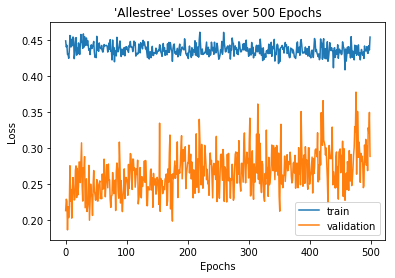

Average Training Score: 0.43689460548323206
Average Validation Score: 0.2666157359412248


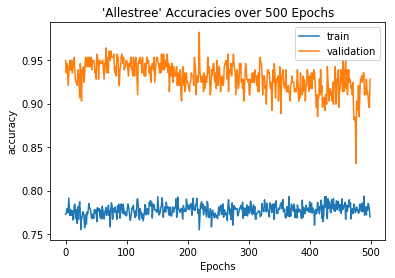

Average Training Score: 0.777367716535433
Average Validation Score: 0.9306690647482014

training complete


In [11]:
# ========================================
# Step 5. execute the train process
# ========================================

# overriding to use CPU when GPU is busy
use_gpu = True
print('use_gpu is ' + str(use_gpu))

# get the model
# model = create_model_architecture()
model = create_model_architecture('jq_net1')

# train parameters
# num_training_epochs = 5
num_training_epochs = 500

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
earlyStoppingCriteria = EarlyStopping(min_delta = 1e-4, patience=5)

# dataloader parameters
cross_val_loaders = {}

all_loss = {'train': {}, 'val': {}}
all_accs = {'train': {}, 'val': {}}
# leave-one-book-out cross validation
for val_book in books_in_data:
    raw_loss = {'train': [], 'val' : []}
    raw_accs = {'train': [], 'val' : []}
    
    print("validating on book: '" + str(val_book) + "'")
    
    # define the train and validation loaders
    train_books = books_in_data - set([val_book])    
    cross_val_loaders["train"] = {b : book_data_loaders[b]["train"] for b in train_books}
    cross_val_loaders["val"] = {b : book_data_loaders[b]["val"] for b in [val_book]}
    
    # train
    trained_model = train(model,
                          criterion,
                          optimizer,
                          cross_val_loaders,
                          num_epochs=num_training_epochs)
    
    # update all loss dicts
    for p in raw_loss:
        all_loss[p][str(val_book)] = raw_loss[p]
    for p in raw_accs:
        all_accs[p][str(val_book)] = raw_accs[p]
    
    
    plot_losses(raw_loss['train'], raw_loss['val'],
                "'" + str(val_book) + "' Losses over " + str(num_training_epochs) +  " Epochs")
    plot_losses(raw_accs['train'], raw_accs['val'],
                "'" + str(val_book) + "' Accuracies over " + str(num_training_epochs) +  " Epochs",
               xlabel='accuracy')
    
    print()
    
    # remove the break as needed
#     break


print("training complete")

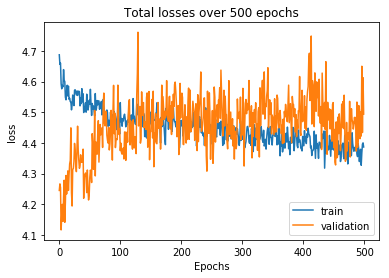

Average Training Score: 4.450035682622567
Average Validation Score: 4.456796216728143


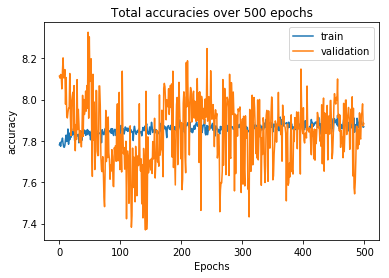

Average Training Score: 7.859142156299608
Average Validation Score: 7.843845812850631


In [12]:
# compute and plot total loss
# total_train_loss = [sum([all_train_loss[b][i] for b in all_train_loss]) for i in range(num_training_epochs)]
# total_val_loss = [sum([all_val_loss[b][i] for b in all_val_loss]) for i in range(num_training_epochs)]
# plot_losses(total_train_loss, total_val_loss, "Total losses over " + str(num_training_epochs) + " epochs")

total_loss = {p : [sum([all_loss[p][b][i] for b in all_loss[p]]) for i in range(num_training_epochs)]
             for p in all_loss}
total_accs = {p : [sum([all_accs[p][b][i] for b in all_accs[p]]) for i in range(num_training_epochs)]
             for p in all_accs}

plot_losses(total_loss['train'], total_loss['val'], "Total losses over " + str(num_training_epochs) + " epochs",
           xlabel = 'loss')
plot_losses(total_accs['train'], total_accs['val'], "Total accuracies over " + str(num_training_epochs) + " epochs",
           xlabel = 'accuracy')